In [653]:
import mne
import pywt
import scaleogram as scg
import pandas as pd
import numpy as np
import scipy
import time
import math
from scipy.fft import fft, fftfreq, rfft, rfftfreq, rfftn 
from scipy import signal
import matplotlib.pyplot as plt 
from collections import Counter
from edf_file_processing import create_raw_object, visualize_data, find_all_paths
from tqdm import tqdm
import os
import random
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from catboost import Pool, CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [654]:
def find_all_paths_txt(path):
    # Goes into all possible directories starting from initial "path"
    # goes into all sub-directories to find filtered_....txt files
    list_of_files = {}
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            if filename.endswith(".txt") and filename.startswith("filtered_"):
                list_of_files[filename] = os.sep.join([dirpath, filename])
    return list_of_files

In [655]:
CHANNEL_DIV = {'Frontal left': ['F7', 'F3', 'FP1'], 
               'Frontal Right': ['F4', 'F8', 'FP2'], 
               'Central': ['C3', 'Cz', 'C4'], 
               'Temporal left': ['T3', 'T5'], 
                'Temporal right': ['T4', 'T6'], 
               'Parietal': ['P3', 'Pz', 'P4'], 
               'Ocipital': ['O1', 'Oz', 'O2']}

LABELS_VAL = {0: 'NONE', 1: 'FNSZ', 
              2: 'GNSZ', 3: 'SPSZ',
              4: 'CPSZ', 5: 'ABSZ', 
              6: 'TNSZ', 7: 'CNSZ',
              8: 'TCSZ', 9: 'ATSZ',
             10: 'MYSZ'}

LABELS_KEY = {v: k for k, v in LABELS_VAL.items()}

FREQ = 250
SCALES = np.arange(1, 251)
ALL_EDF_FILES = list(find_all_paths('edf').values())
# ALL_TXT_FILES = list(find_all_paths_txt('edf/train').values())

TRAIN_EDF_FILES = list(find_all_paths('edf/train').values())
TRAIN_TXT_FILES = list(find_all_paths_txt('edf/train').values())

TEST_EDF_FILES = list(find_all_paths('edf/dev').values())
TEST_TXT_FILES = list(find_all_paths_txt('edf/dev').values())

In [656]:
# A function that plots the spectogram of a signal
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (timesteps)', 
                 xlabel = 'Time'):
    
    dt = 1
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
#     print(coefficients.shape)

    contourlevels = [-42, -40, -36, -34, -32, -30, -28, -26, -24]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
#     print(cbar_ax)
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

In [657]:
def split_signal(data, duration=2):
    '''
    function that splits the particular eeg signal into parts
    Returns the numpy array of the size (n, k, m), where n
    is the row size of an input matrix, k is number of elements in each of the row,
    and m is number of elements in each element of the row
    data --> a segment of filtered data
    '''
    result_arr = np.ndarray(shape=(len(data), int(len(data[0])/(duration*FREQ)), duration*FREQ))
    for ch in range(len(data)):
        k = 0
        for i in range(0, len(data[1]), duration*FREQ):
#             print(f'CHANNEL NO: {ch}')
#             print(f'K: {k}')
#             print(f'ROW DATA IND: {i}')
#             print(duration*FREQ)
#             print(len(data[ch][i:i+duration*FREQ]))
            if len(data[ch][i:]) < duration*FREQ:
#                 print("Hello")
                break
            result_arr[ch][k] = data[ch][i:i+duration*FREQ]
            k += 1
    return result_arr    

In [658]:
def get_data_times(raw_edf, start_s, duration=2):
    '''
    The function to extract the signal of a certain duration 
    starting from a concrete time in seconds
    Returns data and times as a tuple if the operation was successful
    Returns None, if the operation was not successful and prints the specific problem occured   
    '''
    try:
        start, stop = raw_edf.time_as_index([start_s, start_s+duration])
        data, times = raw_edf[:, start:stop]
        return data, times
    except:
        print("The index is out of range")
        return None

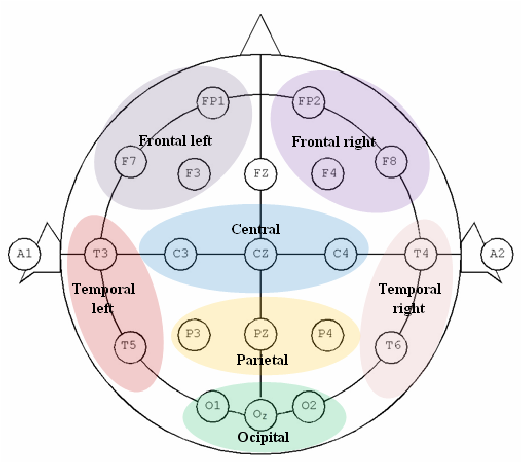

In [159]:
def averaging_channel_information(raw_edf):
    # function that averages the signals of different electrodes positions
    # the division can be seen in the picture above
    # Returns the concatenated averaged data matrix of size (7, timesteps) and the timesteps per Se
    channels = raw_edf.info['ch_names']
    dict_partial_chan = {}
    
    for part in CHANNEL_DIV:
        partial = []
        for ch in CHANNEL_DIV[part]:
            for c in channels:
                if ch in c:
                    partial.append(c)
        dict_partial_chan[part] = partial
    raw_edf.copy().pick_channels(dict_partial_chan['Frontal left'])
        
    data_fr_l, times = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Frontal left']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))
    
    data_fr_r = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Frontal Right']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_centr = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Central']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_temp_l = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Temporal left']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_temp_r = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Temporal right']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_par = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Parietal']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_oc = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Ocipital']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    general_data_lst = [data_fr_l, data_fr_r, data_centr, data_temp_l, data_temp_r ,data_par, data_oc]
    
    modified_lst = []
    
    for sep_part in general_data_lst:
        sep_part = sep_part.sum(axis=0) / len(sep_part)
        modified_lst.append(sep_part)
        
    return np.vstack(modified_lst), times

In [659]:
def dropping_unnecessary_data(labels_file, splitted_data):
    '''
    Deletes the fragments of data that is randomly chosen to be taken out 
    65% of data will be dropped because of the lack of its necessity
    Also modifies the .txt file, which stores the labels to store only needed ones
    Is only done to the train data
    '''
    
    NONE_PROB = 95
    SEIZ_PROB = 5
    
    choices = [0, 1]
    
    half = round(len(splitted_data[0]) * 0.65)
    
    for _ in range(half):
        
        ch = random.choices(choices, cum_weights=[NONE_PROB, SEIZ_PROB])[0]
        
        file = open(labels_file, 'r')
        lines = list(file.readlines())
        
        if ch == 0:
            poss = [i for i in range(len(lines)) if lines[i] == 'NONE\n']
        elif ch == 1:
            poss = [i for i in range(len(lines)) if lines[i] != 'NONE\n']
            
        try:
            j = random.choice(poss)
        except:
            j = random.randint(0, len(lines)-1)
            
        file.close()
        
        del lines[j]
        
        new_f = open(labels_file, 'w+')
        for l in lines:
            new_f.write(l)
        new_f.close()
        
        splitted_data = np.delete(splitted_data, j, 1)
    
    return labels_file, splitted_data

In [660]:
def cwt_splitted_data(splitted_data):
    # Performing Continuous Wavelet Transform on  
    # (segmented into channels and divided into subparts) files 
    
    data_cwt = np.ndarray(shape=(
        len(splitted_data[0]),
        len(SCALES),
        len(splitted_data[0][0]),
        len(splitted_data)
    ))
    
    for i in range(0, len(splitted_data[0])):
        for j in range(0, len(splitted_data)):
            sig = splitted_data[j, i, :]
            coefficients, frequency = pywt.cwt(sig, SCALES, 'morl', 1)
            
            data_cwt[i, :, :, j] = coefficients
    
    print(data_cwt.shape)
    return data_cwt

In [661]:
def entropy(arr):
    '''
    Measures the data randomness
    The higher the value, the harder it is to draw any conclusion from it 
    '''
    counter = Counter(arr).most_common()
    probs = [i[1]/len(arr) for i in counter]
    return [scipy.stats.entropy(probs)]

In [662]:
def general_statistics(arr):
    '''
    Calculates the general statistical features that could be useful
    '''
    mean = np.nanmean(arr)
    variance = np.nanvar(arr)
    std = np.nanstd(arr)
    rms = np.nanmean(np.sqrt(arr**2))
    median = np.nanpercentile(arr, 50)
    perc5 = np.nanpercentile(arr, 5)
    perc25 = np.nanpercentile(arr, 25)
    perc75 = np.nanpercentile(arr, 75)
    perc95 = np.nanpercentile(arr, 95)
    return [mean, variance, std, rms, median, perc5, perc25, perc75, perc95]

In [663]:
def crossings(arr):
    '''
    Calculates number of times the signal crosses 0 and mean value
    '''
    crossing_zero = np.nonzero(np.diff(np.array(arr) > 0))[0]
    crossing_mean = np.nonzero(np.diff(np.array(arr) > np.nanmean(arr)))[0]
    return [len(crossing_zero), len(crossing_mean)]

In [664]:
def get_features(arr):
    '''
    Links together all the features 
    '''
    return entropy(arr) + general_statistics(arr) + crossings(arr)

In [665]:
def dwt_splitted_data(splitted_data, labels_file, wavelet='sym9'):
    '''
    Forms a part of a train dataset to fill in the whole training set
    By performing Discrete Wavelet Transform on each of the channel entry 
    '''
    to_return = []
    for i in range(0, len(splitted_data[0])):
        features = []
        for j in range(0, len(splitted_data)):
            sig = splitted_data[j, i, :]
            coefficients_lst = pywt.wavedec(sig, wavelet)
            
            for c in coefficients_lst:
                features += get_features(c)
        to_return.append(features)
    
    with open(labels_file, 'r') as f:
        labels = [LABELS_KEY[l.replace('\n', '')] for l in list(f.readlines())]
    
    Y = np.array(labels)
    X = np.array(to_return)
    
    return X, Y           

In [666]:
def main():
    '''
    The function retrieves the data from edf files, performs splitting data into n-sec parts,
    performs Discrete Wavelet Transform, extracts main features and 
    saves all the data in the input shape for classification model
    '''
    train_data = np.array([])
    train_labels = np.array([])
    
    test_data = np.array([])
    test_labels = np.array([])
    
#     all_files = [list(find_all_paths('edf_test/train').values()), 
#                  list(find_all_paths('edf_test/dev').values())]
    all_files = [TRAIN_EDF_FILES, TEST_EDF_FILES]
    
    train = True
    
    for files in all_files:
        for file in tqdm(files):
            txt_file = file.replace('.edf', '.txt')
            print(txt_file)
            edf = create_raw_object(file)
            d, t = averaging_channel_information(edf)
            splitted = split_signal(d)

            labels_file, splitted_dropped = dropping_unnecessary_data(txt_file, splitted)

            data_dwt, labels = dwt_splitted_data(splitted_dropped, txt_file)  
#             print(data_dwt.shape)
            
            if train:
                if train_data.size == 0:
                    train_data = data_dwt
                    train_labels = labels
                else:
                    train_data = np.vstack([train_data, data_dwt])
                    train_labels = np.concatenate([train_labels, labels])
                print(train_data.shape)

                
            else:
                if test_data.size == 0:
                    test_data = data_dwt
                    test_labels = labels
                else:
                    test_data = np.vstack([test_data, data_dwt])
                    test_labels = np.concatenate([test_labels, labels])
                print(test_data.shape)

        train = False
    
    return train_data, train_labels, test_data, test_labels

In [242]:
start_time = time.time()
train_data, train_labels, test_data, test_labels = main()
duration = time.time() - start_time
print(f"Total time: {duration}")

  0%|          | 0/2269 [00:00<?, ?it/s]

edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/2269 [00:03<1:53:27,  3.00s/it]

(104, 420)
edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/2269 [00:08<2:16:50,  3.62s/it]

(280, 420)
edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/2269 [00:14<2:45:22,  4.38s/it]

(490, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/2269 [00:19<2:59:07,  4.74s/it]

(683, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 5/2269 [00:20<2:11:16,  3.48s/it]

(702, 420)
edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 6/2269 [00:31<3:41:16,  5.87s/it]

(1073, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 7/2269 [00:35<3:15:39,  5.19s/it]

(1203, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 8/2269 [00:38<2:48:01,  4.46s/it]

(1303, 420)
edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 9/2269 [00:44<3:08:21,  5.00s/it]

(1519, 420)
edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 10/2269 [00:45<2:29:15,  3.96s/it]

(1575, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 11/2269 [00:48<2:16:26,  3.63s/it]

(1677, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 12/2269 [00:49<1:46:54,  2.84s/it]

(1713, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 13/2269 [00:51<1:36:38,  2.57s/it]

(1783, 420)
edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 14/2269 [00:58<2:23:48,  3.83s/it]

(2010, 420)
edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 15/2269 [01:05<2:57:28,  4.72s/it]

(2241, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 16/2269 [01:08<2:41:09,  4.29s/it]

(2358, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 17/2269 [01:11<2:21:55,  3.78s/it]

(2451, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 18/2269 [01:13<2:09:08,  3.44s/it]

(2546, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 19/2269 [01:18<2:22:51,  3.81s/it]

(2710, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 20/2269 [01:20<2:06:55,  3.39s/it]

(2794, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 21/2269 [01:22<1:43:33,  2.76s/it]

(2839, 420)
edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 22/2269 [01:29<2:32:58,  4.08s/it]

(3081, 420)
edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 23/2269 [01:35<2:54:03,  4.65s/it]

(3285, 420)
edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 24/2269 [01:41<3:10:38,  5.10s/it]

(3496, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 25/2269 [01:45<2:59:31,  4.80s/it]

(3642, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 26/2269 [01:48<2:36:09,  4.18s/it]

(3739, 420)
edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 27/2269 [01:56<3:23:52,  5.46s/it]

(4013, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 28/2269 [01:57<2:29:47,  4.01s/it]

(4035, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 29/2269 [02:03<2:52:10,  4.61s/it]

(4244, 420)
edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 30/2269 [02:09<3:08:02,  5.04s/it]

(4454, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 31/2269 [02:09<2:14:42,  3.61s/it]

(4464, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 32/2269 [02:15<2:43:05,  4.37s/it]

(4681, 420)
edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 33/2269 [02:25<3:39:36,  5.89s/it]

(4997, 420)
edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 34/2269 [02:31<3:41:28,  5.95s/it]

(5208, 420)
edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 35/2269 [02:37<3:42:18,  5.97s/it]

(5419, 420)
edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 36/2269 [02:43<3:48:48,  6.15s/it]

(5647, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 37/2269 [02:53<4:29:20,  7.24s/it]

(5975, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 38/2269 [02:54<3:16:52,  5.29s/it]

(6002, 420)
edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 39/2269 [03:00<3:25:28,  5.53s/it]

(6214, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 40/2269 [03:02<2:46:58,  4.49s/it]

(6290, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 41/2269 [03:08<3:06:33,  5.02s/it]

(6507, 420)
edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 42/2269 [03:14<3:16:11,  5.29s/it]

(6712, 420)
edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 43/2269 [03:20<3:23:39,  5.49s/it]

(6919, 420)
edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 44/2269 [03:27<3:38:35,  5.89s/it]

(7155, 420)
edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 45/2269 [03:33<3:42:07,  5.99s/it]

(7370, 420)
edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 46/2269 [03:41<4:02:18,  6.54s/it]

(7635, 420)
edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 47/2269 [03:49<4:12:28,  6.82s/it]

(7888, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 48/2269 [03:51<3:25:02,  5.54s/it]

(7981, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 49/2269 [03:52<2:30:44,  4.07s/it]

(8004, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 50/2269 [03:54<2:12:15,  3.58s/it]

(8092, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 51/2269 [03:57<2:01:57,  3.30s/it]

(8187, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 52/2269 [03:57<1:30:32,  2.45s/it]

(8203, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 53/2269 [04:04<2:15:05,  3.66s/it]

(8426, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 54/2269 [04:07<2:05:43,  3.41s/it]

(8528, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 55/2269 [04:08<1:45:54,  2.87s/it]

(8586, 420)
edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 56/2269 [04:15<2:26:35,  3.97s/it]

(8811, 420)
edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 57/2269 [04:24<3:26:39,  5.61s/it]

(9124, 420)
edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 58/2269 [04:30<3:32:01,  5.75s/it]

(9334, 420)
edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 59/2269 [04:44<4:56:42,  8.06s/it]

(9761, 420)
edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 60/2269 [04:50<4:34:41,  7.46s/it]

(9971, 420)
edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 61/2269 [04:56<4:25:10,  7.21s/it]

(10192, 420)
edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 62/2269 [05:03<4:19:37,  7.06s/it]

(10422, 420)
edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 63/2269 [05:10<4:19:49,  7.07s/it]

(10664, 420)
edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 64/2269 [05:17<4:10:27,  6.82s/it]

(10878, 420)
edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 65/2269 [05:23<4:01:58,  6.59s/it]

(11088, 420)
edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 66/2269 [05:30<4:06:15,  6.71s/it]

(11327, 420)
edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 67/2269 [05:36<4:08:14,  6.76s/it]

(11564, 420)
edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 68/2269 [05:43<4:00:52,  6.57s/it]

(11775, 420)
edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 69/2269 [05:50<4:15:37,  6.97s/it]

(12045, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 70/2269 [05:51<3:07:09,  5.11s/it]

(12072, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 71/2269 [05:53<2:29:24,  4.08s/it]

(12134, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 72/2269 [05:54<1:54:49,  3.14s/it]

(12168, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 73/2269 [05:55<1:30:05,  2.46s/it]

(12200, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 74/2269 [05:56<1:17:26,  2.12s/it]

(12248, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 75/2269 [05:58<1:13:56,  2.02s/it]

(12315, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 76/2269 [05:59<1:02:21,  1.71s/it]

(12350, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 77/2269 [05:59<49:20,  1.35s/it]  

(12368, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 78/2269 [06:00<45:06,  1.24s/it]

(12402, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 79/2269 [06:01<37:18,  1.02s/it]

(12420, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 80/2269 [06:01<32:57,  1.11it/s]

(12442, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 81/2269 [06:03<35:17,  1.03it/s]

(12483, 420)
edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 82/2269 [06:09<1:31:02,  2.50s/it]

(12694, 420)
edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 83/2269 [06:15<2:10:11,  3.57s/it]

(12907, 420)
edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 84/2269 [06:29<4:02:08,  6.65s/it]

(13345, 420)
edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 85/2269 [06:35<3:54:51,  6.45s/it]

(13556, 420)
edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 86/2269 [06:42<4:02:35,  6.67s/it]

(13802, 420)
edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 87/2269 [06:48<3:55:05,  6.46s/it]

(14011, 420)
edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 88/2269 [06:56<4:19:48,  7.15s/it]

(14307, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 89/2269 [06:58<3:15:45,  5.39s/it]

(14353, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 90/2269 [06:59<2:25:52,  4.02s/it]

(14382, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 91/2269 [06:59<1:49:14,  3.01s/it]

(14405, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 92/2269 [07:00<1:24:25,  2.33s/it]

(14430, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 93/2269 [07:01<1:14:57,  2.07s/it]

(14483, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 94/2269 [07:02<59:03,  1.63s/it]  

(14504, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 95/2269 [07:03<49:36,  1.37s/it]

(14531, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 96/2269 [07:04<43:55,  1.21s/it]

(14561, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 97/2269 [07:04<32:59,  1.10it/s]

(14567, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 98/2269 [07:04<24:27,  1.48it/s]

(14571, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 99/2269 [07:10<1:20:26,  2.22s/it]

(14775, 420)
edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 100/2269 [07:16<2:00:52,  3.34s/it]

(14983, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 101/2269 [07:25<3:08:29,  5.22s/it]

(15301, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 102/2269 [07:27<2:33:14,  4.24s/it]

(15373, 420)
edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 103/2269 [07:33<2:51:24,  4.75s/it]

(15579, 420)
edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 104/2269 [07:55<5:59:32,  9.96s/it]

(16193, 420)
edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 105/2269 [08:01<5:17:01,  8.79s/it]

(16403, 420)
edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 106/2269 [08:08<4:48:17,  8.00s/it]

(16616, 420)
edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 107/2269 [08:15<4:37:48,  7.71s/it]

(16858, 420)
edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 108/2269 [08:21<4:20:52,  7.24s/it]

(17071, 420)
edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 109/2269 [08:27<4:14:49,  7.08s/it]

(17301, 420)
edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 110/2269 [08:34<4:03:49,  6.78s/it]

(17512, 420)
edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 111/2269 [08:39<3:51:59,  6.45s/it]

(17711, 420)
edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 112/2269 [08:46<3:55:32,  6.55s/it]

(17944, 420)
edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 113/2269 [08:58<4:59:37,  8.34s/it]

(18345, 420)
edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 114/2269 [09:05<4:34:49,  7.65s/it]

(18555, 420)
edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 115/2269 [09:11<4:17:42,  7.18s/it]

(18766, 420)
edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 116/2269 [09:18<4:23:36,  7.35s/it]

(19027, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 117/2269 [09:22<3:45:04,  6.28s/it]

(19161, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 118/2269 [09:25<3:07:54,  5.24s/it]

(19262, 420)
edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 119/2269 [09:36<4:06:47,  6.89s/it]

(19611, 420)
edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 120/2269 [09:42<4:00:41,  6.72s/it]

(19828, 420)
edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 121/2269 [09:48<3:55:54,  6.59s/it]

(20043, 420)
edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 122/2269 [09:54<3:50:38,  6.45s/it]

(20252, 420)
edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 123/2269 [09:56<2:55:13,  4.90s/it]

(20298, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 124/2269 [09:59<2:35:22,  4.35s/it]

(20408, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 125/2269 [10:00<2:05:27,  3.51s/it]

(20464, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 126/2269 [10:02<1:42:24,  2.87s/it]

(20512, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 127/2269 [10:03<1:30:28,  2.53s/it]

(20574, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 128/2269 [10:05<1:20:58,  2.27s/it]

(20633, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 129/2269 [10:07<1:12:59,  2.05s/it]

(20687, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 130/2269 [10:08<1:03:11,  1.77s/it]

(20728, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 131/2269 [10:09<59:46,  1.68s/it]  

(20780, 420)
edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 132/2269 [10:16<1:52:35,  3.16s/it]

(21006, 420)
edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 133/2269 [10:24<2:44:07,  4.61s/it]

(21274, 420)
edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 134/2269 [10:30<3:00:39,  5.08s/it]

(21484, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 135/2269 [10:32<2:25:42,  4.10s/it]

(21549, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 136/2269 [10:36<2:27:06,  4.14s/it]

(21699, 420)
edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 137/2269 [10:44<3:06:54,  5.26s/it]

(21963, 420)
edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 138/2269 [10:50<3:19:41,  5.62s/it]

(22184, 420)
edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 139/2269 [10:57<3:30:57,  5.94s/it]

(22412, 420)
edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 140/2269 [11:04<3:38:10,  6.15s/it]

(22638, 420)
edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 141/2269 [11:18<5:05:07,  8.60s/it]

(23082, 420)
edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 142/2269 [11:24<4:39:01,  7.87s/it]

(23293, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 143/2269 [11:25<3:21:47,  5.70s/it]

(23315, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 144/2269 [11:25<2:24:54,  4.09s/it]

(23326, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 145/2269 [11:26<1:47:56,  3.05s/it]

(23348, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 146/2269 [11:27<1:25:10,  2.41s/it]

(23380, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 147/2269 [11:28<1:12:19,  2.04s/it]

(23423, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 148/2269 [11:29<57:40,  1.63s/it]  

(23445, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 149/2269 [11:30<51:25,  1.46s/it]

(23482, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 150/2269 [11:31<52:08,  1.48s/it]

(23537, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 151/2269 [11:32<42:50,  1.21s/it]

(23559, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 152/2269 [11:32<36:39,  1.04s/it]

(23581, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 153/2269 [11:33<33:08,  1.06it/s]

(23606, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 154/2269 [11:34<29:47,  1.18it/s]

(23628, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 155/2269 [11:34<27:33,  1.28it/s]

(23650, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 156/2269 [11:35<26:00,  1.35it/s]

(23672, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 157/2269 [11:37<39:31,  1.12s/it]

(23746, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 158/2269 [11:38<37:12,  1.06s/it]

(23778, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 159/2269 [11:39<35:34,  1.01s/it]

(23810, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 160/2269 [11:39<31:36,  1.11it/s]

(23832, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 161/2269 [11:40<32:36,  1.08it/s]

(23864, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 162/2269 [11:41<32:40,  1.07it/s]

(23897, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 163/2269 [11:42<32:51,  1.07it/s]

(23929, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 164/2269 [11:43<28:05,  1.25it/s]

(23944, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 165/2269 [11:43<24:06,  1.45it/s]

(23957, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 166/2269 [11:44<26:19,  1.33it/s]

(23989, 420)
edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 167/2269 [11:52<1:41:12,  2.89s/it]

(24246, 420)
edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 168/2269 [11:58<2:14:49,  3.85s/it]

(24457, 420)
edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 169/2269 [12:04<2:39:13,  4.55s/it]

(24669, 420)
edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 170/2269 [12:10<2:55:57,  5.03s/it]

(24879, 420)
edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 171/2269 [12:17<3:12:50,  5.52s/it]

(25104, 420)
edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 172/2269 [12:24<3:29:51,  6.00s/it]

(25344, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 173/2269 [12:31<3:37:06,  6.21s/it]

(25571, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 174/2269 [12:31<2:33:51,  4.41s/it]

(25577, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 175/2269 [12:31<1:51:31,  3.20s/it]

(25590, 420)
edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 176/2269 [12:38<2:24:47,  4.15s/it]

(25813, 420)
edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 177/2269 [12:44<2:46:22,  4.77s/it]

(26029, 420)
edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 178/2269 [12:50<2:59:04,  5.14s/it]

(26239, 420)
edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 179/2269 [12:56<3:05:27,  5.32s/it]

(26440, 420)
edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 180/2269 [13:02<3:12:29,  5.53s/it]

(26650, 420)
edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 181/2269 [13:09<3:24:19,  5.87s/it]

(26881, 420)
edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 182/2269 [13:15<3:25:50,  5.92s/it]

(27091, 420)
edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 183/2269 [13:20<3:25:54,  5.92s/it]

(27298, 420)
edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 184/2269 [13:25<3:12:04,  5.53s/it]

(27462, 420)
edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 185/2269 [13:31<3:17:46,  5.69s/it]

(27673, 420)
edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 186/2269 [13:40<3:53:11,  6.72s/it]

(27977, 420)
edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 187/2269 [13:46<3:45:08,  6.49s/it]

(28186, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 188/2269 [13:48<2:53:17,  5.00s/it]

(28241, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 189/2269 [13:49<2:18:22,  3.99s/it]

(28301, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 190/2269 [13:51<1:53:21,  3.27s/it]

(28359, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 191/2269 [13:53<1:35:59,  2.77s/it]

(28417, 420)
edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 192/2269 [14:00<2:22:27,  4.12s/it]

(28663, 420)
edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 193/2269 [14:06<2:42:57,  4.71s/it]

(28873, 420)
edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 194/2269 [14:13<3:04:51,  5.35s/it]

(29106, 420)
edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 195/2269 [14:19<3:13:55,  5.61s/it]

(29318, 420)
edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 196/2269 [14:26<3:30:27,  6.09s/it]

(29560, 420)
edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 197/2269 [14:32<3:23:32,  5.89s/it]

(29747, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 198/2269 [14:32<2:30:44,  4.37s/it]

(29775, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 199/2269 [14:38<2:40:31,  4.65s/it]

(29958, 420)
edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 200/2269 [14:44<2:56:12,  5.11s/it]

(30169, 420)
edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 201/2269 [14:50<3:09:51,  5.51s/it]

(30387, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 202/2269 [14:52<2:27:33,  4.28s/it]

(30438, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 203/2269 [14:52<1:50:32,  3.21s/it]

(30462, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 204/2269 [14:54<1:29:03,  2.59s/it]

(30502, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 205/2269 [14:54<1:09:29,  2.02s/it]

(30525, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 206/2269 [14:55<52:32,  1.53s/it]  

(30537, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 207/2269 [14:56<52:35,  1.53s/it]

(30593, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 208/2269 [14:57<48:57,  1.43s/it]

(30635, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 209/2269 [14:59<46:26,  1.35s/it]

(30677, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 210/2269 [14:59<34:10,  1.00it/s]

(30681, 420)
edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 211/2269 [15:05<1:26:43,  2.53s/it]

(30891, 420)
edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 212/2269 [15:11<2:03:41,  3.61s/it]

(31103, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 213/2269 [15:12<1:34:16,  2.75s/it]

(31130, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 214/2269 [15:17<2:01:28,  3.55s/it]

(31318, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 215/2269 [15:23<2:25:52,  4.26s/it]

(31522, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 216/2269 [15:23<1:44:50,  3.06s/it]

(31530, 420)
edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 217/2269 [15:27<1:51:18,  3.25s/it]

(31662, 420)
edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 218/2269 [15:33<2:20:28,  4.11s/it]

(31872, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 219/2269 [15:36<2:08:48,  3.77s/it]

(31978, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 220/2269 [15:40<2:04:49,  3.65s/it]

(32100, 420)
edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 221/2269 [15:46<2:29:36,  4.38s/it]

(32312, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 222/2269 [15:49<2:15:38,  3.98s/it]

(32421, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 223/2269 [15:49<1:43:40,  3.04s/it]

(32451, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 224/2269 [15:50<1:21:31,  2.39s/it]

(32482, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 225/2269 [15:52<1:12:52,  2.14s/it]

(32538, 420)
edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 226/2269 [15:58<1:52:40,  3.31s/it]

(32748, 420)
edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 227/2269 [16:04<2:23:44,  4.22s/it]

(32968, 420)
edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 228/2269 [16:10<2:41:52,  4.76s/it]

(33176, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 229/2269 [16:11<2:03:30,  3.63s/it]

(33211, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 230/2269 [16:12<1:32:11,  2.71s/it]

(33229, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 231/2269 [16:12<1:06:56,  1.97s/it]

(33235, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 232/2269 [16:14<1:10:48,  2.09s/it]

(33319, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 233/2269 [16:16<1:02:23,  1.84s/it]

(33363, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 234/2269 [16:16<49:20,  1.45s/it]  

(33381, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 235/2269 [16:17<42:24,  1.25s/it]

(33407, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 236/2269 [16:18<37:32,  1.11s/it]

(33433, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 237/2269 [16:19<35:26,  1.05s/it]

(33464, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 238/2269 [16:20<39:52,  1.18s/it]

(33516, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 239/2269 [16:21<31:57,  1.06it/s]

(33529, 420)
edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 240/2269 [16:27<1:25:14,  2.52s/it]

(33740, 420)
edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 241/2269 [16:33<2:02:36,  3.63s/it]

(33950, 420)
edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 242/2269 [16:40<2:32:06,  4.50s/it]

(34171, 420)
edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 243/2269 [16:46<2:49:56,  5.03s/it]

(34384, 420)
edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 244/2269 [16:52<3:01:43,  5.38s/it]

(34595, 420)
edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 245/2269 [16:59<3:21:50,  5.98s/it]

(34843, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 246/2269 [17:00<2:27:49,  4.38s/it]

(34862, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 247/2269 [17:01<1:54:41,  3.40s/it]

(34900, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 248/2269 [17:02<1:24:17,  2.50s/it]

(34912, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 249/2269 [17:02<1:04:29,  1.92s/it]

(34930, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 250/2269 [17:03<52:35,  1.56s/it]  

(34954, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 251/2269 [17:03<41:52,  1.24s/it]

(34969, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 252/2269 [17:04<38:35,  1.15s/it]

(35001, 420)
edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 253/2269 [17:11<1:30:30,  2.69s/it]

(35217, 420)
edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 254/2269 [17:21<2:44:42,  4.90s/it]

(35548, 420)
edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 255/2269 [17:27<2:56:46,  5.27s/it]

(35759, 420)
edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 256/2269 [17:33<3:08:38,  5.62s/it]

(35980, 420)
edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 257/2269 [17:39<3:13:35,  5.77s/it]

(36191, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 258/2269 [17:40<2:26:20,  4.37s/it]

(36228, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 259/2269 [17:42<1:57:01,  3.49s/it]

(36279, 420)
edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 260/2269 [17:48<2:25:29,  4.35s/it]

(36496, 420)
edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 261/2269 [17:56<3:00:07,  5.38s/it]

(36750, 420)
edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 262/2269 [18:03<3:17:56,  5.92s/it]

(36993, 420)
edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 263/2269 [18:08<3:04:26,  5.52s/it]

(37156, 420)
edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 264/2269 [18:14<3:10:31,  5.70s/it]

(37366, 420)
edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 265/2269 [18:20<3:14:43,  5.83s/it]

(37576, 420)
edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 266/2269 [18:23<2:43:19,  4.89s/it]

(37673, 420)
edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 267/2269 [18:29<2:54:01,  5.22s/it]

(37879, 420)
edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 268/2269 [18:35<3:04:04,  5.52s/it]

(38094, 420)
edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 269/2269 [18:43<3:29:14,  6.28s/it]

(38365, 420)
edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 270/2269 [18:51<3:44:18,  6.73s/it]

(38628, 420)
edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 271/2269 [18:59<3:54:50,  7.05s/it]

(38891, 420)
edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 272/2269 [19:06<3:56:20,  7.10s/it]

(39136, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 273/2269 [19:10<3:29:42,  6.30s/it]

(39291, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 274/2269 [19:12<2:42:09,  4.88s/it]

(39346, 420)
edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 275/2269 [19:18<2:56:39,  5.32s/it]

(39564, 420)
edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 276/2269 [19:24<3:06:12,  5.61s/it]

(39781, 420)
edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 277/2269 [19:31<3:11:20,  5.76s/it]

(39994, 420)
edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 278/2269 [19:37<3:14:19,  5.86s/it]

(40205, 420)
edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 279/2269 [19:43<3:16:32,  5.93s/it]

(40415, 420)
edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 280/2269 [19:48<3:12:54,  5.82s/it]

(40608, 420)
edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 281/2269 [19:54<3:15:42,  5.91s/it]

(40819, 420)
edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 282/2269 [20:02<3:29:09,  6.32s/it]

(41068, 420)
edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 283/2269 [20:08<3:30:55,  6.37s/it]

(41292, 420)
edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 284/2269 [20:15<3:36:52,  6.56s/it]

(41530, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 285/2269 [20:17<2:54:16,  5.27s/it]

(41611, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 286/2269 [20:20<2:26:18,  4.43s/it]

(41697, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 287/2269 [20:21<1:50:26,  3.34s/it]

(41725, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 288/2269 [20:21<1:24:49,  2.57s/it]

(41751, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 289/2269 [20:25<1:31:44,  2.78s/it]

(41867, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 290/2269 [20:32<2:20:08,  4.25s/it]

(42123, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 291/2269 [20:35<2:05:01,  3.79s/it]

(42220, 420)
edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 292/2269 [20:41<2:29:01,  4.52s/it]

(42431, 420)
edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 293/2269 [20:48<2:48:13,  5.11s/it]

(42650, 420)
edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 294/2269 [20:54<2:59:23,  5.45s/it]

(42861, 420)
edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 295/2269 [21:02<3:26:40,  6.28s/it]

(43134, 420)
edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 296/2269 [21:09<3:26:26,  6.28s/it]

(43346, 420)
edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 297/2269 [21:16<3:35:18,  6.55s/it]

(43588, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 298/2269 [21:18<2:49:41,  5.17s/it]

(43656, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 299/2269 [21:22<2:38:20,  4.82s/it]

(43797, 420)
edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 300/2269 [21:28<2:51:45,  5.23s/it]

(44007, 420)
edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 301/2269 [21:52<5:53:05, 10.76s/it]

(44621, 420)
edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 302/2269 [21:58<5:07:21,  9.38s/it]

(44829, 420)
edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 303/2269 [22:06<4:54:20,  8.98s/it]

(45097, 420)
edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 304/2269 [22:12<4:30:57,  8.27s/it]

(45322, 420)
edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 305/2269 [22:19<4:11:07,  7.67s/it]

(45534, 420)
edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 306/2269 [22:25<3:56:41,  7.23s/it]

(45744, 420)
edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 307/2269 [22:32<3:52:12,  7.10s/it]

(45972, 420)
edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 308/2269 [22:42<4:28:00,  8.20s/it]

(46320, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 309/2269 [22:46<3:43:07,  6.83s/it]

(46450, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 310/2269 [22:50<3:17:23,  6.05s/it]

(46597, 420)
edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 311/2269 [22:57<3:20:16,  6.14s/it]

(46815, 420)
edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 312/2269 [23:06<3:54:52,  7.20s/it]

(47133, 420)
edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 313/2269 [23:14<4:04:00,  7.48s/it]

(47406, 420)
edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 314/2269 [23:21<3:51:02,  7.09s/it]

(47618, 420)
edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 315/2269 [23:28<3:57:46,  7.30s/it]

(47880, 420)
edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 316/2269 [23:35<3:46:28,  6.96s/it]

(48092, 420)
edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 317/2269 [23:41<3:43:13,  6.86s/it]

(48317, 420)
edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 318/2269 [23:47<3:36:15,  6.65s/it]

(48528, 420)
edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 319/2269 [23:54<3:34:26,  6.60s/it]

(48749, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 320/2269 [23:54<2:32:26,  4.69s/it]

(48756, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 321/2269 [23:56<2:09:39,  3.99s/it]

(48840, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 322/2269 [23:57<1:35:47,  2.95s/it]

(48856, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 323/2269 [24:00<1:35:06,  2.93s/it]

(48957, 420)
edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 324/2269 [24:06<2:05:50,  3.88s/it]

(49164, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 325/2269 [24:13<2:38:19,  4.89s/it]

(49406, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 326/2269 [24:14<1:56:58,  3.61s/it]

(49427, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 327/2269 [24:15<1:27:59,  2.72s/it]

(49448, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 328/2269 [24:22<2:12:11,  4.09s/it]

(49692, 420)
edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 329/2269 [24:29<2:45:22,  5.11s/it]

(49943, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 330/2269 [24:38<3:23:51,  6.31s/it]

(50241, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 331/2269 [24:39<2:28:44,  4.60s/it]

(50262, 420)
edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 332/2269 [24:46<2:47:32,  5.19s/it]

(50486, 420)
edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 333/2269 [24:52<2:58:17,  5.53s/it]

(50703, 420)
edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 334/2269 [24:59<3:16:24,  6.09s/it]

(50953, 420)
edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 335/2269 [25:06<3:23:23,  6.31s/it]

(51186, 420)
edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 336/2269 [25:14<3:35:41,  6.70s/it]

(51442, 420)
edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 337/2269 [25:20<3:30:30,  6.54s/it]

(51654, 420)
edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 338/2269 [25:26<3:26:11,  6.41s/it]

(51862, 420)
edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 339/2269 [25:32<3:21:40,  6.27s/it]

(52069, 420)
edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 340/2269 [25:38<3:19:02,  6.19s/it]

(52279, 420)
edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 341/2269 [25:45<3:31:11,  6.57s/it]

(52533, 420)
edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 342/2269 [25:52<3:32:47,  6.63s/it]

(52765, 420)
edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 343/2269 [25:58<3:28:07,  6.48s/it]

(52977, 420)
edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 344/2269 [26:14<4:55:05,  9.20s/it]

(53452, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 345/2269 [26:17<3:59:33,  7.47s/it]

(53575, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 346/2269 [26:20<3:13:54,  6.05s/it]

(53673, 420)
edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 347/2269 [26:28<3:28:22,  6.50s/it]

(53930, 420)
edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 348/2269 [26:35<3:37:58,  6.81s/it]

(54184, 420)
edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 349/2269 [26:41<3:32:41,  6.65s/it]

(54400, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 350/2269 [26:42<2:31:35,  4.74s/it]

(54408, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 351/2269 [26:46<2:30:19,  4.70s/it]

(54572, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 352/2269 [26:48<1:57:16,  3.67s/it]

(54616, 420)
edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 353/2269 [26:54<2:22:58,  4.48s/it]

(54836, 420)
edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 354/2269 [27:00<2:38:00,  4.95s/it]

(55047, 420)
edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 355/2269 [27:06<2:47:22,  5.25s/it]

(55252, 420)
edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 356/2269 [27:13<3:00:36,  5.66s/it]

(55480, 420)
edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 357/2269 [27:19<3:04:24,  5.79s/it]

(55690, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 358/2269 [27:21<2:33:04,  4.81s/it]

(55780, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 359/2269 [27:23<2:01:45,  3.82s/it]

(55834, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 360/2269 [27:24<1:42:19,  3.22s/it]

(55898, 420)
edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 361/2269 [27:31<2:13:23,  4.19s/it]

(56121, 420)
edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 362/2269 [27:38<2:40:36,  5.05s/it]

(56362, 420)
edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 363/2269 [27:44<2:50:33,  5.37s/it]

(56572, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 364/2269 [27:50<2:57:20,  5.59s/it]

(56783, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 365/2269 [27:50<2:07:06,  4.01s/it]

(56792, 420)
edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 366/2269 [27:57<2:26:53,  4.63s/it]

(57003, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 367/2269 [28:02<2:38:37,  5.00s/it]

(57206, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 368/2269 [28:04<2:04:37,  3.93s/it]

(57255, 420)
edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 369/2269 [28:10<2:23:58,  4.55s/it]

(57463, 420)
edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 370/2269 [28:12<2:04:58,  3.95s/it]

(57553, 420)
edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 371/2269 [28:19<2:25:47,  4.61s/it]

(57764, 420)
edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 372/2269 [28:25<2:40:03,  5.06s/it]

(57975, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 373/2269 [28:36<3:34:29,  6.79s/it]

(58326, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 374/2269 [28:39<3:01:08,  5.74s/it]

(58443, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 375/2269 [28:45<3:06:41,  5.91s/it]

(58659, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 376/2269 [28:47<2:25:10,  4.60s/it]

(58713, 420)
edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 377/2269 [28:53<2:42:16,  5.15s/it]

(58931, 420)
edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 378/2269 [28:59<2:51:09,  5.43s/it]

(59141, 420)
edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 379/2269 [29:25<6:05:33, 11.61s/it]

(59740, 420)
edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 380/2269 [29:32<5:21:36, 10.22s/it]

(59976, 420)
edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 381/2269 [29:39<4:47:25,  9.13s/it]

(60200, 420)
edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 382/2269 [29:45<4:20:13,  8.27s/it]

(60413, 420)
edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 383/2269 [29:51<4:01:41,  7.69s/it]

(60628, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 384/2269 [29:57<3:46:50,  7.22s/it]

(60837, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 385/2269 [30:11<4:41:50,  8.98s/it]

(61248, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 386/2269 [30:11<3:23:53,  6.50s/it]

(61271, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 387/2269 [30:12<2:24:57,  4.62s/it]

(61275, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 388/2269 [30:14<2:06:21,  4.03s/it]

(61369, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 389/2269 [30:15<1:37:14,  3.10s/it]

(61399, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 390/2269 [30:22<2:13:00,  4.25s/it]

(61632, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 391/2269 [30:23<1:39:51,  3.19s/it]

(61654, 420)
edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 392/2269 [30:29<2:09:11,  4.13s/it]

(61868, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 393/2269 [30:31<1:45:07,  3.36s/it]

(61921, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 394/2269 [30:33<1:35:44,  3.06s/it]

(62005, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 395/2269 [30:35<1:21:51,  2.62s/it]

(62059, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 396/2269 [30:36<1:14:31,  2.39s/it]

(62123, 420)
edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 397/2269 [30:44<1:58:22,  3.79s/it]

(62361, 420)
edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 398/2269 [30:50<2:20:22,  4.50s/it]

(62571, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 399/2269 [30:50<1:42:16,  3.28s/it]

(62582, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 400/2269 [30:52<1:26:27,  2.78s/it]

(62637, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 401/2269 [30:53<1:12:34,  2.33s/it]

(62680, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 402/2269 [30:55<1:05:49,  2.12s/it]

(62735, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 403/2269 [30:56<1:00:36,  1.95s/it]

(62788, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 404/2269 [30:57<46:15,  1.49s/it]  

(62799, 420)
edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 405/2269 [31:03<1:34:15,  3.03s/it]

(63024, 420)
edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 406/2269 [31:10<2:04:36,  4.01s/it]

(63238, 420)
edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 407/2269 [31:17<2:40:32,  5.17s/it]

(63501, 420)
edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 408/2269 [31:24<2:55:01,  5.64s/it]

(63729, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 409/2269 [31:25<2:12:39,  4.28s/it]

(63765, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 410/2269 [31:29<2:12:18,  4.27s/it]

(63913, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 411/2269 [31:34<2:13:54,  4.32s/it]

(64068, 420)
edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 412/2269 [31:40<2:31:08,  4.88s/it]

(64279, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 413/2269 [31:44<2:21:19,  4.57s/it]

(64413, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 414/2269 [31:46<1:59:13,  3.86s/it]

(64489, 420)
edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 415/2269 [31:54<2:34:24,  5.00s/it]

(64746, 420)
edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 416/2269 [32:00<2:45:16,  5.35s/it]

(64956, 420)
edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 417/2269 [32:08<3:08:43,  6.11s/it]

(65219, 420)
edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 418/2269 [32:15<3:21:38,  6.54s/it]

(65471, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 419/2269 [32:27<4:07:50,  8.04s/it]

(65840, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 420/2269 [32:32<3:40:56,  7.17s/it]

(66016, 420)
edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 421/2269 [32:40<3:52:00,  7.53s/it]

(66293, 420)
edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 422/2269 [32:49<4:05:08,  7.96s/it]

(66589, 420)
edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 423/2269 [32:56<3:51:03,  7.51s/it]

(66806, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 424/2269 [32:59<3:14:20,  6.32s/it]

(66929, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 425/2269 [33:02<2:40:21,  5.22s/it]

(67021, 420)
edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 426/2269 [33:08<2:48:22,  5.48s/it]

(67229, 420)
edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 427/2269 [33:14<2:55:36,  5.72s/it]

(67445, 420)
edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 428/2269 [33:21<2:59:59,  5.87s/it]

(67659, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 429/2269 [33:24<2:37:14,  5.13s/it]

(67779, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 430/2269 [33:27<2:15:33,  4.42s/it]

(67877, 420)
edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 431/2269 [33:33<2:30:50,  4.92s/it]

(68087, 420)
edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 432/2269 [33:39<2:41:34,  5.28s/it]

(68297, 420)
edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 433/2269 [33:40<2:03:27,  4.03s/it]

(68334, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 434/2269 [33:42<1:46:28,  3.48s/it]

(68410, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 435/2269 [33:43<1:18:35,  2.57s/it]

(68421, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 436/2269 [33:43<58:54,  1.93s/it]  

(68432, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 437/2269 [33:44<44:19,  1.45s/it]

(68440, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 438/2269 [33:44<37:39,  1.23s/it]

(68463, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 439/2269 [33:46<42:29,  1.39s/it]

(68525, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 440/2269 [33:46<32:53,  1.08s/it]

(68532, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 441/2269 [33:48<40:28,  1.33s/it]

(68599, 420)
edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 442/2269 [33:54<1:24:14,  2.77s/it]

(68809, 420)
edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 443/2269 [34:01<2:00:19,  3.95s/it]

(69038, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 444/2269 [34:04<1:45:59,  3.48s/it]

(69122, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 445/2269 [34:05<1:27:49,  2.89s/it]

(69173, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 446/2269 [34:07<1:21:19,  2.68s/it]

(69249, 420)
edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 447/2269 [34:29<4:19:08,  8.53s/it]

(69787, 420)
edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 448/2269 [34:39<4:31:57,  8.96s/it]

(70111, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 449/2269 [34:40<3:19:33,  6.58s/it]

(70144, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 450/2269 [34:44<2:48:24,  5.56s/it]

(70254, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 451/2269 [34:47<2:30:42,  4.97s/it]

(70380, 420)
edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 452/2269 [34:54<2:46:47,  5.51s/it]

(70606, 420)
edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 453/2269 [35:00<2:52:47,  5.71s/it]

(70817, 420)
edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 454/2269 [35:06<2:55:57,  5.82s/it]

(71024, 420)
edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 455/2269 [35:12<2:59:04,  5.92s/it]

(71234, 420)
edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 456/2269 [35:20<3:15:26,  6.47s/it]

(71493, 420)
edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 457/2269 [35:26<3:14:41,  6.45s/it]

(71710, 420)
edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 458/2269 [35:33<3:12:44,  6.39s/it]

(71922, 420)
edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 459/2269 [35:39<3:10:40,  6.32s/it]

(72131, 420)
edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 460/2269 [35:46<3:15:56,  6.50s/it]

(72364, 420)
edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 461/2269 [35:53<3:18:16,  6.58s/it]

(72593, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 462/2269 [35:54<2:28:22,  4.93s/it]

(72628, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 463/2269 [35:56<2:01:24,  4.03s/it]

(72695, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 464/2269 [35:57<1:33:12,  3.10s/it]

(72724, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 465/2269 [35:57<1:07:36,  2.25s/it]

(72728, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 466/2269 [35:59<1:05:09,  2.17s/it]

(72797, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 467/2269 [36:00<53:59,  1.80s/it]  

(72827, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 468/2269 [36:01<48:55,  1.63s/it]

(72867, 420)
edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 469/2269 [36:08<1:34:17,  3.14s/it]

(73090, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 470/2269 [36:09<1:20:31,  2.69s/it]

(73144, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 471/2269 [36:12<1:24:25,  2.82s/it]

(73251, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 472/2269 [36:15<1:26:57,  2.90s/it]

(73358, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 473/2269 [36:19<1:28:38,  2.96s/it]

(73465, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 474/2269 [36:22<1:29:48,  3.00s/it]

(73572, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 475/2269 [36:23<1:17:12,  2.58s/it]

(73626, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 476/2269 [36:26<1:19:47,  2.67s/it]

(73724, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 477/2269 [36:28<1:10:13,  2.35s/it]

(73778, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 478/2269 [36:29<1:03:31,  2.13s/it]

(73832, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 479/2269 [36:30<51:13,  1.72s/it]  

(73855, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 480/2269 [36:31<44:41,  1.50s/it]

(73886, 420)
edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 481/2269 [36:38<1:36:10,  3.23s/it]

(74128, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 482/2269 [36:41<1:34:56,  3.19s/it]

(74235, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 483/2269 [36:43<1:20:47,  2.71s/it]

(74289, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 484/2269 [36:45<1:10:15,  2.36s/it]

(74343, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 485/2269 [36:46<1:03:03,  2.12s/it]

(74397, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 486/2269 [36:49<1:11:00,  2.39s/it]

(74504, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 487/2269 [36:52<1:16:42,  2.58s/it]

(74611, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 488/2269 [36:54<1:07:48,  2.28s/it]

(74665, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 489/2269 [37:00<1:38:51,  3.33s/it]

(74864, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 490/2269 [37:01<1:23:04,  2.80s/it]

(74918, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 491/2269 [37:08<1:57:27,  3.96s/it]

(75146, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 492/2269 [37:08<1:27:41,  2.96s/it]

(75164, 420)
edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 493/2269 [37:09<1:03:33,  2.15s/it]

(75168, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 494/2269 [37:15<1:40:06,  3.38s/it]

(75384, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 495/2269 [37:18<1:36:11,  3.25s/it]

(75488, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 496/2269 [37:20<1:23:37,  2.83s/it]

(75552, 420)
edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 497/2269 [37:29<2:20:02,  4.74s/it]

(75858, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 498/2269 [37:32<2:04:40,  4.22s/it]

(75965, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 499/2269 [37:35<1:54:31,  3.88s/it]

(76072, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 500/2269 [37:38<1:47:01,  3.63s/it]

(76179, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 501/2269 [37:41<1:41:56,  3.46s/it]

(76286, 420)
edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 502/2269 [37:48<2:07:47,  4.34s/it]

(76504, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 503/2269 [37:51<1:56:48,  3.97s/it]

(76611, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 504/2269 [37:54<1:48:44,  3.70s/it]

(76718, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 505/2269 [37:57<1:43:12,  3.51s/it]

(76825, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 506/2269 [38:00<1:39:21,  3.38s/it]

(76932, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 507/2269 [38:05<1:54:45,  3.91s/it]

(77108, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 508/2269 [38:08<1:43:16,  3.52s/it]

(77199, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 509/2269 [38:11<1:39:16,  3.38s/it]

(77306, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 510/2269 [38:14<1:36:17,  3.28s/it]

(77413, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 511/2269 [38:17<1:34:18,  3.22s/it]

(77520, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 512/2269 [38:25<2:16:42,  4.67s/it]

(77786, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 513/2269 [38:28<2:02:37,  4.19s/it]

(77893, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 514/2269 [38:31<1:55:48,  3.96s/it]

(78012, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 515/2269 [38:37<2:07:53,  4.37s/it]

(78196, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 516/2269 [38:40<1:56:19,  3.98s/it]

(78303, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 517/2269 [38:43<1:48:18,  3.71s/it]

(78410, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 518/2269 [38:49<2:12:36,  4.54s/it]

(78629, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 519/2269 [38:50<1:36:42,  3.32s/it]

(78640, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 520/2269 [38:53<1:34:43,  3.25s/it]

(78747, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 521/2269 [38:56<1:33:02,  3.19s/it]

(78854, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 522/2269 [38:59<1:31:56,  3.16s/it]

(78961, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 523/2269 [39:02<1:31:23,  3.14s/it]

(79068, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 524/2269 [39:05<1:30:44,  3.12s/it]

(79175, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 525/2269 [39:08<1:30:06,  3.10s/it]

(79282, 420)
edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 526/2269 [39:15<2:02:07,  4.20s/it]

(79514, 420)
edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 527/2269 [39:21<2:21:15,  4.87s/it]

(79731, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 528/2269 [39:24<2:05:31,  4.33s/it]

(79838, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 529/2269 [39:28<1:54:30,  3.95s/it]

(79945, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 530/2269 [39:29<1:31:19,  3.15s/it]

(79988, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 531/2269 [39:32<1:30:34,  3.13s/it]

(80095, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 532/2269 [39:35<1:30:04,  3.11s/it]

(80202, 420)
edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 533/2269 [39:38<1:32:48,  3.21s/it]

(80321, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 534/2269 [39:40<1:18:44,  2.72s/it]

(80375, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 535/2269 [39:43<1:21:39,  2.83s/it]

(80482, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 536/2269 [39:50<1:54:33,  3.97s/it]

(80705, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 537/2269 [39:53<1:46:32,  3.69s/it]

(80812, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 538/2269 [39:54<1:28:26,  3.07s/it]

(80866, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 539/2269 [39:57<1:28:37,  3.07s/it]

(80973, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 540/2269 [39:59<1:15:52,  2.63s/it]

(81027, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 541/2269 [40:01<1:06:42,  2.32s/it]

(81081, 420)
edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 542/2269 [40:15<2:52:27,  5.99s/it]

(81518, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 543/2269 [40:18<2:27:03,  5.11s/it]

(81625, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 544/2269 [40:21<2:09:27,  4.50s/it]

(81732, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 545/2269 [40:24<1:57:05,  4.07s/it]

(81839, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 546/2269 [40:27<1:42:42,  3.58s/it]

(81921, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 547/2269 [40:28<1:25:41,  2.99s/it]

(81975, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 548/2269 [40:32<1:26:46,  3.03s/it]

(82082, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 549/2269 [40:33<1:14:30,  2.60s/it]

(82136, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 550/2269 [40:35<1:06:03,  2.31s/it]

(82190, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 551/2269 [40:36<1:00:03,  2.10s/it]

(82244, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 552/2269 [40:38<55:52,  1.95s/it]  

(82298, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 553/2269 [40:41<1:05:34,  2.29s/it]

(82405, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 554/2269 [40:43<59:40,  2.09s/it]  

(82459, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 555/2269 [40:46<1:08:13,  2.39s/it]

(82566, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 556/2269 [40:49<1:18:07,  2.74s/it]

(82690, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 557/2269 [40:50<59:43,  2.09s/it]  

(82706, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 558/2269 [40:52<55:27,  1.94s/it]

(82760, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 559/2269 [40:53<52:31,  1.84s/it]

(82814, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 560/2269 [40:56<1:03:01,  2.21s/it]

(82921, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 561/2269 [40:57<53:52,  1.89s/it]  

(82958, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 562/2269 [41:00<1:04:01,  2.25s/it]

(83065, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 563/2269 [41:04<1:11:03,  2.50s/it]

(83172, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 564/2269 [41:07<1:16:09,  2.68s/it]

(83279, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 565/2269 [41:08<1:06:59,  2.36s/it]

(83333, 420)
edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 566/2269 [41:15<1:44:58,  3.70s/it]

(83561, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 567/2269 [41:17<1:34:00,  3.31s/it]

(83643, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 568/2269 [41:21<1:32:12,  3.25s/it]

(83750, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 569/2269 [41:22<1:18:09,  2.76s/it]

(83804, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 570/2269 [41:24<1:08:18,  2.41s/it]

(83858, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 571/2269 [41:27<1:12:34,  2.56s/it]

(83958, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 572/2269 [41:30<1:17:08,  2.73s/it]

(84065, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 573/2269 [41:33<1:20:19,  2.84s/it]

(84172, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 574/2269 [41:35<1:09:51,  2.47s/it]

(84226, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 575/2269 [41:35<51:22,  1.82s/it]  

(84231, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 576/2269 [41:39<1:10:02,  2.48s/it]

(84370, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 577/2269 [41:42<1:15:31,  2.68s/it]

(84477, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 578/2269 [41:44<1:06:30,  2.36s/it]

(84531, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 579/2269 [41:45<1:00:15,  2.14s/it]

(84585, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 580/2269 [41:48<1:08:24,  2.43s/it]

(84692, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 581/2269 [41:50<1:01:37,  2.19s/it]

(84746, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 582/2269 [41:53<1:09:24,  2.47s/it]

(84853, 420)
edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 583/2269 [42:00<1:43:44,  3.69s/it]

(85070, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 584/2269 [42:01<1:25:54,  3.06s/it]

(85124, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 585/2269 [42:01<1:02:18,  2.22s/it]

(85127, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 586/2269 [42:03<56:57,  2.03s/it]  

(85181, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 587/2269 [42:06<1:05:45,  2.35s/it]

(85288, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 588/2269 [42:08<59:35,  2.13s/it]  

(85342, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 589/2269 [42:11<1:07:44,  2.42s/it]

(85449, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 590/2269 [42:14<1:13:15,  2.62s/it]

(85556, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 591/2269 [42:17<1:14:07,  2.65s/it]

(85650, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 592/2269 [42:19<1:10:16,  2.51s/it]

(85726, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 593/2269 [42:22<1:15:05,  2.69s/it]

(85833, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 594/2269 [42:25<1:18:08,  2.80s/it]

(85940, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 595/2269 [42:27<1:08:19,  2.45s/it]

(85994, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 596/2269 [42:30<1:13:30,  2.64s/it]

(86101, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 597/2269 [42:31<1:04:39,  2.32s/it]

(86155, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 598/2269 [42:34<1:10:48,  2.54s/it]

(86262, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 599/2269 [42:36<1:02:44,  2.25s/it]

(86316, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 600/2269 [42:39<1:09:31,  2.50s/it]

(86423, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 601/2269 [42:41<1:01:14,  2.20s/it]

(86473, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 602/2269 [42:42<56:13,  2.02s/it]  

(86527, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 603/2269 [42:45<1:05:08,  2.35s/it]

(86634, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 604/2269 [42:48<1:11:09,  2.56s/it]

(86741, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 605/2269 [42:50<1:03:08,  2.28s/it]

(86795, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 606/2269 [42:53<1:09:44,  2.52s/it]

(86902, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 607/2269 [42:56<1:14:42,  2.70s/it]

(87009, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 608/2269 [42:58<1:05:44,  2.37s/it]

(87063, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 609/2269 [42:59<59:38,  2.16s/it]  

(87117, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 610/2269 [43:00<43:42,  1.58s/it]

(87120, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 611/2269 [43:03<56:12,  2.03s/it]

(87227, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 612/2269 [43:04<52:43,  1.91s/it]

(87281, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 613/2269 [43:06<50:18,  1.82s/it]

(87335, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 614/2269 [43:09<1:00:52,  2.21s/it]

(87442, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 615/2269 [43:11<56:05,  2.03s/it]  

(87496, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 616/2269 [43:12<52:40,  1.91s/it]

(87550, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 617/2269 [43:15<1:02:38,  2.28s/it]

(87657, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 618/2269 [43:17<57:17,  2.08s/it]  

(87711, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 619/2269 [43:20<1:05:49,  2.39s/it]

(87818, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 620/2269 [43:23<1:11:45,  2.61s/it]

(87925, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 621/2269 [43:26<1:15:49,  2.76s/it]

(88032, 420)
edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 622/2269 [43:33<1:48:08,  3.94s/it]

(88255, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 623/2269 [43:36<1:41:30,  3.70s/it]

(88362, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 624/2269 [43:38<1:24:28,  3.08s/it]

(88416, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 625/2269 [43:41<1:24:52,  3.10s/it]

(88523, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 626/2269 [43:47<1:45:19,  3.85s/it]

(88712, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 627/2269 [43:50<1:39:33,  3.64s/it]

(88819, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 628/2269 [43:51<1:23:21,  3.05s/it]

(88873, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 629/2269 [43:55<1:23:52,  3.07s/it]

(88980, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 630/2269 [43:56<1:13:04,  2.68s/it]

(89034, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 631/2269 [43:57<55:56,  2.05s/it]  

(89050, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 632/2269 [44:03<1:27:17,  3.20s/it]

(89249, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 633/2269 [44:06<1:25:36,  3.14s/it]

(89354, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 634/2269 [44:06<1:04:10,  2.35s/it]

(89370, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 635/2269 [44:09<1:09:28,  2.55s/it]

(89475, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 636/2269 [44:13<1:20:34,  2.96s/it]

(89611, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 637/2269 [44:16<1:20:45,  2.97s/it]

(89716, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 638/2269 [44:18<1:08:48,  2.53s/it]

(89768, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 639/2269 [44:19<1:00:18,  2.22s/it]

(89820, 420)
edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 640/2269 [44:26<1:35:46,  3.53s/it]

(90042, 420)
edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 641/2269 [44:49<4:17:17,  9.48s/it]

(90674, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 642/2269 [44:51<3:12:35,  7.10s/it]

(90728, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 643/2269 [44:52<2:27:07,  5.43s/it]

(90782, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 644/2269 [44:54<1:55:26,  4.26s/it]

(90836, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 645/2269 [44:58<1:55:15,  4.26s/it]

(90984, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 646/2269 [45:00<1:33:12,  3.45s/it]

(91038, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 647/2269 [45:01<1:17:46,  2.88s/it]

(91092, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 648/2269 [45:04<1:16:12,  2.82s/it]

(91187, 420)
edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 649/2269 [45:05<1:04:05,  2.37s/it]

(91234, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 650/2269 [45:07<1:01:53,  2.29s/it]

(91308, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 651/2269 [45:09<57:51,  2.15s/it]  

(91371, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 652/2269 [45:10<44:01,  1.63s/it]

(91385, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 653/2269 [45:10<34:34,  1.28s/it]

(91399, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 654/2269 [45:12<40:28,  1.50s/it]

(91470, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 655/2269 [45:14<46:40,  1.73s/it]

(91551, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 656/2269 [45:17<51:49,  1.93s/it]

(91636, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 657/2269 [45:18<45:39,  1.70s/it]

(91676, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 658/2269 [45:18<36:33,  1.36s/it]

(91694, 420)
edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 659/2269 [45:26<1:26:37,  3.23s/it]

(91947, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 660/2269 [45:32<1:51:44,  4.17s/it]

(92162, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 661/2269 [45:39<2:09:18,  4.82s/it]

(92377, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 662/2269 [45:45<2:21:48,  5.29s/it]

(92592, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 663/2269 [45:51<2:30:13,  5.61s/it]

(92807, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 664/2269 [45:52<1:47:21,  4.01s/it]

(92814, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 665/2269 [45:58<2:05:57,  4.71s/it]

(93029, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 666/2269 [46:04<2:19:05,  5.21s/it]

(93244, 420)
edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 667/2269 [46:12<2:38:11,  5.92s/it]

(93497, 420)
edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 668/2269 [46:19<2:46:39,  6.25s/it]

(93732, 420)
edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 669/2269 [46:26<2:53:53,  6.52s/it]

(93970, 420)
edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 670/2269 [46:36<3:21:12,  7.55s/it]

(94292, 420)
edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 671/2269 [46:42<3:10:40,  7.16s/it]

(94503, 420)
edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 672/2269 [46:49<3:04:38,  6.94s/it]

(94720, 420)
edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 673/2269 [47:12<5:16:10, 11.89s/it]

(95363, 420)
edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 674/2269 [47:13<3:49:09,  8.62s/it]

(95398, 420)
edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 675/2269 [48:08<9:57:04, 22.47s/it]

(96575, 420)
edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 676/2269 [48:45<11:55:15, 26.94s/it]

(97477, 420)
edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 677/2269 [48:46<8:21:31, 18.90s/it] 

(97479, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 678/2269 [48:47<6:02:50, 13.68s/it]

(97533, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 679/2269 [48:50<4:37:55, 10.49s/it]

(97640, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 680/2269 [48:52<3:26:44,  7.81s/it]

(97694, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 681/2269 [48:55<2:48:33,  6.37s/it]

(97801, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 682/2269 [48:58<2:21:52,  5.36s/it]

(97908, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 683/2269 [48:59<1:51:28,  4.22s/it]

(97962, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 684/2269 [49:02<1:41:57,  3.86s/it]

(98069, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 685/2269 [49:05<1:35:12,  3.61s/it]

(98176, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 686/2269 [49:07<1:18:55,  2.99s/it]

(98230, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 687/2269 [49:10<1:18:59,  3.00s/it]

(98337, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 688/2269 [49:15<1:34:06,  3.57s/it]

(98508, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 689/2269 [49:16<1:18:01,  2.96s/it]

(98562, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 690/2269 [49:19<1:18:33,  2.99s/it]

(98669, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 691/2269 [49:21<1:07:04,  2.55s/it]

(98723, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 692/2269 [49:22<55:15,  2.10s/it]  

(98759, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 693/2269 [49:28<1:22:47,  3.15s/it]

(98952, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 694/2269 [49:33<1:38:08,  3.74s/it]

(99129, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 695/2269 [49:38<1:49:19,  4.17s/it]

(99310, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 696/2269 [49:41<1:40:08,  3.82s/it]

(99417, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 697/2269 [49:44<1:33:59,  3.59s/it]

(99524, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 698/2269 [49:44<1:10:04,  2.68s/it]

(99542, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 699/2269 [49:46<1:01:14,  2.34s/it]

(99596, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 700/2269 [49:51<1:19:09,  3.03s/it]

(99756, 420)
edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 701/2269 [49:57<1:49:11,  4.18s/it]

(99987, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 702/2269 [49:58<1:19:39,  3.05s/it]

(99999, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 703/2269 [49:58<58:47,  2.25s/it]  

(100011, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 704/2269 [50:00<53:05,  2.04s/it]

(100065, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 705/2269 [50:03<1:01:03,  2.34s/it]

(100172, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 706/2269 [50:06<1:06:21,  2.55s/it]

(100279, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 707/2269 [50:09<1:10:15,  2.70s/it]

(100386, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 708/2269 [50:12<1:12:42,  2.79s/it]

(100493, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 709/2269 [50:13<1:02:57,  2.42s/it]

(100547, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 710/2269 [50:17<1:07:50,  2.61s/it]

(100654, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 711/2269 [50:18<59:20,  2.29s/it]  

(100708, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 712/2269 [50:21<1:05:29,  2.52s/it]

(100819, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 713/2269 [50:24<1:09:02,  2.66s/it]

(100926, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 714/2269 [50:26<1:00:11,  2.32s/it]

(100980, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 715/2269 [50:29<1:05:23,  2.52s/it]

(101087, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 716/2269 [50:32<1:09:04,  2.67s/it]

(101194, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 717/2269 [50:33<1:00:17,  2.33s/it]

(101248, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 718/2269 [50:36<1:05:29,  2.53s/it]

(101355, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 719/2269 [50:38<57:41,  2.23s/it]  

(101409, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 720/2269 [50:39<52:09,  2.02s/it]

(101463, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 721/2269 [50:41<48:19,  1.87s/it]

(101517, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 722/2269 [50:44<56:58,  2.21s/it]

(101624, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 723/2269 [50:47<1:03:01,  2.45s/it]

(101731, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 724/2269 [50:50<1:07:18,  2.61s/it]

(101838, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 725/2269 [50:53<1:09:57,  2.72s/it]

(101945, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 726/2269 [50:54<1:00:59,  2.37s/it]

(101999, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 727/2269 [50:57<1:06:13,  2.58s/it]

(102106, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 728/2269 [50:59<58:22,  2.27s/it]  

(102160, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 729/2269 [51:00<52:53,  2.06s/it]

(102214, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 730/2269 [51:07<1:29:40,  3.50s/it]

(102443, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 731/2269 [51:08<1:04:17,  2.51s/it]

(102447, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 732/2269 [51:11<1:08:13,  2.66s/it]

(102554, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 733/2269 [51:14<1:16:30,  2.99s/it]

(102685, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 734/2269 [51:19<1:32:47,  3.63s/it]

(102860, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 735/2269 [51:21<1:16:38,  3.00s/it]

(102914, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 736/2269 [51:24<1:17:02,  3.02s/it]

(103021, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 737/2269 [51:26<1:05:49,  2.58s/it]

(103075, 420)
edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 738/2269 [51:32<1:39:01,  3.88s/it]

(103308, 420)
edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 739/2269 [51:39<2:00:28,  4.72s/it]

(103534, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 740/2269 [51:42<1:47:43,  4.23s/it]

(103641, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 741/2269 [51:45<1:38:47,  3.88s/it]

(103748, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 742/2269 [51:47<1:21:01,  3.18s/it]

(103802, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 743/2269 [51:48<1:08:35,  2.70s/it]

(103856, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 744/2269 [51:50<59:39,  2.35s/it]  

(103910, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 745/2269 [51:53<1:05:01,  2.56s/it]

(104017, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 746/2269 [51:55<57:20,  2.26s/it]  

(104071, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 747/2269 [51:58<1:03:21,  2.50s/it]

(104178, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 748/2269 [52:01<1:07:36,  2.67s/it]

(104285, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 749/2269 [52:02<59:05,  2.33s/it]  

(104339, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 750/2269 [52:05<1:04:17,  2.54s/it]

(104446, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 751/2269 [52:07<56:37,  2.24s/it]  

(104500, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 752/2269 [52:10<1:02:12,  2.46s/it]

(104607, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 753/2269 [52:11<55:07,  2.18s/it]  

(104661, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 754/2269 [52:14<1:01:20,  2.43s/it]

(104768, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 755/2269 [52:17<1:05:38,  2.60s/it]

(104875, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 756/2269 [52:19<57:27,  2.28s/it]  

(104929, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 757/2269 [52:22<1:02:39,  2.49s/it]

(105036, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 758/2269 [52:25<1:06:33,  2.64s/it]

(105143, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 759/2269 [52:28<1:09:23,  2.76s/it]

(105250, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 760/2269 [52:31<1:11:28,  2.84s/it]

(105357, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 761/2269 [52:32<1:01:29,  2.45s/it]

(105411, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 762/2269 [52:35<1:05:43,  2.62s/it]

(105518, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 763/2269 [52:37<57:35,  2.29s/it]  

(105572, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 764/2269 [52:38<51:35,  2.06s/it]

(105626, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 765/2269 [52:40<47:31,  1.90s/it]

(105680, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 766/2269 [52:42<44:41,  1.78s/it]

(105734, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 767/2269 [52:43<40:33,  1.62s/it]

(105777, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 768/2269 [52:46<50:52,  2.03s/it]

(105884, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 769/2269 [52:50<1:03:46,  2.55s/it]

(106016, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 770/2269 [52:51<56:09,  2.25s/it]  

(106070, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 771/2269 [52:54<1:01:58,  2.48s/it]

(106177, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 772/2269 [52:56<54:44,  2.19s/it]  

(106231, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 773/2269 [52:57<49:49,  2.00s/it]

(106285, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 774/2269 [52:59<46:25,  1.86s/it]

(106339, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 775/2269 [53:02<55:15,  2.22s/it]

(106446, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 776/2269 [53:05<1:01:17,  2.46s/it]

(106553, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 777/2269 [53:08<1:05:30,  2.63s/it]

(106660, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 778/2269 [53:11<1:08:20,  2.75s/it]

(106767, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 779/2269 [53:14<1:10:38,  2.84s/it]

(106874, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 780/2269 [53:15<1:01:04,  2.46s/it]

(106928, 420)
edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 781/2269 [53:22<1:29:05,  3.59s/it]

(107139, 420)
edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 782/2269 [53:29<1:56:41,  4.71s/it]

(107384, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 783/2269 [53:31<1:33:23,  3.77s/it]

(107438, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 784/2269 [53:35<1:39:46,  4.03s/it]

(107597, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 785/2269 [53:37<1:21:15,  3.29s/it]

(107651, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 786/2269 [53:40<1:19:37,  3.22s/it]

(107758, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 787/2269 [53:43<1:18:28,  3.18s/it]

(107865, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 788/2269 [53:46<1:17:39,  3.15s/it]

(107972, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 789/2269 [53:47<58:11,  2.36s/it]  

(107987, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 790/2269 [53:53<1:25:59,  3.49s/it]

(108194, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 791/2269 [54:03<2:17:33,  5.58s/it]

(108528, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 792/2269 [54:12<2:42:28,  6.60s/it]

(108820, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 793/2269 [54:14<2:05:19,  5.09s/it]

(108874, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 794/2269 [54:17<1:50:26,  4.49s/it]

(108981, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 795/2269 [54:20<1:40:11,  4.08s/it]

(109088, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 796/2269 [54:23<1:32:57,  3.79s/it]

(109195, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 797/2269 [54:25<1:16:27,  3.12s/it]

(109249, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 798/2269 [54:26<1:05:27,  2.67s/it]

(109303, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 799/2269 [54:28<57:19,  2.34s/it]  

(109357, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 800/2269 [54:31<1:03:03,  2.58s/it]

(109464, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 801/2269 [54:34<1:06:03,  2.70s/it]

(109571, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 802/2269 [54:35<57:52,  2.37s/it]  

(109625, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 803/2269 [54:38<1:02:30,  2.56s/it]

(109732, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 804/2269 [54:42<1:06:14,  2.71s/it]

(109839, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 805/2269 [54:45<1:08:27,  2.81s/it]

(109946, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 806/2269 [54:46<59:19,  2.43s/it]  

(110000, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 807/2269 [54:49<1:03:28,  2.61s/it]

(110107, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 808/2269 [54:51<55:42,  2.29s/it]  

(110161, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 809/2269 [54:54<1:00:58,  2.51s/it]

(110268, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 810/2269 [54:55<53:56,  2.22s/it]  

(110322, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 811/2269 [54:57<49:06,  2.02s/it]

(110376, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 812/2269 [54:58<45:36,  1.88s/it]

(110430, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 813/2269 [55:01<53:59,  2.23s/it]

(110537, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 814/2269 [55:04<59:47,  2.47s/it]

(110644, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 815/2269 [55:06<53:02,  2.19s/it]

(110698, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 816/2269 [55:09<59:10,  2.44s/it]

(110805, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 817/2269 [55:12<1:03:30,  2.62s/it]

(110912, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 818/2269 [55:14<55:29,  2.29s/it]  

(110966, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 819/2269 [55:15<50:02,  2.07s/it]

(111020, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 820/2269 [55:18<56:46,  2.35s/it]

(111127, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 821/2269 [55:20<50:52,  2.11s/it]

(111181, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 822/2269 [55:23<57:34,  2.39s/it]

(111288, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 823/2269 [55:26<1:02:10,  2.58s/it]

(111395, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 824/2269 [55:29<1:05:25,  2.72s/it]

(111502, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 825/2269 [55:30<56:47,  2.36s/it]  

(111556, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 826/2269 [55:33<1:01:57,  2.58s/it]

(111663, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 827/2269 [55:35<54:35,  2.27s/it]  

(111717, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 828/2269 [55:36<49:30,  2.06s/it]

(111771, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 829/2269 [55:40<56:38,  2.36s/it]

(111878, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 830/2269 [55:41<50:56,  2.12s/it]

(111932, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 831/2269 [55:43<46:41,  1.95s/it]

(111986, 420)
edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 832/2269 [55:49<1:17:21,  3.23s/it]

(112196, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 833/2269 [56:02<2:26:17,  6.11s/it]

(112597, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 834/2269 [56:08<2:28:07,  6.19s/it]

(112812, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 835/2269 [56:19<3:00:56,  7.57s/it]

(113156, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 836/2269 [56:25<2:52:21,  7.22s/it]

(113371, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 837/2269 [56:32<2:46:14,  6.97s/it]

(113586, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 838/2269 [56:36<2:24:32,  6.06s/it]

(113724, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 839/2269 [56:39<2:02:29,  5.14s/it]

(113831, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 840/2269 [56:43<1:56:14,  4.88s/it]

(113981, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 841/2269 [56:44<1:32:25,  3.88s/it]

(114035, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 842/2269 [56:47<1:26:01,  3.62s/it]

(114142, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 843/2269 [56:50<1:21:50,  3.44s/it]

(114249, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 844/2269 [56:53<1:18:48,  3.32s/it]

(114356, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 845/2269 [56:57<1:16:45,  3.23s/it]

(114463, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 846/2269 [57:03<1:38:20,  4.15s/it]

(114678, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 847/2269 [57:09<1:53:35,  4.79s/it]

(114893, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 848/2269 [57:17<2:13:33,  5.64s/it]

(115149, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 849/2269 [57:20<1:54:58,  4.86s/it]

(115256, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 850/2269 [57:23<1:42:02,  4.31s/it]

(115363, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 851/2269 [57:29<1:55:59,  4.91s/it]

(115578, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 852/2269 [57:32<1:42:46,  4.35s/it]

(115685, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 853/2269 [57:39<1:59:30,  5.06s/it]

(115913, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 854/2269 [57:45<2:07:45,  5.42s/it]

(116128, 420)
edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 855/2269 [57:52<2:15:56,  5.77s/it]

(116352, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 856/2269 [57:55<1:56:25,  4.94s/it]

(116459, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 857/2269 [57:58<1:42:37,  4.36s/it]

(116566, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 858/2269 [58:04<1:56:21,  4.95s/it]

(116781, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 859/2269 [58:07<1:42:36,  4.37s/it]

(116888, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 860/2269 [58:13<1:56:08,  4.95s/it]

(117103, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 861/2269 [58:16<1:42:25,  4.36s/it]

(117210, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 862/2269 [58:19<1:32:51,  3.96s/it]

(117317, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 863/2269 [58:26<1:48:54,  4.65s/it]

(117532, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 864/2269 [58:32<2:00:31,  5.15s/it]

(117747, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 865/2269 [58:34<1:38:17,  4.20s/it]

(117817, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 866/2269 [58:35<1:19:52,  3.42s/it]

(117871, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 867/2269 [58:38<1:15:44,  3.24s/it]

(117971, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 868/2269 [58:42<1:19:24,  3.40s/it]

(118100, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 869/2269 [58:45<1:12:40,  3.11s/it]

(118185, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 870/2269 [58:49<1:24:28,  3.62s/it]

(118348, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 871/2269 [58:51<1:10:10,  3.01s/it]

(118402, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 872/2269 [58:54<1:13:44,  3.17s/it]

(118524, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 873/2269 [58:56<1:02:38,  2.69s/it]

(118578, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 874/2269 [58:59<1:05:15,  2.81s/it]

(118685, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 875/2269 [59:02<1:07:09,  2.89s/it]

(118792, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 876/2269 [59:04<57:59,  2.50s/it]  

(118846, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 877/2269 [59:07<1:01:59,  2.67s/it]

(118953, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 878/2269 [59:08<54:33,  2.35s/it]  

(119007, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 879/2269 [59:12<59:38,  2.57s/it]

(119114, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 880/2269 [59:20<1:39:03,  4.28s/it]

(119385, 420)
edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 881/2269 [59:26<1:52:30,  4.86s/it]

(119595, 420)
edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 882/2269 [59:32<2:02:50,  5.31s/it]

(119807, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 883/2269 [59:33<1:27:09,  3.77s/it]

(119810, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 884/2269 [59:39<1:47:17,  4.65s/it]

(120034, 420)
edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 885/2269 [59:41<1:24:26,  3.66s/it]

(120079, 420)
edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 886/2269 [59:47<1:44:20,  4.53s/it]

(120296, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 887/2269 [59:49<1:23:56,  3.64s/it]

(120350, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 888/2269 [59:51<1:13:27,  3.19s/it]

(120421, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 889/2269 [59:53<1:02:21,  2.71s/it]

(120475, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 890/2269 [59:54<54:52,  2.39s/it]  

(120529, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 891/2269 [59:58<1:02:13,  2.71s/it]

(120649, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 892/2269 [1:00:01<1:05:04,  2.84s/it]

(120755, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 893/2269 [1:00:02<56:26,  2.46s/it]  

(120809, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 894/2269 [1:00:04<50:50,  2.22s/it]

(120863, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 895/2269 [1:00:06<50:29,  2.21s/it]

(120939, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 896/2269 [1:00:08<48:54,  2.14s/it]

(121005, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 897/2269 [1:00:10<47:12,  2.06s/it]

(121069, 420)
edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 898/2269 [1:00:58<6:01:07, 15.80s/it]

(121969, 420)
edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 899/2269 [1:00:59<4:17:38, 11.28s/it]

(121993, 420)
edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 900/2269 [1:01:05<3:44:06,  9.82s/it]

(122208, 420)
edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 901/2269 [1:01:11<3:17:51,  8.68s/it]

(122411, 420)
edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 902/2269 [1:01:18<3:06:14,  8.17s/it]

(122645, 420)
edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 903/2269 [1:01:24<2:53:10,  7.61s/it]

(122857, 420)
edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 904/2269 [1:01:35<3:11:44,  8.43s/it]

(123189, 420)
edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 905/2269 [1:01:42<3:05:30,  8.16s/it]

(123438, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 906/2269 [1:01:45<2:31:12,  6.66s/it]

(123545, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 907/2269 [1:01:48<2:06:56,  5.59s/it]

(123652, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 908/2269 [1:01:50<1:42:08,  4.50s/it]

(123718, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 909/2269 [1:01:54<1:32:35,  4.08s/it]

(123825, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 910/2269 [1:01:55<1:15:44,  3.34s/it]

(123879, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 911/2269 [1:01:57<1:03:51,  2.82s/it]

(123933, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 912/2269 [1:02:00<1:05:58,  2.92s/it]

(124040, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 913/2269 [1:02:03<1:06:57,  2.96s/it]

(124147, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 914/2269 [1:02:06<1:08:05,  3.02s/it]

(124254, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 915/2269 [1:02:09<1:08:14,  3.02s/it]

(124361, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 916/2269 [1:02:12<1:08:31,  3.04s/it]

(124468, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 917/2269 [1:02:14<58:24,  2.59s/it]  

(124522, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 918/2269 [1:02:15<46:06,  2.05s/it]

(124546, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 919/2269 [1:02:16<42:56,  1.91s/it]

(124600, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 920/2269 [1:02:18<40:58,  1.82s/it]

(124654, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 921/2269 [1:02:19<34:33,  1.54s/it]

(124683, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 922/2269 [1:02:20<34:52,  1.55s/it]

(124737, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 923/2269 [1:02:23<44:13,  1.97s/it]

(124839, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 924/2269 [1:02:25<41:37,  1.86s/it]

(124893, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 925/2269 [1:02:26<39:53,  1.78s/it]

(124947, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 926/2269 [1:02:28<38:28,  1.72s/it]

(125001, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 927/2269 [1:02:30<37:34,  1.68s/it]

(125055, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 928/2269 [1:02:32<42:43,  1.91s/it]

(125139, 420)
edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 929/2269 [1:02:49<2:24:02,  6.45s/it]

(125643, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 930/2269 [1:02:51<1:51:18,  4.99s/it]

(125697, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 931/2269 [1:02:54<1:39:01,  4.44s/it]

(125804, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 932/2269 [1:02:55<1:20:01,  3.59s/it]

(125858, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 933/2269 [1:02:57<1:06:54,  3.00s/it]

(125912, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 934/2269 [1:02:59<57:33,  2.59s/it]  

(125966, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 935/2269 [1:03:02<1:00:46,  2.73s/it]

(126073, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 936/2269 [1:03:05<1:03:10,  2.84s/it]

(126180, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 937/2269 [1:03:06<55:01,  2.48s/it]  

(126234, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 938/2269 [1:03:09<59:05,  2.66s/it]

(126341, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 939/2269 [1:03:13<1:02:01,  2.80s/it]

(126448, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 940/2269 [1:03:13<45:57,  2.07s/it]  

(126457, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 941/2269 [1:03:16<52:38,  2.38s/it]

(126564, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 942/2269 [1:03:17<45:09,  2.04s/it]

(126604, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 943/2269 [1:03:20<52:26,  2.37s/it]

(126711, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 944/2269 [1:03:24<57:27,  2.60s/it]

(126818, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 945/2269 [1:03:27<1:01:03,  2.77s/it]

(126925, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 946/2269 [1:03:28<53:32,  2.43s/it]  

(126979, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 947/2269 [1:03:30<48:29,  2.20s/it]

(127033, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 948/2269 [1:03:32<44:42,  2.03s/it]

(127087, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 949/2269 [1:03:35<52:10,  2.37s/it]

(127194, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 950/2269 [1:03:38<57:15,  2.60s/it]

(127301, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 951/2269 [1:03:40<50:58,  2.32s/it]

(127355, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 952/2269 [1:03:43<56:28,  2.57s/it]

(127462, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 953/2269 [1:03:45<50:26,  2.30s/it]

(127516, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 954/2269 [1:03:48<55:57,  2.55s/it]

(127623, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 955/2269 [1:03:49<50:09,  2.29s/it]

(127677, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 956/2269 [1:03:51<45:52,  2.10s/it]

(127731, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 957/2269 [1:03:54<52:46,  2.41s/it]

(127838, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 958/2269 [1:03:56<47:40,  2.18s/it]

(127892, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 959/2269 [1:03:56<37:17,  1.71s/it]

(127907, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 960/2269 [1:03:58<36:59,  1.70s/it]

(127961, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 961/2269 [1:04:00<36:41,  1.68s/it]

(128015, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 962/2269 [1:04:00<29:21,  1.35s/it]

(128030, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 963/2269 [1:04:02<31:24,  1.44s/it]

(128084, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 964/2269 [1:04:04<32:40,  1.50s/it]

(128138, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 965/2269 [1:04:08<52:07,  2.40s/it]

(128290, 420)
edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 966/2269 [1:05:11<7:28:59, 20.67s/it]

(129390, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 967/2269 [1:05:15<5:35:02, 15.44s/it]

(129497, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 968/2269 [1:05:17<4:07:36, 11.42s/it]

(129563, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 969/2269 [1:05:18<3:03:52,  8.49s/it]

(129617, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 970/2269 [1:05:20<2:21:48,  6.55s/it]

(129683, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 971/2269 [1:05:22<1:50:57,  5.13s/it]

(129743, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 972/2269 [1:05:25<1:35:20,  4.41s/it]

(129835, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 973/2269 [1:05:27<1:19:22,  3.67s/it]

(129901, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 974/2269 [1:05:32<1:27:26,  4.05s/it]

(130065, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 975/2269 [1:05:33<1:11:45,  3.33s/it]

(130119, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 976/2269 [1:05:35<1:03:37,  2.95s/it]

(130187, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 977/2269 [1:05:38<57:41,  2.68s/it]  

(130256, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 978/2269 [1:05:41<1:00:59,  2.83s/it]

(130363, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 979/2269 [1:05:43<55:42,  2.59s/it]  

(130431, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 980/2269 [1:05:44<49:54,  2.32s/it]

(130485, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 981/2269 [1:05:46<45:22,  2.11s/it]

(130539, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 982/2269 [1:05:48<44:35,  2.08s/it]

(130605, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 983/2269 [1:05:50<42:31,  1.98s/it]

(130664, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 984/2269 [1:05:52<43:03,  2.01s/it]

(130731, 420)
edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 985/2269 [1:05:59<1:18:30,  3.67s/it]

(130982, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 986/2269 [1:06:01<1:05:44,  3.07s/it]

(131036, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 987/2269 [1:06:03<56:03,  2.62s/it]  

(131088, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 988/2269 [1:06:06<59:40,  2.79s/it]

(131195, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 989/2269 [1:06:09<1:01:48,  2.90s/it]

(131302, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 990/2269 [1:06:12<1:03:39,  2.99s/it]

(131409, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 991/2269 [1:06:16<1:11:03,  3.34s/it]

(131550, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 992/2269 [1:06:20<1:10:13,  3.30s/it]

(131657, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 993/2269 [1:06:21<55:46,  2.62s/it]  

(131690, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 994/2269 [1:06:26<1:14:45,  3.52s/it]

(131876, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 995/2269 [1:06:29<1:12:31,  3.42s/it]

(131983, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 996/2269 [1:06:33<1:11:06,  3.35s/it]

(132090, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 997/2269 [1:06:36<1:10:11,  3.31s/it]

(132200, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 998/2269 [1:06:38<59:52,  2.83s/it]  

(132254, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 999/2269 [1:06:39<52:19,  2.47s/it]

(132308, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1000/2269 [1:06:42<56:47,  2.69s/it]

(132415, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1001/2269 [1:06:51<1:32:14,  4.36s/it]

(132687, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1002/2269 [1:06:54<1:24:38,  4.01s/it]

(132794, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1003/2269 [1:06:57<1:19:05,  3.75s/it]

(132901, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1004/2269 [1:06:59<1:05:52,  3.12s/it]

(132955, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1005/2269 [1:07:02<1:05:48,  3.12s/it]

(133062, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1006/2269 [1:07:03<56:35,  2.69s/it]  

(133116, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1007/2269 [1:07:05<49:57,  2.38s/it]

(133170, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1008/2269 [1:07:07<49:50,  2.37s/it]

(133249, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1009/2269 [1:07:11<1:00:32,  2.88s/it]

(133391, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1010/2269 [1:07:15<1:02:08,  2.96s/it]

(133498, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1011/2269 [1:07:15<46:32,  2.22s/it]  

(133509, 420)
edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1012/2269 [1:07:27<1:50:15,  5.26s/it]

(133902, 420)
edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1013/2269 [1:07:34<1:56:09,  5.55s/it]

(134113, 420)
edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1014/2269 [1:07:40<2:00:50,  5.78s/it]

(134325, 420)
edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1015/2269 [1:07:42<1:35:10,  4.55s/it]

(134381, 420)
edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1016/2269 [1:07:48<1:46:43,  5.11s/it]

(134597, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1017/2269 [1:07:50<1:24:35,  4.05s/it]

(134649, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1018/2269 [1:07:53<1:18:29,  3.76s/it]

(134754, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1019/2269 [1:07:54<1:04:47,  3.11s/it]

(134806, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1020/2269 [1:07:56<53:33,  2.57s/it]  

(134846, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1021/2269 [1:07:57<47:22,  2.28s/it]

(134898, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1022/2269 [1:08:00<52:22,  2.52s/it]

(135003, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1023/2269 [1:08:03<55:42,  2.68s/it]

(135108, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1024/2269 [1:08:07<58:11,  2.80s/it]

(135213, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1025/2269 [1:08:10<59:44,  2.88s/it]

(135318, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1026/2269 [1:08:11<51:53,  2.50s/it]

(135370, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1027/2269 [1:08:13<46:18,  2.24s/it]

(135422, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1028/2269 [1:08:16<51:26,  2.49s/it]

(135527, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1029/2269 [1:08:19<55:01,  2.66s/it]

(135632, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1030/2269 [1:08:21<48:36,  2.35s/it]

(135684, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1031/2269 [1:08:24<52:53,  2.56s/it]

(135789, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1032/2269 [1:08:27<56:24,  2.74s/it]

(135894, 420)
edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1033/2269 [1:08:36<1:34:36,  4.59s/it]

(136184, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1034/2269 [1:08:37<1:14:25,  3.62s/it]

(136226, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1035/2269 [1:08:40<1:11:07,  3.46s/it]

(136331, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1036/2269 [1:08:43<1:09:00,  3.36s/it]

(136436, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1037/2269 [1:08:45<58:14,  2.84s/it]  

(136488, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1038/2269 [1:08:46<45:57,  2.24s/it]

(136511, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1039/2269 [1:08:49<52:00,  2.54s/it]

(136621, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1040/2269 [1:08:50<42:25,  2.07s/it]

(136650, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1041/2269 [1:08:53<48:45,  2.38s/it]

(136755, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1042/2269 [1:08:56<52:56,  2.59s/it]

(136860, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1043/2269 [1:08:59<55:56,  2.74s/it]

(136965, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1044/2269 [1:09:02<58:17,  2.85s/it]

(137071, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1045/2269 [1:09:04<50:40,  2.48s/it]

(137123, 420)
edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1046/2269 [1:09:12<1:22:22,  4.04s/it]

(137376, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1047/2269 [1:09:13<1:07:39,  3.32s/it]

(137430, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1048/2269 [1:09:16<1:06:40,  3.28s/it]

(137537, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1049/2269 [1:09:18<56:55,  2.80s/it]  

(137591, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1050/2269 [1:09:21<59:02,  2.91s/it]

(137698, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1051/2269 [1:09:24<1:00:19,  2.97s/it]

(137805, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1052/2269 [1:09:28<1:01:23,  3.03s/it]

(137912, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1053/2269 [1:09:29<53:05,  2.62s/it]  

(137966, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1054/2269 [1:09:32<56:27,  2.79s/it]

(138073, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1055/2269 [1:09:36<58:34,  2.89s/it]

(138180, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1056/2269 [1:09:37<51:12,  2.53s/it]

(138234, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1057/2269 [1:09:39<45:57,  2.28s/it]

(138288, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1058/2269 [1:09:41<42:21,  2.10s/it]

(138342, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1059/2269 [1:09:42<39:31,  1.96s/it]

(138396, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1060/2269 [1:09:45<46:46,  2.32s/it]

(138503, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1061/2269 [1:09:49<51:41,  2.57s/it]

(138610, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1062/2269 [1:09:50<46:27,  2.31s/it]

(138664, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1063/2269 [1:09:53<51:34,  2.57s/it]

(138771, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1064/2269 [1:09:57<55:05,  2.74s/it]

(138878, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1065/2269 [1:10:00<57:27,  2.86s/it]

(138985, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1066/2269 [1:10:03<59:10,  2.95s/it]

(139092, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1067/2269 [1:10:05<51:24,  2.57s/it]

(139146, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1068/2269 [1:10:06<46:09,  2.31s/it]

(139200, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1069/2269 [1:10:09<51:08,  2.56s/it]

(139307, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1070/2269 [1:10:11<45:55,  2.30s/it]

(139361, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1071/2269 [1:10:15<56:39,  2.84s/it]

(139500, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1072/2269 [1:10:18<58:37,  2.94s/it]

(139607, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1073/2269 [1:10:20<51:01,  2.56s/it]

(139661, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1074/2269 [1:10:23<54:42,  2.75s/it]

(139768, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1075/2269 [1:10:27<58:22,  2.93s/it]

(139882, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1076/2269 [1:10:28<50:51,  2.56s/it]

(139936, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1077/2269 [1:10:31<54:28,  2.74s/it]

(140043, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1078/2269 [1:10:33<48:04,  2.42s/it]

(140097, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1079/2269 [1:10:35<43:31,  2.19s/it]

(140151, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1080/2269 [1:10:38<49:12,  2.48s/it]

(140258, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1081/2269 [1:10:41<53:12,  2.69s/it]

(140365, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1082/2269 [1:10:43<47:08,  2.38s/it]

(140419, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1083/2269 [1:10:46<51:41,  2.62s/it]

(140526, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1084/2269 [1:10:49<56:02,  2.84s/it]

(140639, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1085/2269 [1:10:51<49:01,  2.48s/it]

(140693, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1086/2269 [1:10:54<52:53,  2.68s/it]

(140800, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1087/2269 [1:10:57<55:31,  2.82s/it]

(140907, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1088/2269 [1:10:59<48:40,  2.47s/it]

(140961, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1089/2269 [1:11:01<43:53,  2.23s/it]

(141015, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1090/2269 [1:11:04<49:22,  2.51s/it]

(141122, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1091/2269 [1:11:07<53:01,  2.70s/it]

(141229, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1092/2269 [1:11:10<55:33,  2.83s/it]

(141336, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1093/2269 [1:11:13<57:18,  2.92s/it]

(141443, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1094/2269 [1:11:16<58:28,  2.99s/it]

(141550, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1095/2269 [1:11:18<50:46,  2.59s/it]

(141604, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1096/2269 [1:11:21<53:48,  2.75s/it]

(141711, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1097/2269 [1:11:24<56:12,  2.88s/it]

(141818, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1098/2269 [1:11:26<48:55,  2.51s/it]

(141872, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1099/2269 [1:11:29<52:25,  2.69s/it]

(141979, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1100/2269 [1:11:31<46:23,  2.38s/it]

(142033, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1101/2269 [1:11:32<42:17,  2.17s/it]

(142087, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1102/2269 [1:11:34<39:33,  2.03s/it]

(142141, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1103/2269 [1:11:37<46:09,  2.38s/it]

(142248, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1104/2269 [1:11:40<50:46,  2.61s/it]

(142355, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1105/2269 [1:11:44<54:07,  2.79s/it]

(142462, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1106/2269 [1:11:45<47:48,  2.47s/it]

(142516, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1107/2269 [1:11:47<43:26,  2.24s/it]

(142570, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1108/2269 [1:11:51<52:58,  2.74s/it]

(142700, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1109/2269 [1:11:53<46:50,  2.42s/it]

(142754, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1110/2269 [1:11:54<41:31,  2.15s/it]

(142801, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1111/2269 [1:11:56<38:54,  2.02s/it]

(142855, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1112/2269 [1:11:58<37:01,  1.92s/it]

(142909, 420)
edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1113/2269 [1:12:04<1:02:43,  3.26s/it]

(143119, 420)
edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1114/2269 [1:12:06<56:57,  2.96s/it]  

(143193, 420)
edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1115/2269 [1:12:12<1:15:42,  3.94s/it]

(143400, 420)
edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1116/2269 [1:12:19<1:29:16,  4.65s/it]

(143612, 420)
edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1117/2269 [1:12:25<1:38:49,  5.15s/it]

(143823, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1118/2269 [1:12:27<1:21:22,  4.24s/it]

(143893, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1119/2269 [1:12:28<1:00:49,  3.17s/it]

(143910, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1120/2269 [1:12:30<52:35,  2.75s/it]  

(143966, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1121/2269 [1:12:31<44:33,  2.33s/it]

(144008, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1122/2269 [1:12:33<41:47,  2.19s/it]

(144070, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1123/2269 [1:12:34<37:35,  1.97s/it]

(144116, 420)
edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1124/2269 [1:12:42<1:12:01,  3.77s/it]

(144380, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1125/2269 [1:12:44<59:44,  3.13s/it]  

(144434, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1126/2269 [1:12:45<47:08,  2.47s/it]

(144460, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1127/2269 [1:12:46<38:27,  2.02s/it]

(144487, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1128/2269 [1:12:49<44:56,  2.36s/it]

(144594, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1129/2269 [1:12:51<41:05,  2.16s/it]

(144648, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1130/2269 [1:12:55<51:08,  2.69s/it]

(144782, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1131/2269 [1:12:58<53:33,  2.82s/it]

(144889, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1132/2269 [1:12:59<42:53,  2.26s/it]

(144916, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1133/2269 [1:13:00<39:22,  2.08s/it]

(144970, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1134/2269 [1:13:03<45:20,  2.40s/it]

(145077, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1135/2269 [1:13:05<41:09,  2.18s/it]

(145131, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1136/2269 [1:13:08<46:34,  2.47s/it]

(145238, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1137/2269 [1:13:11<50:22,  2.67s/it]

(145345, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1138/2269 [1:13:14<52:51,  2.80s/it]

(145452, 420)
edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1139/2269 [1:13:34<2:24:25,  7.67s/it]

(145995, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1140/2269 [1:13:35<1:50:18,  5.86s/it]

(146049, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1141/2269 [1:13:37<1:26:42,  4.61s/it]

(146103, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1142/2269 [1:13:40<1:18:23,  4.17s/it]

(146210, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1143/2269 [1:13:42<1:04:23,  3.43s/it]

(146264, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1144/2269 [1:13:45<1:02:57,  3.36s/it]

(146371, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1145/2269 [1:13:48<1:02:08,  3.32s/it]

(146478, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1146/2269 [1:13:51<1:01:25,  3.28s/it]

(146585, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1147/2269 [1:13:55<1:00:58,  3.26s/it]

(146692, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1148/2269 [1:13:56<52:09,  2.79s/it]  

(146746, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1149/2269 [1:13:59<54:29,  2.92s/it]

(146853, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1150/2269 [1:14:01<47:36,  2.55s/it]

(146907, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1151/2269 [1:14:04<51:13,  2.75s/it]

(147014, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1152/2269 [1:14:06<45:16,  2.43s/it]

(147068, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1153/2269 [1:14:09<49:24,  2.66s/it]

(147175, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1154/2269 [1:14:12<52:03,  2.80s/it]

(147282, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1155/2269 [1:14:16<53:58,  2.91s/it]

(147389, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1156/2269 [1:14:19<55:12,  2.98s/it]

(147496, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1157/2269 [1:14:20<48:03,  2.59s/it]

(147550, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1158/2269 [1:14:22<43:00,  2.32s/it]

(147604, 420)
edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1159/2269 [1:14:29<1:06:17,  3.58s/it]

(147820, 420)
edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1160/2269 [1:14:29<50:24,  2.73s/it]  

(147838, 420)
edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1161/2269 [1:14:36<1:12:15,  3.91s/it]

(148060, 420)
edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1162/2269 [1:14:43<1:29:39,  4.86s/it]

(148295, 420)
edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1163/2269 [1:14:50<1:41:36,  5.51s/it]

(148528, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1164/2269 [1:14:52<1:24:01,  4.56s/it]

(148607, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1165/2269 [1:14:54<1:07:49,  3.69s/it]

(148659, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1166/2269 [1:14:55<52:57,  2.88s/it]  

(148688, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1167/2269 [1:14:57<45:56,  2.50s/it]

(148740, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1168/2269 [1:15:00<49:13,  2.68s/it]

(148845, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1169/2269 [1:15:04<58:11,  3.17s/it]

(148990, 420)
edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1170/2269 [1:15:10<1:12:39,  3.97s/it]

(149185, 420)
edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1171/2269 [1:15:16<1:26:03,  4.70s/it]

(149399, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1172/2269 [1:15:21<1:27:02,  4.76s/it]

(149565, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1173/2269 [1:15:22<1:04:45,  3.55s/it]

(149582, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1174/2269 [1:15:23<51:47,  2.84s/it]  

(149617, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1175/2269 [1:15:32<1:23:57,  4.61s/it]

(149902, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1176/2269 [1:15:39<1:36:05,  5.27s/it]

(150130, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1177/2269 [1:15:42<1:24:33,  4.65s/it]

(150237, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1178/2269 [1:15:50<1:43:20,  5.68s/it]

(150503, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1179/2269 [1:15:53<1:29:21,  4.92s/it]

(150610, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1180/2269 [1:15:56<1:19:55,  4.40s/it]

(150717, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1181/2269 [1:15:58<1:05:05,  3.59s/it]

(150771, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1182/2269 [1:16:11<1:58:35,  6.55s/it]

(151190, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1183/2269 [1:16:20<2:11:33,  7.27s/it]

(151484, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1184/2269 [1:16:31<2:28:24,  8.21s/it]

(151816, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1185/2269 [1:16:36<2:09:55,  7.19s/it]

(151980, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1186/2269 [1:16:37<1:40:37,  5.57s/it]

(152036, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1187/2269 [1:16:44<1:44:20,  5.79s/it]

(152246, 420)
edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1188/2269 [1:16:46<1:23:36,  4.64s/it]

(152308, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1189/2269 [1:16:46<1:01:38,  3.42s/it]

(152322, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1190/2269 [1:16:49<55:20,  3.08s/it]  

(152396, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1191/2269 [1:16:54<1:07:38,  3.76s/it]

(152578, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1192/2269 [1:16:58<1:08:59,  3.84s/it]

(152714, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1193/2269 [1:17:06<1:34:02,  5.24s/it]

(152993, 420)
edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1194/2269 [1:17:32<3:24:21, 11.41s/it]

(153624, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1195/2269 [1:17:35<2:39:44,  8.92s/it]

(153731, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1196/2269 [1:17:37<2:00:57,  6.76s/it]

(153785, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1197/2269 [1:17:39<1:33:28,  5.23s/it]

(153839, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1198/2269 [1:17:40<1:14:38,  4.18s/it]

(153893, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1199/2269 [1:17:42<1:01:05,  3.43s/it]

(153947, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1200/2269 [1:17:45<59:51,  3.36s/it]  

(154054, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1201/2269 [1:17:47<50:45,  2.85s/it]

(154108, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1202/2269 [1:17:50<52:38,  2.96s/it]

(154215, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1203/2269 [1:17:53<53:24,  3.01s/it]

(154322, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1204/2269 [1:18:06<1:46:12,  5.98s/it]

(154728, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1205/2269 [1:18:08<1:22:48,  4.67s/it]

(154782, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1206/2269 [1:18:11<1:14:49,  4.22s/it]

(154889, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1207/2269 [1:18:14<1:08:59,  3.90s/it]

(154996, 420)
edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1208/2269 [1:18:21<1:24:43,  4.79s/it]

(155225, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1209/2269 [1:19:45<8:23:58, 28.53s/it]

(156521, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1210/2269 [1:19:59<7:06:39, 24.17s/it]

(156948, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1211/2269 [1:20:06<5:34:31, 18.97s/it]

(157173, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1212/2269 [1:20:11<4:20:11, 14.77s/it]

(157337, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1213/2269 [1:20:16<3:26:58, 11.76s/it]

(157496, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1214/2269 [1:20:17<2:33:40,  8.74s/it]

(157550, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1215/2269 [1:20:19<1:56:21,  6.62s/it]

(157604, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1216/2269 [1:20:22<1:38:47,  5.63s/it]

(157716, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1217/2269 [1:20:24<1:17:55,  4.44s/it]

(157770, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1218/2269 [1:20:29<1:20:48,  4.61s/it]

(157937, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1219/2269 [1:20:33<1:17:40,  4.44s/it]

(158071, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1220/2269 [1:20:39<1:24:16,  4.82s/it]

(158262, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1221/2269 [1:20:40<1:07:54,  3.89s/it]

(158316, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1222/2269 [1:20:42<56:34,  3.24s/it]  

(158370, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1223/2269 [1:20:47<1:07:08,  3.85s/it]

(158547, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1224/2269 [1:20:51<1:03:55,  3.67s/it]

(158657, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1225/2269 [1:20:52<53:39,  3.08s/it]  

(158711, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1226/2269 [1:20:58<1:04:39,  3.72s/it]

(158886, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1227/2269 [1:21:01<1:02:06,  3.58s/it]

(158995, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1228/2269 [1:21:06<1:10:56,  4.09s/it]

(159173, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1229/2269 [1:21:08<58:28,  3.37s/it]  

(159227, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1230/2269 [1:21:11<57:25,  3.32s/it]

(159334, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1231/2269 [1:21:13<49:03,  2.84s/it]

(159388, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1232/2269 [1:21:16<50:45,  2.94s/it]

(159495, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1233/2269 [1:21:19<51:57,  3.01s/it]

(159602, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1234/2269 [1:21:22<52:52,  3.07s/it]

(159709, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1235/2269 [1:21:24<45:38,  2.65s/it]

(159763, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1236/2269 [1:21:26<40:45,  2.37s/it]

(159817, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1237/2269 [1:21:27<37:16,  2.17s/it]

(159871, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1238/2269 [1:21:30<42:12,  2.46s/it]

(159978, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1239/2269 [1:21:32<38:16,  2.23s/it]

(160032, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1240/2269 [1:21:44<1:27:54,  5.13s/it]

(160409, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1241/2269 [1:21:45<1:06:17,  3.87s/it]

(160435, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1242/2269 [1:21:46<50:23,  2.94s/it]  

(160455, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1243/2269 [1:21:46<39:04,  2.28s/it]

(160473, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1244/2269 [1:21:47<29:09,  1.71s/it]

(160477, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1245/2269 [1:21:48<26:19,  1.54s/it]

(160512, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1246/2269 [1:21:50<27:16,  1.60s/it]

(160566, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1247/2269 [1:21:53<35:16,  2.07s/it]

(160673, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1248/2269 [1:21:56<41:01,  2.41s/it]

(160780, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1249/2269 [1:21:57<32:11,  1.89s/it]

(160797, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1250/2269 [1:22:00<38:55,  2.29s/it]

(160904, 420)
edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1251/2269 [1:22:42<4:03:19, 14.34s/it]

(161801, 420)
edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1252/2269 [1:22:49<3:25:45, 12.14s/it]

(162034, 420)
edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1253/2269 [1:22:57<3:04:24, 10.89s/it]

(162296, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1254/2269 [1:23:01<2:25:59,  8.63s/it]

(162409, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1255/2269 [1:23:03<1:50:46,  6.55s/it]

(162463, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1256/2269 [1:23:06<1:34:17,  5.59s/it]

(162578, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1257/2269 [1:23:07<1:14:01,  4.39s/it]

(162627, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1258/2269 [1:23:09<1:00:19,  3.58s/it]

(162681, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1259/2269 [1:23:11<50:55,  3.03s/it]  

(162735, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1260/2269 [1:23:18<1:09:56,  4.16s/it]

(162962, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1261/2269 [1:23:21<1:05:29,  3.90s/it]

(163072, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1262/2269 [1:23:23<56:19,  3.36s/it]  

(163141, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1263/2269 [1:23:25<47:41,  2.84s/it]

(163192, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1264/2269 [1:23:26<41:22,  2.47s/it]

(163243, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1265/2269 [1:23:29<41:47,  2.50s/it]

(163328, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1266/2269 [1:23:31<40:00,  2.39s/it]

(163399, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1267/2269 [1:23:33<36:05,  2.16s/it]

(163449, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1268/2269 [1:23:34<33:25,  2.00s/it]

(163501, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1269/2269 [1:23:37<36:13,  2.17s/it]

(163585, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1270/2269 [1:23:39<35:22,  2.12s/it]

(163651, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1271/2269 [1:23:41<33:13,  2.00s/it]

(163705, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1272/2269 [1:23:42<28:09,  1.69s/it]

(163733, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1273/2269 [1:23:43<29:05,  1.75s/it]

(163793, 420)
edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1274/2269 [1:23:50<51:22,  3.10s/it]

(164002, 420)
edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1275/2269 [1:23:56<1:08:47,  4.15s/it]

(164220, 420)
edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1276/2269 [1:24:04<1:26:24,  5.22s/it]

(164472, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1277/2269 [1:24:11<1:36:53,  5.86s/it]

(164712, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1278/2269 [1:24:12<1:09:53,  4.23s/it]

(164718, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1279/2269 [1:24:15<1:04:41,  3.92s/it]

(164825, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1280/2269 [1:24:18<1:02:45,  3.81s/it]

(164943, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1281/2269 [1:24:22<59:34,  3.62s/it]  

(165050, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1282/2269 [1:24:25<57:33,  3.50s/it]

(165157, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1283/2269 [1:24:28<56:04,  3.41s/it]

(165264, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1284/2269 [1:24:31<54:50,  3.34s/it]

(165371, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1285/2269 [1:24:34<53:33,  3.27s/it]

(165478, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1286/2269 [1:24:38<53:00,  3.24s/it]

(165585, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1287/2269 [1:24:41<52:31,  3.21s/it]

(165692, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1288/2269 [1:24:44<52:20,  3.20s/it]

(165799, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1289/2269 [1:24:47<52:06,  3.19s/it]

(165906, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1290/2269 [1:24:48<42:45,  2.62s/it]

(165945, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1291/2269 [1:24:50<36:55,  2.27s/it]

(165991, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1292/2269 [1:24:54<47:06,  2.89s/it]

(166139, 420)
edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1293/2269 [1:25:32<3:37:53, 13.40s/it]

(167042, 420)
edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1294/2269 [1:25:38<3:03:15, 11.28s/it]

(167254, 420)
edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1295/2269 [1:25:46<2:45:03, 10.17s/it]

(167505, 420)
edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1296/2269 [1:25:52<2:25:55,  9.00s/it]

(167716, 420)
edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1297/2269 [1:25:58<2:12:28,  8.18s/it]

(167925, 420)
edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1298/2269 [1:26:05<2:02:34,  7.57s/it]

(168132, 420)
edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1299/2269 [1:26:12<1:59:06,  7.37s/it]

(168361, 420)
edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1300/2269 [1:26:54<4:49:49, 17.95s/it]

(169280, 420)
edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1301/2269 [1:27:10<4:37:23, 17.19s/it]

(169748, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1302/2269 [1:27:10<3:16:22, 12.18s/it]

(169757, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1303/2269 [1:27:20<3:04:16, 11.45s/it]

(170072, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1304/2269 [1:27:25<2:31:51,  9.44s/it]

(170233, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1305/2269 [1:27:26<1:54:19,  7.12s/it]

(170287, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1306/2269 [1:27:31<1:43:43,  6.46s/it]

(170455, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1307/2269 [1:27:35<1:28:28,  5.52s/it]

(170568, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1308/2269 [1:27:38<1:18:14,  4.88s/it]

(170684, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1309/2269 [1:27:39<57:48,  3.61s/it]  

(170698, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1310/2269 [1:27:42<58:06,  3.64s/it]

(170822, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1311/2269 [1:27:47<1:03:48,  4.00s/it]

(170983, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1312/2269 [1:27:55<1:24:04,  5.27s/it]

(171243, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1313/2269 [1:27:57<1:05:09,  4.09s/it]

(171283, 420)
edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1314/2269 [1:29:12<6:46:40, 25.55s/it]

(172471, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1315/2269 [1:29:13<4:46:38, 18.03s/it]

(172479, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1316/2269 [1:29:20<3:52:34, 14.64s/it]

(172701, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1317/2269 [1:29:21<2:50:23, 10.74s/it]

(172755, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1318/2269 [1:29:23<2:07:32,  8.05s/it]

(172809, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1319/2269 [1:29:26<1:44:04,  6.57s/it]

(172916, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1320/2269 [1:29:28<1:23:45,  5.30s/it]

(172991, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1321/2269 [1:29:31<1:13:25,  4.65s/it]

(173098, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1322/2269 [1:29:35<1:06:30,  4.21s/it]

(173205, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1323/2269 [1:29:36<54:22,  3.45s/it]  

(173259, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1324/2269 [1:29:37<40:05,  2.55s/it]

(173264, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1325/2269 [1:29:37<30:47,  1.96s/it]

(173279, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1326/2269 [1:29:41<36:46,  2.34s/it]

(173386, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1327/2269 [1:29:45<45:01,  2.87s/it]

(173526, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1328/2269 [1:29:46<39:45,  2.54s/it]

(173580, 420)
edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1329/2269 [1:29:54<1:03:34,  4.06s/it]

(173832, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1330/2269 [1:29:56<54:15,  3.47s/it]  

(173897, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1331/2269 [1:30:02<1:04:37,  4.13s/it]

(174086, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1332/2269 [1:30:04<54:46,  3.51s/it]  

(174150, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1333/2269 [1:30:05<45:42,  2.93s/it]

(174201, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1334/2269 [1:30:06<36:12,  2.32s/it]

(174223, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1335/2269 [1:30:10<40:13,  2.58s/it]

(174330, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1336/2269 [1:30:13<43:23,  2.79s/it]

(174437, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1337/2269 [1:30:17<51:41,  3.33s/it]

(174590, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1338/2269 [1:30:21<51:23,  3.31s/it]

(174697, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1339/2269 [1:30:24<49:33,  3.20s/it]

(174795, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1340/2269 [1:30:28<54:03,  3.49s/it]

(174932, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1341/2269 [1:30:34<1:06:37,  4.31s/it]

(175138, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1342/2269 [1:30:37<1:01:44,  4.00s/it]

(175245, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1343/2269 [1:30:39<50:59,  3.30s/it]  

(175299, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1344/2269 [1:30:42<50:38,  3.28s/it]

(175406, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1345/2269 [1:30:45<49:59,  3.25s/it]

(175513, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1346/2269 [1:30:49<49:53,  3.24s/it]

(175620, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1347/2269 [1:30:52<49:31,  3.22s/it]

(175727, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1348/2269 [1:30:55<49:34,  3.23s/it]

(175834, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1349/2269 [1:30:57<42:34,  2.78s/it]

(175888, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1350/2269 [1:30:59<37:49,  2.47s/it]

(175942, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1351/2269 [1:31:00<34:17,  2.24s/it]

(175996, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1352/2269 [1:31:03<38:29,  2.52s/it]

(176103, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1353/2269 [1:31:05<34:31,  2.26s/it]

(176157, 420)
edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1354/2269 [1:31:12<54:24,  3.57s/it]

(176378, 420)
edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1355/2269 [1:31:18<1:06:20,  4.35s/it]

(176587, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1356/2269 [1:31:21<1:01:27,  4.04s/it]

(176694, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1357/2269 [1:31:23<50:53,  3.35s/it]  

(176748, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1358/2269 [1:31:26<50:21,  3.32s/it]

(176855, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1359/2269 [1:31:28<43:04,  2.84s/it]

(176909, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1360/2269 [1:31:31<44:59,  2.97s/it]

(177016, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1361/2269 [1:31:33<39:17,  2.60s/it]

(177070, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1362/2269 [1:31:36<42:18,  2.80s/it]

(177177, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1363/2269 [1:31:38<37:27,  2.48s/it]

(177231, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1364/2269 [1:31:40<34:10,  2.27s/it]

(177285, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1365/2269 [1:31:42<33:03,  2.19s/it]

(177350, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1366/2269 [1:31:45<40:02,  2.66s/it]

(177475, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1367/2269 [1:31:47<35:40,  2.37s/it]

(177529, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1368/2269 [1:31:57<1:08:28,  4.56s/it]

(177841, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1369/2269 [1:31:58<55:28,  3.70s/it]  

(177895, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1370/2269 [1:32:00<46:36,  3.11s/it]

(177949, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1371/2269 [1:32:03<46:50,  3.13s/it]

(178056, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1372/2269 [1:32:08<54:02,  3.61s/it]

(178214, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1373/2269 [1:32:13<1:00:39,  4.06s/it]

(178386, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1374/2269 [1:32:15<50:12,  3.37s/it]  

(178440, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1375/2269 [1:32:18<49:16,  3.31s/it]

(178547, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1376/2269 [1:32:22<53:46,  3.61s/it]

(178692, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1377/2269 [1:32:24<45:06,  3.03s/it]

(178746, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1378/2269 [1:32:25<34:10,  2.30s/it]

(178758, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1379/2269 [1:32:31<52:18,  3.53s/it]

(178968, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1380/2269 [1:32:34<50:57,  3.44s/it]

(179075, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1381/2269 [1:32:38<50:06,  3.39s/it]

(179182, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1382/2269 [1:32:43<57:25,  3.88s/it]

(179348, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1383/2269 [1:32:46<54:20,  3.68s/it]

(179455, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1384/2269 [1:32:49<52:23,  3.55s/it]

(179562, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1385/2269 [1:33:02<1:35:26,  6.48s/it]

(179975, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1386/2269 [1:33:06<1:20:51,  5.49s/it]

(180082, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1387/2269 [1:33:09<1:10:54,  4.82s/it]

(180189, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1388/2269 [1:33:12<1:03:42,  4.34s/it]

(180296, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1389/2269 [1:33:15<58:46,  4.01s/it]  

(180403, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1390/2269 [1:33:19<55:10,  3.77s/it]

(180510, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1391/2269 [1:33:37<1:59:43,  8.18s/it]

(181013, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1392/2269 [1:33:41<1:40:44,  6.89s/it]

(181144, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1393/2269 [1:33:44<1:24:40,  5.80s/it]

(181251, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1394/2269 [1:33:47<1:12:58,  5.00s/it]

(181358, 420)
edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1395/2269 [1:33:56<1:27:45,  6.02s/it]

(181633, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1396/2269 [1:34:11<2:09:47,  8.92s/it]

(182112, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1397/2269 [1:34:33<3:03:09, 12.60s/it]

(182681, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1398/2269 [1:34:36<2:21:44,  9.76s/it]

(182788, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1399/2269 [1:34:39<1:53:03,  7.80s/it]

(182895, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1400/2269 [1:34:42<1:32:38,  6.40s/it]

(183002, 420)
edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1401/2269 [1:34:46<1:22:26,  5.70s/it]

(183140, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1402/2269 [1:34:49<1:11:20,  4.94s/it]

(183247, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1403/2269 [1:34:52<1:03:42,  4.41s/it]

(183354, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1404/2269 [1:34:56<58:08,  4.03s/it]  

(183461, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1405/2269 [1:34:59<54:26,  3.78s/it]

(183568, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1406/2269 [1:35:02<51:40,  3.59s/it]

(183675, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1407/2269 [1:35:03<39:08,  2.72s/it]

(183690, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1408/2269 [1:35:03<29:36,  2.06s/it]

(183700, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1409/2269 [1:35:09<47:14,  3.30s/it]

(183904, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1410/2269 [1:35:11<38:29,  2.69s/it]

(183943, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1411/2269 [1:35:18<59:57,  4.19s/it]

(184194, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1412/2269 [1:35:19<43:53,  3.07s/it]

(184203, 420)
edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1413/2269 [1:36:15<4:32:31, 19.10s/it]

(185100, 420)
edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1414/2269 [1:36:24<3:46:59, 15.93s/it]

(185375, 420)
edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1415/2269 [1:36:31<3:07:45, 13.19s/it]

(185595, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1416/2269 [1:36:34<2:24:44, 10.18s/it]

(185702, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1417/2269 [1:36:40<2:09:09,  9.10s/it]

(185917, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1418/2269 [1:36:44<1:43:46,  7.32s/it]

(186024, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1419/2269 [1:36:47<1:26:09,  6.08s/it]

(186131, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1420/2269 [1:36:50<1:13:28,  5.19s/it]

(186238, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1421/2269 [1:36:56<1:18:29,  5.55s/it]

(186453, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1422/2269 [1:37:03<1:22:17,  5.83s/it]

(186668, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1423/2269 [1:37:09<1:24:38,  6.00s/it]

(186883, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1424/2269 [1:37:16<1:26:15,  6.13s/it]

(187098, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1425/2269 [1:37:22<1:27:33,  6.22s/it]

(187313, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1426/2269 [1:37:25<1:14:29,  5.30s/it]

(187420, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1427/2269 [1:37:28<1:05:15,  4.65s/it]

(187525, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1428/2269 [1:37:31<58:32,  4.18s/it]  

(187630, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1429/2269 [1:37:33<46:49,  3.34s/it]

(187672, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1430/2269 [1:37:36<45:42,  3.27s/it]

(187777, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1431/2269 [1:37:37<37:55,  2.72s/it]

(187819, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1432/2269 [1:37:39<32:08,  2.30s/it]

(187861, 420)
edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1433/2269 [1:37:42<35:42,  2.56s/it]

(187965, 420)
edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1434/2269 [1:37:48<50:34,  3.63s/it]

(188169, 420)
edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1435/2269 [1:37:56<1:07:54,  4.89s/it]

(188422, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1436/2269 [1:38:21<2:33:39, 11.07s/it]

(189097, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1437/2269 [1:38:36<2:50:28, 12.29s/it]

(189563, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1438/2269 [1:38:43<2:28:26, 10.72s/it]

(189800, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1439/2269 [1:38:45<1:50:01,  7.95s/it]

(189846, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1440/2269 [1:38:46<1:22:55,  6.00s/it]

(189892, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1441/2269 [1:38:48<1:05:46,  4.77s/it]

(189953, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1442/2269 [1:38:49<51:12,  3.72s/it]  

(189993, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1443/2269 [1:38:51<40:54,  2.97s/it]

(190030, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1444/2269 [1:38:52<34:10,  2.49s/it]

(190073, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1445/2269 [1:38:53<28:49,  2.10s/it]

(190108, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1446/2269 [1:38:55<25:28,  1.86s/it]

(190149, 420)
edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1447/2269 [1:38:55<19:12,  1.40s/it]

(190152, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1448/2269 [1:38:56<18:26,  1.35s/it]

(190190, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1449/2269 [1:38:57<18:16,  1.34s/it]

(190229, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1450/2269 [1:38:59<18:01,  1.32s/it]

(190269, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1451/2269 [1:39:00<17:59,  1.32s/it]

(190308, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1452/2269 [1:39:01<17:22,  1.28s/it]

(190344, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1453/2269 [1:39:03<17:33,  1.29s/it]

(190383, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1454/2269 [1:39:04<17:45,  1.31s/it]

(190426, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1455/2269 [1:39:07<25:00,  1.84s/it]

(190531, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1456/2269 [1:39:10<29:55,  2.21s/it]

(190636, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1457/2269 [1:39:11<25:27,  1.88s/it]

(190668, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1458/2269 [1:39:14<30:07,  2.23s/it]

(190773, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1459/2269 [1:39:17<33:41,  2.50s/it]

(190878, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1460/2269 [1:39:20<35:53,  2.66s/it]

(190983, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1461/2269 [1:39:24<37:53,  2.81s/it]

(191088, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1462/2269 [1:39:27<38:59,  2.90s/it]

(191193, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1463/2269 [1:39:30<40:00,  2.98s/it]

(191298, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1464/2269 [1:39:31<33:25,  2.49s/it]

(191340, 420)
edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1465/2269 [1:39:37<47:52,  3.57s/it]

(191542, 420)
edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1466/2269 [1:39:47<1:11:05,  5.31s/it]

(191843, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1467/2269 [1:39:50<1:02:20,  4.66s/it]

(191948, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1468/2269 [1:39:53<56:04,  4.20s/it]  

(192053, 420)
edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1469/2269 [1:40:00<1:08:51,  5.16s/it]

(192296, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1470/2269 [1:40:02<54:58,  4.13s/it]  

(192350, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1471/2269 [1:40:04<45:16,  3.40s/it]

(192404, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1472/2269 [1:40:05<38:28,  2.90s/it]

(192458, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1473/2269 [1:40:09<41:47,  3.15s/it]

(192583, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1474/2269 [1:40:12<42:00,  3.17s/it]

(192690, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1475/2269 [1:40:16<42:08,  3.18s/it]

(192797, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1476/2269 [1:40:19<42:01,  3.18s/it]

(192904, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1477/2269 [1:40:20<36:08,  2.74s/it]

(192958, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1478/2269 [1:40:24<37:45,  2.86s/it]

(193065, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1479/2269 [1:40:27<39:08,  2.97s/it]

(193172, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1480/2269 [1:40:29<34:06,  2.59s/it]

(193226, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1481/2269 [1:40:30<30:34,  2.33s/it]

(193280, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1482/2269 [1:40:32<28:03,  2.14s/it]

(193334, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1483/2269 [1:40:34<26:21,  2.01s/it]

(193388, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1484/2269 [1:40:37<32:55,  2.52s/it]

(193513, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1485/2269 [1:40:41<35:34,  2.72s/it]

(193620, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1486/2269 [1:40:42<31:37,  2.42s/it]

(193674, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1487/2269 [1:40:46<34:36,  2.66s/it]

(193781, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1488/2269 [1:40:49<36:48,  2.83s/it]

(193888, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1489/2269 [1:40:50<32:32,  2.50s/it]

(193942, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1490/2269 [1:40:54<35:11,  2.71s/it]

(194049, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1491/2269 [1:40:58<43:04,  3.32s/it]

(194207, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1492/2269 [1:41:01<39:57,  3.09s/it]

(194290, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1493/2269 [1:41:03<34:43,  2.69s/it]

(194344, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1494/2269 [1:41:04<30:57,  2.40s/it]

(194398, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1495/2269 [1:41:06<28:25,  2.20s/it]

(194452, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1496/2269 [1:41:08<26:26,  2.05s/it]

(194506, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1497/2269 [1:41:11<30:48,  2.39s/it]

(194613, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1498/2269 [1:41:26<1:20:36,  6.27s/it]

(195077, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1499/2269 [1:41:28<1:03:29,  4.95s/it]

(195135, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1500/2269 [1:41:32<56:54,  4.44s/it]  

(195244, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1501/2269 [1:41:35<51:26,  4.02s/it]

(195351, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1502/2269 [1:41:38<48:03,  3.76s/it]

(195458, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1503/2269 [1:41:41<45:18,  3.55s/it]

(195565, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1504/2269 [1:41:42<38:09,  2.99s/it]

(195619, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1505/2269 [1:41:44<32:46,  2.57s/it]

(195673, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1506/2269 [1:41:46<29:21,  2.31s/it]

(195727, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1507/2269 [1:41:49<32:09,  2.53s/it]

(195834, 420)
edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1508/2269 [1:41:55<45:57,  3.62s/it]

(196044, 420)
edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1509/2269 [1:42:05<1:10:22,  5.56s/it]

(196373, 420)
edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1510/2269 [1:42:20<1:45:30,  8.34s/it]

(196831, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1511/2269 [1:42:26<1:35:38,  7.57s/it]

(197028, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1512/2269 [1:42:30<1:22:14,  6.52s/it]

(197165, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1513/2269 [1:42:33<1:09:39,  5.53s/it]

(197278, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1514/2269 [1:42:36<1:00:32,  4.81s/it]

(197386, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1515/2269 [1:42:39<52:08,  4.15s/it]  

(197477, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1516/2269 [1:42:42<48:49,  3.89s/it]

(197590, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1517/2269 [1:42:44<40:07,  3.20s/it]

(197644, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1518/2269 [1:42:47<41:17,  3.30s/it]

(197764, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1519/2269 [1:42:51<44:00,  3.52s/it]

(197905, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1520/2269 [1:42:56<48:31,  3.89s/it]

(198067, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1521/2269 [1:42:57<39:54,  3.20s/it]

(198121, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1522/2269 [1:43:01<40:08,  3.22s/it]

(198233, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1523/2269 [1:43:04<40:17,  3.24s/it]

(198348, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1524/2269 [1:43:05<30:11,  2.43s/it]

(198360, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1525/2269 [1:43:10<41:31,  3.35s/it]

(198549, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1526/2269 [1:43:14<45:04,  3.64s/it]

(198698, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1527/2269 [1:43:18<43:40,  3.53s/it]

(198812, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1528/2269 [1:43:21<42:06,  3.41s/it]

(198919, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1529/2269 [1:43:26<49:58,  4.05s/it]

(199109, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1530/2269 [1:43:29<46:32,  3.78s/it]

(199216, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1531/2269 [1:43:33<44:00,  3.58s/it]

(199324, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1532/2269 [1:43:36<42:43,  3.48s/it]

(199433, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1533/2269 [1:43:37<35:57,  2.93s/it]

(199487, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1534/2269 [1:43:41<38:12,  3.12s/it]

(199606, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1535/2269 [1:43:44<39:12,  3.21s/it]

(199722, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1536/2269 [1:43:53<59:19,  4.86s/it]

(200005, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1537/2269 [1:43:56<53:28,  4.38s/it]

(200117, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1538/2269 [1:44:00<49:08,  4.03s/it]

(200224, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1539/2269 [1:44:04<51:28,  4.23s/it]

(200383, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1540/2269 [1:44:08<47:38,  3.92s/it]

(200490, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1541/2269 [1:44:11<44:39,  3.68s/it]

(200597, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1542/2269 [1:44:13<39:24,  3.25s/it]

(200671, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1543/2269 [1:44:16<38:52,  3.21s/it]

(200778, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1544/2269 [1:44:19<38:38,  3.20s/it]

(200885, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1545/2269 [1:44:21<32:52,  2.72s/it]

(200939, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1546/2269 [1:44:22<25:32,  2.12s/it]

(200956, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1547/2269 [1:44:25<29:06,  2.42s/it]

(201063, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1548/2269 [1:44:28<32:01,  2.66s/it]

(201170, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1549/2269 [1:44:31<34:13,  2.85s/it]

(201277, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1550/2269 [1:44:33<30:13,  2.52s/it]

(201331, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1551/2269 [1:44:35<27:14,  2.28s/it]

(201385, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1552/2269 [1:44:36<25:08,  2.10s/it]

(201439, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1553/2269 [1:44:37<18:55,  1.59s/it]

(201446, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1554/2269 [1:44:38<19:13,  1.61s/it]

(201500, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1555/2269 [1:44:40<19:15,  1.62s/it]

(201554, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1556/2269 [1:44:43<24:39,  2.07s/it]

(201661, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1557/2269 [1:44:45<22:59,  1.94s/it]

(201715, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1558/2269 [1:44:48<27:13,  2.30s/it]

(201822, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1559/2269 [1:44:51<29:59,  2.54s/it]

(201929, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1560/2269 [1:44:53<26:57,  2.28s/it]

(201983, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1561/2269 [1:44:56<29:51,  2.53s/it]

(202090, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1562/2269 [1:44:59<32:02,  2.72s/it]

(202197, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1563/2269 [1:45:01<28:07,  2.39s/it]

(202249, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1564/2269 [1:45:02<25:43,  2.19s/it]

(202303, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1565/2269 [1:45:05<29:03,  2.48s/it]

(202410, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1566/2269 [1:45:07<26:18,  2.25s/it]

(202464, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1567/2269 [1:45:10<29:29,  2.52s/it]

(202571, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1568/2269 [1:45:12<26:35,  2.28s/it]

(202625, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1569/2269 [1:45:15<29:38,  2.54s/it]

(202732, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1570/2269 [1:45:17<26:40,  2.29s/it]

(202786, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1571/2269 [1:45:20<29:42,  2.55s/it]

(202893, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1572/2269 [1:45:23<31:52,  2.74s/it]

(203000, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1573/2269 [1:45:25<28:06,  2.42s/it]

(203054, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1574/2269 [1:45:27<25:34,  2.21s/it]

(203108, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1575/2269 [1:45:30<28:54,  2.50s/it]

(203215, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1576/2269 [1:45:32<26:06,  2.26s/it]

(203269, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1577/2269 [1:45:35<29:13,  2.53s/it]

(203376, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1578/2269 [1:45:36<26:13,  2.28s/it]

(203430, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1579/2269 [1:45:38<24:08,  2.10s/it]

(203484, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1580/2269 [1:45:41<27:53,  2.43s/it]

(203591, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1581/2269 [1:45:44<30:30,  2.66s/it]

(203698, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1582/2269 [1:45:45<23:21,  2.04s/it]

(203711, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1583/2269 [1:45:53<44:26,  3.89s/it]

(203979, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1584/2269 [1:45:55<36:52,  3.23s/it]

(204033, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1585/2269 [1:45:57<31:31,  2.77s/it]

(204087, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1586/2269 [1:45:58<27:42,  2.43s/it]

(204141, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1587/2269 [1:46:00<24:59,  2.20s/it]

(204195, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1588/2269 [1:46:03<28:14,  2.49s/it]

(204302, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1589/2269 [1:46:05<25:26,  2.25s/it]

(204356, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1590/2269 [1:46:08<28:30,  2.52s/it]

(204463, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1591/2269 [1:46:10<25:38,  2.27s/it]

(204517, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1592/2269 [1:46:11<23:34,  2.09s/it]

(204571, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1593/2269 [1:46:14<27:06,  2.41s/it]

(204678, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1594/2269 [1:46:18<29:37,  2.63s/it]

(204785, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1595/2269 [1:46:21<31:24,  2.80s/it]

(204892, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1596/2269 [1:46:22<27:37,  2.46s/it]

(204946, 420)
edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1597/2269 [1:46:45<1:34:12,  8.41s/it]

(205561, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1598/2269 [1:46:48<1:16:25,  6.83s/it]

(205668, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1599/2269 [1:46:51<1:04:25,  5.77s/it]

(205775, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1600/2269 [1:46:54<55:37,  4.99s/it]  

(205882, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1601/2269 [1:46:58<49:46,  4.47s/it]

(205989, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1602/2269 [1:47:01<45:18,  4.08s/it]

(206096, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1603/2269 [1:47:02<37:24,  3.37s/it]

(206150, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1604/2269 [1:47:04<31:39,  2.86s/it]

(206204, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1605/2269 [1:47:07<32:48,  2.96s/it]

(206311, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1606/2269 [1:47:09<28:25,  2.57s/it]

(206365, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1607/2269 [1:47:13<33:24,  3.03s/it]

(206502, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1608/2269 [1:47:16<33:44,  3.06s/it]

(206609, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1609/2269 [1:47:18<29:19,  2.67s/it]

(206663, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1610/2269 [1:47:21<30:51,  2.81s/it]

(206770, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1611/2269 [1:47:23<27:16,  2.49s/it]

(206824, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1612/2269 [1:47:26<29:29,  2.69s/it]

(206931, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1613/2269 [1:47:29<31:12,  2.86s/it]

(207038, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1614/2269 [1:47:32<32:07,  2.94s/it]

(207145, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1615/2269 [1:47:34<28:08,  2.58s/it]

(207199, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1616/2269 [1:47:36<24:41,  2.27s/it]

(207248, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1617/2269 [1:47:39<27:42,  2.55s/it]

(207355, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1618/2269 [1:47:39<20:33,  1.89s/it]

(207359, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1619/2269 [1:47:42<24:47,  2.29s/it]

(207466, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1620/2269 [1:47:47<32:21,  2.99s/it]

(207623, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1621/2269 [1:47:49<28:12,  2.61s/it]

(207677, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1622/2269 [1:47:50<25:06,  2.33s/it]

(207731, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1623/2269 [1:47:54<27:52,  2.59s/it]

(207838, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1624/2269 [1:47:55<24:54,  2.32s/it]

(207892, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1625/2269 [1:47:57<23:00,  2.14s/it]

(207946, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1626/2269 [1:48:00<26:12,  2.45s/it]

(208053, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1627/2269 [1:48:03<28:41,  2.68s/it]

(208160, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1628/2269 [1:48:05<25:25,  2.38s/it]

(208214, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1629/2269 [1:48:08<28:07,  2.64s/it]

(208321, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1630/2269 [1:48:12<29:43,  2.79s/it]

(208428, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1631/2269 [1:48:15<32:31,  3.06s/it]

(208548, 420)
edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1632/2269 [1:48:23<47:28,  4.47s/it]

(208802, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1633/2269 [1:48:25<38:51,  3.67s/it]

(208856, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1634/2269 [1:48:25<28:46,  2.72s/it]

(208865, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1635/2269 [1:48:29<30:41,  2.90s/it]

(208972, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1636/2269 [1:48:32<31:27,  2.98s/it]

(209079, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1637/2269 [1:48:33<25:47,  2.45s/it]

(209112, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1638/2269 [1:48:36<27:48,  2.64s/it]

(209219, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1639/2269 [1:48:39<29:15,  2.79s/it]

(209326, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1640/2269 [1:48:41<25:26,  2.43s/it]

(209380, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1641/2269 [1:48:44<27:43,  2.65s/it]

(209487, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1642/2269 [1:48:46<24:30,  2.34s/it]

(209541, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1643/2269 [1:48:46<18:38,  1.79s/it]

(209553, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1644/2269 [1:48:49<22:43,  2.18s/it]

(209660, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1645/2269 [1:48:52<25:29,  2.45s/it]

(209767, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1646/2269 [1:48:55<27:31,  2.65s/it]

(209874, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1647/2269 [1:48:59<28:57,  2.79s/it]

(209981, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1648/2269 [1:49:00<25:15,  2.44s/it]

(210035, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1649/2269 [1:49:03<27:18,  2.64s/it]

(210142, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1650/2269 [1:49:05<24:03,  2.33s/it]

(210196, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1651/2269 [1:49:06<21:49,  2.12s/it]

(210250, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1652/2269 [1:49:08<20:13,  1.97s/it]

(210304, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1653/2269 [1:49:10<19:08,  1.86s/it]

(210358, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1654/2269 [1:49:13<22:54,  2.24s/it]

(210465, 420)
edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1655/2269 [1:49:19<35:59,  3.52s/it]

(210683, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1656/2269 [1:49:32<1:04:50,  6.35s/it]

(211088, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1657/2269 [1:49:33<46:52,  4.60s/it]  

(211102, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1658/2269 [1:49:35<38:57,  3.83s/it]

(211171, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1659/2269 [1:49:38<36:33,  3.60s/it]

(211278, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1660/2269 [1:49:41<34:55,  3.44s/it]

(211385, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1661/2269 [1:49:43<29:19,  2.89s/it]

(211439, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1662/2269 [1:49:46<29:56,  2.96s/it]

(211546, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1663/2269 [1:49:51<36:49,  3.65s/it]

(211726, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1664/2269 [1:49:52<29:35,  2.94s/it]

(211768, 420)
edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1665/2269 [1:50:14<1:25:01,  8.45s/it]

(212361, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1666/2269 [1:50:17<1:08:58,  6.86s/it]

(212468, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1667/2269 [1:50:20<57:34,  5.74s/it]  

(212575, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1668/2269 [1:50:23<49:39,  4.96s/it]

(212682, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1669/2269 [1:50:26<44:01,  4.40s/it]

(212789, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1670/2269 [1:50:28<35:33,  3.56s/it]

(212843, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1671/2269 [1:50:29<29:41,  2.98s/it]

(212897, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1672/2269 [1:50:31<25:35,  2.57s/it]

(212951, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1673/2269 [1:50:33<22:45,  2.29s/it]

(213005, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1674/2269 [1:50:36<25:12,  2.54s/it]

(213112, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1675/2269 [1:50:39<26:49,  2.71s/it]

(213219, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1676/2269 [1:50:42<27:58,  2.83s/it]

(213326, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1677/2269 [1:50:43<24:16,  2.46s/it]

(213380, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1678/2269 [1:50:47<26:08,  2.65s/it]

(213487, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1679/2269 [1:50:48<23:02,  2.34s/it]

(213541, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1680/2269 [1:50:51<25:13,  2.57s/it]

(213648, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1681/2269 [1:50:53<22:21,  2.28s/it]

(213702, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1682/2269 [1:50:56<24:46,  2.53s/it]

(213809, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1683/2269 [1:50:58<22:00,  2.25s/it]

(213863, 420)
edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1684/2269 [1:51:06<40:00,  4.10s/it]

(214138, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1685/2269 [1:51:19<1:06:16,  6.81s/it]

(214549, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1686/2269 [1:51:21<51:35,  5.31s/it]  

(214610, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1687/2269 [1:51:30<1:00:53,  6.28s/it]

(214890, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1688/2269 [1:51:31<46:47,  4.83s/it]  

(214938, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1689/2269 [1:51:34<41:39,  4.31s/it]

(215045, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1690/2269 [1:51:37<38:07,  3.95s/it]

(215152, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1691/2269 [1:51:37<27:33,  2.86s/it]

(215158, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1692/2269 [1:51:41<28:09,  2.93s/it]

(215265, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1693/2269 [1:51:44<28:38,  2.98s/it]

(215372, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1694/2269 [1:51:45<24:39,  2.57s/it]

(215426, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1695/2269 [1:51:47<21:52,  2.29s/it]

(215480, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1696/2269 [1:51:50<24:10,  2.53s/it]

(215587, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1697/2269 [1:51:53<25:44,  2.70s/it]

(215694, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1698/2269 [1:51:55<22:33,  2.37s/it]

(215748, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1699/2269 [1:51:56<20:17,  2.14s/it]

(215802, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1700/2269 [1:51:59<22:51,  2.41s/it]

(215909, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1701/2269 [1:52:01<20:34,  2.17s/it]

(215963, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1702/2269 [1:52:04<23:07,  2.45s/it]

(216070, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1703/2269 [1:52:06<20:40,  2.19s/it]

(216124, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1704/2269 [1:52:07<18:58,  2.01s/it]

(216178, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1705/2269 [1:52:10<21:59,  2.34s/it]

(216285, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1706/2269 [1:52:12<19:49,  2.11s/it]

(216339, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1707/2269 [1:52:15<22:32,  2.41s/it]

(216446, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1708/2269 [1:52:18<24:22,  2.61s/it]

(216553, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1709/2269 [1:52:20<21:31,  2.31s/it]

(216607, 420)
edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1710/2269 [1:52:27<36:20,  3.90s/it]

(216860, 420)
edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1711/2269 [1:52:34<43:26,  4.67s/it]

(217077, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1712/2269 [1:52:37<38:56,  4.20s/it]

(217184, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1713/2269 [1:52:39<31:44,  3.43s/it]

(217238, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1714/2269 [1:52:40<26:39,  2.88s/it]

(217292, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1715/2269 [1:52:43<27:05,  2.93s/it]

(217399, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1716/2269 [1:52:46<27:26,  2.98s/it]

(217506, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1717/2269 [1:52:48<23:37,  2.57s/it]

(217560, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1718/2269 [1:52:49<20:58,  2.28s/it]

(217614, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1719/2269 [1:52:53<23:11,  2.53s/it]

(217721, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1720/2269 [1:52:54<20:39,  2.26s/it]

(217775, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1721/2269 [1:52:57<22:55,  2.51s/it]

(217882, 420)
edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1722/2269 [1:53:04<34:07,  3.74s/it]

(218104, 420)
edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1723/2269 [1:53:11<42:45,  4.70s/it]

(218336, 420)
edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1724/2269 [1:53:17<46:50,  5.16s/it]

(218546, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1725/2269 [1:53:19<37:10,  4.10s/it]

(218600, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1726/2269 [1:53:20<30:23,  3.36s/it]

(218654, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1727/2269 [1:53:22<25:39,  2.84s/it]

(218708, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1728/2269 [1:53:24<22:21,  2.48s/it]

(218762, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1729/2269 [1:53:25<20:00,  2.22s/it]

(218816, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1730/2269 [1:53:27<18:23,  2.05s/it]

(218870, 420)
edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1731/2269 [1:53:28<14:48,  1.65s/it]

(218891, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1732/2269 [1:53:33<25:21,  2.83s/it]

(219080, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1733/2269 [1:53:40<37:00,  4.14s/it]

(219320, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1734/2269 [1:53:44<34:12,  3.84s/it]

(219427, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1735/2269 [1:53:49<37:10,  4.18s/it]

(219596, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1736/2269 [1:53:52<34:13,  3.85s/it]

(219703, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1737/2269 [1:53:55<32:13,  3.64s/it]

(219810, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1738/2269 [1:53:55<23:30,  2.66s/it]

(219817, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1739/2269 [1:53:57<20:48,  2.36s/it]

(219871, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1740/2269 [1:54:00<22:46,  2.58s/it]

(219978, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1741/2269 [1:54:02<20:17,  2.31s/it]

(220032, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1742/2269 [1:54:05<22:24,  2.55s/it]

(220139, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1743/2269 [1:54:06<20:00,  2.28s/it]

(220193, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1744/2269 [1:54:09<22:15,  2.54s/it]

(220300, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1745/2269 [1:54:13<23:52,  2.73s/it]

(220407, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1746/2269 [1:54:16<24:55,  2.86s/it]

(220514, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1747/2269 [1:54:19<25:41,  2.95s/it]

(220621, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1748/2269 [1:54:22<26:11,  3.02s/it]

(220728, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1749/2269 [1:54:28<33:32,  3.87s/it]

(220923, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1750/2269 [1:54:31<31:43,  3.67s/it]

(221030, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1751/2269 [1:54:34<30:25,  3.52s/it]

(221137, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1752/2269 [1:54:36<25:35,  2.97s/it]

(221191, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1753/2269 [1:54:38<22:14,  2.59s/it]

(221245, 420)
edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1754/2269 [1:54:38<16:23,  1.91s/it]

(221250, 420)
edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1755/2269 [1:55:17<1:50:50, 12.94s/it]

(222164, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1756/2269 [1:55:20<1:25:28, 10.00s/it]

(222271, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1757/2269 [1:55:22<1:04:04,  7.51s/it]

(222325, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1758/2269 [1:55:23<48:53,  5.74s/it]  

(222379, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1759/2269 [1:55:26<42:14,  4.97s/it]

(222486, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1760/2269 [1:55:29<37:17,  4.40s/it]

(222593, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1761/2269 [1:55:31<30:23,  3.59s/it]

(222647, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1762/2269 [1:55:33<25:17,  2.99s/it]

(222701, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1763/2269 [1:55:36<25:39,  3.04s/it]

(222808, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1764/2269 [1:55:37<21:58,  2.61s/it]

(222862, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1765/2269 [1:55:41<23:27,  2.79s/it]

(222969, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1766/2269 [1:55:42<20:30,  2.45s/it]

(223023, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1767/2269 [1:55:46<22:25,  2.68s/it]

(223130, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1768/2269 [1:55:47<19:48,  2.37s/it]

(223184, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1769/2269 [1:55:50<21:55,  2.63s/it]

(223291, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1770/2269 [1:55:52<19:24,  2.33s/it]

(223345, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1771/2269 [1:55:55<21:38,  2.61s/it]

(223452, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1772/2269 [1:55:58<22:56,  2.77s/it]

(223559, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1773/2269 [1:56:00<20:22,  2.46s/it]

(223613, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1774/2269 [1:56:03<21:59,  2.67s/it]

(223720, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1775/2269 [1:56:05<19:45,  2.40s/it]

(223774, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1776/2269 [1:56:08<21:32,  2.62s/it]

(223881, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1777/2269 [1:56:10<19:21,  2.36s/it]

(223935, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1778/2269 [1:56:12<17:34,  2.15s/it]

(223989, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1779/2269 [1:56:15<20:59,  2.57s/it]

(224107, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1780/2269 [1:56:17<18:38,  2.29s/it]

(224161, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1781/2269 [1:56:20<20:47,  2.56s/it]

(224268, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1782/2269 [1:56:23<22:03,  2.72s/it]

(224375, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1783/2269 [1:56:25<19:38,  2.43s/it]

(224429, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1784/2269 [1:56:28<21:21,  2.64s/it]

(224536, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1785/2269 [1:56:31<22:41,  2.81s/it]

(224643, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1786/2269 [1:56:34<23:22,  2.90s/it]

(224750, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1787/2269 [1:56:38<24:37,  3.06s/it]

(224864, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1788/2269 [1:56:39<21:09,  2.64s/it]

(224918, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1789/2269 [1:56:40<15:45,  1.97s/it]

(224922, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1790/2269 [1:56:44<20:16,  2.54s/it]

(225055, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1791/2269 [1:56:47<21:51,  2.74s/it]

(225162, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1792/2269 [1:56:49<19:12,  2.42s/it]

(225216, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1793/2269 [1:56:52<21:05,  2.66s/it]

(225323, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1794/2269 [1:56:55<22:09,  2.80s/it]

(225430, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1795/2269 [1:56:57<19:37,  2.48s/it]

(225484, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1796/2269 [1:57:01<24:18,  3.08s/it]

(225636, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1797/2269 [1:57:02<18:45,  2.38s/it]

(225652, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1798/2269 [1:57:03<15:41,  2.00s/it]

(225685, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1799/2269 [1:57:06<17:54,  2.29s/it]

(225781, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1800/2269 [1:57:08<16:14,  2.08s/it]

(225832, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1801/2269 [1:57:11<20:24,  2.62s/it]

(225961, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1802/2269 [1:57:13<18:06,  2.33s/it]

(226015, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1803/2269 [1:57:15<16:44,  2.16s/it]

(226069, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1804/2269 [1:57:17<15:33,  2.01s/it]

(226123, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1805/2269 [1:57:18<14:56,  1.93s/it]

(226177, 420)
edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1806/2269 [1:57:20<13:31,  1.75s/it]

(226219, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1807/2269 [1:57:23<17:08,  2.23s/it]

(226328, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1808/2269 [1:57:24<13:51,  1.80s/it]

(226350, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1809/2269 [1:57:27<16:03,  2.10s/it]

(226440, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1810/2269 [1:57:32<22:44,  2.97s/it]

(226608, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1811/2269 [1:57:35<23:04,  3.02s/it]

(226712, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1812/2269 [1:57:37<22:12,  2.92s/it]

(226802, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1813/2269 [1:57:41<24:47,  3.26s/it]

(226939, 420)
edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1814/2269 [1:57:48<31:26,  4.15s/it]

(227149, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1815/2269 [1:57:50<27:53,  3.69s/it]

(227235, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1816/2269 [1:57:53<25:30,  3.38s/it]

(227325, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1817/2269 [1:57:54<20:32,  2.73s/it]

(227359, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1818/2269 [1:57:57<20:26,  2.72s/it]

(227450, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1819/2269 [1:58:00<20:38,  2.75s/it]

(227542, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1820/2269 [1:58:02<20:19,  2.72s/it]

(227630, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1821/2269 [1:58:05<21:16,  2.85s/it]

(227734, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1822/2269 [1:58:08<19:54,  2.67s/it]

(227809, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1823/2269 [1:58:11<22:07,  2.98s/it]

(227932, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1824/2269 [1:58:14<21:49,  2.94s/it]

(228027, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1825/2269 [1:58:16<19:14,  2.60s/it]

(228082, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1826/2269 [1:58:19<19:49,  2.69s/it]

(228177, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1827/2269 [1:58:22<20:37,  2.80s/it]

(228276, 420)
edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1828/2269 [1:58:31<33:21,  4.54s/it]

(228552, 420)
edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1829/2269 [1:59:12<1:54:32, 15.62s/it]

(229520, 420)
edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1830/2269 [1:59:20<1:37:45, 13.36s/it]

(229787, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1831/2269 [1:59:23<1:15:11, 10.30s/it]

(229894, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1832/2269 [1:59:26<59:23,  8.15s/it]  

(230001, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1833/2269 [1:59:28<45:04,  6.20s/it]

(230055, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1834/2269 [1:59:30<35:08,  4.85s/it]

(230109, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1835/2269 [1:59:33<31:18,  4.33s/it]

(230216, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1836/2269 [1:59:33<23:00,  3.19s/it]

(230227, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1837/2269 [1:59:38<25:29,  3.54s/it]

(230376, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1838/2269 [1:59:39<20:43,  2.89s/it]

(230418, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1839/2269 [1:59:41<18:01,  2.51s/it]

(230472, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1840/2269 [1:59:44<19:22,  2.71s/it]

(230579, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1841/2269 [1:59:57<42:13,  5.92s/it]

(230999, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1842/2269 [2:00:01<36:11,  5.09s/it]

(231106, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1843/2269 [2:00:01<25:52,  3.64s/it]

(231108, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1844/2269 [2:00:04<24:43,  3.49s/it]

(231215, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1845/2269 [2:00:06<20:51,  2.95s/it]

(231269, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1846/2269 [2:00:20<45:41,  6.48s/it]

(231723, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1847/2269 [2:00:25<42:14,  6.01s/it]

(231891, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1848/2269 [2:00:27<33:09,  4.72s/it]

(231945, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1849/2269 [2:00:27<23:42,  3.39s/it]

(231947, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1850/2269 [2:00:30<22:18,  3.19s/it]

(232039, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1851/2269 [2:00:32<19:02,  2.73s/it]

(232093, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1852/2269 [2:00:36<21:43,  3.13s/it]

(232231, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1853/2269 [2:00:39<21:39,  3.12s/it]

(232338, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1854/2269 [2:00:40<17:32,  2.54s/it]

(232372, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1855/2269 [2:00:46<23:54,  3.47s/it]

(232564, 420)
edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1856/2269 [2:00:53<31:33,  4.58s/it]

(232803, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1857/2269 [2:00:53<22:57,  3.34s/it]

(232811, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1858/2269 [2:00:59<28:41,  4.19s/it]

(233018, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1859/2269 [2:01:03<27:43,  4.06s/it]

(233147, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1860/2269 [2:01:08<28:38,  4.20s/it]

(233301, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1861/2269 [2:01:08<20:45,  3.05s/it]

(233307, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1862/2269 [2:01:12<21:26,  3.16s/it]

(233423, 420)
edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1863/2269 [2:01:18<27:37,  4.08s/it]

(233635, 420)
edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1864/2269 [2:01:25<33:00,  4.89s/it]

(233860, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1865/2269 [2:01:26<26:28,  3.93s/it]

(233915, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1866/2269 [2:01:29<24:54,  3.71s/it]

(234022, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1867/2269 [2:01:33<23:41,  3.54s/it]

(234129, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1868/2269 [2:01:34<20:03,  3.00s/it]

(234183, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1869/2269 [2:01:37<20:18,  3.05s/it]

(234290, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1870/2269 [2:01:41<20:30,  3.08s/it]

(234397, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1871/2269 [2:01:42<17:39,  2.66s/it]

(234451, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1872/2269 [2:01:45<18:37,  2.81s/it]

(234558, 420)
edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1873/2269 [2:01:52<25:46,  3.90s/it]

(234775, 420)
edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1874/2269 [2:01:58<30:14,  4.59s/it]

(234983, 420)
edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1875/2269 [2:02:05<34:08,  5.20s/it]

(235206, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1876/2269 [2:02:09<33:04,  5.05s/it]

(235364, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1877/2269 [2:02:14<32:27,  4.97s/it]

(235528, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1878/2269 [2:02:20<33:29,  5.14s/it]

(235712, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1879/2269 [2:02:23<29:37,  4.56s/it]

(235819, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1880/2269 [2:02:25<24:06,  3.72s/it]

(235873, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1881/2269 [2:02:26<20:15,  3.13s/it]

(235927, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1882/2269 [2:02:30<20:30,  3.18s/it]

(236034, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1883/2269 [2:02:33<20:28,  3.18s/it]

(236141, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1884/2269 [2:02:36<20:31,  3.20s/it]

(236248, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1885/2269 [2:02:38<17:37,  2.75s/it]

(236302, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1886/2269 [2:02:40<15:40,  2.46s/it]

(236356, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1887/2269 [2:02:41<14:15,  2.24s/it]

(236410, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1888/2269 [2:02:45<16:08,  2.54s/it]

(236517, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1889/2269 [2:02:46<14:31,  2.29s/it]

(236571, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1890/2269 [2:02:50<16:22,  2.59s/it]

(236678, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1891/2269 [2:02:53<17:29,  2.78s/it]

(236785, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1892/2269 [2:02:55<15:35,  2.48s/it]

(236839, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1893/2269 [2:02:58<16:57,  2.71s/it]

(236946, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1894/2269 [2:03:35<1:21:30, 13.04s/it]

(237817, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1895/2269 [2:03:37<1:00:22,  9.69s/it]

(237877, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1896/2269 [2:03:39<45:34,  7.33s/it]  

(237931, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1897/2269 [2:03:42<37:43,  6.08s/it]

(238038, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1898/2269 [2:03:45<32:30,  5.26s/it]

(238145, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1899/2269 [2:03:46<24:21,  3.95s/it]

(238171, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1900/2269 [2:03:48<20:21,  3.31s/it]

(238225, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1901/2269 [2:03:52<21:33,  3.51s/it]

(238360, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1902/2269 [2:03:55<21:07,  3.45s/it]

(238467, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1903/2269 [2:03:56<16:19,  2.68s/it]

(238491, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1904/2269 [2:03:59<17:28,  2.87s/it]

(238598, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1905/2269 [2:04:01<15:15,  2.52s/it]

(238652, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1906/2269 [2:04:05<18:23,  3.04s/it]

(238791, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1907/2269 [2:04:09<18:34,  3.08s/it]

(238898, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1908/2269 [2:04:12<18:56,  3.15s/it]

(239005, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1909/2269 [2:04:15<18:56,  3.16s/it]

(239112, 420)
edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1910/2269 [2:04:22<25:58,  4.34s/it]

(239341, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1911/2269 [2:04:44<56:23,  9.45s/it]

(239931, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1912/2269 [2:05:04<1:15:51, 12.75s/it]

(240501, 420)
edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1913/2269 [2:05:14<1:10:24, 11.87s/it]

(240815, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1914/2269 [2:05:16<52:40,  8.90s/it]  

(240876, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1915/2269 [2:05:17<39:41,  6.73s/it]

(240930, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1916/2269 [2:05:22<35:11,  5.98s/it]

(241070, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1917/2269 [2:05:24<28:22,  4.84s/it]

(241143, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1918/2269 [2:05:27<25:31,  4.36s/it]

(241250, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1919/2269 [2:05:30<23:16,  3.99s/it]

(241357, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1920/2269 [2:05:34<22:16,  3.83s/it]

(241470, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1921/2269 [2:05:37<20:56,  3.61s/it]

(241577, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1922/2269 [2:05:39<17:40,  3.06s/it]

(241631, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1923/2269 [2:05:41<16:38,  2.89s/it]

(241716, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1924/2269 [2:05:43<14:54,  2.59s/it]

(241775, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1925/2269 [2:05:45<13:12,  2.30s/it]

(241829, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1926/2269 [2:05:46<12:15,  2.14s/it]

(241883, 420)
edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1927/2269 [2:06:43<1:44:55, 18.41s/it]

(243073, 420)
edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1928/2269 [2:07:38<2:47:52, 29.54s/it]

(244253, 420)
edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1929/2269 [2:08:01<2:35:35, 27.46s/it]

(244892, 420)
edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1930/2269 [2:08:01<1:49:43, 19.42s/it]

(244906, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1931/2269 [2:08:05<1:22:40, 14.68s/it]

(245029, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1932/2269 [2:08:09<1:04:03, 11.40s/it]

(245155, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1933/2269 [2:08:12<50:02,  8.94s/it]  

(245262, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1934/2269 [2:08:16<41:20,  7.40s/it]

(245389, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1935/2269 [2:08:20<35:47,  6.43s/it]

(245529, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1936/2269 [2:08:24<31:21,  5.65s/it]

(245656, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1937/2269 [2:08:30<31:37,  5.71s/it]

(245850, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1938/2269 [2:08:33<27:24,  4.97s/it]

(245957, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1939/2269 [2:08:37<25:35,  4.65s/it]

(246087, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1940/2269 [2:08:39<20:49,  3.80s/it]

(246141, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1941/2269 [2:08:40<17:21,  3.18s/it]

(246195, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1942/2269 [2:08:44<17:23,  3.19s/it]

(246302, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1943/2269 [2:08:45<15:00,  2.76s/it]

(246356, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1944/2269 [2:08:49<15:46,  2.91s/it]

(246463, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1945/2269 [2:08:52<16:16,  3.01s/it]

(246570, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1946/2269 [2:08:54<14:12,  2.64s/it]

(246624, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1947/2269 [2:08:57<15:07,  2.82s/it]

(246731, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1948/2269 [2:09:00<15:45,  2.95s/it]

(246838, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1949/2269 [2:09:02<13:45,  2.58s/it]

(246892, 420)
edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1950/2269 [2:09:09<20:56,  3.94s/it]

(247128, 420)
edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1951/2269 [2:09:16<25:29,  4.81s/it]

(247353, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1952/2269 [2:09:16<18:32,  3.51s/it]

(247359, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1953/2269 [2:09:20<18:06,  3.44s/it]

(247466, 420)
edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1954/2269 [2:09:26<22:43,  4.33s/it]

(247675, 420)
edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1955/2269 [2:09:32<25:40,  4.91s/it]

(247882, 420)
edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1956/2269 [2:09:44<36:42,  7.04s/it]

(248255, 420)
edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1957/2269 [2:09:51<35:31,  6.83s/it]

(248462, 420)
edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1958/2269 [2:09:58<35:49,  6.91s/it]

(248691, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1959/2269 [2:10:03<32:43,  6.33s/it]

(248856, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1960/2269 [2:10:09<33:03,  6.42s/it]

(249071, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1961/2269 [2:10:17<34:34,  6.73s/it]

(249313, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1962/2269 [2:10:23<34:10,  6.68s/it]

(249528, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1963/2269 [2:10:29<31:56,  6.26s/it]

(249704, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1964/2269 [2:10:35<32:18,  6.35s/it]

(249919, 420)
edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1965/2269 [2:10:43<34:37,  6.83s/it]

(250179, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1966/2269 [2:10:45<26:52,  5.32s/it]

(250233, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1967/2269 [2:10:47<21:20,  4.24s/it]

(250287, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1968/2269 [2:10:50<19:50,  3.96s/it]

(250394, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1969/2269 [2:10:52<16:26,  3.29s/it]

(250448, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1970/2269 [2:10:53<14:07,  2.84s/it]

(250502, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1971/2269 [2:10:57<14:36,  2.94s/it]

(250609, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1972/2269 [2:11:00<15:00,  3.03s/it]

(250716, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1973/2269 [2:11:03<15:10,  3.08s/it]

(250823, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1974/2269 [2:11:05<13:11,  2.68s/it]

(250877, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1975/2269 [2:11:08<13:52,  2.83s/it]

(250984, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1976/2269 [2:11:10<12:16,  2.51s/it]

(251038, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1977/2269 [2:11:10<09:36,  1.97s/it]

(251055, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1978/2269 [2:11:14<11:26,  2.36s/it]

(251162, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1979/2269 [2:11:17<12:35,  2.61s/it]

(251269, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1980/2269 [2:11:19<11:20,  2.36s/it]

(251323, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1981/2269 [2:11:20<09:42,  2.02s/it]

(251360, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1982/2269 [2:11:23<11:26,  2.39s/it]

(251467, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1983/2269 [2:11:26<12:31,  2.63s/it]

(251574, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1984/2269 [2:11:30<13:22,  2.82s/it]

(251681, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1985/2269 [2:11:31<11:46,  2.49s/it]

(251735, 420)
edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1986/2269 [2:11:40<20:05,  4.26s/it]

(252008, 420)
edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1987/2269 [2:11:51<29:27,  6.27s/it]

(252358, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1988/2269 [2:11:52<23:05,  4.93s/it]

(252412, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1989/2269 [2:11:56<20:36,  4.42s/it]

(252519, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1990/2269 [2:11:57<16:41,  3.59s/it]

(252573, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1991/2269 [2:12:01<16:04,  3.47s/it]

(252680, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1992/2269 [2:12:05<17:26,  3.78s/it]

(252834, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1993/2269 [2:12:10<18:32,  4.03s/it]

(252989, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1994/2269 [2:12:13<17:12,  3.75s/it]

(253096, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1995/2269 [2:12:14<14:21,  3.14s/it]

(253150, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1996/2269 [2:12:18<14:15,  3.13s/it]

(253257, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1997/2269 [2:12:21<14:16,  3.15s/it]

(253364, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1998/2269 [2:12:24<14:07,  3.13s/it]

(253471, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1999/2269 [2:12:27<14:14,  3.17s/it]

(253578, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2000/2269 [2:12:30<14:08,  3.15s/it]

(253685, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2001/2269 [2:12:36<17:16,  3.87s/it]

(253870, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2002/2269 [2:12:41<18:32,  4.17s/it]

(254036, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2003/2269 [2:12:44<17:10,  3.87s/it]

(254143, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2004/2269 [2:12:47<16:06,  3.65s/it]

(254250, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2005/2269 [2:12:50<15:24,  3.50s/it]

(254357, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2006/2269 [2:12:58<21:19,  4.86s/it]

(254623, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2007/2269 [2:12:59<15:25,  3.53s/it]

(254629, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2008/2269 [2:13:02<14:52,  3.42s/it]

(254736, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2009/2269 [2:13:05<14:31,  3.35s/it]

(254843, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2010/2269 [2:13:08<14:12,  3.29s/it]

(254950, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2011/2269 [2:13:11<14:01,  3.26s/it]

(255057, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2012/2269 [2:13:14<13:49,  3.23s/it]

(255164, 420)
edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2013/2269 [2:13:21<18:33,  4.35s/it]

(255395, 420)
edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2014/2269 [2:13:30<23:37,  5.56s/it]

(255670, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2015/2269 [2:13:33<20:28,  4.84s/it]

(255777, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2016/2269 [2:13:36<18:15,  4.33s/it]

(255884, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2017/2269 [2:13:39<16:42,  3.98s/it]

(255991, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2018/2269 [2:13:41<13:46,  3.29s/it]

(256045, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2019/2269 [2:13:44<13:31,  3.24s/it]

(256152, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2020/2269 [2:13:49<15:11,  3.66s/it]

(256310, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2021/2269 [2:13:52<14:29,  3.51s/it]

(256417, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2022/2269 [2:13:53<12:09,  2.95s/it]

(256471, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2023/2269 [2:13:55<10:30,  2.56s/it]

(256525, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2024/2269 [2:14:01<14:54,  3.65s/it]

(256733, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2025/2269 [2:14:03<12:13,  3.01s/it]

(256781, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2026/2269 [2:14:09<16:20,  4.03s/it]

(256996, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2027/2269 [2:14:16<19:13,  4.76s/it]

(257211, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2028/2269 [2:14:22<21:13,  5.28s/it]

(257426, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2029/2269 [2:14:29<22:33,  5.64s/it]

(257641, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2030/2269 [2:14:35<23:23,  5.87s/it]

(257856, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2031/2269 [2:14:41<23:53,  6.02s/it]

(258071, 420)
edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2032/2269 [2:14:48<24:24,  6.18s/it]

(258290, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2033/2269 [2:14:51<20:45,  5.28s/it]

(258397, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2034/2269 [2:14:54<18:15,  4.66s/it]

(258504, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2035/2269 [2:14:56<14:42,  3.77s/it]

(258558, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2036/2269 [2:14:59<14:00,  3.61s/it]

(258665, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2037/2269 [2:15:03<13:26,  3.48s/it]

(258772, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2038/2269 [2:15:04<11:22,  2.96s/it]

(258826, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2039/2269 [2:15:06<09:53,  2.58s/it]

(258880, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2040/2269 [2:15:08<08:53,  2.33s/it]

(258934, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2041/2269 [2:15:10<08:48,  2.32s/it]

(259009, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2042/2269 [2:15:12<08:06,  2.14s/it]

(259063, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2043/2269 [2:15:18<13:06,  3.48s/it]

(259281, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2044/2269 [2:15:20<11:05,  2.96s/it]

(259335, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2045/2269 [2:15:23<11:15,  3.02s/it]

(259442, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2046/2269 [2:15:30<15:34,  4.19s/it]

(259671, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2047/2269 [2:15:33<14:22,  3.89s/it]

(259778, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2048/2269 [2:15:37<13:33,  3.68s/it]

(259885, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2049/2269 [2:15:38<11:19,  3.09s/it]

(259939, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2050/2269 [2:15:40<09:46,  2.68s/it]

(259993, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2051/2269 [2:15:42<08:38,  2.38s/it]

(260047, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2052/2269 [2:15:45<09:31,  2.63s/it]

(260154, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2053/2269 [2:15:48<10:03,  2.79s/it]

(260261, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2054/2269 [2:15:51<10:26,  2.92s/it]

(260368, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2055/2269 [2:15:54<10:42,  3.00s/it]

(260477, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2056/2269 [2:15:56<09:16,  2.61s/it]

(260531, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2057/2269 [2:15:58<08:13,  2.33s/it]

(260585, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2058/2269 [2:16:01<09:05,  2.58s/it]

(260692, 420)
edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2059/2269 [2:16:08<13:38,  3.90s/it]

(260924, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2060/2269 [2:16:10<11:14,  3.23s/it]

(260975, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2061/2269 [2:16:14<12:38,  3.64s/it]

(261132, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2062/2269 [2:16:16<10:36,  3.07s/it]

(261186, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2063/2269 [2:16:19<10:37,  3.10s/it]

(261293, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2064/2269 [2:16:22<10:42,  3.13s/it]

(261400, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2065/2269 [2:16:24<09:09,  2.70s/it]

(261454, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2066/2269 [2:16:27<09:41,  2.86s/it]

(261561, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2067/2269 [2:16:30<09:56,  2.95s/it]

(261668, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2068/2269 [2:16:34<10:07,  3.02s/it]

(261775, 420)
edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2069/2269 [2:16:40<13:18,  3.99s/it]

(261986, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2070/2269 [2:16:40<09:52,  2.98s/it]

(261998, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2071/2269 [2:16:47<13:21,  4.05s/it]

(262218, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2072/2269 [2:17:27<49:01, 14.93s/it]

(263169, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2073/2269 [2:17:31<37:18, 11.42s/it]

(263280, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2074/2269 [2:17:34<29:13,  8.99s/it]

(263387, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2075/2269 [2:17:37<23:24,  7.24s/it]

(263494, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2076/2269 [2:17:41<20:36,  6.41s/it]

(263641, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2077/2269 [2:17:43<16:10,  5.06s/it]

(263704, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2078/2269 [2:17:47<14:26,  4.54s/it]

(263811, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2079/2269 [2:17:48<11:40,  3.68s/it]

(263865, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2080/2269 [2:17:51<10:23,  3.30s/it]

(263939, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2081/2269 [2:17:53<08:48,  2.81s/it]

(263993, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2082/2269 [2:17:56<09:15,  2.97s/it]

(264100, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2083/2269 [2:17:59<09:26,  3.04s/it]

(264207, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2084/2269 [2:18:01<08:35,  2.79s/it]

(264273, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2085/2269 [2:18:03<07:33,  2.47s/it]

(264327, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2086/2269 [2:18:06<08:19,  2.73s/it]

(264434, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2087/2269 [2:18:08<07:21,  2.43s/it]

(264488, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2088/2269 [2:18:10<06:48,  2.25s/it]

(264542, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2089/2269 [2:18:12<06:15,  2.09s/it]

(264596, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2090/2269 [2:18:13<06:00,  2.01s/it]

(264650, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2091/2269 [2:18:17<07:01,  2.37s/it]

(264757, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2092/2269 [2:18:20<07:51,  2.66s/it]

(264864, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2093/2269 [2:18:23<08:16,  2.82s/it]

(264971, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2094/2269 [2:18:25<07:22,  2.53s/it]

(265025, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2095/2269 [2:18:27<06:41,  2.30s/it]

(265079, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2096/2269 [2:18:30<07:34,  2.63s/it]

(265186, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2097/2269 [2:18:32<06:44,  2.35s/it]

(265240, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2098/2269 [2:18:35<07:34,  2.66s/it]

(265347, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2099/2269 [2:18:37<06:43,  2.37s/it]

(265401, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2100/2269 [2:18:40<07:30,  2.67s/it]

(265508, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2101/2269 [2:18:42<06:39,  2.38s/it]

(265562, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2102/2269 [2:18:45<07:25,  2.67s/it]

(265669, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2103/2269 [2:18:47<06:35,  2.38s/it]

(265723, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2104/2269 [2:18:50<07:21,  2.67s/it]

(265830, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2105/2269 [2:18:54<07:44,  2.83s/it]

(265937, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2106/2269 [2:18:55<06:53,  2.54s/it]

(265991, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2107/2269 [2:18:57<06:10,  2.29s/it]

(266045, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2108/2269 [2:18:59<05:45,  2.15s/it]

(266099, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2109/2269 [2:19:01<05:20,  2.00s/it]

(266153, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2110/2269 [2:19:04<06:21,  2.40s/it]

(266260, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2111/2269 [2:19:07<06:54,  2.62s/it]

(266367, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2112/2269 [2:19:09<06:14,  2.38s/it]

(266421, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2113/2269 [2:19:12<07:02,  2.71s/it]

(266539, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2114/2269 [2:19:16<07:26,  2.88s/it]

(266646, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2115/2269 [2:19:19<07:35,  2.96s/it]

(266753, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2116/2269 [2:19:21<06:40,  2.62s/it]

(266807, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2117/2269 [2:19:24<07:02,  2.78s/it]

(266914, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2118/2269 [2:19:27<07:38,  3.04s/it]

(267034, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2119/2269 [2:19:29<06:34,  2.63s/it]

(267088, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2120/2269 [2:19:31<05:56,  2.39s/it]

(267142, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2121/2269 [2:19:33<05:22,  2.18s/it]

(267196, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2122/2269 [2:19:36<06:08,  2.51s/it]

(267303, 420)
edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2123/2269 [2:19:39<06:35,  2.71s/it]

(267410, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2124/2269 [2:19:41<05:56,  2.46s/it]

(267464, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2125/2269 [2:19:43<05:21,  2.23s/it]

(267518, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2126/2269 [2:19:46<06:05,  2.56s/it]

(267625, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2127/2269 [2:19:49<06:29,  2.74s/it]

(267732, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2128/2269 [2:19:52<06:50,  2.91s/it]

(267839, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2129/2269 [2:19:56<06:58,  2.99s/it]

(267946, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2130/2269 [2:19:57<06:06,  2.64s/it]

(268000, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2131/2269 [2:19:59<05:25,  2.36s/it]

(268054, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2132/2269 [2:20:01<05:01,  2.20s/it]

(268108, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2133/2269 [2:20:08<08:34,  3.78s/it]

(268357, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2134/2269 [2:20:12<08:11,  3.64s/it]

(268464, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2135/2269 [2:20:15<07:48,  3.50s/it]

(268571, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2136/2269 [2:20:17<06:38,  3.00s/it]

(268625, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2137/2269 [2:20:20<06:42,  3.05s/it]

(268732, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2138/2269 [2:20:22<05:51,  2.69s/it]

(268786, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2139/2269 [2:20:25<06:09,  2.84s/it]

(268893, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2140/2269 [2:20:27<05:28,  2.55s/it]

(268947, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2141/2269 [2:20:29<04:54,  2.30s/it]

(269001, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2142/2269 [2:20:32<05:32,  2.62s/it]

(269108, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2143/2269 [2:20:34<04:55,  2.35s/it]

(269162, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2144/2269 [2:20:36<04:34,  2.20s/it]

(269216, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2145/2269 [2:20:39<05:09,  2.50s/it]

(269323, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2146/2269 [2:20:42<05:38,  2.75s/it]

(269430, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2147/2269 [2:20:44<04:58,  2.44s/it]

(269484, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2148/2269 [2:20:47<05:28,  2.71s/it]

(269591, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2149/2269 [2:20:49<04:50,  2.42s/it]

(269645, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2150/2269 [2:20:51<04:27,  2.25s/it]

(269699, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2151/2269 [2:20:52<04:07,  2.10s/it]

(269753, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2152/2269 [2:20:54<03:58,  2.04s/it]

(269807, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2153/2269 [2:20:56<03:47,  1.96s/it]

(269861, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2154/2269 [2:21:00<04:34,  2.39s/it]

(269968, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2155/2269 [2:21:01<04:10,  2.20s/it]

(270022, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2156/2269 [2:21:05<04:46,  2.54s/it]

(270129, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2157/2269 [2:21:06<04:17,  2.30s/it]

(270183, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2158/2269 [2:21:10<04:49,  2.60s/it]

(270290, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2159/2269 [2:21:13<05:06,  2.79s/it]

(270397, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2160/2269 [2:21:16<05:22,  2.95s/it]

(270504, 420)
edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2161/2269 [2:21:23<07:18,  4.06s/it]

(270723, 420)
edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2162/2269 [2:21:27<07:10,  4.02s/it]

(270850, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2163/2269 [2:21:29<05:54,  3.35s/it]

(270904, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2164/2269 [2:21:32<05:52,  3.36s/it]

(271011, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2165/2269 [2:21:32<04:18,  2.48s/it]

(271015, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2166/2269 [2:21:34<03:58,  2.31s/it]

(271069, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2167/2269 [2:21:37<04:23,  2.58s/it]

(271176, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2168/2269 [2:21:41<04:44,  2.82s/it]

(271283, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2169/2269 [2:21:43<04:09,  2.50s/it]

(271337, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2170/2269 [2:21:46<04:31,  2.75s/it]

(271444, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2171/2269 [2:21:46<03:18,  2.02s/it]

(271446, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2172/2269 [2:21:48<03:11,  1.98s/it]

(271500, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2173/2269 [2:21:51<03:46,  2.35s/it]

(271607, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2174/2269 [2:21:52<02:51,  1.81s/it]

(271610, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2175/2269 [2:21:52<02:11,  1.40s/it]

(271614, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2176/2269 [2:21:56<03:06,  2.00s/it]

(271722, 420)
edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2177/2269 [2:22:16<11:13,  7.32s/it]

(272281, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2178/2269 [2:22:16<08:04,  5.33s/it]

(272291, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2179/2269 [2:22:17<05:51,  3.90s/it]

(272301, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2180/2269 [2:22:17<04:20,  2.92s/it]

(272311, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2181/2269 [2:22:18<03:14,  2.21s/it]

(272321, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2182/2269 [2:22:19<02:30,  1.73s/it]

(272331, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2183/2269 [2:22:19<01:58,  1.38s/it]

(272341, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2184/2269 [2:22:20<01:37,  1.14s/it]

(272351, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2185/2269 [2:22:20<01:21,  1.03it/s]

(272361, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2186/2269 [2:22:21<01:11,  1.17it/s]

(272371, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2187/2269 [2:22:21<01:02,  1.31it/s]

(272381, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2188/2269 [2:22:22<00:57,  1.41it/s]

(272391, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2189/2269 [2:22:22<00:50,  1.58it/s]

(272397, 420)
edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2190/2269 [2:22:36<06:02,  4.59s/it]

(272826, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2191/2269 [2:22:38<04:40,  3.59s/it]

(272863, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2192/2269 [2:22:38<03:28,  2.71s/it]

(272875, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2193/2269 [2:22:43<04:10,  3.30s/it]

(273032, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2194/2269 [2:22:43<03:03,  2.45s/it]

(273037, 420)
edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2195/2269 [2:22:50<04:41,  3.80s/it]

(273267, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2196/2269 [2:22:51<03:23,  2.79s/it]

(273271, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2197/2269 [2:22:57<04:44,  3.96s/it]

(273493, 420)
edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2198/2269 [2:22:58<03:26,  2.91s/it]

(273498, 420)
edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2199/2269 [2:22:59<02:37,  2.24s/it]

(273513, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2200/2269 [2:22:59<01:58,  1.71s/it]

(273518, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2201/2269 [2:23:03<02:34,  2.28s/it]

(273638, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2202/2269 [2:23:14<05:26,  4.87s/it]

(273988, 420)
edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2203/2269 [2:23:20<05:50,  5.32s/it]

(274200, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2204/2269 [2:23:23<05:04,  4.69s/it]

(274307, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2205/2269 [2:23:26<04:31,  4.24s/it]

(274414, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2206/2269 [2:23:28<03:40,  3.49s/it]

(274468, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2207/2269 [2:23:30<03:03,  2.96s/it]

(274522, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2208/2269 [2:23:33<03:05,  3.04s/it]

(274629, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2209/2269 [2:23:35<02:38,  2.64s/it]

(274683, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2210/2269 [2:23:36<02:19,  2.37s/it]

(274737, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2211/2269 [2:23:40<02:31,  2.61s/it]

(274844, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2212/2269 [2:23:41<02:14,  2.37s/it]

(274898, 420)
edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2213/2269 [2:23:48<03:28,  3.72s/it]

(275123, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2214/2269 [2:23:50<02:52,  3.14s/it]

(275177, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2215/2269 [2:23:53<02:51,  3.17s/it]

(275284, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2216/2269 [2:23:57<02:50,  3.21s/it]

(275391, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2217/2269 [2:24:00<02:47,  3.22s/it]

(275498, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2218/2269 [2:24:02<02:22,  2.80s/it]

(275552, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2219/2269 [2:24:05<02:27,  2.94s/it]

(275659, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2220/2269 [2:24:08<02:29,  3.05s/it]

(275769, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2221/2269 [2:24:11<02:28,  3.09s/it]

(275876, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2222/2269 [2:24:13<02:06,  2.70s/it]

(275930, 420)
edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2223/2269 [2:24:20<02:59,  3.90s/it]

(276151, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2224/2269 [2:24:22<02:27,  3.28s/it]

(276205, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2225/2269 [2:24:24<02:04,  2.83s/it]

(276259, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2226/2269 [2:24:27<02:08,  2.99s/it]

(276366, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2227/2269 [2:24:31<02:13,  3.18s/it]

(276486, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2228/2269 [2:24:34<02:11,  3.21s/it]

(276593, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2229/2269 [2:24:37<02:09,  3.23s/it]

(276700, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2230/2269 [2:24:40<02:06,  3.26s/it]

(276807, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2231/2269 [2:24:42<01:47,  2.82s/it]

(276861, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2232/2269 [2:24:44<01:33,  2.53s/it]

(276915, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2233/2269 [2:24:47<01:38,  2.74s/it]

(277022, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2234/2269 [2:24:49<01:25,  2.46s/it]

(277076, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2235/2269 [2:24:51<01:16,  2.24s/it]

(277130, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2236/2269 [2:24:54<01:24,  2.55s/it]

(277237, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2237/2269 [2:24:57<01:28,  2.77s/it]

(277344, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2238/2269 [2:25:01<01:30,  2.93s/it]

(277451, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2239/2269 [2:25:04<01:30,  3.03s/it]

(277558, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2240/2269 [2:25:07<01:30,  3.12s/it]

(277665, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2241/2269 [2:25:09<01:16,  2.72s/it]

(277719, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2242/2269 [2:25:12<01:18,  2.90s/it]

(277826, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2243/2269 [2:25:16<01:18,  3.01s/it]

(277933, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2244/2269 [2:25:17<01:06,  2.65s/it]

(277987, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2245/2269 [2:25:21<01:08,  2.84s/it]

(278094, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2246/2269 [2:25:21<00:49,  2.14s/it]

(278100, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2247/2269 [2:25:24<00:51,  2.32s/it]

(278187, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2248/2269 [2:25:29<01:05,  3.10s/it]

(278348, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2249/2269 [2:25:33<01:07,  3.38s/it]

(278481, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2250/2269 [2:25:34<00:48,  2.55s/it]

(278490, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2251/2269 [2:25:38<00:56,  3.11s/it]

(278637, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2252/2269 [2:25:40<00:46,  2.72s/it]

(278691, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2253/2269 [2:25:42<00:38,  2.43s/it]

(278745, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2254/2269 [2:25:43<00:33,  2.25s/it]

(278799, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2255/2269 [2:25:44<00:24,  1.73s/it]

(278807, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2256/2269 [2:25:48<00:32,  2.50s/it]

(278948, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2257/2269 [2:25:54<00:40,  3.40s/it]

(279125, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2258/2269 [2:25:58<00:41,  3.80s/it]

(279277, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2259/2269 [2:26:00<00:32,  3.21s/it]

(279331, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2260/2269 [2:26:04<00:29,  3.24s/it]

(279438, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2261/2269 [2:26:07<00:26,  3.25s/it]

(279545, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2262/2269 [2:26:10<00:22,  3.27s/it]

(279652, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2263/2269 [2:26:12<00:16,  2.82s/it]

(279706, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2264/2269 [2:26:15<00:14,  2.97s/it]

(279813, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2265/2269 [2:26:19<00:12,  3.12s/it]

(279927, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2266/2269 [2:26:22<00:09,  3.17s/it]

(280034, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2267/2269 [2:26:25<00:06,  3.05s/it]

(280123, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2268/2269 [2:26:28<00:03,  3.15s/it]

(280230, 420)
edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 0/914 [00:00<?, ?it/s]

(280451, 420)
edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/914 [00:06<1:38:16,  6.46s/it]

(223, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/914 [00:06<1:10:45,  4.66s/it]

(238, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/914 [00:12<1:16:51,  5.06s/it]

(446, 420)
edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/914 [00:14<1:00:54,  4.02s/it]

(503, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 5/914 [00:19<1:03:27,  4.19s/it]

(665, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 6/914 [00:19<46:00,  3.04s/it]  

(678, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 7/914 [00:19<33:05,  2.19s/it]

(685, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 8/914 [00:19<24:03,  1.59s/it]

(692, 420)
edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 9/914 [00:25<44:19,  2.94s/it]

(902, 420)
edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 10/914 [00:32<1:00:25,  4.01s/it]

(1126, 420)
edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 11/914 [00:38<1:08:53,  4.58s/it]

(1331, 420)
edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 12/914 [00:55<2:05:25,  8.34s/it]

(1821, 420)
edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 13/914 [01:01<1:55:39,  7.70s/it]

(2035, 420)
edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 14/914 [01:07<1:48:16,  7.22s/it]

(2245, 420)
edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 15/914 [01:13<1:43:30,  6.91s/it]

(2459, 420)
edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 16/914 [01:20<1:39:47,  6.67s/it]

(2670, 420)
edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 17/914 [01:28<1:45:56,  7.09s/it]

(2941, 420)
edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 18/914 [01:35<1:45:03,  7.04s/it]

(3179, 420)
edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 19/914 [01:41<1:40:35,  6.74s/it]

(3390, 420)
edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 20/914 [01:47<1:37:13,  6.53s/it]

(3600, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 21/914 [01:53<1:36:23,  6.48s/it]

(3820, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 22/914 [01:53<1:08:04,  4.58s/it]

(3824, 420)
edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 23/914 [02:02<1:24:53,  5.72s/it]

(4107, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 24/914 [02:04<1:12:10,  4.87s/it]

(4211, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 25/914 [02:08<1:07:54,  4.58s/it]

(4352, 420)
edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 26/914 [02:15<1:16:36,  5.18s/it]

(4579, 420)
edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 27/914 [02:24<1:34:04,  6.36s/it]

(4885, 420)
edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 28/914 [02:31<1:35:04,  6.44s/it]

(5114, 420)
edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 29/914 [02:33<1:16:48,  5.21s/it]

(5199, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 30/914 [02:34<59:08,  4.01s/it]  

(5244, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 31/914 [02:36<50:38,  3.44s/it]

(5321, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 32/914 [02:39<45:45,  3.11s/it]

(5407, 420)
edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 33/914 [02:46<1:04:00,  4.36s/it]

(5656, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 34/914 [02:53<1:15:06,  5.12s/it]

(5893, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 35/914 [02:54<55:37,  3.80s/it]  

(5918, 420)
edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 36/914 [03:00<1:08:14,  4.66s/it]

(6148, 420)
edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 37/914 [03:07<1:18:46,  5.39s/it]

(6392, 420)
edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 38/914 [03:13<1:21:49,  5.60s/it]

(6604, 420)
edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 39/914 [03:20<1:24:30,  5.79s/it]

(6820, 420)
edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 40/914 [03:26<1:25:09,  5.85s/it]

(7026, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 41/914 [03:30<1:16:45,  5.28s/it]

(7166, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 42/914 [03:34<1:12:13,  4.97s/it]

(7317, 420)
edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 43/914 [03:36<1:00:38,  4.18s/it]

(7401, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 44/914 [03:39<55:18,  3.81s/it]  

(7508, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 45/914 [03:42<53:04,  3.66s/it]

(7627, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 46/914 [03:44<43:34,  3.01s/it]

(7681, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 47/914 [03:47<43:22,  3.00s/it]

(7788, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 48/914 [03:50<43:13,  2.99s/it]

(7895, 420)
edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 49/914 [03:59<1:09:13,  4.80s/it]

(8193, 420)
edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 50/914 [04:00<54:53,  3.81s/it]  

(8247, 420)
edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 51/914 [04:08<1:12:38,  5.05s/it]

(8513, 420)
edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 52/914 [04:14<1:17:03,  5.36s/it]

(8724, 420)
edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 53/914 [04:21<1:20:47,  5.63s/it]

(8939, 420)
edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 54/914 [04:44<2:36:28, 10.92s/it]

(9507, 420)
edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 55/914 [04:53<2:30:17, 10.50s/it]

(9821, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 56/914 [04:56<1:56:48,  8.17s/it]

(9920, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 57/914 [04:59<1:33:14,  6.53s/it]

(10018, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 58/914 [05:00<1:12:10,  5.06s/it]

(10077, 420)
edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 59/914 [05:04<1:05:21,  4.59s/it]

(10201, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 60/914 [05:07<58:24,  4.10s/it]  

(10308, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 61/914 [05:09<49:43,  3.50s/it]

(10383, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 62/914 [05:10<39:48,  2.80s/it]

(10426, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 63/914 [05:13<40:58,  2.89s/it]

(10537, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 64/914 [05:15<34:59,  2.47s/it]

(10591, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 65/914 [05:16<30:45,  2.17s/it]

(10645, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 66/914 [05:18<27:51,  1.97s/it]

(10699, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 67/914 [05:19<25:57,  1.84s/it]

(10753, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 68/914 [05:21<27:22,  1.94s/it]

(10832, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 69/914 [05:23<25:30,  1.81s/it]

(10886, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 70/914 [05:26<30:17,  2.15s/it]

(10993, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 71/914 [05:29<33:41,  2.40s/it]

(11100, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 72/914 [05:31<32:45,  2.33s/it]

(11179, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 73/914 [05:33<29:13,  2.08s/it]

(11233, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 74/914 [05:35<30:47,  2.20s/it]

(11322, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 75/914 [05:38<33:13,  2.38s/it]

(11422, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 76/914 [05:41<36:33,  2.62s/it]

(11533, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 77/914 [05:43<34:48,  2.50s/it]

(11611, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 78/914 [05:45<30:36,  2.20s/it]

(11665, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 79/914 [05:48<34:39,  2.49s/it]

(11775, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 80/914 [05:49<30:35,  2.20s/it]

(11829, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 81/914 [05:51<27:49,  2.00s/it]

(11883, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 82/914 [05:54<31:46,  2.29s/it]

(11989, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 83/914 [05:55<28:31,  2.06s/it]

(12043, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 84/914 [05:57<26:11,  1.89s/it]

(12097, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 85/914 [05:59<28:27,  2.06s/it]

(12184, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 86/914 [06:01<26:09,  1.90s/it]

(12238, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 87/914 [06:04<30:38,  2.22s/it]

(12345, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 88/914 [06:05<27:37,  2.01s/it]

(12399, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 89/914 [06:07<25:32,  1.86s/it]

(12453, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 90/914 [06:12<38:25,  2.80s/it]

(12629, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 91/914 [06:15<39:12,  2.86s/it]

(12736, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 92/914 [06:18<38:20,  2.80s/it]

(12832, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 93/914 [06:21<39:00,  2.85s/it]

(12939, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 94/914 [06:24<39:41,  2.90s/it]

(13046, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 95/914 [06:30<55:36,  4.07s/it]

(13279, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 96/914 [06:31<40:06,  2.94s/it]

(13289, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 97/914 [06:34<42:09,  3.10s/it]

(13413, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 98/914 [06:36<35:34,  2.62s/it]

(13467, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 99/914 [06:37<32:10,  2.37s/it]

(13532, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 100/914 [06:40<32:54,  2.43s/it]

(13624, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 101/914 [06:42<29:49,  2.20s/it]

(13684, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 102/914 [06:44<31:59,  2.36s/it]

(13783, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 103/914 [06:46<28:28,  2.11s/it]

(13837, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 104/914 [06:47<25:59,  1.92s/it]

(13891, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 105/914 [06:49<25:43,  1.91s/it]

(13958, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 106/914 [06:51<26:40,  1.98s/it]

(14036, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 107/914 [06:53<24:42,  1.84s/it]

(14090, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 108/914 [06:54<23:17,  1.73s/it]

(14144, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 109/914 [06:58<29:29,  2.20s/it]

(14261, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 110/914 [07:01<31:59,  2.39s/it]

(14363, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 111/914 [07:04<34:19,  2.56s/it]

(14470, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 112/914 [07:06<33:26,  2.50s/it]

(14555, 420)
edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 113/914 [07:12<47:57,  3.59s/it]

(14766, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 114/914 [07:12<34:38,  2.60s/it]

(14775, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 115/914 [07:13<28:04,  2.11s/it]

(14810, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 116/914 [07:19<43:05,  3.24s/it]

(15013, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 117/914 [07:20<32:53,  2.48s/it]

(15036, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 118/914 [07:26<47:02,  3.55s/it]

(15246, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 119/914 [07:26<34:16,  2.59s/it]

(15257, 420)
edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 120/914 [07:33<49:57,  3.78s/it]

(15484, 420)
edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 121/914 [07:39<59:42,  4.52s/it]

(15701, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 122/914 [07:40<45:54,  3.48s/it]

(15739, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 123/914 [07:46<56:07,  4.26s/it]

(15951, 420)
edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 124/914 [07:52<1:03:53,  4.85s/it]

(16163, 420)
edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 125/914 [08:03<1:27:07,  6.63s/it]

(16509, 420)
edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 126/914 [08:10<1:28:56,  6.77s/it]

(16748, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 127/914 [08:13<1:14:06,  5.65s/it]

(16855, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 128/914 [08:14<53:39,  4.10s/it]  

(16870, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 129/914 [08:14<40:16,  3.08s/it]

(16894, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 130/914 [08:16<34:06,  2.61s/it]

(16948, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 131/914 [08:19<35:34,  2.73s/it]

(17055, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 132/914 [08:22<36:38,  2.81s/it]

(17162, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 133/914 [08:25<37:24,  2.87s/it]

(17269, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 134/914 [08:27<32:04,  2.47s/it]

(17323, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 135/914 [08:28<26:31,  2.04s/it]

(17361, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 136/914 [08:29<24:15,  1.87s/it]

(17415, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 137/914 [08:32<28:24,  2.19s/it]

(17522, 420)
edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 138/914 [08:39<47:30,  3.67s/it]

(17762, 420)
edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 139/914 [08:45<57:09,  4.42s/it]

(17972, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 140/914 [08:49<53:45,  4.17s/it]

(18098, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 141/914 [08:52<50:42,  3.94s/it]

(18218, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 142/914 [08:54<41:18,  3.21s/it]

(18272, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 143/914 [08:57<40:30,  3.15s/it]

(18379, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 144/914 [08:58<34:08,  2.66s/it]

(18433, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 145/914 [09:00<29:42,  2.32s/it]

(18487, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 146/914 [09:01<26:36,  2.08s/it]

(18541, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 147/914 [09:03<24:25,  1.91s/it]

(18595, 420)
edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 148/914 [09:11<47:29,  3.72s/it]

(18860, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 149/914 [09:14<44:50,  3.52s/it]

(18968, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 150/914 [09:17<43:19,  3.40s/it]

(19079, 420)
edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 151/914 [09:23<53:49,  4.23s/it]

(19290, 420)
edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 152/914 [09:29<1:01:12,  4.82s/it]

(19501, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 153/914 [09:31<48:34,  3.83s/it]  

(19555, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 154/914 [09:32<39:43,  3.14s/it]

(19609, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 155/914 [09:34<33:31,  2.65s/it]

(19663, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 156/914 [09:37<34:49,  2.76s/it]

(19770, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 157/914 [09:38<30:04,  2.38s/it]

(19824, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 158/914 [09:41<32:23,  2.57s/it]

(19931, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 159/914 [09:43<28:20,  2.25s/it]

(19985, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 160/914 [09:46<31:01,  2.47s/it]

(20092, 420)
edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 161/914 [09:52<44:50,  3.57s/it]

(20301, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 162/914 [09:53<35:27,  2.83s/it]

(20340, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 163/914 [10:05<1:08:00,  5.43s/it]

(20711, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 164/914 [10:06<53:12,  4.26s/it]  

(20765, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 165/914 [10:09<48:25,  3.88s/it]

(20872, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 166/914 [10:11<39:28,  3.17s/it]

(20926, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 167/914 [10:12<33:06,  2.66s/it]

(20980, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 168/914 [10:13<24:43,  1.99s/it]

(20994, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 169/914 [10:14<22:48,  1.84s/it]

(21048, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 170/914 [10:17<26:59,  2.18s/it]

(21155, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 171/914 [10:20<30:36,  2.47s/it]

(21268, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 172/914 [10:23<32:24,  2.62s/it]

(21375, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 173/914 [10:25<28:10,  2.28s/it]

(21429, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 174/914 [10:26<25:13,  2.05s/it]

(21483, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 175/914 [10:28<23:08,  1.88s/it]

(21537, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 176/914 [10:31<28:50,  2.34s/it]

(21661, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 177/914 [10:33<25:38,  2.09s/it]

(21715, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 178/914 [10:34<23:23,  1.91s/it]

(21769, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 179/914 [10:37<27:12,  2.22s/it]

(21876, 420)
edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 180/914 [10:45<48:27,  3.96s/it]

(22148, 420)
edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 181/914 [10:51<57:19,  4.69s/it]

(22370, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 182/914 [10:57<1:01:05,  5.01s/it]

(22569, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 183/914 [10:59<48:11,  3.96s/it]  

(22623, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 184/914 [11:00<39:13,  3.22s/it]

(22677, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 185/914 [11:02<32:55,  2.71s/it]

(22731, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 186/914 [11:03<28:26,  2.34s/it]

(22785, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 187/914 [11:05<25:17,  2.09s/it]

(22839, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 188/914 [11:13<48:16,  3.99s/it]

(23123, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 189/914 [11:13<34:59,  2.90s/it]

(23134, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 190/914 [11:18<41:36,  3.45s/it]

(23302, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 191/914 [11:21<39:54,  3.31s/it]

(23409, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 192/914 [11:24<38:47,  3.22s/it]

(23516, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 193/914 [11:27<37:59,  3.16s/it]

(23623, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 194/914 [11:29<32:03,  2.67s/it]

(23677, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 195/914 [11:30<27:12,  2.27s/it]

(23724, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 196/914 [11:32<24:25,  2.04s/it]

(23778, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 197/914 [11:35<27:54,  2.33s/it]

(23885, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 198/914 [11:38<30:13,  2.53s/it]

(23992, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 199/914 [11:39<26:30,  2.23s/it]

(24046, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 200/914 [11:39<19:18,  1.62s/it]

(24052, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 201/914 [11:41<18:42,  1.57s/it]

(24106, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 202/914 [11:44<23:34,  1.99s/it]

(24213, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 203/914 [11:47<26:56,  2.27s/it]

(24320, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 204/914 [11:50<29:18,  2.48s/it]

(24427, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 205/914 [11:51<26:16,  2.22s/it]

(24485, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 206/914 [11:54<28:52,  2.45s/it]

(24592, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 207/914 [11:56<25:29,  2.16s/it]

(24646, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 208/914 [11:57<23:08,  1.97s/it]

(24700, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 209/914 [11:57<16:44,  1.42s/it]

(24704, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 210/914 [11:58<15:15,  1.30s/it]

(24741, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 211/914 [12:06<36:06,  3.08s/it]

(24989, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 212/914 [12:06<26:24,  2.26s/it]

(24999, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 213/914 [12:07<23:35,  2.02s/it]

(25053, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 214/914 [12:09<21:42,  1.86s/it]

(25107, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 215/914 [12:12<25:29,  2.19s/it]

(25214, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 216/914 [12:15<28:06,  2.42s/it]

(25321, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 217/914 [12:18<29:56,  2.58s/it]

(25428, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 218/914 [12:19<26:02,  2.24s/it]

(25482, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 219/914 [12:21<23:22,  2.02s/it]

(25536, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 220/914 [12:24<26:34,  2.30s/it]

(25643, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 221/914 [12:25<23:42,  2.05s/it]

(25697, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 222/914 [12:28<26:46,  2.32s/it]

(25804, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 223/914 [12:31<28:56,  2.51s/it]

(25911, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 224/914 [12:33<25:21,  2.21s/it]

(25965, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 225/914 [12:36<27:52,  2.43s/it]

(26072, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 226/914 [12:37<24:36,  2.15s/it]

(26126, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 227/914 [12:40<27:13,  2.38s/it]

(26233, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 228/914 [12:41<24:08,  2.11s/it]

(26287, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 229/914 [12:44<26:58,  2.36s/it]

(26394, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 230/914 [12:47<28:58,  2.54s/it]

(26501, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 231/914 [12:49<25:23,  2.23s/it]

(26555, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 232/914 [12:50<22:47,  2.01s/it]

(26609, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 233/914 [12:53<26:06,  2.30s/it]

(26716, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 234/914 [12:56<28:23,  2.51s/it]

(26823, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 235/914 [12:58<24:56,  2.20s/it]

(26877, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 236/914 [12:59<22:32,  1.99s/it]

(26931, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 237/914 [13:02<25:53,  2.29s/it]

(27038, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 238/914 [13:05<28:13,  2.50s/it]

(27145, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 239/914 [13:07<24:47,  2.20s/it]

(27199, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 240/914 [13:10<27:22,  2.44s/it]

(27306, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 241/914 [13:13<29:08,  2.60s/it]

(27413, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 242/914 [13:14<25:26,  2.27s/it]

(27467, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 243/914 [13:17<27:49,  2.49s/it]

(27574, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 244/914 [13:19<24:30,  2.19s/it]

(27628, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 245/914 [13:22<27:07,  2.43s/it]

(27735, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 246/914 [13:23<22:44,  2.04s/it]

(27775, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 247/914 [13:26<25:43,  2.31s/it]

(27882, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 248/914 [13:29<27:55,  2.52s/it]

(27989, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 249/914 [13:30<24:28,  2.21s/it]

(28043, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 250/914 [13:32<22:09,  2.00s/it]

(28097, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 251/914 [13:33<20:31,  1.86s/it]

(28151, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 252/914 [13:35<19:22,  1.76s/it]

(28205, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 253/914 [13:38<23:24,  2.12s/it]

(28312, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 254/914 [13:41<26:20,  2.39s/it]

(28419, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 255/914 [13:52<56:28,  5.14s/it]

(28787, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 256/914 [13:55<49:30,  4.51s/it]

(28894, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 257/914 [13:57<39:36,  3.62s/it]

(28948, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 258/914 [13:58<32:35,  2.98s/it]

(29002, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 259/914 [13:59<23:13,  2.13s/it]

(29005, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 260/914 [14:02<26:04,  2.39s/it]

(29112, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 261/914 [14:03<23:10,  2.13s/it]

(29166, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 262/914 [14:05<21:07,  1.94s/it]

(29220, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 263/914 [14:08<24:33,  2.26s/it]

(29327, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 264/914 [14:11<26:55,  2.49s/it]

(29434, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 265/914 [14:14<28:34,  2.64s/it]

(29541, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 266/914 [14:17<29:42,  2.75s/it]

(29648, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 267/914 [14:18<25:36,  2.37s/it]

(29702, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 268/914 [14:20<22:51,  2.12s/it]

(29756, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 269/914 [14:21<20:53,  1.94s/it]

(29810, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 270/914 [14:24<24:20,  2.27s/it]

(29917, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 271/914 [14:34<49:55,  4.66s/it]

(30248, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 272/914 [14:36<39:42,  3.71s/it]

(30302, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 273/914 [14:37<32:30,  3.04s/it]

(30356, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 274/914 [14:39<27:35,  2.59s/it]

(30410, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 275/914 [14:42<28:42,  2.70s/it]

(30517, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 276/914 [14:48<40:33,  3.81s/it]

(30739, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 277/914 [14:51<37:47,  3.56s/it]

(30846, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 278/914 [14:53<31:09,  2.94s/it]

(30900, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 279/914 [15:01<46:22,  4.38s/it]

(31164, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 280/914 [15:06<49:25,  4.68s/it]

(31353, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 281/914 [15:14<1:00:23,  5.72s/it]

(31629, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 282/914 [15:20<59:31,  5.65s/it]  

(31821, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 283/914 [15:23<53:10,  5.06s/it]

(31953, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 284/914 [15:27<49:15,  4.69s/it]

(32091, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 285/914 [15:31<46:05,  4.40s/it]

(32223, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 286/914 [15:32<36:53,  3.52s/it]

(32277, 420)
edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 287/914 [15:33<26:57,  2.58s/it]

(32289, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 288/914 [15:34<22:20,  2.14s/it]

(32330, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 289/914 [15:35<20:13,  1.94s/it]

(32382, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 290/914 [15:37<18:42,  1.80s/it]

(32434, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 291/914 [15:37<13:46,  1.33s/it]

(32441, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 292/914 [15:40<18:45,  1.81s/it]

(32546, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 293/914 [15:43<22:18,  2.15s/it]

(32651, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 294/914 [15:43<16:01,  1.55s/it]

(32655, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 295/914 [15:48<27:20,  2.65s/it]

(32835, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 296/914 [15:50<23:44,  2.31s/it]

(32889, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 297/914 [15:53<26:07,  2.54s/it]

(32996, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 298/914 [15:58<33:32,  3.27s/it]

(33168, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 299/914 [16:01<32:46,  3.20s/it]

(33275, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 300/914 [16:02<27:35,  2.70s/it]

(33329, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 301/914 [16:08<36:29,  3.57s/it]

(33521, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 302/914 [16:11<34:41,  3.40s/it]

(33628, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 303/914 [16:14<33:29,  3.29s/it]

(33735, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 304/914 [16:17<32:35,  3.20s/it]

(33842, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 305/914 [16:20<32:01,  3.16s/it]

(33949, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 306/914 [16:23<31:33,  3.11s/it]

(34056, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 307/914 [16:25<26:42,  2.64s/it]

(34110, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 308/914 [16:26<23:18,  2.31s/it]

(34164, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 309/914 [16:28<20:53,  2.07s/it]

(34218, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 310/914 [16:29<19:11,  1.91s/it]

(34272, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 311/914 [16:32<22:34,  2.25s/it]

(34379, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 312/914 [16:35<24:54,  2.48s/it]

(34486, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 313/914 [16:37<22:00,  2.20s/it]

(34540, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 314/914 [16:38<19:59,  2.00s/it]

(34594, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 315/914 [16:43<26:55,  2.70s/it]

(34745, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 316/914 [16:44<23:19,  2.34s/it]

(34799, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 317/914 [16:44<16:44,  1.68s/it]

(34802, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 318/914 [16:45<13:08,  1.32s/it]

(34818, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 319/914 [16:52<29:16,  2.95s/it]

(35048, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 320/914 [16:53<24:52,  2.51s/it]

(35102, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 321/914 [16:53<17:52,  1.81s/it]

(35106, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 322/914 [16:54<14:28,  1.47s/it]

(35130, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 323/914 [16:55<14:31,  1.48s/it]

(35184, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 324/914 [16:58<18:53,  1.92s/it]

(35291, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 325/914 [17:00<17:35,  1.79s/it]

(35345, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 326/914 [17:03<21:00,  2.14s/it]

(35452, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 327/914 [17:06<23:21,  2.39s/it]

(35559, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 328/914 [17:07<20:41,  2.12s/it]

(35613, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 329/914 [17:10<23:08,  2.37s/it]

(35720, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 330/914 [17:18<39:05,  4.02s/it]

(35987, 420)
edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 331/914 [17:27<52:59,  5.45s/it]

(36282, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 332/914 [17:30<45:40,  4.71s/it]

(36389, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 333/914 [17:31<36:16,  3.75s/it]

(36443, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 334/914 [17:33<29:42,  3.07s/it]

(36497, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 335/914 [17:36<29:25,  3.05s/it]

(36604, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 336/914 [17:39<29:07,  3.02s/it]

(36711, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 337/914 [17:40<24:53,  2.59s/it]

(36765, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 338/914 [17:41<18:21,  1.91s/it]

(36774, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 339/914 [17:44<21:36,  2.26s/it]

(36881, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 340/914 [17:45<19:22,  2.03s/it]

(36935, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 341/914 [17:47<17:52,  1.87s/it]

(36989, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 342/914 [17:50<20:59,  2.20s/it]

(37096, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 343/914 [17:53<23:16,  2.45s/it]

(37203, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 344/914 [17:56<24:47,  2.61s/it]

(37310, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 345/914 [17:57<21:37,  2.28s/it]

(37364, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 346/914 [18:00<23:37,  2.50s/it]

(37471, 420)
edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 347/914 [18:07<34:45,  3.68s/it]

(37692, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 348/914 [18:10<32:41,  3.47s/it]

(37799, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 349/914 [18:10<23:45,  2.52s/it]

(37809, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 350/914 [18:13<24:55,  2.65s/it]

(37916, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 351/914 [18:14<21:37,  2.31s/it]

(37970, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 352/914 [18:17<22:31,  2.40s/it]

(38065, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 353/914 [18:20<24:00,  2.57s/it]

(38172, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 354/914 [18:23<25:05,  2.69s/it]

(38279, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 355/914 [18:24<21:43,  2.33s/it]

(38333, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 356/914 [18:26<19:17,  2.07s/it]

(38387, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 357/914 [18:29<21:39,  2.33s/it]

(38494, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 358/914 [18:36<34:17,  3.70s/it]

(38730, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 359/914 [18:39<32:09,  3.48s/it]

(38837, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 360/914 [18:40<26:42,  2.89s/it]

(38892, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 361/914 [18:46<34:04,  3.70s/it]

(39087, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 362/914 [18:47<27:58,  3.04s/it]

(39141, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 363/914 [18:50<27:51,  3.03s/it]

(39248, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 364/914 [18:52<23:38,  2.58s/it]

(39302, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 365/914 [19:06<56:34,  6.18s/it]

(39753, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 366/914 [19:08<43:42,  4.78s/it]

(39807, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 367/914 [19:11<38:46,  4.25s/it]

(39914, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 368/914 [19:14<35:20,  3.88s/it]

(40021, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 369/914 [19:16<28:52,  3.18s/it]

(40075, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 370/914 [19:17<24:18,  2.68s/it]

(40129, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 371/914 [19:22<30:24,  3.36s/it]

(40300, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 372/914 [19:23<25:17,  2.80s/it]

(40354, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 373/914 [19:26<25:47,  2.86s/it]

(40461, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 374/914 [19:28<22:06,  2.46s/it]

(40515, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 375/914 [19:32<26:17,  2.93s/it]

(40658, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 376/914 [19:34<22:25,  2.50s/it]

(40712, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 377/914 [19:35<19:40,  2.20s/it]

(40766, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 378/914 [19:36<17:22,  1.94s/it]

(40814, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 379/914 [19:47<39:39,  4.45s/it]

(41150, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 380/914 [19:50<35:42,  4.01s/it]

(41257, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 381/914 [20:11<1:23:04,  9.35s/it]

(41867, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 382/914 [20:13<1:02:04,  7.00s/it]

(41921, 420)
edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 383/914 [20:15<49:46,  5.62s/it]  

(42008, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 384/914 [20:17<38:43,  4.38s/it]

(42062, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 385/914 [20:20<35:02,  3.97s/it]

(42169, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 386/914 [20:23<32:22,  3.68s/it]

(42276, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 387/914 [20:24<26:36,  3.03s/it]

(42330, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 388/914 [20:27<26:26,  3.02s/it]

(42437, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 389/914 [20:29<22:27,  2.57s/it]

(42491, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 390/914 [20:30<19:42,  2.26s/it]

(42545, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 391/914 [20:32<17:38,  2.02s/it]

(42599, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 392/914 [20:35<20:07,  2.31s/it]

(42706, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 393/914 [20:38<21:51,  2.52s/it]

(42813, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 394/914 [20:41<23:02,  2.66s/it]

(42920, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 395/914 [20:42<20:01,  2.32s/it]

(42974, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 396/914 [20:44<17:54,  2.07s/it]

(43028, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 397/914 [20:45<16:21,  1.90s/it]

(43082, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 398/914 [20:48<19:08,  2.23s/it]

(43189, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 399/914 [20:51<21:04,  2.46s/it]

(43296, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 400/914 [20:54<22:24,  2.61s/it]

(43403, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 401/914 [20:57<23:18,  2.73s/it]

(43510, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 402/914 [21:00<23:52,  2.80s/it]

(43617, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 403/914 [21:02<20:32,  2.41s/it]

(43671, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 404/914 [21:03<18:13,  2.14s/it]

(43725, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 405/914 [21:06<20:20,  2.40s/it]

(43832, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 406/914 [21:09<21:50,  2.58s/it]

(43939, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 407/914 [21:12<22:51,  2.70s/it]

(44046, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 408/914 [21:15<23:31,  2.79s/it]

(44153, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 409/914 [21:17<20:17,  2.41s/it]

(44207, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 410/914 [21:18<17:59,  2.14s/it]

(44261, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 411/914 [21:21<20:03,  2.39s/it]

(44368, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 412/914 [21:23<17:48,  2.13s/it]

(44422, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 413/914 [21:26<19:58,  2.39s/it]

(44529, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 414/914 [21:27<17:45,  2.13s/it]

(44583, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 415/914 [21:29<16:00,  1.93s/it]

(44633, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 416/914 [21:31<15:37,  1.88s/it]

(44693, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 417/914 [21:32<14:53,  1.80s/it]

(44747, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 418/914 [21:35<18:23,  2.23s/it]

(44854, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 419/914 [21:37<17:24,  2.11s/it]

(44918, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 420/914 [21:39<15:50,  1.92s/it]

(44972, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 421/914 [21:40<14:49,  1.81s/it]

(45026, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 422/914 [21:41<11:10,  1.36s/it]

(45036, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 423/914 [21:42<10:05,  1.23s/it]

(45069, 420)
edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 424/914 [21:48<23:06,  2.83s/it]

(45293, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 425/914 [21:54<31:13,  3.83s/it]

(45502, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 426/914 [21:55<22:44,  2.80s/it]

(45514, 420)
edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 427/914 [22:01<30:23,  3.74s/it]

(45720, 420)
edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 428/914 [22:08<38:40,  4.77s/it]

(45963, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 429/914 [22:09<30:58,  3.83s/it]

(46020, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 430/914 [22:11<25:30,  3.16s/it]

(46077, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 431/914 [22:13<23:41,  2.94s/it]

(46163, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 432/914 [22:15<20:54,  2.60s/it]

(46228, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 433/914 [22:17<17:57,  2.24s/it]

(46277, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 434/914 [22:18<16:41,  2.09s/it]

(46340, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 435/914 [22:19<12:12,  1.53s/it]

(46346, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 436/914 [22:21<13:37,  1.71s/it]

(46422, 420)
edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 437/914 [22:29<28:48,  3.62s/it]

(46691, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 438/914 [22:40<47:04,  5.93s/it]

(47054, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 439/914 [22:44<40:53,  5.17s/it]

(47173, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 440/914 [22:55<54:55,  6.95s/it]

(47529, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 441/914 [22:58<45:32,  5.78s/it]

(47636, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 442/914 [23:01<39:14,  4.99s/it]

(47748, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 443/914 [23:04<34:32,  4.40s/it]

(47855, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 444/914 [23:08<33:54,  4.33s/it]

(48001, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 445/914 [23:08<24:09,  3.09s/it]

(48006, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 446/914 [23:10<20:23,  2.61s/it]

(48060, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 447/914 [23:13<21:14,  2.73s/it]

(48167, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 448/914 [23:16<21:46,  2.80s/it]

(48274, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 449/914 [23:17<18:44,  2.42s/it]

(48328, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 450/914 [23:19<16:36,  2.15s/it]

(48382, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 451/914 [23:20<15:06,  1.96s/it]

(48436, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 452/914 [23:21<12:42,  1.65s/it]

(48468, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 453/914 [23:24<15:45,  2.05s/it]

(48575, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 454/914 [23:27<17:55,  2.34s/it]

(48682, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 455/914 [23:30<19:23,  2.54s/it]

(48789, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 456/914 [23:31<16:01,  2.10s/it]

(48827, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 457/914 [23:33<14:40,  1.93s/it]

(48881, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 458/914 [23:34<13:40,  1.80s/it]

(48935, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 459/914 [23:37<16:21,  2.16s/it]

(49042, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 460/914 [23:40<18:14,  2.41s/it]

(49149, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 461/914 [23:46<25:41,  3.40s/it]

(49346, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 462/914 [24:08<1:07:57,  9.02s/it]

(49956, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 463/914 [24:10<50:52,  6.77s/it]  

(50010, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 464/914 [24:13<42:12,  5.63s/it]

(50117, 420)
edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 465/914 [24:21<47:36,  6.36s/it]

(50391, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 466/914 [24:22<36:36,  4.90s/it]

(50445, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 467/914 [24:25<32:14,  4.33s/it]

(50553, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 468/914 [24:28<29:54,  4.02s/it]

(50672, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 469/914 [24:32<28:31,  3.85s/it]

(50794, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 470/914 [24:39<34:40,  4.69s/it]

(51020, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 471/914 [24:42<30:54,  4.19s/it]

(51128, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 472/914 [24:45<28:17,  3.84s/it]

(51236, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 473/914 [24:48<27:11,  3.70s/it]

(51356, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 474/914 [24:52<28:30,  3.89s/it]

(51508, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 475/914 [24:56<27:11,  3.72s/it]

(51626, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 476/914 [24:59<25:34,  3.50s/it]

(51734, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 477/914 [25:02<24:29,  3.36s/it]

(51842, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 478/914 [25:05<23:38,  3.25s/it]

(51950, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 479/914 [25:08<23:48,  3.28s/it]

(52069, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 480/914 [25:11<24:01,  3.32s/it]

(52190, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 481/914 [25:14<23:19,  3.23s/it]

(52298, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 482/914 [25:17<22:49,  3.17s/it]

(52406, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 483/914 [25:21<24:31,  3.41s/it]

(52546, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 484/914 [25:25<24:23,  3.40s/it]

(52666, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 485/914 [25:31<29:39,  4.15s/it]

(52868, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 486/914 [25:35<30:19,  4.25s/it]

(53026, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 487/914 [25:39<28:25,  3.99s/it]

(53147, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 488/914 [25:42<26:18,  3.70s/it]

(53255, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 489/914 [25:46<28:37,  4.04s/it]

(53423, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 490/914 [25:48<23:14,  3.29s/it]

(53477, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 491/914 [25:52<25:18,  3.59s/it]

(53623, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 492/914 [25:57<27:13,  3.87s/it]

(53780, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 493/914 [25:58<22:11,  3.16s/it]

(53834, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 494/914 [26:01<21:55,  3.13s/it]

(53942, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 495/914 [26:04<21:39,  3.10s/it]

(54049, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 496/914 [26:07<21:29,  3.08s/it]

(54156, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 497/914 [26:10<21:18,  3.07s/it]

(54263, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 498/914 [26:12<18:05,  2.61s/it]

(54317, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 499/914 [26:14<15:51,  2.29s/it]

(54371, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 500/914 [26:15<14:13,  2.06s/it]

(54425, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 501/914 [26:18<16:14,  2.36s/it]

(54532, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 502/914 [26:20<14:29,  2.11s/it]

(54586, 420)
edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 503/914 [26:24<19:13,  2.81s/it]

(54739, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 504/914 [26:26<16:32,  2.42s/it]

(54793, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 505/914 [26:29<17:45,  2.60s/it]

(54900, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 506/914 [26:30<15:29,  2.28s/it]

(54953, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 507/914 [26:33<17:00,  2.51s/it]

(55060, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 508/914 [26:35<14:59,  2.22s/it]

(55114, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 509/914 [26:36<13:38,  2.02s/it]

(55168, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 510/914 [26:39<15:37,  2.32s/it]

(55275, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 511/914 [26:42<17:00,  2.53s/it]

(55382, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 512/914 [26:45<18:01,  2.69s/it]

(55489, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 513/914 [26:49<20:05,  3.01s/it]

(55621, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 514/914 [26:51<17:04,  2.56s/it]

(55675, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 515/914 [26:54<17:53,  2.69s/it]

(55782, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 516/914 [26:55<15:31,  2.34s/it]

(55836, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 517/914 [26:57<13:50,  2.09s/it]

(55890, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 518/914 [26:58<12:39,  1.92s/it]

(55944, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 519/914 [27:02<15:39,  2.38s/it]

(56067, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 520/914 [27:05<17:59,  2.74s/it]

(56194, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 521/914 [27:09<19:51,  3.03s/it]

(56325, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 522/914 [27:13<21:05,  3.23s/it]

(56456, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 523/914 [27:14<17:42,  2.72s/it]

(56510, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 524/914 [27:17<18:09,  2.79s/it]

(56617, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 525/914 [27:21<19:38,  3.03s/it]

(56744, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 526/914 [27:24<19:32,  3.02s/it]

(56851, 420)
edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 527/914 [27:25<15:14,  2.36s/it]

(56879, 420)
edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 528/914 [27:25<12:09,  1.89s/it]

(56906, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 529/914 [27:29<15:19,  2.39s/it]

(57032, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 530/914 [27:39<29:24,  4.60s/it]

(57352, 420)
edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 531/914 [27:43<28:43,  4.50s/it]

(57503, 420)
edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 532/914 [27:43<20:27,  3.21s/it]

(57508, 420)
edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 533/914 [27:52<30:27,  4.80s/it]

(57789, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 534/914 [27:55<27:03,  4.27s/it]

(57896, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 535/914 [27:58<24:39,  3.90s/it]

(58003, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 536/914 [28:01<22:49,  3.62s/it]

(58110, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 537/914 [28:04<21:31,  3.43s/it]

(58217, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 538/914 [28:07<20:34,  3.28s/it]

(58324, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 539/914 [28:10<19:55,  3.19s/it]

(58431, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 540/914 [28:13<19:25,  3.12s/it]

(58538, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 541/914 [28:16<19:05,  3.07s/it]

(58645, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 542/914 [28:18<18:51,  3.04s/it]

(58752, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 543/914 [28:22<18:47,  3.04s/it]

(58859, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 544/914 [28:24<18:15,  2.96s/it]

(58957, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 545/914 [28:27<18:20,  2.98s/it]

(59064, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 546/914 [28:30<18:20,  2.99s/it]

(59171, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 547/914 [28:31<13:46,  2.25s/it]

(59188, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 548/914 [28:35<17:48,  2.92s/it]

(59344, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 549/914 [28:38<17:51,  2.94s/it]

(59451, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 550/914 [28:41<17:51,  2.94s/it]

(59558, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 551/914 [28:44<17:52,  2.96s/it]

(59665, 420)
edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 552/914 [28:51<24:38,  4.08s/it]

(59897, 420)
edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 553/914 [28:58<29:22,  4.88s/it]

(60128, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 554/914 [29:02<27:48,  4.63s/it]

(60272, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 555/914 [29:06<26:05,  4.36s/it]

(60405, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 556/914 [29:08<23:31,  3.94s/it]

(60512, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 557/914 [29:11<21:43,  3.65s/it]

(60619, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 558/914 [29:14<20:31,  3.46s/it]

(60726, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 559/914 [29:18<19:50,  3.35s/it]

(60835, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 560/914 [29:22<20:58,  3.55s/it]

(60979, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 561/914 [29:25<19:54,  3.38s/it]

(61086, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 562/914 [29:28<19:05,  3.25s/it]

(61193, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 563/914 [29:31<18:44,  3.20s/it]

(61304, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 564/914 [29:34<18:13,  3.12s/it]

(61411, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 565/914 [29:39<22:15,  3.83s/it]

(61601, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 566/914 [29:42<20:43,  3.57s/it]

(61708, 420)
edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 567/914 [29:48<24:59,  4.32s/it]

(61918, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 568/914 [29:50<20:02,  3.47s/it]

(61972, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 569/914 [29:53<19:09,  3.33s/it]

(62079, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 570/914 [29:54<16:02,  2.80s/it]

(62133, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 571/914 [29:56<13:52,  2.43s/it]

(62187, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 572/914 [29:59<14:47,  2.60s/it]

(62294, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 573/914 [30:04<20:02,  3.53s/it]

(62488, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 574/914 [30:07<19:10,  3.38s/it]

(62596, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 575/914 [30:10<18:27,  3.27s/it]

(62703, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 576/914 [30:12<15:26,  2.74s/it]

(62757, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 577/914 [30:15<15:50,  2.82s/it]

(62864, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 578/914 [30:18<16:04,  2.87s/it]

(62971, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 579/914 [30:21<16:14,  2.91s/it]

(63078, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 580/914 [30:22<13:51,  2.49s/it]

(63132, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 581/914 [30:24<12:12,  2.20s/it]

(63186, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 582/914 [30:27<13:30,  2.44s/it]

(63293, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 583/914 [30:30<14:21,  2.60s/it]

(63400, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 584/914 [30:31<12:32,  2.28s/it]

(63454, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 585/914 [30:33<11:15,  2.05s/it]

(63508, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 586/914 [30:36<12:46,  2.34s/it]

(63615, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 587/914 [30:38<11:24,  2.09s/it]

(63669, 420)
edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 588/914 [30:44<18:22,  3.38s/it]

(63888, 420)
edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 589/914 [30:50<22:47,  4.21s/it]

(64101, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 590/914 [30:52<18:17,  3.39s/it]

(64155, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 591/914 [30:53<15:12,  2.82s/it]

(64209, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 592/914 [30:56<15:25,  2.87s/it]

(64316, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 593/914 [30:57<12:53,  2.41s/it]

(64363, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 594/914 [31:00<13:46,  2.58s/it]

(64470, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 595/914 [31:03<14:21,  2.70s/it]

(64577, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 596/914 [31:06<14:43,  2.78s/it]

(64683, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 597/914 [31:09<15:00,  2.84s/it]

(64790, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 598/914 [31:11<12:52,  2.45s/it]

(64844, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 599/914 [31:14<13:43,  2.62s/it]

(64951, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 600/914 [31:15<11:58,  2.29s/it]

(65005, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 601/914 [31:17<10:43,  2.05s/it]

(65059, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 602/914 [31:20<12:06,  2.33s/it]

(65166, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 603/914 [31:21<10:50,  2.09s/it]

(65220, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 604/914 [31:24<12:11,  2.36s/it]

(65327, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 605/914 [31:27<13:07,  2.55s/it]

(65434, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 606/914 [31:30<13:46,  2.68s/it]

(65541, 420)
edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 607/914 [31:38<22:12,  4.34s/it]

(65818, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 608/914 [31:42<20:38,  4.05s/it]

(65939, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 609/914 [31:45<18:29,  3.64s/it]

(66034, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 610/914 [31:48<17:26,  3.44s/it]

(66141, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 611/914 [31:51<16:45,  3.32s/it]

(66248, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 612/914 [31:52<13:56,  2.77s/it]

(66300, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 613/914 [31:54<12:01,  2.40s/it]

(66354, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 614/914 [31:57<12:54,  2.58s/it]

(66461, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 615/914 [32:00<13:30,  2.71s/it]

(66568, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 616/914 [32:03<13:55,  2.80s/it]

(66675, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 617/914 [32:04<12:00,  2.42s/it]

(66729, 420)
edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 618/914 [32:10<17:38,  3.58s/it]

(66943, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 619/914 [32:12<14:35,  2.97s/it]

(66997, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 620/914 [32:15<14:40,  2.99s/it]

(67104, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 621/914 [32:17<12:27,  2.55s/it]

(67158, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 622/914 [32:22<16:04,  3.30s/it]

(67336, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 623/914 [32:25<15:34,  3.21s/it]

(67443, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 624/914 [32:29<17:24,  3.60s/it]

(67601, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 625/914 [32:49<40:25,  8.39s/it]

(68160, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 626/914 [32:59<42:20,  8.82s/it]

(68482, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 627/914 [33:00<31:44,  6.64s/it]

(68536, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 628/914 [33:03<26:26,  5.55s/it]

(68643, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 629/914 [33:05<20:37,  4.34s/it]

(68697, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 630/914 [33:08<19:22,  4.09s/it]

(68822, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 631/914 [33:10<15:39,  3.32s/it]

(68876, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 632/914 [33:11<12:55,  2.75s/it]

(68926, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 633/914 [33:14<13:16,  2.83s/it]

(69033, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 634/914 [33:16<11:23,  2.44s/it]

(69087, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 635/914 [33:19<13:11,  2.84s/it]

(69220, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 636/914 [33:22<13:22,  2.89s/it]

(69327, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 637/914 [33:24<11:25,  2.48s/it]

(69381, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 638/914 [33:27<12:08,  2.64s/it]

(69488, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 639/914 [33:28<09:47,  2.14s/it]

(69521, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 640/914 [33:32<13:03,  2.86s/it]

(69680, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 641/914 [33:35<13:12,  2.90s/it]

(69787, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 642/914 [33:37<11:17,  2.49s/it]

(69841, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 643/914 [33:43<15:51,  3.51s/it]

(70044, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 644/914 [33:46<15:05,  3.35s/it]

(70151, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 645/914 [33:47<12:34,  2.81s/it]

(70205, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 646/914 [33:49<10:46,  2.41s/it]

(70259, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 647/914 [33:50<09:31,  2.14s/it]

(70313, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 648/914 [33:53<10:39,  2.40s/it]

(70420, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 649/914 [33:55<09:27,  2.14s/it]

(70474, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 650/914 [33:58<10:33,  2.40s/it]

(70581, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 651/914 [34:01<11:19,  2.58s/it]

(70688, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 652/914 [34:02<09:53,  2.27s/it]

(70742, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 653/914 [34:05<10:48,  2.48s/it]

(70849, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 654/914 [34:08<11:24,  2.63s/it]

(70956, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 655/914 [34:11<11:52,  2.75s/it]

(71063, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 656/914 [34:14<12:07,  2.82s/it]

(71170, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 657/914 [34:17<12:19,  2.88s/it]

(71277, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 658/914 [34:19<10:30,  2.46s/it]

(71331, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 659/914 [34:20<09:17,  2.19s/it]

(71385, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 660/914 [34:25<11:50,  2.80s/it]

(71532, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 661/914 [34:28<12:06,  2.87s/it]

(71639, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 662/914 [34:30<11:21,  2.70s/it]

(71721, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 663/914 [34:33<11:42,  2.80s/it]

(71828, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 664/914 [34:35<10:05,  2.42s/it]

(71882, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 665/914 [34:38<10:48,  2.60s/it]

(71989, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 666/914 [34:39<09:26,  2.28s/it]

(72043, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 667/914 [34:41<08:29,  2.06s/it]

(72097, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 668/914 [34:44<09:38,  2.35s/it]

(72204, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 669/914 [34:45<08:35,  2.10s/it]

(72258, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 670/914 [34:48<09:39,  2.38s/it]

(72365, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 671/914 [34:50<08:36,  2.13s/it]

(72419, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 672/914 [34:53<09:38,  2.39s/it]

(72526, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 673/914 [34:56<10:22,  2.58s/it]

(72633, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 674/914 [34:59<10:52,  2.72s/it]

(72740, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 675/914 [35:00<09:25,  2.36s/it]

(72794, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 676/914 [35:03<10:10,  2.57s/it]

(72901, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 677/914 [35:06<10:40,  2.70s/it]

(73008, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 678/914 [35:09<11:00,  2.80s/it]

(73115, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 679/914 [35:13<11:12,  2.86s/it]

(73222, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 680/914 [35:14<09:36,  2.46s/it]

(73276, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 681/914 [35:16<08:29,  2.19s/it]

(73330, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 682/914 [35:17<07:40,  1.99s/it]

(73384, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 683/914 [35:19<07:08,  1.85s/it]

(73438, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 684/914 [35:22<08:26,  2.20s/it]

(73545, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 685/914 [35:25<09:20,  2.45s/it]

(73652, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 686/914 [35:28<09:58,  2.63s/it]

(73759, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 687/914 [35:32<12:10,  3.22s/it]

(73919, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 688/914 [35:37<13:33,  3.60s/it]

(74075, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 689/914 [35:38<11:11,  2.98s/it]

(74129, 420)
edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 690/914 [35:45<15:11,  4.07s/it]

(74353, 420)
edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 691/914 [35:55<21:37,  5.82s/it]

(74673, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 692/914 [35:56<16:46,  4.53s/it]

(74727, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 693/914 [35:58<13:21,  3.62s/it]

(74781, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 694/914 [35:59<10:58,  2.99s/it]

(74835, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 695/914 [36:01<09:20,  2.56s/it]

(74889, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 696/914 [36:02<08:09,  2.25s/it]

(74943, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 697/914 [36:04<07:26,  2.06s/it]

(75000, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 698/914 [36:06<06:46,  1.88s/it]

(75052, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 699/914 [36:07<06:20,  1.77s/it]

(75105, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 700/914 [36:13<11:00,  3.09s/it]

(75316, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 701/914 [36:16<10:52,  3.07s/it]

(75423, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 702/914 [36:18<09:11,  2.60s/it]

(75477, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 703/914 [36:22<10:25,  2.97s/it]

(75612, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 704/914 [36:30<16:09,  4.62s/it]

(75893, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 705/914 [36:32<12:52,  3.70s/it]

(75947, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 706/914 [36:33<10:34,  3.05s/it]

(76001, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 707/914 [36:37<11:26,  3.32s/it]

(76140, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 708/914 [36:42<12:34,  3.66s/it]

(76296, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 709/914 [36:43<10:20,  3.03s/it]

(76350, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 710/914 [36:45<08:45,  2.58s/it]

(76404, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 711/914 [36:46<07:40,  2.27s/it]

(76458, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 712/914 [36:48<06:53,  2.05s/it]

(76512, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 713/914 [36:49<06:23,  1.91s/it]

(76568, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 714/914 [36:51<06:12,  1.86s/it]

(76630, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 715/914 [36:53<05:50,  1.76s/it]

(76684, 420)
edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 716/914 [36:59<10:25,  3.16s/it]

(76904, 420)
edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 717/914 [37:05<13:29,  4.11s/it]

(77123, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 718/914 [37:07<10:55,  3.34s/it]

(77177, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 719/914 [37:07<07:53,  2.43s/it]

(77184, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 720/914 [37:11<08:54,  2.75s/it]

(77309, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 721/914 [37:12<07:39,  2.38s/it]

(77363, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 722/914 [37:14<06:48,  2.13s/it]

(77417, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 723/914 [37:15<06:11,  1.94s/it]

(77471, 420)
edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 724/914 [37:32<20:26,  6.45s/it]

(77962, 420)
edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 725/914 [37:39<20:21,  6.46s/it]

(78186, 420)
edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 726/914 [37:46<21:18,  6.80s/it]

(78443, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 727/914 [37:52<20:28,  6.57s/it]

(78649, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 728/914 [37:57<19:04,  6.15s/it]

(78830, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 729/914 [37:59<14:40,  4.76s/it]

(78884, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 730/914 [38:02<12:58,  4.23s/it]

(78991, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 731/914 [38:07<13:12,  4.33s/it]

(79152, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 732/914 [38:10<11:54,  3.92s/it]

(79259, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 733/914 [38:11<09:39,  3.20s/it]

(79313, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 734/914 [38:13<08:06,  2.71s/it]

(79367, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 735/914 [38:17<09:52,  3.31s/it]

(79535, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 736/914 [38:19<08:14,  2.78s/it]

(79589, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 737/914 [38:22<08:22,  2.84s/it]

(79696, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 738/914 [38:23<07:10,  2.44s/it]

(79750, 420)
edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 739/914 [38:30<10:31,  3.61s/it]

(79969, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 740/914 [38:33<09:54,  3.41s/it]

(80076, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 741/914 [38:34<08:12,  2.84s/it]

(80130, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 742/914 [38:36<07:00,  2.44s/it]

(80184, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 743/914 [38:39<07:22,  2.59s/it]

(80291, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 744/914 [38:42<07:41,  2.72s/it]

(80398, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 745/914 [38:45<07:51,  2.79s/it]

(80505, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 746/914 [38:46<06:44,  2.41s/it]

(80559, 420)
edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 747/914 [38:54<11:15,  4.04s/it]

(80825, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 748/914 [38:56<09:44,  3.52s/it]

(80908, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 749/914 [38:59<08:47,  3.20s/it]

(80996, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 750/914 [39:02<08:29,  3.10s/it]

(81099, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 751/914 [39:04<07:49,  2.88s/it]

(81184, 420)
edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 752/914 [39:05<06:35,  2.44s/it]

(81236, 420)
edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 753/914 [39:13<10:44,  4.00s/it]

(81491, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 754/914 [39:16<09:54,  3.72s/it]

(81598, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 755/914 [39:20<10:18,  3.89s/it]

(81748, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 756/914 [39:25<10:26,  3.97s/it]

(81892, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 757/914 [39:33<13:47,  5.27s/it]

(82166, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 758/914 [39:37<13:04,  5.03s/it]

(82321, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 759/914 [39:40<11:25,  4.42s/it]

(82428, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 760/914 [39:43<10:15,  4.00s/it]

(82535, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 761/914 [39:49<11:16,  4.42s/it]

(82723, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 762/914 [39:54<11:45,  4.64s/it]

(82900, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 763/914 [39:56<09:41,  3.85s/it]

(82971, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 764/914 [39:57<07:30,  3.00s/it]

(83006, 420)
edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 765/914 [40:04<10:23,  4.18s/it]

(83244, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 766/914 [40:09<10:52,  4.41s/it]

(83416, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 767/914 [40:12<09:47,  4.00s/it]

(83523, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 768/914 [40:17<10:21,  4.26s/it]

(83692, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 769/914 [40:20<09:22,  3.88s/it]

(83799, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 770/914 [40:23<08:41,  3.62s/it]

(83906, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 771/914 [40:26<08:10,  3.43s/it]

(84013, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 772/914 [40:29<07:48,  3.30s/it]

(84120, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 773/914 [40:32<07:32,  3.21s/it]

(84227, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 774/914 [40:35<07:20,  3.15s/it]

(84334, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 775/914 [40:38<07:10,  3.09s/it]

(84441, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 776/914 [40:45<10:06,  4.39s/it]

(84692, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 777/914 [40:48<09:03,  3.97s/it]

(84799, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 778/914 [40:51<08:18,  3.66s/it]

(84906, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 779/914 [40:54<07:47,  3.46s/it]

(85013, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 780/914 [40:57<07:24,  3.32s/it]

(85120, 420)
edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 781/914 [41:04<09:36,  4.33s/it]

(85352, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 782/914 [41:07<08:39,  3.94s/it]

(85459, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 783/914 [41:10<07:59,  3.66s/it]

(85566, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 784/914 [41:13<07:29,  3.46s/it]

(85673, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 785/914 [41:16<07:08,  3.32s/it]

(85780, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 786/914 [41:23<09:30,  4.46s/it]

(86021, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 787/914 [41:26<08:32,  4.03s/it]

(86128, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 788/914 [41:40<14:59,  7.14s/it]

(86572, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 789/914 [41:43<12:19,  5.92s/it]

(86679, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 790/914 [41:50<12:29,  6.04s/it]

(86894, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 791/914 [41:56<12:38,  6.16s/it]

(87109, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 792/914 [42:02<12:39,  6.23s/it]

(87324, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 793/914 [42:14<15:34,  7.72s/it]

(87682, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 794/914 [42:17<12:38,  6.32s/it]

(87789, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 795/914 [42:23<12:35,  6.35s/it]

(88004, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 796/914 [42:26<10:32,  5.36s/it]

(88111, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 797/914 [42:29<09:07,  4.68s/it]

(88218, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 798/914 [42:32<08:06,  4.19s/it]

(88325, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 799/914 [42:34<06:50,  3.57s/it]

(88397, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 800/914 [42:41<08:45,  4.61s/it]

(88633, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 801/914 [42:48<09:37,  5.11s/it]

(88846, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 802/914 [42:50<08:02,  4.30s/it]

(88930, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 803/914 [42:57<09:26,  5.10s/it]

(89164, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 804/914 [43:03<09:35,  5.23s/it]

(89357, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 805/914 [43:03<06:52,  3.79s/it]

(89369, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 806/914 [43:04<05:24,  3.00s/it]

(89410, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 807/914 [43:07<05:21,  3.01s/it]

(89517, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 808/914 [43:10<05:18,  3.01s/it]

(89624, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 809/914 [43:14<05:32,  3.17s/it]

(89749, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 810/914 [43:16<04:51,  2.80s/it]

(89818, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 811/914 [43:19<04:54,  2.86s/it]

(89925, 420)
edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 812/914 [43:19<03:30,  2.07s/it]

(89930, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 813/914 [43:20<03:01,  1.80s/it]

(89972, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 814/914 [43:24<04:09,  2.50s/it]

(90117, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 815/914 [43:27<04:22,  2.65s/it]

(90224, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 816/914 [43:39<08:36,  5.27s/it]

(90591, 420)
edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 817/914 [43:42<07:46,  4.81s/it]

(90721, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 818/914 [43:46<07:14,  4.52s/it]

(90856, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 819/914 [43:49<06:27,  4.08s/it]

(90963, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 820/914 [43:52<05:55,  3.78s/it]

(91069, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 821/914 [43:55<05:31,  3.56s/it]

(91176, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 822/914 [43:59<05:13,  3.41s/it]

(91283, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 823/914 [44:02<05:00,  3.30s/it]

(91390, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 824/914 [44:06<05:33,  3.71s/it]

(91551, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 825/914 [44:09<05:12,  3.51s/it]

(91658, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 826/914 [44:12<04:56,  3.37s/it]

(91765, 420)
edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 827/914 [44:22<07:30,  5.18s/it]

(92074, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 828/914 [44:36<11:11,  7.81s/it]

(92511, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 829/914 [44:41<10:05,  7.13s/it]

(92702, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 830/914 [44:47<09:36,  6.86s/it]

(92916, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 831/914 [44:51<08:17,  5.99s/it]

(93056, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 832/914 [44:52<05:49,  4.26s/it]

(93061, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 833/914 [44:58<06:46,  5.01s/it]

(93292, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 834/914 [45:01<05:53,  4.42s/it]

(93399, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 835/914 [45:06<05:41,  4.33s/it]

(93544, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 836/914 [45:07<04:32,  3.49s/it]

(93598, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 837/914 [45:10<04:17,  3.34s/it]

(93705, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 838/914 [45:12<03:32,  2.79s/it]

(93759, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 839/914 [45:15<03:33,  2.84s/it]

(93866, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 840/914 [45:17<03:31,  2.86s/it]

(93970, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 841/914 [45:22<04:03,  3.34s/it]

(94128, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 842/914 [45:25<03:52,  3.23s/it]

(94235, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 843/914 [45:26<03:13,  2.72s/it]

(94289, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 844/914 [45:35<05:15,  4.50s/it]

(94580, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 845/914 [45:38<04:38,  4.04s/it]

(94687, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 846/914 [45:41<04:13,  3.73s/it]

(94794, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 847/914 [45:50<06:04,  5.43s/it]

(95108, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 848/914 [45:53<05:10,  4.71s/it]

(95215, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 849/914 [45:56<04:33,  4.21s/it]

(95322, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 850/914 [45:58<03:37,  3.39s/it]

(95376, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 851/914 [46:03<03:58,  3.78s/it]

(95541, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 852/914 [46:04<03:11,  3.09s/it]

(95595, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 853/914 [46:07<03:06,  3.06s/it]

(95702, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 854/914 [46:09<02:36,  2.61s/it]

(95756, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 855/914 [46:10<02:14,  2.28s/it]

(95810, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 856/914 [46:13<02:24,  2.49s/it]

(95917, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 857/914 [46:14<01:54,  2.01s/it]

(95947, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 858/914 [46:15<01:28,  1.58s/it]

(95966, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 859/914 [46:20<02:21,  2.57s/it]

(96138, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 860/914 [46:23<02:26,  2.71s/it]

(96245, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 861/914 [46:26<02:28,  2.79s/it]

(96352, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 862/914 [46:29<02:28,  2.86s/it]

(96459, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 863/914 [46:32<02:27,  2.90s/it]

(96566, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 864/914 [46:38<03:18,  3.96s/it]

(96788, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 865/914 [46:41<03:00,  3.67s/it]

(96895, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 866/914 [46:43<02:25,  3.03s/it]

(96949, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 867/914 [46:44<02:01,  2.58s/it]

(97003, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 868/914 [46:49<02:33,  3.33s/it]

(97179, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 869/914 [46:51<02:05,  2.79s/it]

(97233, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 870/914 [46:54<02:05,  2.86s/it]

(97340, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 871/914 [46:57<02:04,  2.90s/it]

(97447, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 872/914 [47:00<02:03,  2.94s/it]

(97554, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 873/914 [47:03<02:01,  2.96s/it]

(97661, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 874/914 [47:04<01:41,  2.53s/it]

(97715, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 875/914 [47:11<02:24,  3.71s/it]

(97938, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 876/914 [47:14<02:13,  3.51s/it]

(98045, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 877/914 [47:18<02:14,  3.62s/it]

(98182, 420)
edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 878/914 [47:27<03:14,  5.39s/it]

(98498, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 879/914 [47:33<03:11,  5.46s/it]

(98694, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 880/914 [47:36<02:40,  4.73s/it]

(98801, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 881/914 [47:37<02:04,  3.77s/it]

(98855, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 882/914 [47:40<01:53,  3.55s/it]

(98962, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 883/914 [47:45<02:03,  4.00s/it]

(99139, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 884/914 [47:47<01:38,  3.27s/it]

(99193, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 885/914 [47:49<01:19,  2.74s/it]

(99247, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 886/914 [47:52<01:19,  2.85s/it]

(99354, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 887/914 [47:53<01:06,  2.46s/it]

(99408, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 888/914 [47:55<00:57,  2.20s/it]

(99462, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 889/914 [47:56<00:49,  2.00s/it]

(99516, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 890/914 [47:58<00:44,  1.87s/it]

(99570, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 891/914 [47:59<00:40,  1.77s/it]

(99624, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 892/914 [48:01<00:37,  1.72s/it]

(99678, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 893/914 [48:04<00:44,  2.11s/it]

(99785, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 894/914 [48:07<00:48,  2.41s/it]

(99893, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 895/914 [48:10<00:49,  2.59s/it]

(100000, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 896/914 [48:10<00:34,  1.90s/it]

(100006, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 897/914 [48:13<00:38,  2.24s/it]

(100113, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 898/914 [48:18<00:48,  3.05s/it]

(100283, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 899/914 [48:21<00:45,  3.04s/it]

(100390, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 900/914 [48:26<00:49,  3.54s/it]

(100552, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 901/914 [48:29<00:44,  3.38s/it]

(100659, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 902/914 [48:31<00:34,  2.85s/it]

(100713, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 903/914 [48:34<00:31,  2.90s/it]

(100820, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 904/914 [48:37<00:29,  2.95s/it]

(100927, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 905/914 [48:38<00:22,  2.53s/it]

(100981, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 906/914 [48:41<00:21,  2.69s/it]

(101088, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 907/914 [48:43<00:16,  2.35s/it]

(101142, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 908/914 [48:46<00:15,  2.57s/it]

(101249, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 909/914 [48:48<00:11,  2.26s/it]

(101303, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 910/914 [48:52<00:11,  3.00s/it]

(101465, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 911/914 [48:54<00:07,  2.58s/it]

(101519, 420)
edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 912/914 [49:02<00:08,  4.16s/it]

(101777, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 913/914 [49:05<00:03,  3.84s/it]

(101884, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 914/914 [49:09<00:00,  3.23s/it]

(102015, 420)
Total time: 11744.63238120079


# XGBOOST

## XGBRegressor

In [49]:
start_time = time.time()
train_data95, train_labels95, test_data95, test_labels95 = main()
duration = time.time() - start_time
print(f"Total time: {duration}")

  0%|          | 0/2269 [00:00<?, ?it/s]

edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/2269 [00:03<1:53:49,  3.01s/it]

(104, 420)
edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/2269 [00:08<2:19:04,  3.68s/it]

(280, 420)
edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/2269 [00:14<2:50:37,  4.52s/it]

(490, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/2269 [00:20<3:05:24,  4.91s/it]

(683, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 5/2269 [00:21<2:16:06,  3.61s/it]

(702, 420)
edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 6/2269 [00:32<3:45:19,  5.97s/it]

(1073, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 7/2269 [00:36<3:17:37,  5.24s/it]

(1203, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 8/2269 [00:38<2:49:17,  4.49s/it]

(1303, 420)
edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 9/2269 [00:45<3:09:24,  5.03s/it]

(1519, 420)
edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 10/2269 [00:46<2:29:53,  3.98s/it]

(1575, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 11/2269 [00:49<2:16:02,  3.61s/it]

(1677, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 12/2269 [00:50<1:46:26,  2.83s/it]

(1713, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 13/2269 [00:52<1:35:40,  2.54s/it]

(1783, 420)
edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 14/2269 [00:58<2:20:51,  3.75s/it]

(2010, 420)
edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 15/2269 [01:05<2:52:57,  4.60s/it]

(2241, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 16/2269 [01:08<2:37:13,  4.19s/it]

(2358, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 17/2269 [01:11<2:18:16,  3.68s/it]

(2451, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 18/2269 [01:13<2:05:13,  3.34s/it]

(2546, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 19/2269 [01:18<2:19:01,  3.71s/it]

(2710, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 20/2269 [01:20<2:02:47,  3.28s/it]

(2794, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 21/2269 [01:21<1:39:41,  2.66s/it]

(2839, 420)
edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 22/2269 [01:28<2:28:10,  3.96s/it]

(3081, 420)
edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 23/2269 [01:34<2:48:32,  4.50s/it]

(3285, 420)
edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 24/2269 [01:40<3:05:08,  4.95s/it]

(3496, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 25/2269 [01:44<2:54:38,  4.67s/it]

(3642, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 26/2269 [01:47<2:31:51,  4.06s/it]

(3739, 420)
edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 27/2269 [01:55<3:18:22,  5.31s/it]

(4013, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 28/2269 [01:56<2:25:55,  3.91s/it]

(4035, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 29/2269 [02:02<2:50:05,  4.56s/it]

(4244, 420)
edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 30/2269 [02:08<3:06:03,  4.99s/it]

(4454, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 31/2269 [02:08<2:13:20,  3.57s/it]

(4464, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 32/2269 [02:14<2:42:36,  4.36s/it]

(4681, 420)
edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 33/2269 [02:23<3:37:53,  5.85s/it]

(4997, 420)
edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 34/2269 [02:29<3:39:50,  5.90s/it]

(5208, 420)
edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 35/2269 [02:35<3:40:45,  5.93s/it]

(5419, 420)
edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 36/2269 [02:42<3:47:42,  6.12s/it]

(5647, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 37/2269 [02:52<4:29:04,  7.23s/it]

(5975, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 38/2269 [02:53<3:16:41,  5.29s/it]

(6002, 420)
edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 39/2269 [02:59<3:25:53,  5.54s/it]

(6214, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 40/2269 [03:01<2:47:10,  4.50s/it]

(6290, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 41/2269 [03:07<3:07:15,  5.04s/it]

(6507, 420)
edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 42/2269 [03:13<3:16:29,  5.29s/it]

(6712, 420)
edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 43/2269 [03:19<3:22:48,  5.47s/it]

(6919, 420)
edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 44/2269 [03:26<3:37:56,  5.88s/it]

(7155, 420)
edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 45/2269 [03:32<3:41:54,  5.99s/it]

(7370, 420)
edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 46/2269 [03:40<4:02:28,  6.54s/it]

(7635, 420)
edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 47/2269 [03:47<4:12:58,  6.83s/it]

(7888, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 48/2269 [03:50<3:25:44,  5.56s/it]

(7981, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 49/2269 [03:51<2:31:18,  4.09s/it]

(8004, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 50/2269 [03:53<2:12:25,  3.58s/it]

(8092, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 51/2269 [03:56<2:01:09,  3.28s/it]

(8187, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 52/2269 [03:56<1:29:54,  2.43s/it]

(8203, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 53/2269 [04:02<2:13:53,  3.63s/it]

(8426, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 54/2269 [04:05<2:04:29,  3.37s/it]

(8528, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 55/2269 [04:07<1:44:27,  2.83s/it]

(8586, 420)
edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 56/2269 [04:13<2:25:02,  3.93s/it]

(8811, 420)
edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 57/2269 [04:23<3:25:21,  5.57s/it]

(9124, 420)
edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 58/2269 [04:29<3:30:38,  5.72s/it]

(9334, 420)
edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 59/2269 [04:42<4:57:04,  8.07s/it]

(9761, 420)
edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 60/2269 [04:48<4:34:31,  7.46s/it]

(9971, 420)
edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 61/2269 [04:55<4:22:30,  7.13s/it]

(10192, 420)
edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 62/2269 [05:01<4:17:18,  7.00s/it]

(10422, 420)
edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 63/2269 [05:08<4:17:14,  7.00s/it]

(10664, 420)
edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 64/2269 [05:14<4:07:59,  6.75s/it]

(10878, 420)
edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 65/2269 [05:21<4:00:15,  6.54s/it]

(11088, 420)
edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 66/2269 [05:28<4:05:02,  6.67s/it]

(11327, 420)
edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 67/2269 [05:34<4:08:03,  6.76s/it]

(11564, 420)
edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 68/2269 [05:41<4:01:02,  6.57s/it]

(11775, 420)
edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 69/2269 [05:49<4:16:37,  7.00s/it]

(12045, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 70/2269 [05:49<3:07:56,  5.13s/it]

(12072, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 71/2269 [05:51<2:30:10,  4.10s/it]

(12134, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 72/2269 [05:52<1:55:32,  3.16s/it]

(12168, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 73/2269 [05:53<1:30:40,  2.48s/it]

(12200, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 74/2269 [05:54<1:18:03,  2.13s/it]

(12248, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 75/2269 [05:56<1:14:46,  2.05s/it]

(12315, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 76/2269 [05:57<1:03:05,  1.73s/it]

(12350, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 77/2269 [05:58<49:54,  1.37s/it]  

(12368, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 78/2269 [05:59<45:32,  1.25s/it]

(12402, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 79/2269 [05:59<37:37,  1.03s/it]

(12420, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 80/2269 [06:00<32:57,  1.11it/s]

(12442, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 81/2269 [06:01<35:33,  1.03it/s]

(12483, 420)
edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 82/2269 [06:07<1:31:39,  2.51s/it]

(12694, 420)
edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 83/2269 [06:13<2:12:10,  3.63s/it]

(12907, 420)
edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 84/2269 [06:27<4:06:20,  6.76s/it]

(13345, 420)
edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 85/2269 [06:33<3:59:22,  6.58s/it]

(13556, 420)
edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 86/2269 [06:41<4:06:54,  6.79s/it]

(13802, 420)
edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 87/2269 [06:47<3:59:30,  6.59s/it]

(14011, 420)
edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 88/2269 [06:56<4:24:12,  7.27s/it]

(14307, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 89/2269 [06:57<3:18:45,  5.47s/it]

(14353, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 90/2269 [06:58<2:27:50,  4.07s/it]

(14382, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 91/2269 [06:58<1:50:48,  3.05s/it]

(14405, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 92/2269 [06:59<1:25:26,  2.35s/it]

(14430, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 93/2269 [07:01<1:15:25,  2.08s/it]

(14483, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 94/2269 [07:01<59:18,  1.64s/it]  

(14504, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 95/2269 [07:02<49:34,  1.37s/it]

(14531, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 96/2269 [07:03<43:46,  1.21s/it]

(14561, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 97/2269 [07:03<32:48,  1.10it/s]

(14567, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 98/2269 [07:03<24:19,  1.49it/s]

(14571, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 99/2269 [07:09<1:21:01,  2.24s/it]

(14775, 420)
edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 100/2269 [07:15<2:02:15,  3.38s/it]

(14983, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 101/2269 [07:25<3:09:49,  5.25s/it]

(15301, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 102/2269 [07:27<2:34:11,  4.27s/it]

(15373, 420)
edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 103/2269 [07:33<2:52:23,  4.78s/it]

(15579, 420)
edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 104/2269 [07:55<6:01:57, 10.03s/it]

(16193, 420)
edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 105/2269 [08:01<5:19:11,  8.85s/it]

(16403, 420)
edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 106/2269 [08:07<4:50:00,  8.04s/it]

(16616, 420)
edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 107/2269 [08:14<4:39:25,  7.75s/it]

(16858, 420)
edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 108/2269 [08:20<4:22:24,  7.29s/it]

(17071, 420)
edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 109/2269 [08:27<4:16:08,  7.12s/it]

(17301, 420)
edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 110/2269 [08:33<4:05:08,  6.81s/it]

(17512, 420)
edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 111/2269 [08:39<3:53:28,  6.49s/it]

(17711, 420)
edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 112/2269 [08:46<3:57:52,  6.62s/it]

(17944, 420)
edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 113/2269 [08:58<5:00:10,  8.35s/it]

(18345, 420)
edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 114/2269 [09:04<4:35:16,  7.66s/it]

(18555, 420)
edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 115/2269 [09:10<4:18:01,  7.19s/it]

(18766, 420)
edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 116/2269 [09:18<4:22:53,  7.33s/it]

(19027, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 117/2269 [09:22<3:44:09,  6.25s/it]

(19161, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 118/2269 [09:25<3:06:32,  5.20s/it]

(19262, 420)
edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 119/2269 [09:35<4:03:54,  6.81s/it]

(19611, 420)
edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 120/2269 [09:41<3:57:57,  6.64s/it]

(19828, 420)
edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 121/2269 [09:47<3:52:04,  6.48s/it]

(20043, 420)
edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 122/2269 [09:53<3:46:54,  6.34s/it]

(20252, 420)
edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 123/2269 [09:55<2:52:13,  4.82s/it]

(20298, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 124/2269 [09:58<2:33:14,  4.29s/it]

(20408, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 125/2269 [09:59<2:03:46,  3.46s/it]

(20464, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 126/2269 [10:01<1:40:43,  2.82s/it]

(20512, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 127/2269 [10:02<1:28:52,  2.49s/it]

(20574, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 128/2269 [10:04<1:19:48,  2.24s/it]

(20633, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 129/2269 [10:06<1:11:57,  2.02s/it]

(20687, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 130/2269 [10:07<1:02:24,  1.75s/it]

(20728, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 131/2269 [10:08<59:10,  1.66s/it]  

(20780, 420)
edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 132/2269 [10:15<1:52:35,  3.16s/it]

(21006, 420)
edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 133/2269 [10:23<2:43:05,  4.58s/it]

(21274, 420)
edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 134/2269 [10:29<2:59:15,  5.04s/it]

(21484, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 135/2269 [10:31<2:24:31,  4.06s/it]

(21549, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 136/2269 [10:35<2:26:11,  4.11s/it]

(21699, 420)
edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 137/2269 [10:43<3:07:22,  5.27s/it]

(21963, 420)
edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 138/2269 [10:49<3:20:04,  5.63s/it]

(22184, 420)
edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 139/2269 [10:56<3:30:20,  5.93s/it]

(22412, 420)
edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 140/2269 [11:02<3:37:09,  6.12s/it]

(22638, 420)
edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 141/2269 [11:17<5:04:33,  8.59s/it]

(23082, 420)
edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 142/2269 [11:23<4:37:38,  7.83s/it]

(23293, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 143/2269 [11:23<3:21:03,  5.67s/it]

(23315, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 144/2269 [11:24<2:24:41,  4.09s/it]

(23326, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 145/2269 [11:24<1:47:43,  3.04s/it]

(23348, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 146/2269 [11:25<1:24:59,  2.40s/it]

(23380, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 147/2269 [11:27<1:12:02,  2.04s/it]

(23423, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 148/2269 [11:27<57:18,  1.62s/it]  

(23445, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 149/2269 [11:28<51:00,  1.44s/it]

(23482, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 150/2269 [11:30<51:27,  1.46s/it]

(23537, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 151/2269 [11:30<42:41,  1.21s/it]

(23559, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 152/2269 [11:31<36:35,  1.04s/it]

(23581, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 153/2269 [11:32<33:09,  1.06it/s]

(23606, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 154/2269 [11:32<29:38,  1.19it/s]

(23628, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 155/2269 [11:33<27:24,  1.29it/s]

(23650, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 156/2269 [11:34<25:49,  1.36it/s]

(23672, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 157/2269 [11:36<39:09,  1.11s/it]

(23746, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 158/2269 [11:36<36:59,  1.05s/it]

(23778, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 159/2269 [11:37<35:05,  1.00it/s]

(23810, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 160/2269 [11:38<31:18,  1.12it/s]

(23832, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 161/2269 [11:39<31:21,  1.12it/s]

(23864, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 162/2269 [11:40<31:37,  1.11it/s]

(23897, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 163/2269 [11:41<31:36,  1.11it/s]

(23929, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 164/2269 [11:41<26:51,  1.31it/s]

(23944, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 165/2269 [11:42<22:42,  1.54it/s]

(23957, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 166/2269 [11:42<25:07,  1.39it/s]

(23989, 420)
edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 167/2269 [11:50<1:36:30,  2.75s/it]

(24246, 420)
edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 168/2269 [11:56<2:10:39,  3.73s/it]

(24457, 420)
edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 169/2269 [12:02<2:35:10,  4.43s/it]

(24669, 420)
edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 170/2269 [12:08<2:51:49,  4.91s/it]

(24879, 420)
edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 171/2269 [12:15<3:08:10,  5.38s/it]

(25104, 420)
edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 172/2269 [12:21<3:24:35,  5.85s/it]

(25344, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 173/2269 [12:28<3:31:47,  6.06s/it]

(25571, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 174/2269 [12:28<2:30:27,  4.31s/it]

(25577, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 175/2269 [12:29<1:49:23,  3.13s/it]

(25590, 420)
edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 176/2269 [12:35<2:23:33,  4.12s/it]

(25813, 420)
edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 177/2269 [12:41<2:45:30,  4.75s/it]

(26029, 420)
edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 178/2269 [12:47<2:58:40,  5.13s/it]

(26239, 420)
edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 179/2269 [12:53<3:04:41,  5.30s/it]

(26440, 420)
edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 180/2269 [12:59<3:11:51,  5.51s/it]

(26650, 420)
edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 181/2269 [13:06<3:25:45,  5.91s/it]

(26881, 420)
edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 182/2269 [13:12<3:27:31,  5.97s/it]

(27091, 420)
edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 183/2269 [13:18<3:28:00,  5.98s/it]

(27298, 420)
edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 184/2269 [13:23<3:14:13,  5.59s/it]

(27462, 420)
edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 185/2269 [13:29<3:20:10,  5.76s/it]

(27673, 420)
edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 186/2269 [13:38<3:56:20,  6.81s/it]

(27977, 420)
edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 187/2269 [13:44<3:48:30,  6.59s/it]

(28186, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 188/2269 [13:46<2:56:04,  5.08s/it]

(28241, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 189/2269 [13:47<2:21:00,  4.07s/it]

(28301, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 190/2269 [13:49<1:55:17,  3.33s/it]

(28359, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 191/2269 [13:51<1:37:49,  2.82s/it]

(28417, 420)
edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 192/2269 [13:58<2:24:34,  4.18s/it]

(28663, 420)
edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 193/2269 [14:04<2:44:56,  4.77s/it]

(28873, 420)
edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 194/2269 [14:11<3:04:47,  5.34s/it]

(29106, 420)
edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 195/2269 [14:17<3:12:45,  5.58s/it]

(29318, 420)
edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 196/2269 [14:24<3:28:52,  6.05s/it]

(29560, 420)
edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 197/2269 [14:29<3:21:36,  5.84s/it]

(29747, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 198/2269 [14:30<2:29:05,  4.32s/it]

(29775, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 199/2269 [14:35<2:38:44,  4.60s/it]

(29958, 420)
edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 200/2269 [14:42<2:54:42,  5.07s/it]

(30169, 420)
edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 201/2269 [14:48<3:07:59,  5.45s/it]

(30387, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 202/2269 [14:49<2:26:09,  4.24s/it]

(30438, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 203/2269 [14:50<1:50:04,  3.20s/it]

(30462, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 204/2269 [14:51<1:28:52,  2.58s/it]

(30502, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 205/2269 [14:52<1:09:20,  2.02s/it]

(30525, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 206/2269 [14:52<52:32,  1.53s/it]  

(30537, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 207/2269 [14:54<52:32,  1.53s/it]

(30593, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 208/2269 [14:55<48:36,  1.42s/it]

(30635, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 209/2269 [14:56<46:19,  1.35s/it]

(30677, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 210/2269 [14:56<34:16,  1.00it/s]

(30681, 420)
edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 211/2269 [15:02<1:25:26,  2.49s/it]

(30891, 420)
edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 212/2269 [15:08<2:02:23,  3.57s/it]

(31103, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 213/2269 [15:09<1:33:30,  2.73s/it]

(31130, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 214/2269 [15:15<2:00:07,  3.51s/it]

(31318, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 215/2269 [15:20<2:24:12,  4.21s/it]

(31522, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 216/2269 [15:21<1:43:31,  3.03s/it]

(31530, 420)
edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 217/2269 [15:24<1:49:55,  3.21s/it]

(31662, 420)
edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 218/2269 [15:30<2:18:22,  4.05s/it]

(31872, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 219/2269 [15:33<2:06:38,  3.71s/it]

(31978, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 220/2269 [15:37<2:03:12,  3.61s/it]

(32100, 420)
edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 221/2269 [15:43<2:28:14,  4.34s/it]

(32312, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 222/2269 [15:46<2:14:05,  3.93s/it]

(32421, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 223/2269 [15:46<1:42:42,  3.01s/it]

(32451, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 224/2269 [15:47<1:20:43,  2.37s/it]

(32482, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 225/2269 [15:49<1:12:18,  2.12s/it]

(32538, 420)
edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 226/2269 [15:55<1:52:12,  3.30s/it]

(32748, 420)
edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 227/2269 [16:01<2:23:15,  4.21s/it]

(32968, 420)
edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 228/2269 [16:07<2:40:59,  4.73s/it]

(33176, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 229/2269 [16:08<2:02:54,  3.61s/it]

(33211, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 230/2269 [16:09<1:31:43,  2.70s/it]

(33229, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 231/2269 [16:09<1:06:34,  1.96s/it]

(33235, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 232/2269 [16:11<1:09:45,  2.05s/it]

(33319, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 233/2269 [16:13<1:01:15,  1.81s/it]

(33363, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 234/2269 [16:13<48:11,  1.42s/it]  

(33381, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 235/2269 [16:14<41:18,  1.22s/it]

(33407, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 236/2269 [16:15<36:41,  1.08s/it]

(33433, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 237/2269 [16:15<34:36,  1.02s/it]

(33464, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 238/2269 [16:17<39:04,  1.15s/it]

(33516, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 239/2269 [16:17<31:37,  1.07it/s]

(33529, 420)
edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 240/2269 [16:23<1:23:48,  2.48s/it]

(33740, 420)
edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 241/2269 [16:29<2:00:11,  3.56s/it]

(33950, 420)
edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 242/2269 [16:36<2:29:08,  4.41s/it]

(34171, 420)
edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 243/2269 [16:42<2:47:21,  4.96s/it]

(34384, 420)
edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 244/2269 [16:48<2:59:12,  5.31s/it]

(34595, 420)
edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 245/2269 [16:56<3:18:57,  5.90s/it]

(34843, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 246/2269 [16:56<2:25:01,  4.30s/it]

(34862, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 247/2269 [16:57<1:52:22,  3.33s/it]

(34900, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 248/2269 [16:58<1:22:37,  2.45s/it]

(34912, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 249/2269 [16:58<1:03:07,  1.88s/it]

(34930, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 250/2269 [16:59<51:17,  1.52s/it]  

(34954, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 251/2269 [16:59<40:43,  1.21s/it]

(34969, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 252/2269 [17:00<37:35,  1.12s/it]

(35001, 420)
edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 253/2269 [17:06<1:28:38,  2.64s/it]

(35217, 420)
edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 254/2269 [17:16<2:41:40,  4.81s/it]

(35548, 420)
edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 255/2269 [17:22<2:53:44,  5.18s/it]

(35759, 420)
edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 256/2269 [17:29<3:05:19,  5.52s/it]

(35980, 420)
edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 257/2269 [17:35<3:10:24,  5.68s/it]

(36191, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 258/2269 [17:36<2:23:29,  4.28s/it]

(36228, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 259/2269 [17:37<1:54:33,  3.42s/it]

(36279, 420)
edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 260/2269 [17:43<2:22:48,  4.27s/it]

(36496, 420)
edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 261/2269 [17:51<2:54:26,  5.21s/it]

(36750, 420)
edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 262/2269 [17:58<3:12:54,  5.77s/it]

(36993, 420)
edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 263/2269 [18:02<3:00:31,  5.40s/it]

(37156, 420)
edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 264/2269 [18:08<3:06:46,  5.59s/it]

(37366, 420)
edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 265/2269 [18:14<3:10:44,  5.71s/it]

(37576, 420)
edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 266/2269 [18:17<2:40:17,  4.80s/it]

(37673, 420)
edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 267/2269 [18:23<2:51:09,  5.13s/it]

(37879, 420)
edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 268/2269 [18:29<3:01:45,  5.45s/it]

(38094, 420)
edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 269/2269 [18:37<3:26:25,  6.19s/it]

(38365, 420)
edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 270/2269 [18:45<3:42:32,  6.68s/it]

(38628, 420)
edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 271/2269 [18:53<3:52:48,  6.99s/it]

(38891, 420)
edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 272/2269 [19:00<3:53:58,  7.03s/it]

(39136, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 273/2269 [19:04<3:26:59,  6.22s/it]

(39291, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 274/2269 [19:06<2:40:05,  4.81s/it]

(39346, 420)
edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 275/2269 [19:12<2:54:22,  5.25s/it]

(39564, 420)
edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 276/2269 [19:18<3:04:57,  5.57s/it]

(39781, 420)
edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 277/2269 [19:24<3:10:51,  5.75s/it]

(39994, 420)
edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 278/2269 [19:30<3:14:20,  5.86s/it]

(40205, 420)
edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 279/2269 [19:37<3:16:27,  5.92s/it]

(40415, 420)
edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 280/2269 [19:42<3:12:27,  5.81s/it]

(40608, 420)
edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 281/2269 [19:48<3:15:10,  5.89s/it]

(40819, 420)
edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 282/2269 [19:55<3:28:44,  6.30s/it]

(41068, 420)
edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 283/2269 [20:02<3:30:00,  6.34s/it]

(41292, 420)
edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 284/2269 [20:09<3:35:28,  6.51s/it]

(41530, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 285/2269 [20:11<2:52:51,  5.23s/it]

(41611, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 286/2269 [20:13<2:24:43,  4.38s/it]

(41697, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 287/2269 [20:14<1:49:27,  3.31s/it]

(41725, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 288/2269 [20:15<1:24:08,  2.55s/it]

(41751, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 289/2269 [20:18<1:31:00,  2.76s/it]

(41867, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 290/2269 [20:26<2:18:21,  4.19s/it]

(42123, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 291/2269 [20:28<2:03:26,  3.74s/it]

(42220, 420)
edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 292/2269 [20:35<2:27:02,  4.46s/it]

(42431, 420)
edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 293/2269 [20:41<2:46:02,  5.04s/it]

(42650, 420)
edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 294/2269 [20:47<2:57:12,  5.38s/it]

(42861, 420)
edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 295/2269 [20:55<3:24:00,  6.20s/it]

(43134, 420)
edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 296/2269 [21:01<3:23:08,  6.18s/it]

(43346, 420)
edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 297/2269 [21:08<3:31:54,  6.45s/it]

(43588, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 298/2269 [21:10<2:46:57,  5.08s/it]

(43656, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 299/2269 [21:14<2:36:04,  4.75s/it]

(43797, 420)
edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 300/2269 [21:20<2:49:26,  5.16s/it]

(44007, 420)
edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 301/2269 [21:43<5:42:04, 10.43s/it]

(44621, 420)
edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 302/2269 [21:49<4:59:10,  9.13s/it]

(44829, 420)
edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 303/2269 [21:57<4:48:08,  8.79s/it]

(45097, 420)
edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 304/2269 [22:04<4:26:54,  8.15s/it]

(45322, 420)
edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 305/2269 [22:10<4:07:32,  7.56s/it]

(45534, 420)
edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 306/2269 [22:16<3:53:29,  7.14s/it]

(45744, 420)
edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 307/2269 [22:23<3:49:28,  7.02s/it]

(45972, 420)
edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 308/2269 [22:34<4:25:40,  8.13s/it]

(46320, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 309/2269 [22:37<3:41:47,  6.79s/it]

(46450, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 310/2269 [22:42<3:16:13,  6.01s/it]

(46597, 420)
edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 311/2269 [22:48<3:19:47,  6.12s/it]

(46815, 420)
edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 312/2269 [22:58<3:55:27,  7.22s/it]

(47133, 420)
edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 313/2269 [23:06<4:04:46,  7.51s/it]

(47406, 420)
edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 314/2269 [23:12<3:51:56,  7.12s/it]

(47618, 420)
edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 315/2269 [23:20<3:58:32,  7.32s/it]

(47880, 420)
edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 316/2269 [23:26<3:47:20,  6.98s/it]

(48092, 420)
edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 317/2269 [23:33<3:43:39,  6.87s/it]

(48317, 420)
edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 318/2269 [23:39<3:36:58,  6.67s/it]

(48528, 420)
edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 319/2269 [23:45<3:34:44,  6.61s/it]

(48749, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 320/2269 [23:46<2:32:56,  4.71s/it]

(48756, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 321/2269 [23:48<2:09:44,  4.00s/it]

(48840, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 322/2269 [23:49<1:35:49,  2.95s/it]

(48856, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 323/2269 [23:51<1:34:40,  2.92s/it]

(48957, 420)
edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 324/2269 [23:57<2:05:01,  3.86s/it]

(49164, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 325/2269 [24:05<2:36:51,  4.84s/it]

(49406, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 326/2269 [24:05<1:56:02,  3.58s/it]

(49427, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 327/2269 [24:06<1:27:39,  2.71s/it]

(49448, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 328/2269 [24:13<2:11:44,  4.07s/it]

(49692, 420)
edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 329/2269 [24:21<2:44:48,  5.10s/it]

(49943, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 330/2269 [24:30<3:22:25,  6.26s/it]

(50241, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 331/2269 [24:30<2:28:06,  4.59s/it]

(50262, 420)
edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 332/2269 [24:37<2:47:22,  5.18s/it]

(50486, 420)
edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 333/2269 [24:43<2:59:02,  5.55s/it]

(50703, 420)
edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 334/2269 [24:51<3:17:18,  6.12s/it]

(50953, 420)
edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 335/2269 [24:58<3:25:00,  6.36s/it]

(51186, 420)
edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 336/2269 [25:05<3:37:14,  6.74s/it]

(51442, 420)
edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 337/2269 [25:12<3:32:03,  6.59s/it]

(51654, 420)
edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 338/2269 [25:18<3:27:10,  6.44s/it]

(51862, 420)
edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 339/2269 [25:24<3:23:01,  6.31s/it]

(52069, 420)
edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 340/2269 [25:30<3:20:54,  6.25s/it]

(52279, 420)
edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 341/2269 [25:37<3:33:36,  6.65s/it]

(52533, 420)
edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 342/2269 [25:44<3:35:13,  6.70s/it]

(52765, 420)
edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 343/2269 [25:50<3:30:28,  6.56s/it]

(52977, 420)
edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 344/2269 [26:06<4:58:22,  9.30s/it]

(53452, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 345/2269 [26:10<4:02:21,  7.56s/it]

(53575, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 346/2269 [26:12<3:16:03,  6.12s/it]

(53673, 420)
edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 347/2269 [26:20<3:31:04,  6.59s/it]

(53930, 420)
edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 348/2269 [26:28<3:40:33,  6.89s/it]

(54184, 420)
edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 349/2269 [26:34<3:35:23,  6.73s/it]

(54400, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 350/2269 [26:34<2:33:35,  4.80s/it]

(54408, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 351/2269 [26:39<2:32:09,  4.76s/it]

(54572, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 352/2269 [26:40<1:58:35,  3.71s/it]

(54616, 420)
edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 353/2269 [26:47<2:25:16,  4.55s/it]

(54836, 420)
edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 354/2269 [26:53<2:40:09,  5.02s/it]

(55047, 420)
edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 355/2269 [26:59<2:48:37,  5.29s/it]

(55252, 420)
edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 356/2269 [27:05<3:01:24,  5.69s/it]

(55480, 420)
edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 357/2269 [27:11<3:05:22,  5.82s/it]

(55690, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 358/2269 [27:14<2:33:49,  4.83s/it]

(55780, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 359/2269 [27:16<2:02:32,  3.85s/it]

(55834, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 360/2269 [27:17<1:42:47,  3.23s/it]

(55898, 420)
edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 361/2269 [27:24<2:14:00,  4.21s/it]

(56121, 420)
edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 362/2269 [27:31<2:40:31,  5.05s/it]

(56362, 420)
edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 363/2269 [27:37<2:49:48,  5.35s/it]

(56572, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 364/2269 [27:43<2:56:52,  5.57s/it]

(56783, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 365/2269 [27:43<2:07:10,  4.01s/it]

(56792, 420)
edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 366/2269 [27:49<2:26:13,  4.61s/it]

(57003, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 367/2269 [27:55<2:37:26,  4.97s/it]

(57206, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 368/2269 [27:57<2:03:12,  3.89s/it]

(57255, 420)
edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 369/2269 [28:02<2:22:58,  4.51s/it]

(57463, 420)
edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 370/2269 [28:05<2:04:20,  3.93s/it]

(57553, 420)
edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 371/2269 [28:11<2:26:11,  4.62s/it]

(57764, 420)
edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 372/2269 [28:17<2:41:14,  5.10s/it]

(57975, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 373/2269 [28:28<3:36:42,  6.86s/it]

(58326, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 374/2269 [28:32<3:02:48,  5.79s/it]

(58443, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 375/2269 [28:38<3:07:24,  5.94s/it]

(58659, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 376/2269 [28:40<2:25:38,  4.62s/it]

(58713, 420)
edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 377/2269 [28:46<2:43:26,  5.18s/it]

(58931, 420)
edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 378/2269 [28:52<2:51:48,  5.45s/it]

(59141, 420)
edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 379/2269 [29:14<5:29:40, 10.47s/it]

(59740, 420)
edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 380/2269 [29:21<4:55:27,  9.38s/it]

(59976, 420)
edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 381/2269 [29:28<4:28:00,  8.52s/it]

(60200, 420)
edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 382/2269 [29:34<4:05:42,  7.81s/it]

(60413, 420)
edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 383/2269 [29:40<3:50:52,  7.35s/it]

(60628, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 384/2269 [29:46<3:39:13,  6.98s/it]

(60837, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 385/2269 [29:59<4:36:13,  8.80s/it]

(61248, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 386/2269 [30:00<3:20:14,  6.38s/it]

(61271, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 387/2269 [30:00<2:22:21,  4.54s/it]

(61275, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 388/2269 [30:03<2:04:04,  3.96s/it]

(61369, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 389/2269 [30:04<1:35:33,  3.05s/it]

(61399, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 390/2269 [30:11<2:11:24,  4.20s/it]

(61632, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 391/2269 [30:11<1:38:28,  3.15s/it]

(61654, 420)
edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 392/2269 [30:18<2:07:53,  4.09s/it]

(61868, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 393/2269 [30:19<1:43:29,  3.31s/it]

(61921, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 394/2269 [30:22<1:34:43,  3.03s/it]

(62005, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 395/2269 [30:23<1:20:53,  2.59s/it]

(62059, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 396/2269 [30:25<1:13:21,  2.35s/it]

(62123, 420)
edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 397/2269 [30:32<1:57:46,  3.78s/it]

(62361, 420)
edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 398/2269 [30:38<2:19:50,  4.48s/it]

(62571, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 399/2269 [30:38<1:41:34,  3.26s/it]

(62582, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 400/2269 [30:40<1:25:26,  2.74s/it]

(62637, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 401/2269 [30:41<1:11:24,  2.29s/it]

(62680, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 402/2269 [30:43<1:04:43,  2.08s/it]

(62735, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 403/2269 [30:44<59:28,  1.91s/it]  

(62788, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 404/2269 [30:45<45:12,  1.45s/it]

(62799, 420)
edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 405/2269 [30:51<1:33:04,  3.00s/it]

(63024, 420)
edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 406/2269 [30:58<2:03:18,  3.97s/it]

(63238, 420)
edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 407/2269 [31:05<2:39:17,  5.13s/it]

(63501, 420)
edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 408/2269 [31:12<2:52:47,  5.57s/it]

(63729, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 409/2269 [31:13<2:10:35,  4.21s/it]

(63765, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 410/2269 [31:17<2:09:40,  4.19s/it]

(63913, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 411/2269 [31:22<2:10:52,  4.23s/it]

(64068, 420)
edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 412/2269 [31:28<2:27:50,  4.78s/it]

(64279, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 413/2269 [31:31<2:17:57,  4.46s/it]

(64413, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 414/2269 [31:33<1:56:20,  3.76s/it]

(64489, 420)
edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 415/2269 [31:41<2:31:00,  4.89s/it]

(64746, 420)
edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 416/2269 [31:47<2:41:24,  5.23s/it]

(64956, 420)
edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 417/2269 [31:55<3:04:18,  5.97s/it]

(65219, 420)
edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 418/2269 [32:02<3:17:13,  6.39s/it]

(65471, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 419/2269 [32:13<4:02:15,  7.86s/it]

(65840, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 420/2269 [32:18<3:35:35,  7.00s/it]

(66016, 420)
edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 421/2269 [32:26<3:45:58,  7.34s/it]

(66293, 420)
edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 422/2269 [32:35<3:59:10,  7.77s/it]

(66589, 420)
edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 423/2269 [32:42<3:45:56,  7.34s/it]

(66806, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 424/2269 [32:45<3:10:17,  6.19s/it]

(66929, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 425/2269 [32:48<2:36:42,  5.10s/it]

(67021, 420)
edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 426/2269 [32:54<2:44:16,  5.35s/it]

(67229, 420)
edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 427/2269 [33:00<2:52:25,  5.62s/it]

(67445, 420)
edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 428/2269 [33:06<2:58:02,  5.80s/it]

(67659, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 429/2269 [33:09<2:35:36,  5.07s/it]

(67779, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 430/2269 [33:12<2:14:33,  4.39s/it]

(67877, 420)
edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 431/2269 [33:18<2:29:50,  4.89s/it]

(68087, 420)
edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 432/2269 [33:24<2:41:08,  5.26s/it]

(68297, 420)
edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 433/2269 [33:25<2:02:45,  4.01s/it]

(68334, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 434/2269 [33:28<1:45:44,  3.46s/it]

(68410, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 435/2269 [33:28<1:17:25,  2.53s/it]

(68421, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 436/2269 [33:28<57:51,  1.89s/it]  

(68432, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 437/2269 [33:29<43:09,  1.41s/it]

(68440, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 438/2269 [33:29<36:43,  1.20s/it]

(68463, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 439/2269 [33:31<41:44,  1.37s/it]

(68525, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 440/2269 [33:32<32:07,  1.05s/it]

(68532, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 441/2269 [33:33<39:30,  1.30s/it]

(68599, 420)
edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 442/2269 [33:39<1:22:50,  2.72s/it]

(68809, 420)
edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 443/2269 [33:46<1:58:37,  3.90s/it]

(69038, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 444/2269 [33:48<1:44:11,  3.43s/it]

(69122, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 445/2269 [33:50<1:26:01,  2.83s/it]

(69173, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 446/2269 [33:52<1:19:42,  2.62s/it]

(69249, 420)
edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 447/2269 [34:10<3:41:45,  7.30s/it]

(69787, 420)
edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 448/2269 [34:20<4:03:35,  8.03s/it]

(70111, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 449/2269 [34:21<2:59:20,  5.91s/it]

(70144, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 450/2269 [34:24<2:33:50,  5.07s/it]

(70254, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 451/2269 [34:28<2:20:25,  4.63s/it]

(70380, 420)
edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 452/2269 [34:34<2:39:14,  5.26s/it]

(70606, 420)
edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 453/2269 [34:41<2:47:53,  5.55s/it]

(70817, 420)
edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 454/2269 [34:47<2:53:11,  5.73s/it]

(71024, 420)
edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 455/2269 [34:53<2:56:42,  5.84s/it]

(71234, 420)
edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 456/2269 [35:01<3:14:05,  6.42s/it]

(71493, 420)
edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 457/2269 [35:07<3:13:26,  6.41s/it]

(71710, 420)
edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 458/2269 [35:13<3:12:01,  6.36s/it]

(71922, 420)
edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 459/2269 [35:19<3:09:45,  6.29s/it]

(72131, 420)
edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 460/2269 [35:26<3:15:36,  6.49s/it]

(72364, 420)
edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 461/2269 [35:33<3:18:08,  6.58s/it]

(72593, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 462/2269 [35:34<2:28:14,  4.92s/it]

(72628, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 463/2269 [35:36<2:00:34,  4.01s/it]

(72695, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 464/2269 [35:37<1:32:28,  3.07s/it]

(72724, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 465/2269 [35:37<1:06:47,  2.22s/it]

(72728, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 466/2269 [35:39<1:04:07,  2.13s/it]

(72797, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 467/2269 [35:40<52:59,  1.76s/it]  

(72827, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 468/2269 [35:41<47:44,  1.59s/it]

(72867, 420)
edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 469/2269 [35:48<1:31:37,  3.05s/it]

(73090, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 470/2269 [35:49<1:18:04,  2.60s/it]

(73144, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 471/2269 [35:52<1:21:28,  2.72s/it]

(73251, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 472/2269 [35:55<1:24:02,  2.81s/it]

(73358, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 473/2269 [35:58<1:25:47,  2.87s/it]

(73465, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 474/2269 [36:01<1:27:03,  2.91s/it]

(73572, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 475/2269 [36:03<1:14:45,  2.50s/it]

(73626, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 476/2269 [36:05<1:16:51,  2.57s/it]

(73724, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 477/2269 [36:07<1:07:38,  2.26s/it]

(73778, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 478/2269 [36:09<1:01:10,  2.05s/it]

(73832, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 479/2269 [36:09<49:21,  1.65s/it]  

(73855, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 480/2269 [36:10<43:08,  1.45s/it]

(73886, 420)
edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 481/2269 [36:17<1:33:19,  3.13s/it]

(74128, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 482/2269 [36:20<1:32:02,  3.09s/it]

(74235, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 483/2269 [36:22<1:18:27,  2.64s/it]

(74289, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 484/2269 [36:23<1:08:43,  2.31s/it]

(74343, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 485/2269 [36:25<1:02:10,  2.09s/it]

(74397, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 486/2269 [36:28<1:10:45,  2.38s/it]

(74504, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 487/2269 [36:31<1:16:43,  2.58s/it]

(74611, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 488/2269 [36:33<1:07:34,  2.28s/it]

(74665, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 489/2269 [36:39<1:39:17,  3.35s/it]

(74864, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 490/2269 [36:40<1:23:14,  2.81s/it]

(74918, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 491/2269 [36:47<1:58:37,  4.00s/it]

(75146, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 492/2269 [36:47<1:27:59,  2.97s/it]

(75164, 420)
edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 493/2269 [36:48<1:03:48,  2.16s/it]

(75168, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 494/2269 [36:54<1:40:30,  3.40s/it]

(75384, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 495/2269 [36:57<1:36:44,  3.27s/it]

(75488, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 496/2269 [36:59<1:23:50,  2.84s/it]

(75552, 420)
edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 497/2269 [37:08<2:21:21,  4.79s/it]

(75858, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 498/2269 [37:11<2:05:47,  4.26s/it]

(75965, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 499/2269 [37:14<1:55:20,  3.91s/it]

(76072, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 500/2269 [37:17<1:47:26,  3.64s/it]

(76179, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 501/2269 [37:20<1:42:03,  3.46s/it]

(76286, 420)
edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 502/2269 [37:27<2:08:04,  4.35s/it]

(76504, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 503/2269 [37:30<1:56:52,  3.97s/it]

(76611, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 504/2269 [37:33<1:48:25,  3.69s/it]

(76718, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 505/2269 [37:36<1:43:11,  3.51s/it]

(76825, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 506/2269 [37:39<1:39:05,  3.37s/it]

(76932, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 507/2269 [37:44<1:53:43,  3.87s/it]

(77108, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 508/2269 [37:47<1:41:57,  3.47s/it]

(77199, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 509/2269 [37:50<1:37:50,  3.34s/it]

(77306, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 510/2269 [37:53<1:34:35,  3.23s/it]

(77413, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 511/2269 [37:56<1:32:56,  3.17s/it]

(77520, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 512/2269 [38:04<2:14:28,  4.59s/it]

(77786, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 513/2269 [38:07<2:00:43,  4.13s/it]

(77893, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 514/2269 [38:10<1:54:01,  3.90s/it]

(78012, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 515/2269 [38:15<2:06:06,  4.31s/it]

(78196, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 516/2269 [38:18<1:54:34,  3.92s/it]

(78303, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 517/2269 [38:21<1:46:45,  3.66s/it]

(78410, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 518/2269 [38:28<2:10:38,  4.48s/it]

(78629, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 519/2269 [38:28<1:35:12,  3.26s/it]

(78640, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 520/2269 [38:31<1:33:23,  3.20s/it]

(78747, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 521/2269 [38:34<1:31:37,  3.15s/it]

(78854, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 522/2269 [38:37<1:30:39,  3.11s/it]

(78961, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 523/2269 [38:40<1:29:49,  3.09s/it]

(79068, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 524/2269 [38:43<1:29:59,  3.09s/it]

(79175, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 525/2269 [38:46<1:29:14,  3.07s/it]

(79282, 420)
edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 526/2269 [38:53<2:01:53,  4.20s/it]

(79514, 420)
edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 527/2269 [38:59<2:20:18,  4.83s/it]

(79731, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 528/2269 [39:03<2:04:45,  4.30s/it]

(79838, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 529/2269 [39:06<1:53:28,  3.91s/it]

(79945, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 530/2269 [39:07<1:30:25,  3.12s/it]

(79988, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 531/2269 [39:10<1:29:18,  3.08s/it]

(80095, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 532/2269 [39:13<1:29:04,  3.08s/it]

(80202, 420)
edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 533/2269 [39:16<1:31:41,  3.17s/it]

(80321, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 534/2269 [39:18<1:17:50,  2.69s/it]

(80375, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 535/2269 [39:21<1:20:51,  2.80s/it]

(80482, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 536/2269 [39:27<1:53:48,  3.94s/it]

(80705, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 537/2269 [39:30<1:45:41,  3.66s/it]

(80812, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 538/2269 [39:32<1:27:45,  3.04s/it]

(80866, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 539/2269 [39:35<1:27:39,  3.04s/it]

(80973, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 540/2269 [39:37<1:15:12,  2.61s/it]

(81027, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 541/2269 [39:38<1:06:09,  2.30s/it]

(81081, 420)
edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 542/2269 [39:53<2:49:50,  5.90s/it]

(81518, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 543/2269 [39:56<2:24:54,  5.04s/it]

(81625, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 544/2269 [39:59<2:08:01,  4.45s/it]

(81732, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 545/2269 [40:02<1:55:23,  4.02s/it]

(81839, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 546/2269 [40:04<1:41:10,  3.52s/it]

(81921, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 547/2269 [40:06<1:23:53,  2.92s/it]

(81975, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 548/2269 [40:09<1:25:25,  2.98s/it]

(82082, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 549/2269 [40:10<1:12:59,  2.55s/it]

(82136, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 550/2269 [40:12<1:04:35,  2.25s/it]

(82190, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 551/2269 [40:13<58:21,  2.04s/it]  

(82244, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 552/2269 [40:15<54:41,  1.91s/it]

(82298, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 553/2269 [40:18<1:04:06,  2.24s/it]

(82405, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 554/2269 [40:20<58:44,  2.06s/it]  

(82459, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 555/2269 [40:23<1:07:00,  2.35s/it]

(82566, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 556/2269 [40:26<1:17:58,  2.73s/it]

(82690, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 557/2269 [40:27<58:57,  2.07s/it]  

(82706, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 558/2269 [40:28<55:11,  1.94s/it]

(82760, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 559/2269 [40:30<51:34,  1.81s/it]

(82814, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 560/2269 [40:33<1:02:19,  2.19s/it]

(82921, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 561/2269 [40:34<52:58,  1.86s/it]  

(82958, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 562/2269 [40:37<1:03:03,  2.22s/it]

(83065, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 563/2269 [40:40<1:10:17,  2.47s/it]

(83172, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 564/2269 [40:43<1:15:23,  2.65s/it]

(83279, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 565/2269 [40:45<1:06:06,  2.33s/it]

(83333, 420)
edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 566/2269 [40:52<1:44:17,  3.67s/it]

(83561, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 567/2269 [40:54<1:32:49,  3.27s/it]

(83643, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 568/2269 [40:57<1:31:09,  3.22s/it]

(83750, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 569/2269 [40:59<1:16:46,  2.71s/it]

(83804, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 570/2269 [41:00<1:07:18,  2.38s/it]

(83858, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 571/2269 [41:03<1:11:11,  2.52s/it]

(83958, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 572/2269 [41:06<1:15:58,  2.69s/it]

(84065, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 573/2269 [41:09<1:18:39,  2.78s/it]

(84172, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 574/2269 [41:11<1:08:35,  2.43s/it]

(84226, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 575/2269 [41:11<50:10,  1.78s/it]  

(84231, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 576/2269 [41:15<1:08:04,  2.41s/it]

(84370, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 577/2269 [41:18<1:12:48,  2.58s/it]

(84477, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 578/2269 [41:19<1:04:21,  2.28s/it]

(84531, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 579/2269 [41:21<57:55,  2.06s/it]  

(84585, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 580/2269 [41:24<1:06:06,  2.35s/it]

(84692, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 581/2269 [41:26<59:06,  2.10s/it]  

(84746, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 582/2269 [41:29<1:06:51,  2.38s/it]

(84853, 420)
edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 583/2269 [41:35<1:39:30,  3.54s/it]

(85070, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 584/2269 [41:36<1:22:49,  2.95s/it]

(85124, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 585/2269 [41:37<59:47,  2.13s/it]  

(85127, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 586/2269 [41:38<54:50,  1.95s/it]

(85181, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 587/2269 [41:41<1:03:17,  2.26s/it]

(85288, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 588/2269 [41:43<57:20,  2.05s/it]  

(85342, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 589/2269 [41:46<1:05:12,  2.33s/it]

(85449, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 590/2269 [41:49<1:10:55,  2.53s/it]

(85556, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 591/2269 [41:51<1:11:39,  2.56s/it]

(85650, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 592/2269 [41:53<1:08:07,  2.44s/it]

(85726, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 593/2269 [41:56<1:12:37,  2.60s/it]

(85833, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 594/2269 [41:59<1:16:01,  2.72s/it]

(85940, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 595/2269 [42:01<1:06:04,  2.37s/it]

(85994, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 596/2269 [42:04<1:11:12,  2.55s/it]

(86101, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 597/2269 [42:05<1:02:24,  2.24s/it]

(86155, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 598/2269 [42:08<1:08:51,  2.47s/it]

(86262, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 599/2269 [42:10<1:00:58,  2.19s/it]

(86316, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 600/2269 [42:13<1:07:34,  2.43s/it]

(86423, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 601/2269 [42:14<59:20,  2.13s/it]  

(86473, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 602/2269 [42:16<54:28,  1.96s/it]

(86527, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 603/2269 [42:19<1:02:38,  2.26s/it]

(86634, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 604/2269 [42:22<1:09:01,  2.49s/it]

(86741, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 605/2269 [42:24<1:01:04,  2.20s/it]

(86795, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 606/2269 [42:27<1:08:14,  2.46s/it]

(86902, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 607/2269 [42:30<1:12:56,  2.63s/it]

(87009, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 608/2269 [42:31<1:04:12,  2.32s/it]

(87063, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 609/2269 [42:33<57:50,  2.09s/it]  

(87117, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 610/2269 [42:33<42:19,  1.53s/it]

(87120, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 611/2269 [42:36<54:33,  1.97s/it]

(87227, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 612/2269 [42:38<51:05,  1.85s/it]

(87281, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 613/2269 [42:39<48:51,  1.77s/it]

(87335, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 614/2269 [42:42<59:51,  2.17s/it]

(87442, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 615/2269 [42:44<54:59,  1.99s/it]

(87496, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 616/2269 [42:45<51:20,  1.86s/it]

(87550, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 617/2269 [42:48<1:01:10,  2.22s/it]

(87657, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 618/2269 [42:50<55:45,  2.03s/it]  

(87711, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 619/2269 [42:53<1:04:29,  2.35s/it]

(87818, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 620/2269 [42:56<1:10:21,  2.56s/it]

(87925, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 621/2269 [42:59<1:14:50,  2.72s/it]

(88032, 420)
edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 622/2269 [43:06<1:46:24,  3.88s/it]

(88255, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 623/2269 [43:09<1:39:42,  3.63s/it]

(88362, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 624/2269 [43:10<1:22:25,  3.01s/it]

(88416, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 625/2269 [43:14<1:23:12,  3.04s/it]

(88523, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 626/2269 [43:19<1:43:21,  3.77s/it]

(88712, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 627/2269 [43:22<1:37:32,  3.56s/it]

(88819, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 628/2269 [43:24<1:21:08,  2.97s/it]

(88873, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 629/2269 [43:27<1:22:00,  3.00s/it]

(88980, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 630/2269 [43:28<1:10:18,  2.57s/it]

(89034, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 631/2269 [43:29<53:57,  1.98s/it]  

(89050, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 632/2269 [43:35<1:25:14,  3.12s/it]

(89249, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 633/2269 [43:38<1:23:54,  3.08s/it]

(89354, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 634/2269 [43:38<1:03:01,  2.31s/it]

(89370, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 635/2269 [43:41<1:08:15,  2.51s/it]

(89475, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 636/2269 [43:45<1:18:47,  2.89s/it]

(89611, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 637/2269 [43:48<1:19:11,  2.91s/it]

(89716, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 638/2269 [43:49<1:07:21,  2.48s/it]

(89768, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 639/2269 [43:51<59:32,  2.19s/it]  

(89820, 420)
edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 640/2269 [43:57<1:33:52,  3.46s/it]

(90042, 420)
edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 641/2269 [44:21<4:18:50,  9.54s/it]

(90674, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 642/2269 [44:23<3:13:34,  7.14s/it]

(90728, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 643/2269 [44:24<2:28:07,  5.47s/it]

(90782, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 644/2269 [44:26<1:55:55,  4.28s/it]

(90836, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 645/2269 [44:30<1:55:01,  4.25s/it]

(90984, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 646/2269 [44:31<1:32:53,  3.43s/it]

(91038, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 647/2269 [44:33<1:17:27,  2.87s/it]

(91092, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 648/2269 [44:36<1:15:22,  2.79s/it]

(91187, 420)
edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 649/2269 [44:37<1:03:50,  2.36s/it]

(91234, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 650/2269 [44:39<1:01:02,  2.26s/it]

(91308, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 651/2269 [44:41<57:18,  2.13s/it]  

(91371, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 652/2269 [44:41<43:55,  1.63s/it]

(91385, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 653/2269 [44:42<34:45,  1.29s/it]

(91399, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 654/2269 [44:44<40:05,  1.49s/it]

(91470, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 655/2269 [44:46<46:28,  1.73s/it]

(91551, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 656/2269 [44:48<51:21,  1.91s/it]

(91636, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 657/2269 [44:49<45:24,  1.69s/it]

(91676, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 658/2269 [44:50<36:25,  1.36s/it]

(91694, 420)
edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 659/2269 [44:58<1:26:13,  3.21s/it]

(91947, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 660/2269 [45:04<1:50:58,  4.14s/it]

(92162, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 661/2269 [45:10<2:08:22,  4.79s/it]

(92377, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 662/2269 [45:16<2:20:03,  5.23s/it]

(92592, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 663/2269 [45:23<2:28:22,  5.54s/it]

(92807, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 664/2269 [45:23<1:45:58,  3.96s/it]

(92814, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 665/2269 [45:29<2:04:15,  4.65s/it]

(93029, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 666/2269 [45:36<2:17:07,  5.13s/it]

(93244, 420)
edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 667/2269 [45:43<2:35:01,  5.81s/it]

(93497, 420)
edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 668/2269 [45:50<2:42:59,  6.11s/it]

(93732, 420)
edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 669/2269 [45:57<2:49:22,  6.35s/it]

(93970, 420)
edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 670/2269 [46:06<3:15:54,  7.35s/it]

(94292, 420)
edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 671/2269 [46:13<3:06:40,  7.01s/it]

(94503, 420)
edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 672/2269 [46:19<3:01:54,  6.83s/it]

(94720, 420)
edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 673/2269 [46:42<5:13:12, 11.77s/it]

(95363, 420)
edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 674/2269 [46:43<3:47:29,  8.56s/it]

(95398, 420)
edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 675/2269 [47:40<10:14:42, 23.14s/it]

(96575, 420)
edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 676/2269 [48:17<12:04:17, 27.28s/it]

(97477, 420)
edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 677/2269 [48:18<8:27:57, 19.14s/it] 

(97479, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 678/2269 [48:19<6:07:36, 13.86s/it]

(97533, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 679/2269 [48:22<4:41:11, 10.61s/it]

(97640, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 680/2269 [48:24<3:29:07,  7.90s/it]

(97694, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 681/2269 [48:27<2:50:09,  6.43s/it]

(97801, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 682/2269 [48:30<2:22:56,  5.40s/it]

(97908, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 683/2269 [48:31<1:51:55,  4.23s/it]

(97962, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 684/2269 [48:34<1:42:13,  3.87s/it]

(98069, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 685/2269 [48:37<1:35:00,  3.60s/it]

(98176, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 686/2269 [48:39<1:18:48,  2.99s/it]

(98230, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 687/2269 [48:42<1:19:26,  3.01s/it]

(98337, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 688/2269 [48:47<1:34:51,  3.60s/it]

(98508, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 689/2269 [48:48<1:18:14,  2.97s/it]

(98562, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 690/2269 [48:51<1:18:24,  2.98s/it]

(98669, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 691/2269 [48:53<1:06:54,  2.54s/it]

(98723, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 692/2269 [48:54<55:03,  2.09s/it]  

(98759, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 693/2269 [48:59<1:22:01,  3.12s/it]

(98952, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 694/2269 [49:04<1:37:03,  3.70s/it]

(99129, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 695/2269 [49:10<1:48:11,  4.12s/it]

(99310, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 696/2269 [49:13<1:39:18,  3.79s/it]

(99417, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 697/2269 [49:16<1:32:58,  3.55s/it]

(99524, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 698/2269 [49:16<1:09:38,  2.66s/it]

(99542, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 699/2269 [49:18<1:01:06,  2.34s/it]

(99596, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 700/2269 [49:22<1:18:29,  3.00s/it]

(99756, 420)
edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 701/2269 [49:29<1:48:01,  4.13s/it]

(99987, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 702/2269 [49:30<1:19:04,  3.03s/it]

(99999, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 703/2269 [49:30<59:10,  2.27s/it]  

(100011, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 704/2269 [49:32<53:35,  2.05s/it]

(100065, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 705/2269 [49:35<1:01:42,  2.37s/it]

(100172, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 706/2269 [49:38<1:06:54,  2.57s/it]

(100279, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 707/2269 [49:41<1:10:45,  2.72s/it]

(100386, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 708/2269 [49:44<1:13:22,  2.82s/it]

(100493, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 709/2269 [49:45<1:03:34,  2.45s/it]

(100547, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 710/2269 [49:48<1:08:28,  2.64s/it]

(100654, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 711/2269 [49:50<1:00:22,  2.32s/it]

(100708, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 712/2269 [49:53<1:06:29,  2.56s/it]

(100819, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 713/2269 [49:56<1:09:58,  2.70s/it]

(100926, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 714/2269 [49:58<1:00:55,  2.35s/it]

(100980, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 715/2269 [50:01<1:05:49,  2.54s/it]

(101087, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 716/2269 [50:04<1:09:18,  2.68s/it]

(101194, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 717/2269 [50:05<1:00:48,  2.35s/it]

(101248, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 718/2269 [50:08<1:05:57,  2.55s/it]

(101355, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 719/2269 [50:10<57:58,  2.24s/it]  

(101409, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 720/2269 [50:11<52:41,  2.04s/it]

(101463, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 721/2269 [50:13<48:54,  1.90s/it]

(101517, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 722/2269 [50:16<57:35,  2.23s/it]

(101624, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 723/2269 [50:19<1:03:25,  2.46s/it]

(101731, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 724/2269 [50:22<1:07:38,  2.63s/it]

(101838, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 725/2269 [50:25<1:10:23,  2.74s/it]

(101945, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 726/2269 [50:27<1:01:20,  2.39s/it]

(101999, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 727/2269 [50:30<1:05:51,  2.56s/it]

(102106, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 728/2269 [50:31<58:08,  2.26s/it]  

(102160, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 729/2269 [50:33<52:34,  2.05s/it]

(102214, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 730/2269 [50:39<1:28:12,  3.44s/it]

(102443, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 731/2269 [50:40<1:03:30,  2.48s/it]

(102447, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 732/2269 [50:43<1:07:57,  2.65s/it]

(102554, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 733/2269 [50:46<1:15:49,  2.96s/it]

(102685, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 734/2269 [50:51<1:31:26,  3.57s/it]

(102860, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 735/2269 [50:53<1:15:33,  2.96s/it]

(102914, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 736/2269 [50:56<1:16:27,  2.99s/it]

(103021, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 737/2269 [50:57<1:05:16,  2.56s/it]

(103075, 420)
edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 738/2269 [51:04<1:38:19,  3.85s/it]

(103308, 420)
edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 739/2269 [51:11<1:59:14,  4.68s/it]

(103534, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 740/2269 [51:14<1:47:10,  4.21s/it]

(103641, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 741/2269 [51:17<1:38:07,  3.85s/it]

(103748, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 742/2269 [51:19<1:20:54,  3.18s/it]

(103802, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 743/2269 [51:20<1:08:05,  2.68s/it]

(103856, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 744/2269 [51:22<59:55,  2.36s/it]  

(103910, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 745/2269 [51:25<1:04:34,  2.54s/it]

(104017, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 746/2269 [51:26<57:26,  2.26s/it]  

(104071, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 747/2269 [51:29<1:02:54,  2.48s/it]

(104178, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 748/2269 [51:32<1:07:11,  2.65s/it]

(104285, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 749/2269 [51:34<58:35,  2.31s/it]  

(104339, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 750/2269 [51:37<1:04:06,  2.53s/it]

(104446, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 751/2269 [51:39<56:29,  2.23s/it]  

(104500, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 752/2269 [51:42<1:02:36,  2.48s/it]

(104607, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 753/2269 [51:43<55:27,  2.19s/it]  

(104661, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 754/2269 [51:46<1:02:10,  2.46s/it]

(104768, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 755/2269 [51:49<1:06:12,  2.62s/it]

(104875, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 756/2269 [51:51<58:25,  2.32s/it]  

(104929, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 757/2269 [51:54<1:03:41,  2.53s/it]

(105036, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 758/2269 [51:57<1:07:43,  2.69s/it]

(105143, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 759/2269 [52:00<1:10:11,  2.79s/it]

(105250, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 760/2269 [52:03<1:12:39,  2.89s/it]

(105357, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 761/2269 [52:05<1:02:42,  2.50s/it]

(105411, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 762/2269 [52:08<1:07:21,  2.68s/it]

(105518, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 763/2269 [52:09<58:56,  2.35s/it]  

(105572, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 764/2269 [52:11<53:34,  2.14s/it]

(105626, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 765/2269 [52:12<49:19,  1.97s/it]

(105680, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 766/2269 [52:14<46:45,  1.87s/it]

(105734, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 767/2269 [52:15<42:25,  1.70s/it]

(105777, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 768/2269 [52:19<53:05,  2.12s/it]

(105884, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 769/2269 [52:22<1:04:55,  2.60s/it]

(106016, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 770/2269 [52:24<57:27,  2.30s/it]  

(106070, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 771/2269 [52:27<1:02:59,  2.52s/it]

(106177, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 772/2269 [52:29<56:22,  2.26s/it]  

(106231, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 773/2269 [52:30<51:15,  2.06s/it]

(106285, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 774/2269 [52:32<48:05,  1.93s/it]

(106339, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 775/2269 [52:35<56:40,  2.28s/it]

(106446, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 776/2269 [52:38<1:02:46,  2.52s/it]

(106553, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 777/2269 [52:41<1:06:55,  2.69s/it]

(106660, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 778/2269 [52:44<1:10:09,  2.82s/it]

(106767, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 779/2269 [52:47<1:11:41,  2.89s/it]

(106874, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 780/2269 [52:49<1:02:09,  2.50s/it]

(106928, 420)
edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 781/2269 [52:55<1:29:46,  3.62s/it]

(107139, 420)
edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 782/2269 [53:02<1:57:27,  4.74s/it]

(107384, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 783/2269 [53:04<1:33:52,  3.79s/it]

(107438, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 784/2269 [53:09<1:40:15,  4.05s/it]

(107597, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 785/2269 [53:10<1:21:52,  3.31s/it]

(107651, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 786/2269 [53:13<1:20:23,  3.25s/it]

(107758, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 787/2269 [53:16<1:18:48,  3.19s/it]

(107865, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 788/2269 [53:19<1:18:10,  3.17s/it]

(107972, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 789/2269 [53:20<58:34,  2.37s/it]  

(107987, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 790/2269 [53:26<1:26:38,  3.52s/it]

(108194, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 791/2269 [53:36<2:16:58,  5.56s/it]

(108528, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 792/2269 [53:45<2:41:17,  6.55s/it]

(108820, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 793/2269 [53:47<2:04:32,  5.06s/it]

(108874, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 794/2269 [53:50<1:50:22,  4.49s/it]

(108981, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 795/2269 [53:53<1:39:51,  4.06s/it]

(109088, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 796/2269 [53:56<1:32:50,  3.78s/it]

(109195, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 797/2269 [53:58<1:16:21,  3.11s/it]

(109249, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 798/2269 [53:59<1:05:31,  2.67s/it]

(109303, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 799/2269 [54:01<57:22,  2.34s/it]  

(109357, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 800/2269 [54:04<1:03:06,  2.58s/it]

(109464, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 801/2269 [54:07<1:06:28,  2.72s/it]

(109571, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 802/2269 [54:09<58:35,  2.40s/it]  

(109625, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 803/2269 [54:12<1:03:19,  2.59s/it]

(109732, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 804/2269 [54:15<1:07:06,  2.75s/it]

(109839, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 805/2269 [54:18<1:09:20,  2.84s/it]

(109946, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 806/2269 [54:20<1:00:48,  2.49s/it]

(110000, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 807/2269 [54:23<1:04:55,  2.66s/it]

(110107, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 808/2269 [54:25<57:37,  2.37s/it]  

(110161, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 809/2269 [54:28<1:02:49,  2.58s/it]

(110268, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 810/2269 [54:29<56:00,  2.30s/it]  

(110322, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 811/2269 [54:31<50:46,  2.09s/it]

(110376, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 812/2269 [54:33<47:34,  1.96s/it]

(110430, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 813/2269 [54:36<55:46,  2.30s/it]

(110537, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 814/2269 [54:39<1:01:44,  2.55s/it]

(110644, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 815/2269 [54:40<54:38,  2.25s/it]  

(110698, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 816/2269 [54:43<1:01:19,  2.53s/it]

(110805, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 817/2269 [54:47<1:05:19,  2.70s/it]

(110912, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 818/2269 [54:48<57:27,  2.38s/it]  

(110966, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 819/2269 [54:50<51:35,  2.13s/it]

(111020, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 820/2269 [54:53<58:11,  2.41s/it]

(111127, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 821/2269 [54:54<52:01,  2.16s/it]

(111181, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 822/2269 [54:57<58:34,  2.43s/it]

(111288, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 823/2269 [55:00<1:02:49,  2.61s/it]

(111395, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 824/2269 [55:04<1:05:59,  2.74s/it]

(111502, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 825/2269 [55:05<57:19,  2.38s/it]  

(111556, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 826/2269 [55:08<1:02:18,  2.59s/it]

(111663, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 827/2269 [55:10<54:53,  2.28s/it]  

(111717, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 828/2269 [55:11<49:55,  2.08s/it]

(111771, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 829/2269 [55:14<56:43,  2.36s/it]

(111878, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 830/2269 [55:16<51:05,  2.13s/it]

(111932, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 831/2269 [55:18<47:12,  1.97s/it]

(111986, 420)
edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 832/2269 [55:24<1:16:51,  3.21s/it]

(112196, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 833/2269 [55:36<2:25:11,  6.07s/it]

(112597, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 834/2269 [55:43<2:27:11,  6.15s/it]

(112812, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 835/2269 [55:53<2:59:52,  7.53s/it]

(113156, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 836/2269 [56:00<2:51:30,  7.18s/it]

(113371, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 837/2269 [56:06<2:45:49,  6.95s/it]

(113586, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 838/2269 [56:10<2:24:27,  6.06s/it]

(113724, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 839/2269 [56:13<2:03:30,  5.18s/it]

(113831, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 840/2269 [56:18<1:57:40,  4.94s/it]

(113981, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 841/2269 [56:19<1:34:09,  3.96s/it]

(114035, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 842/2269 [56:22<1:27:59,  3.70s/it]

(114142, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 843/2269 [56:26<1:23:48,  3.53s/it]

(114249, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 844/2269 [56:29<1:20:41,  3.40s/it]

(114356, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 845/2269 [56:32<1:18:49,  3.32s/it]

(114463, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 846/2269 [56:38<1:40:05,  4.22s/it]

(114678, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 847/2269 [56:45<1:56:16,  4.91s/it]

(114893, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 848/2269 [56:52<2:16:09,  5.75s/it]

(115149, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 849/2269 [56:55<1:57:21,  4.96s/it]

(115256, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 850/2269 [56:59<1:44:07,  4.40s/it]

(115363, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 851/2269 [57:05<1:58:23,  5.01s/it]

(115578, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 852/2269 [57:08<1:44:45,  4.44s/it]

(115685, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 853/2269 [57:15<2:01:37,  5.15s/it]

(115913, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 854/2269 [57:21<2:09:31,  5.49s/it]

(116128, 420)
edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 855/2269 [57:28<2:17:45,  5.85s/it]

(116352, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 856/2269 [57:31<1:58:12,  5.02s/it]

(116459, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 857/2269 [57:34<1:44:39,  4.45s/it]

(116566, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 858/2269 [57:40<1:57:17,  4.99s/it]

(116781, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 859/2269 [57:43<1:43:44,  4.41s/it]

(116888, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 860/2269 [57:50<1:57:27,  5.00s/it]

(117103, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 861/2269 [57:53<1:44:10,  4.44s/it]

(117210, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 862/2269 [57:56<1:34:50,  4.04s/it]

(117317, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 863/2269 [58:02<1:51:32,  4.76s/it]

(117532, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 864/2269 [58:09<2:02:32,  5.23s/it]

(117747, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 865/2269 [58:11<1:40:04,  4.28s/it]

(117817, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 866/2269 [58:12<1:21:26,  3.48s/it]

(117871, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 867/2269 [58:15<1:17:14,  3.31s/it]

(117971, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 868/2269 [58:19<1:20:21,  3.44s/it]

(118100, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 869/2269 [58:22<1:13:50,  3.16s/it]

(118185, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 870/2269 [58:26<1:24:49,  3.64s/it]

(118348, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 871/2269 [58:28<1:10:57,  3.05s/it]

(118402, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 872/2269 [58:32<1:14:09,  3.19s/it]

(118524, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 873/2269 [58:33<1:03:17,  2.72s/it]

(118578, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 874/2269 [58:36<1:05:43,  2.83s/it]

(118685, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 875/2269 [58:39<1:07:36,  2.91s/it]

(118792, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 876/2269 [58:41<58:47,  2.53s/it]  

(118846, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 877/2269 [58:44<1:03:02,  2.72s/it]

(118953, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 878/2269 [58:46<55:35,  2.40s/it]  

(119007, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 879/2269 [58:49<1:00:38,  2.62s/it]

(119114, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 880/2269 [58:57<1:38:49,  4.27s/it]

(119385, 420)
edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 881/2269 [59:03<1:51:54,  4.84s/it]

(119595, 420)
edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 882/2269 [59:10<2:01:36,  5.26s/it]

(119807, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 883/2269 [59:10<1:27:08,  3.77s/it]

(119810, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 884/2269 [59:16<1:47:01,  4.64s/it]

(120034, 420)
edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 885/2269 [59:18<1:24:35,  3.67s/it]

(120079, 420)
edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 886/2269 [59:24<1:43:41,  4.50s/it]

(120296, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 887/2269 [59:26<1:23:48,  3.64s/it]

(120350, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 888/2269 [59:28<1:13:12,  3.18s/it]

(120421, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 889/2269 [59:30<1:02:24,  2.71s/it]

(120475, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 890/2269 [59:31<54:49,  2.39s/it]  

(120529, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 891/2269 [59:35<1:02:21,  2.72s/it]

(120649, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 892/2269 [59:38<1:04:48,  2.82s/it]

(120755, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 893/2269 [59:39<56:36,  2.47s/it]  

(120809, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 894/2269 [59:41<50:59,  2.23s/it]

(120863, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 895/2269 [59:43<50:59,  2.23s/it]

(120939, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 896/2269 [59:45<49:13,  2.15s/it]

(121005, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 897/2269 [59:47<47:33,  2.08s/it]

(121069, 420)
edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 898/2269 [1:00:25<4:51:46, 12.77s/it]

(121969, 420)
edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 899/2269 [1:00:26<3:29:48,  9.19s/it]

(121993, 420)
edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 900/2269 [1:00:32<3:10:00,  8.33s/it]

(122208, 420)
edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 901/2269 [1:00:38<2:53:32,  7.61s/it]

(122411, 420)
edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 902/2269 [1:00:45<2:49:19,  7.43s/it]

(122645, 420)
edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 903/2269 [1:00:51<2:40:58,  7.07s/it]

(122857, 420)
edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 904/2269 [1:01:02<3:02:10,  8.01s/it]

(123189, 420)
edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 905/2269 [1:01:09<2:57:26,  7.81s/it]

(123438, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 906/2269 [1:01:12<2:25:08,  6.39s/it]

(123545, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 907/2269 [1:01:15<2:02:12,  5.38s/it]

(123652, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 908/2269 [1:01:17<1:38:45,  4.35s/it]

(123718, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 909/2269 [1:01:20<1:29:49,  3.96s/it]

(123825, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 910/2269 [1:01:22<1:14:10,  3.28s/it]

(123879, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 911/2269 [1:01:23<1:02:51,  2.78s/it]

(123933, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 912/2269 [1:01:26<1:05:01,  2.88s/it]

(124040, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 913/2269 [1:01:29<1:06:09,  2.93s/it]

(124147, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 914/2269 [1:01:33<1:07:33,  2.99s/it]

(124254, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 915/2269 [1:01:36<1:08:04,  3.02s/it]

(124361, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 916/2269 [1:01:39<1:08:40,  3.05s/it]

(124468, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 917/2269 [1:01:40<58:45,  2.61s/it]  

(124522, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 918/2269 [1:01:41<46:52,  2.08s/it]

(124546, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 919/2269 [1:01:43<43:41,  1.94s/it]

(124600, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 920/2269 [1:01:44<41:45,  1.86s/it]

(124654, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 921/2269 [1:01:45<35:36,  1.59s/it]

(124683, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 922/2269 [1:01:47<36:10,  1.61s/it]

(124737, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 923/2269 [1:01:50<45:15,  2.02s/it]

(124839, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 924/2269 [1:01:52<42:44,  1.91s/it]

(124893, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 925/2269 [1:01:53<40:42,  1.82s/it]

(124947, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 926/2269 [1:01:55<39:28,  1.76s/it]

(125001, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 927/2269 [1:01:57<38:22,  1.72s/it]

(125055, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 928/2269 [1:01:59<43:45,  1.96s/it]

(125139, 420)
edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 929/2269 [1:02:16<2:27:08,  6.59s/it]

(125643, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 930/2269 [1:02:18<1:53:41,  5.09s/it]

(125697, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 931/2269 [1:02:21<1:40:18,  4.50s/it]

(125804, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 932/2269 [1:02:23<1:20:27,  3.61s/it]

(125858, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 933/2269 [1:02:24<1:07:04,  3.01s/it]

(125912, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 934/2269 [1:02:26<57:05,  2.57s/it]  

(125966, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 935/2269 [1:02:29<1:00:25,  2.72s/it]

(126073, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 936/2269 [1:02:32<1:02:05,  2.80s/it]

(126180, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 937/2269 [1:02:34<54:38,  2.46s/it]  

(126234, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 938/2269 [1:02:37<58:03,  2.62s/it]

(126341, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 939/2269 [1:02:40<1:01:07,  2.76s/it]

(126448, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 940/2269 [1:02:40<45:07,  2.04s/it]  

(126457, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 941/2269 [1:02:43<52:27,  2.37s/it]

(126564, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 942/2269 [1:02:44<44:21,  2.01s/it]

(126604, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 943/2269 [1:02:47<51:33,  2.33s/it]

(126711, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 944/2269 [1:02:50<55:51,  2.53s/it]

(126818, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 945/2269 [1:02:53<59:26,  2.69s/it]

(126925, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 946/2269 [1:02:55<51:37,  2.34s/it]

(126979, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 947/2269 [1:02:57<46:55,  2.13s/it]

(127033, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 948/2269 [1:02:58<42:51,  1.95s/it]

(127087, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 949/2269 [1:03:01<50:12,  2.28s/it]

(127194, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 950/2269 [1:03:04<54:46,  2.49s/it]

(127301, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 951/2269 [1:03:06<49:05,  2.23s/it]

(127355, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 952/2269 [1:03:09<53:56,  2.46s/it]

(127462, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 953/2269 [1:03:10<48:28,  2.21s/it]

(127516, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 954/2269 [1:03:13<53:33,  2.44s/it]

(127623, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 955/2269 [1:03:15<48:01,  2.19s/it]

(127677, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 956/2269 [1:03:17<43:39,  2.00s/it]

(127731, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 957/2269 [1:03:20<50:41,  2.32s/it]

(127838, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 958/2269 [1:03:21<45:21,  2.08s/it]

(127892, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 959/2269 [1:03:22<35:37,  1.63s/it]

(127907, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 960/2269 [1:03:23<35:02,  1.61s/it]

(127961, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 961/2269 [1:03:25<35:09,  1.61s/it]

(128015, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 962/2269 [1:03:25<28:01,  1.29s/it]

(128030, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 963/2269 [1:03:27<30:22,  1.40s/it]

(128084, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 964/2269 [1:03:29<31:19,  1.44s/it]

(128138, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 965/2269 [1:03:33<50:18,  2.32s/it]

(128290, 420)
edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 966/2269 [1:04:22<5:54:05, 16.31s/it]

(129390, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 967/2269 [1:04:25<4:27:25, 12.32s/it]

(129497, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 968/2269 [1:04:27<3:19:51,  9.22s/it]

(129563, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 969/2269 [1:04:29<2:30:03,  6.93s/it]

(129617, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 970/2269 [1:04:30<1:57:39,  5.43s/it]

(129683, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 971/2269 [1:04:32<1:33:40,  4.33s/it]

(129743, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 972/2269 [1:04:35<1:22:28,  3.82s/it]

(129835, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 973/2269 [1:04:37<1:10:31,  3.27s/it]

(129901, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 974/2269 [1:04:42<1:20:34,  3.73s/it]

(130065, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 975/2269 [1:04:43<1:06:48,  3.10s/it]

(130119, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 976/2269 [1:04:45<59:53,  2.78s/it]  

(130187, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 977/2269 [1:04:47<54:28,  2.53s/it]

(130256, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 978/2269 [1:04:50<57:52,  2.69s/it]

(130363, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 979/2269 [1:04:52<52:55,  2.46s/it]

(130431, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 980/2269 [1:04:54<47:22,  2.21s/it]

(130485, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 981/2269 [1:04:55<43:10,  2.01s/it]

(130539, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 982/2269 [1:04:57<42:54,  2.00s/it]

(130605, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 983/2269 [1:04:59<40:57,  1.91s/it]

(130664, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 984/2269 [1:05:01<41:24,  1.93s/it]

(130731, 420)
edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 985/2269 [1:05:08<1:15:42,  3.54s/it]

(130982, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 986/2269 [1:05:10<1:03:11,  2.96s/it]

(131036, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 987/2269 [1:05:11<53:48,  2.52s/it]  

(131088, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 988/2269 [1:05:15<57:36,  2.70s/it]

(131195, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 989/2269 [1:05:18<59:44,  2.80s/it]

(131302, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 990/2269 [1:05:21<1:01:47,  2.90s/it]

(131409, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 991/2269 [1:05:25<1:08:20,  3.21s/it]

(131550, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 992/2269 [1:05:28<1:07:22,  3.17s/it]

(131657, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 993/2269 [1:05:29<53:18,  2.51s/it]  

(131690, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 994/2269 [1:05:34<1:11:19,  3.36s/it]

(131876, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 995/2269 [1:05:37<1:08:50,  3.24s/it]

(131983, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 996/2269 [1:05:40<1:07:46,  3.19s/it]

(132090, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 997/2269 [1:05:43<1:06:45,  3.15s/it]

(132200, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 998/2269 [1:05:45<56:55,  2.69s/it]  

(132254, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 999/2269 [1:05:46<49:32,  2.34s/it]

(132308, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1000/2269 [1:05:49<54:00,  2.55s/it]

(132415, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1001/2269 [1:05:57<1:28:44,  4.20s/it]

(132687, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1002/2269 [1:06:00<1:21:30,  3.86s/it]

(132794, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1003/2269 [1:06:03<1:15:58,  3.60s/it]

(132901, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1004/2269 [1:06:05<1:03:16,  3.00s/it]

(132955, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1005/2269 [1:06:08<1:03:02,  2.99s/it]

(133062, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1006/2269 [1:06:10<54:08,  2.57s/it]  

(133116, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1007/2269 [1:06:11<47:29,  2.26s/it]

(133170, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1008/2269 [1:06:13<47:26,  2.26s/it]

(133249, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1009/2269 [1:06:17<58:05,  2.77s/it]

(133391, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1010/2269 [1:06:20<59:54,  2.86s/it]

(133498, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1011/2269 [1:06:21<44:25,  2.12s/it]

(133509, 420)
edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1012/2269 [1:06:33<1:47:53,  5.15s/it]

(133902, 420)
edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1013/2269 [1:06:39<1:53:33,  5.43s/it]

(134113, 420)
edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1014/2269 [1:06:45<1:58:46,  5.68s/it]

(134325, 420)
edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1015/2269 [1:06:47<1:32:53,  4.44s/it]

(134381, 420)
edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1016/2269 [1:06:53<1:44:41,  5.01s/it]

(134597, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1017/2269 [1:06:55<1:22:25,  3.95s/it]

(134649, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1018/2269 [1:06:58<1:16:35,  3.67s/it]

(134754, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1019/2269 [1:06:59<1:02:39,  3.01s/it]

(134806, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1020/2269 [1:07:00<51:40,  2.48s/it]  

(134846, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1021/2269 [1:07:02<45:11,  2.17s/it]

(134898, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1022/2269 [1:07:05<50:32,  2.43s/it]

(135003, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1023/2269 [1:07:08<53:27,  2.57s/it]

(135108, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1024/2269 [1:07:11<56:15,  2.71s/it]

(135213, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1025/2269 [1:07:14<57:47,  2.79s/it]

(135318, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1026/2269 [1:07:15<50:32,  2.44s/it]

(135370, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1027/2269 [1:07:17<44:51,  2.17s/it]

(135422, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1028/2269 [1:07:20<50:33,  2.44s/it]

(135527, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1029/2269 [1:07:23<53:55,  2.61s/it]

(135632, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1030/2269 [1:07:25<47:46,  2.31s/it]

(135684, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1031/2269 [1:07:28<51:55,  2.52s/it]

(135789, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1032/2269 [1:07:31<55:15,  2.68s/it]

(135894, 420)
edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1033/2269 [1:07:40<1:32:42,  4.50s/it]

(136184, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1034/2269 [1:07:41<1:12:55,  3.54s/it]

(136226, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1035/2269 [1:07:44<1:09:32,  3.38s/it]

(136331, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1036/2269 [1:07:47<1:07:23,  3.28s/it]

(136436, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1037/2269 [1:07:48<56:39,  2.76s/it]  

(136488, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1038/2269 [1:07:49<44:36,  2.17s/it]

(136511, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1039/2269 [1:07:52<50:39,  2.47s/it]

(136621, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1040/2269 [1:07:53<41:22,  2.02s/it]

(136650, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1041/2269 [1:07:56<47:34,  2.32s/it]

(136755, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1042/2269 [1:07:59<52:10,  2.55s/it]

(136860, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1043/2269 [1:08:02<54:59,  2.69s/it]

(136965, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1044/2269 [1:08:06<57:19,  2.81s/it]

(137071, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1045/2269 [1:08:07<49:39,  2.43s/it]

(137123, 420)
edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1046/2269 [1:08:15<1:21:16,  3.99s/it]

(137376, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1047/2269 [1:08:16<1:06:38,  3.27s/it]

(137430, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1048/2269 [1:08:19<1:05:48,  3.23s/it]

(137537, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1049/2269 [1:08:21<55:38,  2.74s/it]  

(137591, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1050/2269 [1:08:24<57:35,  2.83s/it]

(137698, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1051/2269 [1:08:27<58:35,  2.89s/it]

(137805, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1052/2269 [1:08:30<59:42,  2.94s/it]

(137912, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1053/2269 [1:08:32<51:17,  2.53s/it]

(137966, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1054/2269 [1:08:35<54:29,  2.69s/it]

(138073, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1055/2269 [1:08:38<56:31,  2.79s/it]

(138180, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1056/2269 [1:08:40<49:28,  2.45s/it]

(138234, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1057/2269 [1:08:41<44:36,  2.21s/it]

(138288, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1058/2269 [1:08:43<41:50,  2.07s/it]

(138342, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1059/2269 [1:08:45<38:53,  1.93s/it]

(138396, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1060/2269 [1:08:48<45:59,  2.28s/it]

(138503, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1061/2269 [1:08:51<50:25,  2.50s/it]

(138610, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1062/2269 [1:08:52<45:12,  2.25s/it]

(138664, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1063/2269 [1:08:55<49:55,  2.48s/it]

(138771, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1064/2269 [1:08:58<53:28,  2.66s/it]

(138878, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1065/2269 [1:09:01<55:36,  2.77s/it]

(138985, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1066/2269 [1:09:05<57:17,  2.86s/it]

(139092, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1067/2269 [1:09:06<49:33,  2.47s/it]

(139146, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1068/2269 [1:09:08<44:28,  2.22s/it]

(139200, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1069/2269 [1:09:11<49:15,  2.46s/it]

(139307, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1070/2269 [1:09:12<44:16,  2.22s/it]

(139361, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1071/2269 [1:09:16<54:32,  2.73s/it]

(139500, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1072/2269 [1:09:19<56:30,  2.83s/it]

(139607, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1073/2269 [1:09:21<48:46,  2.45s/it]

(139661, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1074/2269 [1:09:24<52:40,  2.64s/it]

(139768, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1075/2269 [1:09:27<55:56,  2.81s/it]

(139882, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1076/2269 [1:09:29<48:58,  2.46s/it]

(139936, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1077/2269 [1:09:32<52:05,  2.62s/it]

(140043, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1078/2269 [1:09:34<46:08,  2.32s/it]

(140097, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1079/2269 [1:09:35<41:26,  2.09s/it]

(140151, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1080/2269 [1:09:38<47:38,  2.40s/it]

(140258, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1081/2269 [1:09:41<51:31,  2.60s/it]

(140365, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1082/2269 [1:09:43<45:53,  2.32s/it]

(140419, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1083/2269 [1:09:46<50:21,  2.55s/it]

(140526, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1084/2269 [1:09:49<54:59,  2.78s/it]

(140639, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1085/2269 [1:09:51<48:02,  2.43s/it]

(140693, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1086/2269 [1:09:54<52:08,  2.64s/it]

(140800, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1087/2269 [1:09:57<54:38,  2.77s/it]

(140907, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1088/2269 [1:09:59<47:59,  2.44s/it]

(140961, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1089/2269 [1:10:00<42:53,  2.18s/it]

(141015, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1090/2269 [1:10:04<48:27,  2.47s/it]

(141122, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1091/2269 [1:10:07<52:15,  2.66s/it]

(141229, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1092/2269 [1:10:10<54:47,  2.79s/it]

(141336, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1093/2269 [1:10:13<56:23,  2.88s/it]

(141443, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1094/2269 [1:10:16<57:50,  2.95s/it]

(141550, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1095/2269 [1:10:18<49:49,  2.55s/it]

(141604, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1096/2269 [1:10:21<53:17,  2.73s/it]

(141711, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1097/2269 [1:10:24<55:21,  2.83s/it]

(141818, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1098/2269 [1:10:25<48:28,  2.48s/it]

(141872, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1099/2269 [1:10:29<51:48,  2.66s/it]

(141979, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1100/2269 [1:10:30<45:54,  2.36s/it]

(142033, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1101/2269 [1:10:32<41:23,  2.13s/it]

(142087, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1102/2269 [1:10:33<38:37,  1.99s/it]

(142141, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1103/2269 [1:10:36<44:52,  2.31s/it]

(142248, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1104/2269 [1:10:40<49:43,  2.56s/it]

(142355, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1105/2269 [1:10:43<53:20,  2.75s/it]

(142462, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1106/2269 [1:10:45<47:36,  2.46s/it]

(142516, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1107/2269 [1:10:46<42:59,  2.22s/it]

(142570, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1108/2269 [1:10:50<51:40,  2.67s/it]

(142700, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1109/2269 [1:10:52<45:10,  2.34s/it]

(142754, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1110/2269 [1:10:53<39:23,  2.04s/it]

(142801, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1111/2269 [1:10:54<36:19,  1.88s/it]

(142855, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1112/2269 [1:10:56<34:10,  1.77s/it]

(142909, 420)
edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1113/2269 [1:11:02<58:56,  3.06s/it]

(143119, 420)
edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1114/2269 [1:11:04<52:57,  2.75s/it]

(143193, 420)
edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1115/2269 [1:11:10<1:11:16,  3.71s/it]

(143400, 420)
edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1116/2269 [1:11:16<1:24:59,  4.42s/it]

(143612, 420)
edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1117/2269 [1:11:22<1:34:16,  4.91s/it]

(143823, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1118/2269 [1:11:24<1:17:14,  4.03s/it]

(143893, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1119/2269 [1:11:25<57:16,  2.99s/it]  

(143910, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1120/2269 [1:11:26<49:17,  2.57s/it]

(143966, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1121/2269 [1:11:27<41:25,  2.17s/it]

(144008, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1122/2269 [1:11:29<38:58,  2.04s/it]

(144070, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1123/2269 [1:11:31<34:57,  1.83s/it]

(144116, 420)
edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1124/2269 [1:11:38<1:09:42,  3.65s/it]

(144380, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1125/2269 [1:11:40<57:37,  3.02s/it]  

(144434, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1126/2269 [1:11:41<44:54,  2.36s/it]

(144460, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1127/2269 [1:11:42<36:00,  1.89s/it]

(144487, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1128/2269 [1:11:45<42:26,  2.23s/it]

(144594, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1129/2269 [1:11:46<38:32,  2.03s/it]

(144648, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1130/2269 [1:11:50<48:27,  2.55s/it]

(144782, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1131/2269 [1:11:53<51:11,  2.70s/it]

(144889, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1132/2269 [1:11:54<40:30,  2.14s/it]

(144916, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1133/2269 [1:11:55<37:05,  1.96s/it]

(144970, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1134/2269 [1:11:58<42:53,  2.27s/it]

(145077, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1135/2269 [1:12:00<38:36,  2.04s/it]

(145131, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1136/2269 [1:12:03<43:40,  2.31s/it]

(145238, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1137/2269 [1:12:06<47:21,  2.51s/it]

(145345, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1138/2269 [1:12:09<50:01,  2.65s/it]

(145452, 420)
edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1139/2269 [1:12:28<2:21:48,  7.53s/it]

(145995, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1140/2269 [1:12:29<1:47:48,  5.73s/it]

(146049, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1141/2269 [1:12:31<1:24:09,  4.48s/it]

(146103, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1142/2269 [1:12:34<1:15:52,  4.04s/it]

(146210, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1143/2269 [1:12:35<1:01:49,  3.29s/it]

(146264, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1144/2269 [1:12:38<1:00:19,  3.22s/it]

(146371, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1145/2269 [1:12:41<59:38,  3.18s/it]  

(146478, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1146/2269 [1:12:45<59:10,  3.16s/it]

(146585, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1147/2269 [1:12:48<58:24,  3.12s/it]

(146692, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1148/2269 [1:12:49<49:25,  2.65s/it]

(146746, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1149/2269 [1:12:52<51:37,  2.77s/it]

(146853, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1150/2269 [1:12:54<44:46,  2.40s/it]

(146907, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1151/2269 [1:12:57<48:02,  2.58s/it]

(147014, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1152/2269 [1:12:58<42:18,  2.27s/it]

(147068, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1153/2269 [1:13:01<46:29,  2.50s/it]

(147175, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1154/2269 [1:13:04<49:29,  2.66s/it]

(147282, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1155/2269 [1:13:07<51:27,  2.77s/it]

(147389, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1156/2269 [1:13:10<52:50,  2.85s/it]

(147496, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1157/2269 [1:13:12<45:41,  2.47s/it]

(147550, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1158/2269 [1:13:14<40:35,  2.19s/it]

(147604, 420)
edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1159/2269 [1:13:20<1:03:27,  3.43s/it]

(147820, 420)
edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1160/2269 [1:13:20<47:41,  2.58s/it]  

(147838, 420)
edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1161/2269 [1:13:27<1:09:39,  3.77s/it]

(148060, 420)
edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1162/2269 [1:13:34<1:27:10,  4.73s/it]

(148295, 420)
edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1163/2269 [1:13:41<1:39:04,  5.37s/it]

(148528, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1164/2269 [1:13:43<1:21:40,  4.43s/it]

(148607, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1165/2269 [1:13:45<1:05:26,  3.56s/it]

(148659, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1166/2269 [1:13:45<50:40,  2.76s/it]  

(148688, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1167/2269 [1:13:47<43:43,  2.38s/it]

(148740, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1168/2269 [1:13:50<46:51,  2.55s/it]

(148845, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1169/2269 [1:13:54<55:36,  3.03s/it]

(148990, 420)
edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1170/2269 [1:14:00<1:10:05,  3.83s/it]

(149185, 420)
edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1171/2269 [1:14:06<1:23:26,  4.56s/it]

(149399, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1172/2269 [1:14:11<1:24:40,  4.63s/it]

(149565, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1173/2269 [1:14:11<1:02:15,  3.41s/it]

(149582, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1174/2269 [1:14:12<49:10,  2.69s/it]  

(149617, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1175/2269 [1:14:21<1:21:41,  4.48s/it]

(149902, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1176/2269 [1:14:28<1:33:52,  5.15s/it]

(150130, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1177/2269 [1:14:31<1:21:58,  4.50s/it]

(150237, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1178/2269 [1:14:39<1:40:24,  5.52s/it]

(150503, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1179/2269 [1:14:42<1:27:06,  4.79s/it]

(150610, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1180/2269 [1:14:45<1:17:30,  4.27s/it]

(150717, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1181/2269 [1:14:46<1:02:36,  3.45s/it]

(150771, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1182/2269 [1:14:59<1:55:00,  6.35s/it]

(151190, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1183/2269 [1:15:08<2:07:45,  7.06s/it]

(151484, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1184/2269 [1:15:18<2:23:40,  7.94s/it]

(151816, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1185/2269 [1:15:23<2:05:25,  6.94s/it]

(151980, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1186/2269 [1:15:24<1:36:30,  5.35s/it]

(152036, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1187/2269 [1:15:30<1:40:05,  5.55s/it]

(152246, 420)
edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1188/2269 [1:15:32<1:19:29,  4.41s/it]

(152308, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1189/2269 [1:15:33<58:04,  3.23s/it]  

(152322, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1190/2269 [1:15:35<51:55,  2.89s/it]

(152396, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1191/2269 [1:15:40<1:04:04,  3.57s/it]

(152578, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1192/2269 [1:15:44<1:05:21,  3.64s/it]

(152714, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1193/2269 [1:15:52<1:29:59,  5.02s/it]

(152993, 420)
edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1194/2269 [1:16:15<3:04:29, 10.30s/it]

(153624, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1195/2269 [1:16:18<2:24:56,  8.10s/it]

(153731, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1196/2269 [1:16:19<1:50:03,  6.15s/it]

(153785, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1197/2269 [1:16:21<1:25:08,  4.77s/it]

(153839, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1198/2269 [1:16:22<1:08:13,  3.82s/it]

(153893, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1199/2269 [1:16:24<55:59,  3.14s/it]  

(153947, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1200/2269 [1:16:27<55:28,  3.11s/it]

(154054, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1201/2269 [1:16:28<47:04,  2.65s/it]

(154108, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1202/2269 [1:16:32<49:28,  2.78s/it]

(154215, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1203/2269 [1:16:35<50:46,  2.86s/it]

(154322, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1204/2269 [1:16:48<1:44:56,  5.91s/it]

(154728, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1205/2269 [1:16:49<1:21:35,  4.60s/it]

(154782, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1206/2269 [1:16:52<1:13:46,  4.16s/it]

(154889, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1207/2269 [1:16:55<1:07:41,  3.82s/it]

(154996, 420)
edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1208/2269 [1:17:02<1:23:51,  4.74s/it]

(155225, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1209/2269 [1:18:05<6:33:36, 22.28s/it]

(156521, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1210/2269 [1:18:19<5:47:29, 19.69s/it]

(156948, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1211/2269 [1:18:26<4:38:46, 15.81s/it]

(157173, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1212/2269 [1:18:31<3:40:08, 12.50s/it]

(157337, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1213/2269 [1:18:35<2:58:50, 10.16s/it]

(157496, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1214/2269 [1:18:37<2:13:24,  7.59s/it]

(157550, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1215/2269 [1:18:39<1:42:13,  5.82s/it]

(157604, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1216/2269 [1:18:42<1:28:28,  5.04s/it]

(157716, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1217/2269 [1:18:44<1:10:54,  4.04s/it]

(157770, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1218/2269 [1:18:48<1:15:04,  4.29s/it]

(157937, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1219/2269 [1:18:52<1:13:16,  4.19s/it]

(158071, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1220/2269 [1:18:58<1:20:02,  4.58s/it]

(158262, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1221/2269 [1:18:59<1:04:32,  3.69s/it]

(158316, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1222/2269 [1:19:01<53:31,  3.07s/it]  

(158370, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1223/2269 [1:19:06<1:04:48,  3.72s/it]

(158547, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1224/2269 [1:19:09<1:01:55,  3.56s/it]

(158657, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1225/2269 [1:19:11<51:56,  2.99s/it]  

(158711, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1226/2269 [1:19:16<1:02:59,  3.62s/it]

(158886, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1227/2269 [1:19:19<1:00:42,  3.50s/it]

(158995, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1228/2269 [1:19:25<1:09:33,  4.01s/it]

(159173, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1229/2269 [1:19:26<57:18,  3.31s/it]  

(159227, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1230/2269 [1:19:29<55:50,  3.23s/it]

(159334, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1231/2269 [1:19:31<47:33,  2.75s/it]

(159388, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1232/2269 [1:19:34<49:00,  2.84s/it]

(159495, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1233/2269 [1:19:37<50:25,  2.92s/it]

(159602, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1234/2269 [1:19:40<51:05,  2.96s/it]

(159709, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1235/2269 [1:19:42<44:23,  2.58s/it]

(159763, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1236/2269 [1:19:43<39:19,  2.28s/it]

(159817, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1237/2269 [1:19:45<36:05,  2.10s/it]

(159871, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1238/2269 [1:19:48<41:11,  2.40s/it]

(159978, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1239/2269 [1:19:50<37:15,  2.17s/it]

(160032, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1240/2269 [1:20:02<1:26:52,  5.07s/it]

(160409, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1241/2269 [1:20:03<1:05:22,  3.82s/it]

(160435, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1242/2269 [1:20:03<49:37,  2.90s/it]  

(160455, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1243/2269 [1:20:04<38:13,  2.24s/it]

(160473, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1244/2269 [1:20:04<28:28,  1.67s/it]

(160477, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1245/2269 [1:20:06<25:43,  1.51s/it]

(160512, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1246/2269 [1:20:07<27:10,  1.59s/it]

(160566, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1247/2269 [1:20:10<35:03,  2.06s/it]

(160673, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1248/2269 [1:20:14<40:16,  2.37s/it]

(160780, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1249/2269 [1:20:14<30:54,  1.82s/it]

(160797, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1250/2269 [1:20:17<36:45,  2.16s/it]

(160904, 420)
edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1251/2269 [1:20:54<3:33:25, 12.58s/it]

(161801, 420)
edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1252/2269 [1:21:01<3:03:28, 10.82s/it]

(162034, 420)
edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1253/2269 [1:21:08<2:47:17,  9.88s/it]

(162296, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1254/2269 [1:21:12<2:12:58,  7.86s/it]

(162409, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1255/2269 [1:21:13<1:40:48,  5.97s/it]

(162463, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1256/2269 [1:21:16<1:26:47,  5.14s/it]

(162578, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1257/2269 [1:21:18<1:07:47,  4.02s/it]

(162627, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1258/2269 [1:21:19<55:15,  3.28s/it]  

(162681, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1259/2269 [1:21:21<46:27,  2.76s/it]

(162735, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1260/2269 [1:21:27<1:05:56,  3.92s/it]

(162962, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1261/2269 [1:21:30<1:01:45,  3.68s/it]

(163072, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1262/2269 [1:21:32<53:04,  3.16s/it]  

(163141, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1263/2269 [1:21:34<44:24,  2.65s/it]

(163192, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1264/2269 [1:21:35<38:29,  2.30s/it]

(163243, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1265/2269 [1:21:38<39:00,  2.33s/it]

(163328, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1266/2269 [1:21:40<37:14,  2.23s/it]

(163399, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1267/2269 [1:21:41<33:18,  1.99s/it]

(163449, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1268/2269 [1:21:43<30:48,  1.85s/it]

(163501, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1269/2269 [1:21:45<33:26,  2.01s/it]

(163585, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1270/2269 [1:21:47<32:46,  1.97s/it]

(163651, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1271/2269 [1:21:49<30:40,  1.84s/it]

(163705, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1272/2269 [1:21:49<25:39,  1.54s/it]

(163733, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1273/2269 [1:21:51<26:29,  1.60s/it]

(163793, 420)
edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1274/2269 [1:21:57<48:58,  2.95s/it]

(164002, 420)
edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1275/2269 [1:22:04<1:05:58,  3.98s/it]

(164220, 420)
edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1276/2269 [1:22:11<1:23:10,  5.03s/it]

(164472, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1277/2269 [1:22:18<1:33:18,  5.64s/it]

(164712, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1278/2269 [1:22:18<1:06:40,  4.04s/it]

(164718, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1279/2269 [1:22:21<1:01:29,  3.73s/it]

(164825, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1280/2269 [1:22:25<59:32,  3.61s/it]  

(164943, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1281/2269 [1:22:28<56:39,  3.44s/it]

(165050, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1282/2269 [1:22:31<54:37,  3.32s/it]

(165157, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1283/2269 [1:22:34<53:02,  3.23s/it]

(165264, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1284/2269 [1:22:37<52:02,  3.17s/it]

(165371, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1285/2269 [1:22:40<51:16,  3.13s/it]

(165478, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1286/2269 [1:22:43<51:11,  3.12s/it]

(165585, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1287/2269 [1:22:46<50:39,  3.10s/it]

(165692, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1288/2269 [1:22:49<50:06,  3.06s/it]

(165799, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1289/2269 [1:22:52<49:52,  3.05s/it]

(165906, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1290/2269 [1:22:53<40:32,  2.48s/it]

(165945, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1291/2269 [1:22:55<34:54,  2.14s/it]

(165991, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1292/2269 [1:22:59<44:44,  2.75s/it]

(166139, 420)
edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1293/2269 [1:23:36<3:33:02, 13.10s/it]

(167042, 420)
edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1294/2269 [1:23:42<2:58:33, 10.99s/it]

(167254, 420)
edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1295/2269 [1:23:49<2:40:38,  9.90s/it]

(167505, 420)
edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1296/2269 [1:23:56<2:21:50,  8.75s/it]

(167716, 420)
edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1297/2269 [1:24:02<2:08:28,  7.93s/it]

(167925, 420)
edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1298/2269 [1:24:07<1:58:40,  7.33s/it]

(168132, 420)
edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1299/2269 [1:24:14<1:55:16,  7.13s/it]

(168361, 420)
edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1300/2269 [1:24:51<4:20:34, 16.14s/it]

(169280, 420)
edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1301/2269 [1:25:06<4:15:24, 15.83s/it]

(169748, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1302/2269 [1:25:07<3:00:24, 11.19s/it]

(169757, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1303/2269 [1:25:16<2:51:59, 10.68s/it]

(170072, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1304/2269 [1:25:21<2:22:20,  8.85s/it]

(170233, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1305/2269 [1:25:22<1:47:06,  6.67s/it]

(170287, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1306/2269 [1:25:27<1:38:00,  6.11s/it]

(170455, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1307/2269 [1:25:30<1:24:05,  5.25s/it]

(170568, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1308/2269 [1:25:34<1:14:30,  4.65s/it]

(170684, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1309/2269 [1:25:34<54:34,  3.41s/it]  

(170698, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1310/2269 [1:25:38<55:04,  3.45s/it]

(170822, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1311/2269 [1:25:42<1:00:31,  3.79s/it]

(170983, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1312/2269 [1:25:50<1:19:13,  4.97s/it]

(171243, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1313/2269 [1:25:51<1:01:03,  3.83s/it]

(171283, 420)
edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1314/2269 [1:26:50<5:21:37, 20.21s/it]

(172471, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1315/2269 [1:26:50<3:46:27, 14.24s/it]

(172479, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1316/2269 [1:26:57<3:09:28, 11.93s/it]

(172701, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1317/2269 [1:26:58<2:19:48,  8.81s/it]

(172755, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1318/2269 [1:27:00<1:45:10,  6.64s/it]

(172809, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1319/2269 [1:27:03<1:27:59,  5.56s/it]

(172916, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1320/2269 [1:27:05<1:11:36,  4.53s/it]

(172991, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1321/2269 [1:27:08<1:04:29,  4.08s/it]

(173098, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1322/2269 [1:27:11<59:14,  3.75s/it]  

(173205, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1323/2269 [1:27:12<48:52,  3.10s/it]

(173259, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1324/2269 [1:27:13<35:16,  2.24s/it]

(173264, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1325/2269 [1:27:13<27:01,  1.72s/it]

(173279, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1326/2269 [1:27:16<33:04,  2.10s/it]

(173386, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1327/2269 [1:27:20<41:55,  2.67s/it]

(173526, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1328/2269 [1:27:22<36:40,  2.34s/it]

(173580, 420)
edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1329/2269 [1:27:29<1:00:47,  3.88s/it]

(173832, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1330/2269 [1:27:31<51:07,  3.27s/it]  

(173897, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1331/2269 [1:27:36<1:01:19,  3.92s/it]

(174086, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1332/2269 [1:27:38<51:19,  3.29s/it]  

(174150, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1333/2269 [1:27:40<42:49,  2.75s/it]

(174201, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1334/2269 [1:27:40<33:21,  2.14s/it]

(174223, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1335/2269 [1:27:43<37:24,  2.40s/it]

(174330, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1336/2269 [1:27:46<40:12,  2.59s/it]

(174437, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1337/2269 [1:27:51<48:23,  3.12s/it]

(174590, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1338/2269 [1:27:54<48:05,  3.10s/it]

(174697, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1339/2269 [1:27:57<46:39,  3.01s/it]

(174795, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1340/2269 [1:28:01<50:47,  3.28s/it]

(174932, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1341/2269 [1:28:07<1:03:35,  4.11s/it]

(175138, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1342/2269 [1:28:10<58:38,  3.80s/it]  

(175245, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1343/2269 [1:28:11<48:12,  3.12s/it]

(175299, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1344/2269 [1:28:14<47:32,  3.08s/it]

(175406, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1345/2269 [1:28:17<47:03,  3.06s/it]

(175513, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1346/2269 [1:28:20<46:43,  3.04s/it]

(175620, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1347/2269 [1:28:23<46:29,  3.03s/it]

(175727, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1348/2269 [1:28:26<46:17,  3.02s/it]

(175834, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1349/2269 [1:28:28<39:31,  2.58s/it]

(175888, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1350/2269 [1:28:29<34:47,  2.27s/it]

(175942, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1351/2269 [1:28:31<31:27,  2.06s/it]

(175996, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1352/2269 [1:28:34<35:50,  2.35s/it]

(176103, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1353/2269 [1:28:35<32:10,  2.11s/it]

(176157, 420)
edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1354/2269 [1:28:42<52:14,  3.43s/it]

(176378, 420)
edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1355/2269 [1:28:48<1:04:21,  4.22s/it]

(176587, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1356/2269 [1:28:51<58:51,  3.87s/it]  

(176694, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1357/2269 [1:28:53<48:15,  3.17s/it]

(176748, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1358/2269 [1:28:56<47:36,  3.14s/it]

(176855, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1359/2269 [1:28:57<40:25,  2.67s/it]

(176909, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1360/2269 [1:29:00<41:59,  2.77s/it]

(177016, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1361/2269 [1:29:02<36:27,  2.41s/it]

(177070, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1362/2269 [1:29:05<39:11,  2.59s/it]

(177177, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1363/2269 [1:29:06<34:27,  2.28s/it]

(177231, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1364/2269 [1:29:08<31:10,  2.07s/it]

(177285, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1365/2269 [1:29:10<30:12,  2.01s/it]

(177350, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1366/2269 [1:29:13<37:08,  2.47s/it]

(177475, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1367/2269 [1:29:15<32:56,  2.19s/it]

(177529, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1368/2269 [1:29:24<1:05:54,  4.39s/it]

(177841, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1369/2269 [1:29:26<52:59,  3.53s/it]  

(177895, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1370/2269 [1:29:28<44:07,  2.95s/it]

(177949, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1371/2269 [1:29:31<44:26,  2.97s/it]

(178056, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1372/2269 [1:29:35<51:22,  3.44s/it]

(178214, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1373/2269 [1:29:40<58:13,  3.90s/it]

(178386, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1374/2269 [1:29:42<47:47,  3.20s/it]

(178440, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1375/2269 [1:29:45<46:58,  3.15s/it]

(178547, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1376/2269 [1:29:49<51:41,  3.47s/it]

(178692, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1377/2269 [1:29:51<43:27,  2.92s/it]

(178746, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1378/2269 [1:29:51<32:21,  2.18s/it]

(178758, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1379/2269 [1:29:57<50:04,  3.38s/it]

(178968, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1380/2269 [1:30:00<48:36,  3.28s/it]

(179075, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1381/2269 [1:30:03<47:41,  3.22s/it]

(179182, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1382/2269 [1:30:08<54:45,  3.70s/it]

(179348, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1383/2269 [1:30:11<51:59,  3.52s/it]

(179455, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1384/2269 [1:30:14<49:55,  3.39s/it]

(179562, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1385/2269 [1:30:28<1:33:29,  6.35s/it]

(179975, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1386/2269 [1:30:31<1:18:54,  5.36s/it]

(180082, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1387/2269 [1:30:34<1:09:01,  4.70s/it]

(180189, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1388/2269 [1:30:37<1:01:42,  4.20s/it]

(180296, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1389/2269 [1:30:40<56:55,  3.88s/it]  

(180403, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1390/2269 [1:30:43<53:30,  3.65s/it]

(180510, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1391/2269 [1:31:00<1:52:36,  7.70s/it]

(181013, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1392/2269 [1:31:04<1:35:07,  6.51s/it]

(181144, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1393/2269 [1:31:07<1:20:27,  5.51s/it]

(181251, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1394/2269 [1:31:10<1:09:36,  4.77s/it]

(181358, 420)
edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1395/2269 [1:31:19<1:25:19,  5.86s/it]

(181633, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1396/2269 [1:31:35<2:09:12,  8.88s/it]

(182112, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1397/2269 [1:31:55<2:57:50, 12.24s/it]

(182681, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1398/2269 [1:31:58<2:17:38,  9.48s/it]

(182788, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1399/2269 [1:32:01<1:50:19,  7.61s/it]

(182895, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1400/2269 [1:32:04<1:30:25,  6.24s/it]

(183002, 420)
edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1401/2269 [1:32:08<1:21:08,  5.61s/it]

(183140, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1402/2269 [1:32:11<1:09:57,  4.84s/it]

(183247, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1403/2269 [1:32:14<1:02:47,  4.35s/it]

(183354, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1404/2269 [1:32:17<57:07,  3.96s/it]  

(183461, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1405/2269 [1:32:21<53:47,  3.74s/it]

(183568, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1406/2269 [1:32:24<50:48,  3.53s/it]

(183675, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1407/2269 [1:32:24<38:11,  2.66s/it]

(183690, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1408/2269 [1:32:25<28:25,  1.98s/it]

(183700, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1409/2269 [1:32:31<45:51,  3.20s/it]

(183904, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1410/2269 [1:32:32<37:00,  2.58s/it]

(183943, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1411/2269 [1:32:39<58:38,  4.10s/it]

(184194, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1412/2269 [1:32:40<42:34,  2.98s/it]

(184203, 420)
edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1413/2269 [1:33:25<3:41:28, 15.52s/it]

(185100, 420)
edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1414/2269 [1:33:33<3:10:01, 13.34s/it]

(185375, 420)
edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1415/2269 [1:33:39<2:41:03, 11.32s/it]

(185595, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1416/2269 [1:33:42<2:05:27,  8.82s/it]

(185702, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1417/2269 [1:33:49<1:55:12,  8.11s/it]

(185917, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1418/2269 [1:33:52<1:33:24,  6.59s/it]

(186024, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1419/2269 [1:33:55<1:18:50,  5.57s/it]

(186131, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1420/2269 [1:33:58<1:07:58,  4.80s/it]

(186238, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1421/2269 [1:34:05<1:14:38,  5.28s/it]

(186453, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1422/2269 [1:34:11<1:18:27,  5.56s/it]

(186668, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1423/2269 [1:34:17<1:21:34,  5.79s/it]

(186883, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1424/2269 [1:34:23<1:23:23,  5.92s/it]

(187098, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1425/2269 [1:34:30<1:24:59,  6.04s/it]

(187313, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1426/2269 [1:34:33<1:12:23,  5.15s/it]

(187420, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1427/2269 [1:34:36<1:03:54,  4.55s/it]

(187525, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1428/2269 [1:34:39<57:20,  4.09s/it]  

(187630, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1429/2269 [1:34:40<46:02,  3.29s/it]

(187672, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1430/2269 [1:34:43<45:09,  3.23s/it]

(187777, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1431/2269 [1:34:45<37:26,  2.68s/it]

(187819, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1432/2269 [1:34:46<31:36,  2.27s/it]

(187861, 420)
edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1433/2269 [1:34:49<35:07,  2.52s/it]

(187965, 420)
edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1434/2269 [1:34:55<49:52,  3.58s/it]

(188169, 420)
edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1435/2269 [1:35:03<1:07:28,  4.85s/it]

(188422, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1436/2269 [1:35:28<2:32:53, 11.01s/it]

(189097, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1437/2269 [1:35:44<2:51:02, 12.33s/it]

(189563, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1438/2269 [1:35:51<2:28:54, 10.75s/it]

(189800, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1439/2269 [1:35:52<1:50:12,  7.97s/it]

(189846, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1440/2269 [1:35:54<1:22:53,  6.00s/it]

(189892, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1441/2269 [1:35:56<1:05:33,  4.75s/it]

(189953, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1442/2269 [1:35:57<50:53,  3.69s/it]  

(189993, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1443/2269 [1:35:58<40:33,  2.95s/it]

(190030, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1444/2269 [1:35:59<33:48,  2.46s/it]

(190073, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1445/2269 [1:36:01<28:28,  2.07s/it]

(190108, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1446/2269 [1:36:02<25:07,  1.83s/it]

(190149, 420)
edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1447/2269 [1:36:02<18:57,  1.38s/it]

(190152, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1448/2269 [1:36:03<18:06,  1.32s/it]

(190190, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1449/2269 [1:36:05<17:50,  1.31s/it]

(190229, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1450/2269 [1:36:06<17:31,  1.28s/it]

(190269, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1451/2269 [1:36:07<17:21,  1.27s/it]

(190308, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1452/2269 [1:36:08<16:45,  1.23s/it]

(190344, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1453/2269 [1:36:10<16:51,  1.24s/it]

(190383, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1454/2269 [1:36:11<17:07,  1.26s/it]

(190426, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1455/2269 [1:36:14<24:26,  1.80s/it]

(190531, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1456/2269 [1:36:17<29:22,  2.17s/it]

(190636, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1457/2269 [1:36:18<24:56,  1.84s/it]

(190668, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1458/2269 [1:36:21<29:43,  2.20s/it]

(190773, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1459/2269 [1:36:24<33:13,  2.46s/it]

(190878, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1460/2269 [1:36:27<35:33,  2.64s/it]

(190983, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1461/2269 [1:36:30<37:10,  2.76s/it]

(191088, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1462/2269 [1:36:33<38:12,  2.84s/it]

(191193, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1463/2269 [1:36:36<39:04,  2.91s/it]

(191298, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1464/2269 [1:36:38<32:33,  2.43s/it]

(191340, 420)
edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1465/2269 [1:36:44<47:12,  3.52s/it]

(191542, 420)
edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1466/2269 [1:36:53<1:09:59,  5.23s/it]

(191843, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1467/2269 [1:36:56<1:01:14,  4.58s/it]

(191948, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1468/2269 [1:36:59<55:06,  4.13s/it]  

(192053, 420)
edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1469/2269 [1:37:06<1:07:42,  5.08s/it]

(192296, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1470/2269 [1:37:08<53:53,  4.05s/it]  

(192350, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1471/2269 [1:37:10<44:28,  3.34s/it]

(192404, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1472/2269 [1:37:11<37:44,  2.84s/it]

(192458, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1473/2269 [1:37:15<40:57,  3.09s/it]

(192583, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1474/2269 [1:37:18<41:10,  3.11s/it]

(192690, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1475/2269 [1:37:21<41:20,  3.12s/it]

(192797, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1476/2269 [1:37:24<41:25,  3.13s/it]

(192904, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1477/2269 [1:37:26<35:37,  2.70s/it]

(192958, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1478/2269 [1:37:29<37:22,  2.83s/it]

(193065, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1479/2269 [1:37:32<38:34,  2.93s/it]

(193172, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1480/2269 [1:37:34<33:33,  2.55s/it]

(193226, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1481/2269 [1:37:36<29:56,  2.28s/it]

(193280, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1482/2269 [1:37:37<27:26,  2.09s/it]

(193334, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1483/2269 [1:37:39<25:38,  1.96s/it]

(193388, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1484/2269 [1:37:43<32:11,  2.46s/it]

(193513, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1485/2269 [1:37:46<34:42,  2.66s/it]

(193620, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1486/2269 [1:37:47<30:43,  2.35s/it]

(193674, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1487/2269 [1:37:51<33:39,  2.58s/it]

(193781, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1488/2269 [1:37:54<35:41,  2.74s/it]

(193888, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1489/2269 [1:37:55<31:19,  2.41s/it]

(193942, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1490/2269 [1:37:58<33:52,  2.61s/it]

(194049, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1491/2269 [1:38:03<41:25,  3.19s/it]

(194207, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1492/2269 [1:38:05<38:34,  2.98s/it]

(194290, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1493/2269 [1:38:07<33:26,  2.59s/it]

(194344, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1494/2269 [1:38:09<29:49,  2.31s/it]

(194398, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1495/2269 [1:38:10<27:17,  2.12s/it]

(194452, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1496/2269 [1:38:12<25:30,  1.98s/it]

(194506, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1497/2269 [1:38:15<30:03,  2.34s/it]

(194613, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1498/2269 [1:38:31<1:19:51,  6.22s/it]

(195077, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1499/2269 [1:38:32<1:02:33,  4.88s/it]

(195135, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1500/2269 [1:38:35<55:59,  4.37s/it]  

(195244, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1501/2269 [1:38:39<51:03,  3.99s/it]

(195351, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1502/2269 [1:38:42<47:58,  3.75s/it]

(195458, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1503/2269 [1:38:45<45:35,  3.57s/it]

(195565, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1504/2269 [1:38:47<38:28,  3.02s/it]

(195619, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1505/2269 [1:38:48<33:11,  2.61s/it]

(195673, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1506/2269 [1:38:50<29:36,  2.33s/it]

(195727, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1507/2269 [1:38:53<32:32,  2.56s/it]

(195834, 420)
edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1508/2269 [1:38:59<46:20,  3.65s/it]

(196044, 420)
edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1509/2269 [1:39:09<1:10:48,  5.59s/it]

(196373, 420)
edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1510/2269 [1:39:24<1:46:05,  8.39s/it]

(196831, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1511/2269 [1:39:30<1:36:07,  7.61s/it]

(197028, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1512/2269 [1:39:34<1:22:29,  6.54s/it]

(197165, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1513/2269 [1:39:37<1:10:09,  5.57s/it]

(197278, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1514/2269 [1:39:41<1:01:01,  4.85s/it]

(197386, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1515/2269 [1:39:43<52:39,  4.19s/it]  

(197477, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1516/2269 [1:39:47<49:25,  3.94s/it]

(197590, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1517/2269 [1:39:48<40:49,  3.26s/it]

(197644, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1518/2269 [1:39:52<41:47,  3.34s/it]

(197764, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1519/2269 [1:39:56<44:29,  3.56s/it]

(197905, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1520/2269 [1:40:01<48:53,  3.92s/it]

(198067, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1521/2269 [1:40:02<40:18,  3.23s/it]

(198121, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1522/2269 [1:40:06<40:31,  3.25s/it]

(198233, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1523/2269 [1:40:09<40:45,  3.28s/it]

(198348, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1524/2269 [1:40:10<30:48,  2.48s/it]

(198360, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1525/2269 [1:40:15<42:30,  3.43s/it]

(198549, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1526/2269 [1:40:20<46:22,  3.74s/it]

(198698, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1527/2269 [1:40:23<44:54,  3.63s/it]

(198812, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1528/2269 [1:40:26<43:25,  3.52s/it]

(198919, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1529/2269 [1:40:32<51:23,  4.17s/it]

(199109, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1530/2269 [1:40:35<47:57,  3.89s/it]

(199216, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1531/2269 [1:40:38<45:21,  3.69s/it]

(199324, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1532/2269 [1:40:42<44:09,  3.60s/it]

(199433, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1533/2269 [1:40:44<37:15,  3.04s/it]

(199487, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1534/2269 [1:40:47<39:20,  3.21s/it]

(199606, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1535/2269 [1:40:51<39:55,  3.26s/it]

(199722, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1536/2269 [1:40:59<59:31,  4.87s/it]

(200005, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1537/2269 [1:41:02<53:36,  4.39s/it]

(200117, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1538/2269 [1:41:06<49:14,  4.04s/it]

(200224, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1539/2269 [1:41:10<51:21,  4.22s/it]

(200383, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1540/2269 [1:41:14<47:35,  3.92s/it]

(200490, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1541/2269 [1:41:17<44:40,  3.68s/it]

(200597, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1542/2269 [1:41:19<39:28,  3.26s/it]

(200671, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1543/2269 [1:41:22<39:00,  3.22s/it]

(200778, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1544/2269 [1:41:25<38:50,  3.21s/it]

(200885, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1545/2269 [1:41:27<33:15,  2.76s/it]

(200939, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1546/2269 [1:41:28<26:05,  2.16s/it]

(200956, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1547/2269 [1:41:31<29:28,  2.45s/it]

(201063, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1548/2269 [1:41:34<32:09,  2.68s/it]

(201170, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1549/2269 [1:41:37<33:51,  2.82s/it]

(201277, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1550/2269 [1:41:39<29:52,  2.49s/it]

(201331, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1551/2269 [1:41:41<27:00,  2.26s/it]

(201385, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1552/2269 [1:41:42<25:14,  2.11s/it]

(201439, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1553/2269 [1:41:43<19:19,  1.62s/it]

(201446, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1554/2269 [1:41:45<19:50,  1.66s/it]

(201500, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1555/2269 [1:41:46<19:53,  1.67s/it]

(201554, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1556/2269 [1:41:50<25:18,  2.13s/it]

(201661, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1557/2269 [1:41:51<23:45,  2.00s/it]

(201715, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1558/2269 [1:41:54<28:01,  2.37s/it]

(201822, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1559/2269 [1:41:58<30:46,  2.60s/it]

(201929, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1560/2269 [1:41:59<27:46,  2.35s/it]

(201983, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1561/2269 [1:42:03<30:41,  2.60s/it]

(202090, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1562/2269 [1:42:06<32:51,  2.79s/it]

(202197, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1563/2269 [1:42:07<28:53,  2.46s/it]

(202249, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1564/2269 [1:42:09<26:25,  2.25s/it]

(202303, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1565/2269 [1:42:12<29:44,  2.53s/it]

(202410, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1566/2269 [1:42:14<26:55,  2.30s/it]

(202464, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1567/2269 [1:42:17<29:56,  2.56s/it]

(202571, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1568/2269 [1:42:19<27:08,  2.32s/it]

(202625, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1569/2269 [1:42:22<30:14,  2.59s/it]

(202732, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1570/2269 [1:42:24<27:20,  2.35s/it]

(202786, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1571/2269 [1:42:27<30:16,  2.60s/it]

(202893, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1572/2269 [1:42:31<32:27,  2.79s/it]

(203000, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1573/2269 [1:42:32<28:34,  2.46s/it]

(203054, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1574/2269 [1:42:34<26:06,  2.25s/it]

(203108, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1575/2269 [1:42:37<29:13,  2.53s/it]

(203215, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1576/2269 [1:42:39<26:37,  2.31s/it]

(203269, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1577/2269 [1:42:42<29:51,  2.59s/it]

(203376, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1578/2269 [1:42:44<27:01,  2.35s/it]

(203430, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1579/2269 [1:42:46<24:47,  2.16s/it]

(203484, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1580/2269 [1:42:49<28:27,  2.48s/it]

(203591, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1581/2269 [1:42:52<30:53,  2.69s/it]

(203698, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1582/2269 [1:42:53<23:48,  2.08s/it]

(203711, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1583/2269 [1:43:01<44:48,  3.92s/it]

(203979, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1584/2269 [1:43:03<37:20,  3.27s/it]

(204033, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1585/2269 [1:43:05<32:08,  2.82s/it]

(204087, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1586/2269 [1:43:06<28:28,  2.50s/it]

(204141, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1587/2269 [1:43:08<25:50,  2.27s/it]

(204195, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1588/2269 [1:43:11<28:59,  2.55s/it]

(204302, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1589/2269 [1:43:13<26:10,  2.31s/it]

(204356, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1590/2269 [1:43:16<29:09,  2.58s/it]

(204463, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1591/2269 [1:43:18<26:20,  2.33s/it]

(204517, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1592/2269 [1:43:20<24:23,  2.16s/it]

(204571, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1593/2269 [1:43:23<28:05,  2.49s/it]

(204678, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1594/2269 [1:43:26<30:38,  2.72s/it]

(204785, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1595/2269 [1:43:29<32:19,  2.88s/it]

(204892, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1596/2269 [1:43:31<28:36,  2.55s/it]

(204946, 420)
edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1597/2269 [1:43:57<1:46:32,  9.51s/it]

(205561, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1598/2269 [1:44:00<1:25:19,  7.63s/it]

(205668, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1599/2269 [1:44:04<1:10:35,  6.32s/it]

(205775, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1600/2269 [1:44:07<1:00:04,  5.39s/it]

(205882, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1601/2269 [1:44:10<52:48,  4.74s/it]  

(205989, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1602/2269 [1:44:13<47:38,  4.29s/it]

(206096, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1603/2269 [1:44:15<39:12,  3.53s/it]

(206150, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1604/2269 [1:44:17<33:07,  2.99s/it]

(206204, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1605/2269 [1:44:20<33:46,  3.05s/it]

(206311, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1606/2269 [1:44:22<29:18,  2.65s/it]

(206365, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1607/2269 [1:44:26<33:59,  3.08s/it]

(206502, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1608/2269 [1:44:29<34:17,  3.11s/it]

(206609, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1609/2269 [1:44:31<29:48,  2.71s/it]

(206663, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1610/2269 [1:44:34<31:29,  2.87s/it]

(206770, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1611/2269 [1:44:36<27:49,  2.54s/it]

(206824, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1612/2269 [1:44:39<30:01,  2.74s/it]

(206931, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1613/2269 [1:44:42<31:51,  2.91s/it]

(207038, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1614/2269 [1:44:45<32:56,  3.02s/it]

(207145, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1615/2269 [1:44:47<28:43,  2.64s/it]

(207199, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1616/2269 [1:44:49<25:17,  2.32s/it]

(207248, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1617/2269 [1:44:52<28:09,  2.59s/it]

(207355, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1618/2269 [1:44:52<21:02,  1.94s/it]

(207359, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1619/2269 [1:44:56<25:14,  2.33s/it]

(207466, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1620/2269 [1:45:00<32:55,  3.04s/it]

(207623, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1621/2269 [1:45:02<28:44,  2.66s/it]

(207677, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1622/2269 [1:45:04<25:48,  2.39s/it]

(207731, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1623/2269 [1:45:07<28:23,  2.64s/it]

(207838, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1624/2269 [1:45:09<25:28,  2.37s/it]

(207892, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1625/2269 [1:45:11<23:28,  2.19s/it]

(207946, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1626/2269 [1:45:14<26:55,  2.51s/it]

(208053, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1627/2269 [1:45:17<29:09,  2.72s/it]

(208160, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1628/2269 [1:45:19<26:05,  2.44s/it]

(208214, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1629/2269 [1:45:22<28:28,  2.67s/it]

(208321, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1630/2269 [1:45:25<30:08,  2.83s/it]

(208428, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1631/2269 [1:45:29<32:27,  3.05s/it]

(208548, 420)
edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1632/2269 [1:45:36<46:56,  4.42s/it]

(208802, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1633/2269 [1:45:38<38:14,  3.61s/it]

(208856, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1634/2269 [1:45:39<28:37,  2.71s/it]

(208865, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1635/2269 [1:45:42<30:10,  2.86s/it]

(208972, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1636/2269 [1:45:45<31:16,  2.97s/it]

(209079, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1637/2269 [1:45:46<25:32,  2.42s/it]

(209112, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1638/2269 [1:45:50<27:56,  2.66s/it]

(209219, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1639/2269 [1:45:53<29:30,  2.81s/it]

(209326, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1640/2269 [1:45:54<26:04,  2.49s/it]

(209380, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1641/2269 [1:45:58<28:06,  2.69s/it]

(209487, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1642/2269 [1:45:59<25:09,  2.41s/it]

(209541, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1643/2269 [1:46:00<19:32,  1.87s/it]

(209553, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1644/2269 [1:46:03<23:45,  2.28s/it]

(209660, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1645/2269 [1:46:06<26:31,  2.55s/it]

(209767, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1646/2269 [1:46:10<28:33,  2.75s/it]

(209874, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1647/2269 [1:46:13<29:44,  2.87s/it]

(209981, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1648/2269 [1:46:15<26:13,  2.53s/it]

(210035, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1649/2269 [1:46:18<28:06,  2.72s/it]

(210142, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1650/2269 [1:46:19<25:03,  2.43s/it]

(210196, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1651/2269 [1:46:21<22:48,  2.21s/it]

(210250, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1652/2269 [1:46:23<21:17,  2.07s/it]

(210304, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1653/2269 [1:46:25<20:06,  1.96s/it]

(210358, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1654/2269 [1:46:28<23:53,  2.33s/it]

(210465, 420)
edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1655/2269 [1:46:34<36:40,  3.58s/it]

(210683, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1656/2269 [1:46:47<1:05:53,  6.45s/it]

(211088, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1657/2269 [1:46:48<48:06,  4.72s/it]  

(211102, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1658/2269 [1:46:50<40:19,  3.96s/it]

(211171, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1659/2269 [1:46:53<37:52,  3.73s/it]

(211278, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1660/2269 [1:46:57<36:24,  3.59s/it]

(211385, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1661/2269 [1:46:58<30:34,  3.02s/it]

(211439, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1662/2269 [1:47:02<31:16,  3.09s/it]

(211546, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1663/2269 [1:47:07<37:54,  3.75s/it]

(211726, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1664/2269 [1:47:08<30:47,  3.05s/it]

(211768, 420)
edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1665/2269 [1:47:30<1:26:04,  8.55s/it]

(212361, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1666/2269 [1:47:33<1:09:54,  6.96s/it]

(212468, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1667/2269 [1:47:36<58:34,  5.84s/it]  

(212575, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1668/2269 [1:47:39<50:38,  5.06s/it]

(212682, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1669/2269 [1:47:43<45:05,  4.51s/it]

(212789, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1670/2269 [1:47:44<36:42,  3.68s/it]

(212843, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1671/2269 [1:47:46<30:49,  3.09s/it]

(212897, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1672/2269 [1:47:48<26:43,  2.69s/it]

(212951, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1673/2269 [1:47:50<23:50,  2.40s/it]

(213005, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1674/2269 [1:47:53<26:03,  2.63s/it]

(213112, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1675/2269 [1:47:56<27:39,  2.79s/it]

(213219, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1676/2269 [1:47:59<28:44,  2.91s/it]

(213326, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1677/2269 [1:48:01<25:11,  2.55s/it]

(213380, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1678/2269 [1:48:04<27:01,  2.74s/it]

(213487, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1679/2269 [1:48:06<23:59,  2.44s/it]

(213541, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1680/2269 [1:48:09<26:02,  2.65s/it]

(213648, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1681/2269 [1:48:11<23:13,  2.37s/it]

(213702, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1682/2269 [1:48:14<25:31,  2.61s/it]

(213809, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1683/2269 [1:48:16<22:54,  2.35s/it]

(213863, 420)
edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1684/2269 [1:48:24<40:36,  4.17s/it]

(214138, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1685/2269 [1:48:37<1:06:32,  6.84s/it]

(214549, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1686/2269 [1:48:39<51:59,  5.35s/it]  

(214610, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1687/2269 [1:48:48<1:01:43,  6.36s/it]

(214890, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1688/2269 [1:48:49<47:39,  4.92s/it]  

(214938, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1689/2269 [1:48:53<42:50,  4.43s/it]

(215045, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1690/2269 [1:48:56<39:13,  4.06s/it]

(215152, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1691/2269 [1:48:56<28:59,  3.01s/it]

(215158, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1692/2269 [1:48:59<29:34,  3.08s/it]

(215265, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1693/2269 [1:49:03<30:00,  3.13s/it]

(215372, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1694/2269 [1:49:04<25:56,  2.71s/it]

(215426, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1695/2269 [1:49:06<23:14,  2.43s/it]

(215480, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1696/2269 [1:49:09<25:28,  2.67s/it]

(215587, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1697/2269 [1:49:13<26:57,  2.83s/it]

(215694, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1698/2269 [1:49:14<23:41,  2.49s/it]

(215748, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1699/2269 [1:49:16<21:28,  2.26s/it]

(215802, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1700/2269 [1:49:19<23:57,  2.53s/it]

(215909, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1701/2269 [1:49:21<21:37,  2.28s/it]

(215963, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1702/2269 [1:49:24<23:58,  2.54s/it]

(216070, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1703/2269 [1:49:26<21:35,  2.29s/it]

(216124, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1704/2269 [1:49:27<19:51,  2.11s/it]

(216178, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1705/2269 [1:49:31<22:46,  2.42s/it]

(216285, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1706/2269 [1:49:32<20:39,  2.20s/it]

(216339, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1707/2269 [1:49:35<23:17,  2.49s/it]

(216446, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1708/2269 [1:49:39<25:05,  2.68s/it]

(216553, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1709/2269 [1:49:40<22:20,  2.39s/it]

(216607, 420)
edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1710/2269 [1:49:48<36:51,  3.96s/it]

(216860, 420)
edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1711/2269 [1:49:54<43:49,  4.71s/it]

(217077, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1712/2269 [1:49:58<39:20,  4.24s/it]

(217184, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1713/2269 [1:49:59<32:26,  3.50s/it]

(217238, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1714/2269 [1:50:01<27:22,  2.96s/it]

(217292, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1715/2269 [1:50:04<27:58,  3.03s/it]

(217399, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1716/2269 [1:50:07<28:23,  3.08s/it]

(217506, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1717/2269 [1:50:09<24:35,  2.67s/it]

(217560, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1718/2269 [1:50:11<21:54,  2.38s/it]

(217614, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1719/2269 [1:50:14<24:06,  2.63s/it]

(217721, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1720/2269 [1:50:16<21:36,  2.36s/it]

(217775, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1721/2269 [1:50:19<23:53,  2.62s/it]

(217882, 420)
edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1722/2269 [1:50:26<34:49,  3.82s/it]

(218104, 420)
edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1723/2269 [1:50:33<43:19,  4.76s/it]

(218336, 420)
edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1724/2269 [1:50:39<47:23,  5.22s/it]

(218546, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1725/2269 [1:50:41<37:51,  4.18s/it]

(218600, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1726/2269 [1:50:42<31:11,  3.45s/it]

(218654, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1727/2269 [1:50:44<26:39,  2.95s/it]

(218708, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1728/2269 [1:50:46<23:21,  2.59s/it]

(218762, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1729/2269 [1:50:48<21:10,  2.35s/it]

(218816, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1730/2269 [1:50:49<19:27,  2.17s/it]

(218870, 420)
edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1731/2269 [1:50:50<16:05,  1.79s/it]

(218891, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1732/2269 [1:50:56<26:37,  2.97s/it]

(219080, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1733/2269 [1:51:04<38:30,  4.31s/it]

(219320, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1734/2269 [1:51:07<35:32,  3.99s/it]

(219427, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1735/2269 [1:51:12<38:33,  4.33s/it]

(219596, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1736/2269 [1:51:15<35:35,  4.01s/it]

(219703, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1737/2269 [1:51:18<33:34,  3.79s/it]

(219810, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1738/2269 [1:51:19<24:46,  2.80s/it]

(219817, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1739/2269 [1:51:21<22:07,  2.50s/it]

(219871, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1740/2269 [1:51:24<23:58,  2.72s/it]

(219978, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1741/2269 [1:51:26<21:31,  2.45s/it]

(220032, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1742/2269 [1:51:29<23:26,  2.67s/it]

(220139, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1743/2269 [1:51:31<21:04,  2.40s/it]

(220193, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1744/2269 [1:51:34<23:12,  2.65s/it]

(220300, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1745/2269 [1:51:37<24:49,  2.84s/it]

(220407, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1746/2269 [1:51:40<25:46,  2.96s/it]

(220514, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1747/2269 [1:51:44<26:22,  3.03s/it]

(220621, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1748/2269 [1:51:47<26:36,  3.06s/it]

(220728, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1749/2269 [1:51:53<33:40,  3.89s/it]

(220923, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1750/2269 [1:51:56<31:41,  3.66s/it]

(221030, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1751/2269 [1:51:59<30:33,  3.54s/it]

(221137, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1752/2269 [1:52:01<25:41,  2.98s/it]

(221191, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1753/2269 [1:52:02<22:32,  2.62s/it]

(221245, 420)
edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1754/2269 [1:52:03<16:46,  1.95s/it]

(221250, 420)
edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1755/2269 [1:52:48<2:07:07, 14.84s/it]

(222164, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1756/2269 [1:52:51<1:36:52, 11.33s/it]

(222271, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1757/2269 [1:52:53<1:12:09,  8.46s/it]

(222325, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1758/2269 [1:52:54<54:42,  6.42s/it]  

(222379, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1759/2269 [1:52:58<46:24,  5.46s/it]

(222486, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1760/2269 [1:53:01<40:26,  4.77s/it]

(222593, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1761/2269 [1:53:03<32:50,  3.88s/it]

(222647, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1762/2269 [1:53:04<27:11,  3.22s/it]

(222701, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1763/2269 [1:53:07<27:18,  3.24s/it]

(222808, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1764/2269 [1:53:09<23:20,  2.77s/it]

(222862, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1765/2269 [1:53:12<24:39,  2.94s/it]

(222969, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1766/2269 [1:53:14<21:29,  2.56s/it]

(223023, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1767/2269 [1:53:17<23:18,  2.79s/it]

(223130, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1768/2269 [1:53:19<20:26,  2.45s/it]

(223184, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1769/2269 [1:53:22<22:19,  2.68s/it]

(223291, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1770/2269 [1:53:24<19:41,  2.37s/it]

(223345, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1771/2269 [1:53:27<21:48,  2.63s/it]

(223452, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1772/2269 [1:53:30<22:59,  2.78s/it]

(223559, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1773/2269 [1:53:32<20:31,  2.48s/it]

(223613, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1774/2269 [1:53:35<22:03,  2.67s/it]

(223720, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1775/2269 [1:53:37<19:46,  2.40s/it]

(223774, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1776/2269 [1:53:40<21:27,  2.61s/it]

(223881, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1777/2269 [1:53:42<19:21,  2.36s/it]

(223935, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1778/2269 [1:53:44<17:35,  2.15s/it]

(223989, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1779/2269 [1:53:47<20:53,  2.56s/it]

(224107, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1780/2269 [1:53:49<18:43,  2.30s/it]

(224161, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1781/2269 [1:53:52<20:54,  2.57s/it]

(224268, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1782/2269 [1:53:55<22:10,  2.73s/it]

(224375, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1783/2269 [1:53:57<19:44,  2.44s/it]

(224429, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1784/2269 [1:54:00<21:20,  2.64s/it]

(224536, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1785/2269 [1:54:03<22:44,  2.82s/it]

(224643, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1786/2269 [1:54:06<23:29,  2.92s/it]

(224750, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1787/2269 [1:54:10<24:39,  3.07s/it]

(224864, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1788/2269 [1:54:11<21:16,  2.65s/it]

(224918, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1789/2269 [1:54:12<15:53,  1.99s/it]

(224922, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1790/2269 [1:54:16<20:27,  2.56s/it]

(225055, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1791/2269 [1:54:19<22:01,  2.76s/it]

(225162, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1792/2269 [1:54:21<19:22,  2.44s/it]

(225216, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1793/2269 [1:54:24<21:15,  2.68s/it]

(225323, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1794/2269 [1:54:27<22:22,  2.83s/it]

(225430, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1795/2269 [1:54:29<19:47,  2.50s/it]

(225484, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1796/2269 [1:54:33<24:19,  3.09s/it]

(225636, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1797/2269 [1:54:34<18:44,  2.38s/it]

(225652, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1798/2269 [1:54:35<15:44,  2.01s/it]

(225685, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1799/2269 [1:54:38<17:49,  2.28s/it]

(225781, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1800/2269 [1:54:40<16:14,  2.08s/it]

(225832, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1801/2269 [1:54:44<20:29,  2.63s/it]

(225961, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1802/2269 [1:54:45<18:16,  2.35s/it]

(226015, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1803/2269 [1:54:47<16:51,  2.17s/it]

(226069, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1804/2269 [1:54:49<15:41,  2.02s/it]

(226123, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1805/2269 [1:54:50<15:01,  1.94s/it]

(226177, 420)
edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1806/2269 [1:54:52<13:40,  1.77s/it]

(226219, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1807/2269 [1:54:55<17:07,  2.22s/it]

(226328, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1808/2269 [1:54:56<13:54,  1.81s/it]

(226350, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1809/2269 [1:54:59<16:01,  2.09s/it]

(226440, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1810/2269 [1:55:04<22:33,  2.95s/it]

(226608, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1811/2269 [1:55:07<22:59,  3.01s/it]

(226712, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1812/2269 [1:55:10<22:13,  2.92s/it]

(226802, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1813/2269 [1:55:14<24:58,  3.29s/it]

(226939, 420)
edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1814/2269 [1:55:20<31:57,  4.21s/it]

(227149, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1815/2269 [1:55:23<28:25,  3.76s/it]

(227235, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1816/2269 [1:55:26<26:09,  3.46s/it]

(227325, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1817/2269 [1:55:27<21:11,  2.81s/it]

(227359, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1818/2269 [1:55:30<21:05,  2.81s/it]

(227450, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1819/2269 [1:55:32<21:13,  2.83s/it]

(227542, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1820/2269 [1:55:35<20:49,  2.78s/it]

(227630, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1821/2269 [1:55:38<21:42,  2.91s/it]

(227734, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1822/2269 [1:55:41<20:18,  2.73s/it]

(227809, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1823/2269 [1:55:44<22:31,  3.03s/it]

(227932, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1824/2269 [1:55:47<22:07,  2.98s/it]

(228027, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1825/2269 [1:55:49<19:30,  2.64s/it]

(228082, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1826/2269 [1:55:52<20:00,  2.71s/it]

(228177, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1827/2269 [1:55:55<20:42,  2.81s/it]

(228276, 420)
edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1828/2269 [1:56:04<33:15,  4.52s/it]

(228552, 420)
edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1829/2269 [1:56:53<2:12:26, 18.06s/it]

(229520, 420)
edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1830/2269 [1:57:01<1:50:33, 15.11s/it]

(229787, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1831/2269 [1:57:05<1:24:19, 11.55s/it]

(229894, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1832/2269 [1:57:08<1:05:53,  9.05s/it]

(230001, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1833/2269 [1:57:10<49:54,  6.87s/it]  

(230055, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1834/2269 [1:57:11<38:39,  5.33s/it]

(230109, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1835/2269 [1:57:15<34:06,  4.71s/it]

(230216, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1836/2269 [1:57:15<25:04,  3.47s/it]

(230227, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1837/2269 [1:57:20<27:04,  3.76s/it]

(230376, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1838/2269 [1:57:21<21:55,  3.05s/it]

(230418, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1839/2269 [1:57:23<19:03,  2.66s/it]

(230472, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1840/2269 [1:57:26<20:06,  2.81s/it]

(230579, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1841/2269 [1:57:40<43:13,  6.06s/it]

(230999, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1842/2269 [1:57:43<37:03,  5.21s/it]

(231106, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1843/2269 [1:57:43<26:45,  3.77s/it]

(231108, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1844/2269 [1:57:46<25:30,  3.60s/it]

(231215, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1845/2269 [1:57:48<21:36,  3.06s/it]

(231269, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1846/2269 [1:58:03<47:05,  6.68s/it]

(231723, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1847/2269 [1:58:08<43:35,  6.20s/it]

(231891, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1848/2269 [1:58:10<34:11,  4.87s/it]

(231945, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1849/2269 [1:58:11<24:40,  3.53s/it]

(231947, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1850/2269 [1:58:13<23:07,  3.31s/it]

(232039, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1851/2269 [1:58:15<19:50,  2.85s/it]

(232093, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1852/2269 [1:58:19<22:30,  3.24s/it]

(232231, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1853/2269 [1:58:23<22:24,  3.23s/it]

(232338, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1854/2269 [1:58:24<18:11,  2.63s/it]

(232372, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1855/2269 [1:58:30<24:33,  3.56s/it]

(232564, 420)
edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1856/2269 [1:58:37<31:59,  4.65s/it]

(232803, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1857/2269 [1:58:37<23:25,  3.41s/it]

(232811, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1858/2269 [1:58:44<29:21,  4.28s/it]

(233018, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1859/2269 [1:58:47<28:21,  4.15s/it]

(233147, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1860/2269 [1:58:52<29:12,  4.28s/it]

(233301, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1861/2269 [1:58:52<21:18,  3.13s/it]

(233307, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1862/2269 [1:58:56<21:53,  3.23s/it]

(233423, 420)
edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1863/2269 [1:59:02<28:11,  4.17s/it]

(233635, 420)
edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1864/2269 [1:59:09<33:47,  5.01s/it]

(233860, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1865/2269 [1:59:11<27:12,  4.04s/it]

(233915, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1866/2269 [1:59:14<25:37,  3.81s/it]

(234022, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1867/2269 [1:59:18<24:23,  3.64s/it]

(234129, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1868/2269 [1:59:19<20:42,  3.10s/it]

(234183, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1869/2269 [1:59:23<20:55,  3.14s/it]

(234290, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1870/2269 [1:59:26<21:07,  3.18s/it]

(234397, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1871/2269 [1:59:28<18:19,  2.76s/it]

(234451, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1872/2269 [1:59:31<19:18,  2.92s/it]

(234558, 420)
edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1873/2269 [1:59:37<26:24,  4.00s/it]

(234775, 420)
edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1874/2269 [1:59:44<30:50,  4.68s/it]

(234983, 420)
edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1875/2269 [1:59:51<34:51,  5.31s/it]

(235206, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1876/2269 [1:59:55<33:39,  5.14s/it]

(235364, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1877/2269 [2:00:00<33:01,  5.06s/it]

(235528, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1878/2269 [2:00:06<33:59,  5.22s/it]

(235712, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1879/2269 [2:00:09<30:04,  4.63s/it]

(235819, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1880/2269 [2:00:11<24:34,  3.79s/it]

(235873, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1881/2269 [2:00:13<20:32,  3.18s/it]

(235927, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1882/2269 [2:00:16<20:43,  3.21s/it]

(236034, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1883/2269 [2:00:19<20:39,  3.21s/it]

(236141, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1884/2269 [2:00:22<20:47,  3.24s/it]

(236248, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1885/2269 [2:00:24<17:49,  2.79s/it]

(236302, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1886/2269 [2:00:26<15:57,  2.50s/it]

(236356, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1887/2269 [2:00:28<14:33,  2.29s/it]

(236410, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1888/2269 [2:00:31<16:33,  2.61s/it]

(236517, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1889/2269 [2:00:33<14:56,  2.36s/it]

(236571, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1890/2269 [2:00:36<16:49,  2.66s/it]

(236678, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1891/2269 [2:00:39<17:46,  2.82s/it]

(236785, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1892/2269 [2:00:41<15:54,  2.53s/it]

(236839, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1893/2269 [2:00:45<17:17,  2.76s/it]

(236946, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1894/2269 [2:01:23<1:25:00, 13.60s/it]

(237817, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1895/2269 [2:01:25<1:02:52, 10.09s/it]

(237877, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1896/2269 [2:01:27<47:20,  7.61s/it]  

(237931, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1897/2269 [2:01:30<38:56,  6.28s/it]

(238038, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1898/2269 [2:01:34<33:16,  5.38s/it]

(238145, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1899/2269 [2:01:35<24:59,  4.05s/it]

(238171, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1900/2269 [2:01:36<20:50,  3.39s/it]

(238225, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1901/2269 [2:01:40<21:50,  3.56s/it]

(238360, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1902/2269 [2:01:44<21:13,  3.47s/it]

(238467, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1903/2269 [2:01:45<16:27,  2.70s/it]

(238491, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1904/2269 [2:01:48<17:25,  2.86s/it]

(238598, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1905/2269 [2:01:50<15:15,  2.51s/it]

(238652, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1906/2269 [2:01:54<18:13,  3.01s/it]

(238791, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1907/2269 [2:01:57<18:26,  3.06s/it]

(238898, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1908/2269 [2:02:00<18:43,  3.11s/it]

(239005, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1909/2269 [2:02:03<18:42,  3.12s/it]

(239112, 420)
edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1910/2269 [2:02:10<25:37,  4.28s/it]

(239341, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1911/2269 [2:02:31<55:21,  9.28s/it]

(239931, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1912/2269 [2:02:52<1:16:42, 12.89s/it]

(240501, 420)
edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1913/2269 [2:03:02<1:10:39, 11.91s/it]

(240815, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1914/2269 [2:03:04<52:57,  8.95s/it]  

(240876, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1915/2269 [2:03:06<40:02,  6.79s/it]

(240930, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1916/2269 [2:03:10<35:27,  6.03s/it]

(241070, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1917/2269 [2:03:12<28:40,  4.89s/it]

(241143, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1918/2269 [2:03:16<25:50,  4.42s/it]

(241250, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1919/2269 [2:03:19<23:37,  4.05s/it]

(241357, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1920/2269 [2:03:22<22:34,  3.88s/it]

(241470, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1921/2269 [2:03:25<21:12,  3.66s/it]

(241577, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1922/2269 [2:03:27<17:55,  3.10s/it]

(241631, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1923/2269 [2:03:30<16:55,  2.93s/it]

(241716, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1924/2269 [2:03:32<15:08,  2.63s/it]

(241775, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1925/2269 [2:03:33<13:28,  2.35s/it]

(241829, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1926/2269 [2:03:35<12:29,  2.19s/it]

(241883, 420)
edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1927/2269 [2:04:31<1:43:18, 18.12s/it]

(243073, 420)
edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1928/2269 [2:05:25<2:44:47, 29.00s/it]

(244253, 420)
edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1929/2269 [2:05:48<2:34:40, 27.30s/it]

(244892, 420)
edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1930/2269 [2:05:49<1:49:06, 19.31s/it]

(244906, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1931/2269 [2:05:53<1:22:18, 14.61s/it]

(245029, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1932/2269 [2:05:56<1:03:46, 11.36s/it]

(245155, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1933/2269 [2:06:00<49:54,  8.91s/it]  

(245262, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1934/2269 [2:06:03<41:10,  7.38s/it]

(245389, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1935/2269 [2:06:08<35:41,  6.41s/it]

(245529, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1936/2269 [2:06:11<31:10,  5.62s/it]

(245656, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1937/2269 [2:06:17<31:26,  5.68s/it]

(245850, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1938/2269 [2:06:20<27:12,  4.93s/it]

(245957, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1939/2269 [2:06:24<25:21,  4.61s/it]

(246087, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1940/2269 [2:06:26<20:33,  3.75s/it]

(246141, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1941/2269 [2:06:28<17:13,  3.15s/it]

(246195, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1942/2269 [2:06:31<17:10,  3.15s/it]

(246302, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1943/2269 [2:06:33<14:46,  2.72s/it]

(246356, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1944/2269 [2:06:36<15:25,  2.85s/it]

(246463, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1945/2269 [2:06:39<16:00,  2.96s/it]

(246570, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1946/2269 [2:06:41<14:00,  2.60s/it]

(246624, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1947/2269 [2:06:44<15:13,  2.84s/it]

(246731, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1948/2269 [2:06:47<15:44,  2.94s/it]

(246838, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1949/2269 [2:06:49<13:45,  2.58s/it]

(246892, 420)
edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1950/2269 [2:06:56<20:57,  3.94s/it]

(247128, 420)
edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1951/2269 [2:07:03<25:32,  4.82s/it]

(247353, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1952/2269 [2:07:03<18:32,  3.51s/it]

(247359, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1953/2269 [2:07:07<17:58,  3.41s/it]

(247466, 420)
edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1954/2269 [2:07:13<22:16,  4.24s/it]

(247675, 420)
edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1955/2269 [2:07:19<25:15,  4.83s/it]

(247882, 420)
edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1956/2269 [2:07:31<35:54,  6.88s/it]

(248255, 420)
edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1957/2269 [2:07:37<34:34,  6.65s/it]

(248462, 420)
edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1958/2269 [2:07:44<34:43,  6.70s/it]

(248691, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1959/2269 [2:07:48<31:39,  6.13s/it]

(248856, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1960/2269 [2:07:55<31:59,  6.21s/it]

(249071, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1961/2269 [2:08:02<33:22,  6.50s/it]

(249313, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1962/2269 [2:08:08<33:05,  6.47s/it]

(249528, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1963/2269 [2:08:13<30:54,  6.06s/it]

(249704, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1964/2269 [2:08:20<31:24,  6.18s/it]

(249919, 420)
edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1965/2269 [2:08:28<33:39,  6.64s/it]

(250179, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1966/2269 [2:08:29<26:08,  5.18s/it]

(250233, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1967/2269 [2:08:31<20:47,  4.13s/it]

(250287, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1968/2269 [2:08:34<19:25,  3.87s/it]

(250394, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1969/2269 [2:08:36<16:05,  3.22s/it]

(250448, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1970/2269 [2:08:38<13:52,  2.79s/it]

(250502, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1971/2269 [2:08:41<14:27,  2.91s/it]

(250609, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1972/2269 [2:08:44<15:00,  3.03s/it]

(250716, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1973/2269 [2:08:48<15:11,  3.08s/it]

(250823, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1974/2269 [2:08:49<13:12,  2.69s/it]

(250877, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1975/2269 [2:08:52<13:53,  2.83s/it]

(250984, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1976/2269 [2:08:54<12:20,  2.53s/it]

(251038, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1977/2269 [2:08:55<09:39,  1.98s/it]

(251055, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1978/2269 [2:08:58<11:30,  2.37s/it]

(251162, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1979/2269 [2:09:01<12:38,  2.62s/it]

(251269, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1980/2269 [2:09:03<11:24,  2.37s/it]

(251323, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1981/2269 [2:09:04<09:44,  2.03s/it]

(251360, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1982/2269 [2:09:08<11:28,  2.40s/it]

(251467, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1983/2269 [2:09:11<12:32,  2.63s/it]

(251574, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1984/2269 [2:09:14<13:23,  2.82s/it]

(251681, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1985/2269 [2:09:16<11:45,  2.48s/it]

(251735, 420)
edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1986/2269 [2:09:24<20:09,  4.27s/it]

(252008, 420)
edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1987/2269 [2:09:35<29:33,  6.29s/it]

(252358, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1988/2269 [2:09:37<23:06,  4.93s/it]

(252412, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1989/2269 [2:09:40<20:30,  4.39s/it]

(252519, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1990/2269 [2:09:42<16:43,  3.60s/it]

(252573, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1991/2269 [2:09:45<16:02,  3.46s/it]

(252680, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1992/2269 [2:09:50<17:29,  3.79s/it]

(252834, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1993/2269 [2:09:54<18:28,  4.02s/it]

(252989, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1994/2269 [2:09:57<17:16,  3.77s/it]

(253096, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1995/2269 [2:09:59<14:22,  3.15s/it]

(253150, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1996/2269 [2:10:02<14:23,  3.16s/it]

(253257, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1997/2269 [2:10:05<14:17,  3.15s/it]

(253364, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1998/2269 [2:10:09<14:19,  3.17s/it]

(253471, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1999/2269 [2:10:12<14:12,  3.16s/it]

(253578, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2000/2269 [2:10:15<14:13,  3.17s/it]

(253685, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2001/2269 [2:10:20<17:12,  3.85s/it]

(253870, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2002/2269 [2:10:25<18:34,  4.17s/it]

(254036, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2003/2269 [2:10:28<17:11,  3.88s/it]

(254143, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2004/2269 [2:10:32<16:16,  3.69s/it]

(254250, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2005/2269 [2:10:35<15:28,  3.52s/it]

(254357, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2006/2269 [2:10:43<21:38,  4.94s/it]

(254623, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2007/2269 [2:10:44<15:37,  3.58s/it]

(254629, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2008/2269 [2:10:47<15:09,  3.48s/it]

(254736, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2009/2269 [2:10:50<14:38,  3.38s/it]

(254843, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2010/2269 [2:10:53<14:22,  3.33s/it]

(254950, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2011/2269 [2:10:56<14:02,  3.27s/it]

(255057, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2012/2269 [2:10:59<13:55,  3.25s/it]

(255164, 420)
edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2013/2269 [2:11:06<18:31,  4.34s/it]

(255395, 420)
edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2014/2269 [2:11:15<23:39,  5.57s/it]

(255670, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2015/2269 [2:11:18<20:27,  4.83s/it]

(255777, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2016/2269 [2:11:21<18:23,  4.36s/it]

(255884, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2017/2269 [2:11:24<16:45,  3.99s/it]

(255991, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2018/2269 [2:11:26<13:55,  3.33s/it]

(256045, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2019/2269 [2:11:29<13:38,  3.27s/it]

(256152, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2020/2269 [2:11:34<15:23,  3.71s/it]

(256310, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2021/2269 [2:11:37<14:38,  3.54s/it]

(256417, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2022/2269 [2:11:39<12:23,  3.01s/it]

(256471, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2023/2269 [2:11:41<10:43,  2.61s/it]

(256525, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2024/2269 [2:11:47<15:07,  3.70s/it]

(256733, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2025/2269 [2:11:48<12:25,  3.05s/it]

(256781, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2026/2269 [2:11:55<16:34,  4.09s/it]

(256996, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2027/2269 [2:12:01<19:23,  4.81s/it]

(257211, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2028/2269 [2:12:08<21:32,  5.36s/it]

(257426, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2029/2269 [2:12:14<22:49,  5.71s/it]

(257641, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2030/2269 [2:12:21<23:45,  5.96s/it]

(257856, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2031/2269 [2:12:28<24:17,  6.12s/it]

(258071, 420)
edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2032/2269 [2:12:34<24:54,  6.30s/it]

(258290, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2033/2269 [2:12:37<21:08,  5.38s/it]

(258397, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2034/2269 [2:12:41<18:42,  4.78s/it]

(258504, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2035/2269 [2:12:43<15:05,  3.87s/it]

(258558, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2036/2269 [2:12:46<14:30,  3.73s/it]

(258665, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2037/2269 [2:12:49<13:53,  3.59s/it]

(258772, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2038/2269 [2:12:51<11:48,  3.07s/it]

(258826, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2039/2269 [2:12:53<10:13,  2.67s/it]

(258880, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2040/2269 [2:12:55<09:18,  2.44s/it]

(258934, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2041/2269 [2:12:57<09:07,  2.40s/it]

(259009, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2042/2269 [2:12:59<08:28,  2.24s/it]

(259063, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2043/2269 [2:13:05<13:14,  3.52s/it]

(259281, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2044/2269 [2:13:07<11:16,  3.01s/it]

(259335, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2045/2269 [2:13:10<11:26,  3.06s/it]

(259442, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2046/2269 [2:13:17<15:47,  4.25s/it]

(259671, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2047/2269 [2:13:21<14:32,  3.93s/it]

(259778, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2048/2269 [2:13:24<13:50,  3.76s/it]

(259885, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2049/2269 [2:13:26<11:34,  3.16s/it]

(259939, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2050/2269 [2:13:28<10:07,  2.77s/it]

(259993, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2051/2269 [2:13:29<08:57,  2.47s/it]

(260047, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2052/2269 [2:13:33<09:53,  2.74s/it]

(260154, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2053/2269 [2:13:36<10:23,  2.89s/it]

(260261, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2054/2269 [2:13:39<10:49,  3.02s/it]

(260368, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2055/2269 [2:13:43<11:02,  3.10s/it]

(260477, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2056/2269 [2:13:44<09:38,  2.72s/it]

(260531, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2057/2269 [2:13:46<08:33,  2.42s/it]

(260585, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2058/2269 [2:13:49<09:25,  2.68s/it]

(260692, 420)
edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2059/2269 [2:13:57<13:58,  3.99s/it]

(260924, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2060/2269 [2:13:58<11:35,  3.33s/it]

(260975, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2061/2269 [2:14:03<12:59,  3.75s/it]

(261132, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2062/2269 [2:14:05<10:56,  3.17s/it]

(261186, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2063/2269 [2:14:08<10:55,  3.18s/it]

(261293, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2064/2269 [2:14:11<10:58,  3.21s/it]

(261400, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2065/2269 [2:14:13<09:26,  2.78s/it]

(261454, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2066/2269 [2:14:16<09:57,  2.94s/it]

(261561, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2067/2269 [2:14:20<10:13,  3.04s/it]

(261668, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2068/2269 [2:14:23<10:25,  3.11s/it]

(261775, 420)
edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2069/2269 [2:14:29<13:43,  4.12s/it]

(261986, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2070/2269 [2:14:30<10:16,  3.10s/it]

(261998, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2071/2269 [2:14:37<13:55,  4.22s/it]

(262218, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2072/2269 [2:15:22<54:26, 16.58s/it]

(263169, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2073/2269 [2:15:26<41:10, 12.60s/it]

(263280, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2074/2269 [2:15:29<31:51,  9.80s/it]

(263387, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2075/2269 [2:15:32<25:18,  7.83s/it]

(263494, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2076/2269 [2:15:37<21:52,  6.80s/it]

(263641, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2077/2269 [2:15:39<17:11,  5.37s/it]

(263704, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2078/2269 [2:15:42<15:04,  4.73s/it]

(263811, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2079/2269 [2:15:44<12:10,  3.84s/it]

(263865, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2080/2269 [2:15:46<10:41,  3.40s/it]

(263939, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2081/2269 [2:15:48<09:08,  2.92s/it]

(263993, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2082/2269 [2:15:51<09:24,  3.02s/it]

(264100, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2083/2269 [2:15:54<09:32,  3.08s/it]

(264207, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2084/2269 [2:15:56<08:35,  2.78s/it]

(264273, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2085/2269 [2:15:58<07:35,  2.48s/it]

(264327, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2086/2269 [2:16:01<08:15,  2.71s/it]

(264434, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2087/2269 [2:16:03<07:19,  2.42s/it]

(264488, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2088/2269 [2:16:05<06:42,  2.22s/it]

(264542, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2089/2269 [2:16:07<06:15,  2.09s/it]

(264596, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2090/2269 [2:16:08<05:56,  1.99s/it]

(264650, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2091/2269 [2:16:12<06:59,  2.36s/it]

(264757, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2092/2269 [2:16:15<07:45,  2.63s/it]

(264864, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2093/2269 [2:16:18<08:16,  2.82s/it]

(264971, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2094/2269 [2:16:20<07:21,  2.52s/it]

(265025, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2095/2269 [2:16:22<06:40,  2.30s/it]

(265079, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2096/2269 [2:16:25<07:28,  2.59s/it]

(265186, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2097/2269 [2:16:27<06:43,  2.34s/it]

(265240, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2098/2269 [2:16:30<07:27,  2.62s/it]

(265347, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2099/2269 [2:16:32<06:42,  2.37s/it]

(265401, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2100/2269 [2:16:35<07:27,  2.65s/it]

(265508, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2101/2269 [2:16:37<06:41,  2.39s/it]

(265562, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2102/2269 [2:16:40<07:23,  2.66s/it]

(265669, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2103/2269 [2:16:42<06:38,  2.40s/it]

(265723, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2104/2269 [2:16:45<07:23,  2.69s/it]

(265830, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2105/2269 [2:16:49<07:48,  2.85s/it]

(265937, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2106/2269 [2:16:50<06:53,  2.53s/it]

(265991, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2107/2269 [2:16:52<06:14,  2.31s/it]

(266045, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2108/2269 [2:16:54<05:46,  2.15s/it]

(266099, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2109/2269 [2:16:56<05:26,  2.04s/it]

(266153, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2110/2269 [2:16:59<06:22,  2.41s/it]

(266260, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2111/2269 [2:17:02<07:00,  2.66s/it]

(266367, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2112/2269 [2:17:04<06:18,  2.41s/it]

(266421, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2113/2269 [2:17:08<07:11,  2.76s/it]

(266539, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2114/2269 [2:17:11<07:31,  2.91s/it]

(266646, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2115/2269 [2:17:14<07:44,  3.02s/it]

(266753, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2116/2269 [2:17:16<06:44,  2.64s/it]

(266807, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2117/2269 [2:17:19<07:09,  2.82s/it]

(266914, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2118/2269 [2:17:23<07:44,  3.07s/it]

(267034, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2119/2269 [2:17:25<06:43,  2.69s/it]

(267088, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2120/2269 [2:17:27<06:02,  2.43s/it]

(267142, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2121/2269 [2:17:28<05:31,  2.24s/it]

(267196, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2122/2269 [2:17:32<06:15,  2.55s/it]

(267303, 420)
edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2123/2269 [2:17:35<06:44,  2.77s/it]

(267410, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2124/2269 [2:17:37<05:59,  2.48s/it]

(267464, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2125/2269 [2:17:39<05:27,  2.27s/it]

(267518, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2126/2269 [2:17:42<06:07,  2.57s/it]

(267625, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2127/2269 [2:17:45<06:34,  2.78s/it]

(267732, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2128/2269 [2:17:48<06:53,  2.93s/it]

(267839, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2129/2269 [2:17:52<07:05,  3.04s/it]

(267946, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2130/2269 [2:17:53<06:11,  2.67s/it]

(268000, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2131/2269 [2:17:55<05:32,  2.41s/it]

(268054, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2132/2269 [2:17:57<05:07,  2.24s/it]

(268108, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2133/2269 [2:18:05<08:47,  3.88s/it]

(268357, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2134/2269 [2:18:08<08:20,  3.70s/it]

(268464, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2135/2269 [2:18:11<07:59,  3.58s/it]

(268571, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2136/2269 [2:18:13<06:45,  3.05s/it]

(268625, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2137/2269 [2:18:16<06:52,  3.13s/it]

(268732, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2138/2269 [2:18:18<05:58,  2.74s/it]

(268786, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2139/2269 [2:18:22<06:19,  2.92s/it]

(268893, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2140/2269 [2:18:23<05:34,  2.59s/it]

(268947, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2141/2269 [2:18:25<05:02,  2.36s/it]

(269001, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2142/2269 [2:18:29<05:36,  2.65s/it]

(269108, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2143/2269 [2:18:30<05:03,  2.41s/it]

(269162, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2144/2269 [2:18:32<04:38,  2.23s/it]

(269216, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2145/2269 [2:18:36<05:14,  2.54s/it]

(269323, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2146/2269 [2:18:39<05:38,  2.75s/it]

(269430, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2147/2269 [2:18:41<05:01,  2.47s/it]

(269484, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2148/2269 [2:18:44<05:28,  2.72s/it]

(269591, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2149/2269 [2:18:46<04:55,  2.46s/it]

(269645, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2150/2269 [2:18:48<04:31,  2.28s/it]

(269699, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2151/2269 [2:18:49<04:13,  2.15s/it]

(269753, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2152/2269 [2:18:51<04:00,  2.06s/it]

(269807, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2153/2269 [2:18:53<03:49,  1.98s/it]

(269861, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2154/2269 [2:18:56<04:31,  2.36s/it]

(269968, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2155/2269 [2:18:58<04:10,  2.20s/it]

(270022, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2156/2269 [2:19:01<04:45,  2.52s/it]

(270129, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2157/2269 [2:19:03<04:18,  2.31s/it]

(270183, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2158/2269 [2:19:07<04:49,  2.61s/it]

(270290, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2159/2269 [2:19:10<05:09,  2.81s/it]

(270397, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2160/2269 [2:19:13<05:21,  2.95s/it]

(270504, 420)
edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2161/2269 [2:19:20<07:22,  4.09s/it]

(270723, 420)
edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2162/2269 [2:19:24<07:10,  4.02s/it]

(270850, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2163/2269 [2:19:26<05:58,  3.38s/it]

(270904, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2164/2269 [2:19:29<05:51,  3.35s/it]

(271011, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2165/2269 [2:19:29<04:18,  2.49s/it]

(271015, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2166/2269 [2:19:31<03:55,  2.28s/it]

(271069, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2167/2269 [2:19:34<04:22,  2.57s/it]

(271176, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2168/2269 [2:19:38<04:40,  2.78s/it]

(271283, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2169/2269 [2:19:40<04:08,  2.48s/it]

(271337, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2170/2269 [2:19:43<04:29,  2.72s/it]

(271444, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2171/2269 [2:19:43<03:19,  2.03s/it]

(271446, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2172/2269 [2:19:45<03:10,  1.97s/it]

(271500, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2173/2269 [2:19:48<03:46,  2.36s/it]

(271607, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2174/2269 [2:19:49<02:49,  1.78s/it]

(271610, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2175/2269 [2:19:49<02:11,  1.40s/it]

(271614, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2176/2269 [2:19:53<03:04,  1.98s/it]

(271722, 420)
edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2177/2269 [2:20:12<11:11,  7.30s/it]

(272281, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2178/2269 [2:20:13<08:01,  5.30s/it]

(272291, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2179/2269 [2:20:14<05:51,  3.91s/it]

(272301, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2180/2269 [2:20:14<04:21,  2.93s/it]

(272311, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2181/2269 [2:20:15<03:18,  2.26s/it]

(272321, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2182/2269 [2:20:16<02:33,  1.76s/it]

(272331, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2183/2269 [2:20:16<02:02,  1.43s/it]

(272341, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2184/2269 [2:20:17<01:41,  1.19s/it]

(272351, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2185/2269 [2:20:17<01:26,  1.03s/it]

(272361, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2186/2269 [2:20:18<01:15,  1.11it/s]

(272371, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2187/2269 [2:20:19<01:08,  1.20it/s]

(272381, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2188/2269 [2:20:19<01:01,  1.32it/s]

(272391, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2189/2269 [2:20:20<00:55,  1.45it/s]

(272397, 420)
edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2190/2269 [2:20:34<06:08,  4.67s/it]

(272826, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2191/2269 [2:20:35<04:46,  3.67s/it]

(272863, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2192/2269 [2:20:36<03:33,  2.78s/it]

(272875, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2193/2269 [2:20:41<04:17,  3.38s/it]

(273032, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2194/2269 [2:20:41<03:08,  2.52s/it]

(273037, 420)
edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2195/2269 [2:20:48<04:49,  3.92s/it]

(273267, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2196/2269 [2:20:49<03:30,  2.88s/it]

(273271, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2197/2269 [2:20:56<04:54,  4.09s/it]

(273493, 420)
edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2198/2269 [2:20:56<03:33,  3.00s/it]

(273498, 420)
edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2199/2269 [2:20:57<02:45,  2.36s/it]

(273513, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2200/2269 [2:20:57<02:03,  1.79s/it]

(273518, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2201/2269 [2:21:01<02:40,  2.36s/it]

(273638, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2202/2269 [2:21:12<05:30,  4.94s/it]

(273988, 420)
edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2203/2269 [2:21:19<05:55,  5.39s/it]

(274200, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2204/2269 [2:21:22<05:07,  4.73s/it]

(274307, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2205/2269 [2:21:25<04:35,  4.30s/it]

(274414, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2206/2269 [2:21:27<03:42,  3.54s/it]

(274468, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2207/2269 [2:21:29<03:08,  3.04s/it]

(274522, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2208/2269 [2:21:32<03:08,  3.10s/it]

(274629, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2209/2269 [2:21:34<02:43,  2.73s/it]

(274683, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2210/2269 [2:21:36<02:23,  2.43s/it]

(274737, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2211/2269 [2:21:39<02:36,  2.69s/it]

(274844, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2212/2269 [2:21:41<02:17,  2.41s/it]

(274898, 420)
edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2213/2269 [2:21:47<03:29,  3.74s/it]

(275123, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2214/2269 [2:21:49<02:53,  3.15s/it]

(275177, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2215/2269 [2:21:53<02:53,  3.21s/it]

(275284, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2216/2269 [2:21:56<02:50,  3.22s/it]

(275391, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2217/2269 [2:21:59<02:49,  3.25s/it]

(275498, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2218/2269 [2:22:01<02:23,  2.81s/it]

(275552, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2219/2269 [2:22:04<02:28,  2.97s/it]

(275659, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2220/2269 [2:22:08<02:30,  3.08s/it]

(275769, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2221/2269 [2:22:11<02:31,  3.16s/it]

(275876, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2222/2269 [2:22:13<02:08,  2.74s/it]

(275930, 420)
edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2223/2269 [2:22:19<03:01,  3.95s/it]

(276151, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2224/2269 [2:22:21<02:27,  3.29s/it]

(276205, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2225/2269 [2:22:23<02:05,  2.86s/it]

(276259, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2226/2269 [2:22:26<02:07,  2.97s/it]

(276366, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2227/2269 [2:22:30<02:13,  3.19s/it]

(276486, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2228/2269 [2:22:33<02:11,  3.21s/it]

(276593, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2229/2269 [2:22:37<02:10,  3.26s/it]

(276700, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2230/2269 [2:22:40<02:06,  3.25s/it]

(276807, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2231/2269 [2:22:42<01:48,  2.87s/it]

(276861, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2232/2269 [2:22:44<01:34,  2.56s/it]

(276915, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2233/2269 [2:22:47<01:41,  2.82s/it]

(277022, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2234/2269 [2:22:49<01:27,  2.51s/it]

(277076, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2235/2269 [2:22:51<01:19,  2.33s/it]

(277130, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2236/2269 [2:22:54<01:25,  2.60s/it]

(277237, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2237/2269 [2:22:57<01:30,  2.83s/it]

(277344, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2238/2269 [2:23:01<01:31,  2.95s/it]

(277451, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2239/2269 [2:23:04<01:32,  3.07s/it]

(277558, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2240/2269 [2:23:07<01:30,  3.12s/it]

(277665, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2241/2269 [2:23:09<01:16,  2.75s/it]

(277719, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2242/2269 [2:23:12<01:18,  2.89s/it]

(277826, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2243/2269 [2:23:16<01:18,  3.01s/it]

(277933, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2244/2269 [2:23:17<01:05,  2.62s/it]

(277987, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2245/2269 [2:23:21<01:08,  2.86s/it]

(278094, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2246/2269 [2:23:21<00:49,  2.15s/it]

(278100, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2247/2269 [2:23:24<00:51,  2.33s/it]

(278187, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2248/2269 [2:23:29<01:04,  3.09s/it]

(278348, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2249/2269 [2:23:33<01:07,  3.40s/it]

(278481, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2250/2269 [2:23:33<00:48,  2.54s/it]

(278490, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2251/2269 [2:23:38<00:56,  3.14s/it]

(278637, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2252/2269 [2:23:40<00:46,  2.72s/it]

(278691, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2253/2269 [2:23:42<00:39,  2.48s/it]

(278745, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2254/2269 [2:23:43<00:33,  2.25s/it]

(278799, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2255/2269 [2:23:44<00:24,  1.78s/it]

(278807, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2256/2269 [2:23:48<00:32,  2.50s/it]

(278948, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2257/2269 [2:23:54<00:40,  3.39s/it]

(279125, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2258/2269 [2:23:58<00:41,  3.73s/it]

(279277, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2259/2269 [2:24:00<00:31,  3.19s/it]

(279331, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2260/2269 [2:24:03<00:28,  3.19s/it]

(279438, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2261/2269 [2:24:07<00:25,  3.23s/it]

(279545, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2262/2269 [2:24:10<00:22,  3.21s/it]

(279652, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2263/2269 [2:24:12<00:16,  2.83s/it]

(279706, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2264/2269 [2:24:15<00:14,  2.94s/it]

(279813, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2265/2269 [2:24:19<00:12,  3.12s/it]

(279927, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2266/2269 [2:24:22<00:09,  3.13s/it]

(280034, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2267/2269 [2:24:25<00:06,  3.04s/it]

(280123, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2268/2269 [2:24:28<00:03,  3.08s/it]

(280230, 420)
edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 0/914 [00:00<?, ?it/s]

(280451, 420)
edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/914 [00:06<1:37:12,  6.39s/it]

(223, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/914 [00:06<1:09:57,  4.60s/it]

(238, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/914 [00:12<1:16:13,  5.02s/it]

(446, 420)
edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/914 [00:14<1:00:16,  3.97s/it]

(503, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 5/914 [00:18<1:02:36,  4.13s/it]

(665, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 6/914 [00:19<45:31,  3.01s/it]  

(678, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 7/914 [00:19<32:45,  2.17s/it]

(685, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 8/914 [00:19<23:49,  1.58s/it]

(692, 420)
edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 9/914 [00:25<44:12,  2.93s/it]

(902, 420)
edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 10/914 [00:32<1:00:36,  4.02s/it]

(1126, 420)
edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 11/914 [00:38<1:09:11,  4.60s/it]

(1331, 420)
edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 12/914 [00:54<2:01:00,  8.05s/it]

(1821, 420)
edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 13/914 [01:00<1:52:37,  7.50s/it]

(2035, 420)
edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 14/914 [01:06<1:46:10,  7.08s/it]

(2245, 420)
edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 15/914 [01:12<1:42:07,  6.82s/it]

(2459, 420)
edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 16/914 [01:18<1:38:48,  6.60s/it]

(2670, 420)
edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 17/914 [01:27<1:45:16,  7.04s/it]

(2941, 420)
edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 18/914 [01:33<1:44:41,  7.01s/it]

(3179, 420)
edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 19/914 [01:40<1:40:24,  6.73s/it]

(3390, 420)
edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 20/914 [01:46<1:37:30,  6.54s/it]

(3600, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 21/914 [01:52<1:36:39,  6.49s/it]

(3820, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 22/914 [01:52<1:08:17,  4.59s/it]

(3824, 420)
edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 23/914 [02:01<1:25:28,  5.76s/it]

(4107, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 24/914 [02:04<1:12:43,  4.90s/it]

(4211, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 25/914 [02:08<1:08:43,  4.64s/it]

(4352, 420)
edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 26/914 [02:14<1:17:31,  5.24s/it]

(4579, 420)
edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 27/914 [02:23<1:34:43,  6.41s/it]

(4885, 420)
edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 28/914 [02:30<1:35:35,  6.47s/it]

(5114, 420)
edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 29/914 [02:32<1:17:07,  5.23s/it]

(5199, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 30/914 [02:34<59:21,  4.03s/it]  

(5244, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 31/914 [02:36<50:45,  3.45s/it]

(5321, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 32/914 [02:38<45:43,  3.11s/it]

(5407, 420)
edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 33/914 [02:45<1:04:00,  4.36s/it]

(5656, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 34/914 [02:52<1:15:02,  5.12s/it]

(5893, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 35/914 [02:53<55:33,  3.79s/it]  

(5918, 420)
edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 36/914 [02:59<1:08:00,  4.65s/it]

(6148, 420)
edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 37/914 [03:07<1:19:12,  5.42s/it]

(6392, 420)
edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 38/914 [03:13<1:22:17,  5.64s/it]

(6604, 420)
edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 39/914 [03:19<1:24:59,  5.83s/it]

(6820, 420)
edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 40/914 [03:25<1:25:26,  5.87s/it]

(7026, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 41/914 [03:29<1:16:55,  5.29s/it]

(7166, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 42/914 [03:33<1:12:23,  4.98s/it]

(7317, 420)
edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 43/914 [03:36<1:00:42,  4.18s/it]

(7401, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 44/914 [03:39<55:18,  3.81s/it]  

(7508, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 45/914 [03:42<53:02,  3.66s/it]

(7627, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 46/914 [03:43<43:32,  3.01s/it]

(7681, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 47/914 [03:46<43:20,  3.00s/it]

(7788, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 48/914 [03:49<43:12,  2.99s/it]

(7895, 420)
edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 49/914 [03:58<1:09:12,  4.80s/it]

(8193, 420)
edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 50/914 [04:00<54:49,  3.81s/it]  

(8247, 420)
edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 51/914 [04:08<1:13:09,  5.09s/it]

(8513, 420)
edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 52/914 [04:14<1:17:39,  5.41s/it]

(8724, 420)
edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 53/914 [04:20<1:21:11,  5.66s/it]

(8939, 420)
edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 54/914 [04:43<2:35:22, 10.84s/it]

(9507, 420)
edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 55/914 [04:53<2:29:26, 10.44s/it]

(9821, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 56/914 [04:55<1:56:16,  8.13s/it]

(9920, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 57/914 [04:58<1:32:54,  6.50s/it]

(10018, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 58/914 [05:00<1:11:53,  5.04s/it]

(10077, 420)
edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 59/914 [05:03<1:05:04,  4.57s/it]

(10201, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 60/914 [05:06<58:09,  4.09s/it]  

(10308, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 61/914 [05:08<49:32,  3.48s/it]

(10383, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 62/914 [05:09<39:45,  2.80s/it]

(10426, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 63/914 [05:13<40:57,  2.89s/it]

(10537, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 64/914 [05:14<34:59,  2.47s/it]

(10591, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 65/914 [05:16<30:43,  2.17s/it]

(10645, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 66/914 [05:17<27:44,  1.96s/it]

(10699, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 67/914 [05:19<25:42,  1.82s/it]

(10753, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 68/914 [05:21<27:08,  1.92s/it]

(10832, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 69/914 [05:22<25:13,  1.79s/it]

(10886, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 70/914 [05:25<30:11,  2.15s/it]

(10993, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 71/914 [05:28<33:39,  2.40s/it]

(11100, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 72/914 [05:30<32:46,  2.34s/it]

(11179, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 73/914 [05:32<29:14,  2.09s/it]

(11233, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 74/914 [05:34<30:52,  2.20s/it]

(11322, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 75/914 [05:37<33:07,  2.37s/it]

(11422, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 76/914 [05:40<36:04,  2.58s/it]

(11533, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 77/914 [05:42<34:10,  2.45s/it]

(11611, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 78/914 [05:44<30:10,  2.17s/it]

(11665, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 79/914 [05:47<33:51,  2.43s/it]

(11775, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 80/914 [05:48<29:53,  2.15s/it]

(11829, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 81/914 [05:50<27:10,  1.96s/it]

(11883, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 82/914 [05:53<31:16,  2.26s/it]

(11989, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 83/914 [05:54<28:00,  2.02s/it]

(12043, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 84/914 [05:56<25:50,  1.87s/it]

(12097, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 85/914 [05:58<27:57,  2.02s/it]

(12184, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 86/914 [06:00<25:47,  1.87s/it]

(12238, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 87/914 [06:03<30:24,  2.21s/it]

(12345, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 88/914 [06:04<27:24,  1.99s/it]

(12399, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 89/914 [06:06<25:18,  1.84s/it]

(12453, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 90/914 [06:11<38:56,  2.84s/it]

(12629, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 91/914 [06:14<39:34,  2.88s/it]

(12736, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 92/914 [06:16<38:47,  2.83s/it]

(12832, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 93/914 [06:19<39:15,  2.87s/it]

(12939, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 94/914 [06:22<39:41,  2.90s/it]

(13046, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 95/914 [06:29<55:50,  4.09s/it]

(13279, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 96/914 [06:30<40:23,  2.96s/it]

(13289, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 97/914 [06:33<42:27,  3.12s/it]

(13413, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 98/914 [06:35<35:42,  2.63s/it]

(13467, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 99/914 [06:36<32:10,  2.37s/it]

(13532, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 100/914 [06:39<32:46,  2.42s/it]

(13624, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 101/914 [06:41<29:36,  2.19s/it]

(13684, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 102/914 [06:43<31:38,  2.34s/it]

(13783, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 103/914 [06:45<28:06,  2.08s/it]

(13837, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 104/914 [06:46<25:36,  1.90s/it]

(13891, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 105/914 [06:48<25:16,  1.87s/it]

(13958, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 106/914 [06:50<26:23,  1.96s/it]

(14036, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 107/914 [06:52<24:24,  1.81s/it]

(14090, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 108/914 [06:53<23:06,  1.72s/it]

(14144, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 109/914 [06:56<29:10,  2.17s/it]

(14261, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 110/914 [06:59<31:39,  2.36s/it]

(14363, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 111/914 [07:02<33:56,  2.54s/it]

(14470, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 112/914 [07:04<33:01,  2.47s/it]

(14555, 420)
edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 113/914 [07:11<47:31,  3.56s/it]

(14766, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 114/914 [07:11<34:20,  2.58s/it]

(14775, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 115/914 [07:12<27:52,  2.09s/it]

(14810, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 116/914 [07:18<42:47,  3.22s/it]

(15013, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 117/914 [07:18<32:32,  2.45s/it]

(15036, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 118/914 [07:24<46:40,  3.52s/it]

(15246, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 119/914 [07:25<34:00,  2.57s/it]

(15257, 420)
edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 120/914 [07:31<49:40,  3.75s/it]

(15484, 420)
edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 121/914 [07:37<59:20,  4.49s/it]

(15701, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 122/914 [07:38<45:35,  3.45s/it]

(15739, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 123/914 [07:44<55:45,  4.23s/it]

(15951, 420)
edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 124/914 [07:50<1:02:48,  4.77s/it]

(16163, 420)
edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 125/914 [08:01<1:24:44,  6.44s/it]

(16509, 420)
edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 126/914 [08:08<1:26:42,  6.60s/it]

(16748, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 127/914 [08:11<1:12:14,  5.51s/it]

(16855, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 128/914 [08:11<52:15,  3.99s/it]  

(16870, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 129/914 [08:12<39:14,  3.00s/it]

(16894, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 130/914 [08:13<33:09,  2.54s/it]

(16948, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 131/914 [08:16<34:32,  2.65s/it]

(17055, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 132/914 [08:19<35:33,  2.73s/it]

(17162, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 133/914 [08:22<36:13,  2.78s/it]

(17269, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 134/914 [08:24<31:03,  2.39s/it]

(17323, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 135/914 [08:25<25:50,  1.99s/it]

(17361, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 136/914 [08:26<23:42,  1.83s/it]

(17415, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 137/914 [08:29<28:01,  2.16s/it]

(17522, 420)
edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 138/914 [08:36<46:28,  3.59s/it]

(17762, 420)
edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 139/914 [08:42<55:44,  4.32s/it]

(17972, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 140/914 [08:45<52:24,  4.06s/it]

(18098, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 141/914 [08:49<49:22,  3.83s/it]

(18218, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 142/914 [08:50<40:10,  3.12s/it]

(18272, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 143/914 [08:53<39:20,  3.06s/it]

(18379, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 144/914 [08:55<33:14,  2.59s/it]

(18433, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 145/914 [08:56<28:51,  2.25s/it]

(18487, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 146/914 [08:58<25:56,  2.03s/it]

(18541, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 147/914 [08:59<23:48,  1.86s/it]

(18595, 420)
edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 148/914 [09:07<46:47,  3.66s/it]

(18860, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 149/914 [09:10<44:02,  3.45s/it]

(18968, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 150/914 [09:13<42:32,  3.34s/it]

(19079, 420)
edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 151/914 [09:19<53:02,  4.17s/it]

(19290, 420)
edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 152/914 [09:25<1:00:33,  4.77s/it]

(19501, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 153/914 [09:27<48:05,  3.79s/it]  

(19555, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 154/914 [09:28<39:22,  3.11s/it]

(19609, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 155/914 [09:30<33:16,  2.63s/it]

(19663, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 156/914 [09:33<34:38,  2.74s/it]

(19770, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 157/914 [09:34<29:58,  2.38s/it]

(19824, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 158/914 [09:37<32:19,  2.57s/it]

(19931, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 159/914 [09:39<28:20,  2.25s/it]

(19985, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 160/914 [09:42<31:09,  2.48s/it]

(20092, 420)
edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 161/914 [09:48<44:48,  3.57s/it]

(20301, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 162/914 [09:49<35:27,  2.83s/it]

(20340, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 163/914 [10:01<1:08:30,  5.47s/it]

(20711, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 164/914 [10:02<53:32,  4.28s/it]  

(20765, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 165/914 [10:05<48:41,  3.90s/it]

(20872, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 166/914 [10:07<39:39,  3.18s/it]

(20926, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 167/914 [10:08<33:18,  2.67s/it]

(20980, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 168/914 [10:09<24:53,  2.00s/it]

(20994, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 169/914 [10:10<22:52,  1.84s/it]

(21048, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 170/914 [10:13<26:59,  2.18s/it]

(21155, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 171/914 [10:16<30:27,  2.46s/it]

(21268, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 172/914 [10:19<32:14,  2.61s/it]

(21375, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 173/914 [10:21<28:02,  2.27s/it]

(21429, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 174/914 [10:22<25:06,  2.04s/it]

(21483, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 175/914 [10:24<23:03,  1.87s/it]

(21537, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 176/914 [10:27<28:51,  2.35s/it]

(21661, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 177/914 [10:28<25:38,  2.09s/it]

(21715, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 178/914 [10:30<23:22,  1.91s/it]

(21769, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 179/914 [10:33<27:09,  2.22s/it]

(21876, 420)
edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 180/914 [10:41<48:41,  3.98s/it]

(22148, 420)
edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 181/914 [10:48<58:50,  4.82s/it]

(22370, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 182/914 [10:54<1:02:44,  5.14s/it]

(22569, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 183/914 [10:55<49:15,  4.04s/it]  

(22623, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 184/914 [10:57<39:56,  3.28s/it]

(22677, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 185/914 [10:58<33:23,  2.75s/it]

(22731, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 186/914 [11:00<28:50,  2.38s/it]

(22785, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 187/914 [11:01<25:32,  2.11s/it]

(22839, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 188/914 [11:10<48:56,  4.05s/it]

(23123, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 189/914 [11:10<35:23,  2.93s/it]

(23134, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 190/914 [11:15<42:02,  3.48s/it]

(23302, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 191/914 [11:18<40:13,  3.34s/it]

(23409, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 192/914 [11:21<38:55,  3.24s/it]

(23516, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 193/914 [11:24<37:59,  3.16s/it]

(23623, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 194/914 [11:25<31:59,  2.67s/it]

(23677, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 195/914 [11:27<27:06,  2.26s/it]

(23724, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 196/914 [11:28<24:20,  2.03s/it]

(23778, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 197/914 [11:31<27:50,  2.33s/it]

(23885, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 198/914 [11:34<30:09,  2.53s/it]

(23992, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 199/914 [11:36<26:28,  2.22s/it]

(24046, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 200/914 [11:36<19:19,  1.62s/it]

(24052, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 201/914 [11:37<18:50,  1.59s/it]

(24106, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 202/914 [11:40<23:47,  2.00s/it]

(24213, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 203/914 [11:43<27:17,  2.30s/it]

(24320, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 204/914 [11:46<29:43,  2.51s/it]

(24427, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 205/914 [11:48<26:36,  2.25s/it]

(24485, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 206/914 [11:51<29:11,  2.47s/it]

(24592, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 207/914 [11:53<25:44,  2.18s/it]

(24646, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 208/914 [11:54<23:18,  1.98s/it]

(24700, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 209/914 [11:54<16:49,  1.43s/it]

(24704, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 210/914 [11:55<15:22,  1.31s/it]

(24741, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 211/914 [12:03<36:28,  3.11s/it]

(24989, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 212/914 [12:03<26:41,  2.28s/it]

(24999, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 213/914 [12:04<23:53,  2.04s/it]

(25053, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 214/914 [12:06<22:03,  1.89s/it]

(25107, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 215/914 [12:09<26:23,  2.27s/it]

(25214, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 216/914 [12:12<28:47,  2.47s/it]

(25321, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 217/914 [12:15<30:23,  2.62s/it]

(25428, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 218/914 [12:16<26:26,  2.28s/it]

(25482, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 219/914 [12:18<23:41,  2.05s/it]

(25536, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 220/914 [12:21<26:46,  2.31s/it]

(25643, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 221/914 [12:22<23:53,  2.07s/it]

(25697, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 222/914 [12:25<26:53,  2.33s/it]

(25804, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 223/914 [12:28<29:00,  2.52s/it]

(25911, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 224/914 [12:30<25:26,  2.21s/it]

(25965, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 225/914 [12:33<27:53,  2.43s/it]

(26072, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 226/914 [12:34<24:40,  2.15s/it]

(26126, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 227/914 [12:37<27:20,  2.39s/it]

(26233, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 228/914 [12:39<24:13,  2.12s/it]

(26287, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 229/914 [12:42<26:55,  2.36s/it]

(26394, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 230/914 [12:44<28:54,  2.54s/it]

(26501, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 231/914 [12:46<25:14,  2.22s/it]

(26555, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 232/914 [12:47<22:46,  2.00s/it]

(26609, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 233/914 [12:50<26:00,  2.29s/it]

(26716, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 234/914 [12:53<28:11,  2.49s/it]

(26823, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 235/914 [12:55<24:51,  2.20s/it]

(26877, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 236/914 [12:56<22:26,  1.99s/it]

(26931, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 237/914 [12:59<25:41,  2.28s/it]

(27038, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 238/914 [13:02<28:00,  2.49s/it]

(27145, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 239/914 [13:04<24:39,  2.19s/it]

(27199, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 240/914 [13:07<27:24,  2.44s/it]

(27306, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 241/914 [13:10<29:16,  2.61s/it]

(27413, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 242/914 [13:11<25:37,  2.29s/it]

(27467, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 243/914 [13:14<28:02,  2.51s/it]

(27574, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 244/914 [13:16<24:44,  2.22s/it]

(27628, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 245/914 [13:19<27:23,  2.46s/it]

(27735, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 246/914 [13:20<22:55,  2.06s/it]

(27775, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 247/914 [13:23<25:59,  2.34s/it]

(27882, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 248/914 [13:26<28:03,  2.53s/it]

(27989, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 249/914 [13:28<24:37,  2.22s/it]

(28043, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 250/914 [13:29<22:12,  2.01s/it]

(28097, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 251/914 [13:31<20:30,  1.86s/it]

(28151, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 252/914 [13:32<19:18,  1.75s/it]

(28205, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 253/914 [13:35<23:47,  2.16s/it]

(28312, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 254/914 [13:38<26:34,  2.42s/it]

(28419, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 255/914 [13:49<55:38,  5.07s/it]

(28787, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 256/914 [13:52<48:33,  4.43s/it]

(28894, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 257/914 [13:54<38:42,  3.53s/it]

(28948, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 258/914 [13:55<31:53,  2.92s/it]

(29002, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 259/914 [13:55<22:40,  2.08s/it]

(29005, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 260/914 [13:58<25:21,  2.33s/it]

(29112, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 261/914 [14:00<22:38,  2.08s/it]

(29166, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 262/914 [14:01<20:42,  1.91s/it]

(29220, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 263/914 [14:04<24:09,  2.23s/it]

(29327, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 264/914 [14:07<26:43,  2.47s/it]

(29434, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 265/914 [14:10<28:24,  2.63s/it]

(29541, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 266/914 [14:13<29:32,  2.74s/it]

(29648, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 267/914 [14:15<25:30,  2.36s/it]

(29702, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 268/914 [14:16<22:40,  2.11s/it]

(29756, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 269/914 [14:18<20:42,  1.93s/it]

(29810, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 270/914 [14:21<24:05,  2.24s/it]

(29917, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 271/914 [14:31<49:26,  4.61s/it]

(30248, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 272/914 [14:32<39:24,  3.68s/it]

(30302, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 273/914 [14:34<32:17,  3.02s/it]

(30356, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 274/914 [14:35<27:18,  2.56s/it]

(30410, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 275/914 [14:38<28:26,  2.67s/it]

(30517, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 276/914 [14:45<40:13,  3.78s/it]

(30739, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 277/914 [14:48<37:24,  3.52s/it]

(30846, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 278/914 [14:49<30:55,  2.92s/it]

(30900, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 279/914 [14:57<46:44,  4.42s/it]

(31164, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 280/914 [15:03<49:59,  4.73s/it]

(31353, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 281/914 [15:11<1:00:47,  5.76s/it]

(31629, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 282/914 [15:16<59:50,  5.68s/it]  

(31821, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 283/914 [15:20<53:20,  5.07s/it]

(31953, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 284/914 [15:24<49:22,  4.70s/it]

(32091, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 285/914 [15:27<46:05,  4.40s/it]

(32223, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 286/914 [15:29<36:52,  3.52s/it]

(32277, 420)
edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 287/914 [15:29<26:56,  2.58s/it]

(32289, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 288/914 [15:30<22:19,  2.14s/it]

(32330, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 289/914 [15:32<20:01,  1.92s/it]

(32382, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 290/914 [15:33<18:28,  1.78s/it]

(32434, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 291/914 [15:33<13:39,  1.32s/it]

(32441, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 292/914 [15:36<18:29,  1.78s/it]

(32546, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 293/914 [15:39<21:53,  2.12s/it]

(32651, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 294/914 [15:39<15:48,  1.53s/it]

(32655, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 295/914 [15:44<26:48,  2.60s/it]

(32835, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 296/914 [15:46<23:20,  2.27s/it]

(32889, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 297/914 [15:49<25:25,  2.47s/it]

(32996, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 298/914 [15:54<32:46,  3.19s/it]

(33168, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 299/914 [15:57<31:58,  3.12s/it]

(33275, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 300/914 [15:58<26:55,  2.63s/it]

(33329, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 301/914 [16:04<35:36,  3.49s/it]

(33521, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 302/914 [16:07<34:03,  3.34s/it]

(33628, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 303/914 [16:10<33:02,  3.24s/it]

(33735, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 304/914 [16:13<32:13,  3.17s/it]

(33842, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 305/914 [16:16<31:34,  3.11s/it]

(33949, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 306/914 [16:19<31:09,  3.07s/it]

(34056, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 307/914 [16:20<26:21,  2.60s/it]

(34110, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 308/914 [16:22<23:00,  2.28s/it]

(34164, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 309/914 [16:23<20:38,  2.05s/it]

(34218, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 310/914 [16:25<18:58,  1.89s/it]

(34272, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 311/914 [16:28<22:10,  2.21s/it]

(34379, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 312/914 [16:31<24:30,  2.44s/it]

(34486, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 313/914 [16:32<21:36,  2.16s/it]

(34540, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 314/914 [16:34<19:37,  1.96s/it]

(34594, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 315/914 [16:38<26:31,  2.66s/it]

(34745, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 316/914 [16:39<23:03,  2.31s/it]

(34799, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 317/914 [16:40<16:26,  1.65s/it]

(34802, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 318/914 [16:40<12:51,  1.29s/it]

(34818, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 319/914 [16:47<29:03,  2.93s/it]

(35048, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 320/914 [16:48<24:45,  2.50s/it]

(35102, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 321/914 [16:48<17:47,  1.80s/it]

(35106, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 322/914 [16:49<14:26,  1.46s/it]

(35130, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 323/914 [16:51<14:26,  1.47s/it]

(35184, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 324/914 [16:54<18:45,  1.91s/it]

(35291, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 325/914 [16:55<17:26,  1.78s/it]

(35345, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 326/914 [16:58<20:46,  2.12s/it]

(35452, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 327/914 [17:01<23:05,  2.36s/it]

(35559, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 328/914 [17:02<20:27,  2.09s/it]

(35613, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 329/914 [17:05<22:49,  2.34s/it]

(35720, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 330/914 [17:13<38:51,  3.99s/it]

(35987, 420)
edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 331/914 [17:22<52:42,  5.42s/it]

(36282, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 332/914 [17:25<45:22,  4.68s/it]

(36389, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 333/914 [17:26<35:59,  3.72s/it]

(36443, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 334/914 [17:28<29:26,  3.05s/it]

(36497, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 335/914 [17:31<28:58,  3.00s/it]

(36604, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 336/914 [17:34<28:43,  2.98s/it]

(36711, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 337/914 [17:35<24:15,  2.52s/it]

(36765, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 338/914 [17:35<17:48,  1.85s/it]

(36774, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 339/914 [17:38<20:47,  2.17s/it]

(36881, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 340/914 [17:40<18:46,  1.96s/it]

(36935, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 341/914 [17:41<17:16,  1.81s/it]

(36989, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 342/914 [17:44<20:27,  2.15s/it]

(37096, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 343/914 [17:47<22:38,  2.38s/it]

(37203, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 344/914 [17:50<24:10,  2.54s/it]

(37310, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 345/914 [17:51<21:05,  2.22s/it]

(37364, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 346/914 [17:54<23:02,  2.43s/it]

(37471, 420)
edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 347/914 [18:01<34:03,  3.60s/it]

(37692, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 348/914 [18:04<32:12,  3.41s/it]

(37799, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 349/914 [18:04<23:26,  2.49s/it]

(37809, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 350/914 [18:07<24:48,  2.64s/it]

(37916, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 351/914 [18:09<21:40,  2.31s/it]

(37970, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 352/914 [18:11<22:40,  2.42s/it]

(38065, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 353/914 [18:14<24:13,  2.59s/it]

(38172, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 354/914 [18:17<25:16,  2.71s/it]

(38279, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 355/914 [18:19<21:54,  2.35s/it]

(38333, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 356/914 [18:20<19:31,  2.10s/it]

(38387, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 357/914 [18:23<21:59,  2.37s/it]

(38494, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 358/914 [18:30<34:46,  3.75s/it]

(38730, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 359/914 [18:33<32:34,  3.52s/it]

(38837, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 360/914 [18:35<27:02,  2.93s/it]

(38892, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 361/914 [18:40<34:51,  3.78s/it]

(39087, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 362/914 [18:42<28:27,  3.09s/it]

(39141, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 363/914 [18:45<28:06,  3.06s/it]

(39248, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 364/914 [18:46<23:47,  2.60s/it]

(39302, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 365/914 [19:01<56:37,  6.19s/it]

(39753, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 366/914 [19:03<43:42,  4.79s/it]

(39807, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 367/914 [19:06<38:42,  4.25s/it]

(39914, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 368/914 [19:09<35:13,  3.87s/it]

(40021, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 369/914 [19:10<28:43,  3.16s/it]

(40075, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 370/914 [19:12<24:11,  2.67s/it]

(40129, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 371/914 [19:16<30:14,  3.34s/it]

(40300, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 372/914 [19:18<25:13,  2.79s/it]

(40354, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 373/914 [19:21<25:38,  2.84s/it]

(40461, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 374/914 [19:22<21:56,  2.44s/it]

(40515, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 375/914 [19:26<26:01,  2.90s/it]

(40658, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 376/914 [19:28<22:11,  2.48s/it]

(40712, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 377/914 [19:29<19:26,  2.17s/it]

(40766, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 378/914 [19:31<17:10,  1.92s/it]

(40814, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 379/914 [19:41<39:05,  4.38s/it]

(41150, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 380/914 [19:44<35:07,  3.95s/it]

(41257, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 381/914 [20:07<1:25:44,  9.65s/it]

(41867, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 382/914 [20:08<1:04:00,  7.22s/it]

(41921, 420)
edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 383/914 [20:11<51:13,  5.79s/it]  

(42008, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 384/914 [20:12<39:48,  4.51s/it]

(42062, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 385/914 [20:15<35:41,  4.05s/it]

(42169, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 386/914 [20:18<32:52,  3.74s/it]

(42276, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 387/914 [20:20<26:57,  3.07s/it]

(42330, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 388/914 [20:23<26:43,  3.05s/it]

(42437, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 389/914 [20:24<22:37,  2.59s/it]

(42491, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 390/914 [20:26<19:47,  2.27s/it]

(42545, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 391/914 [20:27<17:47,  2.04s/it]

(42599, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 392/914 [20:30<20:12,  2.32s/it]

(42706, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 393/914 [20:33<21:58,  2.53s/it]

(42813, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 394/914 [20:36<23:06,  2.67s/it]

(42920, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 395/914 [20:38<20:05,  2.32s/it]

(42974, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 396/914 [20:39<17:58,  2.08s/it]

(43028, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 397/914 [20:41<16:28,  1.91s/it]

(43082, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 398/914 [20:44<19:11,  2.23s/it]

(43189, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 399/914 [20:47<21:05,  2.46s/it]

(43296, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 400/914 [20:50<22:25,  2.62s/it]

(43403, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 401/914 [20:53<23:22,  2.73s/it]

(43510, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 402/914 [20:56<23:59,  2.81s/it]

(43617, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 403/914 [20:57<20:38,  2.42s/it]

(43671, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 404/914 [20:59<18:19,  2.15s/it]

(43725, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 405/914 [21:02<20:25,  2.41s/it]

(43832, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 406/914 [21:05<21:43,  2.57s/it]

(43939, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 407/914 [21:08<22:35,  2.67s/it]

(44046, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 408/914 [21:11<23:12,  2.75s/it]

(44153, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 409/914 [21:12<19:58,  2.37s/it]

(44207, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 410/914 [21:14<17:41,  2.11s/it]

(44261, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 411/914 [21:17<19:47,  2.36s/it]

(44368, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 412/914 [21:18<17:32,  2.10s/it]

(44422, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 413/914 [21:21<19:39,  2.35s/it]

(44529, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 414/914 [21:22<17:25,  2.09s/it]

(44583, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 415/914 [21:24<15:38,  1.88s/it]

(44633, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 416/914 [21:26<15:05,  1.82s/it]

(44693, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 417/914 [21:27<14:17,  1.73s/it]

(44747, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 418/914 [21:30<17:15,  2.09s/it]

(44854, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 419/914 [21:32<16:27,  2.00s/it]

(44918, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 420/914 [21:33<15:15,  1.85s/it]

(44972, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 421/914 [21:35<14:29,  1.76s/it]

(45026, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 422/914 [21:35<10:57,  1.34s/it]

(45036, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 423/914 [21:36<10:02,  1.23s/it]

(45069, 420)
edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 424/914 [21:43<23:08,  2.83s/it]

(45293, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 425/914 [21:49<31:10,  3.82s/it]

(45502, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 426/914 [21:49<22:44,  2.80s/it]

(45514, 420)
edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 427/914 [21:55<30:32,  3.76s/it]

(45720, 420)
edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 428/914 [22:03<39:07,  4.83s/it]

(45963, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 429/914 [22:04<31:14,  3.86s/it]

(46020, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 430/914 [22:06<25:49,  3.20s/it]

(46077, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 431/914 [22:08<23:59,  2.98s/it]

(46163, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 432/914 [22:10<21:17,  2.65s/it]

(46228, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 433/914 [22:12<18:19,  2.29s/it]

(46277, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 434/914 [22:13<17:08,  2.14s/it]

(46340, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 435/914 [22:14<12:33,  1.57s/it]

(46346, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 436/914 [22:16<13:53,  1.74s/it]

(46422, 420)
edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 437/914 [22:24<29:01,  3.65s/it]

(46691, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 438/914 [22:35<46:46,  5.90s/it]

(47054, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 439/914 [22:38<40:33,  5.12s/it]

(47173, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 440/914 [22:49<53:53,  6.82s/it]

(47529, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 441/914 [22:52<44:32,  5.65s/it]

(47636, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 442/914 [22:55<38:24,  4.88s/it]

(47748, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 443/914 [22:58<33:44,  4.30s/it]

(47855, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 444/914 [23:02<33:06,  4.23s/it]

(48001, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 445/914 [23:02<23:35,  3.02s/it]

(48006, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 446/914 [23:04<19:52,  2.55s/it]

(48060, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 447/914 [23:07<20:43,  2.66s/it]

(48167, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 448/914 [23:10<21:18,  2.74s/it]

(48274, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 449/914 [23:11<18:19,  2.36s/it]

(48328, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 450/914 [23:13<16:13,  2.10s/it]

(48382, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 451/914 [23:14<14:44,  1.91s/it]

(48436, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 452/914 [23:15<12:25,  1.61s/it]

(48468, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 453/914 [23:18<15:32,  2.02s/it]

(48575, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 454/914 [23:21<17:45,  2.32s/it]

(48682, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 455/914 [23:24<19:16,  2.52s/it]

(48789, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 456/914 [23:25<16:00,  2.10s/it]

(48827, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 457/914 [23:27<14:38,  1.92s/it]

(48881, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 458/914 [23:28<13:37,  1.79s/it]

(48935, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 459/914 [23:31<16:18,  2.15s/it]

(49042, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 460/914 [23:34<18:11,  2.41s/it]

(49149, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 461/914 [23:40<25:39,  3.40s/it]

(49346, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 462/914 [24:02<1:07:40,  8.98s/it]

(49956, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 463/914 [24:03<50:35,  6.73s/it]  

(50010, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 464/914 [24:06<42:11,  5.62s/it]

(50117, 420)
edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 465/914 [24:15<48:03,  6.42s/it]

(50391, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 466/914 [24:16<36:55,  4.95s/it]

(50445, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 467/914 [24:19<32:31,  4.37s/it]

(50553, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 468/914 [24:22<30:07,  4.05s/it]

(50672, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 469/914 [24:26<28:37,  3.86s/it]

(50794, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 470/914 [24:32<34:42,  4.69s/it]

(51020, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 471/914 [24:36<30:55,  4.19s/it]

(51128, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 472/914 [24:38<28:09,  3.82s/it]

(51236, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 473/914 [24:42<26:56,  3.66s/it]

(51356, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 474/914 [24:46<28:11,  3.84s/it]

(51508, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 475/914 [24:49<26:51,  3.67s/it]

(51626, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 476/914 [24:52<25:17,  3.46s/it]

(51734, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 477/914 [24:55<24:06,  3.31s/it]

(51842, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 478/914 [24:58<23:19,  3.21s/it]

(51950, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 479/914 [25:01<23:24,  3.23s/it]

(52069, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 480/914 [25:05<23:36,  3.26s/it]

(52190, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 481/914 [25:08<22:53,  3.17s/it]

(52298, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 482/914 [25:11<22:30,  3.13s/it]

(52406, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 483/914 [25:15<24:04,  3.35s/it]

(52546, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 484/914 [25:18<24:00,  3.35s/it]

(52666, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 485/914 [25:24<29:06,  4.07s/it]

(52868, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 486/914 [25:28<29:49,  4.18s/it]

(53026, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 487/914 [25:32<27:57,  3.93s/it]

(53147, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 488/914 [25:35<25:56,  3.65s/it]

(53255, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 489/914 [25:39<28:11,  3.98s/it]

(53423, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 490/914 [25:41<22:59,  3.25s/it]

(53477, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 491/914 [25:45<24:51,  3.53s/it]

(53623, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 492/914 [25:50<26:51,  3.82s/it]

(53780, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 493/914 [25:51<21:59,  3.13s/it]

(53834, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 494/914 [25:54<21:46,  3.11s/it]

(53942, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 495/914 [25:57<21:28,  3.07s/it]

(54049, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 496/914 [26:00<21:15,  3.05s/it]

(54156, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 497/914 [26:03<21:05,  3.03s/it]

(54263, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 498/914 [26:05<17:54,  2.58s/it]

(54317, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 499/914 [26:06<15:44,  2.28s/it]

(54371, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 500/914 [26:08<14:20,  2.08s/it]

(54425, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 501/914 [26:11<16:18,  2.37s/it]

(54532, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 502/914 [26:12<14:33,  2.12s/it]

(54586, 420)
edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 503/914 [26:17<19:02,  2.78s/it]

(54739, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 504/914 [26:18<16:29,  2.41s/it]

(54793, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 505/914 [26:21<17:37,  2.59s/it]

(54900, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 506/914 [26:23<15:23,  2.26s/it]

(54953, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 507/914 [26:26<16:50,  2.48s/it]

(55060, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 508/914 [26:27<14:54,  2.20s/it]

(55114, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 509/914 [26:29<13:30,  2.00s/it]

(55168, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 510/914 [26:32<15:30,  2.30s/it]

(55275, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 511/914 [26:35<16:51,  2.51s/it]

(55382, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 512/914 [26:38<17:49,  2.66s/it]

(55489, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 513/914 [26:42<19:54,  2.98s/it]

(55621, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 514/914 [26:43<16:57,  2.54s/it]

(55675, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 515/914 [26:46<17:52,  2.69s/it]

(55782, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 516/914 [26:48<15:32,  2.34s/it]

(55836, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 517/914 [26:49<13:53,  2.10s/it]

(55890, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 518/914 [26:51<12:43,  1.93s/it]

(55944, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 519/914 [26:54<15:45,  2.39s/it]

(56067, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 520/914 [26:58<17:57,  2.73s/it]

(56194, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 521/914 [27:01<19:44,  3.01s/it]

(56325, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 522/914 [27:05<20:58,  3.21s/it]

(56456, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 523/914 [27:07<17:39,  2.71s/it]

(56510, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 524/914 [27:10<18:11,  2.80s/it]

(56617, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 525/914 [27:13<19:42,  3.04s/it]

(56744, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 526/914 [27:16<19:36,  3.03s/it]

(56851, 420)
edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 527/914 [27:17<15:19,  2.38s/it]

(56879, 420)
edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 528/914 [27:18<12:15,  1.91s/it]

(56906, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 529/914 [27:21<15:20,  2.39s/it]

(57032, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 530/914 [27:31<29:15,  4.57s/it]

(57352, 420)
edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 531/914 [27:35<28:37,  4.48s/it]

(57503, 420)
edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 532/914 [27:36<20:29,  3.22s/it]

(57508, 420)
edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 533/914 [27:44<30:10,  4.75s/it]

(57789, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 534/914 [27:47<26:39,  4.21s/it]

(57896, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 535/914 [27:50<24:14,  3.84s/it]

(58003, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 536/914 [27:53<22:33,  3.58s/it]

(58110, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 537/914 [27:56<21:20,  3.40s/it]

(58217, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 538/914 [27:59<20:29,  3.27s/it]

(58324, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 539/914 [28:02<19:49,  3.17s/it]

(58431, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 540/914 [28:05<19:21,  3.11s/it]

(58538, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 541/914 [28:08<19:08,  3.08s/it]

(58645, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 542/914 [28:11<18:55,  3.05s/it]

(58752, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 543/914 [28:14<18:44,  3.03s/it]

(58859, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 544/914 [28:16<18:06,  2.94s/it]

(58957, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 545/914 [28:19<18:08,  2.95s/it]

(59064, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 546/914 [28:22<18:04,  2.95s/it]

(59171, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 547/914 [28:23<13:34,  2.22s/it]

(59188, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 548/914 [28:27<17:30,  2.87s/it]

(59344, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 549/914 [28:30<17:38,  2.90s/it]

(59451, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 550/914 [28:33<17:42,  2.92s/it]

(59558, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 551/914 [28:36<17:48,  2.94s/it]

(59665, 420)
edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 552/914 [28:43<24:49,  4.12s/it]

(59897, 420)
edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 553/914 [28:50<29:35,  4.92s/it]

(60128, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 554/914 [28:54<28:00,  4.67s/it]

(60272, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 555/914 [28:58<26:19,  4.40s/it]

(60405, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 556/914 [29:01<23:45,  3.98s/it]

(60512, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 557/914 [29:04<21:53,  3.68s/it]

(60619, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 558/914 [29:07<20:32,  3.46s/it]

(60726, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 559/914 [29:10<19:40,  3.33s/it]

(60835, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 560/914 [29:14<20:50,  3.53s/it]

(60979, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 561/914 [29:17<19:44,  3.35s/it]

(61086, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 562/914 [29:20<18:58,  3.23s/it]

(61193, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 563/914 [29:23<18:35,  3.18s/it]

(61304, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 564/914 [29:25<18:05,  3.10s/it]

(61411, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 565/914 [29:31<22:02,  3.79s/it]

(61601, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 566/914 [29:34<20:30,  3.53s/it]

(61708, 420)
edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 567/914 [29:40<24:48,  4.29s/it]

(61918, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 568/914 [29:41<19:54,  3.45s/it]

(61972, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 569/914 [29:44<19:01,  3.31s/it]

(62079, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 570/914 [29:46<15:52,  2.77s/it]

(62133, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 571/914 [29:47<13:38,  2.39s/it]

(62187, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 572/914 [29:50<14:33,  2.55s/it]

(62294, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 573/914 [29:56<19:38,  3.46s/it]

(62488, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 574/914 [29:59<18:43,  3.30s/it]

(62596, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 575/914 [30:02<18:05,  3.20s/it]

(62703, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 576/914 [30:03<15:07,  2.69s/it]

(62757, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 577/914 [30:06<15:39,  2.79s/it]

(62864, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 578/914 [30:09<16:11,  2.89s/it]

(62971, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 579/914 [30:12<16:16,  2.91s/it]

(63078, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 580/914 [30:14<13:50,  2.49s/it]

(63132, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 581/914 [30:15<12:13,  2.20s/it]

(63186, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 582/914 [30:18<13:29,  2.44s/it]

(63293, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 583/914 [30:21<14:27,  2.62s/it]

(63400, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 584/914 [30:23<12:34,  2.29s/it]

(63454, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 585/914 [30:24<11:20,  2.07s/it]

(63508, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 586/914 [30:27<12:48,  2.34s/it]

(63615, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 587/914 [30:29<11:24,  2.09s/it]

(63669, 420)
edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 588/914 [30:35<18:14,  3.36s/it]

(63888, 420)
edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 589/914 [30:42<22:53,  4.23s/it]

(64101, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 590/914 [30:43<18:26,  3.41s/it]

(64155, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 591/914 [30:45<15:22,  2.86s/it]

(64209, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 592/914 [30:48<15:33,  2.90s/it]

(64316, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 593/914 [30:49<13:02,  2.44s/it]

(64363, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 594/914 [30:52<13:45,  2.58s/it]

(64470, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 595/914 [30:55<14:22,  2.70s/it]

(64577, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 596/914 [30:58<14:39,  2.76s/it]

(64683, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 597/914 [31:01<14:58,  2.83s/it]

(64790, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 598/914 [31:02<12:48,  2.43s/it]

(64844, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 599/914 [31:05<13:49,  2.63s/it]

(64951, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 600/914 [31:07<12:01,  2.30s/it]

(65005, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 601/914 [31:08<10:51,  2.08s/it]

(65059, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 602/914 [31:11<12:14,  2.35s/it]

(65166, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 603/914 [31:13<10:57,  2.11s/it]

(65220, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 604/914 [31:16<12:15,  2.37s/it]

(65327, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 605/914 [31:19<13:16,  2.58s/it]

(65434, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 606/914 [31:22<13:51,  2.70s/it]

(65541, 420)
edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 607/914 [31:30<22:28,  4.39s/it]

(65818, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 608/914 [31:34<20:51,  4.09s/it]

(65939, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 609/914 [31:36<18:37,  3.67s/it]

(66034, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 610/914 [31:39<17:34,  3.47s/it]

(66141, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 611/914 [31:42<16:52,  3.34s/it]

(66248, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 612/914 [31:44<13:58,  2.78s/it]

(66300, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 613/914 [31:46<12:06,  2.41s/it]

(66354, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 614/914 [31:49<12:56,  2.59s/it]

(66461, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 615/914 [31:52<13:31,  2.71s/it]

(66568, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 616/914 [31:55<13:53,  2.80s/it]

(66675, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 617/914 [31:56<11:58,  2.42s/it]

(66729, 420)
edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 618/914 [32:02<17:35,  3.57s/it]

(66943, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 619/914 [32:04<14:35,  2.97s/it]

(66997, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 620/914 [32:07<14:39,  2.99s/it]

(67104, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 621/914 [32:08<12:30,  2.56s/it]

(67158, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 622/914 [32:14<16:18,  3.35s/it]

(67336, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 623/914 [32:17<15:46,  3.25s/it]

(67443, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 624/914 [32:21<17:34,  3.64s/it]

(67601, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 625/914 [32:45<46:31,  9.66s/it]

(68160, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 626/914 [32:55<46:35,  9.71s/it]

(68482, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 627/914 [32:56<34:45,  7.27s/it]

(68536, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 628/914 [32:59<28:27,  5.97s/it]

(68643, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 629/914 [33:01<22:03,  4.65s/it]

(68697, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 630/914 [33:04<20:18,  4.29s/it]

(68822, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 631/914 [33:06<16:18,  3.46s/it]

(68876, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 632/914 [33:07<13:19,  2.83s/it]

(68926, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 633/914 [33:10<13:29,  2.88s/it]

(69033, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 634/914 [33:12<11:30,  2.47s/it]

(69087, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 635/914 [33:15<13:10,  2.84s/it]

(69220, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 636/914 [33:18<13:18,  2.87s/it]

(69327, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 637/914 [33:20<11:23,  2.47s/it]

(69381, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 638/914 [33:23<12:01,  2.61s/it]

(69488, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 639/914 [33:24<09:41,  2.11s/it]

(69521, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 640/914 [33:28<12:51,  2.82s/it]

(69680, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 641/914 [33:31<13:01,  2.86s/it]

(69787, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 642/914 [33:33<11:08,  2.46s/it]

(69841, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 643/914 [33:39<15:43,  3.48s/it]

(70044, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 644/914 [33:41<14:55,  3.32s/it]

(70151, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 645/914 [33:43<12:24,  2.77s/it]

(70205, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 646/914 [33:44<10:39,  2.39s/it]

(70259, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 647/914 [33:46<09:23,  2.11s/it]

(70313, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 648/914 [33:49<10:27,  2.36s/it]

(70420, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 649/914 [33:50<09:16,  2.10s/it]

(70474, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 650/914 [33:53<10:18,  2.34s/it]

(70581, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 651/914 [33:56<11:04,  2.53s/it]

(70688, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 652/914 [33:58<09:38,  2.21s/it]

(70742, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 653/914 [34:01<10:33,  2.43s/it]

(70849, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 654/914 [34:04<11:09,  2.58s/it]

(70956, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 655/914 [34:07<11:44,  2.72s/it]

(71063, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 656/914 [34:10<12:12,  2.84s/it]

(71170, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 657/914 [34:13<12:18,  2.87s/it]

(71277, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 658/914 [34:14<10:28,  2.45s/it]

(71331, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 659/914 [34:16<09:15,  2.18s/it]

(71385, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 660/914 [34:20<11:43,  2.77s/it]

(71532, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 661/914 [34:23<11:57,  2.84s/it]

(71639, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 662/914 [34:25<11:11,  2.67s/it]

(71721, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 663/914 [34:28<11:33,  2.76s/it]

(71828, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 664/914 [34:30<09:56,  2.39s/it]

(71882, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 665/914 [34:33<10:41,  2.57s/it]

(71989, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 666/914 [34:34<09:17,  2.25s/it]

(72043, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 667/914 [34:36<08:23,  2.04s/it]

(72097, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 668/914 [34:39<09:29,  2.32s/it]

(72204, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 669/914 [34:40<08:31,  2.09s/it]

(72258, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 670/914 [34:43<09:31,  2.34s/it]

(72365, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 671/914 [34:45<08:31,  2.11s/it]

(72419, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 672/914 [34:48<09:31,  2.36s/it]

(72526, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 673/914 [34:51<10:17,  2.56s/it]

(72633, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 674/914 [34:54<10:44,  2.69s/it]

(72740, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 675/914 [34:55<09:20,  2.34s/it]

(72794, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 676/914 [34:58<10:03,  2.53s/it]

(72901, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 677/914 [35:01<10:32,  2.67s/it]

(73008, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 678/914 [35:04<10:52,  2.76s/it]

(73115, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 679/914 [35:07<11:06,  2.83s/it]

(73222, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 680/914 [35:09<09:31,  2.44s/it]

(73276, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 681/914 [35:10<08:25,  2.17s/it]

(73330, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 682/914 [35:12<07:39,  1.98s/it]

(73384, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 683/914 [35:13<07:06,  1.85s/it]

(73438, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 684/914 [35:16<08:23,  2.19s/it]

(73545, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 685/914 [35:19<09:18,  2.44s/it]

(73652, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 686/914 [35:22<09:53,  2.60s/it]

(73759, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 687/914 [35:27<12:05,  3.19s/it]

(73919, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 688/914 [35:31<13:26,  3.57s/it]

(74075, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 689/914 [35:33<11:04,  2.95s/it]

(74129, 420)
edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 690/914 [35:39<15:02,  4.03s/it]

(74353, 420)
edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 691/914 [35:49<21:19,  5.74s/it]

(74673, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 692/914 [35:51<16:34,  4.48s/it]

(74727, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 693/914 [35:52<13:15,  3.60s/it]

(74781, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 694/914 [35:54<10:55,  2.98s/it]

(74835, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 695/914 [35:55<09:18,  2.55s/it]

(74889, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 696/914 [35:57<08:09,  2.25s/it]

(74943, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 697/914 [35:58<07:27,  2.06s/it]

(75000, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 698/914 [36:00<06:48,  1.89s/it]

(75052, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 699/914 [36:01<06:23,  1.78s/it]

(75105, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 700/914 [36:08<11:09,  3.13s/it]

(75316, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 701/914 [36:11<11:04,  3.12s/it]

(75423, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 702/914 [36:12<09:24,  2.66s/it]

(75477, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 703/914 [36:16<10:35,  3.01s/it]

(75612, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 704/914 [36:25<16:17,  4.65s/it]

(75893, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 705/914 [36:26<12:59,  3.73s/it]

(75947, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 706/914 [36:28<10:43,  3.09s/it]

(76001, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 707/914 [36:32<11:35,  3.36s/it]

(76140, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 708/914 [36:36<12:43,  3.71s/it]

(76296, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 709/914 [36:38<10:28,  3.07s/it]

(76350, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 710/914 [36:40<08:55,  2.62s/it]

(76404, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 711/914 [36:41<07:48,  2.31s/it]

(76458, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 712/914 [36:43<07:04,  2.10s/it]

(76512, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 713/914 [36:44<06:34,  1.96s/it]

(76568, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 714/914 [36:46<06:22,  1.91s/it]

(76630, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 715/914 [36:48<06:00,  1.81s/it]

(76684, 420)
edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 716/914 [36:54<10:38,  3.22s/it]

(76904, 420)
edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 717/914 [37:01<13:46,  4.20s/it]

(77123, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 718/914 [37:02<11:09,  3.41s/it]

(77177, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 719/914 [37:03<08:04,  2.48s/it]

(77184, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 720/914 [37:06<09:05,  2.81s/it]

(77309, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 721/914 [37:08<07:51,  2.44s/it]

(77363, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 722/914 [37:09<06:58,  2.18s/it]

(77417, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 723/914 [37:11<06:21,  2.00s/it]

(77471, 420)
edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 724/914 [37:29<22:05,  6.98s/it]

(77962, 420)
edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 725/914 [37:36<21:39,  6.88s/it]

(78186, 420)
edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 726/914 [37:44<22:17,  7.11s/it]

(78443, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 727/914 [37:50<21:08,  6.78s/it]

(78649, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 728/914 [37:55<19:35,  6.32s/it]

(78830, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 729/914 [37:57<15:04,  4.89s/it]

(78884, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 730/914 [38:00<13:16,  4.33s/it]

(78991, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 731/914 [38:04<13:28,  4.42s/it]

(79152, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 732/914 [38:07<12:14,  4.03s/it]

(79259, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 733/914 [38:09<09:59,  3.31s/it]

(79313, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 734/914 [38:11<08:23,  2.80s/it]

(79367, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 735/914 [38:15<10:10,  3.41s/it]

(79535, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 736/914 [38:17<08:31,  2.87s/it]

(79589, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 737/914 [38:20<08:37,  2.92s/it]

(79696, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 738/914 [38:22<07:27,  2.54s/it]

(79750, 420)
edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 739/914 [38:28<10:48,  3.71s/it]

(79969, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 740/914 [38:31<10:09,  3.50s/it]

(80076, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 741/914 [38:33<08:26,  2.93s/it]

(80130, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 742/914 [38:34<07:15,  2.53s/it]

(80184, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 743/914 [38:37<07:39,  2.69s/it]

(80291, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 744/914 [38:41<07:54,  2.79s/it]

(80398, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 745/914 [38:44<08:04,  2.87s/it]

(80505, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 746/914 [38:45<06:57,  2.48s/it]

(80559, 420)
edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 747/914 [38:53<11:24,  4.10s/it]

(80825, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 748/914 [38:55<09:53,  3.58s/it]

(80908, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 749/914 [38:58<08:58,  3.26s/it]

(80996, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 750/914 [39:01<08:37,  3.16s/it]

(81099, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 751/914 [39:03<07:58,  2.93s/it]

(81184, 420)
edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 752/914 [39:05<06:46,  2.51s/it]

(81236, 420)
edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 753/914 [39:12<10:50,  4.04s/it]

(81491, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 754/914 [39:15<09:57,  3.73s/it]

(81598, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 755/914 [39:20<10:20,  3.90s/it]

(81748, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 756/914 [39:24<10:26,  3.96s/it]

(81892, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 757/914 [39:32<13:41,  5.23s/it]

(82166, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 758/914 [39:36<12:57,  4.99s/it]

(82321, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 759/914 [39:39<11:23,  4.41s/it]

(82428, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 760/914 [39:42<10:14,  3.99s/it]

(82535, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 761/914 [39:48<11:22,  4.46s/it]

(82723, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 762/914 [39:53<11:50,  4.68s/it]

(82900, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 763/914 [39:55<09:47,  3.89s/it]

(82971, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 764/914 [39:56<07:36,  3.05s/it]

(83006, 420)
edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 765/914 [40:03<10:34,  4.26s/it]

(83244, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 766/914 [40:09<11:08,  4.52s/it]

(83416, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 767/914 [40:12<10:02,  4.10s/it]

(83523, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 768/914 [40:17<10:32,  4.33s/it]

(83692, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 769/914 [40:20<09:31,  3.94s/it]

(83799, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 770/914 [40:23<08:48,  3.67s/it]

(83906, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 771/914 [40:26<08:18,  3.48s/it]

(84013, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 772/914 [40:29<07:55,  3.35s/it]

(84120, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 773/914 [40:32<07:39,  3.26s/it]

(84227, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 774/914 [40:35<07:26,  3.19s/it]

(84334, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 775/914 [40:38<07:18,  3.15s/it]

(84441, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 776/914 [40:45<10:12,  4.44s/it]

(84692, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 777/914 [40:48<09:11,  4.02s/it]

(84799, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 778/914 [40:51<08:27,  3.73s/it]

(84906, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 779/914 [40:54<07:56,  3.53s/it]

(85013, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 780/914 [40:58<07:35,  3.40s/it]

(85120, 420)
edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 781/914 [41:04<09:49,  4.43s/it]

(85352, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 782/914 [41:07<08:49,  4.01s/it]

(85459, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 783/914 [41:10<08:06,  3.71s/it]

(85566, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 784/914 [41:13<07:36,  3.51s/it]

(85673, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 785/914 [41:16<07:15,  3.37s/it]

(85780, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 786/914 [41:24<09:36,  4.50s/it]

(86021, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 787/914 [41:27<08:35,  4.06s/it]

(86128, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 788/914 [41:41<15:13,  7.25s/it]

(86572, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 789/914 [41:44<12:28,  5.99s/it]

(86679, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 790/914 [41:51<12:33,  6.07s/it]

(86894, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 791/914 [41:57<12:32,  6.12s/it]

(87109, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 792/914 [42:03<12:27,  6.13s/it]

(87324, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 793/914 [42:14<15:16,  7.58s/it]

(87682, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 794/914 [42:17<12:23,  6.19s/it]

(87789, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 795/914 [42:23<12:15,  6.18s/it]

(88004, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 796/914 [42:26<10:15,  5.21s/it]

(88111, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 797/914 [42:29<08:51,  4.54s/it]

(88218, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 798/914 [42:32<07:56,  4.11s/it]

(88325, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 799/914 [42:34<06:39,  3.47s/it]

(88397, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 800/914 [42:41<08:33,  4.51s/it]

(88633, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 801/914 [42:47<09:25,  5.00s/it]

(88846, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 802/914 [42:50<07:51,  4.21s/it]

(88930, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 803/914 [42:56<09:14,  4.99s/it]

(89164, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 804/914 [43:02<09:26,  5.15s/it]

(89357, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 805/914 [43:02<06:46,  3.73s/it]

(89369, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 806/914 [43:03<05:19,  2.96s/it]

(89410, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 807/914 [43:06<05:16,  2.96s/it]

(89517, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 808/914 [43:09<05:14,  2.97s/it]

(89624, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 809/914 [43:13<05:28,  3.13s/it]

(89749, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 810/914 [43:15<04:47,  2.76s/it]

(89818, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 811/914 [43:18<04:51,  2.83s/it]

(89925, 420)
edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 812/914 [43:18<03:29,  2.05s/it]

(89930, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 813/914 [43:19<03:01,  1.80s/it]

(89972, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 814/914 [43:23<04:07,  2.48s/it]

(90117, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 815/914 [43:26<04:21,  2.65s/it]

(90224, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 816/914 [43:38<08:38,  5.29s/it]

(90591, 420)
edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 817/914 [43:42<07:46,  4.81s/it]

(90721, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 818/914 [43:45<07:13,  4.52s/it]

(90856, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 819/914 [43:48<06:25,  4.06s/it]

(90963, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 820/914 [43:51<05:53,  3.76s/it]

(91069, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 821/914 [43:54<05:28,  3.53s/it]

(91176, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 822/914 [43:57<05:11,  3.39s/it]

(91283, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 823/914 [44:00<04:58,  3.28s/it]

(91390, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 824/914 [44:05<05:31,  3.69s/it]

(91551, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 825/914 [44:08<05:12,  3.51s/it]

(91658, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 826/914 [44:11<04:57,  3.38s/it]

(91765, 420)
edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 827/914 [44:21<07:32,  5.20s/it]

(92074, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 828/914 [44:35<11:14,  7.84s/it]

(92511, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 829/914 [44:40<10:06,  7.14s/it]

(92702, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 830/914 [44:47<09:37,  6.87s/it]

(92916, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 831/914 [44:50<08:17,  6.00s/it]

(93056, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 832/914 [44:51<05:51,  4.28s/it]

(93061, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 833/914 [44:58<06:46,  5.02s/it]

(93292, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 834/914 [45:01<05:53,  4.42s/it]

(93399, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 835/914 [45:05<05:41,  4.32s/it]

(93544, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 836/914 [45:06<04:31,  3.48s/it]

(93598, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 837/914 [45:09<04:17,  3.34s/it]

(93705, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 838/914 [45:11<03:32,  2.80s/it]

(93759, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 839/914 [45:14<03:34,  2.86s/it]

(93866, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 840/914 [45:17<03:33,  2.88s/it]

(93970, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 841/914 [45:21<04:06,  3.37s/it]

(94128, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 842/914 [45:24<03:54,  3.26s/it]

(94235, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 843/914 [45:26<03:15,  2.75s/it]

(94289, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 844/914 [45:34<05:18,  4.55s/it]

(94580, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 845/914 [45:38<04:42,  4.10s/it]

(94687, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 846/914 [45:41<04:18,  3.80s/it]

(94794, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 847/914 [45:50<06:09,  5.52s/it]

(95108, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 848/914 [45:53<05:15,  4.78s/it]

(95215, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 849/914 [45:56<04:36,  4.26s/it]

(95322, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 850/914 [45:58<03:41,  3.45s/it]

(95376, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 851/914 [46:03<04:01,  3.83s/it]

(95541, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 852/914 [46:04<03:15,  3.16s/it]

(95595, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 853/914 [46:07<03:12,  3.15s/it]

(95702, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 854/914 [46:09<02:42,  2.71s/it]

(95756, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 855/914 [46:11<02:20,  2.37s/it]

(95810, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 856/914 [46:14<02:30,  2.60s/it]

(95917, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 857/914 [46:15<02:00,  2.11s/it]

(95947, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 858/914 [46:15<01:34,  1.69s/it]

(95966, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 859/914 [46:20<02:27,  2.69s/it]

(96138, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 860/914 [46:23<02:32,  2.82s/it]

(96245, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 861/914 [46:27<02:33,  2.89s/it]

(96352, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 862/914 [46:30<02:32,  2.93s/it]

(96459, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 863/914 [46:33<02:30,  2.96s/it]

(96566, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 864/914 [46:39<03:20,  4.02s/it]

(96788, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 865/914 [46:42<03:01,  3.71s/it]

(96895, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 866/914 [46:44<02:27,  3.07s/it]

(96949, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 867/914 [46:45<02:03,  2.62s/it]

(97003, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 868/914 [46:50<02:33,  3.34s/it]

(97179, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 869/914 [46:52<02:06,  2.81s/it]

(97233, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 870/914 [46:55<02:07,  2.89s/it]

(97340, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 871/914 [46:58<02:06,  2.95s/it]

(97447, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 872/914 [47:01<02:05,  2.98s/it]

(97554, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 873/914 [47:04<02:03,  3.00s/it]

(97661, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 874/914 [47:06<01:43,  2.58s/it]

(97715, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 875/914 [47:12<02:27,  3.77s/it]

(97938, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 876/914 [47:15<02:15,  3.56s/it]

(98045, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 877/914 [47:19<02:15,  3.66s/it]

(98182, 420)
edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 878/914 [47:29<03:15,  5.44s/it]

(98498, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 879/914 [47:34<03:13,  5.51s/it]

(98694, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 880/914 [47:37<02:42,  4.78s/it]

(98801, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 881/914 [47:39<02:06,  3.83s/it]

(98855, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 882/914 [47:42<01:55,  3.61s/it]

(98962, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 883/914 [47:47<02:06,  4.09s/it]

(99139, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 884/914 [47:49<01:40,  3.35s/it]

(99193, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 885/914 [47:51<01:22,  2.83s/it]

(99247, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 886/914 [47:54<01:21,  2.91s/it]

(99354, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 887/914 [47:55<01:08,  2.52s/it]

(99408, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 888/914 [47:57<00:58,  2.25s/it]

(99462, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 889/914 [47:59<00:51,  2.06s/it]

(99516, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 890/914 [48:00<00:46,  1.92s/it]

(99570, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 891/914 [48:02<00:42,  1.83s/it]

(99624, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 892/914 [48:03<00:38,  1.76s/it]

(99678, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 893/914 [48:07<00:45,  2.17s/it]

(99785, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 894/914 [48:10<00:49,  2.47s/it]

(99893, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 895/914 [48:13<00:50,  2.66s/it]

(100000, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 896/914 [48:13<00:35,  1.96s/it]

(100006, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 897/914 [48:16<00:39,  2.31s/it]

(100113, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 898/914 [48:21<00:49,  3.11s/it]

(100283, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 899/914 [48:24<00:46,  3.10s/it]

(100390, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 900/914 [48:29<00:50,  3.59s/it]

(100552, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 901/914 [48:32<00:44,  3.44s/it]

(100659, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 902/914 [48:34<00:34,  2.89s/it]

(100713, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 903/914 [48:37<00:32,  2.95s/it]

(100820, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 904/914 [48:40<00:29,  2.99s/it]

(100927, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 905/914 [48:42<00:23,  2.59s/it]

(100981, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 906/914 [48:45<00:21,  2.73s/it]

(101088, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 907/914 [48:46<00:16,  2.40s/it]

(101142, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 908/914 [48:49<00:15,  2.60s/it]

(101249, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 909/914 [48:51<00:11,  2.31s/it]

(101303, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 910/914 [48:56<00:12,  3.02s/it]

(101465, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 911/914 [48:57<00:07,  2.60s/it]

(101519, 420)
edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 912/914 [49:05<00:08,  4.14s/it]

(101777, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 913/914 [49:08<00:03,  3.83s/it]

(101884, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 914/914 [49:12<00:00,  3.23s/it]

(102015, 420)
Total time: 11627.286615848541


In [50]:
np.save('X_train95.npy', train_data95)

In [58]:
np.save('Ytrain95.npy', train_labels95)
# np.save('X_test95.npy', test_data95)
np.save('Ytest95.npy', test_labels95)

In [168]:
train_data95, train_labels95, test_data95, test_labels95 = np.load('X_train95.npy'), np.load('Ytrain95.npy'), np.load('X_test95.npy'), np.load('Ytest95.npy')

In [169]:
def accuracy(true_positive, set_len):
    return true_positive / set_len

In [170]:
def true_positives(predictions, true_labels):
    true_pos = 0
    for i in range(len(predictions)):
        if predictions[i] == true_labels[i]:
            true_pos += 1
    return true_pos            

In [171]:
def float_to_int_pred(predictions):
    int_pred = []
    for i in predictions:
        if float(f'0.{str(i).split(".")[1]}') < 0.45:
            int_pred.append(int(i))
        else:
            int_pred.append(int(i+1))
    return int_pred

In [20]:
xgb_classifier = xgboost.XGBRegressor()
# print(xgb_classifier)

In [269]:
xgb_classifier.fit(train_data, train_labels, eval_metric='error', 
                   eval_set=[(test_data, test_labels)], verbose=True)

[11:49:11] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[11:49:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-error:0.27421
[11:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-error:0.26304
[11:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-error:0.26563
[11:49:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-error:0.26371
[11:49:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-error:0.26444
[11:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-error:0.26284
[11:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning e

[11:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[56]	validation_0-error:0.26665
[11:50:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[57]	validation_0-error:0.26636
[11:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[58]	validation_0-error:0.26611
[11:51:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[59]	validation_0-error:0.26631
[11:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[60]	validation_0-error:0.26655
[11:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[61]	validation_0-error:0.26680
[11:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[62]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [277]:
predictions_train = xgb_classifier.predict(train_data)
predictions_test = xgb_classifier.predict(test_data)

In [278]:
true_pos_train = true_positives(float_to_int_pred(predictions_train), train_labels)
true_pos_test = true_positives(float_to_int_pred(predictions_test), test_labels)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train, len(predictions_train))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test, len(predictions_test))}')

ACCURACY OF THE TRAIN SET: 0.9387950123194426
ACCURACY OF THE TEST SET: 0.7948831054256726


In [281]:
pickle.dump(xgb_classifier, open('xgbregressor.pkl', 'wb'))

In [61]:
xgb_classifier_l = pickle.load(open('xgbregressor.pkl', 'rb'))

In [63]:
predictions_test = xgb_classifier_l.predict(test_data95)
true_pos_test = true_positives(float_to_int_pred(predictions_test), test_labels95)
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test, len(predictions_test))}')

ACCURACY OF THE TEST SET: 0.7940891045434495


## XGBClassifier

In [279]:
xgb_class = xgboost.XGBClassifier()

In [285]:
xgb_class.fit(train_data, train_labels, verbose=True)

[13:13:42] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[13:13:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[13:13:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[13:13:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[13:13:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[13:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[13:13:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[13:13:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[13:13:54] INFO: ../src/tree

[13:15:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:15:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:15:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[13:15:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[13:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[13:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[13:15:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[13:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 prune

[13:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[13:17:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[13:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[13:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[13:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[13:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[13:17:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[13:17:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned

[13:19:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:19:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[13:19:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[13:19:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[13:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[13:19:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[13:19:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[13:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 prune

[13:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:21:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[13:21:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[13:21:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[13:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:21:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[13:21:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned

[13:23:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[13:23:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[13:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[13:23:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[13:23:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:23:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[13:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:23:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[13:23:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned n

[13:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[13:25:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[13:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[13:25:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[13:25:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[13:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[13:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[13:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[13:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned n

[13:27:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[13:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[13:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[13:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[13:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[13:27:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[13:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[13:28:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:28:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[13:28:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[13:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[13:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[13:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[13:29:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[13:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[13:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned no

[13:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[13:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[13:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[13:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[13:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[13:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[13:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned n

[13:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[13:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[13:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[13:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[13:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[13:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[13:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[13:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:32:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
predictions_train_1 = xgb_class.predict(train_data)
predictions_test_1 = xgb_class.predict(test_data)

In [290]:
true_pos_train_1 = true_positives(predictions_train_1, train_labels)
true_pos_test_1 = true_positives(predictions_test_1, test_labels)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train_1, len(predictions_train_1))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test_1, len(predictions_test_1))}')

ACCURACY OF THE TRAIN SET: 0.990283507635915
ACCURACY OF THE TEST SET: 0.8348184090574915


In [294]:
pickle.dump(xgb_class, open('xgbclassifier.pkl', 'wb'))

Let's drop some of the data points that belong to the NONE category to balance the dataset a little bit more.

In [291]:
labels_to_drop = [i for i in range(len(train_labels)) if train_labels[i]==0]

In [292]:
drop = random.choices(labels_to_drop, k=int(len(labels_to_drop)/2))

In [302]:
X_train, y_train = np.delete(train_data, drop, axis=0), np.delete(train_labels, drop)
# train_data.shape
# X_train.shape

In [303]:
xgb_dropped_data = xgboost.XGBClassifier()
xgb_dropped_data.fit(X_train, y_train, verbose=True)

[14:04:48] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[14:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[14:04:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[14:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[14:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:04:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[14:04:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[14:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[14:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:04:56] INFO: ../src/tree

[14:05:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[14:05:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[14:06:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[14:06:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[14:06:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[14:06:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[14:06:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[14:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:06:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 prune

[14:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[14:07:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[14:07:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[14:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[14:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[14:07:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[14:07:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:07:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[14:07:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned 

[14:08:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[14:08:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[14:08:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[14:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[14:08:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[14:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[14:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[14:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[14:08:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned 

[14:09:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[14:09:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:09:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[14:09:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[14:09:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:09:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[14:09:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[14:09:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:09:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned

[14:10:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[14:10:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[14:10:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:10:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[14:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[14:10:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[14:10:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[14:10:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[14:12:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[14:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[14:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[14:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[14:12:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[14:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[14:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:12:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned 

[14:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[14:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[14:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[14:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[14:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:13:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned n

[14:14:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[14:14:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[14:14:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:14:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:14:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:14:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:14:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned 

[14:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[14:15:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[14:15:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:15:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:15:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:15:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:15:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[14:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned n

[14:16:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[14:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[14:16:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:16:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[14:16:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[14:16:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [304]:
predictions_train_2 = xgb_dropped_data.predict(X_train)
predictions_test_2 = xgb_dropped_data.predict(test_data)

In [305]:
true_pos_train_2 = true_positives(predictions_train_2, y_train)
true_pos_test_2 = true_positives(predictions_test_2, test_labels)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train_2, len(predictions_train_2))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test_2, len(predictions_test_2))}')

ACCURACY OF THE TRAIN SET: 0.9888230981785372
ACCURACY OF THE TEST SET: 0.8337401362544724


In [20]:
labels_to_drop = [i for i in range(len(train_labels95)) if train_labels95[i]==0]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.5))
X_train, y_train = np.delete(train_data95, drop, axis=0), np.delete(train_labels95, drop)

In [21]:
X_train.shape

(149475, 420)

In [22]:
dict(Counter(y_train))

{0: 130977, 2: 5070, 1: 10506, 5: 197, 4: 1707, 8: 667, 10: 122, 6: 229}

In [24]:
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [25]:
X_train.shape

(103844, 420)

In [26]:
dict(Counter(y_train))

{0: 13098,
 2: 12497,
 1: 12667,
 5: 13086,
 4: 13268,
 8: 13037,
 10: 13099,
 6: 13092}

### Trying not to drop the values, but generate a larger dataset without the values dropped

In [23]:
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
X_train.shape

(1047457, 420)

In [24]:
dict(Counter(y_train))

{0: 130977,
 2: 131154,
 1: 130592,
 5: 131039,
 4: 130886,
 8: 130885,
 10: 130977,
 6: 130947}

In [25]:
classifier_large = xgboost.XGBClassifier(max_depth=5)

In [26]:
classifier_large.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
predictions_train_6 = classifier_large.predict(X_train)
predictions_test_6 = classifier_large.predict(test_data95)

In [29]:
true_pos_train_6 = true_positives(predictions_train_6, y_train)
true_pos_test_6 = true_positives(predictions_test_6, test_labels95)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train_6, len(predictions_train_6))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test_6, len(predictions_test_6))}')

ACCURACY OF THE TRAIN SET: 0.9910363862191957
ACCURACY OF THE TEST SET: 0.8297995392834387


In [30]:
pickle.dump(classifier_large, open('classifier_large.pkl', 'wb'))

In [31]:
np.save('X_train_balanced.npy', X_train)
np.save('y_train_balanced.npy', y_train)

### Random Forest

In [20]:
X_train = np.load('X_train_balanced.npy')
y_train = np.load('y_train_balanced.npy')

In [78]:
X_train.shape

(1047457, 420)

In [80]:
start_time = time.time()
rf_clsf = xgboost.XGBRFClassifier(learning_rate=0.3, 
                                  max_depth=10, 
                                  num_parallel_tree=140)
rf_clsf.fit(X_train, y_train)
duration = time.time() - start_time
print(f"Total time: {duration}")

Total time: 7794.997798681259


In [81]:
print(rf_clsf)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.3, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=140, objective='multi:softprob',
                random_state=0, reg_alpha=0, scale_pos_weight=None,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [82]:
predictions_train_7 = rf_clsf.predict(X_train)
predictions_test_7 = rf_clsf.predict(test_data95)

In [83]:
true_pos_train_7 = true_positives(predictions_train_7, y_train)
true_pos_test_7 = true_positives(predictions_test_7, test_labels95)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train_7, len(predictions_train_7))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test_7, len(predictions_test_7))}')

ACCURACY OF THE TRAIN SET: 0.944134222216282
ACCURACY OF THE TEST SET: 0.7210018134588051


## dividing the classifiers into two different

Classifying seizure / non-seizure event

In [115]:
dict(Counter(train_labels95))

{0: 261953, 2: 5070, 1: 10506, 5: 197, 4: 1707, 8: 667, 10: 122, 6: 229}

In [172]:
y_train_divided = []
for i in range(len(train_labels95)):
    add = 0
    if train_labels95[i] != 0:
        add = 1
    y_train_divided.append(add)
y_train_divided = np.array(y_train_divided)

In [173]:
dict(Counter(y_train_divided))

{0: 261953, 1: 18498}

In [174]:
labels_to_drop = [i for i in range(len(y_train_divided)) if y_train_divided[i]==0]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.929))
X_train_divided, y_train_divided = np.delete(train_data95, drop, axis=0), np.delete(y_train_divided, drop)

In [175]:
y_test_divided = []
for i in range(len(test_labels95)):
    add = 0
    if test_labels95[i] != 0:
        add = 1
    y_test_divided.append(add)
y_test_divided = np.array(y_test_divided)

In [176]:
labels_to_drop = [i for i in range(len(y_test_divided))]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.929))
X_test_divided, y_test_divided = np.delete(test_data95, drop, axis=0), np.delete(y_test_divided, drop)

In [177]:
dict(Counter(y_test_divided))

{0: 6050, 1: 1194}

In [156]:
xgbc = xgboost.XGBClassifier(learning_rate=0.2, max_depth=10)
xgbc.fit(X_train_divided, y_train_divided, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
predictions_train_8 = xgbc.predict(X_train_divided)
predictions_test_8 = xgbc.predict(X_test_divided)

In [158]:
true_pos_train_8 = true_positives(predictions_train_8, y_train_divided)
true_pos_test_8 = true_positives(predictions_test_8, y_test_divided)

print(f'ACCURACY OF THE TRAIN SET: {accuracy(true_pos_train_8, len(predictions_train_8))}')
print(f'ACCURACY OF THE TEST SET: {accuracy(true_pos_test_8, len(predictions_test_8))}')

ACCURACY OF THE TRAIN SET: 1.0
ACCURACY OF THE TEST SET: 0.7892048591938156


In [159]:
confusion_matrix(y_test_divided, predictions_test_8)

array([[5404,  629],
       [ 898,  313]])

# CATBOOST

In [183]:
X_test_drop = [i for i in range(len(X_train_divided))]
drop_test = random.sample(X_test_drop, int(len(X_train_divided)*0.2))
X_test_divided,  y_test_divided = X_train_divided[drop_test], y_train_divided[drop_test]
X_train_divided, y_train_divided = np.delete(X_train_divided, 
                                             drop_test, axis=0), np.delete(y_train_divided, drop_test)

In [184]:
scaler = MinMaxScaler()
scaler.fit(X_train_divided)
scaler.fit(X_test_divided)
X_train_divided, X_test_divided = scaler.transform(X_train_divided), scaler.transform(X_test_divided)

In [185]:
train_pool = Pool(data=X_train_divided, label=y_train_divided)
test_pool = Pool(data=X_test_divided, label=y_test_divided)

In [186]:
catboost_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [187]:
catboost_model.fit(train_pool, plot=True, eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7472202	test: 0.7478097	best: 0.7478097 (0)	total: 83ms	remaining: 6m 54s
1:	learn: 0.7611699	test: 0.7629061	best: 0.7629061 (1)	total: 162ms	remaining: 6m 45s
2:	learn: 0.7757598	test: 0.7688368	best: 0.7688368 (2)	total: 248ms	remaining: 6m 52s
3:	learn: 0.7957410	test: 0.7909422	best: 0.7909422 (3)	total: 332ms	remaining: 6m 55s
4:	learn: 0.7989757	test: 0.7933684	best: 0.7933684 (4)	total: 414ms	remaining: 6m 53s
5:	learn: 0.8060516	test: 0.8013209	best: 0.8013209 (5)	total: 507ms	remaining: 7m 2s
6:	learn: 0.8074668	test: 0.8025340	best: 0.8025340 (6)	total: 590ms	remaining: 7m
7:	learn: 0.8147449	test: 0.8072517	best: 0.8072517 (7)	total: 660ms	remaining: 6m 52s
8:	learn: 0.8150819	test: 0.8077908	best: 0.8077908 (8)	total: 730ms	remaining: 6m 44s
9:	learn: 0.8193611	test: 0.8127780	best: 0.8127780 (9)	total: 802ms	remaining: 6m 40s
10:	learn: 0.8212481	test: 0.8141259	best: 0.8141259 (10)	total: 886ms	remaining: 6m 41s
11:	learn: 0.8230002	test: 0.8165521	best: 0.81

93:	learn: 0.9115169	test: 0.8892034	best: 0.8892034 (93)	total: 7.29s	remaining: 6m 20s
94:	learn: 0.9124604	test: 0.8889338	best: 0.8892034 (93)	total: 7.38s	remaining: 6m 20s
95:	learn: 0.9128984	test: 0.8887990	best: 0.8892034 (93)	total: 7.45s	remaining: 6m 20s
96:	learn: 0.9135723	test: 0.8885295	best: 0.8892034 (93)	total: 7.52s	remaining: 6m 20s
97:	learn: 0.9142125	test: 0.8883947	best: 0.8892034 (93)	total: 7.6s	remaining: 6m 19s
98:	learn: 0.9148528	test: 0.8885295	best: 0.8892034 (93)	total: 7.67s	remaining: 6m 19s
99:	learn: 0.9156614	test: 0.8885295	best: 0.8892034 (93)	total: 7.74s	remaining: 6m 19s
100:	learn: 0.9159310	test: 0.8885295	best: 0.8892034 (93)	total: 7.81s	remaining: 6m 18s
101:	learn: 0.9165375	test: 0.8897426	best: 0.8897426 (101)	total: 7.88s	remaining: 6m 18s
102:	learn: 0.9171103	test: 0.8892034	best: 0.8897426 (101)	total: 7.96s	remaining: 6m 18s
103:	learn: 0.9178516	test: 0.8898773	best: 0.8898773 (103)	total: 8.03s	remaining: 6m 18s
104:	learn: 0.9

186:	learn: 0.9516140	test: 0.9065912	best: 0.9065912 (182)	total: 14.2s	remaining: 6m 5s
187:	learn: 0.9517825	test: 0.9065912	best: 0.9065912 (182)	total: 14.3s	remaining: 6m 5s
188:	learn: 0.9519846	test: 0.9069956	best: 0.9069956 (188)	total: 14.4s	remaining: 6m 5s
189:	learn: 0.9526585	test: 0.9072651	best: 0.9072651 (189)	total: 14.4s	remaining: 6m 5s
190:	learn: 0.9529281	test: 0.9075347	best: 0.9075347 (190)	total: 14.5s	remaining: 6m 5s
191:	learn: 0.9530629	test: 0.9072651	best: 0.9075347 (190)	total: 14.6s	remaining: 6m 5s
192:	learn: 0.9531303	test: 0.9075347	best: 0.9075347 (190)	total: 14.6s	remaining: 6m 4s
193:	learn: 0.9534672	test: 0.9076695	best: 0.9076695 (193)	total: 14.7s	remaining: 6m 4s
194:	learn: 0.9537705	test: 0.9082087	best: 0.9082087 (194)	total: 14.8s	remaining: 6m 4s
195:	learn: 0.9541074	test: 0.9076695	best: 0.9082087 (194)	total: 14.9s	remaining: 6m 4s
196:	learn: 0.9544444	test: 0.9079391	best: 0.9082087 (194)	total: 14.9s	remaining: 6m 4s
197:	learn

279:	learn: 0.9746951	test: 0.9138698	best: 0.9144089 (268)	total: 21.1s	remaining: 5m 56s
280:	learn: 0.9747961	test: 0.9141394	best: 0.9144089 (268)	total: 21.2s	remaining: 5m 56s
281:	learn: 0.9748972	test: 0.9138698	best: 0.9144089 (268)	total: 21.3s	remaining: 5m 56s
282:	learn: 0.9750657	test: 0.9137350	best: 0.9144089 (268)	total: 21.4s	remaining: 5m 56s
283:	learn: 0.9752005	test: 0.9140046	best: 0.9144089 (268)	total: 21.4s	remaining: 5m 55s
284:	learn: 0.9754364	test: 0.9142742	best: 0.9144089 (268)	total: 21.5s	remaining: 5m 56s
285:	learn: 0.9758070	test: 0.9142742	best: 0.9144089 (268)	total: 21.6s	remaining: 5m 56s
286:	learn: 0.9757733	test: 0.9148133	best: 0.9148133 (286)	total: 21.7s	remaining: 5m 56s
287:	learn: 0.9760429	test: 0.9144089	best: 0.9148133 (286)	total: 21.8s	remaining: 5m 55s
288:	learn: 0.9762450	test: 0.9148133	best: 0.9148133 (286)	total: 21.8s	remaining: 5m 55s
289:	learn: 0.9766494	test: 0.9146785	best: 0.9148133 (286)	total: 21.9s	remaining: 5m 55s

372:	learn: 0.9888133	test: 0.9175091	best: 0.9176439 (371)	total: 28.1s	remaining: 5m 48s
373:	learn: 0.9890154	test: 0.9171047	best: 0.9176439 (371)	total: 28.2s	remaining: 5m 48s
374:	learn: 0.9890491	test: 0.9169699	best: 0.9176439 (371)	total: 28.3s	remaining: 5m 48s
375:	learn: 0.9891165	test: 0.9171047	best: 0.9176439 (371)	total: 28.3s	remaining: 5m 48s
376:	learn: 0.9892513	test: 0.9173743	best: 0.9176439 (371)	total: 28.4s	remaining: 5m 48s
377:	learn: 0.9892850	test: 0.9171047	best: 0.9176439 (371)	total: 28.5s	remaining: 5m 48s
378:	learn: 0.9893524	test: 0.9168352	best: 0.9176439 (371)	total: 28.6s	remaining: 5m 48s
379:	learn: 0.9893187	test: 0.9168352	best: 0.9176439 (371)	total: 28.6s	remaining: 5m 48s
380:	learn: 0.9893861	test: 0.9167004	best: 0.9176439 (371)	total: 28.7s	remaining: 5m 48s
381:	learn: 0.9894872	test: 0.9162960	best: 0.9176439 (371)	total: 28.8s	remaining: 5m 48s
382:	learn: 0.9894535	test: 0.9164308	best: 0.9176439 (371)	total: 28.9s	remaining: 5m 48s

465:	learn: 0.9954849	test: 0.9202049	best: 0.9202049 (461)	total: 35.2s	remaining: 5m 42s
466:	learn: 0.9954512	test: 0.9202049	best: 0.9202049 (461)	total: 35.3s	remaining: 5m 42s
467:	learn: 0.9954849	test: 0.9200701	best: 0.9202049 (461)	total: 35.4s	remaining: 5m 42s
468:	learn: 0.9957881	test: 0.9204745	best: 0.9204745 (468)	total: 35.5s	remaining: 5m 42s
469:	learn: 0.9958218	test: 0.9206092	best: 0.9206092 (469)	total: 35.5s	remaining: 5m 42s
470:	learn: 0.9959566	test: 0.9206092	best: 0.9206092 (469)	total: 35.6s	remaining: 5m 42s
471:	learn: 0.9959903	test: 0.9206092	best: 0.9206092 (469)	total: 35.7s	remaining: 5m 42s
472:	learn: 0.9960240	test: 0.9203397	best: 0.9206092 (469)	total: 35.8s	remaining: 5m 42s
473:	learn: 0.9960240	test: 0.9203397	best: 0.9206092 (469)	total: 35.9s	remaining: 5m 42s
474:	learn: 0.9960914	test: 0.9202049	best: 0.9206092 (469)	total: 35.9s	remaining: 5m 42s
475:	learn: 0.9960914	test: 0.9202049	best: 0.9206092 (469)	total: 36s	remaining: 5m 42s
4

558:	learn: 0.9989555	test: 0.9210136	best: 0.9235746 (546)	total: 42.4s	remaining: 5m 36s
559:	learn: 0.9990228	test: 0.9208788	best: 0.9235746 (546)	total: 42.5s	remaining: 5m 36s
560:	learn: 0.9989892	test: 0.9212832	best: 0.9235746 (546)	total: 42.6s	remaining: 5m 36s
561:	learn: 0.9990565	test: 0.9210136	best: 0.9235746 (546)	total: 42.6s	remaining: 5m 36s
562:	learn: 0.9990565	test: 0.9210136	best: 0.9235746 (546)	total: 42.7s	remaining: 5m 36s
563:	learn: 0.9990565	test: 0.9211484	best: 0.9235746 (546)	total: 42.8s	remaining: 5m 36s
564:	learn: 0.9990228	test: 0.9208788	best: 0.9235746 (546)	total: 42.9s	remaining: 5m 36s
565:	learn: 0.9990228	test: 0.9218223	best: 0.9235746 (546)	total: 42.9s	remaining: 5m 36s
566:	learn: 0.9990228	test: 0.9210136	best: 0.9235746 (546)	total: 43s	remaining: 5m 36s
567:	learn: 0.9990228	test: 0.9212832	best: 0.9235746 (546)	total: 43.1s	remaining: 5m 36s
568:	learn: 0.9990565	test: 0.9210136	best: 0.9235746 (546)	total: 43.2s	remaining: 5m 36s
5

651:	learn: 0.9998315	test: 0.9233050	best: 0.9238442 (647)	total: 49.7s	remaining: 5m 31s
652:	learn: 0.9998315	test: 0.9234398	best: 0.9238442 (647)	total: 49.7s	remaining: 5m 31s
653:	learn: 0.9998315	test: 0.9235746	best: 0.9238442 (647)	total: 49.8s	remaining: 5m 30s
654:	learn: 0.9998315	test: 0.9235746	best: 0.9238442 (647)	total: 49.9s	remaining: 5m 30s
655:	learn: 0.9998315	test: 0.9230354	best: 0.9238442 (647)	total: 50s	remaining: 5m 30s
656:	learn: 0.9998315	test: 0.9231702	best: 0.9238442 (647)	total: 50.1s	remaining: 5m 30s
657:	learn: 0.9998315	test: 0.9233050	best: 0.9238442 (647)	total: 50.1s	remaining: 5m 30s
658:	learn: 0.9998315	test: 0.9230354	best: 0.9238442 (647)	total: 50.2s	remaining: 5m 30s
659:	learn: 0.9998315	test: 0.9226311	best: 0.9238442 (647)	total: 50.3s	remaining: 5m 30s
660:	learn: 0.9998315	test: 0.9230354	best: 0.9238442 (647)	total: 50.3s	remaining: 5m 30s
661:	learn: 0.9998315	test: 0.9229007	best: 0.9238442 (647)	total: 50.4s	remaining: 5m 30s
6

744:	learn: 0.9998989	test: 0.9234398	best: 0.9247877 (697)	total: 57s	remaining: 5m 25s
745:	learn: 0.9998989	test: 0.9235746	best: 0.9247877 (697)	total: 57.1s	remaining: 5m 25s
746:	learn: 0.9998989	test: 0.9237094	best: 0.9247877 (697)	total: 57.2s	remaining: 5m 25s
747:	learn: 0.9999326	test: 0.9235746	best: 0.9247877 (697)	total: 57.3s	remaining: 5m 25s
748:	learn: 0.9999663	test: 0.9234398	best: 0.9247877 (697)	total: 57.4s	remaining: 5m 25s
749:	learn: 0.9999663	test: 0.9235746	best: 0.9247877 (697)	total: 57.4s	remaining: 5m 25s
750:	learn: 0.9999663	test: 0.9234398	best: 0.9247877 (697)	total: 57.5s	remaining: 5m 25s
751:	learn: 0.9999663	test: 0.9233050	best: 0.9247877 (697)	total: 57.6s	remaining: 5m 25s
752:	learn: 0.9999663	test: 0.9237094	best: 0.9247877 (697)	total: 57.7s	remaining: 5m 25s
753:	learn: 0.9999663	test: 0.9238442	best: 0.9247877 (697)	total: 57.7s	remaining: 5m 25s
754:	learn: 0.9999663	test: 0.9241138	best: 0.9247877 (697)	total: 57.8s	remaining: 5m 25s
7

837:	learn: 0.9999663	test: 0.9247877	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
838:	learn: 0.9999663	test: 0.9243833	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
839:	learn: 0.9999663	test: 0.9245181	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
840:	learn: 0.9999663	test: 0.9247877	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
841:	learn: 0.9999663	test: 0.9245181	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
842:	learn: 0.9999663	test: 0.9245181	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 19s
843:	learn: 0.9999663	test: 0.9250573	best: 0.9250573 (786)	total: 1m 4s	remaining: 5m 18s
844:	learn: 0.9999663	test: 0.9251921	best: 0.9251921 (844)	total: 1m 4s	remaining: 5m 18s
845:	learn: 0.9999663	test: 0.9251921	best: 0.9251921 (844)	total: 1m 4s	remaining: 5m 18s
846:	learn: 0.9999663	test: 0.9249225	best: 0.9251921 (844)	total: 1m 5s	remaining: 5m 18s
847:	learn: 0.9999663	test: 0.9246529	best: 0.9251921 (844)	total: 1m 5s	remaining: 5m 18s

927:	learn: 1.0000000	test: 0.9276183	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
928:	learn: 1.0000000	test: 0.9276183	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
929:	learn: 1.0000000	test: 0.9277531	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
930:	learn: 1.0000000	test: 0.9278879	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
931:	learn: 1.0000000	test: 0.9277531	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
932:	learn: 1.0000000	test: 0.9280226	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 13s
933:	learn: 1.0000000	test: 0.9278879	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 12s
934:	learn: 1.0000000	test: 0.9280226	best: 0.9280226 (926)	total: 1m 11s	remaining: 5m 12s
935:	learn: 1.0000000	test: 0.9280226	best: 0.9280226 (926)	total: 1m 12s	remaining: 5m 12s
936:	learn: 1.0000000	test: 0.9285618	best: 0.9285618 (936)	total: 1m 12s	remaining: 5m 12s
937:	learn: 1.0000000	test: 0.9282922	best: 0.9285618 (936)	total: 1m 12s	remain

1017:	learn: 1.0000000	test: 0.9288314	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1018:	learn: 1.0000000	test: 0.9286966	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1019:	learn: 1.0000000	test: 0.9288314	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1020:	learn: 1.0000000	test: 0.9289662	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1021:	learn: 1.0000000	test: 0.9289662	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1022:	learn: 1.0000000	test: 0.9288314	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1023:	learn: 1.0000000	test: 0.9286966	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1024:	learn: 1.0000000	test: 0.9286966	best: 0.9291010 (987)	total: 1m 18s	remaining: 5m 6s
1025:	learn: 1.0000000	test: 0.9291010	best: 0.9291010 (987)	total: 1m 19s	remaining: 5m 6s
1026:	learn: 1.0000000	test: 0.9289662	best: 0.9291010 (987)	total: 1m 19s	remaining: 5m 6s
1027:	learn: 1.0000000	test: 0.9284270	best: 0.9291010 (987)	total: 1m 19s	remai

1107:	learn: 1.0000000	test: 0.9300445	best: 0.9300445 (1100)	total: 1m 25s	remaining: 5m
1108:	learn: 1.0000000	test: 0.9299097	best: 0.9300445 (1100)	total: 1m 25s	remaining: 5m
1109:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100)	total: 1m 25s	remaining: 5m
1110:	learn: 1.0000000	test: 0.9296401	best: 0.9300445 (1100)	total: 1m 25s	remaining: 5m
1111:	learn: 1.0000000	test: 0.9295053	best: 0.9300445 (1100)	total: 1m 25s	remaining: 4m 59s
1112:	learn: 1.0000000	test: 0.9293705	best: 0.9300445 (1100)	total: 1m 25s	remaining: 4m 59s
1113:	learn: 1.0000000	test: 0.9292357	best: 0.9300445 (1100)	total: 1m 25s	remaining: 4m 59s
1114:	learn: 1.0000000	test: 0.9293705	best: 0.9300445 (1100)	total: 1m 26s	remaining: 4m 59s
1115:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100)	total: 1m 26s	remaining: 4m 59s
1116:	learn: 1.0000000	test: 0.9296401	best: 0.9300445 (1100)	total: 1m 26s	remaining: 4m 59s
1117:	learn: 1.0000000	test: 0.9295053	best: 0.9300445 (1100)	total: 1m 26s	

1196:	learn: 1.0000000	test: 0.9293705	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 54s
1197:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 54s
1198:	learn: 1.0000000	test: 0.9296401	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 53s
1199:	learn: 1.0000000	test: 0.9296401	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 53s
1200:	learn: 1.0000000	test: 0.9296401	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 53s
1201:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100)	total: 1m 32s	remaining: 4m 53s
1202:	learn: 1.0000000	test: 0.9299097	best: 0.9300445 (1100)	total: 1m 33s	remaining: 4m 53s
1203:	learn: 1.0000000	test: 0.9299097	best: 0.9300445 (1100)	total: 1m 33s	remaining: 4m 53s
1204:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100)	total: 1m 33s	remaining: 4m 53s
1205:	learn: 1.0000000	test: 0.9299097	best: 0.9300445 (1100)	total: 1m 33s	remaining: 4m 53s
1206:	learn: 1.0000000	test: 0.9297749	best: 0.9300445 (1100

1286:	learn: 1.0000000	test: 0.9303141	best: 0.9304488 (1232)	total: 1m 39s	remaining: 4m 47s
1287:	learn: 1.0000000	test: 0.9301793	best: 0.9304488 (1232)	total: 1m 39s	remaining: 4m 47s
1288:	learn: 1.0000000	test: 0.9299097	best: 0.9304488 (1232)	total: 1m 39s	remaining: 4m 47s
1289:	learn: 1.0000000	test: 0.9303141	best: 0.9304488 (1232)	total: 1m 39s	remaining: 4m 47s
1290:	learn: 1.0000000	test: 0.9303141	best: 0.9304488 (1232)	total: 1m 39s	remaining: 4m 46s
1291:	learn: 1.0000000	test: 0.9305836	best: 0.9305836 (1291)	total: 1m 39s	remaining: 4m 46s
1292:	learn: 1.0000000	test: 0.9303141	best: 0.9305836 (1291)	total: 1m 40s	remaining: 4m 46s
1293:	learn: 1.0000000	test: 0.9303141	best: 0.9305836 (1291)	total: 1m 40s	remaining: 4m 46s
1294:	learn: 1.0000000	test: 0.9303141	best: 0.9305836 (1291)	total: 1m 40s	remaining: 4m 46s
1295:	learn: 1.0000000	test: 0.9303141	best: 0.9305836 (1291)	total: 1m 40s	remaining: 4m 46s
1296:	learn: 1.0000000	test: 0.9303141	best: 0.9305836 (1291

1375:	learn: 1.0000000	test: 0.9304488	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1376:	learn: 1.0000000	test: 0.9307184	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1377:	learn: 1.0000000	test: 0.9304488	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1378:	learn: 1.0000000	test: 0.9304488	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1379:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1380:	learn: 1.0000000	test: 0.9304488	best: 0.9313924 (1358)	total: 1m 46s	remaining: 4m 40s
1381:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 1m 47s	remaining: 4m 40s
1382:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 1m 47s	remaining: 4m 40s
1383:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 1m 47s	remaining: 4m 40s
1384:	learn: 1.0000000	test: 0.9304488	best: 0.9313924 (1358)	total: 1m 47s	remaining: 4m 40s
1385:	learn: 1.0000000	test: 0.9307184	best: 0.9313924 (1358

1464:	learn: 1.0000000	test: 0.9300445	best: 0.9313924 (1358)	total: 1m 53s	remaining: 4m 34s
1465:	learn: 1.0000000	test: 0.9300445	best: 0.9313924 (1358)	total: 1m 53s	remaining: 4m 34s
1466:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358)	total: 1m 53s	remaining: 4m 34s
1467:	learn: 1.0000000	test: 0.9297749	best: 0.9313924 (1358)	total: 1m 53s	remaining: 4m 34s
1468:	learn: 1.0000000	test: 0.9297749	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 34s
1469:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 34s
1470:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 34s
1471:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 33s
1472:	learn: 1.0000000	test: 0.9297749	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 33s
1473:	learn: 1.0000000	test: 0.9296401	best: 0.9313924 (1358)	total: 1m 54s	remaining: 4m 33s
1474:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358

1552:	learn: 1.0000000	test: 0.9301793	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1553:	learn: 1.0000000	test: 0.9303141	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1554:	learn: 1.0000000	test: 0.9301793	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1555:	learn: 1.0000000	test: 0.9301793	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1556:	learn: 1.0000000	test: 0.9300445	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1557:	learn: 1.0000000	test: 0.9301793	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1558:	learn: 1.0000000	test: 0.9299097	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1559:	learn: 1.0000000	test: 0.9300445	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1560:	learn: 1.0000000	test: 0.9300445	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1561:	learn: 1.0000000	test: 0.9297749	best: 0.9313924 (1358)	total: 2m 1s	remaining: 4m 28s
1562:	learn: 1.0000000	test: 0.9297749	best: 0.9313924 (1358)	total: 2

1641:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 7s	remaining: 4m 21s
1642:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1643:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1644:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1645:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1646:	learn: 1.0000000	test: 0.9307184	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1647:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1648:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1649:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 21s
1650:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 8s	remaining: 4m 20s
1651:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2

1730:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 14s	remaining: 4m 14s
1731:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 2m 14s	remaining: 4m 14s
1732:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 2m 14s	remaining: 4m 14s
1733:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 14s
1734:	learn: 1.0000000	test: 0.9305836	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 14s
1735:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 14s
1736:	learn: 1.0000000	test: 0.9308532	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 14s
1737:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 14s
1738:	learn: 1.0000000	test: 0.9311228	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 13s
1739:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358)	total: 2m 15s	remaining: 4m 13s
1740:	learn: 1.0000000	test: 0.9309880	best: 0.9313924 (1358

1818:	learn: 1.0000000	test: 0.9315272	best: 0.9316619 (1817)	total: 2m 21s	remaining: 4m 7s
1819:	learn: 1.0000000	test: 0.9315272	best: 0.9316619 (1817)	total: 2m 21s	remaining: 4m 7s
1820:	learn: 1.0000000	test: 0.9313924	best: 0.9316619 (1817)	total: 2m 21s	remaining: 4m 7s
1821:	learn: 1.0000000	test: 0.9316619	best: 0.9316619 (1817)	total: 2m 21s	remaining: 4m 7s
1822:	learn: 1.0000000	test: 0.9316619	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1823:	learn: 1.0000000	test: 0.9316619	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1824:	learn: 1.0000000	test: 0.9316619	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1825:	learn: 1.0000000	test: 0.9316619	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1826:	learn: 1.0000000	test: 0.9315272	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1827:	learn: 1.0000000	test: 0.9315272	best: 0.9316619 (1817)	total: 2m 22s	remaining: 4m 7s
1828:	learn: 1.0000000	test: 0.9315272	best: 0.9316619 (1817)	total: 2

1907:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1908:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1909:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1910:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1911:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1912:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1913:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 28s	remaining: 4m
1914:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 29s	remaining: 4m
1915:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 29s	remaining: 4m
1916:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 29s	remaining: 3m 59s
1917:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 29s	remaining: 3m 59s
19

1995:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
1996:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
1997:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
1998:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
1999:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
2000:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
2001:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 53s
2002:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 52s
2003:	learn: 1.0000000	test: 0.9322011	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 52s
2004:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 35s	remaining: 3m 52s
2005:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874

2086:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 41s	remaining: 3m 45s
2087:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 41s	remaining: 3m 45s
2088:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 41s	remaining: 3m 45s
2089:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 41s	remaining: 3m 45s
2090:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2091:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2092:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2093:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2094:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2095:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 42s	remaining: 3m 45s
2096:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874

2174:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2175:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2176:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2177:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2178:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2179:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2180:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2181:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 38s
2182:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 37s
2183:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 48s	remaining: 3m 37s
2184:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874

2263:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2264:	learn: 1.0000000	test: 0.9320663	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2265:	learn: 1.0000000	test: 0.9319315	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2266:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2267:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2268:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2269:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2270:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 31s
2271:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 30s
2272:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874)	total: 2m 55s	remaining: 3m 30s
2273:	learn: 1.0000000	test: 0.9323359	best: 0.9324707 (1874

2353:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2354:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2355:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2356:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2357:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2358:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2359:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2360:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 24s
2361:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 23s
2362:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3m 2s	remaining: 3m 23s
2363:	learn: 1.0000000	test: 0.9324707	best: 0.9324707 (1874)	total: 3

2442:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2443:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2444:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2445:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2446:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2447:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2448:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2449:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2450:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2451:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 9s	remaining: 3m 17s
2452:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3

2533:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 15s	remaining: 3m 10s
2534:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2535:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2536:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2537:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2538:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2539:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2540:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2541:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 10s
2542:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 16s	remaining: 3m 9s
2543:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)

2622:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2623:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2624:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2625:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2626:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2627:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 22s	remaining: 3m 3s
2628:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 23s	remaining: 3m 3s
2629:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 23s	remaining: 3m 3s
2630:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 23s	remaining: 3m 2s
2631:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3m 23s	remaining: 3m 2s
2632:	learn: 1.0000000	test: 0.9326055	best: 0.9327403 (2403)	total: 3

2711:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2712:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2713:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2714:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2715:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2716:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2717:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2718:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 56s
2719:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 29s	remaining: 2m 55s
2720:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 30s	remaining: 2m 55s
2721:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403

2800:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2801:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2802:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2803:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2804:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2805:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2806:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2807:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 36s	remaining: 2m 49s
2808:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 37s	remaining: 2m 49s
2809:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 37s	remaining: 2m 49s
2810:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403

2890:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2891:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2892:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2893:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2894:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2895:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2896:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2897:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 43s	remaining: 2m 42s
2898:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 44s	remaining: 2m 42s
2899:	learn: 1.0000000	test: 0.9323359	best: 0.9327403 (2403)	total: 3m 44s	remaining: 2m 42s
2900:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403

2978:	learn: 1.0000000	test: 0.9322011	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 36s
2979:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 36s
2980:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 36s
2981:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 36s
2982:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 35s
2983:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 35s
2984:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 35s
2985:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 35s
2986:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 50s	remaining: 2m 35s
2987:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403)	total: 3m 51s	remaining: 2m 35s
2988:	learn: 1.0000000	test: 0.9324707	best: 0.9327403 (2403

3066:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 57s	remaining: 2m 29s
3067:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 57s	remaining: 2m 29s
3068:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 57s	remaining: 2m 29s
3069:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 57s	remaining: 2m 29s
3070:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 57s	remaining: 2m 29s
3071:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 58s	remaining: 2m 29s
3072:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 58s	remaining: 2m 29s
3073:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 58s	remaining: 2m 29s
3074:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 58s	remaining: 2m 29s
3075:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057)	total: 3m 58s	remaining: 2m 29s
3076:	learn: 1.0000000	test: 0.9328751	best: 0.9328751 (3057

3156:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 23s
3157:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3158:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3159:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3160:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3161:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3162:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3163:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3164:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3165:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4m 5s	remaining: 2m 22s
3166:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 4

3244:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 16s
3245:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 16s
3246:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 15s
3247:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 15s
3248:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 15s
3249:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 11s	remaining: 2m 15s
3250:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 12s	remaining: 2m 15s
3251:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 12s	remaining: 2m 15s
3252:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 12s	remaining: 2m 15s
3253:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 12s	remaining: 2m 15s
3254:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144

3334:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3335:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3336:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3337:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3338:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3339:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3340:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3341:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3342:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3343:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4m 18s	remaining: 2m 8s
3344:	learn: 1.0000000	test: 0.9324707	best: 0.9331446 (3144)	total: 4

3425:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3426:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3427:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3428:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3429:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3430:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3431:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3432:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3433:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3434:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4m 25s	remaining: 2m 1s
3435:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 4

3514:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3515:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3516:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3517:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3518:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3519:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3520:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3521:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3522:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3523:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 32s	remaining: 1m 54s
3524:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144

3604:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 48s
3605:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3606:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3607:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3608:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3609:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3610:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3611:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3612:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3613:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 39s	remaining: 1m 47s
3614:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144

3694:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 41s
3695:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 41s
3696:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 41s
3697:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 40s
3698:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 40s
3699:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 40s
3700:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 46s	remaining: 1m 40s
3701:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 47s	remaining: 1m 40s
3702:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 47s	remaining: 1m 40s
3703:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 4m 47s	remaining: 1m 40s
3704:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144

3784:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 34s
3785:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 34s
3786:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 34s
3787:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 34s
3788:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 33s
3789:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 53s	remaining: 1m 33s
3790:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 54s	remaining: 1m 33s
3791:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 54s	remaining: 1m 33s
3792:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 54s	remaining: 1m 33s
3793:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 4m 54s	remaining: 1m 33s
3794:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144

3873:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m	remaining: 1m 27s
3874:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m	remaining: 1m 27s
3875:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m	remaining: 1m 27s
3876:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m	remaining: 1m 27s
3877:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m	remaining: 1m 27s
3878:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining: 1m 27s
3879:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining: 1m 26s
3880:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining: 1m 26s
3881:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining: 1m 26s
3882:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining: 1m 26s
3883:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 1s	remaining:

3963:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 7s	remaining: 1m 20s
3964:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 7s	remaining: 1m 20s
3965:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 7s	remaining: 1m 20s
3966:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 7s	remaining: 1m 20s
3967:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 20s
3968:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 20s
3969:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 19s
3970:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 19s
3971:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 19s
3972:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 8s	remaining: 1m 19s
3973:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5

4052:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 14s	remaining: 1m 13s
4053:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 14s	remaining: 1m 13s
4054:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 14s	remaining: 1m 13s
4055:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 13s
4056:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 13s
4057:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 13s
4058:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 13s
4059:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 13s
4060:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 12s
4061:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 15s	remaining: 1m 12s
4062:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144

4140:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 21s	remaining: 1m 6s
4141:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 21s	remaining: 1m 6s
4142:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 21s	remaining: 1m 6s
4143:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4144:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4145:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4146:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4147:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4148:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4149:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5m 22s	remaining: 1m 6s
4150:	learn: 1.0000000	test: 0.9320663	best: 0.9331446 (3144)	total: 5

4229:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 28s	remaining: 59.9s
4230:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.8s
4231:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.7s
4232:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.7s
4233:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.6s
4234:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.5s
4235:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.4s
4236:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.3s
4237:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.3s
4238:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5m 29s	remaining: 59.2s
4239:	learn: 1.0000000	test: 0.9323359	best: 0.9331446 (3144)	total: 5

4318:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 53s
4319:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 53s
4320:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.9s
4321:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.8s
4322:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.7s
4323:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.6s
4324:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.6s
4325:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.5s
4326:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 36s	remaining: 52.4s
4327:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 37s	remaining: 52.3s
4328:	learn: 1.0000000	test: 0.9327403	best: 0.9331446 (3144)	total: 5m 37

4408:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 43s	remaining: 46.1s
4409:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 43s	remaining: 46s
4410:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 43s	remaining: 45.9s
4411:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 43s	remaining: 45.8s
4412:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.8s
4413:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.7s
4414:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.6s
4415:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.5s
4416:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.5s
4417:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 44s	remaining: 45.4s
4418:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 

4497:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 50s	remaining: 39.2s
4498:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 39.1s
4499:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 39s
4500:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.9s
4501:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.9s
4502:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.8s
4503:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.7s
4504:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.7s
4505:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.6s
4506:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 51s	remaining: 38.5s
4507:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 5m 

4588:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 32.2s
4589:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 32.1s
4590:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 32s
4591:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 31.9s
4592:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 31.9s
4593:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 31.8s
4594:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 31.7s
4595:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 5m 59s	remaining: 31.6s
4596:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 6m	remaining: 31.6s
4597:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 6m	remaining: 31.5s
4598:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 6m	remainin

4678:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 6s	remaining: 25.1s
4679:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 6s	remaining: 25.1s
4680:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 6s	remaining: 25s
4681:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 6s	remaining: 24.9s
4682:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 6s	remaining: 24.8s
4683:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaining: 24.8s
4684:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaining: 24.7s
4685:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaining: 24.6s
4686:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaining: 24.5s
4687:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaining: 24.4s
4688:	learn: 1.0000000	test: 0.9330098	best: 0.9331446 (3144)	total: 6m 7s	remaini

4768:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 13s	remaining: 18.1s
4769:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 18s
4770:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 18s
4771:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.9s
4772:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.8s
4773:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.7s
4774:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.6s
4775:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.6s
4776:	learn: 1.0000000	test: 0.9331446	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.5s
4777:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 6m 14s	remaining: 17.4s
4778:	learn: 1.0000000	test: 0.9328751	best: 0.9331446 (3144)	total: 6m 14

4859:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 21s	remaining: 11s
4860:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 21s	remaining: 10.9s
4861:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 21s	remaining: 10.8s
4862:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 21s	remaining: 10.8s
4863:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 21s	remaining: 10.7s
4864:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 22s	remaining: 10.6s
4865:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 22s	remaining: 10.5s
4866:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 22s	remaining: 10.4s
4867:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 22s	remaining: 10.4s
4868:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 22s	remaining: 10.3s
4869:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 

4950:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.85s
4951:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.77s
4952:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.69s
4953:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.62s
4954:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.54s
4955:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.46s
4956:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.38s
4957:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.3s
4958:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.22s
4959:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m 29s	remaining: 3.14s
4960:	learn: 1.0000000	test: 0.9326055	best: 0.9331446 (3144)	total: 6m

In [178]:
X_train, y_train = train_data95, train_labels95

In [179]:
labels_to_drop = [i for i in range(len(y_train)) if y_train[i]==0]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.929))
X_train, y_train = np.delete(X_train, drop, axis=0), np.delete(y_train, drop)

In [180]:
X_test_drop = [i for i in range(len(X_train))]
drop_test = random.sample(X_test_drop, int(len(X_train)*0.2))
X_test_divided,  y_test_divided = X_train[drop_test], y_train[drop_test]
X_train_divided, y_train_divided = np.delete(X_train, 
                                             drop_test, axis=0), np.delete(y_train, drop_test)

In [181]:
X_train_divided, y_train_divided = ADASYN().fit_resample(X_train_divided, y_train_divided)

In [182]:
np.save('y_train_divided.npy', y_train_divided)
np.save('X_train_divided.npy', X_train_divided)
np.save('X_test_divided.npy', X_test_divided)
np.save('y_test_divided.npy', y_test_divided)

In [183]:
scaler = MinMaxScaler()
scaler.fit(X_train_divided)
scaler.fit(X_test_divided)
X_train_divided, X_test_divided = scaler.transform(X_train_divided), scaler.transform(X_test_divided)

In [184]:
dict(Counter(y_test_divided))

{4: 318, 1: 2073, 0: 3777, 2: 1015, 8: 127, 5: 37, 6: 41, 10: 31}

In [185]:
dict(Counter(y_train_divided))

{0: 14822,
 2: 14969,
 1: 15298,
 5: 14836,
 4: 15165,
 8: 14831,
 10: 14822,
 6: 14816}

In [186]:
train_pool = Pool(data=X_train_divided, label=y_train_divided)
test_pool = Pool(data=X_test_divided, label=y_test_divided)

In [187]:
catboost_model1 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [188]:
catboost_model1.fit(train_pool, plot=True, eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6561530	test: 0.4656962	best: 0.4656962 (0)	total: 1.19s	remaining: 1h 39m 21s
1:	learn: 0.7136477	test: 0.5441434	best: 0.5441434 (1)	total: 2.47s	remaining: 1h 42m 46s
2:	learn: 0.7292048	test: 0.5609920	best: 0.5609920 (2)	total: 3.71s	remaining: 1h 43m
3:	learn: 0.7362976	test: 0.5711012	best: 0.5711012 (3)	total: 5.01s	remaining: 1h 44m 20s
4:	learn: 0.7532850	test: 0.5832322	best: 0.5832322 (4)	total: 6.32s	remaining: 1h 45m 9s
5:	learn: 0.7577765	test: 0.5847149	best: 0.5847149 (5)	total: 7.6s	remaining: 1h 45m 28s
6:	learn: 0.7645263	test: 0.5918587	best: 0.5918587 (6)	total: 8.89s	remaining: 1h 45m 42s
7:	learn: 0.7723049	test: 0.6043941	best: 0.6043941 (7)	total: 10.2s	remaining: 1h 45m 54s
8:	learn: 0.7799329	test: 0.6115379	best: 0.6115379 (8)	total: 11.5s	remaining: 1h 46m 38s
9:	learn: 0.7817396	test: 0.6170643	best: 0.6170643 (9)	total: 12.9s	remaining: 1h 47m 2s
10:	learn: 0.7880461	test: 0.6262300	best: 0.6262300 (10)	total: 14.2s	remaining: 1h 47m 19s
11:	

89:	learn: 0.9258776	test: 0.8135867	best: 0.8135867 (89)	total: 1m 54s	remaining: 1h 44m 33s
90:	learn: 0.9264714	test: 0.8145303	best: 0.8145303 (90)	total: 1m 56s	remaining: 1h 44m 32s
91:	learn: 0.9274835	test: 0.8149346	best: 0.8149346 (91)	total: 1m 57s	remaining: 1h 44m 30s
92:	learn: 0.9278766	test: 0.8152042	best: 0.8152042 (92)	total: 1m 58s	remaining: 1h 44m 27s
93:	learn: 0.9283952	test: 0.8157434	best: 0.8157434 (93)	total: 2m	remaining: 1h 44m 24s
94:	learn: 0.9290476	test: 0.8150694	best: 0.8157434 (93)	total: 2m 1s	remaining: 1h 44m 24s
95:	learn: 0.9295745	test: 0.8166869	best: 0.8166869 (95)	total: 2m 2s	remaining: 1h 44m 19s
96:	learn: 0.9297753	test: 0.8169565	best: 0.8169565 (96)	total: 2m 3s	remaining: 1h 44m 17s
97:	learn: 0.9303440	test: 0.8189783	best: 0.8189783 (97)	total: 2m 5s	remaining: 1h 44m 14s
98:	learn: 0.9308710	test: 0.8193827	best: 0.8193827 (98)	total: 2m 6s	remaining: 1h 44m 15s
99:	learn: 0.9314230	test: 0.8220784	best: 0.8220784 (99)	total: 2m 7

176:	learn: 0.9579956	test: 0.8548322	best: 0.8548322 (176)	total: 3m 46s	remaining: 1h 43m 1s
177:	learn: 0.9581378	test: 0.8552366	best: 0.8552366 (177)	total: 3m 48s	remaining: 1h 42m 58s
178:	learn: 0.9583887	test: 0.8555061	best: 0.8555061 (178)	total: 3m 49s	remaining: 1h 42m 57s
179:	learn: 0.9585728	test: 0.8548322	best: 0.8555061 (178)	total: 3m 50s	remaining: 1h 42m 55s
180:	learn: 0.9589324	test: 0.8552366	best: 0.8555061 (178)	total: 3m 51s	remaining: 1h 42m 54s
181:	learn: 0.9592084	test: 0.8552366	best: 0.8555061 (178)	total: 3m 53s	remaining: 1h 42m 52s
182:	learn: 0.9593172	test: 0.8560453	best: 0.8560453 (182)	total: 3m 54s	remaining: 1h 42m 51s
183:	learn: 0.9596183	test: 0.8556409	best: 0.8560453 (182)	total: 3m 55s	remaining: 1h 42m 51s
184:	learn: 0.9597270	test: 0.8564497	best: 0.8564497 (184)	total: 3m 57s	remaining: 1h 42m 49s
185:	learn: 0.9598608	test: 0.8564497	best: 0.8564497 (184)	total: 3m 58s	remaining: 1h 42m 47s
186:	learn: 0.9601117	test: 0.8571236	bes

262:	learn: 0.9721978	test: 0.8739722	best: 0.8747810 (260)	total: 5m 37s	remaining: 1h 41m 15s
263:	learn: 0.9722898	test: 0.8742418	best: 0.8747810 (260)	total: 5m 38s	remaining: 1h 41m 14s
264:	learn: 0.9724153	test: 0.8743766	best: 0.8747810 (260)	total: 5m 39s	remaining: 1h 41m 14s
265:	learn: 0.9726495	test: 0.8750505	best: 0.8750505 (265)	total: 5m 41s	remaining: 1h 41m 13s
266:	learn: 0.9726997	test: 0.8750505	best: 0.8750505 (265)	total: 5m 42s	remaining: 1h 41m 12s
267:	learn: 0.9728586	test: 0.8753201	best: 0.8753201 (267)	total: 5m 43s	remaining: 1h 41m 10s
268:	learn: 0.9730091	test: 0.8759941	best: 0.8759941 (268)	total: 5m 45s	remaining: 1h 41m 10s
269:	learn: 0.9730593	test: 0.8761289	best: 0.8761289 (269)	total: 5m 46s	remaining: 1h 41m 8s
270:	learn: 0.9731262	test: 0.8757245	best: 0.8761289 (269)	total: 5m 47s	remaining: 1h 41m 7s
271:	learn: 0.9732601	test: 0.8755897	best: 0.8761289 (269)	total: 5m 48s	remaining: 1h 41m 6s
272:	learn: 0.9732182	test: 0.8758593	best:

348:	learn: 0.9796753	test: 0.8835423	best: 0.8838118 (344)	total: 7m 28s	remaining: 1h 39m 37s
349:	learn: 0.9797840	test: 0.8831379	best: 0.8838118 (344)	total: 7m 29s	remaining: 1h 39m 37s
350:	learn: 0.9798426	test: 0.8831379	best: 0.8838118 (344)	total: 7m 31s	remaining: 1h 39m 35s
351:	learn: 0.9799011	test: 0.8828683	best: 0.8838118 (344)	total: 7m 32s	remaining: 1h 39m 34s
352:	learn: 0.9799262	test: 0.8828683	best: 0.8838118 (344)	total: 7m 33s	remaining: 1h 39m 33s
353:	learn: 0.9800015	test: 0.8835423	best: 0.8838118 (344)	total: 7m 35s	remaining: 1h 39m 32s
354:	learn: 0.9800099	test: 0.8836770	best: 0.8838118 (344)	total: 7m 36s	remaining: 1h 39m 30s
355:	learn: 0.9800266	test: 0.8840814	best: 0.8840814 (355)	total: 7m 37s	remaining: 1h 39m 29s
356:	learn: 0.9801353	test: 0.8844858	best: 0.8844858 (356)	total: 7m 38s	remaining: 1h 39m 28s
357:	learn: 0.9802273	test: 0.8839466	best: 0.8844858 (356)	total: 7m 40s	remaining: 1h 39m 27s
358:	learn: 0.9803110	test: 0.8842162	be

434:	learn: 0.9844345	test: 0.8916296	best: 0.8918992 (429)	total: 9m 19s	remaining: 1h 37m 52s
435:	learn: 0.9846017	test: 0.8916296	best: 0.8918992 (429)	total: 9m 20s	remaining: 1h 37m 50s
436:	learn: 0.9846687	test: 0.8910904	best: 0.8918992 (429)	total: 9m 22s	remaining: 1h 37m 49s
437:	learn: 0.9846603	test: 0.8917644	best: 0.8918992 (429)	total: 9m 23s	remaining: 1h 37m 47s
438:	learn: 0.9847356	test: 0.8913600	best: 0.8918992 (429)	total: 9m 24s	remaining: 1h 37m 46s
439:	learn: 0.9848025	test: 0.8914948	best: 0.8918992 (429)	total: 9m 25s	remaining: 1h 37m 45s
440:	learn: 0.9848861	test: 0.8914948	best: 0.8918992 (429)	total: 9m 27s	remaining: 1h 37m 44s
441:	learn: 0.9849112	test: 0.8918992	best: 0.8918992 (429)	total: 9m 28s	remaining: 1h 37m 42s
442:	learn: 0.9849279	test: 0.8917644	best: 0.8918992 (429)	total: 9m 29s	remaining: 1h 37m 41s
443:	learn: 0.9849029	test: 0.8917644	best: 0.8918992 (429)	total: 9m 31s	remaining: 1h 37m 40s
444:	learn: 0.9849363	test: 0.8913600	be

520:	learn: 0.9879976	test: 0.8958081	best: 0.8958081 (520)	total: 11m 10s	remaining: 1h 36m 4s
521:	learn: 0.9880143	test: 0.8954037	best: 0.8958081 (520)	total: 11m 11s	remaining: 1h 36m 3s
522:	learn: 0.9880059	test: 0.8952689	best: 0.8958081 (520)	total: 11m 13s	remaining: 1h 36m 2s
523:	learn: 0.9880477	test: 0.8952689	best: 0.8958081 (520)	total: 11m 14s	remaining: 1h 36m
524:	learn: 0.9881230	test: 0.8951341	best: 0.8958081 (520)	total: 11m 15s	remaining: 1h 35m 59s
525:	learn: 0.9881063	test: 0.8952689	best: 0.8958081 (520)	total: 11m 16s	remaining: 1h 35m 58s
526:	learn: 0.9881230	test: 0.8952689	best: 0.8958081 (520)	total: 11m 18s	remaining: 1h 35m 57s
527:	learn: 0.9881147	test: 0.8954037	best: 0.8958081 (520)	total: 11m 19s	remaining: 1h 35m 55s
528:	learn: 0.9881481	test: 0.8947297	best: 0.8958081 (520)	total: 11m 20s	remaining: 1h 35m 54s
529:	learn: 0.9882150	test: 0.8955385	best: 0.8958081 (520)	total: 11m 22s	remaining: 1h 35m 53s
530:	learn: 0.9882234	test: 0.8952689

605:	learn: 0.9904901	test: 0.8987734	best: 0.8990430 (602)	total: 13m	remaining: 1h 34m 20s
606:	learn: 0.9905068	test: 0.8989082	best: 0.8990430 (602)	total: 13m 1s	remaining: 1h 34m 19s
607:	learn: 0.9905151	test: 0.8989082	best: 0.8990430 (602)	total: 13m 3s	remaining: 1h 34m 17s
608:	learn: 0.9906155	test: 0.8989082	best: 0.8990430 (602)	total: 13m 4s	remaining: 1h 34m 16s
609:	learn: 0.9906908	test: 0.8991778	best: 0.8991778 (609)	total: 13m 5s	remaining: 1h 34m 15s
610:	learn: 0.9906741	test: 0.8991778	best: 0.8991778 (609)	total: 13m 7s	remaining: 1h 34m 14s
611:	learn: 0.9906908	test: 0.8990430	best: 0.8991778 (609)	total: 13m 8s	remaining: 1h 34m 13s
612:	learn: 0.9907075	test: 0.8990430	best: 0.8991778 (609)	total: 13m 9s	remaining: 1h 34m 12s
613:	learn: 0.9907075	test: 0.8993126	best: 0.8993126 (613)	total: 13m 11s	remaining: 1h 34m 11s
614:	learn: 0.9907995	test: 0.8989082	best: 0.8993126 (613)	total: 13m 12s	remaining: 1h 34m 10s
615:	learn: 0.9908246	test: 0.8983691	bes

690:	learn: 0.9927233	test: 0.9007953	best: 0.9017388 (674)	total: 14m 51s	remaining: 1h 32m 40s
691:	learn: 0.9927233	test: 0.9006605	best: 0.9017388 (674)	total: 14m 53s	remaining: 1h 32m 39s
692:	learn: 0.9927818	test: 0.9006605	best: 0.9017388 (674)	total: 14m 54s	remaining: 1h 32m 38s
693:	learn: 0.9927651	test: 0.9007953	best: 0.9017388 (674)	total: 14m 55s	remaining: 1h 32m 37s
694:	learn: 0.9927902	test: 0.9007953	best: 0.9017388 (674)	total: 14m 56s	remaining: 1h 32m 35s
695:	learn: 0.9928236	test: 0.9011996	best: 0.9017388 (674)	total: 14m 58s	remaining: 1h 32m 34s
696:	learn: 0.9927902	test: 0.9010648	best: 0.9017388 (674)	total: 14m 59s	remaining: 1h 32m 32s
697:	learn: 0.9928571	test: 0.9006605	best: 0.9017388 (674)	total: 15m	remaining: 1h 32m 31s
698:	learn: 0.9928989	test: 0.9007953	best: 0.9017388 (674)	total: 15m 2s	remaining: 1h 32m 30s
699:	learn: 0.9928738	test: 0.9007953	best: 0.9017388 (674)	total: 15m 3s	remaining: 1h 32m 29s
700:	learn: 0.9929407	test: 0.900930

775:	learn: 0.9942873	test: 0.9029519	best: 0.9033562 (756)	total: 16m 42s	remaining: 1h 30m 55s
776:	learn: 0.9942957	test: 0.9029519	best: 0.9033562 (756)	total: 16m 43s	remaining: 1h 30m 54s
777:	learn: 0.9943292	test: 0.9026823	best: 0.9033562 (756)	total: 16m 44s	remaining: 1h 30m 52s
778:	learn: 0.9943710	test: 0.9025475	best: 0.9033562 (756)	total: 16m 46s	remaining: 1h 30m 51s
779:	learn: 0.9943710	test: 0.9022779	best: 0.9033562 (756)	total: 16m 47s	remaining: 1h 30m 50s
780:	learn: 0.9944044	test: 0.9024127	best: 0.9033562 (756)	total: 16m 48s	remaining: 1h 30m 48s
781:	learn: 0.9944463	test: 0.9024127	best: 0.9033562 (756)	total: 16m 49s	remaining: 1h 30m 47s
782:	learn: 0.9944713	test: 0.9026823	best: 0.9033562 (756)	total: 16m 51s	remaining: 1h 30m 46s
783:	learn: 0.9945215	test: 0.9025475	best: 0.9033562 (756)	total: 16m 52s	remaining: 1h 30m 45s
784:	learn: 0.9945550	test: 0.9025475	best: 0.9033562 (756)	total: 16m 53s	remaining: 1h 30m 43s
785:	learn: 0.9945968	test: 0.

860:	learn: 0.9956758	test: 0.9049737	best: 0.9053781 (858)	total: 18m 33s	remaining: 1h 29m 11s
861:	learn: 0.9956758	test: 0.9052433	best: 0.9053781 (858)	total: 18m 34s	remaining: 1h 29m 10s
862:	learn: 0.9957092	test: 0.9049737	best: 0.9053781 (858)	total: 18m 35s	remaining: 1h 29m 9s
863:	learn: 0.9957176	test: 0.9051085	best: 0.9053781 (858)	total: 18m 37s	remaining: 1h 29m 7s
864:	learn: 0.9957176	test: 0.9053781	best: 0.9053781 (858)	total: 18m 38s	remaining: 1h 29m 6s
865:	learn: 0.9957176	test: 0.9053781	best: 0.9053781 (858)	total: 18m 39s	remaining: 1h 29m 5s
866:	learn: 0.9957427	test: 0.9052433	best: 0.9053781 (858)	total: 18m 41s	remaining: 1h 29m 4s
867:	learn: 0.9957511	test: 0.9052433	best: 0.9053781 (858)	total: 18m 42s	remaining: 1h 29m 2s
868:	learn: 0.9957845	test: 0.9052433	best: 0.9053781 (858)	total: 18m 43s	remaining: 1h 29m 1s
869:	learn: 0.9958012	test: 0.9052433	best: 0.9053781 (858)	total: 18m 44s	remaining: 1h 29m
870:	learn: 0.9957845	test: 0.9052433	bes

945:	learn: 0.9966376	test: 0.9072651	best: 0.9076695 (942)	total: 20m 24s	remaining: 1h 27m 25s
946:	learn: 0.9966376	test: 0.9068608	best: 0.9076695 (942)	total: 20m 25s	remaining: 1h 27m 24s
947:	learn: 0.9966627	test: 0.9069956	best: 0.9076695 (942)	total: 20m 26s	remaining: 1h 27m 23s
948:	learn: 0.9966711	test: 0.9068608	best: 0.9076695 (942)	total: 20m 28s	remaining: 1h 27m 22s
949:	learn: 0.9967046	test: 0.9067260	best: 0.9076695 (942)	total: 20m 29s	remaining: 1h 27m 21s
950:	learn: 0.9967046	test: 0.9065912	best: 0.9076695 (942)	total: 20m 30s	remaining: 1h 27m 19s
951:	learn: 0.9966962	test: 0.9069956	best: 0.9076695 (942)	total: 20m 31s	remaining: 1h 27m 18s
952:	learn: 0.9967213	test: 0.9072651	best: 0.9076695 (942)	total: 20m 33s	remaining: 1h 27m 17s
953:	learn: 0.9967380	test: 0.9073999	best: 0.9076695 (942)	total: 20m 34s	remaining: 1h 27m 16s
954:	learn: 0.9967715	test: 0.9072651	best: 0.9076695 (942)	total: 20m 35s	remaining: 1h 27m 14s
955:	learn: 0.9967715	test: 0.

1030:	learn: 0.9974657	test: 0.9072651	best: 0.9082087 (987)	total: 22m 15s	remaining: 1h 25m 41s
1031:	learn: 0.9974824	test: 0.9072651	best: 0.9082087 (987)	total: 22m 16s	remaining: 1h 25m 40s
1032:	learn: 0.9974741	test: 0.9073999	best: 0.9082087 (987)	total: 22m 18s	remaining: 1h 25m 39s
1033:	learn: 0.9974908	test: 0.9076695	best: 0.9082087 (987)	total: 22m 19s	remaining: 1h 25m 37s
1034:	learn: 0.9974741	test: 0.9078043	best: 0.9082087 (987)	total: 22m 20s	remaining: 1h 25m 36s
1035:	learn: 0.9975410	test: 0.9076695	best: 0.9082087 (987)	total: 22m 22s	remaining: 1h 25m 35s
1036:	learn: 0.9975326	test: 0.9076695	best: 0.9082087 (987)	total: 22m 23s	remaining: 1h 25m 33s
1037:	learn: 0.9975242	test: 0.9076695	best: 0.9082087 (987)	total: 22m 24s	remaining: 1h 25m 32s
1038:	learn: 0.9975242	test: 0.9075347	best: 0.9082087 (987)	total: 22m 25s	remaining: 1h 25m 31s
1039:	learn: 0.9975326	test: 0.9075347	best: 0.9082087 (987)	total: 22m 27s	remaining: 1h 25m 30s
1040:	learn: 0.99754

1114:	learn: 0.9980679	test: 0.9092870	best: 0.9095565 (1086)	total: 24m 4s	remaining: 1h 23m 54s
1115:	learn: 0.9980763	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 6s	remaining: 1h 23m 53s
1116:	learn: 0.9980763	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 7s	remaining: 1h 23m 52s
1117:	learn: 0.9980846	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 9s	remaining: 1h 23m 51s
1118:	learn: 0.9980930	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 10s	remaining: 1h 23m 50s
1119:	learn: 0.9981014	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 11s	remaining: 1h 23m 49s
1120:	learn: 0.9981014	test: 0.9094218	best: 0.9095565 (1086)	total: 24m 13s	remaining: 1h 23m 48s
1121:	learn: 0.9980679	test: 0.9088826	best: 0.9095565 (1086)	total: 24m 14s	remaining: 1h 23m 46s
1122:	learn: 0.9980763	test: 0.9090174	best: 0.9095565 (1086)	total: 24m 15s	remaining: 1h 23m 45s
1123:	learn: 0.9980930	test: 0.9091522	best: 0.9095565 (1086)	total: 24m 17s	remaining: 1h 23m 44s
1124:	learn: 0

1198:	learn: 0.9984108	test: 0.9103653	best: 0.9107696 (1163)	total: 25m 55s	remaining: 1h 22m 10s
1199:	learn: 0.9984359	test: 0.9102305	best: 0.9107696 (1163)	total: 25m 56s	remaining: 1h 22m 9s
1200:	learn: 0.9984443	test: 0.9102305	best: 0.9107696 (1163)	total: 25m 58s	remaining: 1h 22m 8s
1201:	learn: 0.9984610	test: 0.9105001	best: 0.9107696 (1163)	total: 25m 59s	remaining: 1h 22m 7s
1202:	learn: 0.9984443	test: 0.9106349	best: 0.9107696 (1163)	total: 26m	remaining: 1h 22m 6s
1203:	learn: 0.9984443	test: 0.9105001	best: 0.9107696 (1163)	total: 26m 2s	remaining: 1h 22m 5s
1204:	learn: 0.9984108	test: 0.9105001	best: 0.9107696 (1163)	total: 26m 3s	remaining: 1h 22m 4s
1205:	learn: 0.9984359	test: 0.9105001	best: 0.9107696 (1163)	total: 26m 4s	remaining: 1h 22m 3s
1206:	learn: 0.9984526	test: 0.9102305	best: 0.9107696 (1163)	total: 26m 6s	remaining: 1h 22m 2s
1207:	learn: 0.9984443	test: 0.9098261	best: 0.9107696 (1163)	total: 26m 7s	remaining: 1h 22m 1s
1208:	learn: 0.9984443	test:

1282:	learn: 0.9987370	test: 0.9106349	best: 0.9113088 (1260)	total: 27m 46s	remaining: 1h 20m 27s
1283:	learn: 0.9987538	test: 0.9106349	best: 0.9113088 (1260)	total: 27m 47s	remaining: 1h 20m 25s
1284:	learn: 0.9987621	test: 0.9109044	best: 0.9113088 (1260)	total: 27m 48s	remaining: 1h 20m 24s
1285:	learn: 0.9987705	test: 0.9107696	best: 0.9113088 (1260)	total: 27m 50s	remaining: 1h 20m 23s
1286:	learn: 0.9987705	test: 0.9110392	best: 0.9113088 (1260)	total: 27m 51s	remaining: 1h 20m 22s
1287:	learn: 0.9987705	test: 0.9109044	best: 0.9113088 (1260)	total: 27m 52s	remaining: 1h 20m 20s
1288:	learn: 0.9987956	test: 0.9109044	best: 0.9113088 (1260)	total: 27m 54s	remaining: 1h 20m 19s
1289:	learn: 0.9988039	test: 0.9107696	best: 0.9113088 (1260)	total: 27m 55s	remaining: 1h 20m 18s
1290:	learn: 0.9988290	test: 0.9109044	best: 0.9113088 (1260)	total: 27m 56s	remaining: 1h 20m 17s
1291:	learn: 0.9988207	test: 0.9107696	best: 0.9113088 (1260)	total: 27m 57s	remaining: 1h 20m 15s
1292:	lear

1366:	learn: 0.9990800	test: 0.9107696	best: 0.9114436 (1335)	total: 29m 37s	remaining: 1h 18m 43s
1367:	learn: 0.9990716	test: 0.9106349	best: 0.9114436 (1335)	total: 29m 38s	remaining: 1h 18m 42s
1368:	learn: 0.9990716	test: 0.9107696	best: 0.9114436 (1335)	total: 29m 40s	remaining: 1h 18m 41s
1369:	learn: 0.9990716	test: 0.9109044	best: 0.9114436 (1335)	total: 29m 41s	remaining: 1h 18m 39s
1370:	learn: 0.9990716	test: 0.9105001	best: 0.9114436 (1335)	total: 29m 42s	remaining: 1h 18m 38s
1371:	learn: 0.9990800	test: 0.9102305	best: 0.9114436 (1335)	total: 29m 43s	remaining: 1h 18m 37s
1372:	learn: 0.9990800	test: 0.9102305	best: 0.9114436 (1335)	total: 29m 45s	remaining: 1h 18m 35s
1373:	learn: 0.9990800	test: 0.9102305	best: 0.9114436 (1335)	total: 29m 46s	remaining: 1h 18m 34s
1374:	learn: 0.9990800	test: 0.9106349	best: 0.9114436 (1335)	total: 29m 47s	remaining: 1h 18m 33s
1375:	learn: 0.9990800	test: 0.9107696	best: 0.9114436 (1335)	total: 29m 49s	remaining: 1h 18m 31s
1376:	lear

1450:	learn: 0.9993058	test: 0.9111740	best: 0.9114436 (1335)	total: 31m 27s	remaining: 1h 16m 56s
1451:	learn: 0.9993225	test: 0.9109044	best: 0.9114436 (1335)	total: 31m 28s	remaining: 1h 16m 55s
1452:	learn: 0.9993141	test: 0.9107696	best: 0.9114436 (1335)	total: 31m 30s	remaining: 1h 16m 54s
1453:	learn: 0.9993225	test: 0.9109044	best: 0.9114436 (1335)	total: 31m 31s	remaining: 1h 16m 53s
1454:	learn: 0.9993225	test: 0.9109044	best: 0.9114436 (1335)	total: 31m 32s	remaining: 1h 16m 51s
1455:	learn: 0.9993225	test: 0.9110392	best: 0.9114436 (1335)	total: 31m 34s	remaining: 1h 16m 50s
1456:	learn: 0.9993392	test: 0.9111740	best: 0.9114436 (1335)	total: 31m 35s	remaining: 1h 16m 49s
1457:	learn: 0.9993476	test: 0.9114436	best: 0.9114436 (1335)	total: 31m 36s	remaining: 1h 16m 47s
1458:	learn: 0.9993392	test: 0.9115784	best: 0.9115784 (1458)	total: 31m 37s	remaining: 1h 16m 46s
1459:	learn: 0.9993476	test: 0.9114436	best: 0.9115784 (1458)	total: 31m 39s	remaining: 1h 16m 45s
1460:	lear

1534:	learn: 0.9995734	test: 0.9117132	best: 0.9127915 (1497)	total: 33m 18s	remaining: 1h 15m 10s
1535:	learn: 0.9995651	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 19s	remaining: 1h 15m 9s
1536:	learn: 0.9995567	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 21s	remaining: 1h 15m 8s
1537:	learn: 0.9995734	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 22s	remaining: 1h 15m 7s
1538:	learn: 0.9995651	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 23s	remaining: 1h 15m 6s
1539:	learn: 0.9995651	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 25s	remaining: 1h 15m 4s
1540:	learn: 0.9995734	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 26s	remaining: 1h 15m 3s
1541:	learn: 0.9995734	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 27s	remaining: 1h 15m 2s
1542:	learn: 0.9995734	test: 0.9118480	best: 0.9127915 (1497)	total: 33m 28s	remaining: 1h 15m 1s
1543:	learn: 0.9995734	test: 0.9117132	best: 0.9127915 (1497)	total: 33m 30s	remaining: 1h 14m 59s
1544:	learn: 0.999

1618:	learn: 0.9996905	test: 0.9129263	best: 0.9137350 (1565)	total: 35m 9s	remaining: 1h 13m 25s
1619:	learn: 0.9997073	test: 0.9127915	best: 0.9137350 (1565)	total: 35m 11s	remaining: 1h 13m 24s
1620:	learn: 0.9997073	test: 0.9130611	best: 0.9137350 (1565)	total: 35m 12s	remaining: 1h 13m 23s
1621:	learn: 0.9997073	test: 0.9130611	best: 0.9137350 (1565)	total: 35m 13s	remaining: 1h 13m 22s
1622:	learn: 0.9997073	test: 0.9129263	best: 0.9137350 (1565)	total: 35m 15s	remaining: 1h 13m 20s
1623:	learn: 0.9997073	test: 0.9129263	best: 0.9137350 (1565)	total: 35m 16s	remaining: 1h 13m 19s
1624:	learn: 0.9997073	test: 0.9126567	best: 0.9137350 (1565)	total: 35m 17s	remaining: 1h 13m 18s
1625:	learn: 0.9997073	test: 0.9130611	best: 0.9137350 (1565)	total: 35m 18s	remaining: 1h 13m 16s
1626:	learn: 0.9997156	test: 0.9134654	best: 0.9137350 (1565)	total: 35m 20s	remaining: 1h 13m 15s
1627:	learn: 0.9997240	test: 0.9133306	best: 0.9137350 (1565)	total: 35m 21s	remaining: 1h 13m 14s
1628:	learn

1702:	learn: 0.9997825	test: 0.9123871	best: 0.9137350 (1565)	total: 37m	remaining: 1h 11m 39s
1703:	learn: 0.9997825	test: 0.9125219	best: 0.9137350 (1565)	total: 37m 2s	remaining: 1h 11m 38s
1704:	learn: 0.9997825	test: 0.9125219	best: 0.9137350 (1565)	total: 37m 3s	remaining: 1h 11m 36s
1705:	learn: 0.9997825	test: 0.9127915	best: 0.9137350 (1565)	total: 37m 4s	remaining: 1h 11m 35s
1706:	learn: 0.9997825	test: 0.9134654	best: 0.9137350 (1565)	total: 37m 6s	remaining: 1h 11m 34s
1707:	learn: 0.9997825	test: 0.9134654	best: 0.9137350 (1565)	total: 37m 7s	remaining: 1h 11m 32s
1708:	learn: 0.9997825	test: 0.9133306	best: 0.9137350 (1565)	total: 37m 8s	remaining: 1h 11m 31s
1709:	learn: 0.9997742	test: 0.9134654	best: 0.9137350 (1565)	total: 37m 9s	remaining: 1h 11m 30s
1710:	learn: 0.9997742	test: 0.9133306	best: 0.9137350 (1565)	total: 37m 11s	remaining: 1h 11m 29s
1711:	learn: 0.9997742	test: 0.9134654	best: 0.9137350 (1565)	total: 37m 12s	remaining: 1h 11m 27s
1712:	learn: 0.999782

1786:	learn: 0.9998494	test: 0.9133306	best: 0.9138698 (1725)	total: 38m 51s	remaining: 1h 9m 52s
1787:	learn: 0.9998662	test: 0.9133306	best: 0.9138698 (1725)	total: 38m 53s	remaining: 1h 9m 51s
1788:	learn: 0.9998662	test: 0.9136002	best: 0.9138698 (1725)	total: 38m 54s	remaining: 1h 9m 50s
1789:	learn: 0.9998662	test: 0.9134654	best: 0.9138698 (1725)	total: 38m 55s	remaining: 1h 9m 49s
1790:	learn: 0.9998662	test: 0.9136002	best: 0.9138698 (1725)	total: 38m 57s	remaining: 1h 9m 47s
1791:	learn: 0.9998662	test: 0.9134654	best: 0.9138698 (1725)	total: 38m 58s	remaining: 1h 9m 46s
1792:	learn: 0.9998662	test: 0.9134654	best: 0.9138698 (1725)	total: 38m 59s	remaining: 1h 9m 45s
1793:	learn: 0.9998578	test: 0.9133306	best: 0.9138698 (1725)	total: 39m 1s	remaining: 1h 9m 44s
1794:	learn: 0.9998494	test: 0.9133306	best: 0.9138698 (1725)	total: 39m 2s	remaining: 1h 9m 42s
1795:	learn: 0.9998494	test: 0.9133306	best: 0.9138698 (1725)	total: 39m 3s	remaining: 1h 9m 41s
1796:	learn: 0.9998494	

1870:	learn: 0.9999164	test: 0.9144089	best: 0.9145437 (1840)	total: 40m 43s	remaining: 1h 8m 6s
1871:	learn: 0.9999164	test: 0.9144089	best: 0.9145437 (1840)	total: 40m 44s	remaining: 1h 8m 5s
1872:	learn: 0.9999164	test: 0.9145437	best: 0.9145437 (1840)	total: 40m 46s	remaining: 1h 8m 3s
1873:	learn: 0.9999164	test: 0.9144089	best: 0.9145437 (1840)	total: 40m 47s	remaining: 1h 8m 2s
1874:	learn: 0.9999164	test: 0.9146785	best: 0.9146785 (1874)	total: 40m 48s	remaining: 1h 8m 1s
1875:	learn: 0.9999164	test: 0.9146785	best: 0.9146785 (1874)	total: 40m 50s	remaining: 1h 7m 59s
1876:	learn: 0.9999164	test: 0.9142742	best: 0.9146785 (1874)	total: 40m 51s	remaining: 1h 7m 58s
1877:	learn: 0.9999164	test: 0.9144089	best: 0.9146785 (1874)	total: 40m 52s	remaining: 1h 7m 57s
1878:	learn: 0.9999164	test: 0.9145437	best: 0.9146785 (1874)	total: 40m 53s	remaining: 1h 7m 55s
1879:	learn: 0.9999164	test: 0.9148133	best: 0.9148133 (1879)	total: 40m 55s	remaining: 1h 7m 54s
1880:	learn: 0.9999164	te

1954:	learn: 0.9999331	test: 0.9140046	best: 0.9148133 (1879)	total: 42m 35s	remaining: 1h 6m 19s
1955:	learn: 0.9999331	test: 0.9141394	best: 0.9148133 (1879)	total: 42m 36s	remaining: 1h 6m 18s
1956:	learn: 0.9999415	test: 0.9141394	best: 0.9148133 (1879)	total: 42m 37s	remaining: 1h 6m 17s
1957:	learn: 0.9999415	test: 0.9140046	best: 0.9148133 (1879)	total: 42m 39s	remaining: 1h 6m 15s
1958:	learn: 0.9999415	test: 0.9140046	best: 0.9148133 (1879)	total: 42m 40s	remaining: 1h 6m 14s
1959:	learn: 0.9999415	test: 0.9140046	best: 0.9148133 (1879)	total: 42m 41s	remaining: 1h 6m 13s
1960:	learn: 0.9999415	test: 0.9141394	best: 0.9148133 (1879)	total: 42m 42s	remaining: 1h 6m 11s
1961:	learn: 0.9999415	test: 0.9144089	best: 0.9148133 (1879)	total: 42m 44s	remaining: 1h 6m 10s
1962:	learn: 0.9999415	test: 0.9142742	best: 0.9148133 (1879)	total: 42m 45s	remaining: 1h 6m 9s
1963:	learn: 0.9999415	test: 0.9144089	best: 0.9148133 (1879)	total: 42m 46s	remaining: 1h 6m 7s
1964:	learn: 0.9999415

2039:	learn: 0.9999582	test: 0.9145437	best: 0.9149481 (2029)	total: 44m 28s	remaining: 1h 4m 31s
2040:	learn: 0.9999582	test: 0.9146785	best: 0.9149481 (2029)	total: 44m 29s	remaining: 1h 4m 30s
2041:	learn: 0.9999582	test: 0.9145437	best: 0.9149481 (2029)	total: 44m 30s	remaining: 1h 4m 28s
2042:	learn: 0.9999582	test: 0.9145437	best: 0.9149481 (2029)	total: 44m 32s	remaining: 1h 4m 27s
2043:	learn: 0.9999582	test: 0.9145437	best: 0.9149481 (2029)	total: 44m 33s	remaining: 1h 4m 26s
2044:	learn: 0.9999582	test: 0.9146785	best: 0.9149481 (2029)	total: 44m 34s	remaining: 1h 4m 25s
2045:	learn: 0.9999582	test: 0.9145437	best: 0.9149481 (2029)	total: 44m 36s	remaining: 1h 4m 23s
2046:	learn: 0.9999582	test: 0.9146785	best: 0.9149481 (2029)	total: 44m 37s	remaining: 1h 4m 22s
2047:	learn: 0.9999582	test: 0.9148133	best: 0.9149481 (2029)	total: 44m 38s	remaining: 1h 4m 21s
2048:	learn: 0.9999582	test: 0.9148133	best: 0.9149481 (2029)	total: 44m 40s	remaining: 1h 4m 19s
2049:	learn: 0.99995

2123:	learn: 0.9999749	test: 0.9153525	best: 0.9158916 (2103)	total: 46m 19s	remaining: 1h 2m 44s
2124:	learn: 0.9999749	test: 0.9152177	best: 0.9158916 (2103)	total: 46m 21s	remaining: 1h 2m 42s
2125:	learn: 0.9999833	test: 0.9152177	best: 0.9158916 (2103)	total: 46m 22s	remaining: 1h 2m 41s
2126:	learn: 0.9999833	test: 0.9152177	best: 0.9158916 (2103)	total: 46m 23s	remaining: 1h 2m 40s
2127:	learn: 0.9999749	test: 0.9150829	best: 0.9158916 (2103)	total: 46m 25s	remaining: 1h 2m 38s
2128:	learn: 0.9999833	test: 0.9156221	best: 0.9158916 (2103)	total: 46m 26s	remaining: 1h 2m 37s
2129:	learn: 0.9999833	test: 0.9150829	best: 0.9158916 (2103)	total: 46m 27s	remaining: 1h 2m 36s
2130:	learn: 0.9999833	test: 0.9150829	best: 0.9158916 (2103)	total: 46m 29s	remaining: 1h 2m 35s
2131:	learn: 0.9999749	test: 0.9152177	best: 0.9158916 (2103)	total: 46m 30s	remaining: 1h 2m 33s
2132:	learn: 0.9999749	test: 0.9150829	best: 0.9158916 (2103)	total: 46m 31s	remaining: 1h 2m 32s
2133:	learn: 0.99997

2208:	learn: 0.9999833	test: 0.9148133	best: 0.9158916 (2103)	total: 48m 13s	remaining: 1h 56s
2209:	learn: 0.9999833	test: 0.9148133	best: 0.9158916 (2103)	total: 48m 15s	remaining: 1h 55s
2210:	learn: 0.9999833	test: 0.9148133	best: 0.9158916 (2103)	total: 48m 16s	remaining: 1h 53s
2211:	learn: 0.9999833	test: 0.9150829	best: 0.9158916 (2103)	total: 48m 17s	remaining: 1h 52s
2212:	learn: 0.9999833	test: 0.9150829	best: 0.9158916 (2103)	total: 48m 19s	remaining: 1h 51s
2213:	learn: 0.9999833	test: 0.9149481	best: 0.9158916 (2103)	total: 48m 20s	remaining: 1h 49s
2214:	learn: 0.9999833	test: 0.9150829	best: 0.9158916 (2103)	total: 48m 21s	remaining: 1h 48s
2215:	learn: 0.9999833	test: 0.9152177	best: 0.9158916 (2103)	total: 48m 23s	remaining: 1h 47s
2216:	learn: 0.9999833	test: 0.9154873	best: 0.9158916 (2103)	total: 48m 24s	remaining: 1h 45s
2217:	learn: 0.9999833	test: 0.9154873	best: 0.9158916 (2103)	total: 48m 25s	remaining: 1h 44s
2218:	learn: 0.9999833	test: 0.9154873	best: 0.915

2295:	learn: 0.9999833	test: 0.9158916	best: 0.9161612 (2243)	total: 50m 9s	remaining: 59m 4s
2296:	learn: 0.9999833	test: 0.9157568	best: 0.9161612 (2243)	total: 50m 11s	remaining: 59m 3s
2297:	learn: 0.9999833	test: 0.9157568	best: 0.9161612 (2243)	total: 50m 12s	remaining: 59m 2s
2298:	learn: 0.9999833	test: 0.9158916	best: 0.9161612 (2243)	total: 50m 13s	remaining: 59m
2299:	learn: 0.9999833	test: 0.9157568	best: 0.9161612 (2243)	total: 50m 15s	remaining: 58m 59s
2300:	learn: 0.9999833	test: 0.9160264	best: 0.9161612 (2243)	total: 50m 16s	remaining: 58m 58s
2301:	learn: 0.9999833	test: 0.9160264	best: 0.9161612 (2243)	total: 50m 17s	remaining: 58m 56s
2302:	learn: 0.9999833	test: 0.9158916	best: 0.9161612 (2243)	total: 50m 19s	remaining: 58m 55s
2303:	learn: 0.9999833	test: 0.9160264	best: 0.9161612 (2243)	total: 50m 20s	remaining: 58m 54s
2304:	learn: 0.9999833	test: 0.9161612	best: 0.9161612 (2243)	total: 50m 21s	remaining: 58m 53s
2305:	learn: 0.9999833	test: 0.9161612	best: 0.9

2381:	learn: 0.9999833	test: 0.9168352	best: 0.9173743 (2376)	total: 52m 5s	remaining: 57m 14s
2382:	learn: 0.9999833	test: 0.9168352	best: 0.9173743 (2376)	total: 52m 6s	remaining: 57m 13s
2383:	learn: 0.9999833	test: 0.9168352	best: 0.9173743 (2376)	total: 52m 7s	remaining: 57m 12s
2384:	learn: 0.9999833	test: 0.9167004	best: 0.9173743 (2376)	total: 52m 9s	remaining: 57m 10s
2385:	learn: 0.9999833	test: 0.9164308	best: 0.9173743 (2376)	total: 52m 10s	remaining: 57m 9s
2386:	learn: 0.9999833	test: 0.9165656	best: 0.9173743 (2376)	total: 52m 11s	remaining: 57m 8s
2387:	learn: 0.9999833	test: 0.9167004	best: 0.9173743 (2376)	total: 52m 13s	remaining: 57m 7s
2388:	learn: 0.9999833	test: 0.9167004	best: 0.9173743 (2376)	total: 52m 14s	remaining: 57m 5s
2389:	learn: 0.9999833	test: 0.9164308	best: 0.9173743 (2376)	total: 52m 15s	remaining: 57m 4s
2390:	learn: 0.9999833	test: 0.9164308	best: 0.9173743 (2376)	total: 52m 17s	remaining: 57m 3s
2391:	learn: 0.9999833	test: 0.9164308	best: 0.917

2467:	learn: 1.0000000	test: 0.9168352	best: 0.9173743 (2376)	total: 54m	remaining: 55m 24s
2468:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 54m 1s	remaining: 55m 22s
2469:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 54m 2s	remaining: 55m 21s
2470:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 54m 4s	remaining: 55m 20s
2471:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 54m 5s	remaining: 55m 19s
2472:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 54m 7s	remaining: 55m 17s
2473:	learn: 1.0000000	test: 0.9164308	best: 0.9173743 (2376)	total: 54m 8s	remaining: 55m 16s
2474:	learn: 1.0000000	test: 0.9164308	best: 0.9173743 (2376)	total: 54m 9s	remaining: 55m 15s
2475:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 54m 11s	remaining: 55m 14s
2476:	learn: 1.0000000	test: 0.9164308	best: 0.9173743 (2376)	total: 54m 12s	remaining: 55m 12s
2477:	learn: 1.0000000	test: 0.9162960	best: 0.9173

2553:	learn: 1.0000000	test: 0.9154873	best: 0.9173743 (2376)	total: 55m 54s	remaining: 53m 32s
2554:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 55m 56s	remaining: 53m 31s
2555:	learn: 1.0000000	test: 0.9156221	best: 0.9173743 (2376)	total: 55m 57s	remaining: 53m 30s
2556:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 55m 58s	remaining: 53m 29s
2557:	learn: 1.0000000	test: 0.9158916	best: 0.9173743 (2376)	total: 56m	remaining: 53m 28s
2558:	learn: 1.0000000	test: 0.9158916	best: 0.9173743 (2376)	total: 56m 1s	remaining: 53m 26s
2559:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 56m 3s	remaining: 53m 25s
2560:	learn: 1.0000000	test: 0.9156221	best: 0.9173743 (2376)	total: 56m 4s	remaining: 53m 24s
2561:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 56m 5s	remaining: 53m 23s
2562:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 56m 7s	remaining: 53m 21s
2563:	learn: 1.0000000	test: 0.9156221	best: 0.91

2639:	learn: 1.0000000	test: 0.9158916	best: 0.9173743 (2376)	total: 57m 50s	remaining: 51m 42s
2640:	learn: 1.0000000	test: 0.9158916	best: 0.9173743 (2376)	total: 57m 51s	remaining: 51m 40s
2641:	learn: 1.0000000	test: 0.9160264	best: 0.9173743 (2376)	total: 57m 52s	remaining: 51m 39s
2642:	learn: 1.0000000	test: 0.9157568	best: 0.9173743 (2376)	total: 57m 54s	remaining: 51m 38s
2643:	learn: 1.0000000	test: 0.9158916	best: 0.9173743 (2376)	total: 57m 55s	remaining: 51m 37s
2644:	learn: 1.0000000	test: 0.9160264	best: 0.9173743 (2376)	total: 57m 57s	remaining: 51m 35s
2645:	learn: 1.0000000	test: 0.9162960	best: 0.9173743 (2376)	total: 57m 58s	remaining: 51m 34s
2646:	learn: 1.0000000	test: 0.9162960	best: 0.9173743 (2376)	total: 57m 59s	remaining: 51m 33s
2647:	learn: 1.0000000	test: 0.9164308	best: 0.9173743 (2376)	total: 58m 1s	remaining: 51m 32s
2648:	learn: 1.0000000	test: 0.9162960	best: 0.9173743 (2376)	total: 58m 2s	remaining: 51m 31s
2649:	learn: 1.0000000	test: 0.9165656	bes

2725:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 59m 46s	remaining: 49m 51s
2726:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 59m 47s	remaining: 49m 50s
2727:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 59m 48s	remaining: 49m 48s
2728:	learn: 1.0000000	test: 0.9162960	best: 0.9173743 (2376)	total: 59m 50s	remaining: 49m 47s
2729:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 59m 51s	remaining: 49m 46s
2730:	learn: 1.0000000	test: 0.9168352	best: 0.9173743 (2376)	total: 59m 52s	remaining: 49m 44s
2731:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 59m 54s	remaining: 49m 43s
2732:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 59m 55s	remaining: 49m 42s
2733:	learn: 1.0000000	test: 0.9162960	best: 0.9173743 (2376)	total: 59m 56s	remaining: 49m 41s
2734:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 59m 58s	remaining: 49m 39s
2735:	learn: 1.0000000	test: 0.9168352	b

2811:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 1h 1m 41s	remaining: 48m
2812:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 1h 1m 42s	remaining: 47m 58s
2813:	learn: 1.0000000	test: 0.9167004	best: 0.9173743 (2376)	total: 1h 1m 44s	remaining: 47m 57s
2814:	learn: 1.0000000	test: 0.9165656	best: 0.9173743 (2376)	total: 1h 1m 45s	remaining: 47m 56s
2815:	learn: 1.0000000	test: 0.9169699	best: 0.9173743 (2376)	total: 1h 1m 46s	remaining: 47m 54s
2816:	learn: 1.0000000	test: 0.9169699	best: 0.9173743 (2376)	total: 1h 1m 48s	remaining: 47m 53s
2817:	learn: 1.0000000	test: 0.9168352	best: 0.9173743 (2376)	total: 1h 1m 49s	remaining: 47m 52s
2818:	learn: 1.0000000	test: 0.9168352	best: 0.9173743 (2376)	total: 1h 1m 50s	remaining: 47m 51s
2819:	learn: 1.0000000	test: 0.9171047	best: 0.9173743 (2376)	total: 1h 1m 52s	remaining: 47m 49s
2820:	learn: 1.0000000	test: 0.9172395	best: 0.9173743 (2376)	total: 1h 1m 53s	remaining: 47m 48s
2821:	learn: 1.0000000	t

2895:	learn: 1.0000000	test: 0.9173743	best: 0.9177787 (2859)	total: 1h 3m 34s	remaining: 46m 11s
2896:	learn: 1.0000000	test: 0.9177787	best: 0.9177787 (2859)	total: 1h 3m 35s	remaining: 46m 10s
2897:	learn: 1.0000000	test: 0.9175091	best: 0.9177787 (2859)	total: 1h 3m 37s	remaining: 46m 8s
2898:	learn: 1.0000000	test: 0.9175091	best: 0.9177787 (2859)	total: 1h 3m 38s	remaining: 46m 7s
2899:	learn: 1.0000000	test: 0.9176439	best: 0.9177787 (2859)	total: 1h 3m 39s	remaining: 46m 6s
2900:	learn: 1.0000000	test: 0.9173743	best: 0.9177787 (2859)	total: 1h 3m 41s	remaining: 46m 4s
2901:	learn: 1.0000000	test: 0.9173743	best: 0.9177787 (2859)	total: 1h 3m 42s	remaining: 46m 3s
2902:	learn: 1.0000000	test: 0.9176439	best: 0.9177787 (2859)	total: 1h 3m 43s	remaining: 46m 2s
2903:	learn: 1.0000000	test: 0.9175091	best: 0.9177787 (2859)	total: 1h 3m 45s	remaining: 46m
2904:	learn: 1.0000000	test: 0.9177787	best: 0.9177787 (2859)	total: 1h 3m 46s	remaining: 45m 59s
2905:	learn: 1.0000000	test: 0

2980:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 5m 29s	remaining: 44m 21s
2981:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 5m 30s	remaining: 44m 19s
2982:	learn: 1.0000000	test: 0.9187222	best: 0.9187222 (2965)	total: 1h 5m 31s	remaining: 44m 18s
2983:	learn: 1.0000000	test: 0.9185874	best: 0.9187222 (2965)	total: 1h 5m 33s	remaining: 44m 17s
2984:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 5m 34s	remaining: 44m 15s
2985:	learn: 1.0000000	test: 0.9185874	best: 0.9187222 (2965)	total: 1h 5m 35s	remaining: 44m 14s
2986:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 5m 37s	remaining: 44m 13s
2987:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 5m 38s	remaining: 44m 12s
2988:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 5m 40s	remaining: 44m 10s
2989:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 5m 41s	remaining: 44m 9s
2990:	learn: 1.000000

3065:	learn: 1.0000000	test: 0.9175091	best: 0.9187222 (2965)	total: 1h 7m 23s	remaining: 42m 30s
3066:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 24s	remaining: 42m 29s
3067:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 26s	remaining: 42m 27s
3068:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 7m 27s	remaining: 42m 26s
3069:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 28s	remaining: 42m 25s
3070:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 30s	remaining: 42m 24s
3071:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 31s	remaining: 42m 22s
3072:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 32s	remaining: 42m 21s
3073:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 7m 34s	remaining: 42m 20s
3074:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 7m 35s	remaining: 42m 18s
3075:	learn: 1.00000

3150:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 9m 18s	remaining: 40m 39s
3151:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 9m 19s	remaining: 40m 38s
3152:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 9m 20s	remaining: 40m 37s
3153:	learn: 1.0000000	test: 0.9185874	best: 0.9187222 (2965)	total: 1h 9m 22s	remaining: 40m 36s
3154:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 9m 23s	remaining: 40m 34s
3155:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 9m 24s	remaining: 40m 33s
3156:	learn: 1.0000000	test: 0.9185874	best: 0.9187222 (2965)	total: 1h 9m 26s	remaining: 40m 32s
3157:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 9m 27s	remaining: 40m 30s
3158:	learn: 1.0000000	test: 0.9185874	best: 0.9187222 (2965)	total: 1h 9m 28s	remaining: 40m 29s
3159:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 9m 30s	remaining: 40m 28s
3160:	learn: 1.00000

3234:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 11m 11s	remaining: 38m 50s
3235:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 11m 13s	remaining: 38m 49s
3236:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 11m 14s	remaining: 38m 47s
3237:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 11m 15s	remaining: 38m 46s
3238:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 11m 17s	remaining: 38m 45s
3239:	learn: 1.0000000	test: 0.9184526	best: 0.9187222 (2965)	total: 1h 11m 18s	remaining: 38m 44s
3240:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 11m 19s	remaining: 38m 42s
3241:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 11m 21s	remaining: 38m 41s
3242:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 11m 22s	remaining: 38m 40s
3243:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 11m 23s	remaining: 38m 38s
3244:	lear

3318:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 13m 5s	remaining: 37m 1s
3319:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 13m 6s	remaining: 36m 59s
3320:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 13m 8s	remaining: 36m 58s
3321:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 13m 9s	remaining: 36m 57s
3322:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 13m 11s	remaining: 36m 55s
3323:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 13m 12s	remaining: 36m 54s
3324:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 13m 13s	remaining: 36m 53s
3325:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 13m 15s	remaining: 36m 52s
3326:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 13m 16s	remaining: 36m 50s
3327:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 13m 17s	remaining: 36m 49s
3328:	learn: 1.

3402:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 14m 59s	remaining: 35m 11s
3403:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 15m 1s	remaining: 35m 10s
3404:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 15m 2s	remaining: 35m 9s
3405:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 15m 3s	remaining: 35m 7s
3406:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 15m 5s	remaining: 35m 6s
3407:	learn: 1.0000000	test: 0.9183178	best: 0.9187222 (2965)	total: 1h 15m 6s	remaining: 35m 5s
3408:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 15m 7s	remaining: 35m 3s
3409:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 15m 9s	remaining: 35m 2s
3410:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 15m 10s	remaining: 35m 1s
3411:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 15m 11s	remaining: 34m 59s
3412:	learn: 1.0000000	t

3486:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 16m 53s	remaining: 33m 21s
3487:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 16m 55s	remaining: 33m 20s
3488:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 16m 56s	remaining: 33m 19s
3489:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 16m 57s	remaining: 33m 17s
3490:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 16m 59s	remaining: 33m 16s
3491:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 17m	remaining: 33m 15s
3492:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 17m 1s	remaining: 33m 14s
3493:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 17m 3s	remaining: 33m 12s
3494:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 17m 4s	remaining: 33m 11s
3495:	learn: 1.0000000	test: 0.9175091	best: 0.9187222 (2965)	total: 1h 17m 5s	remaining: 33m 10s
3496:	learn: 1.000

3570:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 47s	remaining: 31m 31s
3571:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 49s	remaining: 31m 30s
3572:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 50s	remaining: 31m 29s
3573:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 51s	remaining: 31m 27s
3574:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 53s	remaining: 31m 26s
3575:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 18m 54s	remaining: 31m 25s
3576:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 18m 55s	remaining: 31m 24s
3577:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 18m 57s	remaining: 31m 22s
3578:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 18m 58s	remaining: 31m 21s
3579:	learn: 1.0000000	test: 0.9181830	best: 0.9187222 (2965)	total: 1h 19m	remaining: 31m 20s
3580:	learn: 1

3654:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 20m 42s	remaining: 29m 41s
3655:	learn: 1.0000000	test: 0.9180483	best: 0.9187222 (2965)	total: 1h 20m 43s	remaining: 29m 40s
3656:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 20m 44s	remaining: 29m 39s
3657:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 20m 46s	remaining: 29m 37s
3658:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 20m 47s	remaining: 29m 36s
3659:	learn: 1.0000000	test: 0.9176439	best: 0.9187222 (2965)	total: 1h 20m 49s	remaining: 29m 35s
3660:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 20m 50s	remaining: 29m 34s
3661:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 20m 51s	remaining: 29m 32s
3662:	learn: 1.0000000	test: 0.9179135	best: 0.9187222 (2965)	total: 1h 20m 53s	remaining: 29m 31s
3663:	learn: 1.0000000	test: 0.9177787	best: 0.9187222 (2965)	total: 1h 20m 54s	remaining: 29m 30s
3664:	lear

3738:	learn: 1.0000000	test: 0.9188570	best: 0.9188570 (3738)	total: 1h 22m 36s	remaining: 27m 51s
3739:	learn: 1.0000000	test: 0.9187222	best: 0.9188570 (3738)	total: 1h 22m 38s	remaining: 27m 50s
3740:	learn: 1.0000000	test: 0.9187222	best: 0.9188570 (3738)	total: 1h 22m 39s	remaining: 27m 49s
3741:	learn: 1.0000000	test: 0.9183178	best: 0.9188570 (3738)	total: 1h 22m 40s	remaining: 27m 47s
3742:	learn: 1.0000000	test: 0.9181830	best: 0.9188570 (3738)	total: 1h 22m 42s	remaining: 27m 46s
3743:	learn: 1.0000000	test: 0.9184526	best: 0.9188570 (3738)	total: 1h 22m 43s	remaining: 27m 45s
3744:	learn: 1.0000000	test: 0.9187222	best: 0.9188570 (3738)	total: 1h 22m 44s	remaining: 27m 43s
3745:	learn: 1.0000000	test: 0.9187222	best: 0.9188570 (3738)	total: 1h 22m 46s	remaining: 27m 42s
3746:	learn: 1.0000000	test: 0.9188570	best: 0.9188570 (3738)	total: 1h 22m 47s	remaining: 27m 41s
3747:	learn: 1.0000000	test: 0.9187222	best: 0.9188570 (3738)	total: 1h 22m 49s	remaining: 27m 39s
3748:	lear

3822:	learn: 1.0000000	test: 0.9191266	best: 0.9193961 (3800)	total: 1h 24m 31s	remaining: 26m 1s
3823:	learn: 1.0000000	test: 0.9191266	best: 0.9193961 (3800)	total: 1h 24m 32s	remaining: 26m
3824:	learn: 1.0000000	test: 0.9191266	best: 0.9193961 (3800)	total: 1h 24m 34s	remaining: 25m 58s
3825:	learn: 1.0000000	test: 0.9192614	best: 0.9193961 (3800)	total: 1h 24m 35s	remaining: 25m 57s
3826:	learn: 1.0000000	test: 0.9192614	best: 0.9193961 (3800)	total: 1h 24m 36s	remaining: 25m 56s
3827:	learn: 1.0000000	test: 0.9192614	best: 0.9193961 (3800)	total: 1h 24m 38s	remaining: 25m 54s
3828:	learn: 1.0000000	test: 0.9192614	best: 0.9193961 (3800)	total: 1h 24m 39s	remaining: 25m 53s
3829:	learn: 1.0000000	test: 0.9191266	best: 0.9193961 (3800)	total: 1h 24m 40s	remaining: 25m 52s
3830:	learn: 1.0000000	test: 0.9189918	best: 0.9193961 (3800)	total: 1h 24m 42s	remaining: 25m 50s
3831:	learn: 1.0000000	test: 0.9191266	best: 0.9193961 (3800)	total: 1h 24m 43s	remaining: 25m 49s
3832:	learn: 1.

3906:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 26m 26s	remaining: 24m 10s
3907:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 26m 27s	remaining: 24m 9s
3908:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 26m 28s	remaining: 24m 8s
3909:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 26m 30s	remaining: 24m 6s
3910:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 26m 31s	remaining: 24m 5s
3911:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 26m 32s	remaining: 24m 4s
3912:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 26m 34s	remaining: 24m 2s
3913:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 26m 35s	remaining: 24m 1s
3914:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 26m 37s	remaining: 24m
3915:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 26m 38s	remaining: 23m 58s
3916:	learn: 1.000000

3990:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 21s	remaining: 22m 20s
3991:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 22s	remaining: 22m 18s
3992:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 23s	remaining: 22m 17s
3993:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 28m 25s	remaining: 22m 16s
3994:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 28m 26s	remaining: 22m 14s
3995:	learn: 1.0000000	test: 0.9193961	best: 0.9200701 (3878)	total: 1h 28m 28s	remaining: 22m 13s
3996:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 29s	remaining: 22m 12s
3997:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 30s	remaining: 22m 11s
3998:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 32s	remaining: 22m 9s
3999:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 28m 33s	remaining: 22m 8s
4000:	learn:

4074:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 30m 16s	remaining: 20m 29s
4075:	learn: 1.0000000	test: 0.9187222	best: 0.9200701 (3878)	total: 1h 30m 17s	remaining: 20m 28s
4076:	learn: 1.0000000	test: 0.9187222	best: 0.9200701 (3878)	total: 1h 30m 18s	remaining: 20m 26s
4077:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 30m 20s	remaining: 20m 25s
4078:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 30m 21s	remaining: 20m 24s
4079:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 30m 23s	remaining: 20m 22s
4080:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 30m 24s	remaining: 20m 21s
4081:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 30m 25s	remaining: 20m 20s
4082:	learn: 1.0000000	test: 0.9187222	best: 0.9200701 (3878)	total: 1h 30m 27s	remaining: 20m 18s
4083:	learn: 1.0000000	test: 0.9188570	best: 0.9200701 (3878)	total: 1h 30m 28s	remaining: 20m 17s
4084:	lear

4158:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 32m 11s	remaining: 18m 38s
4159:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 32m 12s	remaining: 18m 37s
4160:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 32m 14s	remaining: 18m 35s
4161:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 32m 15s	remaining: 18m 34s
4162:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 32m 16s	remaining: 18m 33s
4163:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 32m 18s	remaining: 18m 31s
4164:	learn: 1.0000000	test: 0.9193961	best: 0.9200701 (3878)	total: 1h 32m 19s	remaining: 18m 30s
4165:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 32m 21s	remaining: 18m 29s
4166:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 32m 22s	remaining: 18m 27s
4167:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 32m 23s	remaining: 18m 26s
4168:	lear

4242:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 34m 7s	remaining: 16m 47s
4243:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 8s	remaining: 16m 46s
4244:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 34m 9s	remaining: 16m 44s
4245:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 34m 11s	remaining: 16m 43s
4246:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 12s	remaining: 16m 42s
4247:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 13s	remaining: 16m 40s
4248:	learn: 1.0000000	test: 0.9191266	best: 0.9200701 (3878)	total: 1h 34m 15s	remaining: 16m 39s
4249:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 16s	remaining: 16m 38s
4250:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 17s	remaining: 16m 36s
4251:	learn: 1.0000000	test: 0.9189918	best: 0.9200701 (3878)	total: 1h 34m 19s	remaining: 16m 35s
4252:	learn: 

4326:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 2s	remaining: 14m 56s
4327:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 4s	remaining: 14m 54s
4328:	learn: 1.0000000	test: 0.9198005	best: 0.9200701 (3878)	total: 1h 36m 5s	remaining: 14m 53s
4329:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 6s	remaining: 14m 52s
4330:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 8s	remaining: 14m 50s
4331:	learn: 1.0000000	test: 0.9198005	best: 0.9200701 (3878)	total: 1h 36m 9s	remaining: 14m 49s
4332:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 10s	remaining: 14m 48s
4333:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 36m 12s	remaining: 14m 47s
4334:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 13s	remaining: 14m 45s
4335:	learn: 1.0000000	test: 0.9196657	best: 0.9200701 (3878)	total: 1h 36m 15s	remaining: 14m 44s
4336:	learn: 1.0

4410:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 37m 58s	remaining: 13m 4s
4411:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 38m	remaining: 13m 3s
4412:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 38m 1s	remaining: 13m 2s
4413:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 38m 2s	remaining: 13m
4414:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 38m 4s	remaining: 12m 59s
4415:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 38m 5s	remaining: 12m 58s
4416:	learn: 1.0000000	test: 0.9193961	best: 0.9200701 (3878)	total: 1h 38m 6s	remaining: 12m 56s
4417:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 38m 8s	remaining: 12m 55s
4418:	learn: 1.0000000	test: 0.9195309	best: 0.9200701 (3878)	total: 1h 38m 9s	remaining: 12m 54s
4419:	learn: 1.0000000	test: 0.9192614	best: 0.9200701 (3878)	total: 1h 38m 10s	remaining: 12m 53s
4420:	learn: 1.0000000	test:

4494:	learn: 1.0000000	test: 0.9199353	best: 0.9200701 (3878)	total: 1h 39m 54s	remaining: 11m 13s
4495:	learn: 1.0000000	test: 0.9199353	best: 0.9200701 (3878)	total: 1h 39m 55s	remaining: 11m 12s
4496:	learn: 1.0000000	test: 0.9199353	best: 0.9200701 (3878)	total: 1h 39m 57s	remaining: 11m 10s
4497:	learn: 1.0000000	test: 0.9200701	best: 0.9200701 (3878)	total: 1h 39m 58s	remaining: 11m 9s
4498:	learn: 1.0000000	test: 0.9202049	best: 0.9202049 (4498)	total: 1h 39m 59s	remaining: 11m 8s
4499:	learn: 1.0000000	test: 0.9202049	best: 0.9202049 (4498)	total: 1h 40m 1s	remaining: 11m 6s
4500:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 40m 2s	remaining: 11m 5s
4501:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 40m 3s	remaining: 11m 4s
4502:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 40m 5s	remaining: 11m 2s
4503:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 40m 6s	remaining: 11m 1s
4504:	learn: 1.0000000

4578:	learn: 1.0000000	test: 0.9192614	best: 0.9202049 (4498)	total: 1h 41m 50s	remaining: 9m 21s
4579:	learn: 1.0000000	test: 0.9192614	best: 0.9202049 (4498)	total: 1h 41m 51s	remaining: 9m 20s
4580:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 41m 53s	remaining: 9m 19s
4581:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 41m 54s	remaining: 9m 17s
4582:	learn: 1.0000000	test: 0.9187222	best: 0.9202049 (4498)	total: 1h 41m 56s	remaining: 9m 16s
4583:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 41m 57s	remaining: 9m 15s
4584:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 41m 58s	remaining: 9m 13s
4585:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 42m	remaining: 9m 12s
4586:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 42m 1s	remaining: 9m 11s
4587:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 42m 3s	remaining: 9m 9s
4588:	learn: 1.0000000	test

4663:	learn: 1.0000000	test: 0.9192614	best: 0.9202049 (4498)	total: 1h 43m 48s	remaining: 7m 28s
4664:	learn: 1.0000000	test: 0.9192614	best: 0.9202049 (4498)	total: 1h 43m 49s	remaining: 7m 27s
4665:	learn: 1.0000000	test: 0.9191266	best: 0.9202049 (4498)	total: 1h 43m 50s	remaining: 7m 26s
4666:	learn: 1.0000000	test: 0.9189918	best: 0.9202049 (4498)	total: 1h 43m 52s	remaining: 7m 24s
4667:	learn: 1.0000000	test: 0.9189918	best: 0.9202049 (4498)	total: 1h 43m 53s	remaining: 7m 23s
4668:	learn: 1.0000000	test: 0.9189918	best: 0.9202049 (4498)	total: 1h 43m 55s	remaining: 7m 22s
4669:	learn: 1.0000000	test: 0.9188570	best: 0.9202049 (4498)	total: 1h 43m 56s	remaining: 7m 20s
4670:	learn: 1.0000000	test: 0.9189918	best: 0.9202049 (4498)	total: 1h 43m 58s	remaining: 7m 19s
4671:	learn: 1.0000000	test: 0.9189918	best: 0.9202049 (4498)	total: 1h 43m 59s	remaining: 7m 18s
4672:	learn: 1.0000000	test: 0.9192614	best: 0.9202049 (4498)	total: 1h 44m	remaining: 7m 16s
4673:	learn: 1.0000000	t

4747:	learn: 1.0000000	test: 0.9193961	best: 0.9202049 (4498)	total: 1h 45m 44s	remaining: 5m 36s
4748:	learn: 1.0000000	test: 0.9193961	best: 0.9202049 (4498)	total: 1h 45m 45s	remaining: 5m 35s
4749:	learn: 1.0000000	test: 0.9193961	best: 0.9202049 (4498)	total: 1h 45m 47s	remaining: 5m 34s
4750:	learn: 1.0000000	test: 0.9193961	best: 0.9202049 (4498)	total: 1h 45m 48s	remaining: 5m 32s
4751:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 45m 49s	remaining: 5m 31s
4752:	learn: 1.0000000	test: 0.9193961	best: 0.9202049 (4498)	total: 1h 45m 51s	remaining: 5m 30s
4753:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 45m 52s	remaining: 5m 28s
4754:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 45m 54s	remaining: 5m 27s
4755:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 45m 55s	remaining: 5m 26s
4756:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 45m 57s	remaining: 5m 24s
4757:	learn: 1.00000

4831:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 40s	remaining: 3m 44s
4832:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 42s	remaining: 3m 43s
4833:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 43s	remaining: 3m 41s
4834:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 44s	remaining: 3m 40s
4835:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 46s	remaining: 3m 39s
4836:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 47s	remaining: 3m 37s
4837:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 49s	remaining: 3m 36s
4838:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 50s	remaining: 3m 35s
4839:	learn: 1.0000000	test: 0.9198005	best: 0.9202049 (4498)	total: 1h 47m 52s	remaining: 3m 33s
4840:	learn: 1.0000000	test: 0.9199353	best: 0.9202049 (4498)	total: 1h 47m 53s	remaining: 3m 32s
4841:	learn: 1.00000

4916:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 39s	remaining: 1m 51s
4917:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 49m 40s	remaining: 1m 49s
4918:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 49m 41s	remaining: 1m 48s
4919:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 43s	remaining: 1m 47s
4920:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 44s	remaining: 1m 45s
4921:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 46s	remaining: 1m 44s
4922:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 47s	remaining: 1m 43s
4923:	learn: 1.0000000	test: 0.9195309	best: 0.9202049 (4498)	total: 1h 49m 49s	remaining: 1m 41s
4924:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 49m 50s	remaining: 1m 40s
4925:	learn: 1.0000000	test: 0.9196657	best: 0.9202049 (4498)	total: 1h 49m 51s	remaining: 1m 39s
4926:	learn: 1.00000

In [189]:
catboost_model1.save_model('catboost_multiclass')

In [222]:
catboost_model.save_model('catboost_binary')

In [34]:
X_train, y_train = train_data95, train_labels95

In [35]:
labels_to_drop = [i for i in range(len(y_train)) if y_train[i]==0]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.929))
X_train, y_train = np.delete(X_train, drop, axis=0), np.delete(y_train, drop)

In [37]:
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [56]:
labels_to_drop = [i for i in range(len(test_labels95))]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.9))
test_data95, test_labels95 = np.delete(test_data95, drop, axis=0), np.delete(test_labels95, drop)

In [57]:
drop_three = [i for i in range(len(test_labels95)) if test_labels95[i] == 3]
test_data95, test_labels95 = np.delete(test_data95, drop_three, axis=0), np.delete(test_labels95, drop_three)

In [58]:
dict(Counter(y_train))

{0: 18599,
 2: 18566,
 1: 18744,
 5: 18620,
 4: 18745,
 8: 18522,
 10: 18599,
 6: 18564}

In [59]:
dict(Counter(test_labels95))

{0: 8477, 1: 1026, 5: 1, 4: 234, 2: 364, 8: 45, 6: 36, 10: 2}

In [43]:
np.save('y_train_balanced_small.npy', y_train)
np.save('X_train_balanced_small.npy', X_train)
np.save('X_test_balanced_small.npy', test_data95)
np.save('y_test_balanced_small.npy', test_labels95)

In [60]:
# Balancing the train and val set simultaniously
start_test = len(X_train)
start_test

148959

In [61]:
conc_train_test_x = np.vstack([X_train, test_data95])
conc_train_test_x.shape

(159144, 420)

In [62]:
conc_train_test_y = np.concatenate([y_train, test_labels95])
conc_train_test_y.shape

(159144,)

In [63]:
scaler = StandardScaler()
scaler.fit(conc_train_test_x)
conc_train_test_x = scaler.transform(conc_train_test_x)

In [64]:
train_pool = Pool(data=conc_train_test_x[:start_test], label=conc_train_test_y[:start_test])
test_pool = Pool(data=conc_train_test_x[start_test:], label=conc_train_test_y[start_test:])

In [65]:
catboost_model2 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [21]:
no_seizure = get_data_times(rawEDF, 60)
seizure = get_data_times(rawEDF, 1000)

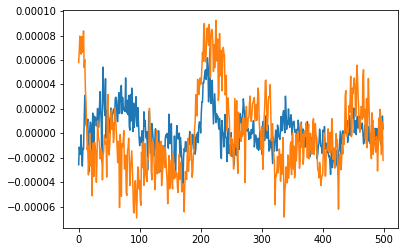

In [24]:
plt.plot(no_seizure[0][0])
plt.plot(seizure[0][0])

(250, 500)


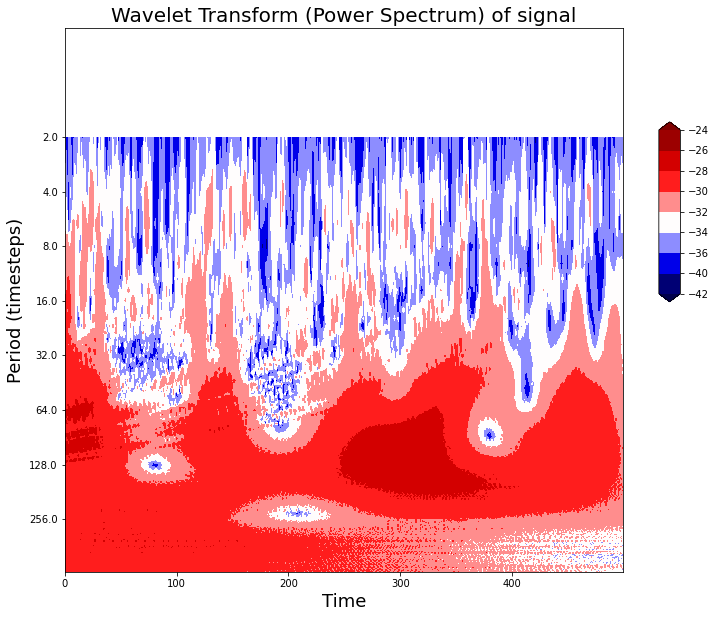

In [188]:
SECONDS = 2
sig = data[0][970*FREQ:970*FREQ + FREQ*SECONDS]
TIME = np.arange(0, FREQ*SECONDS)
plot_wavelet(TIME, sig, SCALES)

In [517]:
def xlsx_to_df(file_path):
    train_seizures_timing = pd.read_excel(
        file_path,
        sheet_name='train',
        header=0,
        names=['Patient', 'Session', 'File', 'EEG Type', 'Normal/Abnormal', 'Filename', 'Start', 'Stop', 'Seizure Type'],
        usecols='C:F, I, L, M:O'
    )
    
    dev_seizures_timing = pd.read_excel(
        file_path,
        sheet_name='dev',
        header=0,
        names=['Patient', 'Session', 'File', 'EEG Type', 'Normal/Abnormal', 'Filename', 'Start', 'Stop', 'Seizure Type'],
        usecols='C:F, I, L, M:O'
    )
    
    
    return train_seizures_timing, dev_seizures_timing

In [518]:
train_seizures_timing, dev_seizures_timing = xlsx_to_df('_DOCS/seizures_v36r.xlsx')
train_seizures_timing, dev_seizures_timing = train_seizures_timing.replace({np.nan: None}), dev_seizures_timing.replace({np.nan: None})

In [623]:
X_train_divided, X_test_divided = np.load('X_train_divided.npy'), np.load('X_test_divided.npy')

In [624]:
scaler = MinMaxScaler()
scaler.fit(X_train_divided)
scaler.fit(X_test_divided)
X_train_divided, X_test_divided = scaler.transform(X_train_divided), scaler.transform(X_test_divided)

# FAST FOURIER TRANSFORM

In [243]:
def fft_splitted_data(splitted_data, labels_file):
    '''
    Forms a part of a train dataset to fill in the whole training set
    By performing Discrete Fourier Transform on each of the channel entry 
    '''
    to_return = []
    for i in range(0, len(splitted_data[0])):
        features = []
        for j in range(0, len(splitted_data)):
            sig = splitted_data[j, i, :]
            coefficients = rfft(sig)
            
#             for c in coefficients_lst:
            features += get_features(coefficients)
        to_return.append(features)
    
    with open(labels_file, 'r') as f:
        labels = [LABELS_KEY[l.replace('\n', '')] for l in list(f.readlines())]
    
    Y = np.array(labels)
    X = np.array(to_return)
    
    return X, Y           

In [244]:
def main():
    '''
    The function retrieves the data from edf files, performs splitting data into n-sec parts,
    performs Discrete Fourier Transform, extracts main features and 
    saves all the data in the input shape for classification model
    '''
    train_data = np.array([])
    train_labels = np.array([])
    
    test_data = np.array([])
    test_labels = np.array([])
    
#     all_files = [list(find_all_paths('edf_test/train').values()), 
#                  list(find_all_paths('edf_test/dev').values())]
    all_files = [TRAIN_EDF_FILES, TEST_EDF_FILES]
    
    train = True
    
    for files in all_files:
        for file in tqdm(files):
            txt_file = file.replace('.edf', '.txt')
            print(txt_file)
            edf = create_raw_object(file)
            d, t = averaging_channel_information(edf)
            splitted = split_signal(d)

            labels_file, splitted_dropped = dropping_unnecessary_data(txt_file, splitted)

            data_dwt, labels = fft_splitted_data(splitted_dropped, txt_file)  
#             print(data_dwt.shape)
            
            if train:
                if train_data.size == 0:
                    train_data = data_dwt
                    train_labels = labels
                else:
                    train_data = np.vstack([train_data, data_dwt])
                    train_labels = np.concatenate([train_labels, labels])
                print(train_data.shape)

                
            else:
                if test_data.size == 0:
                    test_data = data_dwt
                    test_labels = labels
                else:
                    test_data = np.vstack([test_data, data_dwt])
                    test_labels = np.concatenate([test_labels, labels])
                print(test_data.shape)

        train = False
    
    return train_data, train_labels, test_data, test_labels

In [245]:
X_tr_fft, y_tr_fft, X_tst_fft, y_tst_fft = main()

  0%|          | 0/2269 [00:00<?, ?it/s]

edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/2269 [00:00<31:11,  1.21it/s]

(104, 84)
edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/2269 [00:02<39:07,  1.04s/it]

(280, 84)
edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/2269 [00:04<48:52,  1.29s/it]

(490, 84)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/2269 [00:06<54:01,  1.43s/it]

(683, 84)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 5/2269 [00:06<39:42,  1.05s/it]

(702, 84)
edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 6/2269 [00:10<1:15:42,  2.01s/it]

(1073, 84)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 7/2269 [00:11<1:05:49,  1.75s/it]

(1203, 84)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 8/2269 [00:12<55:25,  1.47s/it]  

(1303, 84)
edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 9/2269 [00:14<1:01:36,  1.64s/it]

(1519, 84)
edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 10/2269 [00:14<48:04,  1.28s/it] 

(1575, 84)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 11/2269 [00:15<42:45,  1.14s/it]

(1677, 84)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 12/2269 [00:15<32:55,  1.14it/s]

(1713, 84)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 13/2269 [00:16<28:46,  1.31it/s]

(1783, 84)
edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 14/2269 [00:18<44:26,  1.18s/it]

(2010, 84)
edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 15/2269 [00:20<55:41,  1.48s/it]

(2241, 84)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 16/2269 [00:21<50:35,  1.35s/it]

(2358, 84)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 17/2269 [00:22<43:44,  1.17s/it]

(2451, 84)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 18/2269 [00:23<38:45,  1.03s/it]

(2546, 84)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 19/2269 [00:24<43:15,  1.15s/it]

(2710, 84)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 20/2269 [00:25<37:40,  1.01s/it]

(2794, 84)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 21/2269 [00:25<30:14,  1.24it/s]

(2839, 84)
edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 22/2269 [00:28<48:05,  1.28s/it]

(3081, 84)
edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 23/2269 [00:30<55:25,  1.48s/it]

(3285, 84)
edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 24/2269 [00:31<1:00:19,  1.61s/it]

(3496, 84)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 25/2269 [00:33<55:35,  1.49s/it]  

(3642, 84)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 26/2269 [00:33<47:10,  1.26s/it]

(3739, 84)
edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 27/2269 [00:36<1:03:06,  1.69s/it]

(4013, 84)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 28/2269 [00:36<46:20,  1.24s/it]  

(4035, 84)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 29/2269 [00:38<53:54,  1.44s/it]

(4244, 84)
edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 30/2269 [00:40<59:23,  1.59s/it]

(4454, 84)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 31/2269 [00:40<42:45,  1.15s/it]

(4464, 84)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 32/2269 [00:42<51:50,  1.39s/it]

(4681, 84)
edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 33/2269 [00:45<1:12:38,  1.95s/it]

(4997, 84)
edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 34/2269 [00:47<1:12:41,  1.95s/it]

(5208, 84)
edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 35/2269 [00:49<1:13:24,  1.97s/it]

(5419, 84)
edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 36/2269 [00:52<1:15:42,  2.03s/it]

(5647, 84)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 37/2269 [00:55<1:32:21,  2.48s/it]

(5975, 84)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 38/2269 [00:55<1:07:05,  1.80s/it]

(6002, 84)
edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 39/2269 [00:57<1:08:08,  1.83s/it]

(6214, 84)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 40/2269 [00:58<54:21,  1.46s/it]  

(6290, 84)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 41/2269 [01:00<1:00:12,  1.62s/it]

(6507, 84)
edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 42/2269 [01:02<1:03:07,  1.70s/it]

(6712, 84)
edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 43/2269 [01:04<1:05:14,  1.76s/it]

(6919, 84)
edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 44/2269 [01:06<1:10:33,  1.90s/it]

(7155, 84)
edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 45/2269 [01:08<1:11:40,  1.93s/it]

(7370, 84)
edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 46/2269 [01:10<1:18:57,  2.13s/it]

(7635, 84)
edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 47/2269 [01:13<1:22:33,  2.23s/it]

(7888, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 48/2269 [01:14<1:06:08,  1.79s/it]

(7981, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 49/2269 [01:14<48:12,  1.30s/it]  

(8004, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 50/2269 [01:15<41:18,  1.12s/it]

(8092, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 51/2269 [01:15<36:52,  1.00it/s]

(8187, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 52/2269 [01:15<27:10,  1.36it/s]

(8203, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 53/2269 [01:17<41:59,  1.14s/it]

(8426, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 54/2269 [01:18<38:29,  1.04s/it]

(8528, 84)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 55/2269 [01:19<31:39,  1.17it/s]

(8586, 84)
edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 56/2269 [01:21<45:54,  1.24s/it]

(8811, 84)
edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 57/2269 [01:24<1:09:32,  1.89s/it]

(9124, 84)
edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 58/2269 [01:26<1:09:39,  1.89s/it]

(9334, 84)
edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 59/2269 [01:31<1:45:15,  2.86s/it]

(9761, 84)
edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 60/2269 [01:33<1:35:30,  2.59s/it]

(9971, 84)
edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 61/2269 [01:35<1:30:27,  2.46s/it]

(10192, 84)
edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 62/2269 [01:38<1:27:36,  2.38s/it]

(10422, 84)
edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 63/2269 [01:40<1:26:36,  2.36s/it]

(10664, 84)
edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 64/2269 [01:42<1:22:05,  2.23s/it]

(10878, 84)
edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 65/2269 [01:44<1:18:43,  2.14s/it]

(11088, 84)
edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 66/2269 [01:46<1:20:18,  2.19s/it]

(11327, 84)
edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 67/2269 [01:48<1:21:41,  2.23s/it]

(11564, 84)
edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 68/2269 [01:50<1:18:37,  2.14s/it]

(11775, 84)
edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 69/2269 [01:53<1:24:48,  2.31s/it]

(12045, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 70/2269 [01:53<1:01:48,  1.69s/it]

(12072, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 71/2269 [01:54<48:15,  1.32s/it]  

(12134, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 72/2269 [01:54<36:28,  1.00it/s]

(12168, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 73/2269 [01:54<28:04,  1.30it/s]

(12200, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 74/2269 [01:54<23:28,  1.56it/s]

(12248, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 75/2269 [01:55<21:45,  1.68it/s]

(12315, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 76/2269 [01:55<18:03,  2.02it/s]

(12350, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 77/2269 [01:55<14:08,  2.58it/s]

(12368, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 78/2269 [01:56<12:36,  2.89it/s]

(12402, 84)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 79/2269 [01:56<10:16,  3.55it/s]

(12420, 84)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 80/2269 [01:56<08:57,  4.07it/s]

(12442, 84)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 81/2269 [01:56<09:23,  3.88it/s]

(12483, 84)
edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 82/2269 [01:58<27:11,  1.34it/s]

(12694, 84)
edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 83/2269 [02:00<40:18,  1.11s/it]

(12907, 84)
edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 84/2269 [02:05<1:25:14,  2.34s/it]

(13345, 84)
edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 85/2269 [02:07<1:20:22,  2.21s/it]

(13556, 84)
edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 86/2269 [02:10<1:23:15,  2.29s/it]

(13802, 84)
edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 87/2269 [02:12<1:19:22,  2.18s/it]

(14011, 84)
edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 88/2269 [02:15<1:30:34,  2.49s/it]

(14307, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 89/2269 [02:15<1:07:16,  1.85s/it]

(14353, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 90/2269 [02:15<49:22,  1.36s/it]  

(14382, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 91/2269 [02:16<36:23,  1.00s/it]

(14405, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 92/2269 [02:16<27:27,  1.32it/s]

(14430, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 93/2269 [02:16<23:22,  1.55it/s]

(14483, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 94/2269 [02:16<18:02,  2.01it/s]

(14504, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 95/2269 [02:16<14:45,  2.46it/s]

(14531, 84)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 96/2269 [02:17<12:45,  2.84it/s]

(14561, 84)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(14567, 84)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(14571, 84)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 99/2269 [02:19<15:43,  2.30it/s]

(14775, 84)
edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 100/2269 [02:20<31:16,  1.16it/s]

(14983, 84)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 101/2269 [02:24<57:15,  1.58s/it]

(15301, 84)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 102/2269 [02:24<46:01,  1.27s/it]

(15373, 84)
edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 103/2269 [02:26<51:53,  1.44s/it]

(15579, 84)
edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 104/2269 [02:34<2:07:43,  3.54s/it]

(16193, 84)
edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 105/2269 [02:36<1:49:47,  3.04s/it]

(16403, 84)
edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 106/2269 [02:38<1:37:40,  2.71s/it]

(16616, 84)
edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 107/2269 [02:41<1:33:14,  2.59s/it]

(16858, 84)
edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 108/2269 [02:43<1:25:43,  2.38s/it]

(17071, 84)
edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 109/2269 [02:45<1:22:57,  2.30s/it]

(17301, 84)
edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 110/2269 [02:47<1:19:03,  2.20s/it]

(17512, 84)
edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 111/2269 [02:48<1:14:51,  2.08s/it]

(17711, 84)
edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 112/2269 [02:51<1:16:18,  2.12s/it]

(17944, 84)
edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 113/2269 [02:55<1:43:51,  2.89s/it]

(18345, 84)
edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 114/2269 [02:57<1:33:31,  2.60s/it]

(18555, 84)
edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 115/2269 [02:59<1:25:42,  2.39s/it]

(18766, 84)
edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 116/2269 [03:02<1:27:20,  2.43s/it]

(19027, 84)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 117/2269 [03:03<1:12:45,  2.03s/it]

(19161, 84)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 118/2269 [03:04<59:06,  1.65s/it]  

(19262, 84)
edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 119/2269 [03:07<1:21:12,  2.27s/it]

(19611, 84)
edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 120/2269 [03:09<1:18:19,  2.19s/it]

(19828, 84)
edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 121/2269 [03:11<1:15:40,  2.11s/it]

(20043, 84)
edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 122/2269 [03:13<1:13:11,  2.05s/it]

(20252, 84)
edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 123/2269 [03:13<55:01,  1.54s/it]  

(20298, 84)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 124/2269 [03:14<47:30,  1.33s/it]

(20408, 84)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 125/2269 [03:15<37:36,  1.05s/it]

(20464, 84)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 126/2269 [03:15<30:02,  1.19it/s]

(20512, 84)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 127/2269 [03:15<25:52,  1.38it/s]

(20574, 84)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 128/2269 [03:16<22:44,  1.57it/s]

(20633, 84)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 129/2269 [03:16<20:04,  1.78it/s]

(20687, 84)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 130/2269 [03:17<17:15,  2.07it/s]

(20728, 84)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 131/2269 [03:17<16:07,  2.21it/s]

(20780, 84)
edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 132/2269 [03:19<33:42,  1.06it/s]

(21006, 84)
edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 133/2269 [03:22<51:03,  1.43s/it]

(21274, 84)
edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 134/2269 [03:24<55:57,  1.57s/it]

(21484, 84)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 135/2269 [03:24<44:21,  1.25s/it]

(21549, 84)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 136/2269 [03:25<43:59,  1.24s/it]

(21699, 84)
edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 137/2269 [03:28<57:30,  1.62s/it]

(21963, 84)
edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 138/2269 [03:30<1:01:41,  1.74s/it]

(22184, 84)
edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 139/2269 [03:32<1:05:31,  1.85s/it]

(22412, 84)
edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 140/2269 [03:34<1:07:59,  1.92s/it]

(22638, 84)
edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 141/2269 [03:39<1:43:18,  2.91s/it]

(23082, 84)
edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 142/2269 [03:41<1:32:32,  2.61s/it]

(23293, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 143/2269 [03:41<1:06:48,  1.89s/it]

(23315, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23326, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 145/2269 [03:42<48:05,  1.36s/it]  

(23348, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 146/2269 [03:42<36:07,  1.02s/it]

(23380, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 147/2269 [03:42<28:37,  1.24it/s]

(23423, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 148/2269 [03:42<21:50,  1.62it/s]

(23445, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 149/2269 [03:43<18:07,  1.95it/s]

(23482, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 150/2269 [03:43<16:52,  2.09it/s]

(23537, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 151/2269 [03:43<13:35,  2.60it/s]

(23559, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 152/2269 [03:43<11:12,  3.15it/s]

(23581, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 153/2269 [03:43<09:46,  3.61it/s]

(23606, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 154/2269 [03:44<08:32,  4.13it/s]

(23628, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 155/2269 [03:44<07:40,  4.59it/s]

(23650, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 156/2269 [03:44<07:05,  4.97it/s]

(23672, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 157/2269 [03:44<10:34,  3.33it/s]

(23746, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 158/2269 [03:45<09:50,  3.57it/s]

(23778, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 159/2269 [03:45<09:23,  3.75it/s]

(23810, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 160/2269 [03:45<08:17,  4.24it/s]

(23832, 84)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 161/2269 [03:45<08:16,  4.25it/s]

(23864, 84)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 162/2269 [03:46<08:21,  4.20it/s]

(23897, 84)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 163/2269 [03:46<08:21,  4.20it/s]

(23929, 84)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 164/2269 [03:46<07:05,  4.95it/s]

(23944, 84)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 165/2269 [03:46<06:03,  5.79it/s]

(23957, 84)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 166/2269 [03:46<06:43,  5.21it/s]

(23989, 84)
edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 167/2269 [03:49<31:18,  1.12it/s]

(24246, 84)
edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 168/2269 [03:51<42:52,  1.22s/it]

(24457, 84)
edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 169/2269 [03:53<50:49,  1.45s/it]

(24669, 84)
edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 170/2269 [03:55<55:45,  1.59s/it]

(24879, 84)
edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 171/2269 [03:57<1:01:15,  1.75s/it]

(25104, 84)
edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 172/2269 [03:59<1:06:57,  1.92s/it]

(25344, 84)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 173/2269 [04:01<1:08:59,  1.98s/it]

(25571, 84)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(25577, 84)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 175/2269 [04:01<49:13,  1.41s/it]  

(25590, 84)
edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 176/2269 [04:03<56:09,  1.61s/it]

(25813, 84)
edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 177/2269 [04:05<1:00:12,  1.73s/it]

(26029, 84)
edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 178/2269 [04:07<1:02:16,  1.79s/it]

(26239, 84)
edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 179/2269 [04:09<1:02:29,  1.79s/it]

(26440, 84)
edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 180/2269 [04:11<1:03:37,  1.83s/it]

(26650, 84)
edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 181/2269 [04:13<1:06:32,  1.91s/it]

(26881, 84)
edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 182/2269 [04:15<1:05:57,  1.90s/it]

(27091, 84)
edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 183/2269 [04:17<1:05:35,  1.89s/it]

(27298, 84)
edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 184/2269 [04:18<1:00:40,  1.75s/it]

(27462, 84)
edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 185/2269 [04:20<1:02:30,  1.80s/it]

(27673, 84)
edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 186/2269 [04:23<1:16:49,  2.21s/it]

(27977, 84)
edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 187/2269 [04:25<1:13:29,  2.12s/it]

(28186, 84)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 188/2269 [04:26<55:35,  1.60s/it]  

(28241, 84)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 189/2269 [04:26<43:30,  1.26s/it]

(28301, 84)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 190/2269 [04:27<34:49,  1.01s/it]

(28359, 84)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 191/2269 [04:27<28:48,  1.20it/s]

(28417, 84)
edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 192/2269 [04:29<44:09,  1.28s/it]

(28663, 84)
edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 193/2269 [04:31<50:34,  1.46s/it]

(28873, 84)
edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 194/2269 [04:33<57:44,  1.67s/it]

(29106, 84)
edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 195/2269 [04:35<1:00:12,  1.74s/it]

(29318, 84)
edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 196/2269 [04:38<1:05:19,  1.89s/it]

(29560, 84)
edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 197/2269 [04:39<1:02:28,  1.81s/it]

(29747, 84)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 198/2269 [04:39<46:02,  1.33s/it]  

(29775, 84)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 199/2269 [04:41<48:13,  1.40s/it]

(29958, 84)
edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 200/2269 [04:43<53:05,  1.54s/it]

(30169, 84)
edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 201/2269 [04:45<57:35,  1.67s/it]

(30387, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 202/2269 [04:45<44:14,  1.28s/it]

(30438, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 203/2269 [04:45<32:48,  1.05it/s]

(30462, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 204/2269 [04:46<25:54,  1.33it/s]

(30502, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 205/2269 [04:46<19:53,  1.73it/s]

(30525, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(30537, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 207/2269 [04:46<16:27,  2.09it/s]

(30593, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 208/2269 [04:47<14:35,  2.35it/s]

(30635, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 209/2269 [04:47<13:17,  2.58it/s]

(30677, 84)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(30681, 84)
edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 211/2269 [04:49<19:07,  1.79it/s]

(30891, 84)
edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 212/2269 [04:51<33:22,  1.03it/s]

(31103, 84)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 213/2269 [04:51<25:54,  1.32it/s]

(31130, 84)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 214/2269 [04:53<34:27,  1.01s/it]

(31318, 84)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 215/2269 [04:54<42:47,  1.25s/it]

(31522, 84)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(31530, 84)
edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 217/2269 [04:56<35:45,  1.05s/it]

(31662, 84)
edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 218/2269 [04:57<44:05,  1.29s/it]

(31872, 84)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 219/2269 [04:58<39:16,  1.15s/it]

(31978, 84)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 220/2269 [04:59<37:15,  1.09s/it]

(32100, 84)
edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 221/2269 [05:01<45:15,  1.33s/it]

(32312, 84)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 222/2269 [05:02<40:23,  1.18s/it]

(32421, 84)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 223/2269 [05:02<30:31,  1.12it/s]

(32451, 84)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 224/2269 [05:02<23:42,  1.44it/s]

(32482, 84)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 225/2269 [05:03<20:44,  1.64it/s]

(32538, 84)
edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 226/2269 [05:05<33:39,  1.01it/s]

(32748, 84)
edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 227/2269 [05:07<44:22,  1.30s/it]

(32968, 84)
edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 228/2269 [05:09<49:59,  1.47s/it]

(33176, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 229/2269 [05:09<37:47,  1.11s/it]

(33211, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 230/2269 [05:09<27:48,  1.22it/s]

(33229, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(33235, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 232/2269 [05:10<22:49,  1.49it/s]

(33319, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 233/2269 [05:10<19:10,  1.77it/s]

(33363, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 234/2269 [05:10<14:46,  2.29it/s]

(33381, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 235/2269 [05:10<12:16,  2.76it/s]

(33407, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 236/2269 [05:10<10:31,  3.22it/s]

(33433, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 237/2269 [05:11<09:39,  3.51it/s]

(33464, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 238/2269 [05:11<10:31,  3.21it/s]

(33516, 84)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 239/2269 [05:11<08:23,  4.03it/s]

(33529, 84)
edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 240/2269 [05:13<24:55,  1.36it/s]

(33740, 84)
edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 241/2269 [05:15<36:12,  1.07s/it]

(33950, 84)
edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 242/2269 [05:17<45:43,  1.35s/it]

(34171, 84)
edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 243/2269 [05:19<51:31,  1.53s/it]

(34384, 84)
edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 244/2269 [05:21<55:17,  1.64s/it]

(34595, 84)
edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 245/2269 [05:23<1:02:45,  1.86s/it]

(34843, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 246/2269 [05:23<45:38,  1.35s/it]  

(34862, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 247/2269 [05:24<34:42,  1.03s/it]

(34900, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(34912, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 249/2269 [05:24<25:26,  1.32it/s]

(34930, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 250/2269 [05:24<19:35,  1.72it/s]

(34954, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 251/2269 [05:24<14:55,  2.25it/s]

(34969, 84)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 252/2269 [05:24<12:46,  2.63it/s]

(35001, 84)
edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 253/2269 [05:26<28:28,  1.18it/s]

(35217, 84)
edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 254/2269 [05:30<54:22,  1.62s/it]

(35548, 84)
edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 255/2269 [05:32<57:22,  1.71s/it]

(35759, 84)
edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 256/2269 [05:34<1:00:46,  1.81s/it]

(35980, 84)
edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 257/2269 [05:36<1:01:43,  1.84s/it]

(36191, 84)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 258/2269 [05:36<45:51,  1.37s/it]  

(36228, 84)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 259/2269 [05:36<35:44,  1.07s/it]

(36279, 84)
edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 260/2269 [05:38<44:41,  1.33s/it]

(36496, 84)
edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 261/2269 [05:41<55:18,  1.65s/it]

(36750, 84)
edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 262/2269 [05:43<1:01:56,  1.85s/it]

(36993, 84)
edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 263/2269 [05:44<56:50,  1.70s/it]  

(37156, 84)
edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 264/2269 [05:46<58:22,  1.75s/it]

(37366, 84)
edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 265/2269 [05:48<59:56,  1.79s/it]

(37576, 84)
edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 266/2269 [05:49<49:30,  1.48s/it]

(37673, 84)
edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 267/2269 [05:51<53:43,  1.61s/it]

(37879, 84)
edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 268/2269 [05:53<57:39,  1.73s/it]

(38094, 84)
edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 269/2269 [05:55<1:06:47,  2.00s/it]

(38365, 84)
edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 270/2269 [05:58<1:12:00,  2.16s/it]

(38628, 84)
edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 271/2269 [06:00<1:15:57,  2.28s/it]

(38891, 84)
edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 272/2269 [06:03<1:16:22,  2.29s/it]

(39136, 84)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 273/2269 [06:04<1:06:17,  1.99s/it]

(39291, 84)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 274/2269 [06:04<50:20,  1.51s/it]  

(39346, 84)
edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 275/2269 [06:06<55:03,  1.66s/it]

(39564, 84)
edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 276/2269 [06:08<58:21,  1.76s/it]

(39781, 84)
edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 277/2269 [06:10<59:46,  1.80s/it]

(39994, 84)
edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 278/2269 [06:12<1:00:56,  1.84s/it]

(40205, 84)
edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 279/2269 [06:14<1:01:48,  1.86s/it]

(40415, 84)
edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 280/2269 [06:16<1:00:11,  1.82s/it]

(40608, 84)
edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 281/2269 [06:18<1:01:20,  1.85s/it]

(40819, 84)
edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 282/2269 [06:20<1:06:52,  2.02s/it]

(41068, 84)
edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 283/2269 [06:22<1:07:08,  2.03s/it]

(41292, 84)
edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 284/2269 [06:24<1:09:23,  2.10s/it]

(41530, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 285/2269 [06:25<54:55,  1.66s/it]  

(41611, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 286/2269 [06:26<44:49,  1.36s/it]

(41697, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 287/2269 [06:26<33:24,  1.01s/it]

(41725, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 288/2269 [06:26<25:16,  1.31it/s]

(41751, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 289/2269 [06:27<26:37,  1.24it/s]

(41867, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 290/2269 [06:29<42:55,  1.30s/it]

(42123, 84)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 291/2269 [06:30<37:30,  1.14s/it]

(42220, 84)
edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 292/2269 [06:32<44:56,  1.36s/it]

(42431, 84)
edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 293/2269 [06:34<51:14,  1.56s/it]

(42650, 84)
edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 294/2269 [06:36<55:15,  1.68s/it]

(42861, 84)
edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 295/2269 [06:39<1:05:48,  2.00s/it]

(43134, 84)
edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 296/2269 [06:41<1:05:33,  1.99s/it]

(43346, 84)
edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 297/2269 [06:43<1:08:56,  2.10s/it]

(43588, 84)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 298/2269 [06:44<53:27,  1.63s/it]  

(43656, 84)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 299/2269 [06:45<48:47,  1.49s/it]

(43797, 84)
edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 300/2269 [06:47<53:15,  1.62s/it]

(44007, 84)
edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 301/2269 [06:56<2:07:21,  3.88s/it]

(44621, 84)
edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 302/2269 [06:58<1:48:09,  3.30s/it]

(44829, 84)
edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 303/2269 [07:01<1:41:50,  3.11s/it]

(45097, 84)
edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 304/2269 [07:03<1:32:06,  2.81s/it]

(45322, 84)
edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 305/2269 [07:05<1:23:49,  2.56s/it]

(45534, 84)
edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 306/2269 [07:07<1:17:41,  2.37s/it]

(45744, 84)
edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 307/2269 [07:09<1:15:39,  2.31s/it]

(45972, 84)
edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 308/2269 [07:13<1:29:41,  2.74s/it]

(46320, 84)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 309/2269 [07:14<1:13:05,  2.24s/it]

(46450, 84)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 310/2269 [07:15<1:03:01,  1.93s/it]

(46597, 84)
edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 311/2269 [07:17<1:03:38,  1.95s/it]

(46815, 84)
edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 312/2269 [07:20<1:16:45,  2.35s/it]

(47133, 84)
edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 313/2269 [07:23<1:20:57,  2.48s/it]

(47406, 84)
edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 314/2269 [07:25<1:15:51,  2.33s/it]

(47618, 84)
edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 315/2269 [07:27<1:17:59,  2.39s/it]

(47880, 84)
edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 316/2269 [07:29<1:13:18,  2.25s/it]

(48092, 84)
edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 317/2269 [07:31<1:11:43,  2.20s/it]

(48317, 84)
edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 318/2269 [07:33<1:08:45,  2.11s/it]

(48528, 84)
edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 319/2269 [07:35<1:08:02,  2.09s/it]

(48749, 84)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 320/2269 [07:35<48:45,  1.50s/it]  

(48756, 84)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 321/2269 [07:36<40:13,  1.24s/it]

(48840, 84)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 322/2269 [07:36<29:22,  1.10it/s]

(48856, 84)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 323/2269 [07:37<28:05,  1.15it/s]

(48957, 84)
edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 324/2269 [07:39<37:52,  1.17s/it]

(49164, 84)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 325/2269 [07:41<49:02,  1.51s/it]

(49406, 84)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 326/2269 [07:41<36:08,  1.12s/it]

(49427, 84)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 327/2269 [07:42<26:51,  1.20it/s]

(49448, 84)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 328/2269 [07:44<41:15,  1.28s/it]

(49692, 84)
edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 329/2269 [07:46<52:20,  1.62s/it]

(49943, 84)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 330/2269 [07:49<1:07:00,  2.07s/it]

(50241, 84)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 331/2269 [07:50<48:42,  1.51s/it]  

(50262, 84)
edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 332/2269 [07:52<54:45,  1.70s/it]

(50486, 84)
edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 333/2269 [07:54<57:37,  1.79s/it]

(50703, 84)
edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 334/2269 [07:56<1:03:53,  1.98s/it]

(50953, 84)
edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 335/2269 [07:58<1:06:15,  2.06s/it]

(51186, 84)
edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 336/2269 [08:01<1:10:35,  2.19s/it]

(51442, 84)
edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 337/2269 [08:03<1:08:09,  2.12s/it]

(51654, 84)
edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 338/2269 [08:05<1:06:00,  2.05s/it]

(51862, 84)
edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 339/2269 [08:07<1:04:20,  2.00s/it]

(52069, 84)
edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 340/2269 [08:09<1:03:17,  1.97s/it]

(52279, 84)
edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 341/2269 [08:11<1:08:18,  2.13s/it]

(52533, 84)
edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 342/2269 [08:13<1:08:55,  2.15s/it]

(52765, 84)
edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 343/2269 [08:15<1:07:01,  2.09s/it]

(52977, 84)
edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 344/2269 [08:21<1:45:13,  3.28s/it]

(53452, 84)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 345/2269 [08:22<1:22:55,  2.59s/it]

(53575, 84)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 346/2269 [08:23<1:05:04,  2.03s/it]

(53673, 84)
edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 347/2269 [08:25<1:09:03,  2.16s/it]

(53930, 84)
edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 348/2269 [08:28<1:12:20,  2.26s/it]

(54184, 84)
edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 349/2269 [08:30<1:09:49,  2.18s/it]

(54400, 84)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(54408, 84)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 351/2269 [08:31<55:46,  1.74s/it]  

(54572, 84)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 352/2269 [08:32<42:05,  1.32s/it]

(54616, 84)
edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 353/2269 [08:34<48:40,  1.52s/it]

(54836, 84)
edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 354/2269 [08:36<52:22,  1.64s/it]

(55047, 84)
edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 355/2269 [08:37<54:47,  1.72s/it]

(55252, 84)
edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 356/2269 [08:40<58:35,  1.84s/it]

(55480, 84)
edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 357/2269 [08:42<59:36,  1.87s/it]

(55690, 84)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 358/2269 [08:42<48:34,  1.53s/it]

(55780, 84)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 359/2269 [08:43<37:46,  1.19s/it]

(55834, 84)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 360/2269 [08:43<30:57,  1.03it/s]

(55898, 84)
edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 361/2269 [08:45<41:19,  1.30s/it]

(56121, 84)
edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 362/2269 [08:48<51:10,  1.61s/it]

(56362, 84)
edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 363/2269 [08:49<54:13,  1.71s/it]

(56572, 84)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 364/2269 [08:51<56:32,  1.78s/it]

(56783, 84)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 365/2269 [08:52<40:34,  1.28s/it]

(56792, 84)
edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 366/2269 [08:53<46:36,  1.47s/it]

(57003, 84)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 367/2269 [08:55<49:52,  1.57s/it]

(57206, 84)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 368/2269 [08:56<38:46,  1.22s/it]

(57255, 84)
edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 369/2269 [08:58<44:58,  1.42s/it]

(57463, 84)
edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 370/2269 [08:58<37:59,  1.20s/it]

(57553, 84)
edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 371/2269 [09:00<44:43,  1.41s/it]

(57764, 84)
edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 372/2269 [09:02<49:41,  1.57s/it]

(57975, 84)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 373/2269 [09:06<1:10:57,  2.25s/it]

(58326, 84)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 374/2269 [09:07<58:46,  1.86s/it]  

(58443, 84)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 375/2269 [09:09<59:48,  1.89s/it]

(58659, 84)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 376/2269 [09:09<45:43,  1.45s/it]

(58713, 84)
edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 377/2269 [09:11<51:18,  1.63s/it]

(58931, 84)
edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 378/2269 [09:13<54:14,  1.72s/it]

(59141, 84)
edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 379/2269 [09:22<1:57:01,  3.71s/it]

(59740, 84)
edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 380/2269 [09:24<1:43:05,  3.27s/it]

(59976, 84)
edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 381/2269 [09:26<1:32:06,  2.93s/it]

(60200, 84)
edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 382/2269 [09:28<1:23:14,  2.65s/it]

(60413, 84)
edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 383/2269 [09:30<1:16:56,  2.45s/it]

(60628, 84)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 384/2269 [09:32<1:12:01,  2.29s/it]

(60837, 84)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 385/2269 [09:37<1:34:59,  3.03s/it]

(61248, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 386/2269 [09:37<1:08:24,  2.18s/it]

(61271, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(61275, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 388/2269 [09:38<51:24,  1.64s/it]  

(61369, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 389/2269 [09:38<38:03,  1.21s/it]

(61399, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 390/2269 [09:40<46:54,  1.50s/it]

(61632, 84)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 391/2269 [09:40<34:52,  1.11s/it]

(61654, 84)
edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 392/2269 [09:42<42:27,  1.36s/it]

(61868, 84)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 393/2269 [09:42<33:35,  1.07s/it]

(61921, 84)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 394/2269 [09:43<29:21,  1.06it/s]

(62005, 84)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 395/2269 [09:44<24:13,  1.29it/s]

(62059, 84)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 396/2269 [09:44<21:16,  1.47it/s]

(62123, 84)
edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 397/2269 [09:46<35:45,  1.15s/it]

(62361, 84)
edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 398/2269 [09:48<43:01,  1.38s/it]

(62571, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(62582, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 400/2269 [09:49<32:25,  1.04s/it]

(62637, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 401/2269 [09:49<25:36,  1.22it/s]

(62680, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 402/2269 [09:49<21:45,  1.43it/s]

(62735, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 403/2269 [09:50<18:52,  1.65it/s]

(62788, 84)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(62799, 84)
edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 405/2269 [09:52<23:34,  1.32it/s]

(63024, 84)
edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 406/2269 [09:54<34:47,  1.12s/it]

(63238, 84)
edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 407/2269 [09:56<48:10,  1.55s/it]

(63501, 84)
edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 408/2269 [09:59<53:44,  1.73s/it]

(63729, 84)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 409/2269 [09:59<40:05,  1.29s/it]

(63765, 84)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 410/2269 [10:00<39:38,  1.28s/it]

(63913, 84)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 411/2269 [10:01<40:01,  1.29s/it]

(64068, 84)
edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 412/2269 [10:03<45:58,  1.49s/it]

(64279, 84)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 413/2269 [10:05<42:44,  1.38s/it]

(64413, 84)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 414/2269 [10:05<35:30,  1.15s/it]

(64489, 84)
edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 415/2269 [10:08<48:05,  1.56s/it]

(64746, 84)
edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 416/2269 [10:10<51:54,  1.68s/it]

(64956, 84)
edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 417/2269 [10:12<1:00:33,  1.96s/it]

(65219, 84)
edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 418/2269 [10:15<1:05:06,  2.11s/it]

(65471, 84)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 419/2269 [10:19<1:23:13,  2.70s/it]

(65840, 84)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 420/2269 [10:20<1:12:19,  2.35s/it]

(66016, 84)
edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 421/2269 [10:23<1:15:38,  2.46s/it]

(66293, 84)
edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 422/2269 [10:26<1:20:13,  2.61s/it]

(66589, 84)
edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 423/2269 [10:28<1:14:04,  2.41s/it]

(66806, 84)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 424/2269 [10:29<1:00:45,  1.98s/it]

(66929, 84)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 425/2269 [10:30<48:59,  1.59s/it]  

(67021, 84)
edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 426/2269 [10:31<51:24,  1.67s/it]

(67229, 84)
edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 427/2269 [10:33<53:48,  1.75s/it]

(67445, 84)
edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 428/2269 [10:35<55:36,  1.81s/it]

(67659, 84)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 429/2269 [10:36<47:41,  1.56s/it]

(67779, 84)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 430/2269 [10:37<40:14,  1.31s/it]

(67877, 84)
edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 431/2269 [10:39<45:16,  1.48s/it]

(68087, 84)
edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 432/2269 [10:41<49:26,  1.61s/it]

(68297, 84)
edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 433/2269 [10:41<37:20,  1.22s/it]

(68334, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 434/2269 [10:42<31:21,  1.03s/it]

(68410, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(68421, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 436/2269 [10:42<22:49,  1.34it/s]

(68432, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(68440, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 438/2269 [10:42<17:08,  1.78it/s]

(68463, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 439/2269 [10:43<16:12,  1.88it/s]

(68525, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(68532, 84)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 441/2269 [10:43<13:58,  2.18it/s]

(68599, 84)
edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 442/2269 [10:45<27:08,  1.12it/s]

(68809, 84)
edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 443/2269 [10:47<38:32,  1.27s/it]

(69038, 84)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 444/2269 [10:48<32:56,  1.08s/it]

(69122, 84)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 445/2269 [10:48<26:29,  1.15it/s]

(69173, 84)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 446/2269 [10:49<23:49,  1.28it/s]

(69249, 84)
edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 447/2269 [10:56<1:19:49,  2.63s/it]

(69787, 84)
edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 448/2269 [10:59<1:27:01,  2.87s/it]

(70111, 84)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 449/2269 [10:59<1:03:22,  2.09s/it]

(70144, 84)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 450/2269 [11:00<52:14,  1.72s/it]  

(70254, 84)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 451/2269 [11:01<45:45,  1.51s/it]

(70380, 84)
edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 452/2269 [11:04<51:34,  1.70s/it]

(70606, 84)
edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 453/2269 [11:05<53:30,  1.77s/it]

(70817, 84)
edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 454/2269 [11:07<54:20,  1.80s/it]

(71024, 84)
edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 455/2269 [11:09<55:34,  1.84s/it]

(71234, 84)
edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 456/2269 [11:12<1:01:31,  2.04s/it]

(71493, 84)
edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 457/2269 [11:14<1:00:50,  2.01s/it]

(71710, 84)
edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 458/2269 [11:16<1:00:09,  1.99s/it]

(71922, 84)
edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 459/2269 [11:18<59:19,  1.97s/it]  

(72131, 84)
edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 460/2269 [11:20<1:01:35,  2.04s/it]

(72364, 84)
edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 461/2269 [11:22<1:02:26,  2.07s/it]

(72593, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 462/2269 [11:22<46:24,  1.54s/it]  

(72628, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 463/2269 [11:23<36:57,  1.23s/it]

(72695, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 464/2269 [11:23<27:57,  1.08it/s]

(72724, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(72728, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 466/2269 [11:24<22:07,  1.36it/s]

(72797, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 467/2269 [11:24<17:33,  1.71it/s]

(72827, 84)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 468/2269 [11:24<15:04,  1.99it/s]

(72867, 84)
edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 469/2269 [11:26<28:51,  1.04it/s]

(73090, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 470/2269 [11:27<24:06,  1.24it/s]

(73144, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 471/2269 [11:27<24:22,  1.23it/s]

(73251, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 472/2269 [11:28<24:34,  1.22it/s]

(73358, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 473/2269 [11:29<24:40,  1.21it/s]

(73465, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 474/2269 [11:30<24:47,  1.21it/s]

(73572, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 475/2269 [11:30<20:53,  1.43it/s]

(73626, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 476/2269 [11:31<21:30,  1.39it/s]

(73724, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 477/2269 [11:31<18:37,  1.60it/s]

(73778, 84)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 478/2269 [11:32<16:43,  1.78it/s]

(73832, 84)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 479/2269 [11:32<13:18,  2.24it/s]

(73855, 84)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 480/2269 [11:32<11:30,  2.59it/s]

(73886, 84)
edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 481/2269 [11:35<28:26,  1.05it/s]

(74128, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 482/2269 [11:35<27:19,  1.09it/s]

(74235, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 483/2269 [11:36<22:35,  1.32it/s]

(74289, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 484/2269 [11:36<19:27,  1.53it/s]

(74343, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 485/2269 [11:37<17:11,  1.73it/s]

(74397, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 486/2269 [11:37<19:38,  1.51it/s]

(74504, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 487/2269 [11:38<21:13,  1.40it/s]

(74611, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 488/2269 [11:39<18:34,  1.60it/s]

(74665, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 489/2269 [11:40<28:49,  1.03it/s]

(74864, 84)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 490/2269 [11:41<24:10,  1.23it/s]

(74918, 84)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 491/2269 [11:43<35:40,  1.20s/it]

(75146, 84)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 492/2269 [11:43<26:36,  1.11it/s]

(75164, 84)
edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(75168, 84)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 494/2269 [11:45<27:39,  1.07it/s]

(75384, 84)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 495/2269 [11:46<26:29,  1.12it/s]

(75488, 84)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 496/2269 [11:47<22:58,  1.29it/s]

(75552, 84)
edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 497/2269 [11:50<45:16,  1.53s/it]

(75858, 84)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 498/2269 [11:51<40:12,  1.36s/it]

(75965, 84)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 499/2269 [11:52<36:11,  1.23s/it]

(76072, 84)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 500/2269 [11:53<33:08,  1.12s/it]

(76179, 84)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 501/2269 [11:53<30:26,  1.03s/it]

(76286, 84)
edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 502/2269 [11:55<39:02,  1.33s/it]

(76504, 84)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 503/2269 [11:56<34:36,  1.18s/it]

(76611, 84)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 504/2269 [11:57<31:50,  1.08s/it]

(76718, 84)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 505/2269 [11:58<29:39,  1.01s/it]

(76825, 84)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 506/2269 [11:59<28:22,  1.04it/s]

(76932, 84)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 507/2269 [12:00<33:11,  1.13s/it]

(77108, 84)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 508/2269 [12:01<29:32,  1.01s/it]

(77199, 84)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 509/2269 [12:02<27:55,  1.05it/s]

(77306, 84)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 510/2269 [12:03<27:04,  1.08it/s]

(77413, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 511/2269 [12:04<26:07,  1.12it/s]

(77520, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 512/2269 [12:06<41:09,  1.41s/it]

(77786, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 513/2269 [12:07<35:58,  1.23s/it]

(77893, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 514/2269 [12:08<33:31,  1.15s/it]

(78012, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 515/2269 [12:10<37:19,  1.28s/it]

(78196, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 516/2269 [12:10<33:46,  1.16s/it]

(78303, 84)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 517/2269 [12:11<30:55,  1.06s/it]

(78410, 84)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 518/2269 [12:13<39:11,  1.34s/it]

(78629, 84)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(78640, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 520/2269 [12:14<31:35,  1.08s/it]

(78747, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 521/2269 [12:15<29:14,  1.00s/it]

(78854, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 522/2269 [12:16<27:54,  1.04it/s]

(78961, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 523/2269 [12:17<26:45,  1.09it/s]

(79068, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 524/2269 [12:18<26:12,  1.11it/s]

(79175, 84)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 525/2269 [12:18<25:35,  1.14it/s]

(79282, 84)
edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 526/2269 [12:21<36:27,  1.25s/it]

(79514, 84)
edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 527/2269 [12:22<42:30,  1.46s/it]

(79731, 84)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 528/2269 [12:23<37:04,  1.28s/it]

(79838, 84)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 529/2269 [12:24<33:02,  1.14s/it]

(79945, 84)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 530/2269 [12:24<26:09,  1.11it/s]

(79988, 84)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 531/2269 [12:25<25:40,  1.13it/s]

(80095, 84)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 532/2269 [12:26<25:34,  1.13it/s]

(80202, 84)
edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 533/2269 [12:27<26:07,  1.11it/s]

(80321, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 534/2269 [12:28<22:06,  1.31it/s]

(80375, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 535/2269 [12:28<22:43,  1.27it/s]

(80482, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 536/2269 [12:31<33:57,  1.18s/it]

(80705, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 537/2269 [12:31<31:06,  1.08s/it]

(80812, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 538/2269 [12:32<25:32,  1.13it/s]

(80866, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 539/2269 [12:33<25:12,  1.14it/s]

(80973, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 540/2269 [12:33<21:28,  1.34it/s]

(81027, 84)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 541/2269 [12:34<18:31,  1.55it/s]

(81081, 84)
edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 542/2269 [12:39<59:41,  2.07s/it]

(81518, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 543/2269 [12:40<49:08,  1.71s/it]

(81625, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 544/2269 [12:41<41:56,  1.46s/it]

(81732, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 545/2269 [12:41<36:32,  1.27s/it]

(81839, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 546/2269 [12:42<31:04,  1.08s/it]

(81921, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 547/2269 [12:43<25:13,  1.14it/s]

(81975, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 548/2269 [12:43<24:53,  1.15it/s]

(82082, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 549/2269 [12:44<20:53,  1.37it/s]

(82136, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 550/2269 [12:44<18:06,  1.58it/s]

(82190, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 551/2269 [12:45<16:01,  1.79it/s]

(82244, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 552/2269 [12:45<14:43,  1.94it/s]

(82298, 84)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 553/2269 [12:46<17:25,  1.64it/s]

(82405, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 554/2269 [12:46<15:42,  1.82it/s]

(82459, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 555/2269 [12:47<18:05,  1.58it/s]

(82566, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 556/2269 [12:48<21:15,  1.34it/s]

(82690, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 557/2269 [12:48<16:12,  1.76it/s]

(82706, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 558/2269 [12:49<14:50,  1.92it/s]

(82760, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 559/2269 [12:49<13:47,  2.07it/s]

(82814, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 560/2269 [12:50<16:46,  1.70it/s]

(82921, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 561/2269 [12:50<14:06,  2.02it/s]

(82958, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 562/2269 [12:51<17:01,  1.67it/s]

(83065, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 563/2269 [12:52<18:57,  1.50it/s]

(83172, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 564/2269 [12:53<20:28,  1.39it/s]

(83279, 84)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 565/2269 [12:53<17:39,  1.61it/s]

(83333, 84)
edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 566/2269 [12:55<30:18,  1.07s/it]

(83561, 84)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 567/2269 [12:56<26:40,  1.06it/s]

(83643, 84)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 568/2269 [12:57<25:48,  1.10it/s]

(83750, 84)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 569/2269 [12:57<21:25,  1.32it/s]

(83804, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 570/2269 [12:57<18:26,  1.54it/s]

(83858, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 571/2269 [12:58<19:29,  1.45it/s]

(83958, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 572/2269 [12:59<20:50,  1.36it/s]

(84065, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 573/2269 [13:00<21:41,  1.30it/s]

(84172, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 574/2269 [13:00<18:41,  1.51it/s]

(84226, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(84231, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 576/2269 [13:02<18:10,  1.55it/s]

(84370, 84)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 577/2269 [13:02<19:48,  1.42it/s]

(84477, 84)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 578/2269 [13:03<17:19,  1.63it/s]

(84531, 84)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 579/2269 [13:03<15:30,  1.82it/s]

(84585, 84)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 580/2269 [13:04<17:59,  1.56it/s]

(84692, 84)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 581/2269 [13:04<15:57,  1.76it/s]

(84746, 84)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 582/2269 [13:05<18:19,  1.53it/s]

(84853, 84)
edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 583/2269 [13:07<29:31,  1.05s/it]

(85070, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 584/2269 [13:08<24:10,  1.16it/s]

(85124, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(85127, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 586/2269 [13:08<18:47,  1.49it/s]

(85181, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 587/2269 [13:09<20:12,  1.39it/s]

(85288, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 588/2269 [13:09<17:32,  1.60it/s]

(85342, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 589/2269 [13:10<19:12,  1.46it/s]

(85449, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 590/2269 [13:11<20:23,  1.37it/s]

(85556, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 591/2269 [13:12<20:10,  1.39it/s]

(85650, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 592/2269 [13:12<18:56,  1.48it/s]

(85726, 84)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 593/2269 [13:13<20:12,  1.38it/s]

(85833, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 594/2269 [13:14<21:13,  1.32it/s]

(85940, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 595/2269 [13:14<18:06,  1.54it/s]

(85994, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 596/2269 [13:15<19:40,  1.42it/s]

(86101, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 597/2269 [13:16<17:02,  1.64it/s]

(86155, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 598/2269 [13:16<18:59,  1.47it/s]

(86262, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 599/2269 [13:17<16:36,  1.68it/s]

(86316, 84)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 600/2269 [13:18<18:38,  1.49it/s]

(86423, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 601/2269 [13:18<16:07,  1.72it/s]

(86473, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 602/2269 [13:18<14:40,  1.89it/s]

(86527, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 603/2269 [13:19<17:11,  1.62it/s]

(86634, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 604/2269 [13:20<18:57,  1.46it/s]

(86741, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 605/2269 [13:21<16:35,  1.67it/s]

(86795, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 606/2269 [13:21<18:35,  1.49it/s]

(86902, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 607/2269 [13:22<19:53,  1.39it/s]

(87009, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 608/2269 [13:23<17:17,  1.60it/s]

(87063, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 609/2269 [13:23<15:23,  1.80it/s]

(87117, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(87120, 84)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 611/2269 [13:24<14:24,  1.92it/s]

(87227, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 612/2269 [13:24<13:27,  2.05it/s]

(87281, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 613/2269 [13:25<12:42,  2.17it/s]

(87335, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 614/2269 [13:26<15:49,  1.74it/s]

(87442, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 615/2269 [13:26<14:22,  1.92it/s]

(87496, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 616/2269 [13:26<13:26,  2.05it/s]

(87550, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 617/2269 [13:27<16:16,  1.69it/s]

(87657, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 618/2269 [13:28<14:44,  1.87it/s]

(87711, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 619/2269 [13:28<17:10,  1.60it/s]

(87818, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 620/2269 [13:29<19:00,  1.45it/s]

(87925, 84)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 621/2269 [13:30<20:08,  1.36it/s]

(88032, 84)
edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 622/2269 [13:32<31:08,  1.13s/it]

(88255, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 623/2269 [13:33<28:51,  1.05s/it]

(88362, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 624/2269 [13:33<23:31,  1.17it/s]

(88416, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 625/2269 [13:34<23:13,  1.18it/s]

(88523, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 626/2269 [13:36<29:52,  1.09s/it]

(88712, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 627/2269 [13:37<27:57,  1.02s/it]

(88819, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 628/2269 [13:37<22:52,  1.20it/s]

(88873, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 629/2269 [13:38<22:48,  1.20it/s]

(88980, 84)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 630/2269 [13:38<19:17,  1.42it/s]

(89034, 84)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 631/2269 [13:39<14:34,  1.87it/s]

(89050, 84)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 632/2269 [13:40<24:50,  1.10it/s]

(89249, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 633/2269 [13:41<24:02,  1.13it/s]

(89354, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 634/2269 [13:41<17:57,  1.52it/s]

(89370, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 635/2269 [13:42<19:10,  1.42it/s]

(89475, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 636/2269 [13:43<22:28,  1.21it/s]

(89611, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 637/2269 [13:44<22:30,  1.21it/s]

(89716, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 638/2269 [13:44<18:56,  1.44it/s]

(89768, 84)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 639/2269 [13:45<16:20,  1.66it/s]

(89820, 84)
edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 640/2269 [13:47<28:03,  1.03s/it]

(90042, 84)
edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 641/2269 [13:57<1:40:42,  3.71s/it]

(90674, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 642/2269 [13:57<1:13:57,  2.73s/it]

(90728, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 643/2269 [13:58<55:03,  2.03s/it]  

(90782, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 644/2269 [13:58<41:50,  1.54s/it]

(90836, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 645/2269 [13:59<39:16,  1.45s/it]

(90984, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 646/2269 [14:00<30:46,  1.14s/it]

(91038, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 647/2269 [14:00<24:47,  1.09it/s]

(91092, 84)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 648/2269 [14:01<23:18,  1.16it/s]

(91187, 84)
edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 649/2269 [14:01<19:11,  1.41it/s]

(91234, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 650/2269 [14:02<17:56,  1.50it/s]

(91308, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 651/2269 [14:02<16:23,  1.64it/s]

(91371, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 652/2269 [14:02<12:29,  2.16it/s]

(91385, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 653/2269 [14:02<09:44,  2.76it/s]

(91399, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 654/2269 [14:03<11:06,  2.42it/s]

(91470, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 655/2269 [14:04<12:41,  2.12it/s]

(91551, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 656/2269 [14:04<14:04,  1.91it/s]

(91636, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 657/2269 [14:05<12:20,  2.18it/s]

(91676, 84)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 658/2269 [14:05<09:53,  2.71it/s]

(91694, 84)
edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 659/2269 [14:07<26:25,  1.02it/s]

(91947, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 660/2269 [14:09<34:13,  1.28s/it]

(92162, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 661/2269 [14:11<40:18,  1.50s/it]

(92377, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 662/2269 [14:13<44:02,  1.64s/it]

(92592, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 663/2269 [14:15<46:54,  1.75s/it]

(92807, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 664/2269 [14:15<33:49,  1.26s/it]

(92814, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 665/2269 [14:17<39:27,  1.48s/it]

(93029, 84)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 666/2269 [14:19<43:17,  1.62s/it]

(93244, 84)
edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 667/2269 [14:22<50:07,  1.88s/it]

(93497, 84)
edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 668/2269 [14:24<52:58,  1.99s/it]

(93732, 84)
edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 669/2269 [14:26<55:16,  2.07s/it]

(93970, 84)
edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 670/2269 [14:30<1:05:48,  2.47s/it]

(94292, 84)
edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 671/2269 [14:32<1:02:01,  2.33s/it]

(94503, 84)
edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 672/2269 [14:34<59:53,  2.25s/it]  

(94720, 84)
edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 673/2269 [14:45<2:15:41,  5.10s/it]

(95363, 84)
edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 674/2269 [14:46<1:37:39,  3.67s/it]

(95398, 84)
edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 675/2269 [15:15<5:00:18, 11.30s/it]

(96575, 84)
edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 676/2269 [15:34<6:03:00, 13.67s/it]

(97477, 84)
edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 677/2269 [15:34<4:14:46,  9.60s/it]

(97479, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 678/2269 [15:35<3:01:34,  6.85s/it]

(97533, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 679/2269 [15:35<2:13:49,  5.05s/it]

(97640, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 680/2269 [15:36<1:36:53,  3.66s/it]

(97694, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 681/2269 [15:37<1:14:29,  2.81s/it]

(97801, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 682/2269 [15:37<58:51,  2.23s/it]  

(97908, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 683/2269 [15:38<44:28,  1.68s/it]

(97962, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 684/2269 [15:39<37:47,  1.43s/it]

(98069, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 685/2269 [15:40<33:47,  1.28s/it]

(98176, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 686/2269 [15:40<26:56,  1.02s/it]

(98230, 84)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 687/2269 [15:41<25:31,  1.03it/s]

(98337, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 688/2269 [15:42<29:28,  1.12s/it]

(98508, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 689/2269 [15:43<24:08,  1.09it/s]

(98562, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 690/2269 [15:44<23:33,  1.12it/s]

(98669, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 691/2269 [15:44<19:42,  1.33it/s]

(98723, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 692/2269 [15:44<15:59,  1.64it/s]

(98759, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 693/2269 [15:46<24:44,  1.06it/s]

(98952, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 694/2269 [15:48<29:42,  1.13s/it]

(99129, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 695/2269 [15:49<33:33,  1.28s/it]

(99310, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 696/2269 [15:50<30:30,  1.16s/it]

(99417, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 697/2269 [15:51<28:09,  1.08s/it]

(99524, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 698/2269 [15:51<20:56,  1.25it/s]

(99542, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 699/2269 [15:52<17:56,  1.46it/s]

(99596, 84)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 700/2269 [15:53<23:31,  1.11it/s]

(99756, 84)
edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 701/2269 [15:55<33:30,  1.28s/it]

(99987, 84)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 702/2269 [15:55<24:44,  1.06it/s]

(99999, 84)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 703/2269 [15:55<18:12,  1.43it/s]

(100011, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 704/2269 [15:56<15:56,  1.64it/s]

(100065, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 705/2269 [15:57<17:49,  1.46it/s]

(100172, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 706/2269 [15:58<19:09,  1.36it/s]

(100279, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 707/2269 [15:58<20:05,  1.30it/s]

(100386, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 708/2269 [15:59<20:44,  1.25it/s]

(100493, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 709/2269 [16:00<17:45,  1.46it/s]

(100547, 84)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 710/2269 [16:01<19:04,  1.36it/s]

(100654, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 711/2269 [16:01<16:36,  1.56it/s]

(100708, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 712/2269 [16:02<18:36,  1.39it/s]

(100819, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 713/2269 [16:03<19:43,  1.31it/s]

(100926, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 714/2269 [16:03<17:04,  1.52it/s]

(100980, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 715/2269 [16:04<18:38,  1.39it/s]

(101087, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 716/2269 [16:05<19:44,  1.31it/s]

(101194, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 717/2269 [16:05<16:56,  1.53it/s]

(101248, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 718/2269 [16:06<18:17,  1.41it/s]

(101355, 84)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 719/2269 [16:07<15:56,  1.62it/s]

(101409, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 720/2269 [16:07<14:20,  1.80it/s]

(101463, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 721/2269 [16:07<13:10,  1.96it/s]

(101517, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 722/2269 [16:08<15:39,  1.65it/s]

(101624, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 723/2269 [16:09<17:27,  1.48it/s]

(101731, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 724/2269 [16:10<18:40,  1.38it/s]

(101838, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 725/2269 [16:11<19:29,  1.32it/s]

(101945, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 726/2269 [16:11<16:48,  1.53it/s]

(101999, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 727/2269 [16:12<18:15,  1.41it/s]

(102106, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 728/2269 [16:12<15:56,  1.61it/s]

(102160, 84)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 729/2269 [16:13<14:17,  1.80it/s]

(102214, 84)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 730/2269 [16:15<26:19,  1.03s/it]

(102443, 84)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(102447, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 732/2269 [16:16<21:59,  1.16it/s]

(102554, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 733/2269 [16:17<23:37,  1.08it/s]

(102685, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 734/2269 [16:18<28:08,  1.10s/it]

(102860, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 735/2269 [16:19<22:53,  1.12it/s]

(102914, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 736/2269 [16:20<22:38,  1.13it/s]

(103021, 84)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 737/2269 [16:20<19:02,  1.34it/s]

(103075, 84)
edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 738/2269 [16:22<30:15,  1.19s/it]

(103308, 84)
edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 739/2269 [16:25<37:53,  1.49s/it]

(103534, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 740/2269 [16:25<33:05,  1.30s/it]

(103641, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 741/2269 [16:26<29:46,  1.17s/it]

(103748, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 742/2269 [16:27<24:04,  1.06it/s]

(103802, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 743/2269 [16:27<20:02,  1.27it/s]

(103856, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 744/2269 [16:28<17:12,  1.48it/s]

(103910, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 745/2269 [16:28<18:36,  1.37it/s]

(104017, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 746/2269 [16:29<16:12,  1.57it/s]

(104071, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 747/2269 [16:30<17:53,  1.42it/s]

(104178, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 748/2269 [16:31<19:04,  1.33it/s]

(104285, 84)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 749/2269 [16:31<16:32,  1.53it/s]

(104339, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 750/2269 [16:32<18:07,  1.40it/s]

(104446, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 751/2269 [16:32<15:51,  1.60it/s]

(104500, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 752/2269 [16:33<17:42,  1.43it/s]

(104607, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 753/2269 [16:34<15:33,  1.62it/s]

(104661, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 754/2269 [16:34<17:26,  1.45it/s]

(104768, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 755/2269 [16:35<18:43,  1.35it/s]

(104875, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 756/2269 [16:36<16:15,  1.55it/s]

(104929, 84)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 757/2269 [16:37<17:54,  1.41it/s]

(105036, 84)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 758/2269 [16:37<19:03,  1.32it/s]

(105143, 84)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 759/2269 [16:38<19:49,  1.27it/s]

(105250, 84)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 760/2269 [16:39<20:23,  1.23it/s]

(105357, 84)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 761/2269 [16:40<17:26,  1.44it/s]

(105411, 84)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 762/2269 [16:40<18:42,  1.34it/s]

(105518, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 763/2269 [16:41<16:13,  1.55it/s]

(105572, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 764/2269 [16:41<14:28,  1.73it/s]

(105626, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 765/2269 [16:42<13:16,  1.89it/s]

(105680, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 766/2269 [16:42<12:23,  2.02it/s]

(105734, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 767/2269 [16:42<11:12,  2.23it/s]

(105777, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 768/2269 [16:43<14:20,  1.75it/s]

(105884, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 769/2269 [16:44<18:15,  1.37it/s]

(106016, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 770/2269 [16:45<15:53,  1.57it/s]

(106070, 84)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 771/2269 [16:46<17:29,  1.43it/s]

(106177, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 772/2269 [16:46<15:21,  1.62it/s]

(106231, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 773/2269 [16:46<13:53,  1.80it/s]

(106285, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 774/2269 [16:47<12:49,  1.94it/s]

(106339, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 775/2269 [16:48<15:23,  1.62it/s]

(106446, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 776/2269 [16:49<17:11,  1.45it/s]

(106553, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 777/2269 [16:49<18:25,  1.35it/s]

(106660, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 778/2269 [16:50<19:18,  1.29it/s]

(106767, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 779/2269 [16:51<19:55,  1.25it/s]

(106874, 84)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 780/2269 [16:52<17:03,  1.45it/s]

(106928, 84)
edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 781/2269 [16:54<26:28,  1.07s/it]

(107139, 84)
edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 782/2269 [16:56<36:05,  1.46s/it]

(107384, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 783/2269 [16:56<28:33,  1.15s/it]

(107438, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 784/2269 [16:58<30:11,  1.22s/it]

(107597, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 785/2269 [16:58<24:26,  1.01it/s]

(107651, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 786/2269 [16:59<23:27,  1.05it/s]

(107758, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 787/2269 [17:00<22:47,  1.08it/s]

(107865, 84)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 788/2269 [17:01<22:19,  1.11it/s]

(107972, 84)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 789/2269 [17:01<16:38,  1.48it/s]

(107987, 84)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 790/2269 [17:03<25:43,  1.04s/it]

(108194, 84)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 791/2269 [17:06<44:34,  1.81s/it]

(108528, 84)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 792/2269 [17:09<53:33,  2.18s/it]

(108820, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 793/2269 [17:10<40:44,  1.66s/it]

(108874, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 794/2269 [17:11<34:49,  1.42s/it]

(108981, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 795/2269 [17:12<30:39,  1.25s/it]

(109088, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 796/2269 [17:12<27:45,  1.13s/it]

(109195, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 797/2269 [17:13<22:29,  1.09it/s]

(109249, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 798/2269 [17:13<18:43,  1.31it/s]

(109303, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 799/2269 [17:14<16:08,  1.52it/s]

(109357, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 800/2269 [17:15<17:28,  1.40it/s]

(109464, 84)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 801/2269 [17:15<18:22,  1.33it/s]

(109571, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 802/2269 [17:16<15:50,  1.54it/s]

(109625, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 803/2269 [17:17<17:10,  1.42it/s]

(109732, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 804/2269 [17:17<18:10,  1.34it/s]

(109839, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 805/2269 [17:18<18:51,  1.29it/s]

(109946, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 806/2269 [17:19<16:12,  1.51it/s]

(110000, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 807/2269 [17:20<17:26,  1.40it/s]

(110107, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 808/2269 [17:20<15:11,  1.60it/s]

(110161, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 809/2269 [17:21<16:43,  1.45it/s]

(110268, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 810/2269 [17:21<14:40,  1.66it/s]

(110322, 84)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 811/2269 [17:22<13:13,  1.84it/s]

(110376, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 812/2269 [17:22<12:14,  1.98it/s]

(110430, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 813/2269 [17:23<14:39,  1.66it/s]

(110537, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 814/2269 [17:24<16:21,  1.48it/s]

(110644, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 815/2269 [17:24<14:23,  1.68it/s]

(110698, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 816/2269 [17:25<16:12,  1.49it/s]

(110805, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 817/2269 [17:26<17:23,  1.39it/s]

(110912, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 818/2269 [17:26<15:05,  1.60it/s]

(110966, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 819/2269 [17:27<13:31,  1.79it/s]

(111020, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 820/2269 [17:27<15:29,  1.56it/s]

(111127, 84)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 821/2269 [17:28<13:44,  1.76it/s]

(111181, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 822/2269 [17:29<15:38,  1.54it/s]

(111288, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 823/2269 [17:29<16:57,  1.42it/s]

(111395, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 824/2269 [17:30<17:56,  1.34it/s]

(111502, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 825/2269 [17:31<15:31,  1.55it/s]

(111556, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 826/2269 [17:32<16:57,  1.42it/s]

(111663, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 827/2269 [17:32<14:49,  1.62it/s]

(111717, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 828/2269 [17:32<13:20,  1.80it/s]

(111771, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 829/2269 [17:33<15:31,  1.55it/s]

(111878, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 830/2269 [17:34<13:49,  1.74it/s]

(111932, 84)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 831/2269 [17:34<12:38,  1.90it/s]

(111986, 84)
edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 832/2269 [17:36<22:37,  1.06it/s]

(112196, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 833/2269 [17:41<48:52,  2.04s/it]

(112597, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 834/2269 [17:43<48:38,  2.03s/it]

(112812, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 835/2269 [17:46<1:01:01,  2.55s/it]

(113156, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 836/2269 [17:48<57:00,  2.39s/it]  

(113371, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 837/2269 [17:50<54:16,  2.27s/it]

(113586, 84)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 838/2269 [17:52<46:29,  1.95s/it]

(113724, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 839/2269 [17:52<38:43,  1.62s/it]

(113831, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 840/2269 [17:54<36:05,  1.52s/it]

(113981, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 841/2269 [17:54<28:19,  1.19s/it]

(114035, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 842/2269 [17:55<25:57,  1.09s/it]

(114142, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 843/2269 [17:56<24:14,  1.02s/it]

(114249, 84)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 844/2269 [17:57<23:02,  1.03it/s]

(114356, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 845/2269 [17:58<22:13,  1.07it/s]

(114463, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 846/2269 [18:00<29:32,  1.25s/it]

(114678, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 847/2269 [18:02<35:02,  1.48s/it]

(114893, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 848/2269 [18:04<42:12,  1.78s/it]

(115149, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 849/2269 [18:05<35:49,  1.51s/it]

(115256, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 850/2269 [18:06<31:11,  1.32s/it]

(115363, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 851/2269 [18:08<35:52,  1.52s/it]

(115578, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 852/2269 [18:09<31:21,  1.33s/it]

(115685, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 853/2269 [18:11<37:02,  1.57s/it]

(115913, 84)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 854/2269 [18:13<39:59,  1.70s/it]

(116128, 84)
edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 855/2269 [18:15<42:49,  1.82s/it]

(116352, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 856/2269 [18:16<36:18,  1.54s/it]

(116459, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 857/2269 [18:17<31:36,  1.34s/it]

(116566, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 858/2269 [18:19<36:05,  1.53s/it]

(116781, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 859/2269 [18:20<31:31,  1.34s/it]

(116888, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 860/2269 [18:22<36:22,  1.55s/it]

(117103, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 861/2269 [18:23<32:02,  1.37s/it]

(117210, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 862/2269 [18:23<28:39,  1.22s/it]

(117317, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 863/2269 [18:25<34:21,  1.47s/it]

(117532, 84)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 864/2269 [18:27<38:22,  1.64s/it]

(117747, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 865/2269 [18:28<31:04,  1.33s/it]

(117817, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 866/2269 [18:29<24:55,  1.07s/it]

(117871, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 867/2269 [18:29<23:15,  1.00it/s]

(117971, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 868/2269 [18:30<23:39,  1.01s/it]

(118100, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 869/2269 [18:31<21:05,  1.11it/s]

(118185, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 870/2269 [18:32<24:27,  1.05s/it]

(118348, 84)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 871/2269 [18:33<19:59,  1.17it/s]

(118402, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 872/2269 [18:34<20:50,  1.12it/s]

(118524, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 873/2269 [18:34<17:28,  1.33it/s]

(118578, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 874/2269 [18:35<18:05,  1.28it/s]

(118685, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 875/2269 [18:36<18:32,  1.25it/s]

(118792, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 876/2269 [18:36<15:50,  1.47it/s]

(118846, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 877/2269 [18:37<16:57,  1.37it/s]

(118953, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 878/2269 [18:38<14:43,  1.57it/s]

(119007, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 879/2269 [18:38<16:09,  1.43it/s]

(119114, 84)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 880/2269 [18:41<29:59,  1.30s/it]

(119385, 84)
edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 881/2269 [18:43<34:29,  1.49s/it]

(119595, 84)
edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 882/2269 [18:45<37:59,  1.64s/it]

(119807, 84)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(119810, 84)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 884/2269 [18:47<33:59,  1.47s/it]

(120034, 84)
edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 885/2269 [18:48<26:24,  1.14s/it]

(120079, 84)
edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 886/2269 [18:50<32:23,  1.41s/it]

(120296, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 887/2269 [18:50<25:53,  1.12s/it]

(120350, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 888/2269 [18:51<21:52,  1.05it/s]

(120421, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 889/2269 [18:51<18:11,  1.26it/s]

(120475, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 890/2269 [18:52<15:35,  1.47it/s]

(120529, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 891/2269 [18:52<17:32,  1.31it/s]

(120649, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 892/2269 [18:53<18:05,  1.27it/s]

(120755, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 893/2269 [18:54<15:31,  1.48it/s]

(120809, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 894/2269 [18:54<13:42,  1.67it/s]

(120863, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 895/2269 [18:55<13:35,  1.69it/s]

(120939, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 896/2269 [18:55<12:59,  1.76it/s]

(121005, 84)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 897/2269 [18:56<12:27,  1.83it/s]

(121069, 84)
edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 898/2269 [19:12<2:00:22,  5.27s/it]

(121969, 84)
edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 899/2269 [19:12<1:25:47,  3.76s/it]

(121993, 84)
edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 900/2269 [19:14<1:13:31,  3.22s/it]

(122208, 84)
edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 901/2269 [19:16<1:04:10,  2.81s/it]

(122411, 84)
edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 902/2269 [19:18<1:00:12,  2.64s/it]

(122645, 84)
edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 903/2269 [19:20<55:42,  2.45s/it]  

(122857, 84)
edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 904/2269 [19:24<1:03:03,  2.77s/it]

(123189, 84)
edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 905/2269 [19:26<1:00:07,  2.64s/it]

(123438, 84)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 906/2269 [19:27<47:54,  2.11s/it]  

(123545, 84)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 907/2269 [19:28<39:09,  1.73s/it]

(123652, 84)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 908/2269 [19:28<30:47,  1.36s/it]

(123718, 84)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 909/2269 [19:29<27:11,  1.20s/it]

(123825, 84)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 910/2269 [19:30<21:48,  1.04it/s]

(123879, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 911/2269 [19:30<18:01,  1.26it/s]

(123933, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 912/2269 [19:31<18:13,  1.24it/s]

(124040, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 913/2269 [19:32<18:25,  1.23it/s]

(124147, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 914/2269 [19:33<18:30,  1.22it/s]

(124254, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 915/2269 [19:33<18:33,  1.22it/s]

(124361, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 916/2269 [19:34<18:35,  1.21it/s]

(124468, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 917/2269 [19:35<15:47,  1.43it/s]

(124522, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 918/2269 [19:35<12:21,  1.82it/s]

(124546, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 919/2269 [19:35<11:26,  1.97it/s]

(124600, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 920/2269 [19:36<10:49,  2.08it/s]

(124654, 84)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 921/2269 [19:36<09:13,  2.44it/s]

(124683, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 922/2269 [19:36<09:17,  2.42it/s]

(124737, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 923/2269 [19:37<11:53,  1.89it/s]

(124839, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 924/2269 [19:38<11:07,  2.02it/s]

(124893, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 925/2269 [19:38<10:31,  2.13it/s]

(124947, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 926/2269 [19:38<10:07,  2.21it/s]

(125001, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 927/2269 [19:39<09:50,  2.27it/s]

(125055, 84)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 928/2269 [19:39<11:12,  1.99it/s]

(125139, 84)
edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 929/2269 [19:46<50:29,  2.26s/it]

(125643, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 930/2269 [19:46<38:17,  1.72s/it]

(125697, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 931/2269 [19:47<32:34,  1.46s/it]

(125804, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 932/2269 [19:48<25:42,  1.15s/it]

(125858, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 933/2269 [19:48<20:53,  1.07it/s]

(125912, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 934/2269 [19:48<17:31,  1.27it/s]

(125966, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 935/2269 [19:49<18:13,  1.22it/s]

(126073, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 936/2269 [19:50<18:44,  1.19it/s]

(126180, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 937/2269 [19:51<16:00,  1.39it/s]

(126234, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 938/2269 [19:52<17:10,  1.29it/s]

(126341, 84)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 939/2269 [19:52<17:58,  1.23it/s]

(126448, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 940/2269 [19:53<13:14,  1.67it/s]

(126457, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 941/2269 [19:53<14:51,  1.49it/s]

(126564, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 942/2269 [19:54<12:27,  1.77it/s]

(126604, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 943/2269 [19:55<14:20,  1.54it/s]

(126711, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 944/2269 [19:55<15:34,  1.42it/s]

(126818, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 945/2269 [19:56<16:29,  1.34it/s]

(126925, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 946/2269 [19:57<14:15,  1.55it/s]

(126979, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 947/2269 [19:57<12:41,  1.74it/s]

(127033, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 948/2269 [19:57<11:35,  1.90it/s]

(127087, 84)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 949/2269 [19:58<13:38,  1.61it/s]

(127194, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 950/2269 [19:59<15:06,  1.46it/s]

(127301, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 951/2269 [20:00<13:15,  1.66it/s]

(127355, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 952/2269 [20:00<14:49,  1.48it/s]

(127462, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 953/2269 [20:01<13:04,  1.68it/s]

(127516, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 954/2269 [20:02<14:44,  1.49it/s]

(127623, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 955/2269 [20:02<13:00,  1.68it/s]

(127677, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 956/2269 [20:02<11:49,  1.85it/s]

(127731, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 957/2269 [20:03<13:46,  1.59it/s]

(127838, 84)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 958/2269 [20:04<12:19,  1.77it/s]

(127892, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 959/2269 [20:04<09:33,  2.29it/s]

(127907, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 960/2269 [20:04<09:21,  2.33it/s]

(127961, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 961/2269 [20:05<09:16,  2.35it/s]

(128015, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 962/2269 [20:05<07:23,  2.94it/s]

(128030, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 963/2269 [20:05<07:53,  2.76it/s]

(128084, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 964/2269 [20:06<08:12,  2.65it/s]

(128138, 84)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 965/2269 [20:07<13:57,  1.56it/s]

(128290, 84)
edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 966/2269 [20:30<2:39:49,  7.36s/it]

(129390, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 967/2269 [20:31<1:57:30,  5.41s/it]

(129497, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 968/2269 [20:31<1:25:26,  3.94s/it]

(129563, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 969/2269 [20:32<1:02:27,  2.88s/it]

(129617, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 970/2269 [20:32<46:57,  2.17s/it]  

(129683, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 971/2269 [20:33<35:47,  1.65s/it]

(129743, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 972/2269 [20:33<29:40,  1.37s/it]

(129835, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 973/2269 [20:34<24:00,  1.11s/it]

(129901, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 974/2269 [20:35<25:49,  1.20s/it]

(130065, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 975/2269 [20:36<20:48,  1.04it/s]

(130119, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 976/2269 [20:36<17:58,  1.20it/s]

(130187, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 977/2269 [20:37<16:02,  1.34it/s]

(130256, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 978/2269 [20:38<16:48,  1.28it/s]

(130363, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 979/2269 [20:38<15:16,  1.41it/s]

(130431, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 980/2269 [20:39<13:25,  1.60it/s]

(130485, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 981/2269 [20:39<12:06,  1.77it/s]

(130539, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 982/2269 [20:40<11:46,  1.82it/s]

(130605, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 983/2269 [20:40<11:13,  1.91it/s]

(130664, 84)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 984/2269 [20:41<11:15,  1.90it/s]

(130731, 84)
edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 985/2269 [20:43<23:30,  1.10s/it]

(130982, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 986/2269 [20:43<19:20,  1.11it/s]

(131036, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 987/2269 [20:44<16:13,  1.32it/s]

(131088, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 988/2269 [20:45<16:55,  1.26it/s]

(131195, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 989/2269 [20:46<17:24,  1.23it/s]

(131302, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 990/2269 [20:46<17:44,  1.20it/s]

(131409, 84)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 991/2269 [20:48<20:00,  1.06it/s]

(131550, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 992/2269 [20:49<19:42,  1.08it/s]

(131657, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 993/2269 [20:49<15:35,  1.36it/s]

(131690, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 994/2269 [20:50<21:15,  1.00s/it]

(131876, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 995/2269 [20:51<20:26,  1.04it/s]

(131983, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 996/2269 [20:52<19:45,  1.07it/s]

(132090, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 997/2269 [20:53<19:24,  1.09it/s]

(132200, 84)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 998/2269 [20:53<16:18,  1.30it/s]

(132254, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 999/2269 [20:54<14:08,  1.50it/s]

(132308, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1000/2269 [20:55<15:20,  1.38it/s]

(132415, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1001/2269 [20:57<27:39,  1.31s/it]

(132687, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1002/2269 [20:58<24:56,  1.18s/it]

(132794, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1003/2269 [20:59<23:03,  1.09s/it]

(132901, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1004/2269 [21:00<18:56,  1.11it/s]

(132955, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1005/2269 [21:01<18:51,  1.12it/s]

(133062, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1006/2269 [21:01<16:00,  1.32it/s]

(133116, 84)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1007/2269 [21:01<14:04,  1.49it/s]

(133170, 84)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1008/2269 [21:02<13:52,  1.52it/s]

(133249, 84)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1009/2269 [21:03<17:20,  1.21it/s]

(133391, 84)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1010/2269 [21:04<17:40,  1.19it/s]

(133498, 84)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1011/2269 [21:04<13:20,  1.57it/s]

(133509, 84)
edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1012/2269 [21:09<37:49,  1.81s/it]

(133902, 84)
edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1013/2269 [21:11<38:53,  1.86s/it]

(134113, 84)
edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1014/2269 [21:13<39:51,  1.91s/it]

(134325, 84)
edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1015/2269 [21:13<30:59,  1.48s/it]

(134381, 84)
edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1016/2269 [21:15<34:34,  1.66s/it]

(134597, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1017/2269 [21:16<26:58,  1.29s/it]

(134649, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1018/2269 [21:17<24:03,  1.15s/it]

(134754, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1019/2269 [21:17<19:20,  1.08it/s]

(134806, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1020/2269 [21:17<15:28,  1.34it/s]

(134846, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1021/2269 [21:18<13:19,  1.56it/s]

(134898, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1022/2269 [21:19<14:27,  1.44it/s]

(135003, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1023/2269 [21:19<15:13,  1.36it/s]

(135108, 84)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1024/2269 [21:20<15:48,  1.31it/s]

(135213, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1025/2269 [21:21<16:09,  1.28it/s]

(135318, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1026/2269 [21:22<13:48,  1.50it/s]

(135370, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1027/2269 [21:22<12:09,  1.70it/s]

(135422, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1028/2269 [21:23<13:37,  1.52it/s]

(135527, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1029/2269 [21:24<14:36,  1.41it/s]

(135632, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1030/2269 [21:24<12:42,  1.63it/s]

(135684, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1031/2269 [21:25<14:03,  1.47it/s]

(135789, 84)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1032/2269 [21:26<14:58,  1.38it/s]

(135894, 84)
edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1033/2269 [21:29<28:34,  1.39s/it]

(136184, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1034/2269 [21:29<22:11,  1.08s/it]

(136226, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1035/2269 [21:30<20:35,  1.00s/it]

(136331, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1036/2269 [21:31<19:27,  1.06it/s]

(136436, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1037/2269 [21:31<16:06,  1.28it/s]

(136488, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1038/2269 [21:31<12:28,  1.64it/s]

(136511, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1039/2269 [21:32<14:05,  1.45it/s]

(136621, 84)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1040/2269 [21:32<11:20,  1.80it/s]

(136650, 84)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1041/2269 [21:33<13:01,  1.57it/s]

(136755, 84)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1042/2269 [21:34<14:08,  1.45it/s]

(136860, 84)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1043/2269 [21:35<14:57,  1.37it/s]

(136965, 84)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1044/2269 [21:36<15:33,  1.31it/s]

(137071, 84)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1045/2269 [21:36<13:20,  1.53it/s]

(137123, 84)
edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1046/2269 [21:38<24:05,  1.18s/it]

(137376, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1047/2269 [21:39<19:32,  1.04it/s]

(137430, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1048/2269 [21:40<18:51,  1.08it/s]

(137537, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1049/2269 [21:40<15:42,  1.29it/s]

(137591, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1050/2269 [21:41<16:04,  1.26it/s]

(137698, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1051/2269 [21:42<16:21,  1.24it/s]

(137805, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1052/2269 [21:43<16:33,  1.22it/s]

(137912, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1053/2269 [21:43<14:04,  1.44it/s]

(137966, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1054/2269 [21:44<14:58,  1.35it/s]

(138073, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1055/2269 [21:45<15:35,  1.30it/s]

(138180, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1056/2269 [21:45<13:30,  1.50it/s]

(138234, 84)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1057/2269 [21:46<12:02,  1.68it/s]

(138288, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1058/2269 [21:46<10:54,  1.85it/s]

(138342, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1059/2269 [21:46<10:08,  1.99it/s]

(138396, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1060/2269 [21:47<12:10,  1.66it/s]

(138503, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1061/2269 [21:48<13:41,  1.47it/s]

(138610, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1062/2269 [21:49<12:07,  1.66it/s]

(138664, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1063/2269 [21:49<13:40,  1.47it/s]

(138771, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1064/2269 [21:50<14:51,  1.35it/s]

(138878, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1065/2269 [21:51<15:38,  1.28it/s]

(138985, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1066/2269 [21:52<16:09,  1.24it/s]

(139092, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1067/2269 [21:52<13:52,  1.44it/s]

(139146, 84)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1068/2269 [21:53<12:13,  1.64it/s]

(139200, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1069/2269 [21:54<13:37,  1.47it/s]

(139307, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1070/2269 [21:54<12:02,  1.66it/s]

(139361, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1071/2269 [21:55<15:28,  1.29it/s]

(139500, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1072/2269 [21:56<15:53,  1.26it/s]

(139607, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1073/2269 [21:57<13:37,  1.46it/s]

(139661, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1074/2269 [21:57<14:34,  1.37it/s]

(139768, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1075/2269 [21:58<15:36,  1.28it/s]

(139882, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1076/2269 [21:59<13:25,  1.48it/s]

(139936, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1077/2269 [22:00<14:29,  1.37it/s]

(140043, 84)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1078/2269 [22:00<12:36,  1.57it/s]

(140097, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1079/2269 [22:00<11:23,  1.74it/s]

(140151, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1080/2269 [22:01<13:04,  1.52it/s]

(140258, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1081/2269 [22:02<14:12,  1.39it/s]

(140365, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1082/2269 [22:03<12:25,  1.59it/s]

(140419, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1083/2269 [22:03<13:46,  1.44it/s]

(140526, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1084/2269 [22:04<15:03,  1.31it/s]

(140639, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1085/2269 [22:05<13:04,  1.51it/s]

(140693, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1086/2269 [22:06<14:13,  1.39it/s]

(140800, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1087/2269 [22:06<15:04,  1.31it/s]

(140907, 84)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1088/2269 [22:07<13:06,  1.50it/s]

(140961, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1089/2269 [22:07<11:40,  1.68it/s]

(141015, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1090/2269 [22:08<13:14,  1.48it/s]

(141122, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1091/2269 [22:09<14:20,  1.37it/s]

(141229, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1092/2269 [22:10<15:03,  1.30it/s]

(141336, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1093/2269 [22:11<15:35,  1.26it/s]

(141443, 84)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1094/2269 [22:12<15:58,  1.23it/s]

(141550, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1095/2269 [22:12<13:44,  1.42it/s]

(141604, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1096/2269 [22:13<14:36,  1.34it/s]

(141711, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1097/2269 [22:14<15:12,  1.28it/s]

(141818, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1098/2269 [22:14<13:11,  1.48it/s]

(141872, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1099/2269 [22:15<14:15,  1.37it/s]

(141979, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1100/2269 [22:16<12:32,  1.55it/s]

(142033, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1101/2269 [22:16<11:20,  1.72it/s]

(142087, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1102/2269 [22:16<10:28,  1.86it/s]

(142141, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1103/2269 [22:17<12:24,  1.57it/s]

(142248, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1104/2269 [22:18<13:39,  1.42it/s]

(142355, 84)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1105/2269 [22:19<14:36,  1.33it/s]

(142462, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1106/2269 [22:19<12:48,  1.51it/s]

(142516, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1107/2269 [22:20<11:34,  1.67it/s]

(142570, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1108/2269 [22:21<14:23,  1.35it/s]

(142700, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1109/2269 [22:21<12:40,  1.52it/s]

(142754, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1110/2269 [22:22<11:12,  1.72it/s]

(142801, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1111/2269 [22:22<10:27,  1.84it/s]

(142855, 84)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1112/2269 [22:23<09:56,  1.94it/s]

(142909, 84)
edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1113/2269 [22:25<18:14,  1.06it/s]

(143119, 84)
edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1114/2269 [22:25<16:22,  1.18it/s]

(143193, 84)
edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1115/2269 [22:27<22:26,  1.17s/it]

(143400, 84)
edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1116/2269 [22:29<26:56,  1.40s/it]

(143612, 84)
edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1117/2269 [22:31<30:13,  1.57s/it]

(143823, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1118/2269 [22:32<24:44,  1.29s/it]

(143893, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1119/2269 [22:32<18:14,  1.05it/s]

(143910, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1120/2269 [22:32<15:16,  1.25it/s]

(143966, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1121/2269 [22:33<12:35,  1.52it/s]

(144008, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1122/2269 [22:33<11:35,  1.65it/s]

(144070, 84)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1123/2269 [22:34<10:10,  1.88it/s]

(144116, 84)
edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1124/2269 [22:36<21:41,  1.14s/it]

(144380, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1125/2269 [22:37<17:42,  1.08it/s]

(144434, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1126/2269 [22:37<13:41,  1.39it/s]

(144460, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1127/2269 [22:37<10:52,  1.75it/s]

(144487, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1128/2269 [22:38<12:23,  1.53it/s]

(144594, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1129/2269 [22:38<11:01,  1.72it/s]

(144648, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1130/2269 [22:39<13:50,  1.37it/s]

(144782, 84)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1131/2269 [22:40<14:27,  1.31it/s]

(144889, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1132/2269 [22:40<11:23,  1.66it/s]

(144916, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1133/2269 [22:41<10:18,  1.84it/s]

(144970, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1134/2269 [22:42<11:57,  1.58it/s]

(145077, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1135/2269 [22:42<10:43,  1.76it/s]

(145131, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1136/2269 [22:43<12:14,  1.54it/s]

(145238, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1137/2269 [22:44<13:17,  1.42it/s]

(145345, 84)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1138/2269 [22:45<14:02,  1.34it/s]

(145452, 84)
edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1139/2269 [22:52<49:02,  2.60s/it]

(145995, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1140/2269 [22:52<36:48,  1.96s/it]

(146049, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1141/2269 [22:52<28:06,  1.49s/it]

(146103, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1142/2269 [22:53<24:23,  1.30s/it]

(146210, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1143/2269 [22:54<19:28,  1.04s/it]

(146264, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1144/2269 [22:54<18:22,  1.02it/s]

(146371, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1145/2269 [22:55<17:35,  1.06it/s]

(146478, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1146/2269 [22:56<17:03,  1.10it/s]

(146585, 84)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1147/2269 [22:57<16:39,  1.12it/s]

(146692, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1148/2269 [22:57<13:59,  1.34it/s]

(146746, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1149/2269 [22:58<14:37,  1.28it/s]

(146853, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1150/2269 [22:59<12:35,  1.48it/s]

(146907, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1151/2269 [23:00<13:38,  1.37it/s]

(147014, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1152/2269 [23:00<11:54,  1.56it/s]

(147068, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1153/2269 [23:01<13:06,  1.42it/s]

(147175, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1154/2269 [23:02<14:03,  1.32it/s]

(147282, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1155/2269 [23:03<14:33,  1.28it/s]

(147389, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1156/2269 [23:03<15:02,  1.23it/s]

(147496, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1157/2269 [23:04<12:56,  1.43it/s]

(147550, 84)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1158/2269 [23:04<11:30,  1.61it/s]

(147604, 84)
edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1159/2269 [23:06<19:20,  1.05s/it]

(147820, 84)
edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1160/2269 [23:07<14:38,  1.26it/s]

(147838, 84)
edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1161/2269 [23:09<21:51,  1.18s/it]

(148060, 84)
edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1162/2269 [23:11<27:40,  1.50s/it]

(148295, 84)
edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1163/2269 [23:13<31:57,  1.73s/it]

(148528, 84)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1164/2269 [23:14<25:52,  1.41s/it]

(148607, 84)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1165/2269 [23:14<20:33,  1.12s/it]

(148659, 84)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1166/2269 [23:15<15:51,  1.16it/s]

(148688, 84)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1167/2269 [23:15<13:41,  1.34it/s]

(148740, 84)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1168/2269 [23:16<14:19,  1.28it/s]

(148845, 84)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1169/2269 [23:17<16:55,  1.08it/s]

(148990, 84)
edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1170/2269 [23:19<21:36,  1.18s/it]

(149185, 84)
edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1171/2269 [23:21<26:05,  1.43s/it]

(149399, 84)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1172/2269 [23:22<26:22,  1.44s/it]

(149565, 84)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1173/2269 [23:23<19:36,  1.07s/it]

(149582, 84)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1174/2269 [23:23<15:27,  1.18it/s]

(149617, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1175/2269 [23:26<26:51,  1.47s/it]

(149902, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1176/2269 [23:28<30:30,  1.68s/it]

(150130, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1177/2269 [23:29<26:16,  1.44s/it]

(150237, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1178/2269 [23:32<32:49,  1.81s/it]

(150503, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1179/2269 [23:32<27:52,  1.53s/it]

(150610, 84)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1180/2269 [23:33<24:29,  1.35s/it]

(150717, 84)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1181/2269 [23:34<19:45,  1.09s/it]

(150771, 84)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1182/2269 [23:39<40:45,  2.25s/it]

(151190, 84)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1183/2269 [23:42<45:13,  2.50s/it]

(151484, 84)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1184/2269 [23:46<51:28,  2.85s/it]

(151816, 84)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1185/2269 [23:47<43:58,  2.43s/it]

(151980, 84)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1186/2269 [23:48<33:31,  1.86s/it]

(152036, 84)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1187/2269 [23:50<34:47,  1.93s/it]

(152246, 84)
edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1188/2269 [23:50<27:40,  1.54s/it]

(152308, 84)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1189/2269 [23:50<20:19,  1.13s/it]

(152322, 84)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1190/2269 [23:51<17:51,  1.01it/s]

(152396, 84)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1191/2269 [23:53<21:54,  1.22s/it]

(152578, 84)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1192/2269 [23:54<21:54,  1.22s/it]

(152714, 84)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1193/2269 [23:57<30:51,  1.72s/it]

(152993, 84)
edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1194/2269 [24:06<1:09:31,  3.88s/it]

(153624, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1195/2269 [24:07<53:31,  2.99s/it]  

(153731, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1196/2269 [24:07<40:04,  2.24s/it]

(153785, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1197/2269 [24:08<30:34,  1.71s/it]

(153839, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1198/2269 [24:08<23:58,  1.34s/it]

(153893, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1199/2269 [24:09<19:17,  1.08s/it]

(153947, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1200/2269 [24:10<18:25,  1.03s/it]

(154054, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1201/2269 [24:10<15:23,  1.16it/s]

(154108, 84)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1202/2269 [24:11<15:41,  1.13it/s]

(154215, 84)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1203/2269 [24:12<15:48,  1.12it/s]

(154322, 84)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1204/2269 [24:17<36:29,  2.06s/it]

(154728, 84)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1205/2269 [24:17<28:02,  1.58s/it]

(154782, 84)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1206/2269 [24:18<24:32,  1.38s/it]

(154889, 84)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1207/2269 [24:19<22:02,  1.25s/it]

(154996, 84)
edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1208/2269 [24:21<27:16,  1.54s/it]

(155225, 84)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1209/2269 [25:07<4:21:01, 14.77s/it]

(156521, 84)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1210/2269 [25:12<3:29:28, 11.87s/it]

(156948, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1211/2269 [25:14<2:37:57,  8.96s/it]

(157173, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1212/2269 [25:16<1:58:27,  6.72s/it]

(157337, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1213/2269 [25:17<1:30:12,  5.13s/it]

(157496, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1214/2269 [25:18<1:05:30,  3.73s/it]

(157550, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1215/2269 [25:18<48:10,  2.74s/it]  

(157604, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1216/2269 [25:19<38:40,  2.20s/it]

(157716, 84)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1217/2269 [25:19<29:25,  1.68s/it]

(157770, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1218/2269 [25:21<28:25,  1.62s/it]

(157937, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1219/2269 [25:22<25:58,  1.48s/it]

(158071, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1220/2269 [25:24<27:22,  1.57s/it]

(158262, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1221/2269 [25:24<21:38,  1.24s/it]

(158316, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1222/2269 [25:25<17:33,  1.01s/it]

(158370, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1223/2269 [25:26<20:33,  1.18s/it]

(158547, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1224/2269 [25:27<19:22,  1.11s/it]

(158657, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1225/2269 [25:28<15:53,  1.09it/s]

(158711, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1226/2269 [25:29<19:24,  1.12s/it]

(158886, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1227/2269 [25:30<18:26,  1.06s/it]

(158995, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1228/2269 [25:32<21:22,  1.23s/it]

(159173, 84)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1229/2269 [25:32<17:27,  1.01s/it]

(159227, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1230/2269 [25:33<16:58,  1.02it/s]

(159334, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1231/2269 [25:34<14:13,  1.22it/s]

(159388, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1232/2269 [25:35<14:38,  1.18it/s]

(159495, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1233/2269 [25:36<14:52,  1.16it/s]

(159602, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1234/2269 [25:36<15:05,  1.14it/s]

(159709, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1235/2269 [25:37<12:55,  1.33it/s]

(159763, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1236/2269 [25:37<11:30,  1.50it/s]

(159817, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1237/2269 [25:38<10:25,  1.65it/s]

(159871, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1238/2269 [25:39<12:00,  1.43it/s]

(159978, 84)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1239/2269 [25:39<10:45,  1.60it/s]

(160032, 84)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1240/2269 [25:44<29:53,  1.74s/it]

(160409, 84)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1241/2269 [25:44<22:25,  1.31s/it]

(160435, 84)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1242/2269 [25:44<16:51,  1.02it/s]

(160455, 84)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1243/2269 [25:44<12:52,  1.33it/s]

(160473, 84)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1244/2269 [25:44<09:36,  1.78it/s]

(160477, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1245/2269 [25:45<08:22,  2.04it/s]

(160512, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1246/2269 [25:45<08:14,  2.07it/s]

(160566, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1247/2269 [25:46<10:15,  1.66it/s]

(160673, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1248/2269 [25:47<11:44,  1.45it/s]

(160780, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1249/2269 [25:47<09:14,  1.84it/s]

(160797, 84)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1250/2269 [25:48<11:10,  1.52it/s]

(160904, 84)
edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1251/2269 [26:08<1:49:00,  6.42s/it]

(161801, 84)
edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1252/2269 [26:10<1:27:38,  5.17s/it]

(162034, 84)
edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1253/2269 [26:13<1:14:40,  4.41s/it]

(162296, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1254/2269 [26:14<57:02,  3.37s/it]  

(162409, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1255/2269 [26:14<42:24,  2.51s/it]

(162463, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1256/2269 [26:15<34:31,  2.04s/it]

(162578, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1257/2269 [26:16<26:21,  1.56s/it]

(162627, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1258/2269 [26:16<20:48,  1.23s/it]

(162681, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1259/2269 [26:17<17:01,  1.01s/it]

(162735, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1260/2269 [26:19<23:10,  1.38s/it]

(162962, 84)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1261/2269 [26:20<21:00,  1.25s/it]

(163072, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1262/2269 [26:20<17:41,  1.05s/it]

(163141, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1263/2269 [26:21<14:42,  1.14it/s]

(163192, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1264/2269 [26:21<12:35,  1.33it/s]

(163243, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1265/2269 [26:22<12:30,  1.34it/s]

(163328, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1266/2269 [26:23<11:48,  1.42it/s]

(163399, 84)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1267/2269 [26:23<10:32,  1.58it/s]

(163449, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1268/2269 [26:24<09:40,  1.72it/s]

(163501, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1269/2269 [26:24<10:23,  1.60it/s]

(163585, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1270/2269 [26:25<10:03,  1.65it/s]

(163651, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1271/2269 [26:25<09:27,  1.76it/s]

(163705, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1272/2269 [26:26<08:02,  2.07it/s]

(163733, 84)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1273/2269 [26:26<08:14,  2.02it/s]

(163793, 84)
edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1274/2269 [26:28<15:32,  1.07it/s]

(164002, 84)
edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1275/2269 [26:30<21:12,  1.28s/it]

(164220, 84)
edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1276/2269 [26:33<27:12,  1.64s/it]

(164472, 84)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1277/2269 [26:35<30:41,  1.86s/it]

(164712, 84)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1278/2269 [26:35<22:18,  1.35s/it]

(164718, 84)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1279/2269 [26:36<19:53,  1.21s/it]

(164825, 84)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1280/2269 [26:37<18:37,  1.13s/it]

(164943, 84)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1281/2269 [26:38<17:14,  1.05s/it]

(165050, 84)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1282/2269 [26:39<16:17,  1.01it/s]

(165157, 84)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1283/2269 [26:40<15:38,  1.05it/s]

(165264, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1284/2269 [26:41<15:09,  1.08it/s]

(165371, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1285/2269 [26:41<14:47,  1.11it/s]

(165478, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1286/2269 [26:42<14:31,  1.13it/s]

(165585, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1287/2269 [26:43<14:21,  1.14it/s]

(165692, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1288/2269 [26:44<14:12,  1.15it/s]

(165799, 84)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1289/2269 [26:45<14:07,  1.16it/s]

(165906, 84)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1290/2269 [26:45<11:24,  1.43it/s]

(165945, 84)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1291/2269 [26:45<09:44,  1.67it/s]

(165991, 84)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1292/2269 [26:47<12:49,  1.27it/s]

(166139, 84)
edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1293/2269 [27:03<1:30:38,  5.57s/it]

(167042, 84)
edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1294/2269 [27:05<1:12:48,  4.48s/it]

(167254, 84)
edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1295/2269 [27:08<1:02:43,  3.86s/it]

(167505, 84)
edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1296/2269 [27:10<53:14,  3.28s/it]  

(167716, 84)
edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1297/2269 [27:12<46:33,  2.87s/it]

(167925, 84)
edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1298/2269 [27:14<41:42,  2.58s/it]

(168132, 84)
edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1299/2269 [27:16<39:31,  2.44s/it]

(168361, 84)
edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1300/2269 [27:34<1:58:31,  7.34s/it]

(169280, 84)
edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1301/2269 [27:40<1:50:14,  6.83s/it]

(169748, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1302/2269 [27:40<1:17:49,  4.83s/it]

(169757, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1303/2269 [27:43<1:10:03,  4.35s/it]

(170072, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1304/2269 [27:45<55:57,  3.48s/it]  

(170233, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1305/2269 [27:45<41:12,  2.56s/it]

(170287, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1306/2269 [27:47<35:59,  2.24s/it]

(170455, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1307/2269 [27:48<29:46,  1.86s/it]

(170568, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1308/2269 [27:49<25:35,  1.60s/it]

(170684, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1309/2269 [27:49<18:49,  1.18s/it]

(170698, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1310/2269 [27:50<18:24,  1.15s/it]

(170822, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1311/2269 [27:52<19:49,  1.24s/it]

(170983, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1312/2269 [27:54<26:18,  1.65s/it]

(171243, 84)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1313/2269 [27:55<20:08,  1.26s/it]

(171283, 84)
edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1314/2269 [28:29<2:57:41, 11.16s/it]

(172471, 84)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1315/2269 [28:29<2:05:01,  7.86s/it]

(172479, 84)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1316/2269 [28:31<1:37:36,  6.15s/it]

(172701, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1317/2269 [28:32<1:10:33,  4.45s/it]

(172755, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1318/2269 [28:32<51:31,  3.25s/it]  

(172809, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1319/2269 [28:33<40:17,  2.54s/it]

(172916, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1320/2269 [28:34<31:07,  1.97s/it]

(172991, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1321/2269 [28:34<26:02,  1.65s/it]

(173098, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1322/2269 [28:35<22:29,  1.43s/it]

(173205, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1323/2269 [28:36<17:55,  1.14s/it]

(173259, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1324/2269 [28:36<13:06,  1.20it/s]

(173264, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1325/2269 [28:36<10:01,  1.57it/s]

(173279, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1326/2269 [28:37<11:16,  1.39it/s]

(173386, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1327/2269 [28:38<13:30,  1.16it/s]

(173526, 84)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1328/2269 [28:39<11:37,  1.35it/s]

(173580, 84)
edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1329/2269 [28:41<19:43,  1.26s/it]

(173832, 84)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1330/2269 [28:42<16:28,  1.05s/it]

(173897, 84)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1331/2269 [28:43<19:31,  1.25s/it]

(174086, 84)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1332/2269 [28:44<16:20,  1.05s/it]

(174150, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1333/2269 [28:44<13:30,  1.15it/s]

(174201, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1334/2269 [28:45<10:38,  1.46it/s]

(174223, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1335/2269 [28:46<11:36,  1.34it/s]

(174330, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1336/2269 [28:46<12:17,  1.27it/s]

(174437, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1337/2269 [28:48<14:48,  1.05it/s]

(174590, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1338/2269 [28:49<14:30,  1.07it/s]

(174697, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1339/2269 [28:50<13:57,  1.11it/s]

(174795, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1340/2269 [28:51<15:14,  1.02it/s]

(174932, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1341/2269 [28:53<19:34,  1.27s/it]

(175138, 84)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1342/2269 [28:54<18:04,  1.17s/it]

(175245, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1343/2269 [28:54<14:49,  1.04it/s]

(175299, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1344/2269 [28:55<14:30,  1.06it/s]

(175406, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1345/2269 [28:56<14:24,  1.07it/s]

(175513, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1346/2269 [28:57<14:21,  1.07it/s]

(175620, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1347/2269 [28:58<14:13,  1.08it/s]

(175727, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1348/2269 [28:59<14:09,  1.08it/s]

(175834, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1349/2269 [28:59<12:08,  1.26it/s]

(175888, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1350/2269 [29:00<10:42,  1.43it/s]

(175942, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1351/2269 [29:00<09:42,  1.58it/s]

(175996, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1352/2269 [29:01<10:58,  1.39it/s]

(176103, 84)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1353/2269 [29:01<09:52,  1.55it/s]

(176157, 84)
edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1354/2269 [29:04<16:32,  1.08s/it]

(176378, 84)
edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1355/2269 [29:06<20:36,  1.35s/it]

(176587, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1356/2269 [29:07<18:49,  1.24s/it]

(176694, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1357/2269 [29:07<15:23,  1.01s/it]

(176748, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1358/2269 [29:08<14:56,  1.02it/s]

(176855, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1359/2269 [29:08<12:39,  1.20it/s]

(176909, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1360/2269 [29:09<13:00,  1.16it/s]

(177016, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1361/2269 [29:10<11:17,  1.34it/s]

(177070, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1362/2269 [29:11<12:03,  1.25it/s]

(177177, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1363/2269 [29:11<10:41,  1.41it/s]

(177231, 84)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1364/2269 [29:12<09:43,  1.55it/s]

(177285, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1365/2269 [29:12<09:24,  1.60it/s]

(177350, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1366/2269 [29:13<11:31,  1.31it/s]

(177475, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1367/2269 [29:14<10:18,  1.46it/s]

(177529, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1368/2269 [29:17<22:03,  1.47s/it]

(177841, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1369/2269 [29:18<17:44,  1.18s/it]

(177895, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1370/2269 [29:18<14:36,  1.03it/s]

(177949, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1371/2269 [29:19<14:20,  1.04it/s]

(178056, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1372/2269 [29:21<16:16,  1.09s/it]

(178214, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1373/2269 [29:22<18:04,  1.21s/it]

(178386, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1374/2269 [29:22<14:34,  1.02it/s]

(178440, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1375/2269 [29:23<14:05,  1.06it/s]

(178547, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1376/2269 [29:25<15:25,  1.04s/it]

(178692, 84)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1377/2269 [29:25<12:40,  1.17it/s]

(178746, 84)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1378/2269 [29:25<09:27,  1.57it/s]

(178758, 84)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1379/2269 [29:27<15:07,  1.02s/it]

(178968, 84)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1380/2269 [29:28<14:22,  1.03it/s]

(179075, 84)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1381/2269 [29:29<13:51,  1.07it/s]

(179182, 84)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1382/2269 [29:30<16:03,  1.09s/it]

(179348, 84)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1383/2269 [29:31<14:59,  1.02s/it]

(179455, 84)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1384/2269 [29:32<14:18,  1.03it/s]

(179562, 84)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1385/2269 [29:37<31:30,  2.14s/it]

(179975, 84)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1386/2269 [29:38<25:56,  1.76s/it]

(180082, 84)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1387/2269 [29:38<21:57,  1.49s/it]

(180189, 84)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1388/2269 [29:39<19:04,  1.30s/it]

(180296, 84)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1389/2269 [29:40<17:06,  1.17s/it]

(180403, 84)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1390/2269 [29:41<15:45,  1.08s/it]

(180510, 84)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1391/2269 [29:47<38:45,  2.65s/it]

(181013, 84)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1392/2269 [29:49<32:02,  2.19s/it]

(181144, 84)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1393/2269 [29:49<26:09,  1.79s/it]

(181251, 84)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1394/2269 [29:50<22:03,  1.51s/it]

(181358, 84)
edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1395/2269 [29:53<27:30,  1.89s/it]

(181633, 84)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1396/2269 [29:59<45:02,  3.10s/it]

(182112, 84)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1397/2269 [30:07<1:05:21,  4.50s/it]

(182681, 84)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1398/2269 [30:08<49:34,  3.42s/it]  

(182788, 84)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1399/2269 [30:08<38:24,  2.65s/it]

(182895, 84)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1400/2269 [30:09<30:35,  2.11s/it]

(183002, 84)
edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1401/2269 [30:10<26:21,  1.82s/it]

(183140, 84)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1402/2269 [30:11<22:08,  1.53s/it]

(183247, 84)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1403/2269 [30:12<19:12,  1.33s/it]

(183354, 84)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1404/2269 [30:13<17:08,  1.19s/it]

(183461, 84)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1405/2269 [30:14<15:42,  1.09s/it]

(183568, 84)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1406/2269 [30:15<14:42,  1.02s/it]

(183675, 84)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1407/2269 [30:15<11:00,  1.31it/s]

(183690, 84)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1408/2269 [30:15<08:14,  1.74it/s]

(183700, 84)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1409/2269 [30:17<13:44,  1.04it/s]

(183904, 84)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1410/2269 [30:17<11:09,  1.28it/s]

(183943, 84)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1411/2269 [30:20<18:15,  1.28s/it]

(184194, 84)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1412/2269 [30:20<13:24,  1.06it/s]

(184203, 84)
edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1413/2269 [30:38<1:25:09,  5.97s/it]

(185100, 84)
edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1414/2269 [30:40<1:11:11,  5.00s/it]

(185375, 84)
edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1415/2269 [30:42<58:54,  4.14s/it]  

(185595, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1416/2269 [30:43<44:53,  3.16s/it]

(185702, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1417/2269 [30:45<40:06,  2.83s/it]

(185917, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1418/2269 [30:46<31:50,  2.25s/it]

(186024, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1419/2269 [30:47<26:10,  1.85s/it]

(186131, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1420/2269 [30:48<22:02,  1.56s/it]

(186238, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1421/2269 [30:50<24:02,  1.70s/it]

(186453, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1422/2269 [30:52<25:20,  1.80s/it]

(186668, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1423/2269 [30:54<26:31,  1.88s/it]

(186883, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1424/2269 [30:56<27:05,  1.92s/it]

(187098, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1425/2269 [30:58<27:45,  1.97s/it]

(187313, 84)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1426/2269 [30:59<23:08,  1.65s/it]

(187420, 84)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1427/2269 [31:00<19:59,  1.42s/it]

(187525, 84)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1428/2269 [31:01<17:36,  1.26s/it]

(187630, 84)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1429/2269 [31:01<14:00,  1.00s/it]

(187672, 84)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1430/2269 [31:02<13:28,  1.04it/s]

(187777, 84)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1431/2269 [31:03<11:05,  1.26it/s]

(187819, 84)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1432/2269 [31:03<09:17,  1.50it/s]

(187861, 84)
edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1433/2269 [31:04<10:14,  1.36it/s]

(187965, 84)
edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1434/2269 [31:06<15:03,  1.08s/it]

(188169, 84)
edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1435/2269 [31:08<21:08,  1.52s/it]

(188422, 84)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1436/2269 [31:19<57:30,  4.14s/it]

(189097, 84)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1437/2269 [31:24<1:04:08,  4.63s/it]

(189563, 84)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1438/2269 [31:27<54:18,  3.92s/it]  

(189800, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1439/2269 [31:27<39:36,  2.86s/it]

(189846, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1440/2269 [31:27<29:13,  2.11s/it]

(189892, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1441/2269 [31:28<22:25,  1.62s/it]

(189953, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1442/2269 [31:28<17:00,  1.23s/it]

(189993, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1443/2269 [31:28<13:09,  1.05it/s]

(190030, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1444/2269 [31:29<10:37,  1.29it/s]

(190073, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1445/2269 [31:29<08:38,  1.59it/s]

(190108, 84)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1446/2269 [31:29<07:24,  1.85it/s]

(190149, 84)
edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(190152, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1448/2269 [31:30<05:57,  2.29it/s]

(190190, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1449/2269 [31:30<05:28,  2.49it/s]

(190229, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1450/2269 [31:30<05:10,  2.64it/s]

(190269, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1451/2269 [31:31<04:55,  2.77it/s]

(190308, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1452/2269 [31:31<04:38,  2.93it/s]

(190344, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1453/2269 [31:31<04:31,  3.00it/s]

(190383, 84)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1454/2269 [31:32<04:34,  2.97it/s]

(190426, 84)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1455/2269 [31:33<06:35,  2.06it/s]

(190531, 84)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1456/2269 [31:33<07:58,  1.70it/s]

(190636, 84)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1457/2269 [31:34<06:40,  2.03it/s]

(190668, 84)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1458/2269 [31:34<08:01,  1.68it/s]

(190773, 84)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1459/2269 [31:35<08:59,  1.50it/s]

(190878, 84)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1460/2269 [31:36<09:37,  1.40it/s]

(190983, 84)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1461/2269 [31:37<10:04,  1.34it/s]

(191088, 84)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1462/2269 [31:38<10:22,  1.30it/s]

(191193, 84)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1463/2269 [31:39<10:38,  1.26it/s]

(191298, 84)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1464/2269 [31:39<08:50,  1.52it/s]

(191340, 84)
edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1465/2269 [31:41<13:33,  1.01s/it]

(191542, 84)
edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1466/2269 [31:44<22:02,  1.65s/it]

(191843, 84)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1467/2269 [31:45<18:53,  1.41s/it]

(191948, 84)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1468/2269 [31:46<16:34,  1.24s/it]

(192053, 84)
edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1469/2269 [31:48<20:55,  1.57s/it]

(192296, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1470/2269 [31:48<16:19,  1.23s/it]

(192350, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1471/2269 [31:49<13:07,  1.01it/s]

(192404, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1472/2269 [31:49<10:52,  1.22it/s]

(192458, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1473/2269 [31:50<11:43,  1.13it/s]

(192583, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1474/2269 [31:51<11:35,  1.14it/s]

(192690, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1475/2269 [31:52<11:33,  1.14it/s]

(192797, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1476/2269 [31:53<11:33,  1.14it/s]

(192904, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1477/2269 [31:53<09:47,  1.35it/s]

(192958, 84)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1478/2269 [31:54<10:14,  1.29it/s]

(193065, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1479/2269 [31:55<10:36,  1.24it/s]

(193172, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1480/2269 [31:56<09:05,  1.45it/s]

(193226, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1481/2269 [31:56<08:01,  1.64it/s]

(193280, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1482/2269 [31:56<07:16,  1.80it/s]

(193334, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1483/2269 [31:57<06:44,  1.94it/s]

(193388, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1484/2269 [31:58<08:39,  1.51it/s]

(193513, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1485/2269 [31:59<09:21,  1.40it/s]

(193620, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1486/2269 [31:59<08:11,  1.59it/s]

(193674, 84)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1487/2269 [32:00<09:01,  1.44it/s]

(193781, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1488/2269 [32:01<09:36,  1.35it/s]

(193888, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1489/2269 [32:01<08:21,  1.55it/s]

(193942, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1490/2269 [32:02<09:09,  1.42it/s]

(194049, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1491/2269 [32:03<11:35,  1.12it/s]

(194207, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1492/2269 [32:04<10:36,  1.22it/s]

(194290, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1493/2269 [32:04<09:02,  1.43it/s]

(194344, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1494/2269 [32:05<07:57,  1.62it/s]

(194398, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1495/2269 [32:05<07:11,  1.79it/s]

(194452, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1496/2269 [32:06<06:39,  1.94it/s]

(194506, 84)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1497/2269 [32:07<07:57,  1.62it/s]

(194613, 84)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1498/2269 [32:12<27:08,  2.11s/it]

(195077, 84)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1499/2269 [32:13<20:53,  1.63s/it]

(195135, 84)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1500/2269 [32:13<17:57,  1.40s/it]

(195244, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1501/2269 [32:14<15:51,  1.24s/it]

(195351, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1502/2269 [32:15<14:24,  1.13s/it]

(195458, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1503/2269 [32:16<13:22,  1.05s/it]

(195565, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1504/2269 [32:17<10:59,  1.16it/s]

(195619, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1505/2269 [32:17<09:20,  1.36it/s]

(195673, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1506/2269 [32:17<08:11,  1.55it/s]

(195727, 84)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1507/2269 [32:18<09:05,  1.40it/s]

(195834, 84)
edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1508/2269 [32:20<13:53,  1.10s/it]

(196044, 84)
edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1509/2269 [32:24<23:11,  1.83s/it]

(196373, 84)
edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1510/2269 [32:30<37:58,  3.00s/it]

(196831, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1511/2269 [32:31<33:37,  2.66s/it]

(197028, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1512/2269 [32:33<27:55,  2.21s/it]

(197165, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1513/2269 [32:33<23:03,  1.83s/it]

(197278, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1514/2269 [32:34<19:22,  1.54s/it]

(197386, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1515/2269 [32:35<16:13,  1.29s/it]

(197477, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1516/2269 [32:36<14:44,  1.17s/it]

(197590, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1517/2269 [32:36<11:55,  1.05it/s]

(197644, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1518/2269 [32:37<11:57,  1.05it/s]

(197764, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1519/2269 [32:39<12:46,  1.02s/it]

(197905, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1520/2269 [32:40<14:11,  1.14s/it]

(198067, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1521/2269 [32:40<11:31,  1.08it/s]

(198121, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1522/2269 [32:41<11:26,  1.09it/s]

(198233, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1523/2269 [32:42<11:28,  1.08it/s]

(198348, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1524/2269 [32:42<08:33,  1.45it/s]

(198360, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1525/2269 [32:44<12:14,  1.01it/s]

(198549, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1526/2269 [32:45<13:19,  1.08s/it]

(198698, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1527/2269 [32:46<12:46,  1.03s/it]

(198812, 84)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1528/2269 [32:47<12:08,  1.02it/s]

(198919, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1529/2269 [32:49<14:48,  1.20s/it]

(199109, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1530/2269 [32:50<13:40,  1.11s/it]

(199216, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1531/2269 [32:51<12:49,  1.04s/it]

(199324, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1532/2269 [32:52<12:16,  1.00it/s]

(199433, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1533/2269 [32:52<10:14,  1.20it/s]

(199487, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1534/2269 [32:53<10:47,  1.14it/s]

(199606, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1535/2269 [32:54<11:04,  1.10it/s]

(199722, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1536/2269 [32:57<18:12,  1.49s/it]

(200005, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1537/2269 [32:58<16:10,  1.33s/it]

(200117, 84)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1538/2269 [32:59<14:33,  1.19s/it]

(200224, 84)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1539/2269 [33:00<15:13,  1.25s/it]

(200383, 84)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1540/2269 [33:01<13:58,  1.15s/it]

(200490, 84)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1541/2269 [33:02<13:06,  1.08s/it]

(200597, 84)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1542/2269 [33:02<11:28,  1.06it/s]

(200671, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1543/2269 [33:03<11:22,  1.06it/s]

(200778, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1544/2269 [33:04<11:17,  1.07it/s]

(200885, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1545/2269 [33:05<09:36,  1.26it/s]

(200939, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1546/2269 [33:05<07:31,  1.60it/s]

(200956, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1547/2269 [33:06<08:35,  1.40it/s]

(201063, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1548/2269 [33:07<09:20,  1.29it/s]

(201170, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1549/2269 [33:08<09:58,  1.20it/s]

(201277, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1550/2269 [33:08<08:42,  1.37it/s]

(201331, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1551/2269 [33:09<07:50,  1.53it/s]

(201385, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1552/2269 [33:09<07:13,  1.65it/s]

(201439, 84)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1553/2269 [33:09<05:36,  2.13it/s]

(201446, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1554/2269 [33:10<05:40,  2.10it/s]

(201500, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1555/2269 [33:10<05:41,  2.09it/s]

(201554, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1556/2269 [33:11<07:19,  1.62it/s]

(201661, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1557/2269 [33:12<06:48,  1.74it/s]

(201715, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1558/2269 [33:13<08:03,  1.47it/s]

(201822, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1559/2269 [33:14<08:50,  1.34it/s]

(201929, 84)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1560/2269 [33:14<07:54,  1.49it/s]

(201983, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1561/2269 [33:15<08:44,  1.35it/s]

(202090, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1562/2269 [33:16<09:20,  1.26it/s]

(202197, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1563/2269 [33:16<08:11,  1.44it/s]

(202249, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1564/2269 [33:17<07:28,  1.57it/s]

(202303, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1565/2269 [33:18<08:27,  1.39it/s]

(202410, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1566/2269 [33:18<07:40,  1.53it/s]

(202464, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1567/2269 [33:19<08:37,  1.36it/s]

(202571, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1568/2269 [33:20<07:47,  1.50it/s]

(202625, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1569/2269 [33:21<08:42,  1.34it/s]

(202732, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1570/2269 [33:21<07:51,  1.48it/s]

(202786, 84)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1571/2269 [33:22<08:46,  1.32it/s]

(202893, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1572/2269 [33:23<09:23,  1.24it/s]

(203000, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1573/2269 [33:24<08:19,  1.39it/s]

(203054, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1574/2269 [33:24<07:36,  1.52it/s]

(203108, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1575/2269 [33:25<08:30,  1.36it/s]

(203215, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1576/2269 [33:26<07:39,  1.51it/s]

(203269, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1577/2269 [33:26<08:35,  1.34it/s]

(203376, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1578/2269 [33:27<07:45,  1.48it/s]

(203430, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1579/2269 [33:27<07:09,  1.61it/s]

(203484, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1580/2269 [33:28<08:11,  1.40it/s]

(203591, 84)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1581/2269 [33:29<08:55,  1.29it/s]

(203698, 84)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1582/2269 [33:30<06:58,  1.64it/s]

(203711, 84)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1583/2269 [33:32<14:10,  1.24s/it]

(203979, 84)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1584/2269 [33:33<11:36,  1.02s/it]

(204033, 84)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1585/2269 [33:33<09:49,  1.16it/s]

(204087, 84)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1586/2269 [33:34<08:22,  1.36it/s]

(204141, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1587/2269 [33:34<07:23,  1.54it/s]

(204195, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1588/2269 [33:35<08:08,  1.39it/s]

(204302, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1589/2269 [33:35<07:12,  1.57it/s]

(204356, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1590/2269 [33:36<08:00,  1.41it/s]

(204463, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1591/2269 [33:37<07:08,  1.58it/s]

(204517, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1592/2269 [33:37<06:28,  1.74it/s]

(204571, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1593/2269 [33:38<07:30,  1.50it/s]

(204678, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1594/2269 [33:39<08:12,  1.37it/s]

(204785, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1595/2269 [33:40<08:41,  1.29it/s]

(204892, 84)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1596/2269 [33:40<07:32,  1.49it/s]

(204946, 84)
edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1597/2269 [33:49<34:28,  3.08s/it]

(205561, 84)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1598/2269 [33:50<27:06,  2.42s/it]

(205668, 84)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1599/2269 [33:51<22:06,  1.98s/it]

(205775, 84)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1600/2269 [33:52<18:29,  1.66s/it]

(205882, 84)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1601/2269 [33:53<16:03,  1.44s/it]

(205989, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1602/2269 [33:54<14:13,  1.28s/it]

(206096, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1603/2269 [33:54<11:30,  1.04s/it]

(206150, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1604/2269 [33:54<09:33,  1.16it/s]

(206204, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1605/2269 [33:55<09:45,  1.13it/s]

(206311, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1606/2269 [33:56<08:19,  1.33it/s]

(206365, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1607/2269 [33:57<09:48,  1.13it/s]

(206502, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1608/2269 [33:58<09:52,  1.12it/s]

(206609, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1609/2269 [33:58<08:29,  1.30it/s]

(206663, 84)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1610/2269 [33:59<08:55,  1.23it/s]

(206770, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1611/2269 [34:00<07:46,  1.41it/s]

(206824, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1612/2269 [34:01<08:24,  1.30it/s]

(206931, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1613/2269 [34:02<08:53,  1.23it/s]

(207038, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1614/2269 [34:03<09:09,  1.19it/s]

(207145, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1615/2269 [34:03<07:57,  1.37it/s]

(207199, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1616/2269 [34:03<06:57,  1.57it/s]

(207248, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1617/2269 [34:04<07:51,  1.38it/s]

(207355, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1618/2269 [34:05<05:56,  1.83it/s]

(207359, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1619/2269 [34:05<07:08,  1.52it/s]

(207466, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1620/2269 [34:07<09:32,  1.13it/s]

(207623, 84)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1621/2269 [34:07<08:14,  1.31it/s]

(207677, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1622/2269 [34:08<07:15,  1.49it/s]

(207731, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1623/2269 [34:09<08:02,  1.34it/s]

(207838, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1624/2269 [34:09<07:07,  1.51it/s]

(207892, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1625/2269 [34:10<06:32,  1.64it/s]

(207946, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1626/2269 [34:11<07:28,  1.43it/s]

(208053, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1627/2269 [34:11<08:11,  1.31it/s]

(208160, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1628/2269 [34:12<07:10,  1.49it/s]

(208214, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1629/2269 [34:13<07:52,  1.35it/s]

(208321, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1630/2269 [34:14<08:19,  1.28it/s]

(208428, 84)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1631/2269 [34:15<09:05,  1.17it/s]

(208548, 84)
edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1632/2269 [34:17<14:14,  1.34s/it]

(208802, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1633/2269 [34:18<11:29,  1.08s/it]

(208856, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1634/2269 [34:18<08:32,  1.24it/s]

(208865, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1635/2269 [34:19<08:49,  1.20it/s]

(208972, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1636/2269 [34:20<08:57,  1.18it/s]

(209079, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1637/2269 [34:20<07:19,  1.44it/s]

(209112, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1638/2269 [34:21<07:55,  1.33it/s]

(209219, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1639/2269 [34:22<08:25,  1.25it/s]

(209326, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1640/2269 [34:22<07:23,  1.42it/s]

(209380, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1641/2269 [34:23<08:01,  1.30it/s]

(209487, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1642/2269 [34:24<07:10,  1.46it/s]

(209541, 84)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1643/2269 [34:24<05:38,  1.85it/s]

(209553, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1644/2269 [34:25<06:45,  1.54it/s]

(209660, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1645/2269 [34:26<07:36,  1.37it/s]

(209767, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1646/2269 [34:27<08:09,  1.27it/s]

(209874, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1647/2269 [34:28<08:33,  1.21it/s]

(209981, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1648/2269 [34:28<07:28,  1.39it/s]

(210035, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1649/2269 [34:29<08:10,  1.26it/s]

(210142, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1650/2269 [34:29<07:11,  1.43it/s]

(210196, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1651/2269 [34:30<06:34,  1.57it/s]

(210250, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1652/2269 [34:30<06:05,  1.69it/s]

(210304, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1653/2269 [34:31<05:47,  1.77it/s]

(210358, 84)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1654/2269 [34:32<06:52,  1.49it/s]

(210465, 84)
edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1655/2269 [34:34<11:14,  1.10s/it]

(210683, 84)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1656/2269 [34:39<22:20,  2.19s/it]

(211088, 84)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1657/2269 [34:39<16:27,  1.61s/it]

(211102, 84)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1658/2269 [34:40<13:24,  1.32s/it]

(211171, 84)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1659/2269 [34:41<12:11,  1.20s/it]

(211278, 84)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1660/2269 [34:41<11:22,  1.12s/it]

(211385, 84)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1661/2269 [34:42<09:35,  1.06it/s]

(211439, 84)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1662/2269 [34:43<09:31,  1.06it/s]

(211546, 84)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1663/2269 [34:45<11:41,  1.16s/it]

(211726, 84)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1664/2269 [34:45<09:29,  1.06it/s]

(211768, 84)
edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1665/2269 [34:53<30:51,  3.07s/it]

(212361, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1666/2269 [34:54<24:21,  2.42s/it]

(212468, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1667/2269 [34:55<19:41,  1.96s/it]

(212575, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1668/2269 [34:56<16:29,  1.65s/it]

(212682, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1669/2269 [34:57<14:11,  1.42s/it]

(212789, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1670/2269 [34:57<11:16,  1.13s/it]

(212843, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1671/2269 [34:58<09:15,  1.08it/s]

(212897, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1672/2269 [34:58<07:49,  1.27it/s]

(212951, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1673/2269 [34:58<06:50,  1.45it/s]

(213005, 84)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1674/2269 [34:59<07:20,  1.35it/s]

(213112, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1675/2269 [35:00<07:42,  1.28it/s]

(213219, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1676/2269 [35:01<07:57,  1.24it/s]

(213326, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1677/2269 [35:02<06:53,  1.43it/s]

(213380, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1678/2269 [35:02<07:22,  1.34it/s]

(213487, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1679/2269 [35:03<06:28,  1.52it/s]

(213541, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1680/2269 [35:04<07:03,  1.39it/s]

(213648, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1681/2269 [35:04<06:16,  1.56it/s]

(213702, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1682/2269 [35:05<06:55,  1.41it/s]

(213809, 84)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1683/2269 [35:05<06:10,  1.58it/s]

(213863, 84)
edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1684/2269 [35:08<12:18,  1.26s/it]

(214138, 84)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1685/2269 [35:13<22:25,  2.30s/it]

(214549, 84)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1686/2269 [35:13<17:13,  1.77s/it]

(214610, 84)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1687/2269 [35:16<20:19,  2.09s/it]

(214890, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1688/2269 [35:17<15:29,  1.60s/it]

(214938, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1689/2269 [35:18<13:24,  1.39s/it]

(215045, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1690/2269 [35:19<11:56,  1.24s/it]

(215152, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1691/2269 [35:19<08:43,  1.10it/s]

(215158, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1692/2269 [35:20<08:39,  1.11it/s]

(215265, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1693/2269 [35:20<08:37,  1.11it/s]

(215372, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1694/2269 [35:21<07:20,  1.31it/s]

(215426, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1695/2269 [35:21<06:28,  1.48it/s]

(215480, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1696/2269 [35:22<07:03,  1.35it/s]

(215587, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1697/2269 [35:23<07:28,  1.27it/s]

(215694, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1698/2269 [35:24<06:33,  1.45it/s]

(215748, 84)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1699/2269 [35:24<05:55,  1.60it/s]

(215802, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1700/2269 [35:25<06:41,  1.42it/s]

(215909, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1701/2269 [35:25<06:02,  1.57it/s]

(215963, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1702/2269 [35:26<06:46,  1.39it/s]

(216070, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1703/2269 [35:27<06:05,  1.55it/s]

(216124, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1704/2269 [35:27<05:36,  1.68it/s]

(216178, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1705/2269 [35:28<06:28,  1.45it/s]

(216285, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1706/2269 [35:29<05:52,  1.60it/s]

(216339, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1707/2269 [35:30<06:39,  1.41it/s]

(216446, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1708/2269 [35:31<07:12,  1.30it/s]

(216553, 84)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1709/2269 [35:31<06:25,  1.45it/s]

(216607, 84)
edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1710/2269 [35:34<11:26,  1.23s/it]

(216860, 84)
edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1711/2269 [35:36<13:45,  1.48s/it]

(217077, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1712/2269 [35:36<12:09,  1.31s/it]

(217184, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1713/2269 [35:37<09:52,  1.07s/it]

(217238, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1714/2269 [35:37<08:15,  1.12it/s]

(217292, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1715/2269 [35:38<08:20,  1.11it/s]

(217399, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1716/2269 [35:39<08:20,  1.10it/s]

(217506, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1717/2269 [35:40<07:11,  1.28it/s]

(217560, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1718/2269 [35:40<06:22,  1.44it/s]

(217614, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1719/2269 [35:41<06:59,  1.31it/s]

(217721, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1720/2269 [35:42<06:14,  1.46it/s]

(217775, 84)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1721/2269 [35:43<06:52,  1.33it/s]

(217882, 84)
edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1722/2269 [35:45<10:37,  1.17s/it]

(218104, 84)
edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1723/2269 [35:47<13:34,  1.49s/it]

(218336, 84)
edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1724/2269 [35:49<15:10,  1.67s/it]

(218546, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1725/2269 [35:50<12:01,  1.33s/it]

(218600, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1726/2269 [35:50<09:51,  1.09s/it]

(218654, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1727/2269 [35:51<08:18,  1.09it/s]

(218708, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1728/2269 [35:51<07:15,  1.24it/s]

(218762, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1729/2269 [35:52<06:29,  1.39it/s]

(218816, 84)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1730/2269 [35:52<05:57,  1.51it/s]

(218870, 84)
edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1731/2269 [35:53<04:55,  1.82it/s]

(218891, 84)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1732/2269 [35:54<08:17,  1.08it/s]

(219080, 84)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1733/2269 [35:57<12:12,  1.37s/it]

(219320, 84)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1734/2269 [35:58<11:08,  1.25s/it]

(219427, 84)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1735/2269 [35:59<11:54,  1.34s/it]

(219596, 84)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1736/2269 [36:00<10:52,  1.22s/it]

(219703, 84)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1737/2269 [36:01<10:07,  1.14s/it]

(219810, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1738/2269 [36:01<07:34,  1.17it/s]

(219817, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1739/2269 [36:02<06:39,  1.33it/s]

(219871, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1740/2269 [36:03<07:06,  1.24it/s]

(219978, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1741/2269 [36:03<06:18,  1.39it/s]

(220032, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1742/2269 [36:04<06:53,  1.27it/s]

(220139, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1743/2269 [36:05<06:12,  1.41it/s]

(220193, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1744/2269 [36:06<06:48,  1.29it/s]

(220300, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1745/2269 [36:07<07:14,  1.21it/s]

(220407, 84)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1746/2269 [36:08<07:32,  1.16it/s]

(220514, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1747/2269 [36:09<07:42,  1.13it/s]

(220621, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1748/2269 [36:10<07:53,  1.10it/s]

(220728, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1749/2269 [36:11<10:14,  1.18s/it]

(220923, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1750/2269 [36:12<09:39,  1.12s/it]

(221030, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1751/2269 [36:13<09:10,  1.06s/it]

(221137, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1752/2269 [36:14<07:42,  1.12it/s]

(221191, 84)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1753/2269 [36:14<06:41,  1.29it/s]

(221245, 84)
edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1754/2269 [36:14<05:06,  1.68it/s]

(221250, 84)
edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1755/2269 [36:34<54:58,  6.42s/it]

(222164, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1756/2269 [36:35<40:49,  4.77s/it]

(222271, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1757/2269 [36:36<29:49,  3.49s/it]

(222325, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1758/2269 [36:36<22:04,  2.59s/it]

(222379, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1759/2269 [36:37<17:47,  2.09s/it]

(222486, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1760/2269 [36:38<14:47,  1.74s/it]

(222593, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1761/2269 [36:39<11:45,  1.39s/it]

(222647, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1762/2269 [36:39<09:27,  1.12s/it]

(222701, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1763/2269 [36:40<08:49,  1.05s/it]

(222808, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1764/2269 [36:41<07:17,  1.16it/s]

(222862, 84)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1765/2269 [36:41<07:16,  1.16it/s]

(222969, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1766/2269 [36:42<06:12,  1.35it/s]

(223023, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1767/2269 [36:43<06:30,  1.29it/s]

(223130, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1768/2269 [36:43<05:38,  1.48it/s]

(223184, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1769/2269 [36:44<06:07,  1.36it/s]

(223291, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1770/2269 [36:45<05:22,  1.55it/s]

(223345, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1771/2269 [36:45<05:54,  1.41it/s]

(223452, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1772/2269 [36:46<06:17,  1.32it/s]

(223559, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1773/2269 [36:47<05:29,  1.50it/s]

(223613, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1774/2269 [36:48<05:59,  1.38it/s]

(223720, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1775/2269 [36:48<05:15,  1.56it/s]

(223774, 84)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1776/2269 [36:49<05:48,  1.41it/s]

(223881, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1777/2269 [36:49<05:08,  1.60it/s]

(223935, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1778/2269 [36:50<04:39,  1.75it/s]

(223989, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1779/2269 [36:51<05:35,  1.46it/s]

(224107, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1780/2269 [36:51<05:03,  1.61it/s]

(224161, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1781/2269 [36:52<05:39,  1.44it/s]

(224268, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1782/2269 [36:53<06:03,  1.34it/s]

(224375, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1783/2269 [36:53<05:17,  1.53it/s]

(224429, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1784/2269 [36:54<05:47,  1.39it/s]

(224536, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1785/2269 [36:55<06:08,  1.31it/s]

(224643, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1786/2269 [36:56<06:22,  1.26it/s]

(224750, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1787/2269 [36:57<06:40,  1.20it/s]

(224864, 84)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1788/2269 [36:57<05:43,  1.40it/s]

(224918, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(224922, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1790/2269 [36:59<05:25,  1.47it/s]

(225055, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1791/2269 [36:59<05:56,  1.34it/s]

(225162, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1792/2269 [37:00<05:13,  1.52it/s]

(225216, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1793/2269 [37:01<05:46,  1.37it/s]

(225323, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1794/2269 [37:02<06:05,  1.30it/s]

(225430, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1795/2269 [37:02<05:20,  1.48it/s]

(225484, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1796/2269 [37:03<06:47,  1.16it/s]

(225636, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1797/2269 [37:04<05:13,  1.51it/s]

(225652, 84)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1798/2269 [37:04<04:21,  1.80it/s]

(225685, 84)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1799/2269 [37:05<04:52,  1.61it/s]

(225781, 84)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1800/2269 [37:05<04:24,  1.77it/s]

(225832, 84)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1801/2269 [37:06<05:34,  1.40it/s]

(225961, 84)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1802/2269 [37:07<05:01,  1.55it/s]

(226015, 84)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1803/2269 [37:07<04:33,  1.70it/s]

(226069, 84)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1804/2269 [37:08<04:13,  1.83it/s]

(226123, 84)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1805/2269 [37:08<04:00,  1.93it/s]

(226177, 84)
edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1806/2269 [37:08<03:38,  2.11it/s]

(226219, 84)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1807/2269 [37:09<04:35,  1.68it/s]

(226328, 84)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1808/2269 [37:09<03:44,  2.06it/s]

(226350, 84)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1809/2269 [37:10<04:17,  1.79it/s]

(226440, 84)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1810/2269 [37:12<06:22,  1.20it/s]

(226608, 84)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1811/2269 [37:13<06:24,  1.19it/s]

(226712, 84)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1812/2269 [37:13<06:09,  1.24it/s]

(226802, 84)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1813/2269 [37:14<06:54,  1.10it/s]

(226939, 84)
edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1814/2269 [37:16<09:17,  1.23s/it]

(227149, 84)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1815/2269 [37:17<08:06,  1.07s/it]

(227235, 84)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1816/2269 [37:18<07:19,  1.03it/s]

(227325, 84)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1817/2269 [37:18<05:51,  1.29it/s]

(227359, 84)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1818/2269 [37:19<05:48,  1.29it/s]

(227450, 84)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1819/2269 [37:20<05:47,  1.29it/s]

(227542, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1820/2269 [37:20<05:42,  1.31it/s]

(227630, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1821/2269 [37:21<05:56,  1.26it/s]

(227734, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1822/2269 [37:22<05:34,  1.34it/s]

(227809, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1823/2269 [37:23<06:13,  1.19it/s]

(227932, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1824/2269 [37:24<06:11,  1.20it/s]

(228027, 84)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1825/2269 [37:24<05:24,  1.37it/s]

(228082, 84)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1826/2269 [37:25<05:33,  1.33it/s]

(228177, 84)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1827/2269 [37:26<05:44,  1.28it/s]

(228276, 84)
edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1828/2269 [37:29<10:10,  1.38s/it]

(228552, 84)
edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1829/2269 [37:53<59:23,  8.10s/it]

(229520, 84)
edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1830/2269 [37:55<47:21,  6.47s/it]

(229787, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1831/2269 [37:56<35:15,  4.83s/it]

(229894, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1832/2269 [37:57<26:41,  3.66s/it]

(230001, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1833/2269 [37:58<19:50,  2.73s/it]

(230055, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1834/2269 [37:58<14:56,  2.06s/it]

(230109, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1835/2269 [37:59<12:35,  1.74s/it]

(230216, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1836/2269 [37:59<09:11,  1.27s/it]

(230227, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1837/2269 [38:01<09:29,  1.32s/it]

(230376, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1838/2269 [38:01<07:30,  1.05s/it]

(230418, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1839/2269 [38:02<06:23,  1.12it/s]

(230472, 84)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1840/2269 [38:03<06:29,  1.10it/s]

(230579, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1841/2269 [38:08<15:38,  2.19s/it]

(230999, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1842/2269 [38:09<12:58,  1.82s/it]

(231106, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1843/2269 [38:09<09:25,  1.33s/it]

(231108, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1844/2269 [38:10<08:34,  1.21s/it]

(231215, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1845/2269 [38:10<07:07,  1.01s/it]

(231269, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1846/2269 [38:16<17:04,  2.42s/it]

(231723, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1847/2269 [38:18<15:20,  2.18s/it]

(231891, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1848/2269 [38:18<11:54,  1.70s/it]

(231945, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1849/2269 [38:19<08:41,  1.24s/it]

(231947, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1850/2269 [38:19<07:46,  1.11s/it]

(232039, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1851/2269 [38:20<06:36,  1.05it/s]

(232093, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1852/2269 [38:21<07:10,  1.03s/it]

(232231, 84)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1853/2269 [38:22<06:52,  1.01it/s]

(232338, 84)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1854/2269 [38:22<05:24,  1.28it/s]

(232372, 84)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1855/2269 [38:24<07:18,  1.06s/it]

(232564, 84)
edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1856/2269 [38:26<09:45,  1.42s/it]

(232803, 84)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1857/2269 [38:26<07:06,  1.04s/it]

(232811, 84)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1858/2269 [38:28<08:49,  1.29s/it]

(233018, 84)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1859/2269 [38:29<08:23,  1.23s/it]

(233147, 84)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1860/2269 [38:31<08:33,  1.26s/it]

(233301, 84)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1861/2269 [38:31<06:11,  1.10it/s]

(233307, 84)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1862/2269 [38:32<06:14,  1.09it/s]

(233423, 84)
edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1863/2269 [38:34<08:17,  1.23s/it]

(233635, 84)
edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1864/2269 [38:36<10:07,  1.50s/it]

(233860, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1865/2269 [38:36<08:03,  1.20s/it]

(233915, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1866/2269 [38:37<07:25,  1.11s/it]

(234022, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1867/2269 [38:38<06:55,  1.03s/it]

(234129, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1868/2269 [38:39<05:42,  1.17it/s]

(234183, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1869/2269 [38:39<05:43,  1.17it/s]

(234290, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1870/2269 [38:40<05:43,  1.16it/s]

(234397, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1871/2269 [38:41<04:52,  1.36it/s]

(234451, 84)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1872/2269 [38:42<05:07,  1.29it/s]

(234558, 84)
edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1873/2269 [38:44<07:31,  1.14s/it]

(234775, 84)
edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1874/2269 [38:46<09:04,  1.38s/it]

(234983, 84)
edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1875/2269 [38:48<10:26,  1.59s/it]

(235206, 84)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1876/2269 [38:49<10:04,  1.54s/it]

(235364, 84)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1877/2269 [38:50<09:51,  1.51s/it]

(235528, 84)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1878/2269 [38:52<10:08,  1.56s/it]

(235712, 84)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1879/2269 [38:53<08:51,  1.36s/it]

(235819, 84)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1880/2269 [38:53<07:02,  1.09s/it]

(235873, 84)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1881/2269 [38:54<05:47,  1.12it/s]

(235927, 84)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1882/2269 [38:55<05:45,  1.12it/s]

(236034, 84)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1883/2269 [38:56<05:43,  1.12it/s]

(236141, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1884/2269 [38:57<05:41,  1.13it/s]

(236248, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1885/2269 [38:57<04:50,  1.32it/s]

(236302, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1886/2269 [38:57<04:13,  1.51it/s]

(236356, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1887/2269 [38:58<03:47,  1.68it/s]

(236410, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1888/2269 [38:59<04:20,  1.47it/s]

(236517, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1889/2269 [38:59<03:52,  1.64it/s]

(236571, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1890/2269 [39:00<04:21,  1.45it/s]

(236678, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1891/2269 [39:01<04:42,  1.34it/s]

(236785, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1892/2269 [39:01<04:07,  1.52it/s]

(236839, 84)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1893/2269 [39:02<04:31,  1.38it/s]

(236946, 84)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1894/2269 [39:18<32:05,  5.13s/it]

(237817, 84)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1895/2269 [39:18<23:20,  3.74s/it]

(237877, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1896/2269 [39:19<17:09,  2.76s/it]

(237931, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1897/2269 [39:20<13:36,  2.20s/it]

(238038, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1898/2269 [39:20<11:09,  1.81s/it]

(238145, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1899/2269 [39:21<08:15,  1.34s/it]

(238171, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1900/2269 [39:21<06:38,  1.08s/it]

(238225, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1901/2269 [39:22<06:44,  1.10s/it]

(238360, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1902/2269 [39:23<06:23,  1.04s/it]

(238467, 84)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1903/2269 [39:24<04:53,  1.25it/s]

(238491, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1904/2269 [39:24<05:05,  1.20it/s]

(238598, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1905/2269 [39:25<04:23,  1.38it/s]

(238652, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1906/2269 [39:26<05:16,  1.15it/s]

(238791, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1907/2269 [39:27<05:18,  1.14it/s]

(238898, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1908/2269 [39:28<05:22,  1.12it/s]

(239005, 84)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1909/2269 [39:29<05:21,  1.12it/s]

(239112, 84)
edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1910/2269 [39:31<07:44,  1.29s/it]

(239341, 84)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1911/2269 [39:40<20:54,  3.51s/it]

(239931, 84)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1912/2269 [39:47<28:19,  4.76s/it]

(240501, 84)
edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1913/2269 [39:51<25:53,  4.37s/it]

(240815, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1914/2269 [39:51<19:06,  3.23s/it]

(240876, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1915/2269 [39:52<14:14,  2.41s/it]

(240930, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1916/2269 [39:53<12:15,  2.08s/it]

(241070, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1917/2269 [39:54<09:40,  1.65s/it]

(241143, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1918/2269 [39:55<08:27,  1.45s/it]

(241250, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1919/2269 [39:56<07:29,  1.28s/it]

(241357, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1920/2269 [39:57<06:58,  1.20s/it]

(241470, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1921/2269 [39:58<06:28,  1.12s/it]

(241577, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1922/2269 [39:58<05:25,  1.07it/s]

(241631, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1923/2269 [39:59<05:02,  1.14it/s]

(241716, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1924/2269 [39:59<04:29,  1.28it/s]

(241775, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1925/2269 [40:00<03:58,  1.44it/s]

(241829, 84)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1926/2269 [40:00<03:39,  1.56it/s]

(241883, 84)
edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1927/2269 [40:34<59:09, 10.38s/it]

(243073, 84)
edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1928/2269 [41:02<1:28:56, 15.65s/it]

(244253, 84)
edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1929/2269 [41:12<1:19:53, 14.10s/it]

(244892, 84)
edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1930/2269 [41:12<56:11,  9.94s/it]  

(244906, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1931/2269 [41:13<41:01,  7.28s/it]

(245029, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1932/2269 [41:14<30:33,  5.44s/it]

(245155, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1933/2269 [41:15<22:52,  4.09s/it]

(245262, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1934/2269 [41:17<17:53,  3.21s/it]

(245389, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1935/2269 [41:18<14:32,  2.61s/it]

(245529, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1936/2269 [41:19<12:04,  2.17s/it]

(245656, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1937/2269 [41:21<11:24,  2.06s/it]

(245850, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1938/2269 [41:22<09:36,  1.74s/it]

(245957, 84)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1939/2269 [41:23<08:36,  1.56s/it]

(246087, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1940/2269 [41:23<06:53,  1.26s/it]

(246141, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1941/2269 [41:24<05:38,  1.03s/it]

(246195, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1942/2269 [41:25<05:31,  1.01s/it]

(246302, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1943/2269 [41:25<04:41,  1.16it/s]

(246356, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1944/2269 [41:26<04:50,  1.12it/s]

(246463, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1945/2269 [41:27<04:54,  1.10it/s]

(246570, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1946/2269 [41:28<04:17,  1.25it/s]

(246624, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1947/2269 [41:29<04:30,  1.19it/s]

(246731, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1948/2269 [41:30<04:42,  1.14it/s]

(246838, 84)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1949/2269 [41:30<04:06,  1.30it/s]

(246892, 84)
edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1950/2269 [41:33<06:34,  1.24s/it]

(247128, 84)
edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1951/2269 [41:35<08:03,  1.52s/it]

(247353, 84)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1952/2269 [41:35<05:56,  1.12s/it]

(247359, 84)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1953/2269 [41:36<05:38,  1.07s/it]

(247466, 84)
edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1954/2269 [41:38<07:06,  1.35s/it]

(247675, 84)
edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1955/2269 [41:40<08:07,  1.55s/it]

(247882, 84)
edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1956/2269 [41:44<12:25,  2.38s/it]

(248255, 84)
edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1957/2269 [41:46<11:44,  2.26s/it]

(248462, 84)
edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1958/2269 [41:48<11:37,  2.24s/it]

(248691, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1959/2269 [41:50<10:21,  2.00s/it]

(248856, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1960/2269 [41:52<10:21,  2.01s/it]

(249071, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1961/2269 [41:54<10:53,  2.12s/it]

(249313, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1962/2269 [41:56<10:42,  2.09s/it]

(249528, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1963/2269 [41:58<09:53,  1.94s/it]

(249704, 84)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1964/2269 [42:00<09:58,  1.96s/it]

(249919, 84)
edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1965/2269 [42:03<10:52,  2.15s/it]

(250179, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1966/2269 [42:03<08:17,  1.64s/it]

(250233, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1967/2269 [42:03<06:27,  1.28s/it]

(250287, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1968/2269 [42:04<05:48,  1.16s/it]

(250394, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1969/2269 [42:05<04:43,  1.06it/s]

(250448, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1970/2269 [42:05<03:57,  1.26it/s]

(250502, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1971/2269 [42:06<04:03,  1.23it/s]

(250609, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1972/2269 [42:07<04:07,  1.20it/s]

(250716, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1973/2269 [42:08<04:10,  1.18it/s]

(250823, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1974/2269 [42:08<03:34,  1.38it/s]

(250877, 84)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1975/2269 [42:09<03:47,  1.29it/s]

(250984, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1976/2269 [42:10<03:17,  1.48it/s]

(251038, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1977/2269 [42:10<02:34,  1.89it/s]

(251055, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1978/2269 [42:11<03:04,  1.58it/s]

(251162, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1979/2269 [42:12<03:24,  1.42it/s]

(251269, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1980/2269 [42:12<03:01,  1.59it/s]

(251323, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1981/2269 [42:12<02:35,  1.85it/s]

(251360, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1982/2269 [42:13<03:05,  1.55it/s]

(251467, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1983/2269 [42:14<03:24,  1.40it/s]

(251574, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1984/2269 [42:15<03:38,  1.30it/s]

(251681, 84)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1985/2269 [42:15<03:11,  1.48it/s]

(251735, 84)
edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1986/2269 [42:18<06:04,  1.29s/it]

(252008, 84)
edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1987/2269 [42:22<09:39,  2.06s/it]

(252358, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1988/2269 [42:22<07:25,  1.59s/it]

(252412, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1989/2269 [42:23<06:25,  1.38s/it]

(252519, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1990/2269 [42:24<05:08,  1.10s/it]

(252573, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1991/2269 [42:25<04:49,  1.04s/it]

(252680, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1992/2269 [42:26<05:14,  1.13s/it]

(252834, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1993/2269 [42:27<05:32,  1.21s/it]

(252989, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1994/2269 [42:28<05:06,  1.12s/it]

(253096, 84)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1995/2269 [42:29<04:13,  1.08it/s]

(253150, 84)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1996/2269 [42:30<04:10,  1.09it/s]

(253257, 84)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1997/2269 [42:31<04:08,  1.09it/s]

(253364, 84)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1998/2269 [42:32<04:07,  1.10it/s]

(253471, 84)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1999/2269 [42:32<04:07,  1.09it/s]

(253578, 84)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2000/2269 [42:33<04:07,  1.09it/s]

(253685, 84)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2001/2269 [42:35<05:10,  1.16s/it]

(253870, 84)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2002/2269 [42:37<05:37,  1.26s/it]

(254036, 84)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2003/2269 [42:38<05:09,  1.16s/it]

(254143, 84)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2004/2269 [42:38<04:49,  1.09s/it]

(254250, 84)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2005/2269 [42:39<04:35,  1.04s/it]

(254357, 84)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2006/2269 [42:42<06:44,  1.54s/it]

(254623, 84)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2007/2269 [42:42<04:54,  1.12s/it]

(254629, 84)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2008/2269 [42:43<04:38,  1.07s/it]

(254736, 84)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2009/2269 [42:44<04:29,  1.04s/it]

(254843, 84)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2010/2269 [42:45<04:20,  1.01s/it]

(254950, 84)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2011/2269 [42:46<04:14,  1.02it/s]

(255057, 84)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2012/2269 [42:47<04:10,  1.03it/s]

(255164, 84)
edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2013/2269 [42:49<05:47,  1.36s/it]

(255395, 84)
edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2014/2269 [42:52<07:40,  1.81s/it]

(255670, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2015/2269 [42:53<06:34,  1.55s/it]

(255777, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2016/2269 [42:54<05:46,  1.37s/it]

(255884, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2017/2269 [42:55<05:13,  1.24s/it]

(255991, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2018/2269 [42:55<04:17,  1.02s/it]

(256045, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2019/2269 [42:56<04:09,  1.00it/s]

(256152, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2020/2269 [42:58<04:41,  1.13s/it]

(256310, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2021/2269 [42:59<04:26,  1.07s/it]

(256417, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2022/2269 [42:59<03:44,  1.10it/s]

(256471, 84)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2023/2269 [43:00<03:14,  1.27it/s]

(256525, 84)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2024/2269 [43:02<04:42,  1.15s/it]

(256733, 84)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2025/2269 [43:02<03:53,  1.05it/s]

(256781, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2026/2269 [43:04<05:15,  1.30s/it]

(256996, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2027/2269 [43:07<06:13,  1.55s/it]

(257211, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2028/2269 [43:09<06:54,  1.72s/it]

(257426, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2029/2269 [43:11<07:21,  1.84s/it]

(257641, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2030/2269 [43:13<07:36,  1.91s/it]

(257856, 84)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2031/2269 [43:15<07:49,  1.97s/it]

(258071, 84)
edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2032/2269 [43:17<08:01,  2.03s/it]

(258290, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2033/2269 [43:18<06:44,  1.71s/it]

(258397, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2034/2269 [43:19<05:52,  1.50s/it]

(258504, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2035/2269 [43:20<04:43,  1.21s/it]

(258558, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2036/2269 [43:21<04:27,  1.15s/it]

(258665, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2037/2269 [43:22<04:13,  1.09s/it]

(258772, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2038/2269 [43:22<03:34,  1.08it/s]

(258826, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2039/2269 [43:23<03:06,  1.24it/s]

(258880, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2040/2269 [43:23<02:47,  1.37it/s]

(258934, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2041/2269 [43:24<02:43,  1.40it/s]

(259009, 84)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2042/2269 [43:24<02:30,  1.51it/s]

(259063, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2043/2269 [43:27<04:08,  1.10s/it]

(259281, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2044/2269 [43:27<03:31,  1.06it/s]

(259335, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2045/2269 [43:28<03:32,  1.06it/s]

(259442, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2046/2269 [43:30<04:59,  1.34s/it]

(259671, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2047/2269 [43:31<04:33,  1.23s/it]

(259778, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2048/2269 [43:32<04:15,  1.16s/it]

(259885, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2049/2269 [43:33<03:34,  1.03it/s]

(259939, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2050/2269 [43:33<03:04,  1.18it/s]

(259993, 84)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2051/2269 [43:34<02:43,  1.33it/s]

(260047, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2052/2269 [43:35<02:57,  1.23it/s]

(260154, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2053/2269 [43:36<03:05,  1.16it/s]

(260261, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2054/2269 [43:37<03:11,  1.12it/s]

(260368, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2055/2269 [43:38<03:16,  1.09it/s]

(260477, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2056/2269 [43:38<02:51,  1.24it/s]

(260531, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2057/2269 [43:39<02:34,  1.38it/s]

(260585, 84)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2058/2269 [43:40<02:49,  1.25it/s]

(260692, 84)
edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2059/2269 [43:42<04:21,  1.24s/it]

(260924, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2060/2269 [43:43<03:35,  1.03s/it]

(260975, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2061/2269 [43:44<04:02,  1.16s/it]

(261132, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2062/2269 [43:45<03:23,  1.02it/s]

(261186, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2063/2269 [43:46<03:23,  1.01it/s]

(261293, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2064/2269 [43:47<03:23,  1.01it/s]

(261400, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2065/2269 [43:47<02:55,  1.16it/s]

(261454, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2066/2269 [43:48<03:04,  1.10it/s]

(261561, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2067/2269 [43:49<03:08,  1.07it/s]

(261668, 84)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2068/2269 [43:50<03:12,  1.04it/s]

(261775, 84)
edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2069/2269 [43:52<04:21,  1.31s/it]

(261986, 84)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2070/2269 [43:53<03:19,  1.00s/it]

(261998, 84)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2071/2269 [43:55<04:28,  1.36s/it]

(262218, 84)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2072/2269 [44:16<23:29,  7.16s/it]

(263169, 84)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2073/2269 [44:17<17:22,  5.32s/it]

(263280, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2074/2269 [44:18<13:04,  4.02s/it]

(263387, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2075/2269 [44:19<10:04,  3.12s/it]

(263494, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2076/2269 [44:20<08:20,  2.59s/it]

(263641, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2077/2269 [44:21<06:25,  2.01s/it]

(263704, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2078/2269 [44:22<05:25,  1.70s/it]

(263811, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2079/2269 [44:22<04:17,  1.35s/it]

(263865, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2080/2269 [44:23<03:38,  1.16s/it]

(263939, 84)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2081/2269 [44:23<03:03,  1.03it/s]

(263993, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2082/2269 [44:24<03:01,  1.03it/s]

(264100, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2083/2269 [44:25<03:02,  1.02it/s]

(264207, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2084/2269 [44:26<02:41,  1.15it/s]

(264273, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2085/2269 [44:27<02:23,  1.28it/s]

(264327, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2086/2269 [44:28<02:32,  1.20it/s]

(264434, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2087/2269 [44:28<02:11,  1.39it/s]

(264488, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2088/2269 [44:29<02:00,  1.51it/s]

(264542, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2089/2269 [44:29<01:48,  1.66it/s]

(264596, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2090/2269 [44:30<01:43,  1.72it/s]

(264650, 84)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2091/2269 [44:30<02:00,  1.48it/s]

(264757, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2092/2269 [44:31<02:14,  1.32it/s]

(264864, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2093/2269 [44:32<02:20,  1.25it/s]

(264971, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2094/2269 [44:33<02:05,  1.40it/s]

(265025, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2095/2269 [44:33<01:51,  1.56it/s]

(265079, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2096/2269 [44:34<02:06,  1.37it/s]

(265186, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2097/2269 [44:35<01:52,  1.53it/s]

(265240, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2098/2269 [44:36<02:06,  1.35it/s]

(265347, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2099/2269 [44:36<01:52,  1.52it/s]

(265401, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2100/2269 [44:37<02:05,  1.35it/s]

(265508, 84)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2101/2269 [44:37<01:50,  1.52it/s]

(265562, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2102/2269 [44:38<02:04,  1.34it/s]

(265669, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2103/2269 [44:39<01:51,  1.49it/s]

(265723, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2104/2269 [44:40<02:05,  1.31it/s]

(265830, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2105/2269 [44:41<02:11,  1.24it/s]

(265937, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2106/2269 [44:41<01:56,  1.40it/s]

(265991, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2107/2269 [44:42<01:44,  1.56it/s]

(266045, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2108/2269 [44:42<01:37,  1.65it/s]

(266099, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2109/2269 [44:43<01:30,  1.77it/s]

(266153, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2110/2269 [44:44<01:48,  1.46it/s]

(266260, 84)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2111/2269 [44:45<02:01,  1.30it/s]

(266367, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2112/2269 [44:45<01:48,  1.44it/s]

(266421, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2113/2269 [44:46<02:03,  1.26it/s]

(266539, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2114/2269 [44:47<02:11,  1.18it/s]

(266646, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2115/2269 [44:48<02:15,  1.14it/s]

(266753, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2116/2269 [44:49<01:57,  1.30it/s]

(266807, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2117/2269 [44:50<02:04,  1.22it/s]

(266914, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2118/2269 [44:51<02:15,  1.11it/s]

(267034, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2119/2269 [44:51<01:56,  1.29it/s]

(267088, 84)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2120/2269 [44:52<01:44,  1.43it/s]

(267142, 84)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2121/2269 [44:52<01:34,  1.56it/s]

(267196, 84)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2122/2269 [44:53<01:48,  1.36it/s]

(267303, 84)
edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2123/2269 [44:54<01:57,  1.24it/s]

(267410, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2124/2269 [44:55<01:44,  1.39it/s]

(267464, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2125/2269 [44:55<01:34,  1.53it/s]

(267518, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2126/2269 [44:56<01:46,  1.34it/s]

(267625, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2127/2269 [44:57<01:54,  1.24it/s]

(267732, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2128/2269 [44:58<02:00,  1.17it/s]

(267839, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2129/2269 [44:59<02:03,  1.13it/s]

(267946, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2130/2269 [44:59<01:47,  1.29it/s]

(268000, 84)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2131/2269 [45:00<01:35,  1.44it/s]

(268054, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2132/2269 [45:01<01:28,  1.55it/s]

(268108, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2133/2269 [45:03<02:43,  1.20s/it]

(268357, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2134/2269 [45:04<02:32,  1.13s/it]

(268464, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2135/2269 [45:05<02:24,  1.08s/it]

(268571, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2136/2269 [45:05<02:01,  1.09it/s]

(268625, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2137/2269 [45:06<02:02,  1.08it/s]

(268732, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2138/2269 [45:07<01:45,  1.24it/s]

(268786, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2139/2269 [45:08<01:50,  1.17it/s]

(268893, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2140/2269 [45:08<01:37,  1.32it/s]

(268947, 84)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2141/2269 [45:09<01:28,  1.45it/s]

(269001, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2142/2269 [45:10<01:38,  1.29it/s]

(269108, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2143/2269 [45:10<01:27,  1.43it/s]

(269162, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2144/2269 [45:11<01:21,  1.54it/s]

(269216, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2145/2269 [45:12<01:31,  1.35it/s]

(269323, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2146/2269 [45:13<01:39,  1.23it/s]

(269430, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2147/2269 [45:13<01:28,  1.38it/s]

(269484, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2148/2269 [45:14<01:37,  1.25it/s]

(269591, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2149/2269 [45:15<01:26,  1.39it/s]

(269645, 84)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2150/2269 [45:16<01:19,  1.50it/s]

(269699, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2151/2269 [45:16<01:13,  1.60it/s]

(269753, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2152/2269 [45:17<01:10,  1.67it/s]

(269807, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2153/2269 [45:17<01:07,  1.73it/s]

(269861, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2154/2269 [45:18<01:20,  1.43it/s]

(269968, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2155/2269 [45:19<01:13,  1.54it/s]

(270022, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2156/2269 [45:20<01:25,  1.33it/s]

(270129, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2157/2269 [45:20<01:16,  1.46it/s]

(270183, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2158/2269 [45:21<01:26,  1.29it/s]

(270290, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2159/2269 [45:22<01:32,  1.19it/s]

(270397, 84)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2160/2269 [45:23<01:36,  1.13it/s]

(270504, 84)
edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2161/2269 [45:25<02:16,  1.27s/it]

(270723, 84)
edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2162/2269 [45:26<02:12,  1.24s/it]

(270850, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2163/2269 [45:27<01:49,  1.03s/it]

(270904, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2164/2269 [45:28<01:47,  1.02s/it]

(271011, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2165/2269 [45:28<01:19,  1.30it/s]

(271015, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2166/2269 [45:29<01:12,  1.42it/s]

(271069, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2167/2269 [45:30<01:20,  1.27it/s]

(271176, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2168/2269 [45:31<01:25,  1.18it/s]

(271283, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2169/2269 [45:31<01:15,  1.32it/s]

(271337, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2170/2269 [45:32<01:21,  1.21it/s]

(271444, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2171/2269 [45:32<01:01,  1.59it/s]

(271446, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2172/2269 [45:33<00:59,  1.64it/s]

(271500, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2173/2269 [45:34<01:09,  1.39it/s]

(271607, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2174/2269 [45:34<00:53,  1.77it/s]

(271610, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2175/2269 [45:34<00:42,  2.21it/s]

(271614, 84)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2176/2269 [45:35<00:57,  1.61it/s]

(271722, 84)
edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2177/2269 [45:43<04:09,  2.71s/it]

(272281, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2178/2269 [45:43<02:59,  1.97s/it]

(272291, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2179/2269 [45:43<02:10,  1.46s/it]

(272301, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2180/2269 [45:44<01:37,  1.10s/it]

(272311, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2181/2269 [45:44<01:13,  1.19it/s]

(272321, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2182/2269 [45:44<00:57,  1.52it/s]

(272331, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2183/2269 [45:44<00:45,  1.89it/s]

(272341, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2184/2269 [45:45<00:37,  2.27it/s]

(272351, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2185/2269 [45:45<00:31,  2.65it/s]

(272361, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2186/2269 [45:45<00:28,  2.94it/s]

(272371, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2187/2269 [45:45<00:25,  3.25it/s]

(272381, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2188/2269 [45:46<00:23,  3.44it/s]

(272391, 84)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2189/2269 [45:46<00:21,  3.75it/s]

(272397, 84)
edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2190/2269 [45:51<02:20,  1.78s/it]

(272826, 84)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2191/2269 [45:52<01:46,  1.36s/it]

(272863, 84)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2192/2269 [45:52<01:17,  1.01s/it]

(272875, 84)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2193/2269 [45:53<01:26,  1.13s/it]

(273032, 84)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2194/2269 [45:53<01:02,  1.20it/s]

(273037, 84)
edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2195/2269 [45:56<01:32,  1.26s/it]

(273267, 84)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2196/2269 [45:56<01:06,  1.09it/s]

(273271, 84)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2197/2269 [45:58<01:31,  1.28s/it]

(273493, 84)
edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2198/2269 [45:58<01:06,  1.08it/s]

(273498, 84)
edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2199/2269 [45:58<00:50,  1.39it/s]

(273513, 84)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2200/2269 [45:58<00:37,  1.85it/s]

(273518, 84)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2201/2269 [45:59<00:46,  1.45it/s]

(273638, 84)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2202/2269 [46:03<01:49,  1.64s/it]

(273988, 84)
edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2203/2269 [46:05<01:56,  1.76s/it]

(274200, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2204/2269 [46:06<01:37,  1.50s/it]

(274307, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2205/2269 [46:07<01:25,  1.34s/it]

(274414, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2206/2269 [46:07<01:07,  1.07s/it]

(274468, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2207/2269 [46:08<00:56,  1.10it/s]

(274522, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2208/2269 [46:09<00:55,  1.10it/s]

(274629, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2209/2269 [46:09<00:47,  1.27it/s]

(274683, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2210/2269 [46:10<00:40,  1.44it/s]

(274737, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2211/2269 [46:11<00:44,  1.30it/s]

(274844, 84)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2212/2269 [46:11<00:38,  1.47it/s]

(274898, 84)
edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2213/2269 [46:13<01:02,  1.12s/it]

(275123, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2214/2269 [46:14<00:51,  1.07it/s]

(275177, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2215/2269 [46:15<00:50,  1.07it/s]

(275284, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2216/2269 [46:16<00:49,  1.08it/s]

(275391, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2217/2269 [46:17<00:48,  1.07it/s]

(275498, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2218/2269 [46:17<00:40,  1.26it/s]

(275552, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2219/2269 [46:18<00:41,  1.19it/s]

(275659, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2220/2269 [46:19<00:42,  1.16it/s]

(275769, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2221/2269 [46:20<00:42,  1.12it/s]

(275876, 84)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2222/2269 [46:20<00:36,  1.30it/s]

(275930, 84)
edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2223/2269 [46:23<00:54,  1.18s/it]

(276151, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2224/2269 [46:23<00:43,  1.03it/s]

(276205, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2225/2269 [46:24<00:36,  1.20it/s]

(276259, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2226/2269 [46:25<00:36,  1.16it/s]

(276366, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2227/2269 [46:26<00:38,  1.08it/s]

(276486, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2228/2269 [46:27<00:38,  1.08it/s]

(276593, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2229/2269 [46:28<00:37,  1.07it/s]

(276700, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2230/2269 [46:28<00:36,  1.07it/s]

(276807, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2231/2269 [46:29<00:30,  1.23it/s]

(276861, 84)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2232/2269 [46:29<00:26,  1.40it/s]

(276915, 84)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2233/2269 [46:30<00:28,  1.27it/s]

(277022, 84)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2234/2269 [46:31<00:24,  1.43it/s]

(277076, 84)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2235/2269 [46:31<00:22,  1.54it/s]

(277130, 84)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2236/2269 [46:32<00:24,  1.37it/s]

(277237, 84)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2237/2269 [46:33<00:25,  1.25it/s]

(277344, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2238/2269 [46:34<00:25,  1.20it/s]

(277451, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2239/2269 [46:35<00:26,  1.15it/s]

(277558, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2240/2269 [46:36<00:25,  1.13it/s]

(277665, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2241/2269 [46:37<00:21,  1.28it/s]

(277719, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2242/2269 [46:38<00:22,  1.21it/s]

(277826, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2243/2269 [46:39<00:22,  1.16it/s]

(277933, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2244/2269 [46:39<00:18,  1.32it/s]

(277987, 84)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2245/2269 [46:40<00:19,  1.23it/s]

(278094, 84)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2246/2269 [46:40<00:14,  1.61it/s]

(278100, 84)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2247/2269 [46:41<00:14,  1.49it/s]

(278187, 84)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2248/2269 [46:42<00:18,  1.11it/s]

(278348, 84)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2249/2269 [46:44<00:19,  1.01it/s]

(278481, 84)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2250/2269 [46:44<00:14,  1.34it/s]

(278490, 84)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2251/2269 [46:45<00:16,  1.08it/s]

(278637, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2252/2269 [46:46<00:13,  1.25it/s]

(278691, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2253/2269 [46:46<00:11,  1.38it/s]

(278745, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2254/2269 [46:47<00:09,  1.52it/s]

(278799, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2255/2269 [46:47<00:07,  1.90it/s]

(278807, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2256/2269 [46:48<00:09,  1.34it/s]

(278948, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2257/2269 [46:50<00:12,  1.02s/it]

(279125, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2258/2269 [46:51<00:12,  1.12s/it]

(279277, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2259/2269 [46:52<00:09,  1.05it/s]

(279331, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2260/2269 [46:53<00:08,  1.06it/s]

(279438, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2261/2269 [46:54<00:07,  1.05it/s]

(279545, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2262/2269 [46:55<00:06,  1.05it/s]

(279652, 84)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2263/2269 [46:55<00:04,  1.20it/s]

(279706, 84)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2264/2269 [46:56<00:04,  1.16it/s]

(279813, 84)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2265/2269 [46:57<00:03,  1.10it/s]

(279927, 84)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2266/2269 [46:58<00:02,  1.08it/s]

(280034, 84)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2267/2269 [46:59<00:01,  1.13it/s]

(280123, 84)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2268/2269 [47:00<00:00,  1.10it/s]

(280230, 84)
edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 0/914 [00:00<?, ?it/s]

(280451, 84)
edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/914 [00:02<31:03,  2.04s/it]

(223, 84)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/914 [00:02<22:24,  1.47s/it]

(238, 84)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/914 [00:04<24:07,  1.59s/it]

(446, 84)
edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/914 [00:04<18:52,  1.24s/it]

(503, 84)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 5/914 [00:05<19:21,  1.28s/it]

(665, 84)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 6/914 [00:05<14:06,  1.07it/s]

(678, 84)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(685, 84)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 8/914 [00:06<10:07,  1.49it/s]

(692, 84)
edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 9/914 [00:07<15:35,  1.03s/it]

(902, 84)
edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 10/914 [00:10<20:11,  1.34s/it]

(1126, 84)
edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 11/914 [00:11<22:22,  1.49s/it]

(1331, 84)
edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 12/914 [00:17<43:01,  2.86s/it]

(1821, 84)
edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 13/914 [00:19<38:48,  2.58s/it]

(2035, 84)
edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 14/914 [00:21<35:41,  2.38s/it]

(2245, 84)
edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 15/914 [00:23<33:37,  2.24s/it]

(2459, 84)
edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 16/914 [00:25<32:01,  2.14s/it]

(2670, 84)
edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 17/914 [00:28<34:26,  2.30s/it]

(2941, 84)
edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 18/914 [00:30<33:57,  2.27s/it]

(3179, 84)
edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 19/914 [00:32<32:16,  2.16s/it]

(3390, 84)
edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 20/914 [00:34<30:59,  2.08s/it]

(3600, 84)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 21/914 [00:36<30:31,  2.05s/it]

(3820, 84)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(3824, 84)
edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 23/914 [00:39<27:42,  1.87s/it]

(4107, 84)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 24/914 [00:39<23:01,  1.55s/it]

(4211, 84)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 25/914 [00:41<21:06,  1.42s/it]

(4352, 84)
edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 26/914 [00:43<24:04,  1.63s/it]

(4579, 84)
edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 27/914 [00:46<30:55,  2.09s/it]

(4885, 84)
edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 28/914 [00:48<31:33,  2.14s/it]

(5114, 84)
edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 29/914 [00:49<25:17,  1.71s/it]

(5199, 84)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 30/914 [00:49<19:11,  1.30s/it]

(5244, 84)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 31/914 [00:50<16:06,  1.09s/it]

(5321, 84)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 32/914 [00:50<14:16,  1.03it/s]

(5407, 84)
edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 33/914 [00:53<20:30,  1.40s/it]

(5656, 84)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 34/914 [00:55<24:07,  1.65s/it]

(5893, 84)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 35/914 [00:55<17:48,  1.22s/it]

(5918, 84)
edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 36/914 [00:57<21:42,  1.48s/it]

(6148, 84)
edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 37/914 [01:00<25:18,  1.73s/it]

(6392, 84)
edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 38/914 [01:02<26:04,  1.79s/it]

(6604, 84)
edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 39/914 [01:04<26:52,  1.84s/it]

(6820, 84)
edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 40/914 [01:05<26:44,  1.84s/it]

(7026, 84)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 41/914 [01:07<23:38,  1.62s/it]

(7166, 84)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 42/914 [01:08<21:51,  1.50s/it]

(7317, 84)
edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 43/914 [01:08<18:00,  1.24s/it]

(7401, 84)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 44/914 [01:09<16:06,  1.11s/it]

(7508, 84)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 45/914 [01:10<15:15,  1.05s/it]

(7627, 84)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 46/914 [01:11<12:22,  1.17it/s]

(7681, 84)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 47/914 [01:11<12:14,  1.18it/s]

(7788, 84)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 48/914 [01:12<12:06,  1.19it/s]

(7895, 84)
edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 49/914 [01:15<21:24,  1.49s/it]

(8193, 84)
edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 50/914 [01:16<16:45,  1.16s/it]

(8247, 84)
edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 51/914 [01:18<22:50,  1.59s/it]

(8513, 84)
edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 52/914 [01:20<24:09,  1.68s/it]

(8724, 84)
edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 53/914 [01:22<25:20,  1.77s/it]

(8939, 84)
edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 54/914 [01:30<51:22,  3.58s/it]

(9507, 84)
edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 55/914 [01:33<49:48,  3.48s/it]

(9821, 84)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 56/914 [01:34<38:06,  2.67s/it]

(9920, 84)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 57/914 [01:35<29:48,  2.09s/it]

(10018, 84)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 58/914 [01:35<22:41,  1.59s/it]

(10077, 84)
edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 59/914 [01:36<20:02,  1.41s/it]

(10201, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 60/914 [01:37<17:30,  1.23s/it]

(10308, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 61/914 [01:37<14:37,  1.03s/it]

(10383, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 62/914 [01:38<11:33,  1.23it/s]

(10426, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 63/914 [01:39<11:43,  1.21it/s]

(10537, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 64/914 [01:39<09:52,  1.44it/s]

(10591, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 65/914 [01:39<08:35,  1.65it/s]

(10645, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 66/914 [01:40<07:40,  1.84it/s]

(10699, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 67/914 [01:40<07:02,  2.01it/s]

(10753, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 68/914 [01:41<07:23,  1.91it/s]

(10832, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 69/914 [01:41<06:49,  2.06it/s]

(10886, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 70/914 [01:42<08:14,  1.71it/s]

(10993, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 71/914 [01:43<09:13,  1.52it/s]

(11100, 84)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 72/914 [01:43<08:54,  1.58it/s]

(11179, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 73/914 [01:44<07:52,  1.78it/s]

(11233, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 74/914 [01:44<08:18,  1.68it/s]

(11322, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 75/914 [01:45<09:01,  1.55it/s]

(11422, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 76/914 [01:46<09:54,  1.41it/s]

(11533, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 77/914 [01:47<09:20,  1.49it/s]

(11611, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 78/914 [01:47<08:11,  1.70it/s]

(11665, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 79/914 [01:48<09:16,  1.50it/s]

(11775, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 80/914 [01:48<08:07,  1.71it/s]

(11829, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 81/914 [01:49<07:19,  1.90it/s]

(11883, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 82/914 [01:49<08:30,  1.63it/s]

(11989, 84)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 83/914 [01:50<07:35,  1.82it/s]

(12043, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 84/914 [01:50<06:56,  1.99it/s]

(12097, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 85/914 [01:51<07:37,  1.81it/s]

(12184, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 86/914 [01:51<06:57,  1.98it/s]

(12238, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 87/914 [01:52<08:15,  1.67it/s]

(12345, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 88/914 [01:52<07:23,  1.86it/s]

(12399, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 89/914 [01:53<06:47,  2.02it/s]

(12453, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 90/914 [01:54<10:55,  1.26it/s]

(12629, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 91/914 [01:55<11:02,  1.24it/s]

(12736, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 92/914 [01:56<10:43,  1.28it/s]

(12832, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 93/914 [01:57<10:54,  1.26it/s]

(12939, 84)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 94/914 [01:58<10:58,  1.25it/s]

(13046, 84)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 95/914 [02:00<16:26,  1.20s/it]

(13279, 84)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 96/914 [02:00<11:56,  1.14it/s]

(13289, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 97/914 [02:01<12:19,  1.10it/s]

(13413, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 98/914 [02:01<10:13,  1.33it/s]

(13467, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 99/914 [02:02<09:06,  1.49it/s]

(13532, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 100/914 [02:02<09:10,  1.48it/s]

(13624, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 101/914 [02:03<08:13,  1.65it/s]

(13684, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 102/914 [02:04<08:48,  1.54it/s]

(13783, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 103/914 [02:04<07:45,  1.74it/s]

(13837, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 104/914 [02:04<07:01,  1.92it/s]

(13891, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 105/914 [02:05<06:56,  1.94it/s]

(13958, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 106/914 [02:05<07:11,  1.87it/s]

(14036, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 107/914 [02:06<06:37,  2.03it/s]

(14090, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 108/914 [02:06<06:12,  2.16it/s]

(14144, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 109/914 [02:07<08:01,  1.67it/s]

(14261, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 110/914 [02:08<08:43,  1.54it/s]

(14363, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 111/914 [02:09<09:23,  1.42it/s]

(14470, 84)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 112/914 [02:09<09:05,  1.47it/s]

(14555, 84)
edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 113/914 [02:11<13:51,  1.04s/it]

(14766, 84)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(14775, 84)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 115/914 [02:12<10:22,  1.28it/s]

(14810, 84)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 116/914 [02:13<14:25,  1.08s/it]

(15013, 84)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 117/914 [02:14<10:52,  1.22it/s]

(15036, 84)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 118/914 [02:15<15:02,  1.13s/it]

(15246, 84)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 119/914 [02:16<10:57,  1.21it/s]

(15257, 84)
edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 120/914 [02:18<15:52,  1.20s/it]

(15484, 84)
edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 121/914 [02:20<18:49,  1.42s/it]

(15701, 84)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 122/914 [02:20<14:20,  1.09s/it]

(15739, 84)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 123/914 [02:22<17:29,  1.33s/it]

(15951, 84)
edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 124/914 [02:24<19:40,  1.49s/it]

(16163, 84)
edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 125/914 [02:27<28:20,  2.16s/it]

(16509, 84)
edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 126/914 [02:30<28:36,  2.18s/it]

(16748, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 127/914 [02:30<23:16,  1.77s/it]

(16855, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 128/914 [02:31<16:43,  1.28s/it]

(16870, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 129/914 [02:31<12:23,  1.06it/s]

(16894, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 130/914 [02:31<10:10,  1.28it/s]

(16948, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 131/914 [02:32<10:17,  1.27it/s]

(17055, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 132/914 [02:33<10:23,  1.25it/s]

(17162, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 133/914 [02:34<10:25,  1.25it/s]

(17269, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 134/914 [02:34<08:49,  1.47it/s]

(17323, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 135/914 [02:34<07:14,  1.79it/s]

(17361, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 136/914 [02:35<06:35,  1.97it/s]

(17415, 84)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 137/914 [02:35<07:43,  1.67it/s]

(17522, 84)
edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 138/914 [02:38<13:55,  1.08s/it]

(17762, 84)
edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 139/914 [02:39<17:05,  1.32s/it]

(17972, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 140/914 [02:41<15:50,  1.23s/it]

(18098, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 141/914 [02:41<14:41,  1.14s/it]

(18218, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 142/914 [02:42<11:46,  1.09it/s]

(18272, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 143/914 [02:43<11:22,  1.13it/s]

(18379, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 144/914 [02:43<09:26,  1.36it/s]

(18433, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 145/914 [02:43<08:06,  1.58it/s]

(18487, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 146/914 [02:44<07:10,  1.78it/s]

(18541, 84)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 147/914 [02:44<06:30,  1.96it/s]

(18595, 84)
edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 148/914 [02:47<14:26,  1.13s/it]

(18860, 84)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 149/914 [02:48<13:28,  1.06s/it]

(18968, 84)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 150/914 [02:49<12:46,  1.00s/it]

(19079, 84)
edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 151/914 [02:50<16:22,  1.29s/it]

(19290, 84)
edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 152/914 [02:52<18:41,  1.47s/it]

(19501, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 153/914 [02:53<14:40,  1.16s/it]

(19555, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 154/914 [02:53<11:44,  1.08it/s]

(19609, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 155/914 [02:54<09:41,  1.30it/s]

(19663, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 156/914 [02:54<09:56,  1.27it/s]

(19770, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 157/914 [02:55<08:27,  1.49it/s]

(19824, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 158/914 [02:56<09:04,  1.39it/s]

(19931, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 159/914 [02:56<07:50,  1.60it/s]

(19985, 84)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 160/914 [02:57<08:36,  1.46it/s]

(20092, 84)
edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 161/914 [02:59<13:01,  1.04s/it]

(20301, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 162/914 [02:59<10:11,  1.23it/s]

(20340, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 163/914 [03:03<22:31,  1.80s/it]

(20711, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 164/914 [03:04<17:19,  1.39s/it]

(20765, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 165/914 [03:04<15:14,  1.22s/it]

(20872, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 166/914 [03:05<12:08,  1.03it/s]

(20926, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 167/914 [03:05<09:59,  1.25it/s]

(20980, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 168/914 [03:05<07:23,  1.68it/s]

(20994, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 169/914 [03:06<06:39,  1.87it/s]

(21048, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 170/914 [03:07<07:44,  1.60it/s]

(21155, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 171/914 [03:07<08:41,  1.42it/s]

(21268, 84)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 172/914 [03:08<09:10,  1.35it/s]

(21375, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 173/914 [03:09<07:53,  1.57it/s]

(21429, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 174/914 [03:09<06:59,  1.77it/s]

(21483, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 175/914 [03:09<06:21,  1.94it/s]

(21537, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 176/914 [03:10<08:05,  1.52it/s]

(21661, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 177/914 [03:11<07:06,  1.73it/s]

(21715, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 178/914 [03:11<06:26,  1.90it/s]

(21769, 84)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 179/914 [03:12<07:32,  1.62it/s]

(21876, 84)
edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 180/914 [03:15<14:58,  1.22s/it]

(22148, 84)
edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 181/914 [03:17<17:54,  1.47s/it]

(22370, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 182/914 [03:19<19:07,  1.57s/it]

(22569, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 183/914 [03:19<14:57,  1.23s/it]

(22623, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 184/914 [03:19<11:55,  1.02it/s]

(22677, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 185/914 [03:20<09:46,  1.24it/s]

(22731, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 186/914 [03:20<08:17,  1.46it/s]

(22785, 84)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 187/914 [03:21<07:14,  1.67it/s]

(22839, 84)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 188/914 [03:23<15:13,  1.26s/it]

(23123, 84)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 189/914 [03:23<11:03,  1.09it/s]

(23134, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 190/914 [03:25<12:55,  1.07s/it]

(23302, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 191/914 [03:26<12:01,  1.00it/s]

(23409, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 192/914 [03:27<11:25,  1.05it/s]

(23516, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 193/914 [03:27<10:59,  1.09it/s]

(23623, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 194/914 [03:28<09:06,  1.32it/s]

(23677, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 195/914 [03:28<07:36,  1.57it/s]

(23724, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 196/914 [03:29<06:45,  1.77it/s]

(23778, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 197/914 [03:29<07:42,  1.55it/s]

(23885, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 198/914 [03:30<08:21,  1.43it/s]

(23992, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 199/914 [03:31<07:15,  1.64it/s]

(24046, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(24052, 84)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 201/914 [03:31<05:51,  2.03it/s]

(24106, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 202/914 [03:32<06:59,  1.70it/s]

(24213, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 203/914 [03:33<07:50,  1.51it/s]

(24320, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 204/914 [03:34<08:22,  1.41it/s]

(24427, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 205/914 [03:34<07:21,  1.61it/s]

(24485, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 206/914 [03:35<08:01,  1.47it/s]

(24592, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 207/914 [03:35<06:59,  1.68it/s]

(24646, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 208/914 [03:36<06:16,  1.88it/s]

(24700, 84)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(24704, 84)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 210/914 [03:36<04:55,  2.38it/s]

(24741, 84)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 211/914 [03:38<11:39,  1.00it/s]

(24989, 84)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 212/914 [03:38<08:31,  1.37it/s]

(24999, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 213/914 [03:39<07:18,  1.60it/s]

(25053, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 214/914 [03:39<06:27,  1.81it/s]

(25107, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 215/914 [03:40<07:21,  1.58it/s]

(25214, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 216/914 [03:41<07:59,  1.46it/s]

(25321, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 217/914 [03:42<08:30,  1.37it/s]

(25428, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 218/914 [03:42<07:19,  1.59it/s]

(25482, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 219/914 [03:42<06:29,  1.79it/s]

(25536, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 220/914 [03:43<07:25,  1.56it/s]

(25643, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 221/914 [03:44<06:34,  1.76it/s]

(25697, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 222/914 [03:44<07:29,  1.54it/s]

(25804, 84)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 223/914 [03:45<08:07,  1.42it/s]

(25911, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 224/914 [03:46<07:02,  1.63it/s]

(25965, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 225/914 [03:46<07:49,  1.47it/s]

(26072, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 226/914 [03:47<06:51,  1.67it/s]

(26126, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 227/914 [03:48<07:38,  1.50it/s]

(26233, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 228/914 [03:48<06:43,  1.70it/s]

(26287, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 229/914 [03:49<07:34,  1.51it/s]

(26394, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 230/914 [03:50<08:12,  1.39it/s]

(26501, 84)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 231/914 [03:50<07:06,  1.60it/s]

(26555, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 232/914 [03:51<06:20,  1.79it/s]

(26609, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 233/914 [03:51<07:19,  1.55it/s]

(26716, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 234/914 [03:52<07:59,  1.42it/s]

(26823, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 235/914 [03:53<06:57,  1.62it/s]

(26877, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 236/914 [03:53<06:14,  1.81it/s]

(26931, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 237/914 [03:54<07:13,  1.56it/s]

(27038, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 238/914 [03:55<07:54,  1.43it/s]

(27145, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 239/914 [03:55<06:52,  1.64it/s]

(27199, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 240/914 [03:56<07:39,  1.47it/s]

(27306, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 241/914 [03:57<08:12,  1.37it/s]

(27413, 84)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 242/914 [03:57<07:04,  1.58it/s]

(27467, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 243/914 [03:58<07:42,  1.45it/s]

(27574, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 244/914 [03:59<06:43,  1.66it/s]

(27628, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 245/914 [03:59<07:27,  1.49it/s]

(27735, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 246/914 [04:00<06:11,  1.80it/s]

(27775, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 247/914 [04:00<07:04,  1.57it/s]

(27882, 84)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 248/914 [04:01<07:40,  1.45it/s]

(27989, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 249/914 [04:02<06:38,  1.67it/s]

(28043, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 250/914 [04:02<05:55,  1.87it/s]

(28097, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 251/914 [04:02<05:26,  2.03it/s]

(28151, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 252/914 [04:03<05:06,  2.16it/s]

(28205, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 253/914 [04:04<06:15,  1.76it/s]

(28312, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 254/914 [04:04<07:05,  1.55it/s]

(28419, 84)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 255/914 [04:08<18:06,  1.65s/it]

(28787, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 256/914 [04:09<15:30,  1.41s/it]

(28894, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 257/914 [04:10<12:08,  1.11s/it]

(28948, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 258/914 [04:10<09:48,  1.11it/s]

(29002, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(29005, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 260/914 [04:11<08:17,  1.31it/s]

(29112, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 261/914 [04:11<07:06,  1.53it/s]

(29166, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 262/914 [04:12<06:16,  1.73it/s]

(29220, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 263/914 [04:13<07:07,  1.52it/s]

(29327, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 264/914 [04:14<07:44,  1.40it/s]

(29434, 84)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 265/914 [04:14<08:07,  1.33it/s]

(29541, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 266/914 [04:15<08:23,  1.29it/s]

(29648, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 267/914 [04:16<07:09,  1.51it/s]

(29702, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 268/914 [04:16<06:16,  1.71it/s]

(29756, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 269/914 [04:16<05:40,  1.89it/s]

(29810, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 270/914 [04:17<06:38,  1.61it/s]

(29917, 84)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 271/914 [04:21<15:53,  1.48s/it]

(30248, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 272/914 [04:21<12:31,  1.17s/it]

(30302, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 273/914 [04:22<10:02,  1.06it/s]

(30356, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 274/914 [04:22<08:17,  1.29it/s]

(30410, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 275/914 [04:23<08:28,  1.26it/s]

(30517, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 276/914 [04:25<12:33,  1.18s/it]

(30739, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 277/914 [04:26<11:32,  1.09s/it]

(30846, 84)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 278/914 [04:26<09:19,  1.14it/s]

(30900, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 279/914 [04:29<14:45,  1.39s/it]

(31164, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 280/914 [04:30<15:42,  1.49s/it]

(31353, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 281/914 [04:33<19:37,  1.86s/it]

(31629, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 282/914 [04:35<19:06,  1.81s/it]

(31821, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 283/914 [04:36<16:43,  1.59s/it]

(31953, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 284/914 [04:37<15:15,  1.45s/it]

(32091, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 285/914 [04:38<14:03,  1.34s/it]

(32223, 84)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 286/914 [04:39<11:05,  1.06s/it]

(32277, 84)
edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(32289, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 288/914 [04:39<08:22,  1.25it/s]

(32330, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 289/914 [04:39<07:02,  1.48it/s]

(32382, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 290/914 [04:40<06:07,  1.70it/s]

(32434, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(32441, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 292/914 [04:41<05:37,  1.84it/s]

(32546, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 293/914 [04:41<06:28,  1.60it/s]

(32651, 84)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(32655, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 295/914 [04:43<07:00,  1.47it/s]

(32835, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 296/914 [04:43<06:11,  1.66it/s]

(32889, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 297/914 [04:44<06:53,  1.49it/s]

(32996, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 298/914 [04:46<09:24,  1.09it/s]

(33168, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 299/914 [04:47<09:15,  1.11it/s]

(33275, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 300/914 [04:47<07:42,  1.33it/s]

(33329, 84)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 301/914 [04:49<10:43,  1.05s/it]

(33521, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 302/914 [04:50<10:13,  1.00s/it]

(33628, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 303/914 [04:51<09:46,  1.04it/s]

(33735, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 304/914 [04:51<09:30,  1.07it/s]

(33842, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 305/914 [04:52<09:09,  1.11it/s]

(33949, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 306/914 [04:53<08:55,  1.13it/s]

(34056, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 307/914 [04:53<07:25,  1.36it/s]

(34110, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 308/914 [04:54<06:24,  1.58it/s]

(34164, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 309/914 [04:54<05:40,  1.78it/s]

(34218, 84)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 310/914 [04:55<05:09,  1.95it/s]

(34272, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 311/914 [04:55<06:05,  1.65it/s]

(34379, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 312/914 [04:56<06:44,  1.49it/s]

(34486, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 313/914 [04:57<05:53,  1.70it/s]

(34540, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 314/914 [04:57<05:17,  1.89it/s]

(34594, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 315/914 [04:58<07:23,  1.35it/s]

(34745, 84)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 316/914 [04:59<06:20,  1.57it/s]

(34799, 84)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(34802, 84)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 318/914 [04:59<04:39,  2.13it/s]

(34818, 84)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 319/914 [05:01<09:34,  1.04it/s]

(35048, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 320/914 [05:01<07:51,  1.26it/s]

(35102, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(35106, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 322/914 [05:02<05:48,  1.70it/s]

(35130, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 323/914 [05:02<05:12,  1.89it/s]

(35184, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 324/914 [05:03<06:02,  1.63it/s]

(35291, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 325/914 [05:03<05:22,  1.82it/s]

(35345, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 326/914 [05:04<06:09,  1.59it/s]

(35452, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 327/914 [05:05<06:41,  1.46it/s]

(35559, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 328/914 [05:05<05:49,  1.68it/s]

(35613, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 329/914 [05:06<06:27,  1.51it/s]

(35720, 84)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 330/914 [05:09<11:54,  1.22s/it]

(35987, 84)
edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 331/914 [05:12<16:50,  1.73s/it]

(36282, 84)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 332/914 [05:12<14:11,  1.46s/it]

(36389, 84)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 333/914 [05:13<11:03,  1.14s/it]

(36443, 84)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 334/914 [05:13<08:51,  1.09it/s]

(36497, 84)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 335/914 [05:14<08:33,  1.13it/s]

(36604, 84)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 336/914 [05:15<08:19,  1.16it/s]

(36711, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 337/914 [05:15<06:57,  1.38it/s]

(36765, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(36774, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 339/914 [05:16<06:07,  1.56it/s]

(36881, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 340/914 [05:16<05:24,  1.77it/s]

(36935, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 341/914 [05:17<04:53,  1.95it/s]

(36989, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 342/914 [05:18<05:45,  1.66it/s]

(37096, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 343/914 [05:18<06:21,  1.50it/s]

(37203, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 344/914 [05:19<06:46,  1.40it/s]

(37310, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 345/914 [05:20<05:50,  1.62it/s]

(37364, 84)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 346/914 [05:20<06:26,  1.47it/s]

(37471, 84)
edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 347/914 [05:22<10:10,  1.08s/it]

(37692, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 348/914 [05:23<09:24,  1.00it/s]

(37799, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(37809, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 350/914 [05:24<07:49,  1.20it/s]

(37916, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 351/914 [05:25<06:34,  1.43it/s]

(37970, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 352/914 [05:25<06:35,  1.42it/s]

(38065, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 353/914 [05:26<06:55,  1.35it/s]

(38172, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 354/914 [05:27<07:07,  1.31it/s]

(38279, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 355/914 [05:27<06:03,  1.54it/s]

(38333, 84)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 356/914 [05:28<05:20,  1.74it/s]

(38387, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 357/914 [05:29<06:00,  1.55it/s]

(38494, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 358/914 [05:31<10:10,  1.10s/it]

(38730, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 359/914 [05:32<09:26,  1.02s/it]

(38837, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 360/914 [05:32<07:41,  1.20it/s]

(38892, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 361/914 [05:34<10:02,  1.09s/it]

(39087, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 362/914 [05:34<08:07,  1.13it/s]

(39141, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 363/914 [05:35<07:55,  1.16it/s]

(39248, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 364/914 [05:35<06:35,  1.39it/s]

(39302, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 365/914 [05:41<19:18,  2.11s/it]

(39753, 84)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 366/914 [05:41<14:37,  1.60s/it]

(39807, 84)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 367/914 [05:42<12:26,  1.37s/it]

(39914, 84)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 368/914 [05:43<10:55,  1.20s/it]

(40021, 84)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 369/914 [05:43<08:42,  1.04it/s]

(40075, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 370/914 [05:43<07:09,  1.27it/s]

(40129, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 371/914 [05:45<08:55,  1.01it/s]

(40300, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 372/914 [05:45<07:17,  1.24it/s]

(40354, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 373/914 [05:46<07:18,  1.23it/s]

(40461, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 374/914 [05:46<06:09,  1.46it/s]

(40515, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 375/914 [05:48<07:23,  1.22it/s]

(40658, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 376/914 [05:48<06:13,  1.44it/s]

(40712, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 377/914 [05:48<05:24,  1.66it/s]

(40766, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 378/914 [05:49<04:42,  1.90it/s]

(40814, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 379/914 [05:52<12:45,  1.43s/it]

(41150, 84)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 380/914 [05:53<11:11,  1.26s/it]

(41257, 84)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 381/914 [06:02<30:25,  3.43s/it]

(41867, 84)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 382/914 [06:02<22:26,  2.53s/it]

(41921, 84)
edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 383/914 [06:03<17:25,  1.97s/it]

(42008, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 384/914 [06:03<13:15,  1.50s/it]

(42062, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 385/914 [06:04<11:27,  1.30s/it]

(42169, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 386/914 [06:05<10:12,  1.16s/it]

(42276, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 387/914 [06:05<08:11,  1.07it/s]

(42330, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 388/914 [06:06<07:53,  1.11it/s]

(42437, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 389/914 [06:06<06:33,  1.33it/s]

(42491, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 390/914 [06:07<05:37,  1.55it/s]

(42545, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 391/914 [06:07<04:58,  1.75it/s]

(42599, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 392/914 [06:08<05:37,  1.54it/s]

(42706, 84)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 393/914 [06:09<06:05,  1.43it/s]

(42813, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 394/914 [06:10<06:23,  1.36it/s]

(42920, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 395/914 [06:10<05:28,  1.58it/s]

(42974, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 396/914 [06:10<04:50,  1.78it/s]

(43028, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 397/914 [06:11<04:23,  1.96it/s]

(43082, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 398/914 [06:12<05:11,  1.66it/s]

(43189, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 399/914 [06:12<05:44,  1.50it/s]

(43296, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 400/914 [06:13<06:06,  1.40it/s]

(43403, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 401/914 [06:14<06:21,  1.34it/s]

(43510, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 402/914 [06:15<06:32,  1.31it/s]

(43617, 84)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 403/914 [06:15<05:33,  1.53it/s]

(43671, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 404/914 [06:16<04:53,  1.74it/s]

(43725, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 405/914 [06:17<05:31,  1.54it/s]

(43832, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 406/914 [06:17<05:57,  1.42it/s]

(43939, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 407/914 [06:18<06:14,  1.35it/s]

(44046, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 408/914 [06:19<06:27,  1.31it/s]

(44153, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 409/914 [06:19<05:30,  1.53it/s]

(44207, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 410/914 [06:20<04:50,  1.73it/s]

(44261, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 411/914 [06:21<05:27,  1.54it/s]

(44368, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 412/914 [06:21<04:47,  1.75it/s]

(44422, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 413/914 [06:22<05:25,  1.54it/s]

(44529, 84)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 414/914 [06:22<04:46,  1.74it/s]

(44583, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 415/914 [06:23<04:15,  1.95it/s]

(44633, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 416/914 [06:23<04:05,  2.03it/s]

(44693, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 417/914 [06:23<03:50,  2.16it/s]

(44747, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 418/914 [06:24<04:42,  1.75it/s]

(44854, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 419/914 [06:25<04:27,  1.85it/s]

(44918, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 420/914 [06:25<04:05,  2.02it/s]

(44972, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 421/914 [06:26<03:49,  2.15it/s]

(45026, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(45036, 84)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 423/914 [06:26<03:04,  2.66it/s]

(45069, 84)
edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 424/914 [06:28<07:08,  1.14it/s]

(45293, 84)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 425/914 [06:30<09:37,  1.18s/it]

(45502, 84)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 426/914 [06:30<07:01,  1.16it/s]

(45514, 84)
edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 427/914 [06:32<09:27,  1.17s/it]

(45720, 84)
edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 428/914 [06:34<12:18,  1.52s/it]

(45963, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 429/914 [06:35<09:40,  1.20s/it]

(46020, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 430/914 [06:35<07:47,  1.04it/s]

(46077, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 431/914 [06:36<07:01,  1.14it/s]

(46163, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 432/914 [06:36<06:05,  1.32it/s]

(46228, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 433/914 [06:37<05:08,  1.56it/s]

(46277, 84)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 434/914 [06:37<04:43,  1.69it/s]

(46340, 84)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(46346, 84)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 436/914 [06:38<04:02,  1.97it/s]

(46422, 84)
edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 437/914 [06:40<09:07,  1.15s/it]

(46691, 84)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 438/914 [06:44<15:48,  1.99s/it]

(47054, 84)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 439/914 [06:45<13:20,  1.69s/it]

(47173, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 440/914 [06:49<18:55,  2.40s/it]

(47529, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 441/914 [06:50<15:24,  1.95s/it]

(47636, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 442/914 [06:51<12:59,  1.65s/it]

(47748, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 443/914 [06:52<11:00,  1.40s/it]

(47855, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 444/914 [06:53<10:29,  1.34s/it]

(48001, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(48006, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 446/914 [06:54<07:51,  1.01s/it]

(48060, 84)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 447/914 [06:54<07:25,  1.05it/s]

(48167, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 448/914 [06:55<07:05,  1.09it/s]

(48274, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 449/914 [06:56<05:52,  1.32it/s]

(48328, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 450/914 [06:56<05:01,  1.54it/s]

(48382, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 451/914 [06:56<04:25,  1.75it/s]

(48436, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 452/914 [06:57<03:37,  2.12it/s]

(48468, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 453/914 [06:58<04:25,  1.74it/s]

(48575, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 454/914 [06:58<04:59,  1.54it/s]

(48682, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 455/914 [06:59<05:22,  1.42it/s]

(48789, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 456/914 [06:59<04:23,  1.74it/s]

(48827, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 457/914 [07:00<03:59,  1.91it/s]

(48881, 84)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 458/914 [07:00<03:41,  2.06it/s]

(48935, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 459/914 [07:01<04:26,  1.71it/s]

(49042, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 460/914 [07:02<04:58,  1.52it/s]

(49149, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 461/914 [07:04<07:24,  1.02it/s]

(49346, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 462/914 [07:12<24:09,  3.21s/it]

(49956, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 463/914 [07:12<17:48,  2.37s/it]

(50010, 84)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 464/914 [07:13<14:16,  1.90s/it]

(50117, 84)
edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 465/914 [07:16<16:01,  2.14s/it]

(50391, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 466/914 [07:16<12:08,  1.63s/it]

(50445, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 467/914 [07:17<10:19,  1.39s/it]

(50553, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 468/914 [07:18<09:17,  1.25s/it]

(50672, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 469/914 [07:19<08:38,  1.17s/it]

(50794, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 470/914 [07:21<10:37,  1.44s/it]

(51020, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 471/914 [07:22<09:19,  1.26s/it]

(51128, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 472/914 [07:23<08:21,  1.13s/it]

(51236, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 473/914 [07:24<07:54,  1.08s/it]

(51356, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 474/914 [07:25<08:16,  1.13s/it]

(51508, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 475/914 [07:26<07:48,  1.07s/it]

(51626, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 476/914 [07:27<07:16,  1.00it/s]

(51734, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 477/914 [07:28<06:53,  1.06it/s]

(51842, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 478/914 [07:28<06:37,  1.10it/s]

(51950, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 479/914 [07:29<06:42,  1.08it/s]

(52069, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 480/914 [07:30<06:45,  1.07it/s]

(52190, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 481/914 [07:31<06:32,  1.10it/s]

(52298, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 482/914 [07:32<06:23,  1.13it/s]

(52406, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 483/914 [07:33<06:55,  1.04it/s]

(52546, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 484/914 [07:34<06:55,  1.03it/s]

(52666, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 485/914 [07:36<08:44,  1.22s/it]

(52868, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 486/914 [07:37<09:00,  1.26s/it]

(53026, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 487/914 [07:38<08:19,  1.17s/it]

(53147, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 488/914 [07:39<07:36,  1.07s/it]

(53255, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 489/914 [07:41<08:21,  1.18s/it]

(53423, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 490/914 [07:41<06:40,  1.06it/s]

(53477, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 491/914 [07:42<07:12,  1.02s/it]

(53623, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 492/914 [07:43<07:47,  1.11s/it]

(53780, 84)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 493/914 [07:44<06:17,  1.12it/s]

(53834, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 494/914 [07:45<06:08,  1.14it/s]

(53942, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 495/914 [07:46<06:01,  1.16it/s]

(54049, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 496/914 [07:46<05:56,  1.17it/s]

(54156, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 497/914 [07:47<05:52,  1.18it/s]

(54263, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 498/914 [07:48<04:55,  1.41it/s]

(54317, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 499/914 [07:48<04:15,  1.62it/s]

(54371, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 500/914 [07:48<03:48,  1.81it/s]

(54425, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 501/914 [07:49<04:22,  1.57it/s]

(54532, 84)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 502/914 [07:50<03:52,  1.77it/s]

(54586, 84)
edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 503/914 [07:51<05:19,  1.29it/s]

(54739, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 504/914 [07:51<04:31,  1.51it/s]

(54793, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 505/914 [07:52<04:51,  1.41it/s]

(54900, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 506/914 [07:53<04:10,  1.63it/s]

(54953, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 507/914 [07:53<04:35,  1.48it/s]

(55060, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 508/914 [07:54<04:00,  1.69it/s]

(55114, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 509/914 [07:54<03:36,  1.87it/s]

(55168, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 510/914 [07:55<04:11,  1.61it/s]

(55275, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 511/914 [07:56<04:35,  1.46it/s]

(55382, 84)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 512/914 [07:57<04:52,  1.38it/s]

(55489, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 513/914 [07:58<05:30,  1.21it/s]

(55621, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 514/914 [07:58<04:38,  1.44it/s]

(55675, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 515/914 [07:59<04:53,  1.36it/s]

(55782, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 516/914 [07:59<04:12,  1.58it/s]

(55836, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 517/914 [08:00<03:43,  1.77it/s]

(55890, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 518/914 [08:00<03:23,  1.95it/s]

(55944, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 519/914 [08:01<04:16,  1.54it/s]

(56067, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 520/914 [08:02<04:56,  1.33it/s]

(56194, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 521/914 [08:03<05:28,  1.20it/s]

(56325, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 522/914 [08:04<05:49,  1.12it/s]

(56456, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 523/914 [08:05<04:52,  1.34it/s]

(56510, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 524/914 [08:05<04:58,  1.31it/s]

(56617, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 525/914 [08:06<05:25,  1.20it/s]

(56744, 84)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 526/914 [08:07<05:23,  1.20it/s]

(56851, 84)
edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 527/914 [08:07<04:09,  1.55it/s]

(56879, 84)
edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 528/914 [08:08<03:17,  1.96it/s]

(56906, 84)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 529/914 [08:09<04:11,  1.53it/s]

(57032, 84)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 530/914 [08:12<09:07,  1.42s/it]

(57352, 84)
edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 531/914 [08:13<08:43,  1.37s/it]

(57503, 84)
edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(57508, 84)
edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 533/914 [08:16<08:44,  1.38s/it]

(57789, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 534/914 [08:17<07:42,  1.22s/it]

(57896, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 535/914 [08:17<06:56,  1.10s/it]

(58003, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 536/914 [08:18<06:24,  1.02s/it]

(58110, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 537/914 [08:19<06:02,  1.04it/s]

(58217, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 538/914 [08:20<05:47,  1.08it/s]

(58324, 84)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 539/914 [08:21<05:36,  1.12it/s]

(58431, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 540/914 [08:22<05:28,  1.14it/s]

(58538, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 541/914 [08:22<05:22,  1.16it/s]

(58645, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 542/914 [08:23<05:18,  1.17it/s]

(58752, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 543/914 [08:24<05:15,  1.18it/s]

(58859, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 544/914 [08:25<05:04,  1.22it/s]

(58957, 84)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 545/914 [08:26<05:04,  1.21it/s]

(59064, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 546/914 [08:27<05:04,  1.21it/s]

(59171, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 547/914 [08:27<03:47,  1.61it/s]

(59188, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 548/914 [08:28<05:01,  1.21it/s]

(59344, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 549/914 [08:29<05:00,  1.21it/s]

(59451, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 550/914 [08:30<05:01,  1.21it/s]

(59558, 84)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 551/914 [08:30<05:00,  1.21it/s]

(59665, 84)
edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 552/914 [08:33<07:23,  1.23s/it]

(59897, 84)
edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 553/914 [08:35<09:01,  1.50s/it]

(60128, 84)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 554/914 [08:36<08:28,  1.41s/it]

(60272, 84)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 555/914 [08:37<07:53,  1.32s/it]

(60405, 84)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 556/914 [08:38<06:59,  1.17s/it]

(60512, 84)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 557/914 [08:39<06:22,  1.07s/it]

(60619, 84)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 558/914 [08:40<05:56,  1.00s/it]

(60726, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 559/914 [08:40<05:39,  1.05it/s]

(60835, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 560/914 [08:42<06:02,  1.02s/it]

(60979, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 561/914 [08:42<05:44,  1.03it/s]

(61086, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 562/914 [08:43<05:28,  1.07it/s]

(61193, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 563/914 [08:44<05:21,  1.09it/s]

(61304, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 564/914 [08:45<05:12,  1.12it/s]

(61411, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 565/914 [08:47<06:39,  1.14s/it]

(61601, 84)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 566/914 [08:48<06:10,  1.06s/it]

(61708, 84)
edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 567/914 [08:50<07:47,  1.35s/it]

(61918, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 568/914 [08:50<06:11,  1.07s/it]

(61972, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 569/914 [08:51<05:48,  1.01s/it]

(62079, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 570/914 [08:51<04:43,  1.21it/s]

(62133, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 571/914 [08:52<03:58,  1.44it/s]

(62187, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 572/914 [08:53<04:11,  1.36it/s]

(62294, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 573/914 [08:54<05:50,  1.03s/it]

(62488, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 574/914 [08:55<05:29,  1.03it/s]

(62596, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 575/914 [08:56<05:14,  1.08it/s]

(62703, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 576/914 [08:56<04:19,  1.30it/s]

(62757, 84)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 577/914 [08:57<04:24,  1.27it/s]

(62864, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 578/914 [08:58<04:27,  1.26it/s]

(62971, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 579/914 [08:59<04:29,  1.24it/s]

(63078, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 580/914 [08:59<03:48,  1.46it/s]

(63132, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 581/914 [09:00<03:19,  1.67it/s]

(63186, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 582/914 [09:00<03:40,  1.50it/s]

(63293, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 583/914 [09:01<03:57,  1.39it/s]

(63400, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 584/914 [09:02<03:25,  1.61it/s]

(63454, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 585/914 [09:02<03:02,  1.80it/s]

(63508, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 586/914 [09:03<03:28,  1.57it/s]

(63615, 84)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 587/914 [09:03<03:04,  1.78it/s]

(63669, 84)
edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 588/914 [09:05<05:20,  1.02it/s]

(63888, 84)
edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 589/914 [09:07<06:52,  1.27s/it]

(64101, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 590/914 [09:08<05:28,  1.01s/it]

(64155, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 591/914 [09:08<04:28,  1.20it/s]

(64209, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 592/914 [09:09<04:25,  1.21it/s]

(64316, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 593/914 [09:09<03:39,  1.46it/s]

(64363, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 594/914 [09:10<03:53,  1.37it/s]

(64470, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 595/914 [09:11<04:02,  1.31it/s]

(64577, 84)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 596/914 [09:12<04:07,  1.28it/s]

(64683, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 597/914 [09:12<04:13,  1.25it/s]

(64790, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 598/914 [09:13<03:35,  1.47it/s]

(64844, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 599/914 [09:14<03:49,  1.37it/s]

(64951, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 600/914 [09:14<03:18,  1.59it/s]

(65005, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 601/914 [09:15<02:56,  1.78it/s]

(65059, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 602/914 [09:15<03:20,  1.56it/s]

(65166, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 603/914 [09:16<02:59,  1.74it/s]

(65220, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 604/914 [09:17<03:22,  1.53it/s]

(65327, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 605/914 [09:17<03:40,  1.40it/s]

(65434, 84)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 606/914 [09:18<03:51,  1.33it/s]

(65541, 84)
edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 607/914 [09:21<06:54,  1.35s/it]

(65818, 84)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 608/914 [09:22<06:17,  1.23s/it]

(65939, 84)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 609/914 [09:23<05:29,  1.08s/it]

(66034, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 610/914 [09:24<05:04,  1.00s/it]

(66141, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 611/914 [09:24<04:47,  1.05it/s]

(66248, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 612/914 [09:25<03:55,  1.28it/s]

(66300, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 613/914 [09:25<03:20,  1.50it/s]

(66354, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 614/914 [09:26<03:34,  1.40it/s]

(66461, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 615/914 [09:27<03:43,  1.34it/s]

(66568, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 616/914 [09:28<03:49,  1.30it/s]

(66675, 84)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 617/914 [09:28<03:16,  1.52it/s]

(66729, 84)
edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 618/914 [09:30<05:06,  1.04s/it]

(66943, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 619/914 [09:30<04:12,  1.17it/s]

(66997, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 620/914 [09:31<04:08,  1.18it/s]

(67104, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 621/914 [09:32<03:29,  1.40it/s]

(67158, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 622/914 [09:33<04:39,  1.04it/s]

(67336, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 623/914 [09:34<04:28,  1.09it/s]

(67443, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 624/914 [09:35<05:01,  1.04s/it]

(67601, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 625/914 [09:43<14:18,  2.97s/it]

(68160, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 626/914 [09:46<14:50,  3.09s/it]

(68482, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 627/914 [09:47<10:58,  2.29s/it]

(68536, 84)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 628/914 [09:47<08:50,  1.85s/it]

(68643, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 629/914 [09:48<06:44,  1.42s/it]

(68697, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 630/914 [09:49<06:07,  1.29s/it]

(68822, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 631/914 [09:49<04:50,  1.03s/it]

(68876, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 632/914 [09:50<03:54,  1.20it/s]

(68926, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 633/914 [09:50<03:53,  1.20it/s]

(69033, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 634/914 [09:51<03:16,  1.42it/s]

(69087, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 635/914 [09:52<03:47,  1.23it/s]

(69220, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 636/914 [09:53<03:47,  1.22it/s]

(69327, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 637/914 [09:53<03:12,  1.44it/s]

(69381, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 638/914 [09:54<03:23,  1.36it/s]

(69488, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 639/914 [09:54<02:42,  1.69it/s]

(69521, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 640/914 [09:56<03:43,  1.23it/s]

(69680, 84)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 641/914 [09:56<03:45,  1.21it/s]

(69787, 84)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 642/914 [09:57<03:09,  1.43it/s]

(69841, 84)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 643/914 [09:59<04:39,  1.03s/it]

(70044, 84)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 644/914 [09:59<04:23,  1.02it/s]

(70151, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 645/914 [10:00<03:36,  1.24it/s]

(70205, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 646/914 [10:00<03:02,  1.46it/s]

(70259, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 647/914 [10:01<02:39,  1.67it/s]

(70313, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 648/914 [10:02<02:57,  1.50it/s]

(70420, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 649/914 [10:02<02:35,  1.70it/s]

(70474, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 650/914 [10:03<02:55,  1.50it/s]

(70581, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 651/914 [10:04<03:10,  1.38it/s]

(70688, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 652/914 [10:04<02:44,  1.59it/s]

(70742, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 653/914 [10:05<03:01,  1.44it/s]

(70849, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 654/914 [10:06<03:12,  1.35it/s]

(70956, 84)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 655/914 [10:07<03:22,  1.28it/s]

(71063, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 656/914 [10:07<03:26,  1.25it/s]

(71170, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 657/914 [10:08<03:28,  1.24it/s]

(71277, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 658/914 [10:09<02:55,  1.46it/s]

(71331, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 659/914 [10:09<02:33,  1.66it/s]

(71385, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 660/914 [10:10<03:19,  1.27it/s]

(71532, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 661/914 [10:11<03:21,  1.25it/s]

(71639, 84)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 662/914 [10:12<03:06,  1.35it/s]

(71721, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 663/914 [10:13<03:12,  1.31it/s]

(71828, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 664/914 [10:13<02:43,  1.53it/s]

(71882, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 665/914 [10:14<02:55,  1.42it/s]

(71989, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 666/914 [10:14<02:31,  1.64it/s]

(72043, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 667/914 [10:15<02:15,  1.82it/s]

(72097, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 668/914 [10:15<02:34,  1.59it/s]

(72204, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 669/914 [10:16<02:18,  1.77it/s]

(72258, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 670/914 [10:17<02:37,  1.55it/s]

(72365, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 671/914 [10:17<02:19,  1.74it/s]

(72419, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 672/914 [10:18<02:37,  1.54it/s]

(72526, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 673/914 [10:19<02:50,  1.41it/s]

(72633, 84)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 674/914 [10:20<02:58,  1.34it/s]

(72740, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 675/914 [10:20<02:34,  1.55it/s]

(72794, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 676/914 [10:21<02:47,  1.42it/s]

(72901, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 677/914 [10:22<02:56,  1.34it/s]

(73008, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 678/914 [10:22<03:02,  1.29it/s]

(73115, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 679/914 [10:23<03:06,  1.26it/s]

(73222, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 680/914 [10:24<02:38,  1.48it/s]

(73276, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 681/914 [10:24<02:18,  1.68it/s]

(73330, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 682/914 [10:25<02:04,  1.86it/s]

(73384, 84)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 683/914 [10:25<01:55,  2.00it/s]

(73438, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 684/914 [10:26<02:18,  1.66it/s]

(73545, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 685/914 [10:27<02:33,  1.49it/s]

(73652, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 686/914 [10:27<02:43,  1.40it/s]

(73759, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 687/914 [10:29<03:25,  1.11it/s]

(73919, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 688/914 [10:30<03:50,  1.02s/it]

(74075, 84)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 689/914 [10:30<03:07,  1.20it/s]

(74129, 84)
edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 690/914 [10:32<04:26,  1.19s/it]

(74353, 84)
edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 691/914 [10:36<06:45,  1.82s/it]

(74673, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 692/914 [10:36<05:10,  1.40s/it]

(74727, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 693/914 [10:37<04:03,  1.10s/it]

(74781, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 694/914 [10:37<03:15,  1.12it/s]

(74835, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 695/914 [10:37<02:43,  1.34it/s]

(74889, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 696/914 [10:38<02:19,  1.56it/s]

(74943, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 697/914 [10:38<02:05,  1.73it/s]

(75000, 84)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 698/914 [10:39<01:51,  1.93it/s]

(75052, 84)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 699/914 [10:39<01:44,  2.06it/s]

(75105, 84)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 700/914 [10:41<03:13,  1.11it/s]

(75316, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 701/914 [10:42<03:09,  1.12it/s]

(75423, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 702/914 [10:42<02:37,  1.35it/s]

(75477, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 703/914 [10:43<02:59,  1.18it/s]

(75612, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 704/914 [10:46<05:03,  1.44s/it]

(75893, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 705/914 [10:47<03:59,  1.15s/it]

(75947, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 706/914 [10:47<03:13,  1.08it/s]

(76001, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 707/914 [10:48<03:31,  1.02s/it]

(76140, 84)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 708/914 [10:50<03:54,  1.14s/it]

(76296, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 709/914 [10:50<03:11,  1.07it/s]

(76350, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 710/914 [10:50<02:39,  1.28it/s]

(76404, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 711/914 [10:51<02:18,  1.47it/s]

(76458, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 712/914 [10:51<02:01,  1.67it/s]

(76512, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 713/914 [10:52<01:51,  1.81it/s]

(76568, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 714/914 [10:52<01:44,  1.91it/s]

(76630, 84)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 715/914 [10:53<01:38,  2.02it/s]

(76684, 84)
edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 716/914 [10:55<03:07,  1.06it/s]

(76904, 84)
edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 717/914 [10:57<04:08,  1.26s/it]

(77123, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 718/914 [10:57<03:17,  1.01s/it]

(77177, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(77184, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 720/914 [10:58<02:48,  1.15it/s]

(77309, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 721/914 [10:59<02:20,  1.37it/s]

(77363, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 722/914 [10:59<02:00,  1.59it/s]

(77417, 84)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 723/914 [10:59<01:47,  1.78it/s]

(77471, 84)
edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 724/914 [11:05<07:00,  2.21s/it]

(77962, 84)
edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 725/914 [11:07<06:48,  2.16s/it]

(78186, 84)
edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 726/914 [11:10<07:02,  2.25s/it]

(78443, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 727/914 [11:12<06:38,  2.13s/it]

(78649, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 728/914 [11:13<06:06,  1.97s/it]

(78830, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 729/914 [11:14<04:37,  1.50s/it]

(78884, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 730/914 [11:15<03:58,  1.30s/it]

(78991, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 731/914 [11:16<03:59,  1.31s/it]

(79152, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 732/914 [11:17<03:31,  1.16s/it]

(79259, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 733/914 [11:17<02:48,  1.07it/s]

(79313, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 734/914 [11:18<02:18,  1.30it/s]

(79367, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 735/914 [11:19<02:52,  1.04it/s]

(79535, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 736/914 [11:19<02:21,  1.26it/s]

(79589, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 737/914 [11:20<02:22,  1.25it/s]

(79696, 84)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 738/914 [11:21<01:59,  1.47it/s]

(79750, 84)
edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 739/914 [11:23<03:07,  1.07s/it]

(79969, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 740/914 [11:23<02:54,  1.00s/it]

(80076, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 741/914 [11:24<02:22,  1.22it/s]

(80130, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 742/914 [11:24<01:59,  1.44it/s]

(80184, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 743/914 [11:25<02:05,  1.37it/s]

(80291, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 744/914 [11:26<02:08,  1.32it/s]

(80398, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 745/914 [11:27<02:12,  1.28it/s]

(80505, 84)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 746/914 [11:27<01:51,  1.50it/s]

(80559, 84)
edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 747/914 [11:30<03:26,  1.23s/it]

(80825, 84)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 748/914 [11:30<02:55,  1.06s/it]

(80908, 84)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 749/914 [11:31<02:34,  1.07it/s]

(80996, 84)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 750/914 [11:32<02:26,  1.12it/s]

(81099, 84)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 751/914 [11:32<02:13,  1.22it/s]

(81184, 84)
edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 752/914 [11:33<01:51,  1.45it/s]

(81236, 84)
edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 753/914 [11:35<03:13,  1.20s/it]

(81491, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 754/914 [11:36<02:55,  1.09s/it]

(81598, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 755/914 [11:37<03:00,  1.14s/it]

(81748, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 756/914 [11:38<03:00,  1.14s/it]

(81892, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 757/914 [11:41<04:13,  1.61s/it]

(82166, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 758/914 [11:42<03:57,  1.52s/it]

(82321, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 759/914 [11:43<03:23,  1.31s/it]

(82428, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 760/914 [11:44<02:59,  1.16s/it]

(82535, 84)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 761/914 [11:46<03:19,  1.30s/it]

(82723, 84)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 762/914 [11:47<03:27,  1.37s/it]

(82900, 84)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 763/914 [11:48<02:49,  1.12s/it]

(82971, 84)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 764/914 [11:48<02:09,  1.16it/s]

(83006, 84)
edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 765/914 [11:50<03:08,  1.27s/it]

(83244, 84)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 766/914 [11:52<03:16,  1.33s/it]

(83416, 84)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 767/914 [11:52<02:53,  1.18s/it]

(83523, 84)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 768/914 [11:54<03:02,  1.25s/it]

(83692, 84)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 769/914 [11:55<02:44,  1.14s/it]

(83799, 84)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 770/914 [11:56<02:30,  1.04s/it]

(83906, 84)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 771/914 [11:56<02:20,  1.02it/s]

(84013, 84)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 772/914 [11:57<02:12,  1.07it/s]

(84120, 84)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 773/914 [11:58<02:07,  1.11it/s]

(84227, 84)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 774/914 [11:59<02:03,  1.14it/s]

(84334, 84)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 775/914 [12:00<02:00,  1.16it/s]

(84441, 84)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 776/914 [12:02<03:03,  1.33s/it]

(84692, 84)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 777/914 [12:03<02:41,  1.18s/it]

(84799, 84)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 778/914 [12:04<02:26,  1.08s/it]

(84906, 84)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 779/914 [12:05<02:16,  1.01s/it]

(85013, 84)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 780/914 [12:06<02:08,  1.04it/s]

(85120, 84)
edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 781/914 [12:08<02:56,  1.32s/it]

(85352, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 782/914 [12:09<02:36,  1.18s/it]

(85459, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 783/914 [12:09<02:22,  1.09s/it]

(85566, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 784/914 [12:10<02:11,  1.01s/it]

(85673, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 785/914 [12:11<02:03,  1.04it/s]

(85780, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 786/914 [12:13<02:53,  1.36s/it]

(86021, 84)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 787/914 [12:14<02:33,  1.21s/it]

(86128, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 788/914 [12:20<05:07,  2.44s/it]

(86572, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 789/914 [12:20<04:05,  1.96s/it]

(86679, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 790/914 [12:22<04:03,  1.96s/it]

(86894, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 791/914 [12:24<04:02,  1.97s/it]

(87109, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 792/914 [12:26<04:01,  1.98s/it]

(87324, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 793/914 [12:30<05:10,  2.57s/it]

(87682, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 794/914 [12:31<04:06,  2.06s/it]

(87789, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 795/914 [12:33<04:00,  2.02s/it]

(88004, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 796/914 [12:34<03:17,  1.68s/it]

(88111, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 797/914 [12:35<02:46,  1.43s/it]

(88218, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 798/914 [12:36<02:25,  1.25s/it]

(88325, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 799/914 [12:36<01:59,  1.04s/it]

(88397, 84)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 800/914 [12:38<02:38,  1.39s/it]

(88633, 84)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 801/914 [12:40<02:57,  1.57s/it]

(88846, 84)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 802/914 [12:41<02:25,  1.30s/it]

(88930, 84)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 803/914 [12:43<02:54,  1.57s/it]

(89164, 84)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 804/914 [12:45<02:57,  1.62s/it]

(89357, 84)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 805/914 [12:45<02:07,  1.17s/it]

(89369, 84)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 806/914 [12:45<01:39,  1.09it/s]

(89410, 84)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 807/914 [12:46<01:36,  1.11it/s]

(89517, 84)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 808/914 [12:47<01:34,  1.12it/s]

(89624, 84)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 809/914 [12:48<01:38,  1.07it/s]

(89749, 84)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 810/914 [12:49<01:25,  1.22it/s]

(89818, 84)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 811/914 [12:50<01:25,  1.20it/s]

(89925, 84)
edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(89930, 84)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 813/914 [12:50<01:04,  1.56it/s]

(89972, 84)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 814/914 [12:51<01:22,  1.21it/s]

(90117, 84)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 815/914 [12:52<01:22,  1.21it/s]

(90224, 84)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 816/914 [12:56<02:52,  1.76s/it]

(90591, 84)
edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 817/914 [12:57<02:31,  1.56s/it]

(90721, 84)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 818/914 [12:58<02:15,  1.41s/it]

(90856, 84)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 819/914 [12:59<01:57,  1.24s/it]

(90963, 84)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 820/914 [13:00<01:44,  1.11s/it]

(91069, 84)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 821/914 [13:01<01:35,  1.02s/it]

(91176, 84)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 822/914 [13:02<01:28,  1.04it/s]

(91283, 84)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 823/914 [13:02<01:24,  1.08it/s]

(91390, 84)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 824/914 [13:04<01:34,  1.05s/it]

(91551, 84)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 825/914 [13:05<01:28,  1.01it/s]

(91658, 84)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 826/914 [13:05<01:23,  1.05it/s]

(91765, 84)
edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 827/914 [13:09<02:22,  1.64s/it]

(92074, 84)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 828/914 [13:14<03:51,  2.69s/it]

(92511, 84)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 829/914 [13:15<03:23,  2.40s/it]

(92702, 84)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 830/914 [13:17<03:11,  2.27s/it]

(92916, 84)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 831/914 [13:19<02:41,  1.94s/it]

(93056, 84)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(93061, 84)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 833/914 [13:21<02:17,  1.70s/it]

(93292, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 834/914 [13:22<01:55,  1.45s/it]

(93399, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 835/914 [13:23<01:48,  1.37s/it]

(93544, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 836/914 [13:23<01:24,  1.09s/it]

(93598, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 837/914 [13:24<01:17,  1.01s/it]

(93705, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 838/914 [13:25<01:03,  1.21it/s]

(93759, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 839/914 [13:25<01:02,  1.20it/s]

(93866, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 840/914 [13:26<01:00,  1.21it/s]

(93970, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 841/914 [13:28<01:10,  1.03it/s]

(94128, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 842/914 [13:28<01:06,  1.08it/s]

(94235, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 843/914 [13:29<00:54,  1.30it/s]

(94289, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 844/914 [13:32<01:39,  1.42s/it]

(94580, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 845/914 [13:33<01:26,  1.25s/it]

(94687, 84)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 846/914 [13:33<01:16,  1.13s/it]

(94794, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 847/914 [13:37<01:57,  1.75s/it]

(95108, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 848/914 [13:37<01:37,  1.48s/it]

(95215, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 849/914 [13:38<01:23,  1.28s/it]

(95322, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 850/914 [13:39<01:05,  1.02s/it]

(95376, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 851/914 [13:40<01:11,  1.13s/it]

(95541, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 852/914 [13:41<00:57,  1.08it/s]

(95595, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 853/914 [13:41<00:54,  1.11it/s]

(95702, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 854/914 [13:42<00:45,  1.33it/s]

(95756, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 855/914 [13:42<00:38,  1.54it/s]

(95810, 84)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 856/914 [13:43<00:40,  1.42it/s]

(95917, 84)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 857/914 [13:43<00:32,  1.77it/s]

(95947, 84)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 858/914 [13:43<00:24,  2.25it/s]

(95966, 84)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 859/914 [13:45<00:41,  1.33it/s]

(96138, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 860/914 [13:46<00:41,  1.29it/s]

(96245, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 861/914 [13:47<00:42,  1.26it/s]

(96352, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 862/914 [13:47<00:42,  1.23it/s]

(96459, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 863/914 [13:48<00:41,  1.22it/s]

(96566, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 864/914 [13:50<00:59,  1.18s/it]

(96788, 84)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 865/914 [13:51<00:53,  1.09s/it]

(96895, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 866/914 [13:52<00:42,  1.12it/s]

(96949, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 867/914 [13:52<00:35,  1.32it/s]

(97003, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 868/914 [13:54<00:45,  1.00it/s]

(97179, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 869/914 [13:54<00:37,  1.20it/s]

(97233, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 870/914 [13:55<00:37,  1.18it/s]

(97340, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 871/914 [13:56<00:36,  1.17it/s]

(97447, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 872/914 [13:57<00:36,  1.16it/s]

(97554, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 873/914 [13:58<00:35,  1.16it/s]

(97661, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 874/914 [13:58<00:29,  1.36it/s]

(97715, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 875/914 [14:00<00:44,  1.14s/it]

(97938, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 876/914 [14:01<00:40,  1.06s/it]

(98045, 84)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 877/914 [14:02<00:40,  1.08s/it]

(98182, 84)
edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 878/914 [14:05<01:02,  1.74s/it]

(98498, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 879/914 [14:07<01:01,  1.75s/it]

(98694, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 880/914 [14:08<00:50,  1.49s/it]

(98801, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 881/914 [14:08<00:38,  1.17s/it]

(98855, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 882/914 [14:09<00:34,  1.07s/it]

(98962, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 883/914 [14:11<00:37,  1.21s/it]

(99139, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 884/914 [14:11<00:29,  1.01it/s]

(99193, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 885/914 [14:12<00:23,  1.22it/s]

(99247, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 886/914 [14:13<00:23,  1.20it/s]

(99354, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 887/914 [14:13<00:19,  1.41it/s]

(99408, 84)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 888/914 [14:13<00:16,  1.60it/s]

(99462, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 889/914 [14:14<00:14,  1.77it/s]

(99516, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 890/914 [14:14<00:12,  1.91it/s]

(99570, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 891/914 [14:15<00:11,  2.03it/s]

(99624, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 892/914 [14:15<00:10,  2.13it/s]

(99678, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 893/914 [14:16<00:12,  1.72it/s]

(99785, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 894/914 [14:17<00:13,  1.51it/s]

(99893, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 895/914 [14:18<00:13,  1.40it/s]

(100000, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(100006, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 897/914 [14:19<00:10,  1.56it/s]

(100113, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 898/914 [14:20<00:14,  1.13it/s]

(100283, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 899/914 [14:21<00:13,  1.14it/s]

(100390, 84)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 900/914 [14:22<00:14,  1.03s/it]

(100552, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 901/914 [14:23<00:12,  1.03it/s]

(100659, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 902/914 [14:24<00:09,  1.24it/s]

(100713, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 903/914 [14:24<00:09,  1.22it/s]

(100820, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 904/914 [14:25<00:08,  1.21it/s]

(100927, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 905/914 [14:26<00:06,  1.41it/s]

(100981, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 906/914 [14:26<00:05,  1.34it/s]

(101088, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 907/914 [14:27<00:04,  1.53it/s]

(101142, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 908/914 [14:28<00:04,  1.42it/s]

(101249, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 909/914 [14:28<00:03,  1.60it/s]

(101303, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 910/914 [14:30<00:03,  1.18it/s]

(101465, 84)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 911/914 [14:30<00:02,  1.39it/s]

(101519, 84)
edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 912/914 [14:32<00:02,  1.25s/it]

(101777, 84)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 913/914 [14:33<00:01,  1.13s/it]

(101884, 84)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 914/914 [14:34<00:00,  1.04it/s]

(102015, 84)


In [246]:
np.save('X_tr_fft.npy', X_tr_fft)
np.save('y_tr_fft.npy', y_tr_fft)
np.save('X_tst_fft.npy', X_tst_fft)
np.save('y_tst_fft.npy', y_tst_fft)

In [497]:
X_tr_fft, y_tr_fft, X_tst_fft, y_tst_fft = np.load('X_tr_fft.npy'), np.load('y_tr_fft.npy'), np.load('X_tst_fft.npy'), np.load('y_tst_fft.npy') 

In [498]:
labels_to_drop = [i for i in range(len(y_tr_fft)) if y_tr_fft[i]==0]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.95))
X_tr_fft, y_tr_fft = np.delete(X_tr_fft, drop, axis=0), np.delete(y_tr_fft, drop)

In [499]:
dict(Counter(y_tr_fft))

{0: 13098, 2: 5068, 1: 10508, 5: 197, 4: 1707, 8: 667, 10: 122, 6: 229}

In [500]:
X_tr_fft.shape

(31596, 84)

In [501]:
X_tr_fft = X_tr_fft.real
# print(real[:10])
X_tst_fft =  X_tst_fft.real

In [502]:
X_tr_fft.shape

(31596, 84)

In [503]:
X_tr_fft, y_tr_fft = SMOTE().fit_resample(X_tr_fft, y_tr_fft)

In [504]:
labels_to_drop = [i for i in range(len(y_tst_fft))]
drop = random.sample(labels_to_drop, int(len(labels_to_drop)*0.94))
X_tst_fft, y_tst_fft = np.delete(X_tst_fft, drop, axis=0), np.delete(y_tst_fft, drop)

In [505]:
drop_three = [i for i in range(len(y_tst_fft)) if y_tst_fft[i] == 3]
X_tst_fft, y_tst_fft = np.delete(X_tst_fft, drop_three, axis=0), np.delete(y_tst_fft, drop_three)

In [506]:
np.save('y_tr_fft_1.npy', y_tr_fft)
np.save('X_tr_fft_1.npy', X_tr_fft)
np.save('X_tst_fft_1.npy', X_tst_fft)
np.save('y_tst_fft_1.npy', y_tst_fft)

In [507]:
# X_tr_fft, y_tr_fft, X_tst_fft, y_tst_fft = np.load('X_tr_fft.npy'), np.load('y_tr_fft.npy'), np.load('X_tst_fft.npy'), np.load('y_tst_fft.npy') 

In [508]:
scaler_fft = MinMaxScaler()
conc_X = np.vstack([X_tr_fft, X_tst_fft])
start = len(X_tr_fft)
# conc_y = np.concatenate([y_tr_fft, y_tst_fft])
scaler_fft.fit(conc_X)
# scaler_fft.fit(X_tst_fft)
conc_scaled = scaler_fft.transform(conc_X)
pca = PCA(n_components=50)
conc_scaled = pca.fit_transform(conc_scaled)
conc_scaled.shape
X_tr_fft, X_tst_fft = conc_scaled[:start], conc_scaled[start:]

In [509]:
train_pool = Pool(data=X_tr_fft, label=y_tr_fft)
test_pool = Pool(data=X_tst_fft, label=y_tst_fft)

In [510]:
catboost_model2 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [ ]:
catboost_model2.save_model('catboost_multiclass_fft')

## SINGLE FILE PROCESSING AND PREDICTION

In [541]:
ctb_model = CatBoostClassifier()
ctb_model.load_model('catboost_multiclass')

In [642]:
def predict(file_edf, scaler=scaler):
    raw_edf = create_raw_object(file_edf)
    txt_file = file_edf.replace('.edf', '.txt')

    d, t = averaging_channel_information(raw_edf)
    splitted = split_signal(d)
    data_dwt, labels = dwt_splitted_data(splitted, txt_file)  
    
    test_data = data_dwt
    test_labels = labels
    scaler.fit(test_data)
    test_data = scaler.transform(test_data)
    
    prediction = ctb_model.predict(test_data)
    
    tse_filename = f'.{file_edf[3:-3]}tse'.replace('filtered_', '')
#     print(tse_filename)
    dict_seizures = {}

    if 'train/' in file_edf:
        df = train_seizures_timing
    elif 'dev/' in file_edf:
        df = dev_seizures_timing

    seizure_labels = list(df['Seizure Type'][df['Filename']==tse_filename])
    start_seizures = []
    stop_seizures = []

    if seizure_labels[0] is not None:

        start_seizures = list(df['Start'][df['Filename']==tse_filename])
        stop_seizures = list(df['Stop'][df['Filename']==tse_filename])
    
#     for i in range(le)
    
    pred_seizures_ind = [i for i in range(len(prediction)) if prediction[i]!=0]
    pred_seizures = [i[0] for i in prediction if i[0]!=0]

    sez = 'NONE'
    start = ''
    lbl = set()

    
    if len(pred_seizures) > 1:
        maximum = 0
        counted = dict(Counter(pred_seizures))
        for l in counted:
            lbl.add(l)
                
        sez = [LABELS_VAL[l] for l in lbl]
        start = f'lasting in the range of {pred_seizures_ind[0]*2} and {pred_seizures_ind[-1]*2} seconds'

    
    pred_statement = f'PREDICTED STATEMENT: There is {sez} seizure episodes of two seconds {start}'
    true_statement = f'TRUE STATEMENT: There is {seizure_labels} seizures episodes during ' + \
    f'{list(zip(start_seizures, stop_seizures))} seconds'
    
    print(pred_statement)
    print(true_statement)
    return prediction, test_labels

In [643]:
TEST_EDF_FILES = list(find_all_paths('edf/dev').values())

In [668]:
print('\n\n\n\n')
random_file = random.choice(TEST_EDF_FILES)
predict(random_file)
print('\n\n\n\n')






Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
PREDICTED STATEMENT: There is NONE seizure episodes of two seconds 
TRUE STATEMENT: There is [None] seizures episodes during [] seconds





